In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import numpy.matlib
from scipy.optimize import fsolve
from scipy.linalg import det
from cycler import cycler

In [2]:
n = 3.0
G = 1.0
M = np.asarray([0.01, 0.1])
S = 1.0
H = 1.0
z = np.linspace(0.0, H, 1000)

F = np.power([1.0 + S*m*(1+G) for m in M], 1/n)
chi = np.asarray([(1.+G)*np.exp(m*z) - G for m in M])
cmp = -(chi + G)
phi = np.power([chij/(1.0 - S*m*cmpj) for chij, m, cmpj in zip(chi, M, cmp)], 1.0/n)
w = chi/phi
cmpl = -(1.0+G) * np.asarray([1.0 + m*z for m in M])
chil = 1.0 + np.asarray([m*(1+G)*z for m in M])
phil = np.asarray([1.0/Fj * (1.0 + m*(1.0 + G)/n*z) for Fj, m in zip(F, M)])
wl = np.asarray([Fj*(1.0 + m*(1.0+G)*(1.0-1.0/n)*z) for Fj, m in zip(F, M)])

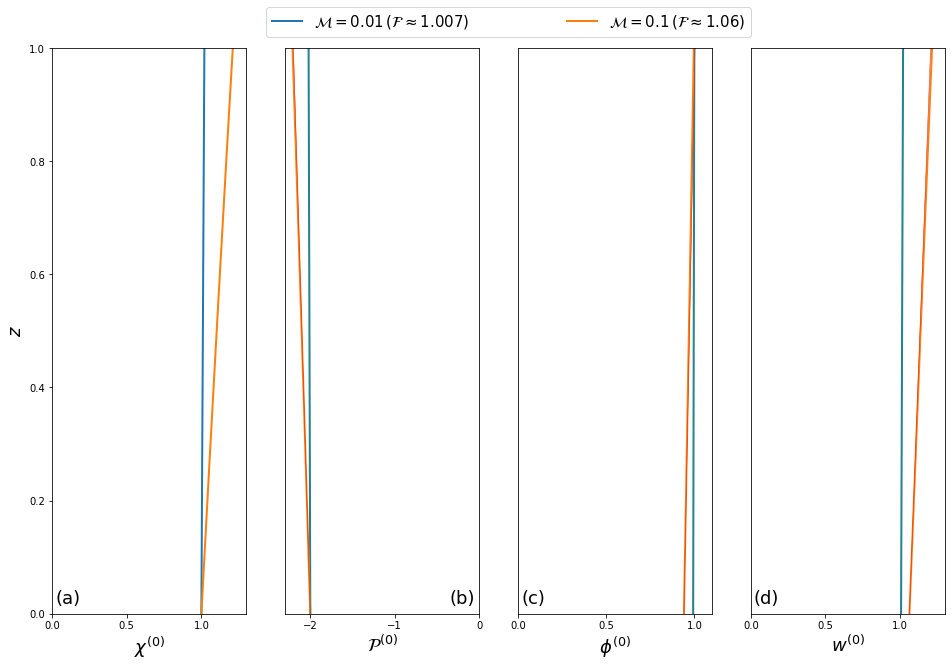

In [3]:
f, ax = plt.subplots(1, 4)
zoom = 2.0
f.set_size_inches(8.0 * zoom, 5.2 * zoom)
f.set_facecolor('w')

plt.rc('axes', prop_cycle=(cycler(color=['k', 'k', 'k', 'k']) + cycler(linestyle=['-', '--', ':', '-.'])))

lines = ax[0].plot(chi.transpose(), z, linewidth=2.0)
ax[0].set_xlabel(r'$\chi^{(0)}$', fontsize=18)
ax[0].set_xlim(0.0, 1.3)
ax[0].set_xticks((0.0, 0.5, 1.0))
ax[0].set_ylabel('$z$', fontsize=18)
ax[0].set_ylim(0.0, 1.0)
ax[0].text(0.02, 0.01, '(a)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')
plt.legend(handles=(lines[0], lines[1]), 
           labels=(r'$\mathcal{M}=0.01\,(\mathcal{F}\approx1.007)$', r'$\mathcal{M}=0.1\,(\mathcal{F}\approx1.06)$'),
           fontsize=15, bbox_to_anchor=(-2.5, 1.02, 2.5, .2),
           loc='lower right', ncol=2, mode="expand", borderaxespad=0.)

ax[1].plot(cmp.transpose(), z, linewidth=2.0)
ax[1].plot(cmpl.transpose(), z, linewidth=0.5)
ax[1].set_xlabel(r'$\mathcal{P}^{(0)}$', fontsize=18)
ax[1].set_xlim(-2.3, 0.0)
ax[1].set_xticks((-2.0, -1.0, 0.0))
ax[1].set_yticks(())
ax[1].set_ylim(0.0, 1.0)
ax[1].text(-0.35, 0.01, '(b)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')

ax[2].plot(phi.transpose(), z, linewidth=2)
ax[2].plot(phil.transpose(), z, linewidth=0.5)
ax[2].set_yticks(())
ax[2].set_xlabel(r'$\phi^{(0)}$', fontsize=18)
ax[2].set_xlim(0.0, 1.1)
ax[2].set_xticks((0.0, 0.5, 1.0))
ax[2].set_ylim(0.0, 1.0)
ax[2].text(0.02, 0.01, '(c)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')

ax[3].plot(w.transpose(), z, linewidth=2)
ax[3].plot(wl.transpose(), z, linewidth=0.5)
ax[3].set_xlabel(r'$w^{(0)}$', fontsize=18)
ax[3].set_yticks(())
ax[3].set_xlim(0.0, 1.3)
ax[3].set_ylim(0.0, 1.0)
ax[3].set_xticks((0.0, 0.5, 1.0))
ax[3].text(0.02, 0.01, '(d)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')

plt.show()

In [4]:
class PAR:
    def __init__(self, F_=1.0, n_=3, S_=1.0, Da_=1000.0, Pe_=100.0, M_=0.01, G_=1,
                 bc_=2, nz_=1000, tol_=1e-5, plot_=False, step_=0.01, largeDa_=False):
        self.F = F_  # base - state parameter - force to be constant
        self.n = n_  # permeability exponent
        self.S = S_  # rigidity parameter
        self.Da = Da_  # Damkohler number
        self.Pe = Pe_  # Peclet number
        self.M = M_  # solubility gradient parameter
        self.G = G_  # decompression melting parameter
        self.bc_type = bc_  # boundary condition type -- 1) P(1)=0; 2) P'(1)=0
        self.nz = nz_  # number of points for eigenfunction
        self.tol = tol_  # tolerance
        self.plot = plot_  # plot eigenfunction
        self.step = step_  # stepsize in log10(k) - sigma space
        self.largeDa = largeDa_

        
class EIG:
    def __init__(self, p_=0.0, phi_=0.0):
        self.P = p_
        self.phi = phi_


class SA:
    def __init__(self, k_=0.0, sigma_=0.0, m_=0.0, flag_=False):
        self.k = k_
        self.sigma = sigma_
        self.m = m_
        self.eig = EIG()
        self.flag = flag_


class DC:
    def __init__(self, s_=0.0, k_=0.0, m_=0.0):
        self.s = s_
        self.k = k_
        self.m = m_

In [5]:
def zero_by_sigma(sig, k, par):
    m = np.roots(characteristic_polynomial(k, sig, par))
    if par.largeDa:
        residual = np.real(m[0]) * np.sin(np.imag(m[0])) + np.imag(m[0]) * np.cos(np.imag(m[0]))
    else:
        detM = det(boundary_condition_matrix(k, m, sig, par))
        residual = np.real((1.0 - 1.j) * detM)
    return residual

In [6]:
def zero_by_wavenumber(k, sigma, par):
    m = np.roots(characteristic_polynomial(k, sigma, par))
    if par.largeDa:
        residual = np.real(m[0]) * np.sin(np.imag(m[0])) + np.imag(m[0]) * np.cos(np.imag(m[0]))
    else:
        detM = det(boundary_condition_matrix(k, m, sigma, par))
        residual = np.real((1 - 1j) * detM)
    return residual

In [7]:
def characteristic_polynomial(k, sig, par):
    K = k ** 2 / par.Da / par.Pe / par.F + 1.0
    p = np.asarray([0.0 if par.largeDa else sig / par.Da,  # cubic
                    sig * K - par.n * np.power(par.F, 1 + par.n) / par.Da / par.S,  # quadratic
                    -(par.n * np.power(par.F, 1 + par.n) * K / par.S + sig * k ** 2 / par.Da),  # linear
                    k ** 2 * (par.n * np.power(par.F, 1 - par.n) - sig * K)])  # constant
    return p.reshape(p.shape[0])

In [8]:
def boundary_condition_matrix(k, m, sig, par):
    if par.bc_type == 1:
        M = np.asarray([[1.0, mi, np.exp(mi)] for mi in m]).transpose()
    elif par.bc_type == 2:
        M = np.asarray([[1.0, mi, mi * np.exp(mi)] for mi in m]).transpose()
    elif par.bc_type == 3:
        q = sig * par.S / par.n
        M = np.asarray([[q * mi - 1.0, q * mi ** 2 - mi - q * k ** 2, mi * np.exp(mi)] for mi in m]).transpose()
    else:
        q = k ** 2 * par.Da / par.DaPe
        M = np.asarray([[1.0 - par.S * mi, mi ** 2 + q * mi, mi * np.exp(mi)] for mi in m]).transpose()
    return M

In [9]:
def form_eigenfunction(k, sigma, par):
    m = np.roots(characteristic_polynomial(k, sigma, par))
    z = np.linspace(0.0, 1.0, par.nz)
    eig = EIG()
    if par.largeDa:
        eig.P = np.exp(np.real(m[0]) * z) * np.sin(np.imag(m[0]) * z)
        eig.P = eig.P / np.max(np.abs(eig.P))
        Q = (m[0] ** 2 - k ** 2) * eig.P
        eig.phi = np.power(par.F, -1.0 - par.n) * par.S / par.n * np.cumsum(Q) * (z[1] - z[0])
    else:
        M = boundary_condition_matrix(k, m, sigma, par)
        subM = M[:, 1::]
        b = -M[:, 0]
        A = np.concatenate((np.asarray([1.0+0.j]), np.linalg.lstsq(subM, b, rcond=None)[0]))
        eig.P = np.sum(np.asarray([Aj * np.exp(mj * z) for Aj, mj in zip(A, m)]).transpose(), axis=1)
        Q = np.sum(np.asarray([(mj ** 2 - k ** 2) * Aj * np.exp(mj * z) 
                               for Aj, mj in zip(A, m)]).transpose(), axis=1)
        eig.phi = np.power(par.F, -1 - par.n) * par.S / par.n * np.cumsum(Q) * (z[1] - z[0])
    return eig

In [10]:
def reactive_flow_solve_dispersion(k_guess, sigma_guess, par):
    # input parameters:
    #   k -- horizontal wavenumber (required)
    #   sigma_guess -- guess at the eigenvalue (optional)
    #   par -- parameter structure (optional)

    sa = SA()

    if type(k_guess) is not np.ndarray:
        # solving for growthrate sigma at a fixed value of wavenumber k
        solve_for_sigma = True
        sa.k = k_guess
        if sigma_guess is None:
            sigma_guess = np.logspace(-1.0, 1.0, 100)
        if type(sigma_guess) is not np.ndarray:
            sigma_guess = np.asarray([sigma_guess])
    else:
        # solving for wavenumber k at a fixed value of growthrate sigma
        solve_for_sigma = False
        sa.sigma = sigma_guess if type(sigma_guess) is not np.ndarray else sigma_guess[0]

    if par.F is None:
        par.F = np.power(1.0 + par.S * par.M * (1.0 + par.G), 1.0 / par.n)

    sigma = np.zeros_like(sigma_guess)
    k = np.zeros_like(k_guess)
    if solve_for_sigma:
        # solve eigenvalue problem to find growth rate of fastest-growing mode
        res = np.zeros_like(sigma_guess)
        exitflag = np.zeros_like(sigma_guess)
        converged = np.zeros_like(sigma_guess)
        problem_sigma = lambda s: zero_by_sigma(s, sa.k, par)
        for j in range(len(sigma_guess)):
            [sigma[j], infodict, exitflag[j], _] = fsolve(problem_sigma, sigma_guess[j], 
                                                          full_output=True, xtol=1.e-14)
            res[j] = infodict["fvec"]
            converged[j] = exitflag[j] == 1 and np.abs(res[j]) < par.tol
            if par.largeDa:
                m = np.roots(characteristic_polynomial(sa.k, sigma[j], par))
                converged[j] = converged[j] and np.pi / 2 < np.abs(np.imag(m[0])) < np.pi
            if par.plot and converged[j] == 1:
                eig = form_eigenfunction(sa.k, sigma[j], par)
                # plt.plot(np.linspace(0.0, 1.0, par.nz), np.real(eig.P))
    else:
        # solve eigenvalue problem to find wavenumber of mode
        problem_wavenumber = lambda s: zero_by_wavenumber(s, sa.sigma, par)
        res = np.zeros_like(k_guess)
        exitflag = np.zeros_like(k_guess)
        converged = np.zeros_like(k_guess)
        for j in range(len(k_guess)):
            [k[j], infodict, exitflag[j], _] = fsolve(problem_wavenumber, k_guess[j], full_output=True, xtol=1.e-14)
            res[j] = infodict["fvec"]
            converged[j] = exitflag[j] == 1 or abs(res[j]) < par.tol
            if par.largeDa:
                m = np.roots(characteristic_polynomial(k[j], sa.sigma, par))
                converged[j] = converged[j] and np.pi / 2 < np.abs(np.imag(m[0])) < np.pi
            if par.plot and converged[j] == 1:
                eig = form_eigenfunction(k[j], sa.sigma, par)
                plt.plot(np.linspace(0.0, 1.0, par.nz), np.real(eig.P))

        # [converged', exitflag', log10(abs(res'))];
    none_converged = not np.sum(converged)

    # handle failure to find solution
    if none_converged:
        print(f'FAILURE: no solution found for k={k_guess}')
        sa.sigma = np.nan
        sa.k = np.nan
        sa.m = [np.nan, np.nan, np.nan]
        sa.eig.P = np.nan
        sa.flag = False
        return sa
    elif solve_for_sigma:
        sa.sigma = np.amax(sigma[converged != 0])
    else:
        sa.k = np.amax(k[converged != 0])

    sa.m = np.roots(characteristic_polynomial(sa.k, sa.sigma, par))

    # form and check eigenfunction
    sa.eig = form_eigenfunction(sa.k, sa.sigma, par)
    gP = np.gradient(sa.eig.P)

    if (gP < 0).any() and par.bc_type != 1:
        sa.flag = False
        print(f'FAILURE: non-monotonic eigenfunction for k={sa.k}, sigma={sa.sigma}')
    else:
        sa.flag = True
        print(f'SUCCESS: monotonic eigenfunction for k={sa.k}, sigma={sa.sigma}')

    if par.plot:
        plt.plot(np.linspace(0, 1, par.nz), np.real(sa.eig.P), linewidth=2)

    return sa

In [11]:
def taylor_series_extension(n, x, y, step, init_Lks):
    if n == 0:
        xguess = init_Lks[0]
        yguess = init_Lks[1]
    elif n == 1:
        xguess = x[0]-step
        yguess = y[0]
    elif n == 2:
        d = np.asarray([x[1]-x[0], y[1]-y[0]])
        d = d/np.sqrt(np.sum(d**2))
        xguess = x[-1] + d[0]*step
        yguess = y[-1] + d[1]*step
    else:
        da = np.asarray([x[-1]-x[-2], y[-1]-y[-2]])
        db = np.asarray([x[-2]-x[-3], y[-2]-y[-3]])
        D = 0.5*(np.sqrt(np.sum(da**2)) + np.sqrt(np.sum(db**2)))
        da = da/np.sqrt(np.sum(da**2))
        db = db/np.sqrt(np.sum(db**2))
        d2 = (da - db)/D
        xguess = x[-1] + da[0]*step + 0.5*d2[0]*step**2
        yguess = y[-1] + da[1]*step + 0.5*d2[1]*step**2

    if np.isinf(xguess) or np.isnan(xguess):
        xguess = x[-1]
    if np.isinf(yguess) or np.isnan(yguess):
        yguess = y[-1]

    return xguess, yguess

In [12]:
def reactive_flow_trace_dispersion_curve(par, Lkbounds, sbounds, init_Lks):
    n = 0  # can n be zero?
    Lk = np.full((1, ), np.inf)  # dictionaries
    s = np.full((1, ), np.inf)
    m = m = np.full((1, 2), np.inf + 0.j, dtype=np.complex) if par.largeDa \
        else np.full((1, 3), np.inf + 0.j, dtype=np.complex)

    for j in [0, 1]:
        fails = 0
        while n < 1_000_000:
            Lk_guess, s_guess = taylor_series_extension(n, Lk, s, par.step, init_Lks)
            if Lk_guess <= Lkbounds[0] or Lk_guess >= Lkbounds[1]:
                break
            if s_guess <= sbounds[0] or s_guess >= sbounds[1]:
                break

            if n == 0:
                s_guess = np.linspace(0.1, par.n, 30)
            elif fails <= 1:
                print(f'Iteration {n}: searching for solution at k={np.power(10, Lk_guess)}')
                s_guess = s_guess * np.linspace(0.99, 1.01, 16)
            elif fails == 2:
                print(f'Iteration {n}: searching for solution at sigma={s_guess}')
                Lk_guess = Lk_guess * np.linspace(0.99, 1.01, 16)
            else:
                break

            sa = reactive_flow_solve_dispersion(np.power(10., Lk_guess), s_guess, par)

            if sa.flag:
                # found lowest mode; prepare for next iteration
                if n == 0:
                    Lk[n] = np.log10(sa.k)
                    s[n] = sa.sigma
                    m[n] = sa.m
                else:
                    Lk = np.concatenate((Lk, np.asarray([np.log10(sa.k)])))
                    s = np.concatenate((s, np.asarray([sa.sigma])))
                    m = np.concatenate((m, np.asarray([sa.m])))
                n = n + 1
                fails = 0
            else:
                # found higher mode; retry
                fails = fails + 1

        if j == 0:
            s = np.flip(s)
            Lk = np.flip(Lk)
            m = np.flipud(m)

    return DC(s, np.power(10., Lk), m)

In [13]:
par = PAR()

Lkbounds = np.log10([0.1, 400.0])
sbounds = np.asarray([0.05, 4.0])
init_Lks = np.asarray([np.log10(5.0), 3.0])

DC_ref = reactive_flow_trace_dispersion_curve(par, Lkbounds, sbounds, init_Lks)
iref = np.argmax(DC_ref.s)

dpar = par
dpar.Da = 10.0
DC_a = reactive_flow_trace_dispersion_curve(dpar, Lkbounds, sbounds, init_Lks)
dpar.Da = 100.0
DC_b = reactive_flow_trace_dispersion_curve(dpar, Lkbounds, sbounds, init_Lks)

/var/folders/4z/_rhsq3x965gc56klbm0nmv040000gn/T/ipykernel_86415/1995957636.py:6: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  else np.full((1, 3), np.inf + 0.j, dtype=np.complex)


SUCCESS: monotonic eigenfunction for k=5.000000000000001, sigma=2.596489830144003
Iteration 1: searching for solution at k=4.886186104779054
SUCCESS: monotonic eigenfunction for k=4.886186104779054, sigma=2.5793461640905706
Iteration 2: searching for solution at k=4.8298258486684915
SUCCESS: monotonic eigenfunction for k=4.8298258486684915, sigma=2.57045525456229
Iteration 3: searching for solution at k=4.77570019745004


SUCCESS: monotonic eigenfunction for k=4.77570019745004, sigma=2.5616530658570715
Iteration 4: searching for solution at k=4.7229374259332095
SUCCESS: monotonic eigenfunction for k=4.7229374259332095, sigma=2.5528139088490143
Iteration 5: searching for solution at k=4.671485390538257
SUCCESS: monotonic eigenfunction for k=4.671485390538257, sigma=2.54393896356508
Iteration 6: searching for solution at k=4.621296646934616
SUCCESS: monotonic eigenfunction for k=4.621296646934616, sigma=2.5350297549011778
Iteration 7: searching for solution at k=4.572325718222083


SUCCESS: monotonic eigenfunction for k=4.572325718222083, sigma=2.526087730583631
Iteration 8: searching for solution at k=4.524529043564481
SUCCESS: monotonic eigenfunction for k=4.524529043564481, sigma=2.5171142691393915
Iteration 9: searching for solution at k=4.477864900007602
SUCCESS: monotonic eigenfunction for k=4.477864900007602, sigma=2.508110683121918
Iteration 10: searching for solution at k=4.432293325757955
SUCCESS: monotonic eigenfunction for k=4.432293325757955, sigma=2.499078222193804
Iteration 11: searching for solution at k=4.387776045475441
SUCCESS: monotonic eigenfunction for k=4.387776045475441, sigma=2.490018076116192
Iteration 12: searching for solution at k=4.34427639773776
SUCCESS: monotonic eigenfunction for k=4.34427639773776, sigma=2.4809313776381936


Iteration 13: searching for solution at k=4.301759264793065
SUCCESS: monotonic eigenfunction for k=4.301759264793065, sigma=2.47181920528151
Iteration 14: searching for solution at k=4.2601910046822


SUCCESS: monotonic eigenfunction for k=4.2601910046822, sigma=2.4626825860171735
Iteration 15: searching for solution at k=4.2195393857819115
SUCCESS: monotonic eigenfunction for k=4.2195393857819115, sigma=2.4535224978328136
Iteration 16: searching for solution at k=4.179773523794831


SUCCESS: monotonic eigenfunction for k=4.179773523794831, sigma=2.444339872190113
Iteration 17: searching for solution at k=4.140863821190263
SUCCESS: monotonic eigenfunction for k=4.140863821190263, sigma=2.4351355963730192
Iteration 18: searching for solution at k=4.102781909082086
SUCCESS: monotonic eigenfunction for k=4.102781909082086, sigma=2.4259105157282477
Iteration 19: searching for solution at k=4.065500591514655
SUCCESS: monotonic eigenfunction for k=4.065500591514655, sigma=2.4166654358000814
Iteration 20: searching for solution at k=4.028993792115858


SUCCESS: monotonic eigenfunction for k=4.028993792115858, sigma=2.407401124362135
Iteration 21: searching for solution at k=3.993236503066313
SUCCESS: monotonic eigenfunction for k=3.993236503066313, sigma=2.398118313349051
Iteration 22: searching for solution at k=3.958204736326081
SUCCESS: monotonic eigenfunction for k=3.958204736326081, sigma=2.3888177006914137
Iteration 23: searching for solution at k=3.923875477054267
SUCCESS: monotonic eigenfunction for k=3.923875477054267, sigma=2.379499952057392
Iteration 24: searching for solution at k=3.8902266391523663
SUCCESS: monotonic eigenfunction for k=3.8902266391523663, sigma=2.3701657025047154


Iteration 25: searching for solution at k=3.8572370228591124
SUCCESS: monotonic eigenfunction for k=3.8572370228591124, sigma=2.3608155580467036
Iteration 26: searching for solution at k=3.8248862743225134


SUCCESS: monotonic eigenfunction for k=3.8248862743225134, sigma=2.35145009713609
Iteration 27: searching for solution at k=3.793154847073556
SUCCESS: monotonic eigenfunction for k=3.793154847073556, sigma=2.342069872070341
Iteration 28: searching for solution at k=3.7620239653258234
SUCCESS: monotonic eigenfunction for k=3.7620239653258234, sigma=2.332675410322159
Iteration 29: searching for solution at k=3.731475589025499


SUCCESS: monotonic eigenfunction for k=3.731475589025499, sigma=2.3232672157988254
Iteration 30: searching for solution at k=3.7014923805768984
SUCCESS: monotonic eigenfunction for k=3.7014923805768984, sigma=2.313845770033832
Iteration 31: searching for solution at k=3.6720576731701895
SUCCESS: monotonic eigenfunction for k=3.6720576731701895, sigma=2.3044115333143
Iteration 32: searching for solution at k=3.643155440639268
SUCCESS: monotonic eigenfunction for k=3.643155440639268, sigma=2.2949649457474752
Iteration 33: searching for solution at k=3.6147702687796746


SUCCESS: monotonic eigenfunction for k=3.6147702687796746, sigma=2.2855064282694544
Iteration 34: searching for solution at k=3.5868873280586535
SUCCESS: monotonic eigenfunction for k=3.5868873280586535, sigma=2.2760363835992945
Iteration 35: searching for solution at k=3.5594923476512665
SUCCESS: monotonic eigenfunction for k=3.5594923476512665, sigma=2.266555197141348
Iteration 36: searching for solution at k=3.5325715907391912
SUCCESS: monotonic eigenfunction for k=3.5325715907391912, sigma=2.2570632378386897
Iteration 37: searching for solution at k=3.5061118310109425
SUCCESS: monotonic eigenfunction for k=3.5061118310109425, sigma=2.2475608589803113
Iteration 38: searching for solution at k=3.480100330304669


SUCCESS: monotonic eigenfunction for k=3.480100330304669, sigma=2.23804839896457
Iteration 39: searching for solution at k=3.4545248173373397
SUCCESS: monotonic eigenfunction for k=3.4545248173373397, sigma=2.2285261820214366
Iteration 40: searching for solution at k=3.4293734674660543
SUCCESS: monotonic eigenfunction for k=3.4293734674660543, sigma=2.218994518895669
Iteration 41: searching for solution at k=3.4046348834302504


SUCCESS: monotonic eigenfunction for k=3.4046348834302504, sigma=2.2094537074932665
Iteration 42: searching for solution at k=3.380298077025264
SUCCESS: monotonic eigenfunction for k=3.380298077025264, sigma=2.199904033493142
Iteration 43: searching for solution at k=3.356352451660432


SUCCESS: monotonic eigenfunction for k=3.356352451660432, sigma=2.1903457709260112
Iteration 44: searching for solution at k=3.332787785756993


SUCCESS: monotonic eigenfunction for k=3.332787785756993, sigma=2.1807791827223566
Iteration 45: searching for solution at k=3.3095942169431503
SUCCESS: monotonic eigenfunction for k=3.3095942169431503, sigma=2.17120452123118
Iteration 46: searching for solution at k=3.2867622270058328
SUCCESS: monotonic eigenfunction for k=3.2867622270058328, sigma=2.1616220287111916
Iteration 47: searching for solution at k=3.264282627560713
SUCCESS: monotonic eigenfunction for k=3.264282627560713, sigma=2.1520319377960133
Iteration 48: searching for solution at k=3.2421465464038626


SUCCESS: monotonic eigenfunction for k=3.2421465464038626, sigma=2.1424344719348483
Iteration 49: searching for solution at k=3.220345414510333
SUCCESS: monotonic eigenfunction for k=3.220345414510333, sigma=2.132829845809937
Iteration 50: searching for solution at k=3.1988709536468964
SUCCESS: monotonic eigenfunction for k=3.1988709536468964, sigma=2.123218265732237
Iteration 51: searching for solution at k=3.177715164567477
SUCCESS: monotonic eigenfunction for k=3.177715164567477, sigma=2.113599930016399
Iteration 52: searching for solution at k=3.156870315761854


SUCCESS: monotonic eigenfunction for k=3.156870315761854, sigma=2.1039750293362696
Iteration 53: searching for solution at k=3.1363289327295534
SUCCESS: monotonic eigenfunction for k=3.1363289327295534, sigma=2.0943437470620374
Iteration 54: searching for solution at k=3.1160837877522236
SUCCESS: monotonic eigenfunction for k=3.1160837877522236, sigma=2.08470625957996
Iteration 55: searching for solution at k=3.0961278901394174
SUCCESS: monotonic eigenfunction for k=3.0961278901394174, sigma=2.075062736595685
Iteration 56: searching for solution at k=3.076454476923909


SUCCESS: monotonic eigenfunction for k=3.076454476923909, sigma=2.0654133414220928
Iteration 57: searching for solution at k=3.0570570039838616
SUCCESS: monotonic eigenfunction for k=3.0570570039838616, sigma=2.0557582312524656
Iteration 58: searching for solution at k=3.0379291375704978
SUCCESS: monotonic eigenfunction for k=3.0379291375704978, sigma=2.046097557419773
Iteration 59: searching for solution at k=3.0190647462210927
SUCCESS: monotonic eigenfunction for k=3.0190647462210927, sigma=2.0364314656429285
Iteration 60: searching for solution at k=3.000457893037922
SUCCESS: monotonic eigenfunction for k=3.000457893037922, sigma=2.0267600962606216
Iteration 61: searching for solution at k=2.9821028283150945


SUCCESS: monotonic eigenfunction for k=2.9821028283150945, sigma=2.0170835844534043
Iteration 62: searching for solution at k=2.9639939824961408
SUCCESS: monotonic eigenfunction for k=2.9639939824961408, sigma=2.0074020604547544
Iteration 63: searching for solution at k=2.946125959445914
SUCCESS: monotonic eigenfunction for k=2.946125959445914, sigma=1.9977156497515944
Iteration 64: searching for solution at k=2.9284935300215
SUCCESS: monotonic eigenfunction for k=2.9284935300215, sigma=1.9880244732748926
Iteration 65: searching for solution at k=2.911091625927486
SUCCESS: monotonic eigenfunction for k=2.911091625927486, sigma=1.9783286475808557
Iteration 66: searching for solution at k=2.893915333841757


SUCCESS: monotonic eigenfunction for k=2.893915333841757, sigma=1.9686282850231809
Iteration 67: searching for solution at k=2.8769598897987825
SUCCESS: monotonic eigenfunction for k=2.8769598897987825, sigma=1.9589234939168905
Iteration 68: searching for solution at k=2.8602206738179046
SUCCESS: monotonic eigenfunction for k=2.8602206738179046, sigma=1.949214378694125
Iteration 69: searching for solution at k=2.8436932047649544
SUCCESS: monotonic eigenfunction for k=2.8436932047649544, sigma=1.9395010400523462
Iteration 70: searching for solution at k=2.8273731354360403


SUCCESS: monotonic eigenfunction for k=2.8273731354360403, sigma=1.9297835750953138
Iteration 71: searching for solution at k=2.811256247853006
SUCCESS: monotonic eigenfunction for k=2.811256247853006, sigma=1.9200620774672472
Iteration 72: searching for solution at k=2.795338448760499
SUCCESS: monotonic eigenfunction for k=2.795338448760499, sigma=1.9103366374804456
Iteration 73: searching for solution at k=2.779615765315279
SUCCESS: monotonic eigenfunction for k=2.779615765315279, sigma=1.9006073422367513
Iteration 74: searching for solution at k=2.7640843409587523
SUCCESS: monotonic eigenfunction for k=2.7640843409587523, sigma=1.8908742757431407
Iteration 75: searching for solution at k=2.7487404314642503


SUCCESS: monotonic eigenfunction for k=2.7487404314642503, sigma=1.8811375190217423
Iteration 76: searching for solution at k=2.7335804011509564
SUCCESS: monotonic eigenfunction for k=2.7335804011509564, sigma=1.871397150214491
Iteration 77: searching for solution at k=2.7186007192569766
SUCCESS: monotonic eigenfunction for k=2.7186007192569766, sigma=1.8616532446827927
Iteration 78: searching for solution at k=2.7037979564641645
SUCCESS: monotonic eigenfunction for k=2.7037979564641645, sigma=1.851905875102342
Iteration 79: searching for solution at k=2.6891687815679095
SUCCESS: monotonic eigenfunction for k=2.6891687815679095, sigma=1.84215511155333
Iteration 80: searching for solution at k=2.6747099582854172
SUCCESS: monotonic eigenfunction for k=2.6747099582854172, sigma=1.832401021606297
Iteration 81: searching for solution at k=2.6604183421962775


SUCCESS: monotonic eigenfunction for k=2.6604183421962775, sigma=1.8226436704038362
Iteration 82: searching for solution at k=2.6462908778094105
SUCCESS: monotonic eigenfunction for k=2.6462908778094105, sigma=1.8128831207382226
Iteration 83: searching for solution at k=2.6323245957510224
SUCCESS: monotonic eigenfunction for k=2.6323245957510224, sigma=1.8031194331253773
Iteration 84: searching for solution at k=2.6185166100680157
SUCCESS: monotonic eigenfunction for k=2.6185166100680157, sigma=1.7933526658750152
Iteration 85: searching for solution at k=2.6048641156422114
SUCCESS: monotonic eigenfunction for k=2.6048641156422114, sigma=1.7835828751574623
Iteration 86: searching for solution at k=2.591364385710351


SUCCESS: monotonic eigenfunction for k=2.591364385710351, sigma=1.7738101150670509
Iteration 87: searching for solution at k=2.5780147694855486
SUCCESS: monotonic eigenfunction for k=2.5780147694855486, sigma=1.764034437682358
Iteration 88: searching for solution at k=2.564812689875849
SUCCESS: monotonic eigenfunction for k=2.564812689875849, sigma=1.7542558931233407
Iteration 89: searching for solution at k=2.551755641295935
SUCCESS: monotonic eigenfunction for k=2.551755641295935, sigma=1.7444745296055817
Iteration 90: searching for solution at k=2.5388411875680323
SUCCESS: monotonic eigenfunction for k=2.5388411875680323, sigma=1.7346903934916498
Iteration 91: searching for solution at k=2.5260669599084884


SUCCESS: monotonic eigenfunction for k=2.5260669599084884, sigma=1.7249035293398054
Iteration 92: searching for solution at k=2.5134306549964487
SUCCESS: monotonic eigenfunction for k=2.5134306549964487, sigma=1.715113979950001
Iteration 93: searching for solution at k=2.5009300331215147
SUCCESS: monotonic eigenfunction for k=2.5009300331215147, sigma=1.7053217864074475
Iteration 94: searching for solution at k=2.488562916407114
SUCCESS: monotonic eigenfunction for k=2.488562916407114, sigma=1.6955269881236872
Iteration 95: searching for solution at k=2.4763271871067363
SUCCESS: monotonic eigenfunction for k=2.4763271871067363, sigma=1.6857296228753331
Iteration 96: searching for solution at k=2.4642207859702046


SUCCESS: monotonic eigenfunction for k=2.4642207859702046, sigma=1.6759297268404787
Iteration 97: searching for solution at k=2.452241710677428
SUCCESS: monotonic eigenfunction for k=2.452241710677428, sigma=1.666127334633034
Iteration 98: searching for solution at k=2.4403880143368903
SUCCESS: monotonic eigenfunction for k=2.4403880143368903, sigma=1.656322479334704
Iteration 99: searching for solution at k=2.428657804046861
SUCCESS: monotonic eigenfunction for k=2.428657804046861, sigma=1.6465151925250854
Iteration 100: searching for solution at k=2.4170492395167464
SUCCESS: monotonic eigenfunction for k=2.4170492395167464, sigma=1.6367055043096124
Iteration 101: searching for solution at k=2.405560531746652


SUCCESS: monotonic eigenfunction for k=2.405560531746652, sigma=1.626893443345564
Iteration 102: searching for solution at k=2.3941899417630665
SUCCESS: monotonic eigenfunction for k=2.3941899417630665, sigma=1.617079036866089
Iteration 103: searching for solution at k=2.382935779408852
SUCCESS: monotonic eigenfunction for k=2.382935779408852, sigma=1.607262310702427
Iteration 104: searching for solution at k=2.3717964021855953
SUCCESS: monotonic eigenfunction for k=2.3717964021855953, sigma=1.5974432893041326
Iteration 105: searching for solution at k=2.3607702141468367
SUCCESS: monotonic eigenfunction for k=2.3607702141468367, sigma=1.5876219957575906
Iteration 106: searching for solution at k=2.349855664840397


SUCCESS: monotonic eigenfunction for k=2.349855664840397, sigma=1.577798451802638
Iteration 107: searching for solution at k=2.3390512482984356
SUCCESS: monotonic eigenfunction for k=2.3390512482984356, sigma=1.5679726778474534
Iteration 108: searching for solution at k=2.32835550207375
SUCCESS: monotonic eigenfunction for k=2.32835550207375, sigma=1.5581446929816043
Iteration 109: searching for solution at k=2.3177670063211164


SUCCESS: monotonic eigenfunction for k=2.3177670063211164, sigma=1.5483145149874742
Iteration 110: searching for solution at k=2.307284382922224
SUCCESS: monotonic eigenfunction for k=2.307284382922224, sigma=1.5384821603497183
Iteration 111: searching for solution at k=2.2969062946533763
SUCCESS: monotonic eigenfunction for k=2.2969062946533763, sigma=1.5286476442632169
Iteration 112: searching for solution at k=2.2866314443945464
SUCCESS: monotonic eigenfunction for k=2.2866314443945464, sigma=1.5188109806390828
Iteration 113: searching for solution at k=2.2764585743790517
SUCCESS: monotonic eigenfunction for k=2.2764585743790517, sigma=1.5089721821089952
Iteration 114: searching for solution at k=2.2663864654828307
SUCCESS: monotonic eigenfunction for k=2.2663864654828307, sigma=1.4991312600277586
Iteration 115: searching for solution at k=2.256413936552473


SUCCESS: monotonic eigenfunction for k=2.256413936552473, sigma=1.489288224474047
Iteration 116: searching for solution at k=2.246539843771272
SUCCESS: monotonic eigenfunction for k=2.246539843771272, sigma=1.4794430842493436
Iteration 117: searching for solution at k=2.2367630800625897
SUCCESS: monotonic eigenfunction for k=2.2367630800625897, sigma=1.469595846875035
Iteration 118: searching for solution at k=2.2270825745299168
SUCCESS: monotonic eigenfunction for k=2.2270825745299168, sigma=1.4597465185876184
Iteration 119: searching for solution at k=2.21749729193307
SUCCESS: monotonic eigenfunction for k=2.21749729193307, sigma=1.449895104331992
Iteration 120: searching for solution at k=2.2080062322000464
SUCCESS: monotonic eigenfunction for k=2.2080062322000464, sigma=1.4400416077527871
Iteration 121: searching for solution at k=2.198608429974093


SUCCESS: monotonic eigenfunction for k=2.198608429974093, sigma=1.4301860311836299
Iteration 122: searching for solution at k=2.189302954195696
SUCCESS: monotonic eigenfunction for k=2.189302954195696, sigma=1.4203283756343439
Iteration 123: searching for solution at k=2.180088907719179
SUCCESS: monotonic eigenfunction for k=2.180088907719179, sigma=1.4104686407760079
Iteration 124: searching for solution at k=2.1709654269636625
SUCCESS: monotonic eigenfunction for k=2.1709654269636625, sigma=1.4006068249236672
Iteration 125: searching for solution at k=2.161931681598373
SUCCESS: monotonic eigenfunction for k=2.161931681598373, sigma=1.3907429250168655
Iteration 126: searching for solution at k=2.1529868742620373


SUCCESS: monotonic eigenfunction for k=2.1529868742620373, sigma=1.3808769365975595
Iteration 127: searching for solution at k=2.1441302403165734
SUCCESS: monotonic eigenfunction for k=2.1441302403165734, sigma=1.3710088537856233
Iteration 128: searching for solution at k=2.1353610476349822
SUCCESS: monotonic eigenfunction for k=2.1353610476349822, sigma=1.3611386692515772
Iteration 129: searching for solution at k=2.1266785964236985
SUCCESS: monotonic eigenfunction for k=2.1266785964236985, sigma=1.351266374186545
Iteration 130: searching for solution at k=2.1180822190795685
SUCCESS: monotonic eigenfunction for k=2.1180822190795685, sigma=1.341391958269215
Iteration 131: searching for solution at k=2.109571280081781


SUCCESS: monotonic eigenfunction for k=2.109571280081781, sigma=1.331515409629655
Iteration 132: searching for solution at k=2.10114517591913
SUCCESS: monotonic eigenfunction for k=2.10114517591913, sigma=1.3216367148098027
Iteration 133: searching for solution at k=2.092803335053066
SUCCESS: monotonic eigenfunction for k=2.092803335053066, sigma=1.3117558587203744
Iteration 134: searching for solution at k=2.0845452179171238
SUCCESS: monotonic eigenfunction for k=2.0845452179171238, sigma=1.3018728245940498
Iteration 135: searching for solution at k=2.076370316953311
SUCCESS: monotonic eigenfunction for k=2.076370316953311, sigma=1.2919875939345693
Iteration 136: searching for solution at k=2.0682781566862527


SUCCESS: monotonic eigenfunction for k=2.0682781566862527, sigma=1.282100146461513
Iteration 137: searching for solution at k=2.0602682938359234
SUCCESS: monotonic eigenfunction for k=2.0602682938359234, sigma=1.2722104600505193
Iteration 138: searching for solution at k=2.0523403174698265
SUCCESS: monotonic eigenfunction for k=2.0523403174698265, sigma=1.2623185106683852
Iteration 139: searching for solution at k=2.0444938491958147
SUCCESS: monotonic eigenfunction for k=2.0444938491958147, sigma=1.252424272302932
Iteration 140: searching for solution at k=2.0367285433965714


SUCCESS: monotonic eigenfunction for k=2.0367285433965714, sigma=1.2425277168869844
Iteration 141: searching for solution at k=2.029044087507124
SUCCESS: monotonic eigenfunction for k=2.029044087507124, sigma=1.2326288142160857
Iteration 142: searching for solution at k=2.0214402023367937
SUCCESS: monotonic eigenfunction for k=2.0214402023367937, sigma=1.2227275318594433
Iteration 143: searching for solution at k=2.013916642437084
SUCCESS: monotonic eigenfunction for k=2.013916642437084, sigma=1.2128238350633942
Iteration 144: searching for solution at k=2.0064731965172893
SUCCESS: monotonic eigenfunction for k=2.0064731965172893, sigma=1.2029176866468954
Iteration 145: searching for solution at k=1.9991096879095789


SUCCESS: monotonic eigenfunction for k=1.9991096879095789, sigma=1.1930090468881174
Iteration 146: searching for solution at k=1.9918259750856675
SUCCESS: monotonic eigenfunction for k=1.9918259750856675, sigma=1.1830978734014745
Iteration 147: searching for solution at k=1.9846219522271955
SUCCESS: monotonic eigenfunction for k=1.9846219522271955, sigma=1.173184121004036
Iteration 148: searching for solution at k=1.9774975498522633
SUCCESS: monotonic eigenfunction for k=1.9774975498522633, sigma=1.1632677415703787
Iteration 149: searching for solution at k=1.970452735500654
SUCCESS: monotonic eigenfunction for k=1.970452735500654, sigma=1.1533486838745708
Iteration 150: searching for solution at k=1.9634875144806418


SUCCESS: monotonic eigenfunction for k=1.9634875144806418, sigma=1.1434268934181357
Iteration 151: searching for solution at k=1.9566019306803437
SUCCESS: monotonic eigenfunction for k=1.9566019306803437, sigma=1.1335023122423173
Iteration 152: searching for solution at k=1.9497960674469963
SUCCESS: monotonic eigenfunction for k=1.9497960674469963, sigma=1.1235748787230648
Iteration 153: searching for solution at k=1.943070048537711
SUCCESS: monotonic eigenfunction for k=1.943070048537711, sigma=1.1136445273467532
Iteration 154: searching for solution at k=1.936424039145607
SUCCESS: monotonic eigenfunction for k=1.936424039145607, sigma=1.1037111884644273
Iteration 155: searching for solution at k=1.9298582470055623
SUCCESS: monotonic eigenfunction for k=1.9298582470055623, sigma=1.0937747880221402
Iteration 156: searching for solution at k=1.9233729235841057


SUCCESS: monotonic eigenfunction for k=1.9233729235841057, sigma=1.083835247264378
Iteration 157: searching for solution at k=1.916968365358483
SUCCESS: monotonic eigenfunction for k=1.916968365358483, sigma=1.0738924824074345
Iteration 158: searching for solution at k=1.9106449151902238
SUCCESS: monotonic eigenfunction for k=1.9106449151902238, sigma=1.063946404278793
Iteration 159: searching for solution at k=1.904402963799128
SUCCESS: monotonic eigenfunction for k=1.904402963799128, sigma=1.0539969179183166
Iteration 160: searching for solution at k=1.8982429513439625
SUCCESS: monotonic eigenfunction for k=1.8982429513439625, sigma=1.0440439221360147
Iteration 161: searching for solution at k=1.8921653691168725


SUCCESS: monotonic eigenfunction for k=1.8921653691168725, sigma=1.0340873090206946
Iteration 162: searching for solution at k=1.8861707613589858
SUCCESS: monotonic eigenfunction for k=1.8861707613589858, sigma=1.0241269633925614
Iteration 163: searching for solution at k=1.8802597272054704
SUCCESS: monotonic eigenfunction for k=1.8802597272054704, sigma=1.014162762191881
Iteration 164: searching for solution at k=1.8744329227689995
SUCCESS: monotonic eigenfunction for k=1.8744329227689995, sigma=1.0041945737943139
Iteration 165: searching for solution at k=1.868691063371459
SUCCESS: monotonic eigenfunction for k=1.868691063371459, sigma=0.9942222572420399
Iteration 166: searching for solution at k=1.863034925934607


SUCCESS: monotonic eigenfunction for k=1.863034925934607, sigma=0.9842456613776414
Iteration 167: searching for solution at k=1.8574653515414896
SUCCESS: monotonic eigenfunction for k=1.8574653515414896, sigma=0.9742646238654475
Iteration 168: searching for solution at k=1.8519832481815612
SUCCESS: monotonic eigenfunction for k=1.8519832481815612, sigma=0.9642789700821592
Iteration 169: searching for solution at k=1.8465895936937105
SUCCESS: monotonic eigenfunction for k=1.8465895936937105, sigma=0.954288511854801
Iteration 170: searching for solution at k=1.8412854389229767
SUCCESS: monotonic eigenfunction for k=1.8412854389229767, sigma=0.9442930460200022
Iteration 171: searching for solution at k=1.8360719111082948


SUCCESS: monotonic eigenfunction for k=1.8360719111082948, sigma=0.93429235277292
Iteration 172: searching for solution at k=1.8309502175205847
SUCCESS: monotonic eigenfunction for k=1.8309502175205847, sigma=0.9242861937676005
Iteration 173: searching for solution at k=1.8259216493726498
SUCCESS: monotonic eigenfunction for k=1.8259216493726498, sigma=0.9142743099221532
Iteration 174: searching for solution at k=1.8209875860248355
SUCCESS: monotonic eigenfunction for k=1.8209875860248355, sigma=0.904256418871573
Iteration 175: searching for solution at k=1.8161494995133163
SUCCESS: monotonic eigenfunction for k=1.8161494995133163, sigma=0.8942322119977799
Iteration 176: searching for solution at k=1.811408959431238
SUCCESS: monotonic eigenfunction for k=1.811408959431238, sigma=0.8842013509494759


Iteration 177: searching for solution at k=1.8067676381968854
SUCCESS: monotonic eigenfunction for k=1.8067676381968854, sigma=0.8741634635426274
Iteration 178: searching for solution at k=1.8022273167477263
SUCCESS: monotonic eigenfunction for k=1.8022273167477263, sigma=0.8641181389042176
Iteration 179: searching for solution at k=1.7977898907047465
SUCCESS: monotonic eigenfunction for k=1.7977898907047465, sigma=0.8540649216851127
Iteration 180: searching for solution at k=1.7934573770581845
SUCCESS: monotonic eigenfunction for k=1.7934573770581845, sigma=0.8440033051194522
Iteration 181: searching for solution at k=1.789231921433876
SUCCESS: monotonic eigenfunction for k=1.789231921433876, sigma=0.8339327226432995
Iteration 182: searching for solution at k=1.7851158060094738


SUCCESS: monotonic eigenfunction for k=1.7851158060094738, sigma=0.8238525376988776
Iteration 183: searching for solution at k=1.7811114581620757
SUCCESS: monotonic eigenfunction for k=1.7811114581620757, sigma=0.8137620312321754
Iteration 184: searching for solution at k=1.7772214599445333
SUCCESS: monotonic eigenfunction for k=1.7772214599445333, sigma=0.8036603862297201
Iteration 185: searching for solution at k=1.773448558507416
SUCCESS: monotonic eigenfunction for k=1.773448558507416, sigma=0.7935466684127592
Iteration 186: searching for solution at k=1.7697956776094101
SUCCESS: monotonic eigenfunction for k=1.7697956776094101, sigma=0.7834198018858128


Iteration 187: searching for solution at k=1.7662659303925903
SUCCESS: monotonic eigenfunction for k=1.7662659303925903, sigma=0.7732785380731849
Iteration 188: searching for solution at k=1.7628626336440492
SUCCESS: monotonic eigenfunction for k=1.7628626336440492, sigma=0.7631214155977833
Iteration 189: searching for solution at k=1.759589323826735
SUCCESS: monotonic eigenfunction for k=1.759589323826735, sigma=0.752946707741758
Iteration 190: searching for solution at k=1.7564497752472656


SUCCESS: monotonic eigenfunction for k=1.7564497752472656, sigma=0.7427523525765867
Iteration 191: searching for solution at k=1.7534480208491914
SUCCESS: monotonic eigenfunction for k=1.7534480208491914, sigma=0.732535858421413
Iteration 192: searching for solution at k=1.7505883762952013
SUCCESS: monotonic eigenfunction for k=1.7505883762952013, sigma=0.7222941733787355
Iteration 193: searching for solution at k=1.7478754682626538
SUCCESS: monotonic eigenfunction for k=1.7478754682626538, sigma=0.7120235012036777
Iteration 194: searching for solution at k=1.7453142682775513


SUCCESS: monotonic eigenfunction for k=1.7453142682775513, sigma=0.7017190345921712
Iteration 195: searching for solution at k=1.7429101340471558
SUCCESS: monotonic eigenfunction for k=1.7429101340471558, sigma=0.6913745569345793
Iteration 196: searching for solution at k=1.740668861298529
SUCCESS: monotonic eigenfunction for k=1.740668861298529, sigma=0.6809818258629972
Iteration 197: searching for solution at k=1.7385967509320541
SUCCESS: monotonic eigenfunction for k=1.7385967509320541, sigma=0.6705295767042422
Iteration 198: searching for solution at k=1.7367006995659962


SUCCESS: monotonic eigenfunction for k=1.7367006995659962, sigma=0.660001823122052
Iteration 199: searching for solution at k=1.7349883278538258
SUCCESS: monotonic eigenfunction for k=1.7349883278538258, sigma=0.6493747572308236
Iteration 200: searching for solution at k=1.7334681741075595
SUCCESS: monotonic eigenfunction for k=1.7334681741075595, sigma=0.6386105745032552
Iteration 201: searching for solution at k=1.7321500110564547


SUCCESS: monotonic eigenfunction for k=1.7321500110564547, sigma=0.6276435962332996
Iteration 202: searching for solution at k=1.7310454233234998
SUCCESS: monotonic eigenfunction for k=1.7310454233234998, sigma=0.6163430246404243
Iteration 203: searching for solution at k=1.7301690376713663
SUCCESS: monotonic eigenfunction for k=1.7301690376713663, sigma=0.6043784586126335
Iteration 204: searching for solution at k=1.7295419100657032
SUCCESS: monotonic eigenfunction for k=1.7295419100657032, sigma=0.5902519276832264
Iteration 205: searching for solution at k=1.729208515754509


FAILURE: no solution found for k=1.729208515754509
Iteration 205: searching for solution at k=1.729208515754509
FAILURE: no solution found for k=1.729208515754509
Iteration 205: searching for solution at sigma=0.5802521394506702
SUCCESS: monotonic eigenfunction for k=1.729378099270974, sigma=0.5802521394506702
Iteration 206: searching for solution at k=1.7293303380734895
FAILURE: no solution found for k=1.7293303380734895

/var/folders/4z/_rhsq3x965gc56klbm0nmv040000gn/T/ipykernel_86415/3419235840.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p = np.asarray([0.0 if par.largeDa else sig / par.Da,  # cubic



Iteration 206: searching for solution at k=1.7293303380734895
FAILURE: no solution found for k=1.7293303380734895
Iteration 206: searching for solution at sigma=0.5702520017257282
SUCCESS: monotonic eigenfunction for k=1.7294577347519478, sigma=0.5702520017257282
Iteration 207: searching for solution at k=1.7296591067077034
SUCCESS: monotonic eigenfunction for k=1.7296591067077034, sigma=0.5633793065695659
Iteration 208: searching for solution at k=1.7300786238089803
SUCCESS: monotonic eigenfunction for k=1.7300786238089803, sigma=0.5548951854957155
Iteration 209: searching for solution at k=1.7307043797066641


SUCCESS: monotonic eigenfunction for k=1.7307043797066641, sigma=0.5462858026486714
Iteration 210: searching for solution at k=1.7315672403834568
SUCCESS: monotonic eigenfunction for k=1.7315672403834568, sigma=0.5374249797014217
Iteration 211: searching for solution at k=1.7326824329911328
SUCCESS: monotonic eigenfunction for k=1.7326824329911328, sigma=0.5284097780848526
Iteration 212: searching for solution at k=1.7340665590884075


SUCCESS: monotonic eigenfunction for k=1.7340665590884075, sigma=0.5192784991953039
Iteration 213: searching for solution at k=1.735735520783371
SUCCESS: monotonic eigenfunction for k=1.735735520783371, sigma=0.5100597209811844
Iteration 214: searching for solution at k=1.7377053758789809


SUCCESS: monotonic eigenfunction for k=1.7377053758789809, sigma=0.5007734066623855
Iteration 215: searching for solution at k=1.7399925912904912
SUCCESS: monotonic eigenfunction for k=1.7399925912904912, sigma=0.4914342685204226
Iteration 216: searching for solution at k=1.7426142566174332
SUCCESS: monotonic eigenfunction for k=1.7426142566174332, sigma=0.4820535347978636
Iteration 217: searching for solution at k=1.7455882446126976
SUCCESS: monotonic eigenfunction for k=1.7455882446126976, sigma=0.47264007172903705
Iteration 218: searching for solution at k=1.7489333438931371


SUCCESS: monotonic eigenfunction for k=1.7489333438931371, sigma=0.4632011108009457
Iteration 219: searching for solution at k=1.752669375181695
SUCCESS: monotonic eigenfunction for k=1.752669375181695, sigma=0.45374273809779403
Iteration 220: searching for solution at k=1.7568172977932575
SUCCESS: monotonic eigenfunction for k=1.7568172977932575, sigma=0.44427023463690596
Iteration 221: searching for solution at k=1.7613993102252226
SUCCESS: monotonic eigenfunction for k=1.7613993102252226, sigma=0.43478832072818624
Iteration 222: searching for solution at k=1.7664389469880004
SUCCESS: monotonic eigenfunction for k=1.7664389469880004, sigma=0.42530133698631006
Iteration 223: searching for solution at k=1.7719611726714593


SUCCESS: monotonic eigenfunction for k=1.7719611726714593, sigma=0.4158133826594287
Iteration 224: searching for solution at k=1.7779924734194665
SUCCESS: monotonic eigenfunction for k=1.7779924734194665, sigma=0.406328424693666
Iteration 225: searching for solution at k=1.7845609453255313
SUCCESS: monotonic eigenfunction for k=1.7845609453255313, sigma=0.39685038643333737
Iteration 226: searching for solution at k=1.7916963786817581
SUCCESS: monotonic eigenfunction for k=1.7916963786817581, sigma=0.387383221954254
Iteration 227: searching for solution at k=1.7994303364612174


SUCCESS: monotonic eigenfunction for k=1.7994303364612174, sigma=0.3779309801053496
Iteration 228: searching for solution at k=1.8077962248625017
SUCCESS: monotonic eigenfunction for k=1.8077962248625017, sigma=0.3684978610174378
Iteration 229: searching for solution at k=1.8168293531822182
SUCCESS: monotonic eigenfunction for k=1.8168293531822182, sigma=0.3590882669002882
Iteration 230: searching for solution at k=1.8265669797070296
SUCCESS: monotonic eigenfunction for k=1.8265669797070296, sigma=0.34970684824880616
Iteration 231: searching for solution at k=1.8370483397434019


SUCCESS: monotonic eigenfunction for k=1.8370483397434019, sigma=0.34035854602811827
Iteration 232: searching for solution at k=1.8483146513564606
SUCCESS: monotonic eigenfunction for k=1.8483146513564606, sigma=0.33104862994809753
Iteration 233: searching for solution at k=1.860409093908101
SUCCESS: monotonic eigenfunction for k=1.860409093908101, sigma=0.3217827325364915
Iteration 234: searching for solution at k=1.8733767541244355
SUCCESS: monotonic eigenfunction for k=1.8733767541244355, sigma=0.3125668783559171
Iteration 235: searching for solution at k=1.8872645342547272


SUCCESS: monotonic eigenfunction for k=1.8872645342547272, sigma=0.3034075073761858
Iteration 236: searching for solution at k=1.9021210169942402
SUCCESS: monotonic eigenfunction for k=1.9021210169942402, sigma=0.2943114912123439
Iteration 237: searching for solution at k=1.9179962823287162
SUCCESS: monotonic eigenfunction for k=1.9179962823287162, sigma=0.285286140682754
Iteration 238: searching for solution at k=1.9349416724183848
SUCCESS: monotonic eigenfunction for k=1.9349416724183848, sigma=0.2763392029513724
Iteration 239: searching for solution at k=1.9530095021639347


SUCCESS: monotonic eigenfunction for k=1.9530095021639347, sigma=0.2674788464232898
Iteration 240: searching for solution at k=1.9722527152480793
SUCCESS: monotonic eigenfunction for k=1.9722527152480793, sigma=0.25871363159658883
Iteration 241: searching for solution at k=1.992724488235549
SUCCESS: monotonic eigenfunction for k=1.992724488235549, sigma=0.2500524662729042
Iteration 242: searching for solution at k=2.0144777886786995
SUCCESS: monotonic eigenfunction for k=2.0144777886786995, sigma=0.2415045439257143
Iteration 243: searching for solution at k=2.037564896956033


SUCCESS: monotonic eigenfunction for k=2.037564896956033, sigma=0.23307926463978476
Iteration 244: searching for solution at k=2.0620369054978744
SUCCESS: monotonic eigenfunction for k=2.0620369054978744, sigma=0.2247861388676274
Iteration 245: searching for solution at k=2.087943212752694
SUCCESS: monotonic eigenfunction for k=2.087943212752694, sigma=0.21663467527122898
Iteration 246: searching for solution at k=2.115331032266099
SUCCESS: monotonic eigenfunction for k=2.115331032266099, sigma=0.20863425506708508
Iteration 247: searching for solution at k=2.144244939103512
SUCCESS: monotonic eigenfunction for k=2.144244939103512, sigma=0.20079399647255547
Iteration 248: searching for solution at k=2.1747264761199165


SUCCESS: monotonic eigenfunction for k=2.1747264761199165, sigma=0.19312261393586408
Iteration 249: searching for solution at k=2.206813840977636
SUCCESS: monotonic eigenfunction for k=2.206813840977636, sigma=0.1856282776812387
Iteration 250: searching for solution at k=2.2405416712675925
SUCCESS: monotonic eigenfunction for k=2.2405416712675925, sigma=0.17831847958301786
Iteration 251: searching for solution at k=2.275940939802336


SUCCESS: monotonic eigenfunction for k=2.275940939802336, sigma=0.17119991139898388
Iteration 252: searching for solution at k=2.313038965591355
SUCCESS: monotonic eigenfunction for k=2.313038965591355, sigma=0.1642783608998777
Iteration 253: searching for solution at k=2.3518595388647836
SUCCESS: monotonic eigenfunction for k=2.3518595388647836, sigma=0.15755863045380322
Iteration 254: searching for solution at k=2.3924231515679324


SUCCESS: monotonic eigenfunction for k=2.3924231515679324, sigma=0.151044481255616
Iteration 255: searching for solution at k=2.434747318764177
SUCCESS: monotonic eigenfunction for k=2.434747318764177, sigma=0.14473860478220443
Iteration 256: searching for solution at k=2.47884697195565
SUCCESS: monotonic eigenfunction for k=2.47884697195565, sigma=0.1386426213847483
Iteration 257: searching for solution at k=2.5247349028080492
SUCCESS: monotonic eigenfunction for k=2.5247349028080492, sigma=0.13275710437708213
Iteration 258: searching for solution at k=2.5724222352093733
FAILURE: no solution found for k=2.5724222352093733
Iteration 258: searching for solution at k=2.5724222352093733
FAILURE: no solution found for k=2.5724222352093733


Iteration 258: searching for solution at sigma=0.12692467389473966
SUCCESS: monotonic eigenfunction for k=2.573792664075251, sigma=0.12692467389473966
Iteration 259: searching for solution at k=2.623328220961504
FAILURE: no solution found for k=2.623328220961504
Iteration 259: searching for solution at k=2.623328220961504
FAILURE: no solution found for k=2.623328220961504
Iteration 259: searching for solution at sigma=0.12131117161912684
SUCCESS: monotonic eigenfunction for k=2.624778786957986, sigma=0.12131117161912684
Iteration 260: searching for solution at k=2.67618584154036
FAILURE: no solution found for k=2.67618584154036


Iteration 260: searching for solution at k=2.67618584154036
FAILURE: no solution found for k=2.67618584154036
Iteration 260: searching for solution at sigma=0.1159171449026277
SUCCESS: monotonic eigenfunction for k=2.6776764174720555, sigma=0.1159171449026277
Iteration 261: searching for solution at k=2.730963966141699
FAILURE: no solution found for k=2.730963966141699
Iteration 261: searching for solution at k=2.730963966141699
FAILURE: no solution found for k=2.730963966141699
Iteration 261: searching for solution at sigma=0.11073916250094874
SUCCESS: monotonic eigenfunction for k=2.732493702563584, sigma=0.11073916250094874
Iteration 262: searching for solution at k=2.787670892769771
FAILURE: no solution found for k=2.787670892769771


Iteration 262: searching for solution at k=2.787670892769771
FAILURE: no solution found for k=2.787670892769771
Iteration 262: searching for solution at sigma=0.10577300876277945
SUCCESS: monotonic eigenfunction for k=2.789239479769031, sigma=0.10577300876277945
Iteration 263: searching for solution at k=2.8463160305743758
SUCCESS: monotonic eigenfunction for k=2.8463160305743758, sigma=0.10113945331886862
Iteration 264: searching for solution at k=2.9052600164706517
FAILURE: no solution found for k=2.9052600164706517
Iteration 264: searching for solution at k=2.9052600164706517
FAILURE: no solution found for k=2.9052600164706517
Iteration 264: searching for solution at sigma=0.09657926286252581


SUCCESS: monotonic eigenfunction for k=2.9068586303924584, sigma=0.09657926286252581
Iteration 265: searching for solution at k=2.967713864715273
FAILURE: no solution found for k=2.967713864715273
Iteration 265: searching for solution at k=2.967713864715273
FAILURE: no solution found for k=2.967713864715273
Iteration 265: searching for solution at sigma=0.09221234871264573
SUCCESS: monotonic eigenfunction for k=2.9693967897481777, sigma=0.09221234871264573
Iteration 266: searching for solution at k=3.0321868104748417
FAILURE: no solution found for k=3.0321868104748417
Iteration 266: searching for solution at k=3.0321868104748417
FAILURE: no solution found for k=3.0321868104748417


Iteration 266: searching for solution at sigma=0.08803540735253032
SUCCESS: monotonic eigenfunction for k=3.0339088888556045, sigma=0.08803540735253032
Iteration 267: searching for solution at k=3.0986485777531727
FAILURE: no solution found for k=3.0986485777531727
Iteration 267: searching for solution at k=3.0986485777531727
FAILURE: no solution found for k=3.0986485777531727
Iteration 267: searching for solution at sigma=0.08404219986401312
SUCCESS: monotonic eigenfunction for k=3.100409630751658, sigma=0.08404219986401312
Iteration 268: searching for solution at k=3.1671156701314507
FAILURE: no solution found for k=3.1671156701314507


Iteration 268: searching for solution at k=3.1671156701314507
FAILURE: no solution found for k=3.1671156701314507
Iteration 268: searching for solution at sigma=0.0802263138256385
SUCCESS: monotonic eigenfunction for k=3.1689160470997333, sigma=0.0802263138256385
Iteration 269: searching for solution at k=3.237607017421601
FAILURE: no solution found for k=3.237607017421601
Iteration 269: searching for solution at k=3.237607017421601
FAILURE: no solution found for k=3.237607017421601
Iteration 269: searching for solution at sigma=0.07658126376116571


SUCCESS: monotonic eigenfunction for k=3.2394471633702038, sigma=0.07658126376116571
Iteration 270: searching for solution at k=3.310143618198963
FAILURE: no solution found for k=3.310143618198963
Iteration 270: searching for solution at k=3.310143618198963
FAILURE: no solution found for k=3.310143618198963
Iteration 270: searching for solution at sigma=0.07310054998860212


SUCCESS: monotonic eigenfunction for k=3.312024069398587, sigma=0.07310054998860212
Iteration 271: searching for solution at k=3.3847485863580538
FAILURE: no solution found for k=3.3847485863580538
Iteration 271: searching for solution at k=3.3847485863580538
FAILURE: no solution found for k=3.3847485863580538
Iteration 271: searching for solution at sigma=0.0697777081580978


SUCCESS: monotonic eigenfunction for k=3.3866699643226283, sigma=0.0697777081580978
Iteration 272: searching for solution at k=3.4614471748521556
FAILURE: no solution found for k=3.4614471748521556
Iteration 272: searching for solution at k=3.4614471748521556
FAILURE: no solution found for k=3.4614471748521556
Iteration 272: searching for solution at sigma=0.06660635029342152
FAILURE: non-monotonic eigenfunction for k=3.5538366738626475, sigma=0.06660635029342152
Iteration 272: searching for solution at k=5.058765018033284


SUCCESS: monotonic eigenfunction for k=5.058765018033284, sigma=2.604939080674623
Iteration 273: searching for solution at k=5.119531639910905
SUCCESS: monotonic eigenfunction for k=5.119531639910905, sigma=2.613402987083552
Iteration 274: searching for solution at k=5.181944312819961
SUCCESS: monotonic eigenfunction for k=5.181944312819961, sigma=2.621818793611423
Iteration 275: searching for solution at k=5.246065810533805


SUCCESS: monotonic eigenfunction for k=5.246065810533805, sigma=2.630184400696417
Iteration 276: searching for solution at k=5.3119619048393965
SUCCESS: monotonic eigenfunction for k=5.3119619048393965, sigma=2.6384976766493997
Iteration 277: searching for solution at k=5.379701006754897
SUCCESS: monotonic eigenfunction for k=5.379701006754897, sigma=2.6467563953849504
Iteration 278: searching for solution at k=5.449354261570271
SUCCESS: monotonic eigenfunction for k=5.449354261570271, sigma=2.65495823859813
Iteration 279: searching for solution at k=5.520995609491605


SUCCESS: monotonic eigenfunction for k=5.520995609491605, sigma=2.6631007944116067
Iteration 280: searching for solution at k=5.5947018393674295
SUCCESS: monotonic eigenfunction for k=5.5947018393674295, sigma=2.6711815565024173
Iteration 281: searching for solution at k=5.670552633949655
SUCCESS: monotonic eigenfunction for k=5.670552633949655, sigma=2.679197923766565
Iteration 282: searching for solution at k=5.748630605243656
SUCCESS: monotonic eigenfunction for k=5.748630605243656, sigma=2.68714720061172
Iteration 283: searching for solution at k=5.829021318431983
SUCCESS: monotonic eigenfunction for k=5.829021318431983, sigma=2.6950265979747106
Iteration 284: searching for solution at k=5.91181330280921


SUCCESS: monotonic eigenfunction for k=5.91181330280921, sigma=2.702833235166023
Iteration 285: searching for solution at k=5.997098048148433
SUCCESS: monotonic eigenfunction for k=5.997098048148433, sigma=2.7105641426478067
Iteration 286: searching for solution at k=6.084969984939628
SUCCESS: monotonic eigenfunction for k=6.084969984939628, sigma=2.718216265854152
Iteration 287: searching for solution at k=6.175526447006522
SUCCESS: monotonic eigenfunction for k=6.175526447006522, sigma=2.7257864701625345
Iteration 288: searching for solution at k=6.268867615127886


SUCCESS: monotonic eigenfunction for k=6.268867615127886, sigma=2.7332715471222766
Iteration 289: searching for solution at k=6.365096440471346
SUCCESS: monotonic eigenfunction for k=6.365096440471346, sigma=2.740668222039507
Iteration 290: searching for solution at k=6.4643185468976805
SUCCESS: monotonic eigenfunction for k=6.4643185468976805, sigma=2.7479731630073765
Iteration 291: searching for solution at k=6.566642111518473
SUCCESS: monotonic eigenfunction for k=6.566642111518473, sigma=2.755182991454964
Iteration 292: searching for solution at k=6.672177723291793


SUCCESS: monotonic eigenfunction for k=6.672177723291793, sigma=2.76229429426774
Iteration 293: searching for solution at k=6.781038219919337
SUCCESS: monotonic eigenfunction for k=6.781038219919337, sigma=2.769303637506358
Iteration 294: searching for solution at k=6.893338503860021
SUCCESS: monotonic eigenfunction for k=6.893338503860021, sigma=2.776207581718774
Iteration 295: searching for solution at k=7.00919533889029
SUCCESS: monotonic eigenfunction for k=7.00919533889029, sigma=2.783002698803422
Iteration 296: searching for solution at k=7.128727129305472


SUCCESS: monotonic eigenfunction for k=7.128727129305472, sigma=2.7896855903388262
Iteration 297: searching for solution at k=7.252053684549343
SUCCESS: monotonic eigenfunction for k=7.252053684549343, sigma=2.7962529072484448
Iteration 298: searching for solution at k=7.3792959727547895
SUCCESS: monotonic eigenfunction for k=7.3792959727547895, sigma=2.8027013706200616
Iteration 299: searching for solution at k=7.5105758673454375
SUCCESS: monotonic eigenfunction for k=7.5105758673454375, sigma=2.8090277934482057
Iteration 300: searching for solution at k=7.646015891452607
SUCCESS: monotonic eigenfunction for k=7.646015891452607, sigma=2.8152291030180967
Iteration 301: searching for solution at k=7.785738965405976


SUCCESS: monotonic eigenfunction for k=7.785738965405976, sigma=2.8213023636027903
Iteration 302: searching for solution at k=7.929868162924007
SUCCESS: monotonic eigenfunction for k=7.929868162924007, sigma=2.827244799104135
Iteration 303: searching for solution at k=8.078526481828437
SUCCESS: monotonic eigenfunction for k=8.078526481828437, sigma=2.833053815235587
Iteration 304: searching for solution at k=8.231836635107612
SUCCESS: monotonic eigenfunction for k=8.231836635107612, sigma=2.838727020823271
Iteration 305: searching for solution at k=8.389920867939175


SUCCESS: monotonic eigenfunction for k=8.389920867939175, sigma=2.844262247793227
Iteration 306: searching for solution at k=8.552900805845947
SUCCESS: monotonic eigenfunction for k=8.552900805845947, sigma=2.8496575694191066
Iteration 307: searching for solution at k=8.720897338506457
SUCCESS: monotonic eigenfunction for k=8.720897338506457, sigma=2.8549113164266027
Iteration 308: searching for solution at k=8.894030542894372


SUCCESS: monotonic eigenfunction for k=8.894030542894372, sigma=2.860022090588709
Iteration 309: searching for solution at k=9.072419648411156
SUCCESS: monotonic eigenfunction for k=9.072419648411156, sigma=2.8649887754984213
Iteration 310: searching for solution at k=9.256183045551428
SUCCESS: monotonic eigenfunction for k=9.256183045551428, sigma=2.869810544271079
Iteration 311: searching for solution at k=9.44543833845088
SUCCESS: monotonic eigenfunction for k=9.44543833845088, sigma=2.8744868640042163
Iteration 312: searching for solution at k=9.640302440473468
SUCCESS: monotonic eigenfunction for k=9.640302440473468, sigma=2.8790174969053393
Iteration 313: searching for solution at k=9.84089171085402


SUCCESS: monotonic eigenfunction for k=9.84089171085402, sigma=2.8834024980835067
Iteration 314: searching for solution at k=10.047322129379065
SUCCESS: monotonic eigenfunction for k=10.047322129379065, sigma=2.8876422100849837
Iteration 315: searching for solution at k=10.259709505208042
SUCCESS: monotonic eigenfunction for k=10.259709505208042, sigma=2.8917372543326874
Iteration 316: searching for solution at k=10.478169715243633


SUCCESS: monotonic eigenfunction for k=10.478169715243633, sigma=2.895688519700251
Iteration 317: searching for solution at k=10.702818966973396
SUCCESS: monotonic eigenfunction for k=10.702818966973396, sigma=2.8994971485113368
Iteration 318: searching for solution at k=10.933774080434999
SUCCESS: monotonic eigenfunction for k=10.933774080434999, sigma=2.90316452030154
Iteration 319: searching for solution at k=11.171152783894533


SUCCESS: monotonic eigenfunction for k=11.171152783894533, sigma=2.906692233712533
Iteration 320: searching for solution at k=11.415074017957389
SUCCESS: monotonic eigenfunction for k=11.415074017957389, sigma=2.910082086905871
Iteration 321: searching for solution at k=11.665658243125462
SUCCESS: monotonic eigenfunction for k=11.665658243125462, sigma=2.913336056887695
Iteration 322: searching for solution at k=11.923027746241063
SUCCESS: monotonic eigenfunction for k=11.923027746241063, sigma=2.916456278126656
Iteration 323: searching for solution at k=12.187306941781522


SUCCESS: monotonic eigenfunction for k=12.187306941781522, sigma=2.919445020827524
Iteration 324: searching for solution at k=12.458622664553095
SUCCESS: monotonic eigenfunction for k=12.458622664553095, sigma=2.9223046691942915
Iteration 325: searching for solution at k=12.737104450944475
SUCCESS: monotonic eigenfunction for k=12.737104450944475, sigma=2.925037699981352
Iteration 326: searching for solution at k=13.022884806509095
SUCCESS: monotonic eigenfunction for k=13.022884806509095, sigma=2.9276466615917602
Iteration 327: searching for solution at k=13.316099458227818
SUCCESS: monotonic eigenfunction for k=13.316099458227818, sigma=2.930134153939837
Iteration 328: searching for solution at k=13.616887590338042


SUCCESS: monotonic eigenfunction for k=13.616887590338042, sigma=2.9325028092532732
Iteration 329: searching for solution at k=13.925392063090193
SUCCESS: monotonic eigenfunction for k=13.925392063090193, sigma=2.934755273948965
Iteration 330: searching for solution at k=14.241759614198674
SUCCESS: monotonic eigenfunction for k=14.241759614198674, sigma=2.9368941916783893
Iteration 331: searching for solution at k=14.566141043087281


SUCCESS: monotonic eigenfunction for k=14.566141043087281, sigma=2.938922187603193
Iteration 332: searching for solution at k=14.898691378290142
SUCCESS: monotonic eigenfunction for k=14.898691378290142, sigma=2.9408418539304773
Iteration 333: searching for solution at k=15.239570028559925
SUCCESS: monotonic eigenfunction for k=15.239570028559925, sigma=2.9426557367103476
Iteration 334: searching for solution at k=15.588940918361198
SUCCESS: monotonic eigenfunction for k=15.588940918361198, sigma=2.9443663238756232
Iteration 335: searching for solution at k=15.946972608494585


SUCCESS: monotonic eigenfunction for k=15.946972608494585, sigma=2.9459760344852417
Iteration 336: searching for solution at k=16.313838402613452
SUCCESS: monotonic eigenfunction for k=16.313838402613452, sigma=2.947487209118419
Iteration 337: searching for solution at k=16.689716440366553
SUCCESS: monotonic eigenfunction for k=16.689716440366553, sigma=2.948902101355884


Iteration 338: searching for solution at k=17.07478977783421
SUCCESS: monotonic eigenfunction for k=17.07478977783421, sigma=2.950222870276919
Iteration 339: searching for solution at k=17.469246455828802


SUCCESS: monotonic eigenfunction for k=17.469246455828802, sigma=2.951451573896281
Iteration 340: searching for solution at k=17.873279556507292


SUCCESS: monotonic eigenfunction for k=17.873279556507292, sigma=2.9525901634627623
Iteration 341: searching for solution at k=18.287087248600088
SUCCESS: monotonic eigenfunction for k=18.287087248600088, sigma=2.9536404785408608
Iteration 342: searching for solution at k=18.710872821400265


SUCCESS: monotonic eigenfunction for k=18.710872821400265, sigma=2.954604242798429
Iteration 343: searching for solution at k=19.144844707482232
SUCCESS: monotonic eigenfunction for k=19.144844707482232, sigma=2.955483060425749
Iteration 344: searching for solution at k=19.589216493933794
SUCCESS: monotonic eigenfunction for k=19.589216493933794, sigma=2.9562784131151987
Iteration 345: searching for solution at k=20.044206921689103


SUCCESS: monotonic eigenfunction for k=20.044206921689103, sigma=2.956991657535029
Iteration 346: searching for solution at k=20.51003987234608


SUCCESS: monotonic eigenfunction for k=20.51003987234608, sigma=2.9576240232356787
Iteration 347: searching for solution at k=20.986944341638715
SUCCESS: monotonic eigenfunction for k=20.986944341638715, sigma=2.9581766109323833
Iteration 348: searching for solution at k=21.475154398513947


SUCCESS: monotonic eigenfunction for k=21.475154398513947, sigma=2.9586503911132493
Iteration 349: searching for solution at k=21.9749091285339
SUCCESS: monotonic eigenfunction for k=21.9749091285339, sigma=2.9590462029276337
Iteration 350: searching for solution at k=22.486452560086157
SUCCESS: monotonic eigenfunction for k=22.486452560086157, sigma=2.9593647533152443
Iteration 351: searching for solution at k=23.010033571638907


SUCCESS: monotonic eigenfunction for k=23.010033571638907, sigma=2.9596066163419974
Iteration 352: searching for solution at k=23.54590577802132
SUCCESS: monotonic eigenfunction for k=23.54590577802132, sigma=2.959772232714209
Iteration 353: searching for solution at k=24.094327393444292


SUCCESS: monotonic eigenfunction for k=24.094327393444292, sigma=2.9598619094481413
Iteration 354: searching for solution at k=24.655561068701545


SUCCESS: monotonic eigenfunction for k=24.655561068701545, sigma=2.9598758196773103
Iteration 355: searching for solution at k=25.229873699706406
SUCCESS: monotonic eigenfunction for k=25.229873699706406, sigma=2.9598140025852397
Iteration 356: searching for solution at k=25.817536204226545


SUCCESS: monotonic eigenfunction for k=25.817536204226545, sigma=2.959676363456582
Iteration 357: searching for solution at k=26.418823263378346
SUCCESS: monotonic eigenfunction for k=26.418823263378346, sigma=2.9594626738446896
Iteration 358: searching for solution at k=27.03401302413746


SUCCESS: monotonic eigenfunction for k=27.03401302413746, sigma=2.959172571858887
Iteration 359: searching for solution at k=27.663386758813896
SUCCESS: monotonic eigenfunction for k=27.663386758813896, sigma=2.9588055625798
Iteration 360: searching for solution at k=28.30722847713504


SUCCESS: monotonic eigenfunction for k=28.30722847713504, sigma=2.9583610186162907
Iteration 361: searching for solution at k=28.96582448628214
SUCCESS: monotonic eigenfunction for k=28.96582448628214, sigma=2.957838180822699
Iteration 362: searching for solution at k=29.639462893942635


SUCCESS: monotonic eigenfunction for k=29.639462893942635, sigma=2.9572361592003396
Iteration 363: searching for solution at k=30.32843304918172
SUCCESS: monotonic eigenfunction for k=30.32843304918172, sigma=2.956553934012466
Iteration 364: searching for solution at k=31.033024915712144


SUCCESS: monotonic eigenfunction for k=31.033024915712144, sigma=2.955790357147213
Iteration 365: searching for solution at k=31.753528371964528
SUCCESS: monotonic eigenfunction for k=31.753528371964528, sigma=2.95494415376838
Iteration 366: searching for solution at k=32.490232432248824


SUCCESS: monotonic eigenfunction for k=32.490232432248824, sigma=2.954013924299194
Iteration 367: searching for solution at k=33.24342438326732
SUCCESS: monotonic eigenfunction for k=33.24342438326732, sigma=2.9529981467894415
Iteration 368: searching for solution at k=34.01338883031488


SUCCESS: monotonic eigenfunction for k=34.01338883031488, sigma=2.951895179721427
Iteration 369: searching for solution at k=34.800406647706744


SUCCESS: monotonic eigenfunction for k=34.800406647706744, sigma=2.9507032653150116
Iteration 370: searching for solution at k=35.60475382833371
SUCCESS: monotonic eigenfunction for k=35.60475382833371, sigma=2.949420533396424
Iteration 371: searching for solution at k=36.426700227794896


SUCCESS: monotonic eigenfunction for k=36.426700227794896, sigma=2.9480450058993632
Iteration 372: searching for solution at k=37.266508199325344
SUCCESS: monotonic eigenfunction for k=37.266508199325344, sigma=2.94657460206999
Iteration 373: searching for solution at k=38.12443111675958


SUCCESS: monotonic eigenfunction for k=38.12443111675958, sigma=2.9450071444494808
Iteration 374: searching for solution at k=39.00071178408519
SUCCESS: monotonic eigenfunction for k=39.00071178408519, sigma=2.9433403657085746
Iteration 375: searching for solution at k=39.8955807317758


SUCCESS: monotonic eigenfunction for k=39.8955807317758, sigma=2.941571916407713
Iteration 376: searching for solution at k=40.80925440208389


SUCCESS: monotonic eigenfunction for k=40.80925440208389, sigma=2.939699373753584
Iteration 377: searching for solution at k=41.74193322784286
SUCCESS: monotonic eigenfunction for k=41.74193322784286, sigma=2.937720251417778
Iteration 378: searching for solution at k=42.693799612093876


SUCCESS: monotonic eigenfunction for k=42.693799612093876, sigma=2.935632010475406
Iteration 379: searching for solution at k=43.6650158190177
SUCCESS: monotonic eigenfunction for k=43.6650158190177, sigma=2.9334320715106803
Iteration 380: searching for solution at k=44.655721790206634
SUCCESS: monotonic eigenfunction for k=44.655721790206634, sigma=2.9311178279220607
Iteration 381: searching for solution at k=45.66603290421845


SUCCESS: monotonic eigenfunction for k=45.66603290421845, sigma=2.9286866604415294
Iteration 382: searching for solution at k=46.69603770155946
SUCCESS: monotonic eigenfunction for k=46.69603770155946, sigma=2.926135952860536
Iteration 383: searching for solution at k=47.74579560165704


SUCCESS: monotonic eigenfunction for k=47.74579560165704, sigma=2.923463108929129
Iteration 384: searching for solution at k=48.81533464288237


SUCCESS: monotonic eigenfunction for k=48.81533464288237, sigma=2.9206655703648137
Iteration 385: searching for solution at k=49.904649281116974
SUCCESS: monotonic eigenfunction for k=49.904649281116974, sigma=2.917740835874124
Iteration 386: searching for solution at k=51.01369828653325


SUCCESS: monotonic eigenfunction for k=51.01369828653325, sigma=2.9146864810531894
Iteration 387: searching for solution at k=52.142402781952036


SUCCESS: monotonic eigenfunction for k=52.142402781952036, sigma=2.9115001789947015
Iteration 388: searching for solution at k=53.2906444691081


SUCCESS: monotonic eigenfunction for k=53.2906444691081, sigma=2.908179721388645
Iteration 389: searching for solution at k=54.45826409112588


SUCCESS: monotonic eigenfunction for k=54.45826409112588, sigma=2.90472303986449
Iteration 390: searching for solution at k=55.64506018022055


SUCCESS: monotonic eigenfunction for k=55.64506018022055, sigma=2.901128227284932
Iteration 391: searching for solution at k=56.850788138841494
SUCCESS: monotonic eigenfunction for k=56.850788138841494, sigma=2.897393558667636
Iteration 392: searching for solution at k=58.075159699949005


SUCCESS: monotonic eigenfunction for k=58.075159699949005, sigma=2.89351751138396
Iteration 393: searching for solution at k=59.31784280770858


SUCCESS: monotonic eigenfunction for k=59.31784280770858, sigma=2.8894987842643842
Iteration 394: searching for solution at k=60.578461953526975
SUCCESS: monotonic eigenfunction for k=60.578461953526975, sigma=2.885336315231324
Iteration 395: searching for solution at k=61.856598994065386


SUCCESS: monotonic eigenfunction for k=61.856598994065386, sigma=2.8810292970830114
Iteration 396: searching for solution at k=63.15179446780025
SUCCESS: monotonic eigenfunction for k=63.15179446780025, sigma=2.876577191068306
Iteration 397: searching for solution at k=64.46354941512718


SUCCESS: monotonic eigenfunction for k=64.46354941512718, sigma=2.8719797379224477
Iteration 398: searching for solution at k=65.79132769431736
SUCCESS: monotonic eigenfunction for k=65.79132769431736, sigma=2.867236966077751
Iteration 399: searching for solution at k=67.1345587723386


SUCCESS: monotonic eigenfunction for k=67.1345587723386, sigma=2.8623491968201353
Iteration 400: searching for solution at k=68.49264095622937
SUCCESS: monotonic eigenfunction for k=68.49264095622937, sigma=2.857317046230471
Iteration 401: searching for solution at k=69.8649450179933


SUCCESS: monotonic eigenfunction for k=69.8649450179933, sigma=2.852141423826495
Iteration 402: searching for solution at k=71.25081815450882
SUCCESS: monotonic eigenfunction for k=71.25081815450882, sigma=2.8468235279031235
Iteration 403: searching for solution at k=72.6495882142884


SUCCESS: monotonic eigenfunction for k=72.6495882142884, sigma=2.8413648376529697
Iteration 404: searching for solution at k=74.06056811560389


SUCCESS: monotonic eigenfunction for k=74.06056811560389, sigma=2.835767102230559
Iteration 405: searching for solution at k=75.48306037585417
SUCCESS: monotonic eigenfunction for k=75.48306037585417, sigma=2.830032326999605
Iteration 406: searching for solution at k=76.91636167031916


SUCCESS: monotonic eigenfunction for k=76.91636167031916, sigma=2.824162757269101
Iteration 407: searching for solution at k=78.35976733964257


SUCCESS: monotonic eigenfunction for k=78.35976733964257, sigma=2.8181608598781125
Iteration 408: searching for solution at k=79.81257576937122
FAILURE: non-monotonic eigenfunction for k=79.81257576937122, sigma=2.8023862137550797
Iteration 408: searching for solution at k=79.81257576937122


FAILURE: non-monotonic eigenfunction for k=79.81257576937122, sigma=2.8023862137550797
Iteration 408: searching for solution at sigma=2.8121302726235977


SUCCESS: monotonic eigenfunction for k=80.44384668865163, sigma=2.8121302726235977
Iteration 409: searching for solution at k=82.16495119990293


SUCCESS: monotonic eigenfunction for k=82.16495119990293, sigma=2.8019125646267917
Iteration 410: searching for solution at k=83.285262891131
SUCCESS: monotonic eigenfunction for k=83.285262891131, sigma=2.797014191068416
Iteration 411: searching for solution at k=84.86280250753472


FAILURE: non-monotonic eigenfunction for k=84.86280250753472, sigma=2.7814587419723047
Iteration 411: searching for solution at k=84.86280250753472
FAILURE: non-monotonic eigenfunction for k=84.86280250753472, sigma=2.7814587419723047
Iteration 411: searching for solution at sigma=2.7910978612172674


SUCCESS: monotonic eigenfunction for k=85.19391343344364, sigma=2.7910978612172674
Iteration 412: searching for solution at k=86.98451495734385
SUCCESS: monotonic eigenfunction for k=86.98451495734385, sigma=2.780482731064778
Iteration 413: searching for solution at k=88.1253528794547


FAILURE: non-monotonic eigenfunction for k=88.1253528794547, sigma=2.767304072639196
Iteration 413: searching for solution at k=88.1253528794547
FAILURE: non-monotonic eigenfunction for k=88.1253528794547, sigma=2.767304072639196
Iteration 413: searching for solution at sigma=2.771898171825962


SUCCESS: monotonic eigenfunction for k=89.36896642601111, sigma=2.771898171825962
Iteration 414: searching for solution at k=91.1630972853459


SUCCESS: monotonic eigenfunction for k=91.1630972853459, sigma=2.7611748831999394
Iteration 415: searching for solution at k=92.35345138107309
SUCCESS: monotonic eigenfunction for k=92.35345138107309, sigma=2.7555563531711162
Iteration 416: searching for solution at k=93.95218345471883


SUCCESS: monotonic eigenfunction for k=93.95218345471883, sigma=2.747930304883533
Iteration 417: searching for solution at k=95.46580171248634


FAILURE: non-monotonic eigenfunction for k=95.46580171248634, sigma=2.7337940363484936
Iteration 417: searching for solution at k=95.46580171248634


FAILURE: non-monotonic eigenfunction for k=95.46580171248634, sigma=2.7337940363484936
Iteration 417: searching for solution at sigma=2.7407305272872193


SUCCESS: monotonic eigenfunction for k=95.87500726872045, sigma=2.7407305272872193
Iteration 418: searching for solution at k=97.67527967505006


FAILURE: non-monotonic eigenfunction for k=97.67527967505006, sigma=2.723288764970748
Iteration 418: searching for solution at k=97.67527967505006


FAILURE: non-monotonic eigenfunction for k=97.67527967505006, sigma=2.723288764970748
Iteration 418: searching for solution at sigma=2.7347691297240715


SUCCESS: monotonic eigenfunction for k=97.08613874044035, sigma=2.7347691297240715
Iteration 419: searching for solution at k=98.49099594797774


SUCCESS: monotonic eigenfunction for k=98.49099594797774, sigma=2.7257972347128097
Iteration 420: searching for solution at k=99.6687821398475


FAILURE: non-monotonic eigenfunction for k=99.6687821398475, sigma=2.7136548959235465
Iteration 420: searching for solution at k=99.6687821398475
FAILURE: non-monotonic eigenfunction for k=99.6687821398475, sigma=2.7136548959235465
Iteration 420: searching for solution at sigma=2.7171503661989305


SUCCESS: monotonic eigenfunction for k=100.61071727575087, sigma=2.7171503661989305
Iteration 421: searching for solution at k=102.4766183616969


SUCCESS: monotonic eigenfunction for k=102.4766183616969, sigma=2.7058012584707747
Iteration 422: searching for solution at k=103.70313648096845
FAILURE: non-monotonic eigenfunction for k=103.70313648096845, sigma=2.6937281397272814
Iteration 422: searching for solution at k=103.70313648096845


FAILURE: non-monotonic eigenfunction for k=103.70313648096845, sigma=2.6937281397272814
Iteration 422: searching for solution at sigma=2.6971123364865974
SUCCESS: monotonic eigenfunction for k=104.52873070353834, sigma=2.6971123364865974
Iteration 423: searching for solution at k=106.35740879670092


SUCCESS: monotonic eigenfunction for k=106.35740879670092, sigma=2.6858583716805353
Iteration 424: searching for solution at k=107.58623796751674
FAILURE: non-monotonic eigenfunction for k=107.58623796751674, sigma=2.674035446349707
Iteration 424: searching for solution at k=107.58623796751674


FAILURE: non-monotonic eigenfunction for k=107.58623796751674, sigma=2.674035446349707
Iteration 424: searching for solution at sigma=2.6770794052830618
SUCCESS: monotonic eigenfunction for k=108.3606709964764, sigma=2.6770794052830618
Iteration 425: searching for solution at k=110.1878194879858


SUCCESS: monotonic eigenfunction for k=110.1878194879858, sigma=2.6657446311792223
Iteration 426: searching for solution at k=111.42477161340254
SUCCESS: monotonic eigenfunction for k=111.42477161340254, sigma=2.659162580925253
Iteration 427: searching for solution at k=113.0212437933895


SUCCESS: monotonic eigenfunction for k=113.0212437933895, sigma=2.6506072457752374
Iteration 428: searching for solution at k=114.54445649559281
FAILURE: non-monotonic eigenfunction for k=114.54445649559281, sigma=2.6375972328608928
Iteration 428: searching for solution at k=114.54445649559281


FAILURE: non-monotonic eigenfunction for k=114.54445649559281, sigma=2.6375972328608928
Iteration 428: searching for solution at sigma=2.6424706169308965
SUCCESS: monotonic eigenfunction for k=114.80873325435238, sigma=2.6424706169308965
Iteration 429: searching for solution at k=116.59056064581878


FAILURE: non-monotonic eigenfunction for k=116.59056064581878, sigma=2.6266233562252777
Iteration 429: searching for solution at k=116.59056064581878
FAILURE: non-monotonic eigenfunction for k=116.59056064581878, sigma=2.6266233562252777
Iteration 429: searching for solution at sigma=2.6350125559423137


SUCCESS: monotonic eigenfunction for k=116.17308946850954, sigma=2.6350125559423137
Iteration 430: searching for solution at k=117.59536831137218
FAILURE: non-monotonic eigenfunction for k=117.59536831137218, sigma=2.613275627112396
Iteration 430: searching for solution at k=117.59536831137218


FAILURE: non-monotonic eigenfunction for k=117.59536831137218, sigma=2.613275627112396
Iteration 430: searching for solution at sigma=2.626482681289005


SUCCESS: monotonic eigenfunction for k=117.72362273000533, sigma=2.626482681289005
Iteration 431: searching for solution at k=119.23974806993228
FAILURE: non-monotonic eigenfunction for k=119.23974806993228, sigma=2.6122530206838124
Iteration 431: searching for solution at k=119.23974806993228


FAILURE: non-monotonic eigenfunction for k=119.23974806993228, sigma=2.6122530206838124
Iteration 431: searching for solution at sigma=2.6181687759930177


SUCCESS: monotonic eigenfunction for k=119.2252009422834, sigma=2.6181687759930177
Iteration 432: searching for solution at k=120.7401642224173
FAILURE: non-monotonic eigenfunction for k=120.7401642224173, sigma=2.5965474749734887
Iteration 432: searching for solution at k=120.7401642224173


FAILURE: non-monotonic eigenfunction for k=120.7401642224173, sigma=2.5965474749734887
Iteration 432: searching for solution at sigma=2.609806063081833


SUCCESS: monotonic eigenfunction for k=120.72639436518084, sigma=2.609806063081833
Iteration 433: searching for solution at k=122.24047461238023


FAILURE: non-monotonic eigenfunction for k=122.24047461238023, sigma=2.595766333168392
Iteration 433: searching for solution at k=122.24047461238023


FAILURE: non-monotonic eigenfunction for k=122.24047461238023, sigma=2.595766333168392
Iteration 433: searching for solution at sigma=2.601397307908394


SUCCESS: monotonic eigenfunction for k=122.2269857881356, sigma=2.601397307908394
Iteration 434: searching for solution at k=123.74013281233152
FAILURE: non-monotonic eigenfunction for k=123.74013281233152, sigma=2.5874475729479793
Iteration 434: searching for solution at k=123.74013281233152


FAILURE: non-monotonic eigenfunction for k=123.74013281233152, sigma=2.5874475729479793
Iteration 434: searching for solution at sigma=2.5929443498224143
SUCCESS: monotonic eigenfunction for k=123.72692482901813, sigma=2.5929443498224143
Iteration 435: searching for solution at k=125.23910447985277


SUCCESS: monotonic eigenfunction for k=125.23910447985277, sigma=2.5830835077636967
Iteration 436: searching for solution at k=126.52528119049842
SUCCESS: monotonic eigenfunction for k=126.52528119049842, sigma=2.5757844032332393
Iteration 437: searching for solution at k=128.11912584851893


FAILURE: non-monotonic eigenfunction for k=128.11912584851893, sigma=2.562873328809925
Iteration 437: searching for solution at k=128.11912584851893
FAILURE: non-monotonic eigenfunction for k=128.11912584851893, sigma=2.562873328809925
Iteration 437: searching for solution at sigma=2.5673776498143677


SUCCESS: monotonic eigenfunction for k=128.21551196867821, sigma=2.5673776498143677
Iteration 438: searching for solution at k=129.9691544107292
FAILURE: non-monotonic eigenfunction for k=129.9691544107292, sigma=2.5523715466705093
Iteration 438: searching for solution at k=129.9691544107292


FAILURE: non-monotonic eigenfunction for k=129.9691544107292, sigma=2.5523715466705093
Iteration 438: searching for solution at sigma=2.5592882461468047


SUCCESS: monotonic eigenfunction for k=129.62181874783485, sigma=2.5592882461468047
Iteration 439: searching for solution at k=131.04627663271438


FAILURE: non-monotonic eigenfunction for k=131.04627663271438, sigma=2.5462262900697827
Iteration 439: searching for solution at k=131.04627663271438
FAILURE: non-monotonic eigenfunction for k=131.04627663271438, sigma=2.5462262900697827
Iteration 439: searching for solution at sigma=2.55046436149602


SUCCESS: monotonic eigenfunction for k=131.1487898598771, sigma=2.55046436149602
Iteration 440: searching for solution at k=132.65622939106726
FAILURE: non-monotonic eigenfunction for k=132.65622939106726, sigma=2.5370002131469644
Iteration 440: searching for solution at k=132.65622939106726


FAILURE: non-monotonic eigenfunction for k=132.65622939106726, sigma=2.5370002131469644
Iteration 440: searching for solution at sigma=2.541782844876937
SUCCESS: monotonic eigenfunction for k=132.64431594859212, sigma=2.541782844876937
Iteration 441: searching for solution at k=134.15060311326022
SUCCESS: monotonic eigenfunction for k=134.15060311326022, sigma=2.5318705201498166
Iteration 442: searching for solution at k=135.4533049139187


FAILURE: non-monotonic eigenfunction for k=135.4533049139187, sigma=2.5065982879611073
Iteration 442: searching for solution at k=135.4533049139187
FAILURE: non-monotonic eigenfunction for k=135.4533049139187, sigma=2.5065982879611073
Iteration 442: searching for solution at sigma=2.522781543214515


SUCCESS: monotonic eigenfunction for k=135.89561687002742, sigma=2.522781543214515
Iteration 443: searching for solution at k=137.6692205109348


FAILURE: non-monotonic eigenfunction for k=137.6692205109348, sigma=2.5079783341990147
Iteration 443: searching for solution at k=137.6692205109348
FAILURE: non-monotonic eigenfunction for k=137.6692205109348, sigma=2.5079783341990147
Iteration 443: searching for solution at sigma=2.5144822931120996


SUCCESS: monotonic eigenfunction for k=137.3068748875785, sigma=2.5144822931120996
Iteration 444: searching for solution at k=138.73954705054393
FAILURE: no solution found for k=138.73954705054393
Iteration 444: searching for solution at k=138.73954705054393
FAILURE: no solution found for k=138.73954705054393


Iteration 444: searching for solution at sigma=2.5055422240266236
SUCCESS: monotonic eigenfunction for k=138.82151756061455, sigma=2.5055422240266236
Iteration 445: searching for solution at k=140.3243569293641
FAILURE: no solution found for k=140.3243569293641
Iteration 445: searching for solution at k=140.3243569293641


FAILURE: no solution found for k=140.3243569293641
Iteration 445: searching for solution at sigma=2.496702810810375
SUCCESS: monotonic eigenfunction for k=140.31370228542468, sigma=2.496702810810375
Iteration 446: searching for solution at k=141.81567179313137


FAILURE: no solution found for k=141.81567179313137
Iteration 446: searching for solution at k=141.81567179313137
FAILURE: no solution found for k=141.81567179313137
Iteration 446: searching for solution at sigma=2.4878360211282993


SUCCESS: monotonic eigenfunction for k=141.80539383411372, sigma=2.4878360211282993
Iteration 447: searching for solution at k=143.3066827374274
FAILURE: non-monotonic eigenfunction for k=143.3066827374274, sigma=2.4622685948654177
Iteration 447: searching for solution at k=143.3066827374274
FAILURE: non-monotonic eigenfunction for k=143.3066827374274, sigma=2.4622685948654177
Iteration 447: searching for solution at sigma=2.4789431120750924


SUCCESS: monotonic eigenfunction for k=143.2966090998316, sigma=2.4789431120750924
Iteration 448: searching for solution at k=144.79727898331902
FAILURE: no solution found for k=144.79727898331902
Iteration 448: searching for solution at k=144.79727898331902


FAILURE: no solution found for k=144.79727898331902
Iteration 448: searching for solution at sigma=2.470025075484551
SUCCESS: monotonic eigenfunction for k=144.78740644013217, sigma=2.470025075484551
Iteration 449: searching for solution at k=146.28752402992941
FAILURE: non-monotonic eigenfunction for k=146.28752402992941, sigma=2.445144072144583
Iteration 449: searching for solution at k=146.28752402992941


FAILURE: non-monotonic eigenfunction for k=146.28752402992941, sigma=2.445144072144583
Iteration 449: searching for solution at sigma=2.461082862448662


SUCCESS: monotonic eigenfunction for k=146.27784770465396, sigma=2.461082862448662
Iteration 450: searching for solution at k=147.77748323071222
FAILURE: non-monotonic eigenfunction for k=147.77748323071222, sigma=2.436530184032015
Iteration 450: searching for solution at k=147.77748323071222


FAILURE: non-monotonic eigenfunction for k=147.77748323071222, sigma=2.436530184032015
Iteration 450: searching for solution at sigma=2.4521173824742863
SUCCESS: monotonic eigenfunction for k=147.76799837903738, sigma=2.4521173824742863
Iteration 451: searching for solution at k=149.2672252707073


FAILURE: no solution found for k=149.2672252707073
Iteration 451: searching for solution at k=149.2672252707073
FAILURE: no solution found for k=149.2672252707073
Iteration 451: searching for solution at sigma=2.4431295054144258
SUCCESS: monotonic eigenfunction for k=149.25792727496625, sigma=2.4431295054144258
Iteration 452: searching for solution at k=150.75682187720972


FAILURE: no solution found for k=150.75682187720972
Iteration 452: searching for solution at k=150.75682187720972
FAILURE: no solution found for k=150.75682187720972
Iteration 452: searching for solution at sigma=2.4341200633159765


SUCCESS: monotonic eigenfunction for k=150.74770624621206, sigma=2.4341200633159765
Iteration 453: searching for solution at k=152.24634755933158
FAILURE: no solution found for k=152.24634755933158
Iteration 453: searching for solution at k=152.24634755933158


FAILURE: no solution found for k=152.24634755933158
Iteration 453: searching for solution at sigma=2.425089852192396
SUCCESS: monotonic eigenfunction for k=152.2374099277395, sigma=2.425089852192396
Iteration 454: searching for solution at k=153.73587936906
FAILURE: no solution found for k=153.73587936906
Iteration 454: searching for solution at k=153.73587936906


FAILURE: no solution found for k=153.73587936906
Iteration 454: searching for solution at sigma=2.4160396337219456
SUCCESS: monotonic eigenfunction for k=153.72711549632012, sigma=2.4160396337219456
Iteration 455: searching for solution at k=155.22549668225372


FAILURE: no solution found for k=155.22549668225372
Iteration 455: searching for solution at k=155.22549668225372
FAILURE: no solution found for k=155.22549668225372
Iteration 455: searching for solution at sigma=2.4069701368725274
SUCCESS: monotonic eigenfunction for k=155.21690245128983, sigma=2.4069701368725274
Iteration 456: searching for solution at k=156.71528099845682
FAILURE: no solution found for k=156.71528099845682
Iteration 456: searching for solution at k=156.71528099845682


FAILURE: no solution found for k=156.71528099845682
Iteration 456: searching for solution at sigma=2.397882059454715
SUCCESS: monotonic eigenfunction for k=156.70685241397953, sigma=2.397882059454715
Iteration 457: searching for solution at k=158.2053157579233
FAILURE: no solution found for k=158.2053157579233


Iteration 457: searching for solution at k=158.2053157579233
FAILURE: no solution found for k=158.2053157579233
Iteration 457: searching for solution at sigma=2.3887760696045715
SUCCESS: monotonic eigenfunction for k=158.1970489446214, sigma=2.3887760696045715
Iteration 458: searching for solution at k=159.6956861749674
FAILURE: no solution found for k=159.6956861749674
Iteration 458: searching for solution at k=159.6956861749674


FAILURE: no solution found for k=159.6956861749674
Iteration 458: searching for solution at sigma=2.3796528071983785


SUCCESS: monotonic eigenfunction for k=159.6875773754091, sigma=2.3796528071983785
Iteration 459: searching for solution at k=161.18647908617092
FAILURE: no solution found for k=161.18647908617092
Iteration 459: searching for solution at k=161.18647908617092


FAILURE: no solution found for k=161.18647908617092
Iteration 459: searching for solution at sigma=2.370512885201272
SUCCESS: monotonic eigenfunction for k=161.17852465864732, sigma=2.370512885201272
Iteration 460: searching for solution at k=162.6777828126671


FAILURE: no solution found for k=162.6777828126671
Iteration 460: searching for solution at k=162.6777828126671
FAILURE: no solution found for k=162.6777828126671
Iteration 460: searching for solution at sigma=2.3613568909521643


SUCCESS: monotonic eigenfunction for k=162.66997922881225, sigma=2.3613568909521643
Iteration 461: searching for solution at k=164.16968703517924
FAILURE: no solution found for k=164.16968703517924
Iteration 461: searching for solution at k=164.16968703517924


FAILURE: no solution found for k=164.16968703517924
Iteration 461: searching for solution at sigma=2.352185387387139
SUCCESS: monotonic eigenfunction for k=164.16203087759428, sigma=2.352185387387139
Iteration 462: searching for solution at k=165.66228268117484
FAILURE: non-monotonic eigenfunction for k=165.66228268117484, sigma=2.3309336523617077
Iteration 462: searching for solution at k=165.66228268117484


FAILURE: non-monotonic eigenfunction for k=165.66228268117484, sigma=2.3309336523617077
Iteration 462: searching for solution at sigma=2.342998914203831
SUCCESS: monotonic eigenfunction for k=165.65477064091345, sigma=2.342998914203831
Iteration 463: searching for solution at k=167.15566182301285


FAILURE: no solution found for k=167.15566182301285
Iteration 463: searching for solution at k=167.15566182301285
FAILURE: no solution found for k=167.15566182301285
Iteration 463: searching for solution at sigma=2.3337979889690894


SUCCESS: monotonic eigenfunction for k=167.14829069703188, sigma=2.3337979889690894
Iteration 464: searching for solution at k=168.6499175863548
FAILURE: no solution found for k=168.6499175863548
Iteration 464: searching for solution at k=168.6499175863548


FAILURE: no solution found for k=168.6499175863548
Iteration 464: searching for solution at sigma=2.3245831081723294
SUCCESS: monotonic eigenfunction for k=168.64268427497313, sigma=2.3245831081723294
Iteration 465: searching for solution at k=170.1451440681455
FAILURE: no solution found for k=170.1451440681455
Iteration 465: searching for solution at k=170.1451440681455


FAILURE: no solution found for k=170.1451440681455
Iteration 465: searching for solution at sigma=2.315354748226993
SUCCESS: monotonic eigenfunction for k=170.13804557242162, sigma=2.315354748226993
Iteration 466: searching for solution at k=171.64143626326944


FAILURE: no solution found for k=171.64143626326944
Iteration 466: searching for solution at k=171.64143626326944
FAILURE: no solution found for k=171.64143626326944
Iteration 466: searching for solution at sigma=2.3061133664223608
SUCCESS: monotonic eigenfunction for k=171.63446968242843, sigma=2.3061133664223608
Iteration 467: searching for solution at k=173.13888999939525
FAILURE: no solution found for k=173.13888999939525


Iteration 467: searching for solution at k=173.13888999939525
FAILURE: no solution found for k=173.13888999939525
Iteration 467: searching for solution at sigma=2.2968594018280606
SUCCESS: monotonic eigenfunction for k=173.13205252827038, sigma=2.2968594018280606
Iteration 468: searching for solution at k=174.6376018793587


FAILURE: no solution found for k=174.6376018793587
Iteration 468: searching for solution at k=174.6376018793587
FAILURE: no solution found for k=174.6376018793587
Iteration 468: searching for solution at sigma=2.2875932761535
SUCCESS: monotonic eigenfunction for k=174.6308908057883, sigma=2.2875932761535
Iteration 469: searching for solution at k=176.13766923036704
FAILURE: no solution found for k=176.13766923036704
Iteration 469: searching for solution at k=176.13766923036704


FAILURE: no solution found for k=176.13766923036704
Iteration 469: searching for solution at sigma=2.2783153945642978
SUCCESS: monotonic eigenfunction for k=176.13108193271495, sigma=2.2783153945642978
Iteration 470: searching for solution at k=177.63919005977095
FAILURE: no solution found for k=177.63919005977095
Iteration 470: searching for solution at k=177.63919005977095


FAILURE: no solution found for k=177.63919005977095
Iteration 470: searching for solution at sigma=2.269026146457919
SUCCESS: monotonic eigenfunction for k=177.63272400440943, sigma=2.269026146457919
Iteration 471: searching for solution at k=179.14226301666838
FAILURE: no solution found for k=179.14226301666838


Iteration 471: searching for solution at k=179.14226301666838
FAILURE: no solution found for k=179.14226301666838
Iteration 471: searching for solution at sigma=2.2597259062004373


SUCCESS: monotonic eigenfunction for k=179.13591575553485, sigma=2.2597259062004373
Iteration 472: searching for solution at k=180.6469873590286
FAILURE: no solution found for k=180.6469873590286
Iteration 472: searching for solution at k=180.6469873590286


FAILURE: no solution found for k=180.6469873590286
Iteration 472: searching for solution at sigma=2.2504150338263993
SUCCESS: monotonic eigenfunction for k=180.64075652723272, sigma=2.2504150338263993
Iteration 473: searching for solution at k=182.15346292590314
FAILURE: no solution found for k=182.15346292590314
Iteration 473: searching for solution at k=182.15346292590314


FAILURE: no solution found for k=182.15346292590314
Iteration 473: searching for solution at sigma=2.24109387570365
SUCCESS: monotonic eigenfunction for k=182.14734623937193, sigma=2.24109387570365
Iteration 474: searching for solution at k=183.66179011430825
FAILURE: no solution found for k=183.66179011430825


Iteration 474: searching for solution at k=183.66179011430825
FAILURE: no solution found for k=183.66179011430825
Iteration 474: searching for solution at sigma=2.2317627651648904
SUCCESS: monotonic eigenfunction for k=183.65578536748995, sigma=2.2317627651648904
Iteration 475: searching for solution at k=185.17206986044945
FAILURE: no solution found for k=185.17206986044945
Iteration 475: searching for solution at k=185.17206986044945


FAILURE: no solution found for k=185.17206986044945
Iteration 475: searching for solution at sigma=2.222422023107674
SUCCESS: monotonic eigenfunction for k=185.16617492409674, sigma=2.222422023107674
Iteration 476: searching for solution at k=186.6844036250119


FAILURE: no solution found for k=186.6844036250119
Iteration 476: searching for solution at k=186.6844036250119
FAILURE: no solution found for k=186.6844036250119
Iteration 476: searching for solution at sigma=2.213071958564489
SUCCESS: monotonic eigenfunction for k=186.6786164439904, sigma=2.213071958564489
Iteration 477: searching for solution at k=188.1988933821225
FAILURE: no solution found for k=188.1988933821225
Iteration 477: searching for solution at k=188.1988933821225


FAILURE: no solution found for k=188.1988933821225
Iteration 477: searching for solution at sigma=2.203712869244447
SUCCESS: monotonic eigenfunction for k=188.19321197330126, sigma=2.203712869244447
Iteration 478: searching for solution at k=189.71564161178813
FAILURE: no solution found for k=189.71564161178813
Iteration 478: searching for solution at k=189.71564161178813


FAILURE: no solution found for k=189.71564161178813
Iteration 478: searching for solution at sigma=2.1943450420480755
SUCCESS: monotonic eigenfunction for k=189.71006406199578, sigma=2.1943450420480755
Iteration 479: searching for solution at k=191.23475129555047
FAILURE: no solution found for k=191.23475129555047
Iteration 479: searching for solution at k=191.23475129555047
FAILURE: no solution found for k=191.23475129555047


Iteration 479: searching for solution at sigma=2.184968753556623
SUCCESS: monotonic eigenfunction for k=191.229275759578, sigma=2.184968753556623
Iteration 480: searching for solution at k=192.75632591508463


FAILURE: no solution found for k=192.75632591508463
Iteration 480: searching for solution at k=192.75632591508463
FAILURE: no solution found for k=192.75632591508463
Iteration 480: searching for solution at sigma=2.1755842704971977
SUCCESS: monotonic eigenfunction for k=192.75095061378386, sigma=2.1755842704971977
Iteration 481: searching for solution at k=194.2804694536265
FAILURE: no solution found for k=194.2804694536265
Iteration 481: searching for solution at k=194.2804694536265


FAILURE: no solution found for k=194.2804694536265
Iteration 481: searching for solution at sigma=2.16619185018505
SUCCESS: monotonic eigenfunction for k=194.27519267200995, sigma=2.16619185018505
Iteration 482: searching for solution at k=195.80728639985867


FAILURE: no solution found for k=195.80728639985867
Iteration 482: searching for solution at k=195.80728639985867
FAILURE: no solution found for k=195.80728639985867
Iteration 482: searching for solution at sigma=2.156791740944127
SUCCESS: monotonic eigenfunction for k=195.80210648534924, sigma=2.156791740944127
Iteration 483: searching for solution at k=197.33688175433778


FAILURE: no solution found for k=197.33688175433778
Iteration 483: searching for solution at k=197.33688175433778
FAILURE: no solution found for k=197.33688175433778
Iteration 483: searching for solution at sigma=2.147384182507147


SUCCESS: monotonic eigenfunction for k=197.33179711500333, sigma=2.147384182507147
Iteration 484: searching for solution at k=198.86936103804484
FAILURE: no solution found for k=198.86936103804484
Iteration 484: searching for solution at k=198.86936103804484


FAILURE: no solution found for k=198.86936103804484
Iteration 484: searching for solution at sigma=2.1379694063961865
SUCCESS: monotonic eigenfunction for k=198.8643701409278, sigma=2.1379694063961865
Iteration 485: searching for solution at k=200.4048303030582
FAILURE: no solution found for k=200.4048303030582


Iteration 485: searching for solution at k=200.4048303030582
FAILURE: no solution found for k=200.4048303030582
Iteration 485: searching for solution at sigma=2.1285476362848526
SUCCESS: monotonic eigenfunction for k=200.39993167259016, sigma=2.1285476362848526
Iteration 486: searching for solution at k=201.94339614523943
FAILURE: no solution found for k=201.94339614523943


Iteration 486: searching for solution at k=201.94339614523943
FAILURE: no solution found for k=201.94339614523943
Iteration 486: searching for solution at sigma=2.119119088343024
SUCCESS: monotonic eigenfunction for k=201.93858836165904, sigma=2.119119088343024
Iteration 487: searching for solution at k=203.48516571866165
FAILURE: no solution found for k=203.48516571866165


Iteration 487: searching for solution at k=203.48516571866165
FAILURE: no solution found for k=203.48516571866165
Iteration 487: searching for solution at sigma=2.1096839715650426
SUCCESS: monotonic eigenfunction for k=203.48044741653968, sigma=2.1096839715650426
Iteration 488: searching for solution at k=205.0302467518256
FAILURE: no solution found for k=205.0302467518256


Iteration 488: searching for solution at k=205.0302467518256
FAILURE: no solution found for k=205.0302467518256
Iteration 488: searching for solution at sigma=2.10024248808226
SUCCESS: monotonic eigenfunction for k=205.02561661864343, sigma=2.10024248808226
Iteration 489: searching for solution at k=206.57874756551445
FAILURE: no solution found for k=206.57874756551445
Iteration 489: searching for solution at k=206.57874756551445


FAILURE: no solution found for k=206.57874756551445
Iteration 489: searching for solution at sigma=2.0907948334607704
SUCCESS: monotonic eigenfunction for k=206.5742043402678, sigma=2.0907948334607704
Iteration 490: searching for solution at k=208.1307770921261
FAILURE: no solution found for k=208.1307770921261
Iteration 490: searching for solution at k=208.1307770921261


FAILURE: no solution found for k=208.1307770921261
Iteration 490: searching for solution at sigma=2.0813411969850746
SUCCESS: monotonic eigenfunction for k=208.12631956401412, sigma=2.0813411969850746
Iteration 491: searching for solution at k=209.6864448964979
FAILURE: no solution found for k=209.6864448964979
Iteration 491: searching for solution at k=209.6864448964979


FAILURE: no solution found for k=209.6864448964979
Iteration 491: searching for solution at sigma=2.071881761928446
SUCCESS: monotonic eigenfunction for k=209.6820719036786, sigma=2.071881761928446
Iteration 492: searching for solution at k=211.24586119815146


FAILURE: no solution found for k=211.24586119815146
Iteration 492: searching for solution at k=211.24586119815146
FAILURE: no solution found for k=211.24586119815146
Iteration 492: searching for solution at sigma=2.0624167058107084


SUCCESS: monotonic eigenfunction for k=211.24157162648834, sigma=2.0624167058107084
Iteration 493: searching for solution at k=212.80913689473732
FAILURE: no solution found for k=212.80913689473732
Iteration 493: searching for solution at k=212.80913689473732


FAILURE: no solution found for k=212.80913689473732
Iteration 493: searching for solution at sigma=2.0529462006440293


SUCCESS: monotonic eigenfunction for k=212.8049296766982, sigma=2.0529462006440293
Iteration 494: searching for solution at k=214.37638358690654


FAILURE: no solution found for k=214.37638358690654
Iteration 494: searching for solution at k=214.37638358690654
FAILURE: no solution found for k=214.37638358690654
Iteration 494: searching for solution at sigma=2.0434704131674417
SUCCESS: monotonic eigenfunction for k=214.37225770040592, sigma=2.0434704131674417
Iteration 495: searching for solution at k=215.9477136042225
FAILURE: no solution found for k=215.9477136042225
Iteration 495: searching for solution at k=215.9477136042225


FAILURE: no solution found for k=215.9477136042225
Iteration 495: searching for solution at sigma=2.033989505070598
SUCCESS: monotonic eigenfunction for k=215.94366807160102, sigma=2.033989505070598
Iteration 496: searching for solution at k=217.5232400323632


FAILURE: no solution found for k=217.5232400323632
Iteration 496: searching for solution at k=217.5232400323632
FAILURE: no solution found for k=217.5232400323632
Iteration 496: searching for solution at sigma=2.0245036332073836
SUCCESS: monotonic eigenfunction for k=217.51927391936013, sigma=2.0245036332073836
Iteration 497: searching for solution at k=219.10307674136538


FAILURE: no solution found for k=219.10307674136538
Iteration 497: searching for solution at k=219.10307674136538
FAILURE: no solution found for k=219.10307674136538
Iteration 497: searching for solution at sigma=2.015012949799879
SUCCESS: monotonic eigenfunction for k=219.09918915617138, sigma=2.015012949799879
Iteration 498: searching for solution at k=220.68733841500583
FAILURE: no solution found for k=220.68733841500583
Iteration 498: searching for solution at k=220.68733841500583


FAILURE: no solution found for k=220.68733841500583
Iteration 498: searching for solution at sigma=2.005517602633194
SUCCESS: monotonic eigenfunction for k=220.68352850734234, sigma=2.005517602633194
Iteration 499: searching for solution at k=222.27614058121216
FAILURE: no solution found for k=222.27614058121216
Iteration 499: searching for solution at k=222.27614058121216


FAILURE: no solution found for k=222.27614058121216
Iteration 499: searching for solution at sigma=1.9960177352416326
SUCCESS: monotonic eigenfunction for k=222.27240754147542, sigma=1.9960177352416326
Iteration 500: searching for solution at k=223.86959964354207
FAILURE: no solution found for k=223.86959964354207


Iteration 500: searching for solution at k=223.86959964354207
FAILURE: no solution found for k=223.86959964354207
Iteration 500: searching for solution at sigma=1.9865134870866583
SUCCESS: monotonic eigenfunction for k=223.86594270195428, sigma=1.9865134870866583
Iteration 501: searching for solution at k=225.467832913606


FAILURE: no solution found for k=225.467832913606
Iteration 501: searching for solution at k=225.467832913606
FAILURE: no solution found for k=225.467832913606
Iteration 501: searching for solution at sigma=1.9770049937270415


SUCCESS: monotonic eigenfunction for k=225.46425133947736, sigma=1.9770049937270415
Iteration 502: searching for solution at k=227.0709586446084
FAILURE: no solution found for k=227.0709586446084
Iteration 502: searching for solution at k=227.0709586446084


FAILURE: no solution found for k=227.0709586446084
Iteration 502: searching for solution at sigma=1.9674923869816587
SUCCESS: monotonic eigenfunction for k=227.0674517455619, sigma=1.9674923869816587
Iteration 503: searching for solution at k=228.67909606574983
FAILURE: no solution found for k=228.67909606574983
Iteration 503: searching for solution at k=228.67909606574983


FAILURE: no solution found for k=228.67909606574983
Iteration 503: searching for solution at sigma=1.9579757950852523
SUCCESS: monotonic eigenfunction for k=228.67566318704098, sigma=1.9579757950852523
Iteration 504: searching for solution at k=230.29236541767864


FAILURE: no solution found for k=230.29236541767864
Iteration 504: searching for solution at k=230.29236541767864
FAILURE: no solution found for k=230.29236541767864
Iteration 504: searching for solution at sigma=1.9484553428375535
SUCCESS: monotonic eigenfunction for k=230.28900594154607, sigma=1.9484553428375535
Iteration 505: searching for solution at k=231.91088798891104


FAILURE: no solution found for k=231.91088798891104
Iteration 505: searching for solution at k=231.91088798891104
FAILURE: no solution found for k=231.91088798891104
Iteration 505: searching for solution at sigma=1.9389311517461056
SUCCESS: monotonic eigenfunction for k=231.90760133394608, sigma=1.9389311517461056
Iteration 506: searching for solution at k=233.53478615318647


FAILURE: no solution found for k=233.53478615318647
Iteration 506: searching for solution at k=233.53478615318647
FAILURE: no solution found for k=233.53478615318647
Iteration 506: searching for solution at sigma=1.9294033401630903


SUCCESS: monotonic eigenfunction for k=233.53157177376778, sigma=1.9294033401630903
Iteration 507: searching for solution at k=235.16418340783295
FAILURE: no solution found for k=235.16418340783295


Iteration 507: searching for solution at k=235.16418340783295
FAILURE: no solution found for k=235.16418340783295
Iteration 507: searching for solution at sigma=1.9198720234164852


SUCCESS: monotonic eigenfunction for k=235.16104079357962, sigma=1.9198720234164852
Iteration 508: searching for solution at k=236.79920441307914


FAILURE: no solution found for k=236.79920441307914
Iteration 508: searching for solution at k=236.79920441307914
FAILURE: no solution found for k=236.79920441307914
Iteration 508: searching for solution at sigma=1.9103373139358273
SUCCESS: monotonic eigenfunction for k=236.79613308837114, sigma=1.9103373139358273
Iteration 509: searching for solution at k=238.43997503241084
FAILURE: no solution found for k=238.43997503241084


Iteration 509: searching for solution at k=238.43997503241084
FAILURE: no solution found for k=238.43997503241084
Iteration 509: searching for solution at sigma=1.90079932137288


SUCCESS: monotonic eigenfunction for k=238.43697455586153, sigma=1.90079932137288
Iteration 510: searching for solution at k=240.08662237375376
FAILURE: no solution found for k=240.08662237375376
Iteration 510: searching for solution at k=240.08662237375376
FAILURE: no solution found for k=240.08662237375376
Iteration 510: searching for solution at sigma=1.8912581527174002


SUCCESS: monotonic eigenfunction for k=240.08369233787352, sigma=1.8912581527174002
Iteration 511: searching for solution at k=241.7392748319337
FAILURE: no solution found for k=241.7392748319337
Iteration 511: searching for solution at k=241.7392748319337


FAILURE: no solution found for k=241.7392748319337
Iteration 511: searching for solution at sigma=1.8817139124083668
SUCCESS: monotonic eigenfunction for k=241.73641486264978, sigma=1.8817139124083668
Iteration 512: searching for solution at k=243.39806213187447
FAILURE: no solution found for k=243.39806213187447
Iteration 512: searching for solution at k=243.39806213187447


FAILURE: no solution found for k=243.39806213187447
Iteration 512: searching for solution at sigma=1.8721667024407778
SUCCESS: monotonic eigenfunction for k=243.3952718882201, sigma=1.8721667024407778
Iteration 513: searching for solution at k=245.06311537302147
FAILURE: no solution found for k=245.06311537302147
Iteration 513: searching for solution at k=245.06311537302147


FAILURE: no solution found for k=245.06311537302147
Iteration 513: searching for solution at sigma=1.8626166224683303
SUCCESS: monotonic eigenfunction for k=245.06039454679484, sigma=1.8626166224683303
Iteration 514: searching for solution at k=246.73456707474227
FAILURE: no solution found for k=246.73456707474227
Iteration 514: searching for solution at k=246.73456707474227


FAILURE: no solution found for k=246.73456707474227
Iteration 514: searching for solution at sigma=1.8530637699021522
SUCCESS: monotonic eigenfunction for k=246.73191539020567, sigma=1.8530637699021522
Iteration 515: searching for solution at k=248.41255122280003
FAILURE: no solution found for k=248.41255122280003
Iteration 515: searching for solution at k=248.41255122280003


FAILURE: no solution found for k=248.41255122280003
Iteration 515: searching for solution at sigma=1.8435082400057907
SUCCESS: monotonic eigenfunction for k=248.40996843644723, sigma=1.8435082400057907
Iteration 516: searching for solution at k=250.09720331699543
FAILURE: no solution found for k=250.09720331699543
Iteration 516: searching for solution at k=250.09720331699543


FAILURE: no solution found for k=250.09720331699543
Iteration 516: searching for solution at sigma=1.833950125986671
SUCCESS: monotonic eigenfunction for k=250.0946892172906, sigma=1.833950125986671
Iteration 517: searching for solution at k=251.78866041983363
FAILURE: no solution found for k=251.78866041983363


Iteration 517: searching for solution at k=251.78866041983363
FAILURE: no solution found for k=251.78866041983363
Iteration 517: searching for solution at sigma=1.8243895190841657
SUCCESS: monotonic eigenfunction for k=251.7862148270454, sigma=1.8243895190841657
Iteration 518: searching for solution at k=253.48706120644135
FAILURE: no solution found for k=253.48706120644135
Iteration 518: searching for solution at k=253.48706120644135


FAILURE: no solution found for k=253.48706120644135
Iteration 518: searching for solution at sigma=1.8148265086544877
SUCCESS: monotonic eigenfunction for k=253.48468397246754, sigma=1.8148265086544877
Iteration 519: searching for solution at k=255.19254601561678
FAILURE: no solution found for k=255.19254601561678
Iteration 519: searching for solution at k=255.19254601561678


FAILURE: no solution found for k=255.19254601561678
Iteration 519: searching for solution at sigma=1.805261182252546
SUCCESS: monotonic eigenfunction for k=255.19023702385735, sigma=1.805261182252546
Iteration 520: searching for solution at k=256.90525690211433
FAILURE: no solution found for k=256.90525690211433


Iteration 520: searching for solution at k=256.90525690211433
FAILURE: no solution found for k=256.90525690211433
Iteration 520: searching for solution at sigma=1.7956936257109277
SUCCESS: monotonic eigenfunction for k=256.90301606737614, sigma=1.7956936257109277
Iteration 521: searching for solution at k=258.6253376901901
FAILURE: no solution found for k=258.6253376901901
Iteration 521: searching for solution at k=258.6253376901901


FAILURE: no solution found for k=258.6253376901901
Iteration 521: searching for solution at sigma=1.7861239232161579
SUCCESS: monotonic eigenfunction for k=258.62316495862103, sigma=1.7861239232161579
Iteration 522: searching for solution at k=260.3529340284359


FAILURE: no solution found for k=260.3529340284359
Iteration 522: searching for solution at k=260.3529340284359
FAILURE: no solution found for k=260.3529340284359
Iteration 522: searching for solution at sigma=1.7765521573823753


SUCCESS: monotonic eigenfunction for k=260.3508293774718, sigma=1.7765521573823753
Iteration 523: searching for solution at k=262.088193445901
FAILURE: no solution found for k=262.088193445901
Iteration 523: searching for solution at k=262.088193445901


FAILURE: no solution found for k=262.088193445901
Iteration 523: searching for solution at sigma=1.7669784093225471
SUCCESS: monotonic eigenfunction for k=262.0861568843037, sigma=1.7669784093225471
Iteration 524: searching for solution at k=263.8312654096992


FAILURE: no solution found for k=263.8312654096992
Iteration 524: searching for solution at k=263.8312654096992
FAILURE: no solution found for k=263.8312654096992
Iteration 524: searching for solution at sigma=1.7574027587173926
SUCCESS: monotonic eigenfunction for k=263.82929697755134, sigma=1.7574027587173926
Iteration 525: searching for solution at k=265.5823013839159


FAILURE: no solution found for k=265.5823013839159
Iteration 525: searching for solution at k=265.5823013839159
FAILURE: no solution found for k=265.5823013839159
Iteration 525: searching for solution at sigma=1.747825283882088
SUCCESS: monotonic eigenfunction for k=265.58040115266675, sigma=1.747825283882088
Iteration 526: searching for solution at k=267.341454889975
FAILURE: no solution found for k=267.341454889975


Iteration 526: searching for solution at k=267.341454889975
FAILURE: no solution found for k=267.341454889975
Iteration 526: searching for solution at sigma=1.7382460618308837


SUCCESS: monotonic eigenfunction for k=267.33962296259205, sigma=1.7382460618308837
Iteration 527: searching for solution at k=269.1088815686662
FAILURE: no solution found for k=269.1088815686662
Iteration 527: searching for solution at k=269.1088815686662


FAILURE: no solution found for k=269.1088815686662
Iteration 527: searching for solution at sigma=1.7286651683397922
SUCCESS: monotonic eigenfunction for k=269.10711807969403, sigma=1.7286651683397922
Iteration 528: searching for solution at k=270.88473924353025
FAILURE: no solution found for k=270.88473924353025


Iteration 528: searching for solution at k=270.88473924353025
FAILURE: no solution found for k=270.88473924353025
Iteration 528: searching for solution at sigma=1.7190826780073798


SUCCESS: monotonic eigenfunction for k=270.8830443592903, sigma=1.7190826780073798
Iteration 529: searching for solution at k=272.6691879860177
FAILURE: no solution found for k=272.6691879860177
Iteration 529: searching for solution at k=272.6691879860177


FAILURE: no solution found for k=272.6691879860177
Iteration 529: searching for solution at sigma=1.7094986643138277
SUCCESS: monotonic eigenfunction for k=272.66756190476053, sigma=1.7094986643138277
Iteration 530: searching for solution at k=274.4623901821937
FAILURE: no solution found for k=274.4623901821937
Iteration 530: searching for solution at k=274.4623901821937


FAILURE: no solution found for k=274.4623901821937
Iteration 530: searching for solution at sigma=1.6999131996783168
SUCCESS: monotonic eigenfunction for k=274.46083313437254, sigma=1.6999131996783168
Iteration 531: searching for solution at k=276.26451060132473


FAILURE: no solution found for k=276.26451060132473
Iteration 531: searching for solution at k=276.26451060132473
FAILURE: no solution found for k=276.26451060132473
Iteration 531: searching for solution at sigma=1.6903263555148815


SUCCESS: monotonic eigenfunction for k=276.2630228497681, sigma=1.6903263555148815
Iteration 532: searching for solution at k=278.0757164660169
FAILURE: no solution found for k=278.0757164660169
Iteration 532: searching for solution at k=278.0757164660169
FAILURE: no solution found for k=278.0757164660169
Iteration 532: searching for solution at sigma=1.6807382022867463


SUCCESS: monotonic eigenfunction for k=278.07429830631503, sigma=1.6807382022867463
Iteration 533: searching for solution at k=279.8961775245065
FAILURE: no solution found for k=279.8961775245065


Iteration 533: searching for solution at k=279.8961775245065
FAILURE: no solution found for k=279.8961775245065
Iteration 533: searching for solution at sigma=1.6711488095593372
SUCCESS: monotonic eigenfunction for k=279.8948292852403, sigma=1.6711488095593372
Iteration 534: searching for solution at k=281.7260661245663


FAILURE: no solution found for k=281.7260661245663
Iteration 534: searching for solution at k=281.7260661245663
FAILURE: no solution found for k=281.7260661245663
Iteration 534: searching for solution at sigma=1.6615582460519427


SUCCESS: monotonic eigenfunction for k=281.7247881677192, sigma=1.6615582460519427
Iteration 535: searching for solution at k=283.56555728960876
FAILURE: no solution found for k=283.56555728960876


Iteration 535: searching for solution at k=283.56555728960876
FAILURE: no solution found for k=283.56555728960876
Iteration 535: searching for solution at sigma=1.6519665796881875
SUCCESS: monotonic eigenfunction for k=283.56435001094894, sigma=1.6519665796881875
Iteration 536: searching for solution at k=285.41482879677443
FAILURE: no solution found for k=285.41482879677443
Iteration 536: searching for solution at k=285.41482879677443


FAILURE: no solution found for k=285.41482879677443
Iteration 536: searching for solution at sigma=1.642373877645368
SUCCESS: monotonic eigenfunction for k=285.4136926262574, sigma=1.642373877645368
Iteration 537: searching for solution at k=287.2740612571062
FAILURE: no solution found for k=287.2740612571062
Iteration 537: searching for solution at k=287.2740612571062
FAILURE: no solution found for k=287.2740612571062


Iteration 537: searching for solution at sigma=1.6327802064027062
SUCCESS: monotonic eigenfunction for k=287.27299665937466, sigma=1.6327802064027062
Iteration 538: searching for solution at k=289.14343819803884
FAILURE: no solution found for k=289.14343819803884


Iteration 538: searching for solution at k=289.14343819803884
FAILURE: no solution found for k=289.14343819803884
Iteration 538: searching for solution at sigma=1.6231856317886395


SUCCESS: monotonic eigenfunction for k=289.14244567287375, sigma=1.6231856317886395
Iteration 539: searching for solution at k=291.02314614803197
FAILURE: no solution found for k=291.02314614803197


Iteration 539: searching for solution at k=291.02314614803197
FAILURE: no solution found for k=291.02314614803197
Iteration 539: searching for solution at sigma=1.6135902190271625
SUCCESS: monotonic eigenfunction for k=291.0222262309512, sigma=1.6135902190271625
Iteration 540: searching for solution at k=292.91337472376205
FAILURE: no solution found for k=292.91337472376205


Iteration 540: searching for solution at k=292.91337472376205
FAILURE: no solution found for k=292.91337472376205
Iteration 540: searching for solution at sigma=1.6039940327833537
SUCCESS: monotonic eigenfunction for k=292.9125279865538, sigma=1.6039940327833537
Iteration 541: searching for solution at k=294.8143167196219
FAILURE: no solution found for k=294.8143167196219


Iteration 541: searching for solution at k=294.8143167196219
FAILURE: no solution found for k=294.8143167196219
Iteration 541: searching for solution at sigma=1.5943971372080983
SUCCESS: monotonic eigenfunction for k=294.8135437709438, sigma=1.5943971372080983
Iteration 542: searching for solution at k=296.7261681997701
FAILURE: no solution found for k=296.7261681997701
Iteration 542: searching for solution at k=296.7261681997701
FAILURE: no solution found for k=296.7261681997701


Iteration 542: searching for solution at sigma=1.5847995959820793
SUCCESS: monotonic eigenfunction for k=296.72546968590353, sigma=1.5847995959820793
Iteration 543: searching for solution at k=298.64912859307236


FAILURE: no solution found for k=298.64912859307236
Iteration 543: searching for solution at k=298.64912859307236
FAILURE: no solution found for k=298.64912859307236
Iteration 543: searching for solution at sigma=1.5752014723591712


SUCCESS: monotonic eigenfunction for k=298.6485051984965, sigma=1.5752014723591712
Iteration 544: searching for solution at k=300.58340079041204
FAILURE: no solution found for k=300.58340079041204


Iteration 544: searching for solution at k=300.58340079041204
FAILURE: no solution found for k=300.58340079041204
Iteration 544: searching for solution at sigma=1.5656028292091748
SUCCESS: monotonic eigenfunction for k=300.5828532386407, sigma=1.5656028292091748
Iteration 545: searching for solution at k=302.5291912451823
FAILURE: no solution found for k=302.5291912451823
Iteration 545: searching for solution at k=302.5291912451823
FAILURE: no solution found for k=302.5291912451823


Iteration 545: searching for solution at sigma=1.556003729060068
FAILURE: non-monotonic eigenfunction for k=302.52872029951374, sigma=1.556003729060068


SUCCESS: monotonic eigenfunction for k=5.000000000000001, sigma=1.9700163558867765
Iteration 1: searching for solution at k=4.886186104779054
SUCCESS: monotonic eigenfunction for k=4.886186104779054, sigma=1.9570167816517678
Iteration 2: searching for solution at k=4.818066292998758
SUCCESS: monotonic eigenfunction for k=4.818066292998758, sigma=1.9486469892766827
Iteration 3: searching for solution at k=4.754040003771168
SUCCESS: monotonic eigenfunction for k=4.754040003771168, sigma=1.9403553170435563
Iteration 4: searching for solution at k=4.692426291378214
SUCCESS: monotonic eigenfunction for k=4.692426291378214, sigma=1.9319700450992363
Iteration 5: searching for solution at k=4.633064371552892
SUCCESS: monotonic eigenfunction for k=4.633064371552892, sigma=1.9234983480123409
Iteration 6: searching for solution at k=4.5758148172813105


SUCCESS: monotonic eigenfunction for k=4.5758148172813105, sigma=1.9149475845022907
Iteration 7: searching for solution at k=4.520549371340002
SUCCESS: monotonic eigenfunction for k=4.520549371340002, sigma=1.9063242690522204
Iteration 8: searching for solution at k=4.467150150135163
SUCCESS: monotonic eigenfunction for k=4.467150150135163, sigma=1.8976342104797228
Iteration 9: searching for solution at k=4.415508691909503
SUCCESS: monotonic eigenfunction for k=4.415508691909503, sigma=1.8888826033710042
Iteration 10: searching for solution at k=4.365525084166818
SUCCESS: monotonic eigenfunction for k=4.365525084166818, sigma=1.8800741057396457
Iteration 11: searching for solution at k=4.317107171973182
SUCCESS: monotonic eigenfunction for k=4.317107171973182, sigma=1.871212905602078
Iteration 12: searching for solution at k=4.270169842227954


SUCCESS: monotonic eigenfunction for k=4.270169842227954, sigma=1.8623027781711918
Iteration 13: searching for solution at k=4.224634378169275
SUCCESS: monotonic eigenfunction for k=4.224634378169275, sigma=1.853347135102276
Iteration 14: searching for solution at k=4.180427878099277
SUCCESS: monotonic eigenfunction for k=4.180427878099277, sigma=1.844349066998188
Iteration 15: searching for solution at k=4.137482732372996
SUCCESS: monotonic eigenfunction for k=4.137482732372996, sigma=1.8353113801884309
Iteration 16: searching for solution at k=4.095736152954842
SUCCESS: monotonic eigenfunction for k=4.095736152954842, sigma=1.8262366286347425
Iteration 17: searching for solution at k=4.055129750219698
SUCCESS: monotonic eigenfunction for k=4.055129750219698, sigma=1.8171271416804313
Iteration 18: searching for solution at k=4.015609152100093


SUCCESS: monotonic eigenfunction for k=4.015609152100093, sigma=1.8079850482469608
Iteration 19: searching for solution at k=3.9771236611224396
SUCCESS: monotonic eigenfunction for k=3.9771236611224396, sigma=1.798812297986766
Iteration 20: searching for solution at k=3.939625945307459
SUCCESS: monotonic eigenfunction for k=3.939625945307459, sigma=1.7896106798219193
Iteration 21: searching for solution at k=3.9030717593216315
SUCCESS: monotonic eigenfunction for k=3.9030717593216315, sigma=1.7803818382322183
Iteration 22: searching for solution at k=3.867419692648691
SUCCESS: monotonic eigenfunction for k=3.867419692648691, sigma=1.7711272876009183
Iteration 23: searching for solution at k=3.8326309419001916


SUCCESS: monotonic eigenfunction for k=3.8326309419001916, sigma=1.7618484248799273
Iteration 24: searching for solution at k=3.7986691047016032
SUCCESS: monotonic eigenfunction for k=3.7986691047016032, sigma=1.7525465407975287
Iteration 25: searching for solution at k=3.765499992875149
SUCCESS: monotonic eigenfunction for k=3.765499992875149, sigma=1.7432228297988757
Iteration 26: searching for solution at k=3.7330914628958687
SUCCESS: monotonic eigenfunction for k=3.7330914628958687, sigma=1.7338783988821982
Iteration 27: searching for solution at k=3.7014132618237823
SUCCESS: monotonic eigenfunction for k=3.7014132618237823, sigma=1.7245142754702605
Iteration 28: searching for solution at k=3.6704368871168476
SUCCESS: monotonic eigenfunction for k=3.6704368871168476, sigma=1.7151314144371435
Iteration 29: searching for solution at k=3.6401354589075625


SUCCESS: monotonic eigenfunction for k=3.6401354589075625, sigma=1.7057307043937635
Iteration 30: searching for solution at k=3.610483603483827
SUCCESS: monotonic eigenfunction for k=3.610483603483827, sigma=1.696312973321378
Iteration 31: searching for solution at k=3.581457346854353
SUCCESS: monotonic eigenfunction for k=3.581457346854353, sigma=1.6868789936304072
Iteration 32: searching for solution at k=3.5530340174019215
SUCCESS: monotonic eigenfunction for k=3.5530340174019215, sigma=1.6774294867115926
Iteration 33: searching for solution at k=3.5251921567367317
SUCCESS: monotonic eigenfunction for k=3.5251921567367317, sigma=1.667965127037764
Iteration 34: searching for solution at k=3.497911437958302


SUCCESS: monotonic eigenfunction for k=3.497911437958302, sigma=1.6584865458670102
Iteration 35: searching for solution at k=3.4711725906193354
SUCCESS: monotonic eigenfunction for k=3.4711725906193354, sigma=1.6489943345915885
Iteration 36: searching for solution at k=3.4449573317601287
SUCCESS: monotonic eigenfunction for k=3.4449573317601287, sigma=1.6394890477713298
Iteration 37: searching for solution at k=3.4192483024487927
SUCCESS: monotonic eigenfunction for k=3.4192483024487927, sigma=1.6299712058856088
Iteration 38: searching for solution at k=3.3940290093212235
SUCCESS: monotonic eigenfunction for k=3.3940290093212235, sigma=1.6204412978336613
Iteration 39: searching for solution at k=3.3692837706673684
SUCCESS: monotonic eigenfunction for k=3.3692837706673684, sigma=1.610899783209625
Iteration 40: searching for solution at k=3.3449976666563783


SUCCESS: monotonic eigenfunction for k=3.3449976666563783, sigma=1.6013470943754358
Iteration 41: searching for solution at k=3.3211564933346174
SUCCESS: monotonic eigenfunction for k=3.3211564933346174, sigma=1.5917836383520547
Iteration 42: searching for solution at k=3.2977467200671433
SUCCESS: monotonic eigenfunction for k=3.2977467200671433, sigma=1.5822097985471903
Iteration 43: searching for solution at k=3.274755450125754
SUCCESS: monotonic eigenfunction for k=3.274755450125754, sigma=1.5726259363355501
Iteration 44: searching for solution at k=3.252170384155858
SUCCESS: monotonic eigenfunction for k=3.252170384155858, sigma=1.5630323925058556
Iteration 45: searching for solution at k=3.2299797862805093


SUCCESS: monotonic eigenfunction for k=3.2299797862805093, sigma=1.5534294885874178
Iteration 46: searching for solution at k=3.208172452622734
SUCCESS: monotonic eigenfunction for k=3.208172452622734, sigma=1.5438175280674484
Iteration 47: searching for solution at k=3.1867376820484443
SUCCESS: monotonic eigenfunction for k=3.1867376820484443, sigma=1.5341967975092534
Iteration 48: searching for solution at k=3.1656652489506003
SUCCESS: monotonic eigenfunction for k=3.1656652489506003, sigma=1.524567567580356
Iteration 49: searching for solution at k=3.144945377911809
SUCCESS: monotonic eigenfunction for k=3.144945377911809, sigma=1.5149300939985113
Iteration 50: searching for solution at k=3.1245687200977983


SUCCESS: monotonic eigenfunction for k=3.1245687200977983, sigma=1.5052846184029338
Iteration 51: searching for solution at k=3.1045263312473352
SUCCESS: monotonic eigenfunction for k=3.1045263312473352, sigma=1.4956313691571226
Iteration 52: searching for solution at k=3.084809651136526
SUCCESS: monotonic eigenfunction for k=3.084809651136526, sigma=1.4859705620892223
Iteration 53: searching for solution at k=3.065410484405965
SUCCESS: monotonic eigenfunction for k=3.065410484405965, sigma=1.47630240117497
Iteration 54: searching for solution at k=3.046320982649537
SUCCESS: monotonic eigenfunction for k=3.046320982649537, sigma=1.4666270791681313
Iteration 55: searching for solution at k=3.0275336276720077
SUCCESS: monotonic eigenfunction for k=3.0275336276720077, sigma=1.4569447781825076
Iteration 56: searching for solution at k=3.0090412158309676


SUCCESS: monotonic eigenfunction for k=3.0090412158309676, sigma=1.4472556702294106
Iteration 57: searching for solution at k=2.9908368433857757
SUCCESS: monotonic eigenfunction for k=2.9908368433857757, sigma=1.4375599177140286
Iteration 58: searching for solution at k=2.9729138927827723
SUCCESS: monotonic eigenfunction for k=2.9729138927827723, sigma=1.4278576738937903
Iteration 59: searching for solution at k=2.9552660198120204
SUCCESS: monotonic eigenfunction for k=2.9552660198120204, sigma=1.4181490833015142
Iteration 60: searching for solution at k=2.9378871415763097
SUCCESS: monotonic eigenfunction for k=2.9378871415763097, sigma=1.4084342821359155
Iteration 61: searching for solution at k=2.9207714252179886


SUCCESS: monotonic eigenfunction for k=2.9207714252179886, sigma=1.3987133986216935
Iteration 62: searching for solution at k=2.9039132773538574
SUCCESS: monotonic eigenfunction for k=2.9039132773538574, sigma=1.388986553341307
Iteration 63: searching for solution at k=2.8873073341723305
SUCCESS: monotonic eigenfunction for k=2.8873073341723305, sigma=1.3792538595402484
Iteration 64: searching for solution at k=2.87094845215095
SUCCESS: monotonic eigenfunction for k=2.87094845215095, sigma=1.3695154234075526
Iteration 65: searching for solution at k=2.8548316993555907
SUCCESS: monotonic eigenfunction for k=2.8548316993555907, sigma=1.3597713443328892
Iteration 66: searching for solution at k=2.838952347286206


SUCCESS: monotonic eigenfunction for k=2.838952347286206, sigma=1.3500217151417906
Iteration 67: searching for solution at k=2.823305863236351
SUCCESS: monotonic eigenfunction for k=2.823305863236351, sigma=1.340266622309983
Iteration 68: searching for solution at k=2.8078879031368893
SUCCESS: monotonic eigenfunction for k=2.8078879031368893, sigma=1.3305061461580339
Iteration 69: searching for solution at k=2.792694304856401
SUCCESS: monotonic eigenfunction for k=2.792694304856401, sigma=1.3207403610271853
Iteration 70: searching for solution at k=2.777721081933173
SUCCESS: monotonic eigenfunction for k=2.777721081933173, sigma=1.3109693354371579
Iteration 71: searching for solution at k=2.7629644177158332
SUCCESS: monotonic eigenfunction for k=2.7629644177158332, sigma=1.3011931322266694
Iteration 72: searching for solution at k=2.7484206598915


SUCCESS: monotonic eigenfunction for k=2.7484206598915, sigma=1.2914118086772268
Iteration 73: searching for solution at k=2.734086315382176
SUCCESS: monotonic eigenfunction for k=2.734086315382176, sigma=1.2816254166206644
Iteration 74: searching for solution at k=2.7199580455918255
SUCCESS: monotonic eigenfunction for k=2.7199580455918255, sigma=1.2718340025308148
Iteration 75: searching for solution at k=2.7060326619881088
SUCCESS: monotonic eigenfunction for k=2.7060326619881088, sigma=1.2620376075996158
Iteration 76: searching for solution at k=2.692307122004158
SUCCESS: monotonic eigenfunction for k=2.692307122004158, sigma=1.252236267797728
Iteration 77: searching for solution at k=2.6787785252473655


SUCCESS: monotonic eigenfunction for k=2.6787785252473655, sigma=1.2424300139198778
Iteration 78: searching for solution at k=2.6654441100031585
SUCCESS: monotonic eigenfunction for k=2.6654441100031585, sigma=1.2326188716147497
Iteration 79: searching for solution at k=2.6523012500232412
SUCCESS: monotonic eigenfunction for k=2.6523012500232412, sigma=1.2228028613993565
Iteration 80: searching for solution at k=2.639347451588817
SUCCESS: monotonic eigenfunction for k=2.639347451588817, sigma=1.212981998657598
Iteration 81: searching for solution at k=2.626580350840465
SUCCESS: monotonic eigenfunction for k=2.626580350840465, sigma=1.20315629362262
Iteration 82: searching for solution at k=2.61399771136743
SUCCESS: monotonic eigenfunction for k=2.61399771136743, sigma=1.193325751342457
Iteration 83: searching for solution at k=2.6015974220501143


SUCCESS: monotonic eigenfunction for k=2.6015974220501143, sigma=1.183490371628276
Iteration 84: searching for solution at k=2.5893774951505937
SUCCESS: monotonic eigenfunction for k=2.5893774951505937, sigma=1.1736501489844045
Iteration 85: searching for solution at k=2.5773360646469734
SUCCESS: monotonic eigenfunction for k=2.5773360646469734, sigma=1.1638050725191356
Iteration 86: searching for solution at k=2.565471384808354
SUCCESS: monotonic eigenfunction for k=2.565471384808354, sigma=1.1539551258351144
Iteration 87: searching for solution at k=2.553781829008159


SUCCESS: monotonic eigenfunction for k=2.553781829008159, sigma=1.1441002868978438
Iteration 88: searching for solution at k=2.5422658887745877
SUCCESS: monotonic eigenfunction for k=2.5422658887745877, sigma=1.1342405278807188
Iteration 89: searching for solution at k=2.5309221730777995
SUCCESS: monotonic eigenfunction for k=2.5309221730777995, sigma=1.1243758149844822
Iteration 90: searching for solution at k=2.51974940785463
SUCCESS: monotonic eigenfunction for k=2.51974940785463, sigma=1.1145061082289736
Iteration 91: searching for solution at k=2.5087464357724025
SUCCESS: monotonic eigenfunction for k=2.5087464357724025, sigma=1.104631361214335
Iteration 92: searching for solution at k=2.497912216234658


SUCCESS: monotonic eigenfunction for k=2.497912216234658, sigma=1.0947515208486829
Iteration 93: searching for solution at k=2.487245825632506
SUCCESS: monotonic eigenfunction for k=2.487245825632506, sigma=1.0848665270385103
Iteration 94: searching for solution at k=2.4767464578465623
SUCCESS: monotonic eigenfunction for k=2.4767464578465623, sigma=1.07497631233765
Iteration 95: searching for solution at k=2.4664134250055163
SUCCESS: monotonic eigenfunction for k=2.4664134250055163, sigma=1.065080801549821
Iteration 96: searching for solution at k=2.4562461585086406
SUCCESS: monotonic eigenfunction for k=2.4562461585086406, sigma=1.0551799112789613
Iteration 97: searching for solution at k=2.446244210320908
SUCCESS: monotonic eigenfunction for k=2.446244210320908, sigma=1.0452735494206293
Iteration 98: searching for solution at k=2.4364072545507005


SUCCESS: monotonic eigenfunction for k=2.4364072545507005, sigma=1.0353616145864417
Iteration 99: searching for solution at k=2.4267350893217277
SUCCESS: monotonic eigenfunction for k=2.4267350893217277, sigma=1.0254439954522454
Iteration 100: searching for solution at k=2.417227638952335
SUCCESS: monotonic eigenfunction for k=2.417227638952335, sigma=1.0155205700189511
Iteration 101: searching for solution at k=2.4078849564571914
SUCCESS: monotonic eigenfunction for k=2.4078849564571914, sigma=1.0055912047728603
Iteration 102: searching for solution at k=2.3987072263884013


SUCCESS: monotonic eigenfunction for k=2.3987072263884013, sigma=0.9956557537300296
Iteration 103: searching for solution at k=2.3896947680351004
SUCCESS: monotonic eigenfunction for k=2.3896947680351004, sigma=0.9857140573459586
Iteration 104: searching for solution at k=2.380848039003137
SUCCESS: monotonic eigenfunction for k=2.380848039003137, sigma=0.9757659412683484
Iteration 105: searching for solution at k=2.3721676391990965
SUCCESS: monotonic eigenfunction for k=2.3721676391990965, sigma=0.9658112149061522
Iteration 106: searching for solution at k=2.3636543152458587
SUCCESS: monotonic eigenfunction for k=2.3636543152458587, sigma=0.9558496697823765
Iteration 107: searching for solution at k=2.355308965360398
SUCCESS: monotonic eigenfunction for k=2.355308965360398, sigma=0.9458810776312976
Iteration 108: searching for solution at k=2.347132644728264


SUCCESS: monotonic eigenfunction for k=2.347132644728264, sigma=0.9359051881918191
Iteration 109: searching for solution at k=2.339126571413702
SUCCESS: monotonic eigenfunction for k=2.339126571413702, sigma=0.9259217266378705
Iteration 110: searching for solution at k=2.331292132849325
SUCCESS: monotonic eigenfunction for k=2.331292132849325, sigma=0.9159303905726116
Iteration 111: searching for solution at k=2.3236308929551908
SUCCESS: monotonic eigenfunction for k=2.3236308929551908, sigma=0.9059308464954904
Iteration 112: searching for solution at k=2.316144599943956
SUCCESS: monotonic eigenfunction for k=2.316144599943956, sigma=0.8959227256282085
Iteration 113: searching for solution at k=2.3088351948768016
SUCCESS: monotonic eigenfunction for k=2.3088351948768016, sigma=0.88590561895582
Iteration 114: searching for solution at k=2.3017048210444617


SUCCESS: monotonic eigenfunction for k=2.3017048210444617, sigma=0.8758790713003182
Iteration 115: searching for solution at k=2.294755834259071
SUCCESS: monotonic eigenfunction for k=2.294755834259071, sigma=0.8658425741924616
Iteration 116: searching for solution at k=2.2879908141565086
SUCCESS: monotonic eigenfunction for k=2.2879908141565086, sigma=0.8557955572390212
Iteration 117: searching for solution at k=2.28141257662585
SUCCESS: monotonic eigenfunction for k=2.28141257662585, sigma=0.845737377589805
Iteration 118: searching for solution at k=2.2750241875037345
SUCCESS: monotonic eigenfunction for k=2.2750241875037345, sigma=0.8356673069826155
Iteration 119: searching for solution at k=2.2688289776978223


SUCCESS: monotonic eigenfunction for k=2.2688289776978223, sigma=0.8255845156693287
Iteration 120: searching for solution at k=2.262830559937383
SUCCESS: monotonic eigenfunction for k=2.262830559937383, sigma=0.8154880522816933
Iteration 121: searching for solution at k=2.2570328473925887
SUCCESS: monotonic eigenfunction for k=2.2570328473925887, sigma=0.8053768183471879
Iteration 122: searching for solution at k=2.2514400744614735
SUCCESS: monotonic eigenfunction for k=2.2514400744614735, sigma=0.7952495356617809
Iteration 123: searching for solution at k=2.2460568201002693
SUCCESS: monotonic eigenfunction for k=2.2460568201002693, sigma=0.785104703985472
Iteration 124: searching for solution at k=2.2408880341772797


SUCCESS: monotonic eigenfunction for k=2.2408880341772797, sigma=0.7749405454125572
Iteration 125: searching for solution at k=2.2359390674761093
SUCCESS: monotonic eigenfunction for k=2.2359390674761093, sigma=0.7647549300583495
Iteration 126: searching for solution at k=2.231215706180977
SUCCESS: monotonic eigenfunction for k=2.231215706180977, sigma=0.7545452750089868
Iteration 127: searching for solution at k=2.226724211978989
SUCCESS: monotonic eigenfunction for k=2.226724211978989, sigma=0.7443084041151938
Iteration 128: searching for solution at k=2.2224713693666436
SUCCESS: monotonic eigenfunction for k=2.2224713693666436, sigma=0.7340403489047973
Iteration 129: searching for solution at k=2.218464542447033


SUCCESS: monotonic eigenfunction for k=2.218464542447033, sigma=0.7237360582063108
Iteration 130: searching for solution at k=2.2147117446215323
SUCCESS: monotonic eigenfunction for k=2.2147117446215323, sigma=0.7133889610962878
Iteration 131: searching for solution at k=2.211221726437201
SUCCESS: monotonic eigenfunction for k=2.211221726437201, sigma=0.7029902840006955
Iteration 132: searching for solution at k=2.208004090082957
SUCCESS: monotonic eigenfunction for k=2.208004090082957, sigma=0.6925279342052326
Iteration 133: searching for solution at k=2.205069444962448
SUCCESS: monotonic eigenfunction for k=2.205069444962448, sigma=0.6819845692445466
Iteration 134: searching for solution at k=2.202429630409548


SUCCESS: monotonic eigenfunction for k=2.202429630409548, sigma=0.671334011954568
Iteration 135: searching for solution at k=2.200098056375684
SUCCESS: monotonic eigenfunction for k=2.200098056375684, sigma=0.6605339377413902
Iteration 136: searching for solution at k=2.19809027148376
SUCCESS: monotonic eigenfunction for k=2.19809027148376, sigma=0.6495088790275766
Iteration 137: searching for solution at k=2.196425027762355
SUCCESS: monotonic eigenfunction for k=2.196425027762355, sigma=0.6381021592897314
Iteration 138: searching for solution at k=2.1951266510118272
SUCCESS: monotonic eigenfunction for k=2.1951266510118272, sigma=0.6258843334676333
Iteration 139: searching for solution at k=2.1942321405209118


SUCCESS: monotonic eigenfunction for k=2.1942321405209118, sigma=0.6101305479052936
Iteration 140: searching for solution at k=2.1938411237490865
FAILURE: no solution found for k=2.1938411237490865
Iteration 140: searching for solution at k=2.1938411237490865
FAILURE: no solution found for k=2.1938411237490865
Iteration 140: searching for solution at sigma=0.6001306153838054


SUCCESS: monotonic eigenfunction for k=2.194143805205507, sigma=0.6001306153838054
Iteration 141: searching for solution at k=2.194241574481091
SUCCESS: monotonic eigenfunction for k=2.194241574481091, sigma=0.5952559153217529
Iteration 142: searching for solution at k=2.1946364038839157
SUCCESS: monotonic eigenfunction for k=2.1946364038839157, sigma=0.5868173046121936
Iteration 143: searching for solution at k=2.1953051846777414
SUCCESS: monotonic eigenfunction for k=2.1953051846777414, sigma=0.578592899512391
Iteration 144: searching for solution at k=2.1963257157524163


SUCCESS: monotonic eigenfunction for k=2.1963257157524163, sigma=0.5699206675160375
Iteration 145: searching for solution at k=2.197717785834872
SUCCESS: monotonic eigenfunction for k=2.197717785834872, sigma=0.5610508909972197
Iteration 146: searching for solution at k=2.19951092947217
SUCCESS: monotonic eigenfunction for k=2.19951092947217, sigma=0.5520266471862376
Iteration 147: searching for solution at k=2.201730600627028
SUCCESS: monotonic eigenfunction for k=2.201730600627028, sigma=0.5428907489608308
Iteration 148: searching for solution at k=2.204402181762495


SUCCESS: monotonic eigenfunction for k=2.204402181762495, sigma=0.5336707530306223
Iteration 149: searching for solution at k=2.207551293682356
SUCCESS: monotonic eigenfunction for k=2.207551293682356, sigma=0.5243864962677817
Iteration 150: searching for solution at k=2.211204287544978
SUCCESS: monotonic eigenfunction for k=2.211204287544978, sigma=0.5150527523338528
Iteration 151: searching for solution at k=2.2153885572443843
SUCCESS: monotonic eigenfunction for k=2.2153885572443843, sigma=0.5056809753273321
Iteration 152: searching for solution at k=2.2201327789418257


SUCCESS: monotonic eigenfunction for k=2.2201327789418257, sigma=0.496280383317702
Iteration 153: searching for solution at k=2.225467103843091
SUCCESS: monotonic eigenfunction for k=2.225467103843091, sigma=0.48685866668045585
Iteration 154: searching for solution at k=2.231423321112713
SUCCESS: monotonic eigenfunction for k=2.231423321112713, sigma=0.4774224678591187
Iteration 155: searching for solution at k=2.23803499987153
SUCCESS: monotonic eigenfunction for k=2.23803499987153, sigma=0.46797771771333624
Iteration 156: searching for solution at k=2.2453376147818838
SUCCESS: monotonic eigenfunction for k=2.2453376147818838, sigma=0.45852987921482274
Iteration 157: searching for solution at k=2.2533686569024436


SUCCESS: monotonic eigenfunction for k=2.2533686569024436, sigma=0.449084129712734
Iteration 158: searching for solution at k=2.262167729557545
SUCCESS: monotonic eigenfunction for k=2.262167729557545, sigma=0.4396455014652541
Iteration 159: searching for solution at k=2.2717766275177858
SUCCESS: monotonic eigenfunction for k=2.2717766275177858, sigma=0.4302189931065886
Iteration 160: searching for solution at k=2.2822393966247594
SUCCESS: monotonic eigenfunction for k=2.2822393966247594, sigma=0.42080966028744726
Iteration 161: searching for solution at k=2.2936023700121617
SUCCESS: monotonic eigenfunction for k=2.2936023700121617, sigma=0.4114226908359242
Iteration 162: searching for solution at k=2.3059141762419078


SUCCESS: monotonic eigenfunction for k=2.3059141762419078, sigma=0.40206346782858604
Iteration 163: searching for solution at k=2.319225713995116
SUCCESS: monotonic eigenfunction for k=2.319225713995116, sigma=0.39273762258295486
Iteration 164: searching for solution at k=2.3335900874746094
SUCCESS: monotonic eigenfunction for k=2.3335900874746094, sigma=0.38345107857201965
Iteration 165: searching for solution at k=2.34906249645674
SUCCESS: monotonic eigenfunction for k=2.34906249645674, sigma=0.3742100864936733
Iteration 166: searching for solution at k=2.3657000750662878
SUCCESS: monotonic eigenfunction for k=2.3657000750662878, sigma=0.36502125013219255
Iteration 167: searching for solution at k=2.3835616739438468


SUCCESS: monotonic eigenfunction for k=2.3835616739438468, sigma=0.3558915421899032
Iteration 168: searching for solution at k=2.402707581639326
SUCCESS: monotonic eigenfunction for k=2.402707581639326, sigma=0.346828308934239
Iteration 169: searching for solution at k=2.423199182893887
SUCCESS: monotonic eigenfunction for k=2.423199182893887, sigma=0.3378392623055479
Iteration 170: searching for solution at k=2.4450985540279904
SUCCESS: monotonic eigenfunction for k=2.4450985540279904, sigma=0.3289324580825455
Iteration 171: searching for solution at k=2.4684679989367404
SUCCESS: monotonic eigenfunction for k=2.4684679989367404, sigma=0.3201162588294473
Iteration 172: searching for solution at k=2.4933695331191728


SUCCESS: monotonic eigenfunction for k=2.4933695331191728, sigma=0.3113992806744799
Iteration 173: searching for solution at k=2.5198643275372947
SUCCESS: monotonic eigenfunction for k=2.5198643275372947, sigma=0.3027903235074436
Iteration 174: searching for solution at k=2.548012128590511
SUCCESS: monotonic eigenfunction for k=2.548012128590511, sigma=0.2942982849305799
Iteration 175: searching for solution at k=2.57787067466124
SUCCESS: monotonic eigenfunction for k=2.57787067466124, sigma=0.28593205922280407
Iteration 176: searching for solution at k=2.6094951330141503


SUCCESS: monotonic eigenfunction for k=2.6094951330141503, sigma=0.2777004236221228
Iteration 177: searching for solution at k=2.6429375827710544
SUCCESS: monotonic eigenfunction for k=2.6429375827710544, sigma=0.2696119153031543
Iteration 178: searching for solution at k=2.678246569762177
SUCCESS: monotonic eigenfunction for k=2.678246569762177, sigma=0.26167470340916216
Iteration 179: searching for solution at k=2.7154667569675945
SUCCESS: monotonic eigenfunction for k=2.7154667569675945, sigma=0.2538964612624246
Iteration 180: searching for solution at k=2.754638689963233
SUCCESS: monotonic eigenfunction for k=2.754638689963233, sigma=0.24628424430285917
Iteration 181: searching for solution at k=2.795798690536334


SUCCESS: monotonic eigenfunction for k=2.795798690536334, sigma=0.23884437930322364
Iteration 182: searching for solution at k=2.8389788840011714
SUCCESS: monotonic eigenfunction for k=2.8389788840011714, sigma=0.2315823699415709
Iteration 183: searching for solution at k=2.8842073575240548
SUCCESS: monotonic eigenfunction for k=2.8842073575240548, sigma=0.2245028229026245
Iteration 184: searching for solution at k=2.9315084388590464
SUCCESS: monotonic eigenfunction for k=2.9315084388590464, sigma=0.21760939741726623
Iteration 185: searching for solution at k=2.9809030781561288
SUCCESS: monotonic eigenfunction for k=2.9809030781561288, sigma=0.2109047796711516
Iteration 186: searching for solution at k=3.0324093105933265


SUCCESS: monotonic eigenfunction for k=3.0324093105933265, sigma=0.20439068198388255
Iteration 187: searching for solution at k=3.0860427748743473
SUCCESS: monotonic eigenfunction for k=3.0860427748743473, sigma=0.19806786524159856
Iteration 188: searching for solution at k=3.1418172621694334
SUCCESS: monotonic eigenfunction for k=3.1418172621694334, sigma=0.19193618189279485
Iteration 189: searching for solution at k=3.1997452716125
SUCCESS: monotonic eigenfunction for k=3.1997452716125, sigma=0.18599463597795182
Iteration 190: searching for solution at k=3.2598385515451187


SUCCESS: monotonic eigenfunction for k=3.2598385515451187, sigma=0.1802414561932202
Iteration 191: searching for solution at k=3.322108609756573
SUCCESS: monotonic eigenfunction for k=3.322108609756573, sigma=0.17467417787215636
Iteration 192: searching for solution at k=3.386567180446297
SUCCESS: monotonic eigenfunction for k=3.386567180446297, sigma=0.16928972995456837
Iteration 193: searching for solution at k=3.453226640045617
SUCCESS: monotonic eigenfunction for k=3.453226640045617, sigma=0.16408452342242077
Iteration 194: searching for solution at k=3.5221003680184646
SUCCESS: monotonic eigenfunction for k=3.5221003680184646, sigma=0.15905453823685142
Iteration 195: searching for solution at k=3.593203052091719


SUCCESS: monotonic eigenfunction for k=3.593203052091719, sigma=0.15419540643029353
Iteration 196: searching for solution at k=3.6665509399475407
SUCCESS: monotonic eigenfunction for k=3.6665509399475407, sigma=0.149502489629498
Iteration 197: searching for solution at k=3.74216204124484
SUCCESS: monotonic eigenfunction for k=3.74216204124484, sigma=0.14497094986208875
Iteration 198: searching for solution at k=3.8200562849961224
SUCCESS: monotonic eigenfunction for k=3.8200562849961224, sigma=0.14059581300161586
Iteration 199: searching for solution at k=3.9002556379188604
SUCCESS: monotonic eigenfunction for k=3.9002556379188604, sigma=0.13637202461952277
Iteration 200: searching for solution at k=3.9827841895310336


SUCCESS: monotonic eigenfunction for k=3.9827841895310336, sigma=0.13229449833438287
Iteration 201: searching for solution at k=4.067668209588954
SUCCESS: monotonic eigenfunction for k=4.067668209588954, sigma=0.12835815698472508
Iteration 202: searching for solution at k=4.154936183078664
SUCCESS: monotonic eigenfunction for k=4.154936183078664, sigma=0.12455796711217351
Iteration 203: searching for solution at k=4.2446188274578915
SUCCESS: monotonic eigenfunction for k=4.2446188274578915, sigma=0.12088896733912766
Iteration 204: searching for solution at k=4.336749096271504
SUCCESS: monotonic eigenfunction for k=4.336749096271504, sigma=0.11734629127285885
Iteration 205: searching for solution at k=4.431362172679148


FAILURE: no solution found for k=4.431362172679148
Iteration 205: searching for solution at k=4.431362172679148
FAILURE: no solution found for k=4.431362172679148
Iteration 205: searching for solution at sigma=0.11385890372463223
SUCCESS: monotonic eigenfunction for k=4.433253396031679, sigma=0.11385890372463223
Iteration 206: searching for solution at k=4.530432500980117
FAILURE: no solution found for k=4.530432500980117
Iteration 206: searching for solution at k=4.530432500980117


FAILURE: no solution found for k=4.530432500980117
Iteration 206: searching for solution at sigma=0.11049274847129582
SUCCESS: monotonic eigenfunction for k=4.532387505018471, sigma=0.11049274847129582
Iteration 207: searching for solution at k=4.632178682510815
FAILURE: no solution found for k=4.632178682510815
Iteration 207: searching for solution at k=4.632178682510815
FAILURE: no solution found for k=4.632178682510815
Iteration 207: searching for solution at sigma=0.10724420478043752
SUCCESS: monotonic eigenfunction for k=4.6341584150855315, sigma=0.10724420478043752
Iteration 208: searching for solution at k=4.736604438510556


FAILURE: no solution found for k=4.736604438510556
Iteration 208: searching for solution at k=4.736604438510556
FAILURE: no solution found for k=4.736604438510556
Iteration 208: searching for solution at sigma=0.10410855944043974
SUCCESS: monotonic eigenfunction for k=4.738609289546041, sigma=0.10410855944043974
Iteration 209: searching for solution at k=4.843755236802824
FAILURE: no solution found for k=4.843755236802824
Iteration 209: searching for solution at k=4.843755236802824
FAILURE: no solution found for k=4.843755236802824
Iteration 209: searching for solution at sigma=0.10108126738417506


SUCCESS: monotonic eigenfunction for k=4.845785771892302, sigma=0.10108126738417506
Iteration 210: searching for solution at k=4.953678972806628
FAILURE: no solution found for k=4.953678972806628
Iteration 210: searching for solution at k=4.953678972806628


FAILURE: no solution found for k=4.953678972806628
Iteration 210: searching for solution at sigma=0.09815795871874326
SUCCESS: monotonic eigenfunction for k=4.955735796648816, sigma=0.09815795871874326
Iteration 211: searching for solution at k=5.066425806571341
FAILURE: no solution found for k=5.066425806571341
Iteration 211: searching for solution at k=5.066425806571341


FAILURE: no solution found for k=5.066425806571341
Iteration 211: searching for solution at sigma=0.09533443814323811
SUCCESS: monotonic eigenfunction for k=5.068509567270285, sigma=0.09533443814323811
Iteration 212: searching for solution at k=5.182048144719454


FAILURE: no solution found for k=5.182048144719454
Iteration 212: searching for solution at k=5.182048144719454
FAILURE: no solution found for k=5.182048144719454
Iteration 212: searching for solution at sigma=0.09260668304586278
SUCCESS: monotonic eigenfunction for k=5.184159530681834, sigma=0.09260668304586278
Iteration 213: searching for solution at k=5.300600617861071


FAILURE: no solution found for k=5.300600617861071
Iteration 213: searching for solution at k=5.300600617861071
FAILURE: no solution found for k=5.300600617861071
Iteration 213: searching for solution at sigma=0.08997084041119703
SUCCESS: monotonic eigenfunction for k=5.302740354941463, sigma=0.08997084041119703
Iteration 214: searching for solution at k=5.422140061488119


FAILURE: no solution found for k=5.422140061488119
Iteration 214: searching for solution at k=5.422140061488119
FAILURE: no solution found for k=5.422140061488119
Iteration 214: searching for solution at sigma=0.0874232228098606
SUCCESS: monotonic eigenfunction for k=5.424308910524169, sigma=0.0874232228098606
Iteration 215: searching for solution at k=5.546725500733714
FAILURE: no solution found for k=5.546725500733714
Iteration 215: searching for solution at k=5.546725500733714


FAILURE: no solution found for k=5.546725500733714
Iteration 215: searching for solution at sigma=0.08496030370179808
FAILURE: non-monotonic eigenfunction for k=6.462907396995104, sigma=0.08496030370179808
Iteration 215: searching for solution at k=5.071604746902777
SUCCESS: monotonic eigenfunction for k=5.071604746902777, sigma=1.977597708193289
Iteration 216: searching for solution at k=5.146882718933767
SUCCESS: monotonic eigenfunction for k=5.146882718933767, sigma=1.9850979474381596
Iteration 217: searching for solution at k=5.225450712377876
SUCCESS: monotonic eigenfunction for k=5.225450712377876, sigma=1.9924362645650278
Iteration 218: searching for solution at k=5.307540535674139
SUCCESS: monotonic eigenfunction for k=5.307540535674139, sigma=1.9995950848331292
Iteration 219: searching for solution at k=5.393405914221006


SUCCESS: monotonic eigenfunction for k=5.393405914221006, sigma=2.006554947329292
Iteration 220: searching for solution at k=5.48331794312552
SUCCESS: monotonic eigenfunction for k=5.48331794312552, sigma=2.0132937670130375
Iteration 221: searching for solution at k=5.577564058747568
SUCCESS: monotonic eigenfunction for k=5.577564058747568, sigma=2.0197865324564193
Iteration 222: searching for solution at k=5.6764453734025055
SUCCESS: monotonic eigenfunction for k=5.6764453734025055, sigma=2.0260049820274597
Iteration 223: searching for solution at k=5.780272024861768
SUCCESS: monotonic eigenfunction for k=5.780272024861768, sigma=2.0319173097030236
Iteration 224: searching for solution at k=5.88935582680387


SUCCESS: monotonic eigenfunction for k=5.88935582680387, sigma=2.0374879466329086
Iteration 225: searching for solution at k=6.0039994129673415
SUCCESS: monotonic eigenfunction for k=6.0039994129673415, sigma=2.042677487529915
Iteration 226: searching for solution at k=6.1244810819548965
SUCCESS: monotonic eigenfunction for k=6.1244810819548965, sigma=2.047442858085025
Iteration 227: searching for solution at k=6.251034787950012
SUCCESS: monotonic eigenfunction for k=6.251034787950012, sigma=2.0517378465341
Iteration 228: searching for solution at k=6.383825337384058
SUCCESS: monotonic eigenfunction for k=6.383825337384058, sigma=2.0555141390327436
Iteration 229: searching for solution at k=6.522919989640094
SUCCESS: monotonic eigenfunction for k=6.522919989640094, sigma=2.0587229870511066
Iteration 230: searching for solution at k=6.668259353083341


SUCCESS: monotonic eigenfunction for k=6.668259353083341, sigma=2.0613175721952373
Iteration 231: searching for solution at k=6.819632454263939
SUCCESS: monotonic eigenfunction for k=6.819632454263939, sigma=2.063255999591538
Iteration 232: searching for solution at k=6.976662415600719
SUCCESS: monotonic eigenfunction for k=6.976662415600719, sigma=2.064504647700353
Iteration 233: searching for solution at k=7.138809178320045


SUCCESS: monotonic eigenfunction for k=7.138809178320045, sigma=2.065041378541797
Iteration 234: searching for solution at k=7.305393144947522
SUCCESS: monotonic eigenfunction for k=7.305393144947522, sigma=2.0648579680872863
Iteration 235: searching for solution at k=7.475638527976963
SUCCESS: monotonic eigenfunction for k=7.475638527976963, sigma=2.063961165314795
Iteration 236: searching for solution at k=7.648729302481803


SUCCESS: monotonic eigenfunction for k=7.648729302481803, sigma=2.062372074572901
Iteration 237: searching for solution at k=7.823866779536002
SUCCESS: monotonic eigenfunction for k=7.823866779536002, sigma=2.060123989889276
Iteration 238: searching for solution at k=8.000317994673068
SUCCESS: monotonic eigenfunction for k=8.000317994673068, sigma=2.057259198854249
Iteration 239: searching for solution at k=8.177448060826976
SUCCESS: monotonic eigenfunction for k=8.177448060826976, sigma=2.053825447052517
Iteration 240: searching for solution at k=8.354735038242156


SUCCESS: monotonic eigenfunction for k=8.354735038242156, sigma=2.0498726752198495
Iteration 241: searching for solution at k=8.531770171493388
SUCCESS: monotonic eigenfunction for k=8.531770171493388, sigma=2.0454504069206645
Iteration 242: searching for solution at k=8.708248319941054
SUCCESS: monotonic eigenfunction for k=8.708248319941054, sigma=2.0406059111828947
Iteration 243: searching for solution at k=8.883953339213306
SUCCESS: monotonic eigenfunction for k=8.883953339213306, sigma=2.0353830823628627


Iteration 244: searching for solution at k=9.05874201961612
SUCCESS: monotonic eigenfunction for k=9.05874201961612, sigma=2.0298218901103158
Iteration 245: searching for solution at k=9.232528817399373
SUCCESS: monotonic eigenfunction for k=9.232528817399373, sigma=2.0239582340810123
Iteration 246: searching for solution at k=9.405272492029445
SUCCESS: monotonic eigenfunction for k=9.405272492029445, sigma=2.017824058629174
Iteration 247: searching for solution at k=9.576965013350081
SUCCESS: monotonic eigenfunction for k=9.576965013350081, sigma=2.0114476168839146
Iteration 248: searching for solution at k=9.747622677850163


SUCCESS: monotonic eigenfunction for k=9.747622677850163, sigma=2.004853807206915
Iteration 249: searching for solution at k=9.917279173631444
SUCCESS: monotonic eigenfunction for k=9.917279173631444, sigma=1.998064532295171
Iteration 250: searching for solution at k=10.085980268799723
SUCCESS: monotonic eigenfunction for k=10.085980268799723, sigma=1.9910990510961424
Iteration 251: searching for solution at k=10.253779804016425
SUCCESS: monotonic eigenfunction for k=10.253779804016425, sigma=1.983974307231853
Iteration 252: searching for solution at k=10.420736707531228
SUCCESS: monotonic eigenfunction for k=10.420736707531228, sigma=1.9767052263224156
Iteration 253: searching for solution at k=10.586912798385175


SUCCESS: monotonic eigenfunction for k=10.586912798385175, sigma=1.9693049798989202
Iteration 254: searching for solution at k=10.752371189790955
SUCCESS: monotonic eigenfunction for k=10.752371189790955, sigma=1.9617852166349823
Iteration 255: searching for solution at k=10.917175145355332
SUCCESS: monotonic eigenfunction for k=10.917175145355332, sigma=1.9541562632229745
Iteration 256: searching for solution at k=11.081387274481592
SUCCESS: monotonic eigenfunction for k=11.081387274481592, sigma=1.946427297931975
Iteration 257: searching for solution at k=11.245068980215551
SUCCESS: monotonic eigenfunction for k=11.245068980215551, sigma=1.9386065000745534
Iteration 258: searching for solution at k=11.408280093849267


SUCCESS: monotonic eigenfunction for k=11.408280093849267, sigma=1.9307011785103012
Iteration 259: searching for solution at k=11.571078646810905
SUCCESS: monotonic eigenfunction for k=11.571078646810905, sigma=1.922717882068247
Iteration 260: searching for solution at k=11.733520742734694
SUCCESS: monotonic eigenfunction for k=11.733520742734694, sigma=1.9146624944631518
Iteration 261: searching for solution at k=11.895660501971525
SUCCESS: monotonic eigenfunction for k=11.895660501971525, sigma=1.9065403159609513
Iteration 262: searching for solution at k=12.057550057861928
SUCCESS: monotonic eigenfunction for k=12.057550057861928, sigma=1.8983561337429742
Iteration 263: searching for solution at k=12.219239589403955


SUCCESS: monotonic eigenfunction for k=12.219239589403955, sigma=1.8901142826394142
Iteration 264: searching for solution at k=12.380777378928933
SUCCESS: monotonic eigenfunction for k=12.380777378928933, sigma=1.8818186976554057
Iteration 265: searching for solution at k=12.542209886383226
SUCCESS: monotonic eigenfunction for k=12.542209886383226, sigma=1.8734729594978448
Iteration 266: searching for solution at k=12.703581834045327
SUCCESS: monotonic eigenfunction for k=12.703581834045327, sigma=1.8650803341264273
Iteration 267: searching for solution at k=12.86493629717727
SUCCESS: monotonic eigenfunction for k=12.86493629717727, sigma=1.8566438071949543
Iteration 268: searching for solution at k=13.026314797354956


SUCCESS: monotonic eigenfunction for k=13.026314797354956, sigma=1.8481661141157362
Iteration 269: searching for solution at k=13.187757396151891
SUCCESS: monotonic eigenfunction for k=13.187757396151891, sigma=1.8396497663674047
Iteration 270: searching for solution at k=13.349302787542149
SUCCESS: monotonic eigenfunction for k=13.349302787542149, sigma=1.8310970745717727
Iteration 271: searching for solution at k=13.510988387902303
SUCCESS: monotonic eigenfunction for k=13.510988387902303, sigma=1.8225101687856904
Iteration 272: searching for solution at k=13.672850422871816


SUCCESS: monotonic eigenfunction for k=13.672850422871816, sigma=1.813891016386869
Iteration 273: searching for solution at k=13.834924010611173
SUCCESS: monotonic eigenfunction for k=13.834924010611173, sigma=1.8052414378762875
Iteration 274: searching for solution at k=13.99724324120161
SUCCESS: monotonic eigenfunction for k=13.99724324120161, sigma=1.7965631208723598
Iteration 275: searching for solution at k=14.159841252078595
SUCCESS: monotonic eigenfunction for k=14.159841252078595, sigma=1.7878576325320485
Iteration 276: searching for solution at k=14.32275029949728


SUCCESS: monotonic eigenfunction for k=14.32275029949728, sigma=1.7791264306003756
Iteration 277: searching for solution at k=14.48600182610287
SUCCESS: monotonic eigenfunction for k=14.48600182610287, sigma=1.7703708732612318
Iteration 278: searching for solution at k=14.64962652472978
SUCCESS: monotonic eigenfunction for k=14.64962652472978, sigma=1.7615922279382563
Iteration 279: searching for solution at k=14.813654398587774
SUCCESS: monotonic eigenfunction for k=14.813654398587774, sigma=1.7527916791740121
Iteration 280: searching for solution at k=14.978114818013609


SUCCESS: monotonic eigenfunction for k=14.978114818013609, sigma=1.7439703356982856
Iteration 281: searching for solution at k=15.143036573978485
SUCCESS: monotonic eigenfunction for k=15.143036573978485, sigma=1.7351292367814857
Iteration 282: searching for solution at k=15.308447928546636
SUCCESS: monotonic eigenfunction for k=15.308447928546636, sigma=1.7262693579564055
Iteration 283: searching for solution at k=15.474376662479449
SUCCESS: monotonic eigenfunction for k=15.474376662479449, sigma=1.717391616180815
Iteration 284: searching for solution at k=15.640850120176616
SUCCESS: monotonic eigenfunction for k=15.640850120176616, sigma=1.7084968745040077
Iteration 285: searching for solution at k=15.80789525213943


SUCCESS: monotonic eigenfunction for k=15.80789525213943, sigma=1.699585946292457
Iteration 286: searching for solution at k=15.975538655133771
SUCCESS: monotonic eigenfunction for k=15.975538655133771, sigma=1.6906595990628683
Iteration 287: searching for solution at k=16.14380661022243
SUCCESS: monotonic eigenfunction for k=16.14380661022243, sigma=1.681718557964937
Iteration 288: searching for solution at k=16.31272511882655
SUCCESS: monotonic eigenfunction for k=16.31272511882655, sigma=1.672763508951057
Iteration 289: searching for solution at k=16.48231993696801
SUCCESS: monotonic eigenfunction for k=16.48231993696801, sigma=1.6637951016657018
Iteration 290: searching for solution at k=16.65261660783429


SUCCESS: monotonic eigenfunction for k=16.65261660783429, sigma=1.6548139520834169
Iteration 291: searching for solution at k=16.82364049279967
SUCCESS: monotonic eigenfunction for k=16.82364049279967, sigma=1.6458206449209414
Iteration 292: searching for solution at k=16.995416801027133
SUCCESS: monotonic eigenfunction for k=16.995416801027133, sigma=1.6368157358461024
Iteration 293: searching for solution at k=17.16797061776795
SUCCESS: monotonic eigenfunction for k=17.16797061776795, sigma=1.627799753503538
Iteration 294: searching for solution at k=17.341326931467844
SUCCESS: monotonic eigenfunction for k=17.341326931467844, sigma=1.6187732013750733
Iteration 295: searching for solution at k=17.515510659781327
SUCCESS: monotonic eigenfunction for k=17.515510659781327, sigma=1.609736559490655
Iteration 296: searching for solution at k=17.69054667458962


SUCCESS: monotonic eigenfunction for k=17.69054667458962, sigma=1.6006902860039631
Iteration 297: searching for solution at k=17.866459826110617
SUCCESS: monotonic eigenfunction for k=17.866459826110617, sigma=1.591634818645365
Iteration 298: searching for solution at k=18.04327496618392
SUCCESS: monotonic eigenfunction for k=18.04327496618392, sigma=1.582570576063511
Iteration 299: searching for solution at k=18.221016970808343
SUCCESS: monotonic eigenfunction for k=18.221016970808343, sigma=1.5734979590657223
Iteration 300: searching for solution at k=18.399710762004737


SUCCESS: monotonic eigenfunction for k=18.399710762004737, sigma=1.5644173517662396
Iteration 301: searching for solution at k=18.579381329071825
SUCCESS: monotonic eigenfunction for k=18.579381329071825, sigma=1.555329122650527
Iteration 302: searching for solution at k=18.760053749298983
SUCCESS: monotonic eigenfunction for k=18.760053749298983, sigma=1.546233625562976
Iteration 303: searching for solution at k=18.941753208195767
SUCCESS: monotonic eigenfunction for k=18.941753208195767, sigma=1.5371312006246505
Iteration 304: searching for solution at k=19.124505019294723


SUCCESS: monotonic eigenfunction for k=19.124505019294723, sigma=1.5280221750870535
Iteration 305: searching for solution at k=19.308334643580732
SUCCESS: monotonic eigenfunction for k=19.308334643580732, sigma=1.518906864127314
Iteration 306: searching for solution at k=19.493267708596708
SUCCESS: monotonic eigenfunction for k=19.493267708596708, sigma=1.5097855715897297
Iteration 307: searching for solution at k=19.679330027274073
SUCCESS: monotonic eigenfunction for k=19.679330027274073, sigma=1.5006585906780454
Iteration 308: searching for solution at k=19.866547616532074


SUCCESS: monotonic eigenfunction for k=19.866547616532074, sigma=1.491526204602572
Iteration 309: searching for solution at k=20.054946715690225
SUCCESS: monotonic eigenfunction for k=20.054946715690225, sigma=1.482388687185728
Iteration 310: searching for solution at k=20.244553804733687


SUCCESS: monotonic eigenfunction for k=20.244553804733687, sigma=1.4732463034294048
Iteration 311: searching for solution at k=20.435395622471802
SUCCESS: monotonic eigenfunction for k=20.435395622471802, sigma=1.464099310047147
Iteration 312: searching for solution at k=20.62749918462688


SUCCESS: monotonic eigenfunction for k=20.62749918462688, sigma=1.4549479559639416
Iteration 313: searching for solution at k=20.82089180188984
SUCCESS: monotonic eigenfunction for k=20.82089180188984, sigma=1.4457924827861315
Iteration 314: searching for solution at k=21.015601097977516
SUCCESS: monotonic eigenfunction for k=21.015601097977516, sigma=1.4366331252437878
Iteration 315: searching for solution at k=21.211655027725843


SUCCESS: monotonic eigenfunction for k=21.211655027725843, sigma=1.4274701116076325
Iteration 316: searching for solution at k=21.409081895251628
SUCCESS: monotonic eigenfunction for k=21.409081895251628, sigma=1.4183036640824829
Iteration 317: searching for solution at k=21.60791037221529
SUCCESS: monotonic eigenfunction for k=21.60791037221529, sigma=1.4091339991789817
Iteration 318: searching for solution at k=21.80816951621596
SUCCESS: monotonic eigenfunction for k=21.80816951621596, sigma=1.399961328065269
Iteration 319: searching for solution at k=22.009888789350054


SUCCESS: monotonic eigenfunction for k=22.009888789350054, sigma=1.39078585690008
Iteration 320: searching for solution at k=22.213098076963334
SUCCESS: monotonic eigenfunction for k=22.213098076963334, sigma=1.3816077871487014
Iteration 321: searching for solution at k=22.417827706627303
SUCCESS: monotonic eigenfunction for k=22.417827706627303, sigma=1.3724273158830143
Iteration 322: searching for solution at k=22.62410846736895
SUCCESS: monotonic eigenfunction for k=22.62410846736895, sigma=1.363244636066868
Iteration 323: searching for solution at k=22.83197162918438
SUCCESS: monotonic eigenfunction for k=22.83197162918438, sigma=1.3540599368278303
Iteration 324: searching for solution at k=23.04144896286542


SUCCESS: monotonic eigenfunction for k=23.04144896286542, sigma=1.3448734037163648
Iteration 325: searching for solution at k=23.252572760169226
SUCCESS: monotonic eigenfunction for k=23.252572760169226, sigma=1.3356852189533603
Iteration 326: searching for solution at k=23.46537585436064
SUCCESS: monotonic eigenfunction for k=23.46537585436064, sigma=1.32649556166689
Iteration 327: searching for solution at k=23.679891641157194
SUCCESS: monotonic eigenfunction for k=23.679891641157194, sigma=1.3173046081190292
Iteration 328: searching for solution at k=23.8961541001076
SUCCESS: monotonic eigenfunction for k=23.8961541001076, sigma=1.3081125319234586
Iteration 329: searching for solution at k=24.114197816433755


SUCCESS: monotonic eigenfunction for k=24.114197816433755, sigma=1.2989195042546018
Iteration 330: searching for solution at k=24.33405800336815
SUCCESS: monotonic eigenfunction for k=24.33405800336815, sigma=1.2897256940489181
Iteration 331: searching for solution at k=24.55577052501783
SUCCESS: monotonic eigenfunction for k=24.55577052501783, sigma=1.2805312681990066
Iteration 332: searching for solution at k=24.779371919787803
SUCCESS: monotonic eigenfunction for k=24.779371919787803, sigma=1.2713363917410707
Iteration 333: searching for solution at k=25.00489942439648
SUCCESS: monotonic eigenfunction for k=25.00489942439648, sigma=1.2621412280363138
Iteration 334: searching for solution at k=25.23239099851742


SUCCESS: monotonic eigenfunction for k=25.23239099851742, sigma=1.2529459389467634
Iteration 335: searching for solution at k=25.46188535008186
SUCCESS: monotonic eigenfunction for k=25.46188535008186, sigma=1.2437506850060127
Iteration 336: searching for solution at k=25.69342196127764
SUCCESS: monotonic eigenfunction for k=25.69342196127764, sigma=1.234555625585348
Iteration 337: searching for solution at k=25.927041115281583
SUCCESS: monotonic eigenfunction for k=25.927041115281583, sigma=1.2253609190556738
Iteration 338: searching for solution at k=26.16278392376278


SUCCESS: monotonic eigenfunction for k=26.16278392376278, sigma=1.2161667229456719
Iteration 339: searching for solution at k=26.400692355196142
SUCCESS: monotonic eigenfunction for k=26.400692355196142, sigma=1.206973194096563
Iteration 340: searching for solution at k=26.64080926402617
SUCCESS: monotonic eigenfunction for k=26.64080926402617, sigma=1.1977804888138661
Iteration 341: searching for solution at k=26.883178420723123
SUCCESS: monotonic eigenfunction for k=26.883178420723123, sigma=1.188588763016497
Iteration 342: searching for solution at k=27.12784454277445


SUCCESS: monotonic eigenfunction for k=27.12784454277445, sigma=1.179398172383557
Iteration 343: searching for solution at k=27.374853326656417
SUCCESS: monotonic eigenfunction for k=27.374853326656417, sigma=1.1702088724991389
Iteration 344: searching for solution at k=27.62425148083246
SUCCESS: monotonic eigenfunction for k=27.62425148083246, sigma=1.1610210189954662
Iteration 345: searching for solution at k=27.87608675982628
SUCCESS: monotonic eigenfunction for k=27.87608675982628, sigma=1.1518347676946807
Iteration 346: searching for solution at k=28.130407999420168
SUCCESS: monotonic eigenfunction for k=28.130407999420168, sigma=1.142650274749566
Iteration 347: searching for solution at k=28.387265153030455


SUCCESS: monotonic eigenfunction for k=28.387265153030455, sigma=1.1334676967835005
Iteration 348: searching for solution at k=28.646709329314294
SUCCESS: monotonic eigenfunction for k=28.646709329314294, sigma=1.1242871910299395
Iteration 349: searching for solution at k=28.908792831064826
SUCCESS: monotonic eigenfunction for k=28.908792831064826, sigma=1.115108915471668
Iteration 350: searching for solution at k=29.1735691954528
SUCCESS: monotonic eigenfunction for k=29.1735691954528, sigma=1.1059330289801366
Iteration 351: searching for solution at k=29.44109323567669
SUCCESS: monotonic eigenfunction for k=29.44109323567669, sigma=1.0967596914551248
Iteration 352: searching for solution at k=29.711421084085185


SUCCESS: monotonic eigenfunction for k=29.711421084085185, sigma=1.0875890639649968
Iteration 353: searching for solution at k=29.984610236838467
SUCCESS: monotonic eigenfunction for k=29.984610236838467, sigma=1.0784213088878345
Iteration 354: searching for solution at k=30.260719600178618
SUCCESS: monotonic eigenfunction for k=30.260719600178618, sigma=1.069256590053683
Iteration 355: searching for solution at k=30.539809538381515


SUCCESS: monotonic eigenfunction for k=30.539809538381515, sigma=1.0600950728881866
Iteration 356: searching for solution at k=30.82194192346633
SUCCESS: monotonic eigenfunction for k=30.82194192346633, sigma=1.0509369245578797
Iteration 357: searching for solution at k=31.10718018674244
FAILURE: no solution found for k=31.10718018674244
Iteration 357: searching for solution at k=31.10718018674244
FAILURE: no solution found for k=31.10718018674244
Iteration 357: searching for solution at sigma=1.0417720533446646


SUCCESS: monotonic eigenfunction for k=31.726669969614555, sigma=1.0417720533446646
Iteration 358: searching for solution at k=32.44154976761621


FAILURE: no solution found for k=32.44154976761621
Iteration 358: searching for solution at k=32.44154976761621


FAILURE: no solution found for k=32.44154976761621
Iteration 358: searching for solution at sigma=1.0371604359596123


SUCCESS: monotonic eigenfunction for k=31.86726019273529, sigma=1.0371604359596123
Iteration 359: searching for solution at k=31.99834892527439
SUCCESS: monotonic eigenfunction for k=31.99834892527439, sigma=1.0138436139789584
Iteration 360: searching for solution at k=31.97452788509629


FAILURE: no solution found for k=31.97452788509629
Iteration 360: searching for solution at k=31.97452788509629
FAILURE: no solution found for k=31.97452788509629
Iteration 360: searching for solution at sigma=1.0036122481152505
SUCCESS: monotonic eigenfunction for k=32.916719489529655, sigma=1.0036122481152505
Iteration 361: searching for solution at k=33.64029494004599


FAILURE: no solution found for k=33.64029494004599
Iteration 361: searching for solution at k=33.64029494004599


FAILURE: no solution found for k=33.64029494004599
Iteration 361: searching for solution at sigma=0.9981211918258368


SUCCESS: monotonic eigenfunction for k=33.09312462894401, sigma=0.9981211918258368
Iteration 362: searching for solution at k=33.258627153937006
FAILURE: no solution found for k=33.258627153937006
Iteration 362: searching for solution at k=33.258627153937006


FAILURE: no solution found for k=33.258627153937006
Iteration 362: searching for solution at sigma=0.9876291888950754
SUCCESS: monotonic eigenfunction for k=33.433963861796094, sigma=0.9876291888950754
Iteration 363: searching for solution at k=33.736415281900406


FAILURE: no solution found for k=33.736415281900406
Iteration 363: searching for solution at k=33.736415281900406


FAILURE: no solution found for k=33.736415281900406
Iteration 363: searching for solution at sigma=0.9784257276842918


SUCCESS: monotonic eigenfunction for k=33.7371101696585, sigma=0.9784257276842918
Iteration 364: searching for solution at k=34.04340739328752


SUCCESS: monotonic eigenfunction for k=34.04340739328752, sigma=0.9533637553616678
Iteration 365: searching for solution at k=34.11221497169921
FAILURE: no solution found for k=34.11221497169921
Iteration 365: searching for solution at k=34.11221497169921
FAILURE: no solution found for k=34.11221497169921
Iteration 365: searching for solution at sigma=0.9432921301382895


SUCCESS: monotonic eigenfunction for k=34.9318593703307, sigma=0.9432921301382895
Iteration 366: searching for solution at k=35.654139621433444


FAILURE: no solution found for k=35.654139621433444
Iteration 366: searching for solution at k=35.654139621433444


FAILURE: no solution found for k=35.654139621433444
Iteration 366: searching for solution at sigma=0.9373908165626026
SUCCESS: monotonic eigenfunction for k=35.138626206674786, sigma=0.9373908165626026
Iteration 367: searching for solution at k=35.331622150998435
FAILURE: no solution found for k=35.331622150998435
Iteration 367: searching for solution at k=35.331622150998435


FAILURE: no solution found for k=35.331622150998435
Iteration 367: searching for solution at sigma=0.9270635400402013
SUCCESS: monotonic eigenfunction for k=35.504871984594125, sigma=0.9270635400402013
Iteration 368: searching for solution at k=35.83376665109823


FAILURE: no solution found for k=35.83376665109823
Iteration 368: searching for solution at k=35.83376665109823
FAILURE: no solution found for k=35.83376665109823
Iteration 368: searching for solution at sigma=0.9179003482242092
SUCCESS: monotonic eigenfunction for k=35.83463493397665, sigma=0.9179003482242092
Iteration 369: searching for solution at k=36.16795886591327
FAILURE: no solution found for k=36.16795886591327


Iteration 369: searching for solution at k=36.16795886591327
FAILURE: no solution found for k=36.16795886591327
Iteration 369: searching for solution at sigma=0.9087443855368995
SUCCESS: monotonic eigenfunction for k=36.168762439366645, sigma=0.9087443855368995
Iteration 370: searching for solution at k=36.5065355594549


FAILURE: no solution found for k=36.5065355594549
Iteration 370: searching for solution at k=36.5065355594549
FAILURE: no solution found for k=36.5065355594549
Iteration 370: searching for solution at sigma=0.8995954466887126
SUCCESS: monotonic eigenfunction for k=36.50736679182216, sigma=0.8995954466887126
Iteration 371: searching for solution at k=36.84968816790259
FAILURE: no solution found for k=36.84968816790259


Iteration 371: searching for solution at k=36.84968816790259
FAILURE: no solution found for k=36.84968816790259
Iteration 371: searching for solution at sigma=0.890453733021462
SUCCESS: monotonic eigenfunction for k=36.85054885168643, sigma=0.890453733021462
Iteration 372: searching for solution at k=37.197521207422966


FAILURE: no solution found for k=37.197521207422966
Iteration 372: searching for solution at k=37.197521207422966


FAILURE: no solution found for k=37.197521207422966
Iteration 372: searching for solution at sigma=0.8813194555832876
SUCCESS: monotonic eigenfunction for k=37.198412338626106, sigma=0.8813194555832876
Iteration 373: searching for solution at k=37.55014147435615


FAILURE: no solution found for k=37.55014147435615
Iteration 373: searching for solution at k=37.55014147435615
FAILURE: no solution found for k=37.55014147435615
Iteration 373: searching for solution at sigma=0.8721928312731445
SUCCESS: monotonic eigenfunction for k=37.55106409072905, sigma=0.8721928312731445
Iteration 374: searching for solution at k=37.90765899676377


FAILURE: no solution found for k=37.90765899676377
Iteration 374: searching for solution at k=37.90765899676377
FAILURE: no solution found for k=37.90765899676377
Iteration 374: searching for solution at sigma=0.8630740830740523
SUCCESS: monotonic eigenfunction for k=37.90861418052889, sigma=0.8630740830740523
Iteration 375: searching for solution at k=38.27018715584238
FAILURE: no solution found for k=38.27018715584238


Iteration 375: searching for solution at k=38.27018715584238
FAILURE: no solution found for k=38.27018715584238
Iteration 375: searching for solution at sigma=0.8539634402992342
SUCCESS: monotonic eigenfunction for k=38.27117603588084, sigma=0.8539634402992342
Iteration 376: searching for solution at k=38.637842811872005
FAILURE: no solution found for k=38.637842811872005


Iteration 376: searching for solution at k=38.637842811872005
FAILURE: no solution found for k=38.637842811872005
Iteration 376: searching for solution at sigma=0.8448611388486115
SUCCESS: monotonic eigenfunction for k=38.638866566030195, sigma=0.8448611388486115
Iteration 377: searching for solution at k=39.01074643559109


FAILURE: no solution found for k=39.01074643559109
Iteration 377: searching for solution at k=39.01074643559109
FAILURE: no solution found for k=39.01074643559109
Iteration 377: searching for solution at sigma=0.8357674214761333


SUCCESS: monotonic eigenfunction for k=39.0118062931241, sigma=0.8357674214761333
Iteration 378: searching for solution at k=39.389022245271285


FAILURE: no solution found for k=39.389022245271285
Iteration 378: searching for solution at k=39.389022245271285
FAILURE: no solution found for k=39.389022245271285
Iteration 378: searching for solution at sigma=0.8266825380684987


SUCCESS: monotonic eigenfunction for k=39.390119489409535, sigma=0.8266825380684987
Iteration 379: searching for solution at k=39.77279834972099
FAILURE: no solution found for k=39.77279834972099
Iteration 379: searching for solution at k=39.77279834972099
FAILURE: no solution found for k=39.77279834972099
Iteration 379: searching for solution at sigma=0.8176067459357248


SUCCESS: monotonic eigenfunction for k=39.7739343203999, sigma=0.8176067459357248
Iteration 380: searching for solution at k=40.162206897548025
FAILURE: no solution found for k=40.162206897548025


Iteration 380: searching for solution at k=40.162206897548025
FAILURE: no solution found for k=40.162206897548025
Iteration 380: searching for solution at sigma=0.8085403101142192


SUCCESS: monotonic eigenfunction for k=40.16338299427792, sigma=0.8085403101142192
Iteration 381: searching for solution at k=40.55738423292671
FAILURE: no solution found for k=40.55738423292671
Iteration 381: searching for solution at k=40.55738423292671


FAILURE: no solution found for k=40.55738423292671
Iteration 381: searching for solution at sigma=0.7994835036828599
SUCCESS: monotonic eigenfunction for k=40.5586019178276, sigma=0.7994835036828599
Iteration 382: searching for solution at k=40.958471058189424


FAILURE: no solution found for k=40.958471058189424
Iteration 382: searching for solution at k=40.958471058189424
FAILURE: no solution found for k=40.958471058189424
Iteration 382: searching for solution at sigma=0.7904366080926886
SUCCESS: monotonic eigenfunction for k=40.959731859215964, sigma=0.7904366080926886
Iteration 383: searching for solution at k=41.36561260359658
FAILURE: no solution found for k=41.36561260359658


Iteration 383: searching for solution at k=41.36561260359658
FAILURE: no solution found for k=41.36561260359658
Iteration 383: searching for solution at sigma=0.7813999135109416
SUCCESS: monotonic eigenfunction for k=41.36691811792117, sigma=0.7813999135109416
Iteration 384: searching for solution at k=41.77895880454644
FAILURE: no solution found for k=41.77895880454644


Iteration 384: searching for solution at k=41.77895880454644
FAILURE: no solution found for k=41.77895880454644
Iteration 384: searching for solution at sigma=0.7723737191799279


SUCCESS: monotonic eigenfunction for k=41.78031070216377, sigma=0.7723737191799279
Iteration 385: searching for solution at k=42.19866448665221
FAILURE: no solution found for k=42.19866448665221
Iteration 385: searching for solution at k=42.19866448665221
FAILURE: no solution found for k=42.19866448665221


Iteration 385: searching for solution at sigma=0.7633583337915671
SUCCESS: monotonic eigenfunction for k=42.20006451417944, sigma=0.7633583337915671
Iteration 386: searching for solution at k=42.62488955900015


FAILURE: no solution found for k=42.62488955900015
Iteration 386: searching for solution at k=42.62488955900015
FAILURE: no solution found for k=42.62488955900015
Iteration 386: searching for solution at sigma=0.7543540758782351
SUCCESS: monotonic eigenfunction for k=42.626339543691756, sigma=0.7543540758782351
Iteration 387: searching for solution at k=43.057799215965055
FAILURE: no solution found for k=43.057799215965055
Iteration 387: searching for solution at k=43.057799215965055


FAILURE: no solution found for k=43.057799215965055
Iteration 387: searching for solution at sigma=0.7453612742206017
SUCCESS: monotonic eigenfunction for k=43.059301069989615, sigma=0.7453612742206017
Iteration 388: searching for solution at k=43.49756414804363
FAILURE: no solution found for k=43.49756414804363


Iteration 388: searching for solution at k=43.49756414804363
FAILURE: no solution found for k=43.49756414804363
Iteration 388: searching for solution at sigma=0.7363802682733738


SUCCESS: monotonic eigenfunction for k=43.499119872972834, sigma=0.7363802682733738
Iteration 389: searching for solution at k=43.94436076201189
FAILURE: no solution found for k=43.94436076201189
Iteration 389: searching for solution at k=43.94436076201189


FAILURE: no solution found for k=43.94436076201189
Iteration 389: searching for solution at sigma=0.7274114086095214
SUCCESS: monotonic eigenfunction for k=43.94597245360688, sigma=0.7274114086095214
Iteration 390: searching for solution at k=44.398371410939184
FAILURE: no solution found for k=44.398371410939184
Iteration 390: searching for solution at k=44.398371410939184


FAILURE: no solution found for k=44.398371410939184
Iteration 390: searching for solution at sigma=0.7184550573839616
SUCCESS: monotonic eigenfunction for k=44.40004126420832, sigma=0.7184550573839616
Iteration 391: searching for solution at k=44.85978463445292


FAILURE: no solution found for k=44.85978463445292
Iteration 391: searching for solution at k=44.85978463445292
FAILURE: no solution found for k=44.85978463445292
Iteration 391: searching for solution at sigma=0.7095115888174883
SUCCESS: monotonic eigenfunction for k=44.86151494899237, sigma=0.7095115888174883
Iteration 392: searching for solution at k=45.32879540969027
FAILURE: no solution found for k=45.32879540969027


Iteration 392: searching for solution at k=45.32879540969027
FAILURE: no solution found for k=45.32879540969027
Iteration 392: searching for solution at sigma=0.7005813897017005
SUCCESS: monotonic eigenfunction for k=45.33058859537991, sigma=0.7005813897017005
Iteration 393: searching for solution at k=45.805605413512325


FAILURE: no solution found for k=45.805605413512325
Iteration 393: searching for solution at k=45.805605413512325
FAILURE: no solution found for k=45.805605413512325
Iteration 393: searching for solution at sigma=0.691664859926009


SUCCESS: monotonic eigenfunction for k=45.807463996506954, sigma=0.691664859926009
Iteration 394: searching for solution at k=46.290423296352195


FAILURE: no solution found for k=46.290423296352195
Iteration 394: searching for solution at k=46.290423296352195
FAILURE: no solution found for k=46.290423296352195
Iteration 394: searching for solution at sigma=0.6827624130273926


SUCCESS: monotonic eigenfunction for k=46.29234992546921, sigma=0.6827624130273926
Iteration 395: searching for solution at k=46.78346496832992
FAILURE: no solution found for k=46.78346496832992
Iteration 395: searching for solution at k=46.78346496832992


FAILURE: no solution found for k=46.78346496832992
Iteration 395: searching for solution at sigma=0.6738744767640027
SUCCESS: monotonic eigenfunction for k=46.78546242179079, sigma=0.6738744767640027
Iteration 396: searching for solution at k=47.28495389807136


FAILURE: no solution found for k=47.28495389807136
Iteration 396: searching for solution at k=47.28495389807136
FAILURE: no solution found for k=47.28495389807136
Iteration 396: searching for solution at sigma=0.6650014937134047


SUCCESS: monotonic eigenfunction for k=47.287025090667264, sigma=0.6650014937134047
Iteration 397: searching for solution at k=47.79512142484391
FAILURE: no solution found for k=47.79512142484391
Iteration 397: searching for solution at k=47.79512142484391


FAILURE: no solution found for k=47.79512142484391
Iteration 397: searching for solution at sigma=0.6561439218964814
SUCCESS: monotonic eigenfunction for k=47.797269415517746, sigma=0.6561439218964814
Iteration 398: searching for solution at k=48.31420708452297


FAILURE: no solution found for k=48.31420708452297
Iteration 398: searching for solution at k=48.31420708452297
FAILURE: no solution found for k=48.31420708452297
Iteration 398: searching for solution at sigma=0.647302235427869


SUCCESS: monotonic eigenfunction for k=48.3164350844228, sigma=0.647302235427869
Iteration 399: searching for solution at k=48.84245895000964
FAILURE: no solution found for k=48.84245895000964
Iteration 399: searching for solution at k=48.84245895000964
FAILURE: no solution found for k=48.84245895000964


Iteration 399: searching for solution at sigma=0.6384769251939354
SUCCESS: monotonic eigenfunction for k=48.84477033100655, sigma=0.6384769251939354
Iteration 400: searching for solution at k=49.38013398663095
FAILURE: no solution found for k=49.38013398663095
Iteration 400: searching for solution at k=49.38013398663095


FAILURE: no solution found for k=49.38013398663095
Iteration 400: searching for solution at sigma=0.6296684995591252
SUCCESS: monotonic eigenfunction for k=49.3825322903755, sigma=0.6296684995591252
Iteration 401: searching for solution at k=49.92749842319298
FAILURE: no solution found for k=49.92749842319298
Iteration 401: searching for solution at k=49.92749842319298


FAILURE: no solution found for k=49.92749842319298
Iteration 401: searching for solution at sigma=0.6208774851017045
SUCCESS: monotonic eigenfunction for k=49.92998737069629, sigma=0.6208774851017045
Iteration 402: searching for solution at k=50.48482813922902


FAILURE: no solution found for k=50.48482813922902
Iteration 402: searching for solution at k=50.48482813922902
FAILURE: no solution found for k=50.48482813922902
Iteration 402: searching for solution at sigma=0.6121044273796913
SUCCESS: monotonic eigenfunction for k=50.487411641033866, sigma=0.6121044273796913
Iteration 403: searching for solution at k=51.05240906910239
FAILURE: no solution found for k=51.05240906910239
Iteration 403: searching for solution at k=51.05240906910239


FAILURE: no solution found for k=51.05240906910239
Iteration 403: searching for solution at sigma=0.6033498917278735
FAILURE: non-monotonic eigenfunction for k=51.05509123606468, sigma=0.6033498917278735
SUCCESS: monotonic eigenfunction for k=5.000000000000001, sigma=2.54899422712635
Iteration 1: searching for solution at k=4.886186104779054


SUCCESS: monotonic eigenfunction for k=4.886186104779054, sigma=2.532067268115867
Iteration 2: searching for solution at k=4.8292932292272575
SUCCESS: monotonic eigenfunction for k=4.8292932292272575, sigma=2.523193789408351
Iteration 3: searching for solution at k=4.774725608843882
SUCCESS: monotonic eigenfunction for k=4.774725608843882, sigma=2.514411044740745
Iteration 4: searching for solution at k=4.721568534869417
SUCCESS: monotonic eigenfunction for k=4.721568534869417, sigma=2.5055891872465743
Iteration 5: searching for solution at k=4.669765580286389
SUCCESS: monotonic eigenfunction for k=4.669765580286389, sigma=2.496729594105623
Iteration 6: searching for solution at k=4.619265469799113
SUCCESS: monotonic eigenfunction for k=4.619265469799113, sigma=2.4878339778490455
Iteration 7: searching for solution at k=4.570019218340134


SUCCESS: monotonic eigenfunction for k=4.570019218340134, sigma=2.4789039547738376
Iteration 8: searching for solution at k=4.521980059751317
SUCCESS: monotonic eigenfunction for k=4.521980059751317, sigma=2.469941055849282
Iteration 9: searching for solution at k=4.475103343065708
SUCCESS: monotonic eigenfunction for k=4.475103343065708, sigma=2.4609467315055076
Iteration 10: searching for solution at k=4.42934643217941
SUCCESS: monotonic eigenfunction for k=4.42934643217941, sigma=2.451922356117799
Iteration 11: searching for solution at k=4.3846686094336444
SUCCESS: monotonic eigenfunction for k=4.3846686094336444, sigma=2.442869232264257
Iteration 12: searching for solution at k=4.341030983140733
SUCCESS: monotonic eigenfunction for k=4.341030983140733, sigma=2.433788594761939
Iteration 13: searching for solution at k=4.298396399048338


SUCCESS: monotonic eigenfunction for k=4.298396399048338, sigma=2.4246816144877057
Iteration 14: searching for solution at k=4.25672935570465
SUCCESS: monotonic eigenfunction for k=4.25672935570465, sigma=2.4155494019909085
Iteration 15: searching for solution at k=4.2159959236617714
SUCCESS: monotonic eigenfunction for k=4.2159959236617714, sigma=2.406393010905719
Iteration 16: searching for solution at k=4.176163668434223
SUCCESS: monotonic eigenfunction for k=4.176163668434223, sigma=2.397213441171331
Iteration 17: searching for solution at k=4.137201577113738
SUCCESS: monotonic eigenfunction for k=4.137201577113738, sigma=2.3880116420685473
Iteration 18: searching for solution at k=4.09907998852946
SUCCESS: monotonic eigenfunction for k=4.09907998852946, sigma=2.378788515081363
Iteration 19: searching for solution at k=4.06177052683394


SUCCESS: monotonic eigenfunction for k=4.06177052683394, sigma=2.369544916592172
Iteration 20: searching for solution at k=4.025246038389211
SUCCESS: monotonic eigenfunction for k=4.025246038389211, sigma=2.3602816604191332
Iteration 21: searching for solution at k=3.989480531823379
SUCCESS: monotonic eigenfunction for k=3.989480531823379, sigma=2.35099952020404
Iteration 22: searching for solution at k=3.9544491211263844
SUCCESS: monotonic eigenfunction for k=3.9544491211263844, sigma=2.3416992316588896
Iteration 23: searching for solution at k=3.9201279716528803
SUCCESS: monotonic eigenfunction for k=3.9201279716528803, sigma=2.3323814946789887
Iteration 24: searching for solution at k=3.8864942489013123
SUCCESS: monotonic eigenfunction for k=3.8864942489013123, sigma=2.3230469753302216
Iteration 25: searching for solution at k=3.8535260699399645


SUCCESS: monotonic eigenfunction for k=3.8535260699399645, sigma=2.3136963077177906
Iteration 26: searching for solution at k=3.821202457353249
SUCCESS: monotonic eigenfunction for k=3.821202457353249, sigma=2.304330095743331
Iteration 27: searching for solution at k=3.789503295585066
SUCCESS: monotonic eigenfunction for k=3.789503295585066, sigma=2.2949489147570956
Iteration 28: searching for solution at k=3.7584092895594616
SUCCESS: monotonic eigenfunction for k=3.7584092895594616, sigma=2.2855533131114893
Iteration 29: searching for solution at k=3.7279019254629886
SUCCESS: monotonic eigenfunction for k=3.7279019254629886, sigma=2.276143813621912
Iteration 30: searching for solution at k=3.697963433577498
SUCCESS: monotonic eigenfunction for k=3.697963433577498, sigma=2.266720914940597
Iteration 31: searching for solution at k=3.6685767530563984


SUCCESS: monotonic eigenfunction for k=3.6685767530563984, sigma=2.25728509284874
Iteration 32: searching for solution at k=3.6397254985421132
SUCCESS: monotonic eigenfunction for k=3.6397254985421132, sigma=2.247836801471999
Iteration 33: searching for solution at k=3.611393928526781
SUCCESS: monotonic eigenfunction for k=3.611393928526781, sigma=2.238376474424053
Iteration 34: searching for solution at k=3.5835669153630034
SUCCESS: monotonic eigenfunction for k=3.5835669153630034, sigma=2.22890452588272
Iteration 35: searching for solution at k=3.556229916835702
SUCCESS: monotonic eigenfunction for k=3.556229916835702, sigma=2.2194213516027976
Iteration 36: searching for solution at k=3.529368949210618
SUCCESS: monotonic eigenfunction for k=3.529368949210618, sigma=2.2099273298695525
Iteration 37: searching for solution at k=3.5029705616792706
SUCCESS: monotonic eigenfunction for k=3.5029705616792706, sigma=2.200422822396595
Iteration 38: searching for solution at k=3.477021812124138

SUCCESS: monotonic eigenfunction for k=3.477021812124138, sigma=2.1909081751715225
Iteration 39: searching for solution at k=3.451510244132068
SUCCESS: monotonic eigenfunction for k=3.451510244132068, sigma=2.181383719252638
Iteration 40: searching for solution at k=3.4264238651875623
SUCCESS: monotonic eigenfunction for k=3.4264238651875623, sigma=2.171849771519755
Iteration 41: searching for solution at k=3.4017511259812956
SUCCESS: monotonic eigenfunction for k=3.4017511259812956, sigma=2.162306635381923
Iteration 42: searching for solution at k=3.377480900772818
SUCCESS: monotonic eigenfunction for k=3.377480900772818, sigma=2.152754601444753
Iteration 43: searching for solution at k=3.3536024687496675
SUCCESS: monotonic eigenfunction for k=3.3536024687496675, sigma=2.143193948139825
Iteration 44: searching for solution at k=3.3301054963283554


SUCCESS: monotonic eigenfunction for k=3.3301054963283554, sigma=2.133624942318503
Iteration 45: searching for solution at k=3.3069800203457373
SUCCESS: monotonic eigenfunction for k=3.3069800203457373, sigma=2.1240478398123455
Iteration 46: searching for solution at k=3.284216432092171
SUCCESS: monotonic eigenfunction for k=3.284216432092171, sigma=2.11446288596216
Iteration 47: searching for solution at k=3.261805462140537
SUCCESS: monotonic eigenfunction for k=3.261805462140537, sigma=2.1048703161175832
Iteration 48: searching for solution at k=3.239738165927911
SUCCESS: monotonic eigenfunction for k=3.239738165927911, sigma=2.0952703561089883
Iteration 49: searching for solution at k=3.2180059100490706


SUCCESS: monotonic eigenfunction for k=3.2180059100490706, sigma=2.085663222693404
Iteration 50: searching for solution at k=3.1966003592232886
SUCCESS: monotonic eigenfunction for k=3.1966003592232886, sigma=2.0760491239759715
Iteration 51: searching for solution at k=3.175513463898173
SUCCESS: monotonic eigenfunction for k=3.175513463898173, sigma=2.066428259808437
Iteration 52: searching for solution at k=3.154737448456283
SUCCESS: monotonic eigenfunction for k=3.154737448456283, sigma=2.056800822166005
Iteration 53: searching for solution at k=3.134264799992318
SUCCESS: monotonic eigenfunction for k=3.134264799992318, sigma=2.0471669955038925
Iteration 54: searching for solution at k=3.114088257630346


SUCCESS: monotonic eigenfunction for k=3.114088257630346, sigma=2.0375269570947103
Iteration 55: searching for solution at k=3.0942008023524843
SUCCESS: monotonic eigenfunction for k=3.0942008023524843, sigma=2.027880877347846
Iteration 56: searching for solution at k=3.07459564731193
SUCCESS: monotonic eigenfunction for k=3.07459564731193, sigma=2.018228920111877
Iteration 57: searching for solution at k=3.0552662286048244
SUCCESS: monotonic eigenfunction for k=3.0552662286048244, sigma=2.0085712429609908
Iteration 58: searching for solution at k=3.036206196476924
SUCCESS: monotonic eigenfunction for k=3.036206196476924, sigma=1.998907997466341
Iteration 59: searching for solution at k=3.0174094069423774


SUCCESS: monotonic eigenfunction for k=3.0174094069423774, sigma=1.9892393294532051
Iteration 60: searching for solution at k=2.998869913793195
SUCCESS: monotonic eigenfunction for k=2.998869913793195, sigma=1.9795653792447307
Iteration 61: searching for solution at k=2.9805819609792525
SUCCESS: monotonic eigenfunction for k=2.9805819609792525, sigma=1.9698862818930531
Iteration 62: searching for solution at k=2.9625399753397597
SUCCESS: monotonic eigenfunction for k=2.9625399753397597, sigma=1.9602021673984704
Iteration 63: searching for solution at k=2.9447385596682336
SUCCESS: monotonic eigenfunction for k=2.9447385596682336, sigma=1.9505131609173603
Iteration 64: searching for solution at k=2.927172486094001
SUCCESS: monotonic eigenfunction for k=2.927172486094001, sigma=1.9408193829594305
Iteration 65: searching for solution at k=2.909836689764269


SUCCESS: monotonic eigenfunction for k=2.909836689764269, sigma=1.9311209495749375
Iteration 66: searching for solution at k=2.892726262811575
SUCCESS: monotonic eigenfunction for k=2.892726262811575, sigma=1.9214179725323643
Iteration 67: searching for solution at k=2.8758364485924126
SUCCESS: monotonic eigenfunction for k=2.8758364485924126, sigma=1.911710559487104
Iteration 68: searching for solution at k=2.859162636183551
SUCCESS: monotonic eigenfunction for k=2.859162636183551, sigma=1.9019988141416473
Iteration 69: searching for solution at k=2.8427003551232595
SUCCESS: monotonic eigenfunction for k=2.8427003551232595, sigma=1.8922828363976643
Iteration 70: searching for solution at k=2.8264452703855163
SUCCESS: monotonic eigenfunction for k=2.8264452703855163, sigma=1.882562722500488
Iteration 71: searching for solution at k=2.8103931775757363


SUCCESS: monotonic eigenfunction for k=2.8103931775757363, sigma=1.8728385651763244
Iteration 72: searching for solution at k=2.794539998337359
SUCCESS: monotonic eigenfunction for k=2.794539998337359, sigma=1.863110453762606
Iteration 73: searching for solution at k=2.778881775959122
SUCCESS: monotonic eigenfunction for k=2.778881775959122, sigma=1.8533784743318413
Iteration 74: searching for solution at k=2.7634146711734
SUCCESS: monotonic eigenfunction for k=2.7634146711734, sigma=1.8436427098092494
Iteration 75: searching for solution at k=2.7481349581366006
SUCCESS: monotonic eigenfunction for k=2.7481349581366006, sigma=1.833903240084551
Iteration 76: searching for solution at k=2.733039020582971
SUCCESS: monotonic eigenfunction for k=2.733039020582971, sigma=1.8241601421181473
Iteration 77: searching for solution at k=2.7181233481437594


SUCCESS: monotonic eigenfunction for k=2.7181233481437594, sigma=1.8144134900420028
Iteration 78: searching for solution at k=2.7033845328240202
SUCCESS: monotonic eigenfunction for k=2.7033845328240202, sigma=1.8046633552554707
Iteration 79: searching for solution at k=2.688819265629808
SUCCESS: monotonic eigenfunction for k=2.688819265629808, sigma=1.7949098065162905
Iteration 80: searching for solution at k=2.6744243333389193
SUCCESS: monotonic eigenfunction for k=2.6744243333389193, sigma=1.7851529100270278
Iteration 81: searching for solution at k=2.660196615408611
SUCCESS: monotonic eigenfunction for k=2.660196615408611, sigma=1.7753927295170886
Iteration 82: searching for solution at k=2.646133081014251
SUCCESS: monotonic eigenfunction for k=2.646133081014251, sigma=1.7656293263206282
Iteration 83: searching for solution at k=2.6322307862129226


SUCCESS: monotonic eigenfunction for k=2.6322307862129226, sigma=1.7558627594503837
Iteration 84: searching for solution at k=2.618486871226649
SUCCESS: monotonic eigenfunction for k=2.618486871226649, sigma=1.746093085667782
Iteration 85: searching for solution at k=2.604898557839837
SUCCESS: monotonic eigenfunction for k=2.604898557839837, sigma=1.7363203595493206
Iteration 86: searching for solution at k=2.591463146906145
SUCCESS: monotonic eigenfunction for k=2.591463146906145, sigma=1.7265446335495005
Iteration 87: searching for solution at k=2.5781780159600043


SUCCESS: monotonic eigenfunction for k=2.5781780159600043, sigma=1.7167659580603998
Iteration 88: searching for solution at k=2.5650406169283757
SUCCESS: monotonic eigenfunction for k=2.5650406169283757, sigma=1.7069843814679928
Iteration 89: searching for solution at k=2.552048473938618
SUCCESS: monotonic eigenfunction for k=2.552048473938618, sigma=1.6971999502054438
Iteration 90: searching for solution at k=2.53919918121837
SUCCESS: monotonic eigenfunction for k=2.53919918121837, sigma=1.6874127088033564
Iteration 91: searching for solution at k=2.5264904010838167
SUCCESS: monotonic eigenfunction for k=2.5264904010838167, sigma=1.6776226999372001
Iteration 92: searching for solution at k=2.5139198620126995
SUCCESS: monotonic eigenfunction for k=2.5139198620126995, sigma=1.6678299644719607
Iteration 93: searching for solution at k=2.5014853567987356


SUCCESS: monotonic eigenfunction for k=2.5014853567987356, sigma=1.658034541504128
Iteration 94: searching for solution at k=2.4891847407842334
SUCCESS: monotonic eigenfunction for k=2.4891847407842334, sigma=1.6482364684010595
Iteration 95: searching for solution at k=2.4770159301679744
SUCCESS: monotonic eigenfunction for k=2.4770159301679744, sigma=1.638435780837909
Iteration 96: searching for solution at k=2.464976900385391
SUCCESS: monotonic eigenfunction for k=2.464976900385391, sigma=1.628632512832067
Iteration 97: searching for solution at k=2.453065684558449
SUCCESS: monotonic eigenfunction for k=2.453065684558449, sigma=1.618826696775254
Iteration 98: searching for solution at k=2.4412803720126615
SUCCESS: monotonic eigenfunction for k=2.4412803720126615, sigma=1.6090183634633255
Iteration 99: searching for solution at k=2.429619106858824


SUCCESS: monotonic eigenfunction for k=2.429619106858824, sigma=1.599207542123811
Iteration 100: searching for solution at k=2.418080086637226
SUCCESS: monotonic eigenfunction for k=2.418080086637226, sigma=1.5893942604412574
Iteration 101: searching for solution at k=2.4066615610222093
SUCCESS: monotonic eigenfunction for k=2.4066615610222093, sigma=1.5795785445804236
Iteration 102: searching for solution at k=2.395361830585052
SUCCESS: monotonic eigenfunction for k=2.395361830585052, sigma=1.5697604192073427
Iteration 103: searching for solution at k=2.384179245613317
SUCCESS: monotonic eigenfunction for k=2.384179245613317, sigma=1.5599399075083182
Iteration 104: searching for solution at k=2.3731122049848556


SUCCESS: monotonic eigenfunction for k=2.3731122049848556, sigma=1.5501170312068282
Iteration 105: searching for solution at k=2.362159155094859
SUCCESS: monotonic eigenfunction for k=2.362159155094859, sigma=1.540291810578415
Iteration 106: searching for solution at k=2.3513185888343586
SUCCESS: monotonic eigenfunction for k=2.3513185888343586, sigma=1.5304642644635287
Iteration 107: searching for solution at k=2.340589044618763
SUCCESS: monotonic eigenfunction for k=2.340589044618763, sigma=1.5206344102783758
Iteration 108: searching for solution at k=2.329969105465036
SUCCESS: monotonic eigenfunction for k=2.329969105465036, sigma=1.510802264023731
Iteration 109: searching for solution at k=2.3194573981163065


SUCCESS: monotonic eigenfunction for k=2.3194573981163065, sigma=1.5009678402917173
Iteration 110: searching for solution at k=2.3090525922127676
SUCCESS: monotonic eigenfunction for k=2.3090525922127676, sigma=1.4911311522706345
Iteration 111: searching for solution at k=2.2987533995076865
SUCCESS: monotonic eigenfunction for k=2.2987533995076865, sigma=1.4812922117476233
Iteration 112: searching for solution at k=2.28855857312773
SUCCESS: monotonic eigenfunction for k=2.28855857312773, sigma=1.471451029109383
Iteration 113: searching for solution at k=2.278466906876539
SUCCESS: monotonic eigenfunction for k=2.278466906876539, sigma=1.461607613340725
Iteration 114: searching for solution at k=2.26847723458086
SUCCESS: monotonic eigenfunction for k=2.26847723458086, sigma=1.4517619720210346
Iteration 115: searching for solution at k=2.2585884294784475


SUCCESS: monotonic eigenfunction for k=2.2585884294784475, sigma=1.4419141113184792
Iteration 116: searching for solution at k=2.2487994036472334
SUCCESS: monotonic eigenfunction for k=2.2487994036472334, sigma=1.4320640359821901
Iteration 117: searching for solution at k=2.2391091074749245
SUCCESS: monotonic eigenfunction for k=2.2391091074749245, sigma=1.4222117493318485
Iteration 118: searching for solution at k=2.229516529168984
SUCCESS: monotonic eigenfunction for k=2.229516529168984, sigma=1.4123572532452509
Iteration 119: searching for solution at k=2.220020694306175
SUCCESS: monotonic eigenfunction for k=2.220020694306175, sigma=1.4025005481431894
Iteration 120: searching for solution at k=2.2106206654216787
SUCCESS: monotonic eigenfunction for k=2.2106206654216787, sigma=1.3926416329719544
Iteration 121: searching for solution at k=2.2013155416373875


SUCCESS: monotonic eigenfunction for k=2.2013155416373875, sigma=1.3827805051831243
Iteration 122: searching for solution at k=2.192104458329351
SUCCESS: monotonic eigenfunction for k=2.192104458329351, sigma=1.3729171607107056
Iteration 123: searching for solution at k=2.182986586834206
SUCCESS: monotonic eigenfunction for k=2.182986586834206, sigma=1.3630515939453394
Iteration 124: searching for solution at k=2.1739611341947156
SUCCESS: monotonic eigenfunction for k=2.1739611341947156, sigma=1.3531837977055288
Iteration 125: searching for solution at k=2.165027342944505
SUCCESS: monotonic eigenfunction for k=2.165027342944505, sigma=1.3433137632057215
Iteration 126: searching for solution at k=2.1561844909321883
SUCCESS: monotonic eigenfunction for k=2.1561844909321883, sigma=1.3334414800210321
Iteration 127: searching for solution at k=2.147431891185212


SUCCESS: monotonic eigenfunction for k=2.147431891185212, sigma=1.3235669360484679
Iteration 128: searching for solution at k=2.1387688918137733
SUCCESS: monotonic eigenfunction for k=2.1387688918137733, sigma=1.3136901174643654
Iteration 129: searching for solution at k=2.1301948759553633
SUCCESS: monotonic eigenfunction for k=2.1301948759553633, sigma=1.3038110086778922
Iteration 130: searching for solution at k=2.121709261760473
SUCCESS: monotonic eigenfunction for k=2.121709261760473, sigma=1.2939295922802785
Iteration 131: searching for solution at k=2.1133115024201867
SUCCESS: monotonic eigenfunction for k=2.1133115024201867, sigma=1.2840458489895143
Iteration 132: searching for solution at k=2.1050010862364688
SUCCESS: monotonic eigenfunction for k=2.1050010862364688, sigma=1.2741597575901669
Iteration 133: searching for solution at k=2.0967775367360817


SUCCESS: monotonic eigenfunction for k=2.0967775367360817, sigma=1.264271294868021
Iteration 134: searching for solution at k=2.088640412829128
SUCCESS: monotonic eigenfunction for k=2.088640412829128, sigma=1.2543804355390022
Iteration 135: searching for solution at k=2.080589309013483
SUCCESS: monotonic eigenfunction for k=2.080589309013483, sigma=1.2444871521721483
Iteration 136: searching for solution at k=2.072623855626287
SUCCESS: monotonic eigenfunction for k=2.072623855626287, sigma=1.234591415105869
Iteration 137: searching for solution at k=2.0647437191440945
SUCCESS: monotonic eigenfunction for k=2.0647437191440945, sigma=1.2246931923571824
Iteration 138: searching for solution at k=2.0569486025331725
SUCCESS: monotonic eigenfunction for k=2.0569486025331725, sigma=1.2147924495231681
Iteration 139: searching for solution at k=2.0492382456517295


SUCCESS: monotonic eigenfunction for k=2.0492382456517295, sigma=1.2048891496739778
Iteration 140: searching for solution at k=2.0416124257060133
SUCCESS: monotonic eigenfunction for k=2.0416124257060133, sigma=1.1949832532366111
Iteration 141: searching for solution at k=2.034070957762407
SUCCESS: monotonic eigenfunction for k=2.034070957762407, sigma=1.1850747178686631
Iteration 142: searching for solution at k=2.0266136953177627
SUCCESS: monotonic eigenfunction for k=2.0266136953177627, sigma=1.1751634983209491
Iteration 143: searching for solution at k=2.0192405309305532
SUCCESS: monotonic eigenfunction for k=2.0192405309305532, sigma=1.1652495462880141
Iteration 144: searching for solution at k=2.011951396915527
SUCCESS: monotonic eigenfunction for k=2.011951396915527, sigma=1.155332810245213
Iteration 145: searching for solution at k=2.0047462661048754


SUCCESS: monotonic eigenfunction for k=2.0047462661048754, sigma=1.145413235271021
Iteration 146: searching for solution at k=1.9976251526791204
SUCCESS: monotonic eigenfunction for k=1.9976251526791204, sigma=1.1354907628529323
Iteration 147: searching for solution at k=1.9905881130712657
SUCCESS: monotonic eigenfunction for k=1.9905881130712657, sigma=1.1255653306752231
Iteration 148: searching for solution at k=1.983635246947993
SUCCESS: monotonic eigenfunction for k=1.983635246947993, sigma=1.115636872386431
Iteration 149: searching for solution at k=1.9767666982721095
SUCCESS: monotonic eigenfunction for k=1.9767666982721095, sigma=1.105705317344363
Iteration 150: searching for solution at k=1.9699826564506784
SUCCESS: monotonic eigenfunction for k=1.9699826564506784, sigma=1.0957705903358144
Iteration 151: searching for solution at k=1.9632833575738036


SUCCESS: monotonic eigenfunction for k=1.9632833575738036, sigma=1.0858326112681085
Iteration 152: searching for solution at k=1.9566690857493185
SUCCESS: monotonic eigenfunction for k=1.9566690857493185, sigma=1.075891294828822
Iteration 153: searching for solution at k=1.9501401745392162
SUCCESS: monotonic eigenfunction for k=1.9501401745392162, sigma=1.065946550109773
Iteration 154: searching for solution at k=1.9436970085040717
SUCCESS: monotonic eigenfunction for k=1.9436970085040717, sigma=1.055998280190546
Iteration 155: searching for solution at k=1.937340024862335


SUCCESS: monotonic eigenfunction for k=1.937340024862335, sigma=1.0460463816762402
Iteration 156: searching for solution at k=1.9310697152719132
SUCCESS: monotonic eigenfunction for k=1.9310697152719132, sigma=1.0360907441830876
Iteration 157: searching for solution at k=1.924886627742224
SUCCESS: monotonic eigenfunction for k=1.924886627742224, sigma=1.0261312497647606
Iteration 158: searching for solution at k=1.9187913686855458
SUCCESS: monotonic eigenfunction for k=1.9187913686855458, sigma=1.0161677722707265
Iteration 159: searching for solution at k=1.9127846051174169
SUCCESS: monotonic eigenfunction for k=1.9127846051174169, sigma=1.0062001766267432
Iteration 160: searching for solution at k=1.9068670670166588


SUCCESS: monotonic eigenfunction for k=1.9068670670166588, sigma=0.9962283180256187
Iteration 161: searching for solution at k=1.9010395498566972
SUCCESS: monotonic eigenfunction for k=1.9010395498566972, sigma=0.9862520410143382
Iteration 162: searching for solution at k=1.8953029173209601
SUCCESS: monotonic eigenfunction for k=1.8953029173209601, sigma=0.9762711784610705
Iteration 163: searching for solution at k=1.8896581042163585
SUCCESS: monotonic eigenfunction for k=1.8896581042163585, sigma=0.966285550382119
Iteration 164: searching for solution at k=1.8841061196004725
SUCCESS: monotonic eigenfunction for k=1.8841061196004725, sigma=0.95629496260553
Iteration 165: searching for solution at k=1.8786480501394238


SUCCESS: monotonic eigenfunction for k=1.8786480501394238, sigma=0.9462992052425874
Iteration 166: searching for solution at k=1.8732850637155467
SUCCESS: monotonic eigenfunction for k=1.8732850637155467, sigma=0.9362980509331611
Iteration 167: searching for solution at k=1.8680184133058308
SUCCESS: monotonic eigenfunction for k=1.8680184133058308, sigma=0.9262912528229218
Iteration 168: searching for solution at k=1.8628494411547283
SUCCESS: monotonic eigenfunction for k=1.8628494411547283, sigma=0.9162785422216279
Iteration 169: searching for solution at k=1.857779583267551


SUCCESS: monotonic eigenfunction for k=1.857779583267551, sigma=0.9062596258797252
Iteration 170: searching for solution at k=1.8528103742539963
SUCCESS: monotonic eigenfunction for k=1.8528103742539963, sigma=0.8962341828058202
Iteration 171: searching for solution at k=1.847943452555097
SUCCESS: monotonic eigenfunction for k=1.847943452555097, sigma=0.8862018605286857
Iteration 172: searching for solution at k=1.8431805660912957
SUCCESS: monotonic eigenfunction for k=1.8431805660912957, sigma=0.8761622706828849
Iteration 173: searching for solution at k=1.8385235783746805


SUCCESS: monotonic eigenfunction for k=1.8385235783746805, sigma=0.8661149837657158
Iteration 174: searching for solution at k=1.8339744751345972
SUCCESS: monotonic eigenfunction for k=1.8339744751345972, sigma=0.856059522871181
Iteration 175: searching for solution at k=1.829535371513598
SUCCESS: monotonic eigenfunction for k=1.829535371513598, sigma=0.8459953561522067
Iteration 176: searching for solution at k=1.825208519899809
SUCCESS: monotonic eigenfunction for k=1.825208519899809, sigma=0.8359218876883765
Iteration 177: searching for solution at k=1.8209963184733269


SUCCESS: monotonic eigenfunction for k=1.8209963184733269, sigma=0.8258384463373414
Iteration 178: searching for solution at k=1.816901320558495
SUCCESS: monotonic eigenfunction for k=1.816901320558495, sigma=0.8157442720121114
Iteration 179: searching for solution at k=1.812926244891896
SUCCESS: monotonic eigenfunction for k=1.812926244891896, sigma=0.8056384986379524
Iteration 180: searching for solution at k=1.8090739869390957
SUCCESS: monotonic eigenfunction for k=1.8090739869390957, sigma=0.7955201327781608
Iteration 181: searching for solution at k=1.8053476314231671
SUCCESS: monotonic eigenfunction for k=1.8053476314231671, sigma=0.7853880265400512
Iteration 182: searching for solution at k=1.8017504662678927


SUCCESS: monotonic eigenfunction for k=1.8017504662678927, sigma=0.7752408428246811
Iteration 183: searching for solution at k=1.7982859982119757
SUCCESS: monotonic eigenfunction for k=1.7982859982119757, sigma=0.7650770101729556
Iteration 184: searching for solution at k=1.794957970424165
SUCCESS: monotonic eigenfunction for k=1.794957970424165, sigma=0.7548946632381415
Iteration 185: searching for solution at k=1.7917703825519051
SUCCESS: monotonic eigenfunction for k=1.7917703825519051, sigma=0.7446915630254882
Iteration 186: searching for solution at k=1.7887275137834835
SUCCESS: monotonic eigenfunction for k=1.7887275137834835, sigma=0.7344649880471036
Iteration 187: searching for solution at k=1.78583394971975


SUCCESS: monotonic eigenfunction for k=1.78583394971975, sigma=0.7242115826573581
Iteration 188: searching for solution at k=1.7830946141779496
SUCCESS: monotonic eigenfunction for k=1.7830946141779496, sigma=0.7139271406028476
Iteration 189: searching for solution at k=1.780514807557831
SUCCESS: monotonic eigenfunction for k=1.780514807557831, sigma=0.7036062874006453
Iteration 190: searching for solution at k=1.7781002542190962
SUCCESS: monotonic eigenfunction for k=1.7781002542190962, sigma=0.6932419987596226
Iteration 191: searching for solution at k=1.7758571626932975
SUCCESS: monotonic eigenfunction for k=1.7758571626932975, sigma=0.6828248413344631
Iteration 192: searching for solution at k=1.773792304971039


SUCCESS: monotonic eigenfunction for k=1.773792304971039, sigma=0.6723417175221782
Iteration 193: searching for solution at k=1.7719131256057665
SUCCESS: monotonic eigenfunction for k=1.7719131256057665, sigma=0.6617736641499403
Iteration 194: searching for solution at k=1.7702279003470296
SUCCESS: monotonic eigenfunction for k=1.7702279003470296, sigma=0.651091688886211
Iteration 195: searching for solution at k=1.7687459835121162
SUCCESS: monotonic eigenfunction for k=1.7687459835121162, sigma=0.6402480616744263
Iteration 196: searching for solution at k=1.7674782307191812


SUCCESS: monotonic eigenfunction for k=1.7674782307191812, sigma=0.6291553267639091
Iteration 197: searching for solution at k=1.7664378183008078
SUCCESS: monotonic eigenfunction for k=1.7664378183008078, sigma=0.6176233673970021
Iteration 198: searching for solution at k=1.7656421644881182
SUCCESS: monotonic eigenfunction for k=1.7656421644881182, sigma=0.6050769410800082
Iteration 199: searching for solution at k=1.7651193105750522
FAILURE: no solution found for k=1.7651193105750522


Iteration 199: searching for solution at k=1.7651193105750522
FAILURE: no solution found for k=1.7651193105750522
Iteration 199: searching for solution at sigma=0.5950776412124293
SUCCESS: monotonic eigenfunction for k=1.76527060049848, sigma=0.5950776412124293
Iteration 200: searching for solution at k=1.765015405546866
FAILURE: no solution found for k=1.765015405546866
Iteration 200: searching for solution at k=1.765015405546866
FAILURE: no solution found for k=1.765015405546866


Iteration 200: searching for solution at sigma=0.5850777050304234
SUCCESS: monotonic eigenfunction for k=1.765142494199272, sigma=0.5850777050304234
Iteration 201: searching for solution at k=1.7651360974773096
FAILURE: no solution found for k=1.7651360974773096
Iteration 201: searching for solution at k=1.7651360974773096
FAILURE: no solution found for k=1.7651360974773096
Iteration 201: searching for solution at sigma=0.5750775706527872


SUCCESS: monotonic eigenfunction for k=1.7652683242419032, sigma=0.5750775706527872
Iteration 202: searching for solution at k=1.7655211451094568
SUCCESS: monotonic eigenfunction for k=1.7655211451094568, sigma=0.5679053564647218
Iteration 203: searching for solution at k=1.7660057141151593
SUCCESS: monotonic eigenfunction for k=1.7660057141151593, sigma=0.5593707219445556
Iteration 204: searching for solution at k=1.766710633697393
SUCCESS: monotonic eigenfunction for k=1.766710633697393, sigma=0.5506938094268817
Iteration 205: searching for solution at k=1.7676652714851473
SUCCESS: monotonic eigenfunction for k=1.7676652714851473, sigma=0.5417919834397531
Iteration 206: searching for solution at k=1.7688855843381146


SUCCESS: monotonic eigenfunction for k=1.7688855843381146, sigma=0.5327464654959326
Iteration 207: searching for solution at k=1.7703885980934486
SUCCESS: monotonic eigenfunction for k=1.7703885980934486, sigma=0.5235927917298769
Iteration 208: searching for solution at k=1.7721908627738334
SUCCESS: monotonic eigenfunction for k=1.7721908627738334, sigma=0.5143571094288751
Iteration 209: searching for solution at k=1.7743091736885093
SUCCESS: monotonic eigenfunction for k=1.7743091736885093, sigma=0.5050579405143714
Iteration 210: searching for solution at k=1.7767608225018616


SUCCESS: monotonic eigenfunction for k=1.7767608225018616, sigma=0.4957090613175254
Iteration 211: searching for solution at k=1.779563803424933
SUCCESS: monotonic eigenfunction for k=1.779563803424933, sigma=0.48632108341940966
Iteration 212: searching for solution at k=1.782736972358983
SUCCESS: monotonic eigenfunction for k=1.782736972358983, sigma=0.47690246235268285
Iteration 213: searching for solution at k=1.7863001807279346
SUCCESS: monotonic eigenfunction for k=1.7863001807279346, sigma=0.4674601577279293
Iteration 214: searching for solution at k=1.7902743942900552
SUCCESS: monotonic eigenfunction for k=1.7902743942900552, sigma=0.45800008121933344
Iteration 215: searching for solution at k=1.7946818029903582


SUCCESS: monotonic eigenfunction for k=1.7946818029903582, sigma=0.4485274107715014
Iteration 216: searching for solution at k=1.7995459253017358
SUCCESS: monotonic eigenfunction for k=1.7995459253017358, sigma=0.4390468181272888
Iteration 217: searching for solution at k=1.804891708882168
SUCCESS: monotonic eigenfunction for k=1.804891708882168, sigma=0.42956263886461854
Iteration 218: searching for solution at k=1.8107456282756327
SUCCESS: monotonic eigenfunction for k=1.8107456282756327, sigma=0.42007900354197647
Iteration 219: searching for solution at k=1.8171357795622312
SUCCESS: monotonic eigenfunction for k=1.8171357795622312, sigma=0.41059994209275624
Iteration 220: searching for solution at k=1.824091971181933
SUCCESS: monotonic eigenfunction for k=1.824091971181933, sigma=0.40112946954894513
Iteration 221: searching for solution at k=1.831645809538268


SUCCESS: monotonic eigenfunction for k=1.831645809538268, sigma=0.39167165854525576
Iteration 222: searching for solution at k=1.8398307773881555
SUCCESS: monotonic eigenfunction for k=1.8398307773881555, sigma=0.3822307022970918
Iteration 223: searching for solution at k=1.848682302418577
SUCCESS: monotonic eigenfunction for k=1.848682302418577, sigma=0.37281097052691525
Iteration 224: searching for solution at k=1.8582378127919366
SUCCESS: monotonic eigenfunction for k=1.8582378127919366, sigma=0.36341705993163415
Iteration 225: searching for solution at k=1.8685367758158247


SUCCESS: monotonic eigenfunction for k=1.8685367758158247, sigma=0.35405384011210045
Iteration 226: searching for solution at k=1.879620715279136
SUCCESS: monotonic eigenfunction for k=1.879620715279136, sigma=0.34472649534543776
Iteration 227: searching for solution at k=1.8915332024303484
SUCCESS: monotonic eigenfunction for k=1.8915332024303484, sigma=0.33544056212122114
Iteration 228: searching for solution at k=1.9043198151067435
SUCCESS: monotonic eigenfunction for k=1.9043198151067435, sigma=0.32620196195379314
Iteration 229: searching for solution at k=1.9180280592251828


SUCCESS: monotonic eigenfunction for k=1.9180280592251828, sigma=0.31701702860997755
Iteration 230: searching for solution at k=1.9327072468030653
SUCCESS: monotonic eigenfunction for k=1.9327072468030653, sigma=0.3078925285511753
Iteration 231: searching for solution at k=1.9484083249945212
SUCCESS: monotonic eigenfunction for k=1.9484083249945212, sigma=0.2988356730892373
Iteration 232: searching for solution at k=1.9651836514121956
SUCCESS: monotonic eigenfunction for k=1.9651836514121956, sigma=0.2898541205148497
Iteration 233: searching for solution at k=1.9830867123667266
SUCCESS: monotonic eigenfunction for k=1.9830867123667266, sigma=0.28095596630256353
Iteration 234: searching for solution at k=2.0021717826804615
SUCCESS: monotonic eigenfunction for k=2.0021717826804615, sigma=0.27214971946313776
Iteration 235: searching for solution at k=2.022493528462039


SUCCESS: monotonic eigenfunction for k=2.022493528462039, sigma=0.26344426324026476
Iteration 236: searching for solution at k=2.0441065576354913
SUCCESS: monotonic eigenfunction for k=2.0441065576354913, sigma=0.2548487986730637
Iteration 237: searching for solution at k=2.0670649269753394
SUCCESS: monotonic eigenfunction for k=2.0670649269753394, sigma=0.2463727700969805
Iteration 238: searching for solution at k=2.0914216186627606
SUCCESS: monotonic eigenfunction for k=2.0914216186627606, sigma=0.23802577244553563
Iteration 239: searching for solution at k=2.117228003579135
SUCCESS: monotonic eigenfunction for k=2.117228003579135, sigma=0.22981744122748154
Iteration 240: searching for solution at k=2.1445333122178294


SUCCESS: monotonic eigenfunction for k=2.1445333122178294, sigma=0.22175732723713631
Iteration 241: searching for solution at k=2.173384136691783
SUCCESS: monotonic eigenfunction for k=2.173384136691783, sigma=0.2138547593192596
Iteration 242: searching for solution at k=2.203823988331056
SUCCESS: monotonic eigenfunction for k=2.203823988331056, sigma=0.2061186997279917
Iteration 243: searching for solution at k=2.2358929344056895
SUCCESS: monotonic eigenfunction for k=2.2358929344056895, sigma=0.19855759764326522
Iteration 244: searching for solution at k=2.2696273343949445
SUCCESS: monotonic eigenfunction for k=2.2696273343949445, sigma=0.19117924708716338
Iteration 245: searching for solution at k=2.3050596910623082


SUCCESS: monotonic eigenfunction for k=2.3050596910623082, sigma=0.18399065569189796
Iteration 246: searching for solution at k=2.3422186248079817
SUCCESS: monotonic eigenfunction for k=2.3422186248079817, sigma=0.17699793043728973
Iteration 247: searching for solution at k=2.381128972049128
SUCCESS: monotonic eigenfunction for k=2.381128972049128, sigma=0.17020618559793535
Iteration 248: searching for solution at k=2.421812000582036
SUCCESS: monotonic eigenfunction for k=2.421812000582036, sigma=0.1636194767960338
Iteration 249: searching for solution at k=2.4642857278877304
SUCCESS: monotonic eigenfunction for k=2.4642857278877304, sigma=0.1572407633912133
Iteration 250: searching for solution at k=2.5085653228971196


SUCCESS: monotonic eigenfunction for k=2.5085653228971196, sigma=0.15107189964345905
Iteration 251: searching for solution at k=2.554663568319601
SUCCESS: monotonic eigenfunction for k=2.554663568319601, sigma=0.14511365335954018
Iteration 252: searching for solution at k=2.602591359427536
SUCCESS: monotonic eigenfunction for k=2.602591359427536, sigma=0.13936574925323936
Iteration 253: searching for solution at k=2.6523582160334196
SUCCESS: monotonic eigenfunction for k=2.6523582160334196, sigma=0.133826933141076
Iteration 254: searching for solution at k=2.7039727869086816
SUCCESS: monotonic eigenfunction for k=2.7039727869086816, sigma=0.12849505241992684
Iteration 255: searching for solution at k=2.7574433295423395


SUCCESS: monotonic eigenfunction for k=2.7574433295423395, sigma=0.12336714802965192
Iteration 256: searching for solution at k=2.8127781523603526
SUCCESS: monotonic eigenfunction for k=2.8127781523603526, sigma=0.11843955323962362
Iteration 257: searching for solution at k=2.8699860108140296
SUCCESS: monotonic eigenfunction for k=2.8699860108140296, sigma=0.1137079950271341
Iteration 258: searching for solution at k=2.929076452703511
SUCCESS: monotonic eigenfunction for k=2.929076452703511, sigma=0.10916769443868467
Iteration 259: searching for solution at k=2.9900601114718337
FAILURE: no solution found for k=2.9900601114718337


Iteration 259: searching for solution at k=2.9900601114718337
FAILURE: no solution found for k=2.9900601114718337
Iteration 259: searching for solution at sigma=0.1047013518613611
SUCCESS: monotonic eigenfunction for k=2.9916904597566614, sigma=0.1047013518613611
Iteration 260: searching for solution at k=3.054621698847048
FAILURE: no solution found for k=3.054621698847048
Iteration 260: searching for solution at k=3.054621698847048
FAILURE: no solution found for k=3.054621698847048
Iteration 260: searching for solution at sigma=0.10042368947553852
SUCCESS: monotonic eigenfunction for k=3.0563327882354674, sigma=0.10042368947553852
Iteration 261: searching for solution at k=3.1212350287100166


FAILURE: no solution found for k=3.1212350287100166
Iteration 261: searching for solution at k=3.1212350287100166
FAILURE: no solution found for k=3.1212350287100166
Iteration 261: searching for solution at sigma=0.09633092641167457
SUCCESS: monotonic eigenfunction for k=3.1229818338022053, sigma=0.09633092641167457
Iteration 262: searching for solution at k=3.1898705959607465
FAILURE: no solution found for k=3.1898705959607465
Iteration 262: searching for solution at k=3.1898705959607465
FAILURE: no solution found for k=3.1898705959607465


Iteration 262: searching for solution at sigma=0.09241653622067236
FAILURE: non-monotonic eigenfunction for k=3.350850740721182, sigma=0.09241653622067236
Iteration 262: searching for solution at k=5.059345713327133
SUCCESS: monotonic eigenfunction for k=5.059345713327133, sigma=2.557406890534115
Iteration 263: searching for solution at k=5.120775090133145
SUCCESS: monotonic eigenfunction for k=5.120775090133145, sigma=2.565831967972152
Iteration 264: searching for solution at k=5.183923859448604
SUCCESS: monotonic eigenfunction for k=5.183923859448604, sigma=2.5742050011766273
Iteration 265: searching for solution at k=5.248861408923925
SUCCESS: monotonic eigenfunction for k=5.248861408923925, sigma=2.582523467906271
Iteration 266: searching for solution at k=5.315660987733552


SUCCESS: monotonic eigenfunction for k=5.315660987733552, sigma=2.590784810073916
Iteration 267: searching for solution at k=5.38439913363786
SUCCESS: monotonic eigenfunction for k=5.38439913363786, sigma=2.59898633255328
Iteration 268: searching for solution at k=5.455155824746044
SUCCESS: monotonic eigenfunction for k=5.455155824746044, sigma=2.6071252024841516
Iteration 269: searching for solution at k=5.5280145910106535
SUCCESS: monotonic eigenfunction for k=5.5280145910106535, sigma=2.615198443821011
Iteration 270: searching for solution at k=5.6030626201162805
SUCCESS: monotonic eigenfunction for k=5.6030626201162805, sigma=2.623202932095262
Iteration 271: searching for solution at k=5.680390855618926
SUCCESS: monotonic eigenfunction for k=5.680390855618926, sigma=2.631135389448545
Iteration 272: searching for solution at k=5.760094085194347


SUCCESS: monotonic eigenfunction for k=5.760094085194347, sigma=2.6389923800386033
Iteration 273: searching for solution at k=5.842271016618472
SUCCESS: monotonic eigenfunction for k=5.842271016618472, sigma=2.6467703059332526
Iteration 274: searching for solution at k=5.927024338871662
SUCCESS: monotonic eigenfunction for k=5.927024338871662, sigma=2.6544654036224404
Iteration 275: searching for solution at k=6.0144607655406155
SUCCESS: monotonic eigenfunction for k=6.0144607655406155, sigma=2.6620737412928492
Iteration 276: searching for solution at k=6.104691057497591
SUCCESS: monotonic eigenfunction for k=6.104691057497591, sigma=2.6695912170233997
Iteration 277: searching for solution at k=6.197830021680197


SUCCESS: monotonic eigenfunction for k=6.197830021680197, sigma=2.6770135580728245
Iteration 278: searching for solution at k=6.293996482690329
SUCCESS: monotonic eigenfunction for k=6.293996482690329, sigma=2.6843363214412386
Iteration 279: searching for solution at k=6.393313223895574
SUCCESS: monotonic eigenfunction for k=6.393313223895574, sigma=2.6915548958954996
Iteration 280: searching for solution at k=6.495906894767926
SUCCESS: monotonic eigenfunction for k=6.495906894767926, sigma=2.698664505651873
Iteration 281: searching for solution at k=6.601907881352531
SUCCESS: monotonic eigenfunction for k=6.601907881352531, sigma=2.7056602159080136
Iteration 282: searching for solution at k=6.711450137040172
SUCCESS: monotonic eigenfunction for k=6.711450137040172, sigma=2.712536940408047
Iteration 283: searching for solution at k=6.8246709712386275


SUCCESS: monotonic eigenfunction for k=6.8246709712386275, sigma=2.719289451208433
Iteration 284: searching for solution at k=6.941710794110687
SUCCESS: monotonic eigenfunction for k=6.941710794110687, sigma=2.725912390786907
Iteration 285: searching for solution at k=7.062712816277292
SUCCESS: monotonic eigenfunction for k=7.062712816277292, sigma=2.732400286601157
Iteration 286: searching for solution at k=7.187822703270551
SUCCESS: monotonic eigenfunction for k=7.187822703270551, sigma=2.7387475681572626
Iteration 287: searching for solution at k=7.317188185550247
SUCCESS: monotonic eigenfunction for k=7.317188185550247, sigma=2.7449485865900374
Iteration 288: searching for solution at k=7.450958626043891


SUCCESS: monotonic eigenfunction for k=7.450958626043891, sigma=2.750997636688746
Iteration 289: searching for solution at k=7.589284548395372
SUCCESS: monotonic eigenfunction for k=7.589284548395372, sigma=2.756888981223416
Iteration 290: searching for solution at k=7.732317130357439
SUCCESS: monotonic eigenfunction for k=7.732317130357439, sigma=2.7626168773413333
Iteration 291: searching for solution at k=7.880207667972319
SUCCESS: monotonic eigenfunction for k=7.880207667972319, sigma=2.768175604713457
Iteration 292: searching for solution at k=8.033107017275677
SUCCESS: monotonic eigenfunction for k=8.033107017275677, sigma=2.7735594950204483
Iteration 293: searching for solution at k=8.191165021149784


SUCCESS: monotonic eigenfunction for k=8.191165021149784, sigma=2.7787629622829635
Iteration 294: searching for solution at k=8.354529929557193
SUCCESS: monotonic eigenfunction for k=8.354529929557193, sigma=2.783780533466081
Iteration 295: searching for solution at k=8.523347821633331
SUCCESS: monotonic eigenfunction for k=8.523347821633331, sigma=2.788606878729273
Iteration 296: searching for solution at k=8.697762037942992
SUCCESS: monotonic eigenfunction for k=8.697762037942992, sigma=2.793236840656593
Iteration 297: searching for solution at k=8.87791263057647
SUCCESS: monotonic eigenfunction for k=8.87791263057647, sigma=2.7976654617915497
Iteration 298: searching for solution at k=9.063935837669812


SUCCESS: monotonic eigenfunction for k=9.063935837669812, sigma=2.801888009821057
Iteration 299: searching for solution at k=9.25596358740813
SUCCESS: monotonic eigenfunction for k=9.25596358740813, sigma=2.805899999804493
Iteration 300: searching for solution at k=9.45412303467715
SUCCESS: monotonic eigenfunction for k=9.45412303467715, sigma=2.80969721292702
Iteration 301: searching for solution at k=9.658536131363187
SUCCESS: monotonic eigenfunction for k=9.658536131363187, sigma=2.8132757113681626
Iteration 302: searching for solution at k=9.869319228992392
SUCCESS: monotonic eigenfunction for k=9.869319228992392, sigma=2.816631849012395
Iteration 303: searching for solution at k=10.086582710091177
SUCCESS: monotonic eigenfunction for k=10.086582710091177, sigma=2.819762277881454
Iteration 304: searching for solution at k=10.310430642490983


SUCCESS: monotonic eigenfunction for k=10.310430642490983, sigma=2.822663950329996
Iteration 305: searching for solution at k=10.540960448941307
SUCCESS: monotonic eigenfunction for k=10.540960448941307, sigma=2.8253341172084077
Iteration 306: searching for solution at k=10.77826258296226
SUCCESS: monotonic eigenfunction for k=10.77826258296226, sigma=2.827770322349969
Iteration 307: searching for solution at k=11.022420200969751
SUCCESS: monotonic eigenfunction for k=11.022420200969751, sigma=2.8299703938762675
Iteration 308: searching for solution at k=11.273508820412632
SUCCESS: monotonic eigenfunction for k=11.273508820412632, sigma=2.8319324329277515
Iteration 309: searching for solution at k=11.531595954013298


SUCCESS: monotonic eigenfunction for k=11.531595954013298, sigma=2.833654800510657
Iteration 310: searching for solution at k=11.796740711203418
SUCCESS: monotonic eigenfunction for k=11.796740711203418, sigma=2.835136103204037
Iteration 311: searching for solution at k=12.068993359470165
SUCCESS: monotonic eigenfunction for k=12.068993359470165, sigma=2.8363751784901923
Iteration 312: searching for solution at k=12.348394840521848
SUCCESS: monotonic eigenfunction for k=12.348394840521848, sigma=2.8373710804589996
Iteration 313: searching for solution at k=12.63497623887279
SUCCESS: monotonic eigenfunction for k=12.63497623887279, sigma=2.838123066593658
Iteration 314: searching for solution at k=12.928758203545629


SUCCESS: monotonic eigenfunction for k=12.928758203545629, sigma=2.8386305862754226
Iteration 315: searching for solution at k=13.229750326992974
SUCCESS: monotonic eigenfunction for k=13.229750326992974, sigma=2.838893271551917
Iteration 316: searching for solution at k=13.53795048893754
SUCCESS: monotonic eigenfunction for k=13.53795048893754, sigma=2.8389109306019584
Iteration 317: searching for solution at k=13.853344176496924
SUCCESS: monotonic eigenfunction for k=13.853344176496924, sigma=2.8386835442039953
Iteration 318: searching for solution at k=14.17590379556414
SUCCESS: monotonic eigenfunction for k=14.17590379556414, sigma=2.8382112653795812
Iteration 319: searching for solution at k=14.505587991812165


SUCCESS: monotonic eigenfunction for k=14.505587991812165, sigma=2.8374944222422163
Iteration 320: searching for solution at k=14.842341002724753
SUCCESS: monotonic eigenfunction for k=14.842341002724753, sigma=2.836533523939592
Iteration 321: searching for solution at k=15.186092064560007
SUCCESS: monotonic eigenfunction for k=15.186092064560007, sigma=2.8353292694379393
Iteration 322: searching for solution at k=15.53675489995577
SUCCESS: monotonic eigenfunction for k=15.53675489995577, sigma=2.83388255876523
Iteration 323: searching for solution at k=15.89422731281685


SUCCESS: monotonic eigenfunction for k=15.89422731281685, sigma=2.832194506209656
Iteration 324: searching for solution at k=16.25839091702534
SUCCESS: monotonic eigenfunction for k=16.25839091702534, sigma=2.830266454865779
Iteration 325: searching for solution at k=16.629111024257174
SUCCESS: monotonic eigenfunction for k=16.629111024257174, sigma=2.828099991837418
Iteration 326: searching for solution at k=17.006236713683098
SUCCESS: monotonic eigenfunction for k=17.006236713683098, sigma=2.825696963348065
Iteration 327: searching for solution at k=17.389601102554145
SUCCESS: monotonic eigenfunction for k=17.389601102554145, sigma=2.8230594889803515
Iteration 328: searching for solution at k=17.779021831670136


SUCCESS: monotonic eigenfunction for k=17.779021831670136, sigma=2.8201899742685903
Iteration 329: searching for solution at k=18.17430177363859
SUCCESS: monotonic eigenfunction for k=18.17430177363859, sigma=2.8170911209046685
Iteration 330: searching for solution at k=18.575229964878613
SUCCESS: monotonic eigenfunction for k=18.575229964878613, sigma=2.813765933887421
Iteration 331: searching for solution at k=18.98158275481746
SUCCESS: monotonic eigenfunction for k=18.98158275481746, sigma=2.8102177250472926
Iteration 332: searching for solution at k=19.393125158047063
SUCCESS: monotonic eigenfunction for k=19.393125158047063, sigma=2.806450112507695
Iteration 333: searching for solution at k=19.809612387778607


SUCCESS: monotonic eigenfunction for k=19.809612387778607, sigma=2.802467015795862
Iteration 334: searching for solution at k=20.23079154218683
SUCCESS: monotonic eigenfunction for k=20.23079154218683, sigma=2.798272646481701
Iteration 335: searching for solution at k=20.65640340958341
SUCCESS: monotonic eigenfunction for k=20.65640340958341, sigma=2.7938714943940464
Iteration 336: searching for solution at k=21.08618435414257
SUCCESS: monotonic eigenfunction for k=21.08618435414257, sigma=2.7892683096305113
Iteration 337: searching for solution at k=21.519868241371196


SUCCESS: monotonic eigenfunction for k=21.519868241371196, sigma=2.7844680807305338
Iteration 338: searching for solution at k=21.95718836179837
SUCCESS: monotonic eigenfunction for k=21.95718836179837, sigma=2.779476009513052
Iteration 339: searching for solution at k=22.39787931245349
SUCCESS: monotonic eigenfunction for k=22.39787931245349, sigma=2.774297483184007
Iteration 340: searching for solution at k=22.84167879848014
SUCCESS: monotonic eigenfunction for k=22.84167879848014, sigma=2.7689380443902656
Iteration 341: searching for solution at k=23.288329321454658


SUCCESS: monotonic eigenfunction for k=23.288329321454658, sigma=2.7634033599337484
Iteration 342: searching for solution at k=23.73757972632302
SUCCESS: monotonic eigenfunction for k=23.73757972632302, sigma=2.7576991888630493
Iteration 343: searching for solution at k=24.189186584961035
SUCCESS: monotonic eigenfunction for k=24.189186584961035, sigma=2.7518313506325303
Iteration 344: searching for solution at k=24.64291540081613


SUCCESS: monotonic eigenfunction for k=24.64291540081613, sigma=2.7458056939652056
Iteration 345: searching for solution at k=25.098541625531613
SUCCESS: monotonic eigenfunction for k=25.098541625531613, sigma=2.7396280669815214
Iteration 346: searching for solution at k=25.55585148456446
SUCCESS: monotonic eigenfunction for k=25.55585148456446, sigma=2.7333042890675396
Iteration 347: searching for solution at k=26.014642614319065
SUCCESS: monotonic eigenfunction for k=26.014642614319065, sigma=2.726840124859639
Iteration 348: searching for solution at k=26.474724518054625


SUCCESS: monotonic eigenfunction for k=26.474724518054625, sigma=2.720241260624206
Iteration 349: searching for solution at k=26.93591885166297
SUCCESS: monotonic eigenfunction for k=26.93591885166297, sigma=2.7135132832152458
Iteration 350: searching for solution at k=27.39805955332484
SUCCESS: monotonic eigenfunction for k=27.39805955332484, sigma=2.706661661704187
Iteration 351: searching for solution at k=27.860992833052


SUCCESS: monotonic eigenfunction for k=27.860992833052, sigma=2.699691731697418
Iteration 352: searching for solution at k=28.32457703927976
SUCCESS: monotonic eigenfunction for k=28.32457703927976, sigma=2.692608682289976
Iteration 353: searching for solution at k=28.788682420089277
SUCCESS: monotonic eigenfunction for k=28.788682420089277, sigma=2.6854175455491855
Iteration 354: searching for solution at k=29.25319079643179


SUCCESS: monotonic eigenfunction for k=29.25319079643179, sigma=2.678123188379804
Iteration 355: searching for solution at k=29.717995164022458
SUCCESS: monotonic eigenfunction for k=29.717995164022458, sigma=2.6707303065918384
Iteration 356: searching for solution at k=30.182999239497583
SUCCESS: monotonic eigenfunction for k=30.182999239497583, sigma=2.6632434209723925
Iteration 357: searching for solution at k=30.64811696509711


SUCCESS: monotonic eigenfunction for k=30.64811696509711, sigma=2.655666875152452
Iteration 358: searching for solution at k=31.113271984649803
SUCCESS: monotonic eigenfunction for k=31.113271984649803, sigma=2.648004835056789
Iteration 359: searching for solution at k=31.578397102084164
SUCCESS: monotonic eigenfunction for k=31.578397102084164, sigma=2.6402612897286906
Iteration 360: searching for solution at k=32.0434337321328


SUCCESS: monotonic eigenfunction for k=32.0434337321328, sigma=2.6324400533295975
Iteration 361: searching for solution at k=32.50833135139736
SUCCESS: monotonic eigenfunction for k=32.50833135139736, sigma=2.6245447681255274
Iteration 362: searching for solution at k=32.97304695652772
SUCCESS: monotonic eigenfunction for k=32.97304695652772, sigma=2.6165789082863853
Iteration 363: searching for solution at k=33.43754453497307


SUCCESS: monotonic eigenfunction for k=33.43754453497307, sigma=2.6085457843398108
Iteration 364: searching for solution at k=33.90179455259517
SUCCESS: monotonic eigenfunction for k=33.90179455259517, sigma=2.6004485481374133
Iteration 365: searching for solution at k=34.36577346140287


SUCCESS: monotonic eigenfunction for k=34.36577346140287, sigma=2.5922901982073983
Iteration 366: searching for solution at k=34.829463229770546
SUCCESS: monotonic eigenfunction for k=34.829463229770546, sigma=2.584073585383281
Iteration 367: searching for solution at k=35.292850896736006
SUCCESS: monotonic eigenfunction for k=35.292850896736006, sigma=2.5758014186133233
Iteration 368: searching for solution at k=35.75592815133096


SUCCESS: monotonic eigenfunction for k=35.75592815133096, sigma=2.5674762708691072
Iteration 369: searching for solution at k=36.21869093736039
SUCCESS: monotonic eigenfunction for k=36.21869093736039, sigma=2.5591005850844746
Iteration 370: searching for solution at k=36.681139083616536


SUCCESS: monotonic eigenfunction for k=36.681139083616536, sigma=2.5506766800674328
Iteration 371: searching for solution at k=37.14327595916397
SUCCESS: monotonic eigenfunction for k=37.14327595916397, sigma=2.542206756338013
Iteration 372: searching for solution at k=37.60510815306662


SUCCESS: monotonic eigenfunction for k=37.60510815306662, sigma=2.533692901853987
Iteration 373: searching for solution at k=38.06664517771929
SUCCESS: monotonic eigenfunction for k=38.06664517771929, sigma=2.525137097594407
Iteration 374: searching for solution at k=38.52789919480171


SUCCESS: monotonic eigenfunction for k=38.52789919480171, sigma=2.516541222977684
Iteration 375: searching for solution at k=38.98888476276779
SUCCESS: monotonic eigenfunction for k=38.98888476276779, sigma=2.507907061096877
Iteration 376: searching for solution at k=39.449618604720584


SUCCESS: monotonic eigenfunction for k=39.449618604720584, sigma=2.499236303759834
Iteration 377: searching for solution at k=39.910119395488984
SUCCESS: monotonic eigenfunction for k=39.910119395488984, sigma=2.490530556326049
Iteration 378: searching for solution at k=40.37040756671438
SUCCESS: monotonic eigenfunction for k=40.37040756671438, sigma=2.481791342335621
Iteration 379: searching for solution at k=40.83050512876608


SUCCESS: monotonic eigenfunction for k=40.83050512876608, sigma=2.4730201079285914
Iteration 380: searching for solution at k=41.29043550833035
SUCCESS: monotonic eigenfunction for k=41.29043550833035, sigma=2.4642182260553116
Iteration 381: searching for solution at k=41.75022340055534
SUCCESS: monotonic eigenfunction for k=41.75022340055534, sigma=2.4553870004803846
Iteration 382: searching for solution at k=42.20989463467861


SUCCESS: monotonic eigenfunction for k=42.20989463467861, sigma=2.446527669584268
Iteration 383: searching for solution at k=42.669476052116636
SUCCESS: monotonic eigenfunction for k=42.669476052116636, sigma=2.437641409967728
Iteration 384: searching for solution at k=43.12899539604707


SUCCESS: monotonic eigenfunction for k=43.12899539604707, sigma=2.4287293398653214
Iteration 385: searching for solution at k=43.58848121157462
SUCCESS: monotonic eigenfunction for k=43.58848121157462, sigma=2.4197925223746175
Iteration 386: searching for solution at k=44.047962755624056


SUCCESS: monotonic eigenfunction for k=44.047962755624056, sigma=2.410831968508429
Iteration 387: searching for solution at k=44.50746991576415
SUCCESS: monotonic eigenfunction for k=44.50746991576415, sigma=2.4018486400775085
Iteration 388: searching for solution at k=44.96703313721823
SUCCESS: monotonic eigenfunction for k=44.96703313721823, sigma=2.3928434524113986


Iteration 389: searching for solution at k=45.4266833573731


SUCCESS: monotonic eigenfunction for k=45.4266833573731, sigma=2.3838172769250914
Iteration 390: searching for solution at k=45.88645194714694
SUCCESS: monotonic eigenfunction for k=45.88645194714694, sigma=2.3747709435391657
Iteration 391: searching for solution at k=46.3463706586275


SUCCESS: monotonic eigenfunction for k=46.3463706586275, sigma=2.3657052429609142
Iteration 392: searching for solution at k=46.80647157843703
SUCCESS: monotonic eigenfunction for k=46.80647157843703, sigma=2.356620928833808
Iteration 393: searching for solution at k=47.266787086323724


SUCCESS: monotonic eigenfunction for k=47.266787086323724, sigma=2.3475187197624523
Iteration 394: searching for solution at k=47.72734981852093
SUCCESS: monotonic eigenfunction for k=47.72734981852093, sigma=2.338399301219917
Iteration 395: searching for solution at k=48.188192635452474


SUCCESS: monotonic eigenfunction for k=48.188192635452474, sigma=2.3292633273440857
Iteration 396: searching for solution at k=48.649348593398635
SUCCESS: monotonic eigenfunction for k=48.649348593398635, sigma=2.3201114226293726
Iteration 397: searching for solution at k=49.11085091976933


SUCCESS: monotonic eigenfunction for k=49.11085091976933, sigma=2.3109441835198745
Iteration 398: searching for solution at k=49.572732991661745
SUCCESS: monotonic eigenfunction for k=49.572732991661745, sigma=2.3017621799097534
Iteration 399: searching for solution at k=50.035028317408646


SUCCESS: monotonic eigenfunction for k=50.035028317408646, sigma=2.2925659565563032
Iteration 400: searching for solution at k=50.49777052084663
SUCCESS: monotonic eigenfunction for k=50.49777052084663, sigma=2.2833560344109602
Iteration 401: searching for solution at k=50.9609933280614


SUCCESS: monotonic eigenfunction for k=50.9609933280614, sigma=2.274132911873126
Iteration 402: searching for solution at k=51.42473055638525
SUCCESS: monotonic eigenfunction for k=51.42473055638525, sigma=2.2648970659714958
Iteration 403: searching for solution at k=51.889016105444135
SUCCESS: monotonic eigenfunction for k=51.889016105444135, sigma=2.2556489534772646
Iteration 404: searching for solution at k=52.353883950069545


SUCCESS: monotonic eigenfunction for k=52.353883950069545, sigma=2.246389011953355
Iteration 405: searching for solution at k=52.819368134907116
SUCCESS: monotonic eigenfunction for k=52.819368134907116, sigma=2.237117660743554
Iteration 406: searching for solution at k=53.28550277056924
SUCCESS: monotonic eigenfunction for k=53.28550277056924, sigma=2.2278353019052353
Iteration 407: searching for solution at k=53.75232203119338


SUCCESS: monotonic eigenfunction for k=53.75232203119338, sigma=2.218542321089096
Iteration 408: searching for solution at k=54.21986015328056
SUCCESS: monotonic eigenfunction for k=54.21986015328056, sigma=2.2092390883691446
Iteration 409: searching for solution at k=54.68815143569933


SUCCESS: monotonic eigenfunction for k=54.68815143569933, sigma=2.1999259590259945
Iteration 410: searching for solution at k=55.15723024075353
FAILURE: no solution found for k=55.15723024075353
Iteration 410: searching for solution at k=55.15723024075353
FAILURE: no solution found for k=55.15723024075353


Iteration 410: searching for solution at sigma=2.190639281663743
SUCCESS: monotonic eigenfunction for k=55.51557801145612, sigma=2.190639281663743
Iteration 411: searching for solution at k=56.3778958705724


SUCCESS: monotonic eigenfunction for k=56.3778958705724, sigma=2.1663788196158955
Iteration 412: searching for solution at k=56.613920851273164
FAILURE: non-monotonic eigenfunction for k=56.613920851273164, sigma=2.141096415730413
Iteration 412: searching for solution at k=56.613920851273164
FAILURE: non-monotonic eigenfunction for k=56.613920851273164, sigma=2.141096415730413
Iteration 412: searching for solution at sigma=2.1563402618852585


SUCCESS: monotonic eigenfunction for k=57.22307972930343, sigma=2.1563402618852585
Iteration 413: searching for solution at k=58.03982509243926
SUCCESS: monotonic eigenfunction for k=58.03982509243926, sigma=2.133503957459131
Iteration 414: searching for solution at k=58.2825758937672


SUCCESS: monotonic eigenfunction for k=58.2825758937672, sigma=2.1287144056090765
Iteration 415: searching for solution at k=58.803617707792874
FAILURE: non-monotonic eigenfunction for k=58.803617707792874, sigma=2.099506504199964
Iteration 415: searching for solution at k=58.803617707792874
FAILURE: non-monotonic eigenfunction for k=58.803617707792874, sigma=2.099506504199964
Iteration 415: searching for solution at sigma=2.1194670415237575


SUCCESS: monotonic eigenfunction for k=59.06897254606106, sigma=2.1194670415237575
Iteration 416: searching for solution at k=59.951523276673946
FAILURE: no solution found for k=59.951523276673946


Iteration 416: searching for solution at k=59.951523276673946
FAILURE: no solution found for k=59.951523276673946
Iteration 416: searching for solution at sigma=2.1115583223700276
SUCCESS: monotonic eigenfunction for k=59.466506946963904, sigma=2.1115583223700276
Iteration 417: searching for solution at k=59.808401828765064
FAILURE: no solution found for k=59.808401828765064


Iteration 417: searching for solution at k=59.808401828765064
FAILURE: no solution found for k=59.808401828765064
Iteration 417: searching for solution at sigma=2.1016989353916826
SUCCESS: monotonic eigenfunction for k=59.96297334435847, sigma=2.1016989353916826
Iteration 418: searching for solution at k=60.438381490573306
FAILURE: non-monotonic eigenfunction for k=60.438381490573306, sigma=2.068542260025335
Iteration 418: searching for solution at k=60.438381490573306


FAILURE: non-monotonic eigenfunction for k=60.438381490573306, sigma=2.068542260025335
Iteration 418: searching for solution at sigma=2.092305444542355
SUCCESS: monotonic eigenfunction for k=60.4369297782672, sigma=2.092305444542355
Iteration 419: searching for solution at k=60.913542687044064
FAILURE: no solution found for k=60.913542687044064
Iteration 419: searching for solution at k=60.913542687044064


FAILURE: no solution found for k=60.913542687044064
Iteration 419: searching for solution at sigma=2.0829053281388448
SUCCESS: monotonic eigenfunction for k=60.91219017651378, sigma=2.0829053281388448
Iteration 420: searching for solution at k=61.390106802314925
FAILURE: no solution found for k=61.390106802314925
Iteration 420: searching for solution at k=61.390106802314925


FAILURE: no solution found for k=61.390106802314925
Iteration 420: searching for solution at sigma=2.0734989554815155
SUCCESS: monotonic eigenfunction for k=61.38877865982986, sigma=2.0734989554815155
Iteration 421: searching for solution at k=61.86803186818622
FAILURE: no solution found for k=61.86803186818622


Iteration 421: searching for solution at k=61.86803186818622
FAILURE: no solution found for k=61.86803186818622
Iteration 421: searching for solution at sigma=2.064086514681437
SUCCESS: monotonic eigenfunction for k=61.8667284102018, sigma=2.064086514681437
Iteration 422: searching for solution at k=62.347351854430464
FAILURE: no solution found for k=62.347351854430464
Iteration 422: searching for solution at k=62.347351854430464


FAILURE: no solution found for k=62.347351854430464
Iteration 422: searching for solution at sigma=2.054668189674131
SUCCESS: monotonic eigenfunction for k=62.34607276719941, sigma=2.054668189674131
Iteration 423: searching for solution at k=62.82810033716283
FAILURE: no solution found for k=62.82810033716283
Iteration 423: searching for solution at k=62.82810033716283


FAILURE: no solution found for k=62.82810033716283
Iteration 423: searching for solution at sigma=2.045244158767068
SUCCESS: monotonic eigenfunction for k=62.82684532086985, sigma=2.045244158767068
Iteration 424: searching for solution at k=63.31031115106414


FAILURE: no solution found for k=63.31031115106414
Iteration 424: searching for solution at k=63.31031115106414
FAILURE: no solution found for k=63.31031115106414
Iteration 424: searching for solution at sigma=2.0358145948782758
SUCCESS: monotonic eigenfunction for k=63.309079919034374, sigma=2.0358145948782758
Iteration 425: searching for solution at k=63.794018396613716
FAILURE: no solution found for k=63.794018396613716
Iteration 425: searching for solution at k=63.794018396613716


FAILURE: no solution found for k=63.794018396613716
Iteration 425: searching for solution at sigma=2.026379665763015
SUCCESS: monotonic eigenfunction for k=63.79281067502016, sigma=2.026379665763015
Iteration 426: searching for solution at k=64.27925644817367


FAILURE: no solution found for k=64.27925644817367
Iteration 426: searching for solution at k=64.27925644817367
FAILURE: no solution found for k=64.27925644817367
Iteration 426: searching for solution at sigma=2.016939534230267
SUCCESS: monotonic eigenfunction for k=64.27807197576506, sigma=2.016939534230267
Iteration 427: searching for solution at k=64.76605996244501
FAILURE: non-monotonic eigenfunction for k=64.76605996244501, sigma=1.9872379964080045
Iteration 427: searching for solution at k=64.76605996244501


FAILURE: non-monotonic eigenfunction for k=64.76605996244501, sigma=1.9872379964080045
Iteration 427: searching for solution at sigma=2.0074943583495797
SUCCESS: monotonic eigenfunction for k=64.76489849026514, sigma=2.0074943583495797
Iteration 428: searching for solution at k=65.25446388723005


SUCCESS: monotonic eigenfunction for k=65.25446388723005, sigma=1.9930503683142973
Iteration 429: searching for solution at k=65.52206336688049
FAILURE: no solution found for k=65.52206336688049
Iteration 429: searching for solution at k=65.52206336688049


FAILURE: no solution found for k=65.52206336688049
Iteration 429: searching for solution at sigma=1.983174105043481
SUCCESS: monotonic eigenfunction for k=66.02471969093658, sigma=1.983174105043481
Iteration 430: searching for solution at k=66.86660370683


FAILURE: no solution found for k=66.86660370683
Iteration 430: searching for solution at k=66.86660370683
FAILURE: no solution found for k=66.86660370683
Iteration 430: searching for solution at sigma=1.9746217553498444
SUCCESS: monotonic eigenfunction for k=66.46999510760034, sigma=1.9746217553498444
Iteration 431: searching for solution at k=66.86259097341457
FAILURE: no solution found for k=66.86259097341457
Iteration 431: searching for solution at k=66.86259097341457


FAILURE: no solution found for k=66.86259097341457
Iteration 431: searching for solution at sigma=1.9648713389604793
SUCCESS: monotonic eigenfunction for k=66.9791389054377, sigma=1.9648713389604793
Iteration 432: searching for solution at k=67.4762872212389
FAILURE: no solution found for k=67.4762872212389
Iteration 432: searching for solution at k=67.4762872212389


FAILURE: no solution found for k=67.4762872212389
Iteration 432: searching for solution at sigma=1.9554010887307527
SUCCESS: monotonic eigenfunction for k=67.47521539294189, sigma=1.9554010887307527
Iteration 433: searching for solution at k=67.97411040648639
FAILURE: no solution found for k=67.97411040648639
Iteration 433: searching for solution at k=67.97411040648639


FAILURE: no solution found for k=67.97411040648639
Iteration 433: searching for solution at sigma=1.9459266542366014
SUCCESS: monotonic eigenfunction for k=67.97309362395059, sigma=1.9459266542366014
Iteration 434: searching for solution at k=68.47380281404465
FAILURE: no solution found for k=68.47380281404465
Iteration 434: searching for solution at k=68.47380281404465


FAILURE: no solution found for k=68.47380281404465
Iteration 434: searching for solution at sigma=1.936448229924333
SUCCESS: monotonic eigenfunction for k=68.47280722544645, sigma=1.936448229924333
Iteration 435: searching for solution at k=68.97536793021246


FAILURE: no solution found for k=68.97536793021246
Iteration 435: searching for solution at k=68.97536793021246
FAILURE: no solution found for k=68.97536793021246
Iteration 435: searching for solution at sigma=1.9269659400706007
SUCCESS: monotonic eigenfunction for k=68.97439368905195, sigma=1.9269659400706007
Iteration 436: searching for solution at k=69.47884388741404
FAILURE: no solution found for k=69.47884388741404
Iteration 436: searching for solution at k=69.47884388741404


FAILURE: no solution found for k=69.47884388741404
Iteration 436: searching for solution at sigma=1.9174799064396566
SUCCESS: monotonic eigenfunction for k=69.47789085062419, sigma=1.9174799064396566
Iteration 437: searching for solution at k=69.98426890174167


FAILURE: no solution found for k=69.98426890174167
Iteration 437: searching for solution at k=69.98426890174167
FAILURE: no solution found for k=69.98426890174167
Iteration 437: searching for solution at sigma=1.9079902477555701
SUCCESS: monotonic eigenfunction for k=69.98333693664281, sigma=1.9079902477555701
Iteration 438: searching for solution at k=70.49168159231861
FAILURE: no solution found for k=70.49168159231861
Iteration 438: searching for solution at k=70.49168159231861
FAILURE: no solution found for k=70.49168159231861


Iteration 438: searching for solution at sigma=1.8984970798280336
SUCCESS: monotonic eigenfunction for k=70.49077057633589, sigma=1.8984970798280336
Iteration 439: searching for solution at k=71.00112099359238
FAILURE: no solution found for k=71.00112099359238
Iteration 439: searching for solution at k=71.00112099359238


FAILURE: no solution found for k=71.00112099359238
Iteration 439: searching for solution at sigma=1.8890005156728273
SUCCESS: monotonic eigenfunction for k=71.00023081414811, sigma=1.8890005156728273
Iteration 440: searching for solution at k=71.51262656812911
FAILURE: no solution found for k=71.51262656812911
Iteration 440: searching for solution at k=71.51262656812911
FAILURE: no solution found for k=71.51262656812911


Iteration 440: searching for solution at sigma=1.8795006656275406
SUCCESS: monotonic eigenfunction for k=71.51175712252595, sigma=1.8795006656275406
Iteration 441: searching for solution at k=72.02623821970715
FAILURE: no solution found for k=72.02623821970715


Iteration 441: searching for solution at k=72.02623821970715
FAILURE: no solution found for k=72.02623821970715
Iteration 441: searching for solution at sigma=1.869997637462747
SUCCESS: monotonic eigenfunction for k=72.02538941503704, sigma=1.869997637462747
Iteration 442: searching for solution at k=72.54199630676911
FAILURE: no solution found for k=72.54199630676911
Iteration 442: searching for solution at k=72.54199630676911


FAILURE: no solution found for k=72.54199630676911
Iteration 442: searching for solution at sigma=1.8604915364888979
SUCCESS: monotonic eigenfunction for k=72.54116805980577, sigma=1.8604915364888979
Iteration 443: searching for solution at k=73.05994165616211
FAILURE: no solution found for k=73.05994165616211


Iteration 443: searching for solution at k=73.05994165616211
FAILURE: no solution found for k=73.05994165616211
Iteration 443: searching for solution at sigma=1.8509824656590854
SUCCESS: monotonic eigenfunction for k=73.05913389330449, sigma=1.8509824656590854
Iteration 444: searching for solution at k=73.58011557729147
FAILURE: no solution found for k=73.58011557729147
Iteration 444: searching for solution at k=73.58011557729147


FAILURE: no solution found for k=73.58011557729147
Iteration 444: searching for solution at sigma=1.841470525667981
SUCCESS: monotonic eigenfunction for k=73.57932823447386, sigma=1.841470525667981
Iteration 445: searching for solution at k=74.10255987655916


FAILURE: no solution found for k=74.10255987655916
Iteration 445: searching for solution at k=74.10255987655916
FAILURE: no solution found for k=74.10255987655916
Iteration 445: searching for solution at sigma=1.831955815047047


SUCCESS: monotonic eigenfunction for k=74.10179289920374, sigma=1.831955815047047
Iteration 446: searching for solution at k=74.62731687220918
FAILURE: no solution found for k=74.62731687220918
Iteration 446: searching for solution at k=74.62731687220918


FAILURE: no solution found for k=74.62731687220918
Iteration 446: searching for solution at sigma=1.8224384302562784
SUCCESS: monotonic eigenfunction for k=74.62657021516691, sigma=1.8224384302562784
Iteration 447: searching for solution at k=75.15442940950933
FAILURE: no solution found for k=75.15442940950933
Iteration 447: searching for solution at k=75.15442940950933


FAILURE: no solution found for k=75.15442940950933
Iteration 447: searching for solution at sigma=1.8129184657726078
SUCCESS: monotonic eigenfunction for k=75.15370303702585, sigma=1.8129184657726078
Iteration 448: searching for solution at k=75.68394087633432


FAILURE: no solution found for k=75.68394087633432
Iteration 448: searching for solution at k=75.68394087633432
FAILURE: no solution found for k=75.68394087633432
Iteration 448: searching for solution at sigma=1.8033960141751781


SUCCESS: monotonic eigenfunction for k=75.68323476201248, sigma=1.8033960141751781
Iteration 449: searching for solution at k=76.21589521911645
FAILURE: no solution found for k=76.21589521911645
Iteration 449: searching for solution at k=76.21589521911645


FAILURE: no solution found for k=76.21589521911645
Iteration 449: searching for solution at sigma=1.7938711662276097
SUCCESS: monotonic eigenfunction for k=76.21520934589071, sigma=1.7938711662276097
Iteration 450: searching for solution at k=76.75033695919055


FAILURE: no solution found for k=76.75033695919055
Iteration 450: searching for solution at k=76.75033695919055
FAILURE: no solution found for k=76.75033695919055
Iteration 450: searching for solution at sigma=1.7843440109574253
SUCCESS: monotonic eigenfunction for k=76.74967131933167, sigma=1.7843440109574253
Iteration 451: searching for solution at k=77.28731120959205
FAILURE: no solution found for k=77.28731120959205
Iteration 451: searching for solution at k=77.28731120959205


FAILURE: no solution found for k=77.28731120959205
Iteration 451: searching for solution at sigma=1.7748146357328265
SUCCESS: monotonic eigenfunction for k=77.28666580467488, sigma=1.7748146357328265
Iteration 452: searching for solution at k=77.82686369219385
FAILURE: no solution found for k=77.82686369219385
Iteration 452: searching for solution at k=77.82686369219385
FAILURE: no solution found for k=77.82686369219385


Iteration 452: searching for solution at sigma=1.765283126336854
SUCCESS: monotonic eigenfunction for k=77.82623853313093, sigma=1.765283126336854
Iteration 453: searching for solution at k=78.36904075536569


FAILURE: no solution found for k=78.36904075536569
Iteration 453: searching for solution at k=78.36904075536569
FAILURE: no solution found for k=78.36904075536569
Iteration 453: searching for solution at sigma=1.7557495670391912


SUCCESS: monotonic eigenfunction for k=78.36843586240371, sigma=1.7557495670391912
Iteration 454: searching for solution at k=78.91388939201272


FAILURE: no solution found for k=78.91388939201272
Iteration 454: searching for solution at k=78.91388939201272


FAILURE: no solution found for k=78.91388939201272
Iteration 454: searching for solution at sigma=1.7462140406656381


SUCCESS: monotonic eigenfunction for k=78.91330479476225, sigma=1.7462140406656381
Iteration 455: searching for solution at k=79.46145725810241
FAILURE: no solution found for k=79.46145725810241
Iteration 455: searching for solution at k=79.46145725810241


FAILURE: no solution found for k=79.46145725810241
Iteration 455: searching for solution at sigma=1.7366766286654254
SUCCESS: monotonic eigenfunction for k=79.46089299557376, sigma=1.7366766286654254
Iteration 456: searching for solution at k=80.01179269166663
FAILURE: no solution found for k=80.01179269166663
Iteration 456: searching for solution at k=80.01179269166663


FAILURE: no solution found for k=80.01179269166663
Iteration 456: searching for solution at sigma=1.7271374111764797
SUCCESS: monotonic eigenfunction for k=80.01124881231289, sigma=1.7271374111764797
Iteration 457: searching for solution at k=80.5649447322914


FAILURE: no solution found for k=80.5649447322914
Iteration 457: searching for solution at k=80.5649447322914
FAILURE: no solution found for k=80.5649447322914
Iteration 457: searching for solution at sigma=1.7175964670887465


SUCCESS: monotonic eigenfunction for k=80.56442129405741, sigma=1.7175964670887465
Iteration 458: searching for solution at k=81.12096314110435
FAILURE: no solution found for k=81.12096314110435
Iteration 458: searching for solution at k=81.12096314110435


FAILURE: no solution found for k=81.12096314110435
Iteration 458: searching for solution at sigma=1.7080538741056677
SUCCESS: monotonic eigenfunction for k=81.12046021149044, sigma=1.7080538741056677
Iteration 459: searching for solution at k=81.67989842129147


FAILURE: no solution found for k=81.67989842129147
Iteration 459: searching for solution at k=81.67989842129147
FAILURE: no solution found for k=81.67989842129147
Iteration 459: searching for solution at sigma=1.6985097088039276


SUCCESS: monotonic eigenfunction for k=81.67941607743053, sigma=1.6985097088039276
Iteration 460: searching for solution at k=82.24180183916447
FAILURE: no solution found for k=82.24180183916447
Iteration 460: searching for solution at k=82.24180183916447
FAILURE: no solution found for k=82.24180183916447
Iteration 460: searching for solution at sigma=1.6889640466915732


SUCCESS: monotonic eigenfunction for k=82.24134016789402, sigma=1.6889640466915732
Iteration 461: searching for solution at k=82.80672544575982
FAILURE: no solution found for k=82.80672544575982
Iteration 461: searching for solution at k=82.80672544575982
FAILURE: no solution found for k=82.80672544575982


Iteration 461: searching for solution at sigma=1.6794169622645703
SUCCESS: monotonic eigenfunction for k=82.80628454372493, sigma=1.6794169622645703
Iteration 462: searching for solution at k=83.37472209904993
FAILURE: no solution found for k=83.37472209904993
Iteration 462: searching for solution at k=83.37472209904993


FAILURE: no solution found for k=83.37472209904993
Iteration 462: searching for solution at sigma=1.669868529061929
SUCCESS: monotonic eigenfunction for k=83.37430207279554, sigma=1.669868529061929
Iteration 463: searching for solution at k=83.9458454867202
FAILURE: no solution found for k=83.9458454867202
Iteration 463: searching for solution at k=83.9458454867202


FAILURE: no solution found for k=83.9458454867202
Iteration 463: searching for solution at sigma=1.6603188197194458
SUCCESS: monotonic eigenfunction for k=83.9454464528129, sigma=1.6603188197194458
Iteration 464: searching for solution at k=84.52015014959558
FAILURE: no solution found for k=84.52015014959558
Iteration 464: searching for solution at k=84.52015014959558


FAILURE: no solution found for k=84.52015014959558
Iteration 464: searching for solution at sigma=1.6507679060221803


SUCCESS: monotonic eigenfunction for k=84.51977223473659, sigma=1.6507679060221803
Iteration 465: searching for solution at k=85.09769150567634
FAILURE: no solution found for k=85.09769150567634
Iteration 465: searching for solution at k=85.09769150567634


FAILURE: no solution found for k=85.09769150567634
Iteration 465: searching for solution at sigma=1.6412158589557126
SUCCESS: monotonic eigenfunction for k=85.09733484684381, sigma=1.6412158589557126
Iteration 466: searching for solution at k=85.67852587486676
FAILURE: no solution found for k=85.67852587486676


Iteration 466: searching for solution at k=85.67852587486676
FAILURE: no solution found for k=85.67852587486676
Iteration 466: searching for solution at sigma=1.631662748756295
SUCCESS: monotonic eigenfunction for k=85.67819061945245, sigma=1.631662748756295
Iteration 467: searching for solution at k=86.26271050436453


FAILURE: no solution found for k=86.26271050436453
Iteration 467: searching for solution at k=86.26271050436453
FAILURE: no solution found for k=86.26271050436453
Iteration 467: searching for solution at sigma=1.622108644959938
SUCCESS: monotonic eigenfunction for k=86.26239681033871, sigma=1.622108644959938
Iteration 468: searching for solution at k=86.85030359479087
FAILURE: no solution found for k=86.85030359479087
Iteration 468: searching for solution at k=86.85030359479087
FAILURE: no solution found for k=86.85030359479087


Iteration 468: searching for solution at sigma=1.6125536164505418
SUCCESS: monotonic eigenfunction for k=86.85001163085808, sigma=1.6125536164505418
Iteration 469: searching for solution at k=87.44136432702382
FAILURE: no solution found for k=87.44136432702382
Iteration 469: searching for solution at k=87.44136432702382


FAILURE: no solution found for k=87.44136432702382
Iteration 469: searching for solution at sigma=1.6029977315071013
SUCCESS: monotonic eigenfunction for k=87.44109427281748, sigma=1.6029977315071013
Iteration 470: searching for solution at k=88.03595288984278


FAILURE: no solution found for k=88.03595288984278
Iteration 470: searching for solution at k=88.03595288984278
FAILURE: no solution found for k=88.03595288984278
Iteration 470: searching for solution at sigma=1.5934410578501073


SUCCESS: monotonic eigenfunction for k=88.03570493609155, sigma=1.5934410578501073
Iteration 471: searching for solution at k=88.63413050829446
FAILURE: no solution found for k=88.63413050829446
Iteration 471: searching for solution at k=88.63413050829446


FAILURE: no solution found for k=88.63413050829446
Iteration 471: searching for solution at sigma=1.5838836626871298
SUCCESS: monotonic eigenfunction for k=88.6339048570544, sigma=1.5838836626871298
Iteration 472: searching for solution at k=89.23595947296924
FAILURE: no solution found for k=89.23595947296924
Iteration 472: searching for solution at k=89.23595947296924
FAILURE: no solution found for k=89.23595947296924


Iteration 472: searching for solution at sigma=1.5743256127577554
SUCCESS: monotonic eigenfunction for k=89.23575633781628, sigma=1.5743256127577554
Iteration 473: searching for solution at k=89.84150317004939
FAILURE: no solution found for k=89.84150317004939
Iteration 473: searching for solution at k=89.84150317004939


FAILURE: no solution found for k=89.84150317004939
Iteration 473: searching for solution at sigma=1.5647669743778405
SUCCESS: monotonic eigenfunction for k=89.84132277632347, sigma=1.5647669743778405
Iteration 474: searching for solution at k=90.4508261122974
FAILURE: no solution found for k=90.4508261122974


Iteration 474: searching for solution at k=90.4508261122974
FAILURE: no solution found for k=90.4508261122974
Iteration 474: searching for solution at sigma=1.5552078134832152
SUCCESS: monotonic eigenfunction for k=90.45066869733338, sigma=1.5552078134832152
Iteration 475: searching for solution at k=91.06399397091998
FAILURE: no solution found for k=91.06399397091998
Iteration 475: searching for solution at k=91.06399397091998


FAILURE: no solution found for k=91.06399397091998
Iteration 475: searching for solution at sigma=1.54564819567285
SUCCESS: monotonic eigenfunction for k=91.06385978431278, sigma=1.54564819567285
Iteration 476: searching for solution at k=91.68107360841375


FAILURE: no solution found for k=91.68107360841375
Iteration 476: searching for solution at k=91.68107360841375
FAILURE: no solution found for k=91.68107360841375
Iteration 476: searching for solution at sigma=1.5360881862515803


SUCCESS: monotonic eigenfunction for k=91.68096291228409, sigma=1.5360881862515803
Iteration 477: searching for solution at k=92.30213311237792


FAILURE: no solution found for k=92.30213311237792
Iteration 477: searching for solution at k=92.30213311237792
FAILURE: no solution found for k=92.30213311237792
Iteration 477: searching for solution at sigma=1.5265278502724249


SUCCESS: monotonic eigenfunction for k=92.30204618166039, sigma=1.5265278502724249
Iteration 478: searching for solution at k=92.92724183036175
FAILURE: no solution found for k=92.92724183036175
Iteration 478: searching for solution at k=92.92724183036175


FAILURE: no solution found for k=92.92724183036175
Iteration 478: searching for solution at sigma=1.5169672525785691
SUCCESS: monotonic eigenfunction for k=92.9271789531048, sigma=1.5169672525785691
Iteration 479: searching for solution at k=93.55647040576991


FAILURE: no solution found for k=93.55647040576991
Iteration 479: searching for solution at k=93.55647040576991
FAILURE: no solution found for k=93.55647040576991
Iteration 479: searching for solution at sigma=1.5074064578450634


SUCCESS: monotonic eigenfunction for k=93.55643188345098, sigma=1.5074064578450634
Iteration 480: searching for solution at k=94.18989081486882
FAILURE: no solution found for k=94.18989081486882
Iteration 480: searching for solution at k=94.18989081486882


FAILURE: no solution found for k=94.18989081486882
Iteration 480: searching for solution at sigma=1.497845530620291
SUCCESS: monotonic eigenfunction for k=94.18987696272347, sigma=1.497845530620291
Iteration 481: searching for solution at k=94.82757640492945
FAILURE: no solution found for k=94.82757640492945
Iteration 481: searching for solution at k=94.82757640492945


FAILURE: no solution found for k=94.82757640492945
Iteration 481: searching for solution at sigma=1.4882845353672574
SUCCESS: monotonic eigenfunction for k=94.82758755232398, sigma=1.4882845353672574
Iteration 482: searching for solution at k=95.46960193361609
FAILURE: no solution found for k=95.46960193361609
Iteration 482: searching for solution at k=95.46960193361609


FAILURE: no solution found for k=95.46960193361609
Iteration 482: searching for solution at sigma=1.4787235365048068
SUCCESS: monotonic eigenfunction for k=95.4696384243747, sigma=1.4787235365048068
Iteration 483: searching for solution at k=96.11604360949573


FAILURE: no solution found for k=96.11604360949573
Iteration 483: searching for solution at k=96.11604360949573


FAILURE: no solution found for k=96.11604360949573
Iteration 483: searching for solution at sigma=1.469162598448705
SUCCESS: monotonic eigenfunction for k=96.11610580233116, sigma=1.469162598448705
Iteration 484: searching for solution at k=96.76697913397022
FAILURE: no solution found for k=96.76697913397022
Iteration 484: searching for solution at k=96.76697913397022
FAILURE: no solution found for k=96.76697913397022


Iteration 484: searching for solution at sigma=1.4596017856527936
SUCCESS: monotonic eigenfunction for k=96.76706740285628, sigma=1.4596017856527936
Iteration 485: searching for solution at k=97.42248774442545
FAILURE: no solution found for k=97.42248774442545
Iteration 485: searching for solution at k=97.42248774442545


FAILURE: no solution found for k=97.42248774442545
Iteration 485: searching for solution at sigma=1.4500411626501422


SUCCESS: monotonic eigenfunction for k=97.42260247903862, sigma=1.4500411626501422
Iteration 486: searching for solution at k=98.0826502588338
FAILURE: no solution found for k=98.0826502588338
Iteration 486: searching for solution at k=98.0826502588338


FAILURE: no solution found for k=98.0826502588338
Iteration 486: searching for solution at sigma=1.4404807940943287
SUCCESS: monotonic eigenfunction for k=98.08279186500016, sigma=1.4404807940943287
Iteration 487: searching for solution at k=98.74754912178433
FAILURE: no solution found for k=98.74754912178433
Iteration 487: searching for solution at k=98.74754912178433


FAILURE: no solution found for k=98.74754912178433
Iteration 487: searching for solution at sigma=1.4309207448008872
SUCCESS: monotonic eigenfunction for k=98.74771802192944, sigma=1.4309207448008872
Iteration 488: searching for solution at k=99.41726845196764
FAILURE: no solution found for k=99.41726845196764
Iteration 488: searching for solution at k=99.41726845196764


FAILURE: no solution found for k=99.41726845196764
Iteration 488: searching for solution at sigma=1.4213610797889404
SUCCESS: monotonic eigenfunction for k=99.41746508563529, sigma=1.4213610797889404
Iteration 489: searching for solution at k=100.09189409129961
FAILURE: no solution found for k=100.09189409129961
Iteration 489: searching for solution at k=100.09189409129961


FAILURE: no solution found for k=100.09189409129961
Iteration 489: searching for solution at sigma=1.4118018643231545
SUCCESS: monotonic eigenfunction for k=100.09211891563753, sigma=1.4118018643231545
Iteration 490: searching for solution at k=100.77151365557371
FAILURE: no solution found for k=100.77151365557371
Iteration 490: searching for solution at k=100.77151365557371
FAILURE: no solution found for k=100.77151365557371


Iteration 490: searching for solution at sigma=1.4022431639559796
SUCCESS: monotonic eigenfunction for k=100.77176714588889, sigma=1.4022431639559796
Iteration 491: searching for solution at k=101.45621658686237
FAILURE: no solution found for k=101.45621658686237
Iteration 491: searching for solution at k=101.45621658686237


FAILURE: no solution found for k=101.45621658686237
Iteration 491: searching for solution at sigma=1.3926850445703045
SUCCESS: monotonic eigenfunction for k=101.45649923718213, sigma=1.3926850445703045
Iteration 492: searching for solution at k=102.14609420764717
FAILURE: no solution found for k=102.14609420764717
Iteration 492: searching for solution at k=102.14609420764717


FAILURE: no solution found for k=102.14609420764717
Iteration 492: searching for solution at sigma=1.383127572422559
SUCCESS: monotonic eigenfunction for k=102.14640653129422, sigma=1.383127572422559
Iteration 493: searching for solution at k=102.84123977673866


FAILURE: no solution found for k=102.84123977673866
Iteration 493: searching for solution at k=102.84123977673866
FAILURE: no solution found for k=102.84123977673866
Iteration 493: searching for solution at sigma=1.3735708141862932


SUCCESS: monotonic eigenfunction for k=102.84158230697763, sigma=1.3735708141862932
Iteration 494: searching for solution at k=103.54174854717154
FAILURE: no solution found for k=103.54174854717154
Iteration 494: searching for solution at k=103.54174854717154


FAILURE: no solution found for k=103.54174854717154
Iteration 494: searching for solution at sigma=1.3640148369963743
FAILURE: non-monotonic eigenfunction for k=103.54212183782042, sigma=1.3640148369963743


In [14]:
k_iref, s_iref = DC_ref.k[iref], DC_ref.s[iref]
SA_ref = reactive_flow_solve_dispersion(k_iref, s_iref, PAR())

lambda_ = 2.0 * np.pi/k_iref
X, Z = np.meshgrid(np.linspace(0.0, 2.0 * lambda_, par.nz), np.linspace(0.0, 1.0, par.nz))
P = np.tile(SA_ref.eig.P, (par.nz, 1)).transpose() * np.exp(1j * k_iref * X)
phi = np.tile(SA_ref.eig.phi, (par.nz, 1)).transpose() * np.exp(1j * k_iref * X)
epsilon = 3e-5
h = 1.0/(par.nz-1.0)
Px, Pz = np.gradient(P, h, h)
F = par.F
U = epsilon * np.real(-np.power(F, 1 - par.n) * par.S * Px)
W = F + epsilon * np.real(F**2 * (par.n-1) * phi - np.power(F, 1 - par.n) * par.S * Pz)
Chi = s_iref * phi - P

P = np.real(P)
P = (P - np.amin(P))/(np.amax(P) - np.amin(P))
phi = np.real(phi)
phi = (phi - np.amin(phi))/(np.amax(phi) - np.amin(phi))
Chi = np.real(Chi)
Chi = (Chi - np.amin(Chi))/(np.amax(Chi) - np.amin(Chi))

SUCCESS: monotonic eigenfunction for k=24.655561068701545, sigma=2.9598758196773103


/var/folders/4z/_rhsq3x965gc56klbm0nmv040000gn/T/ipykernel_86415/3620491.py:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax0.plot(DC_ref.k[iref], DC_ref.s[iref], '*k', MarkerSize=9)


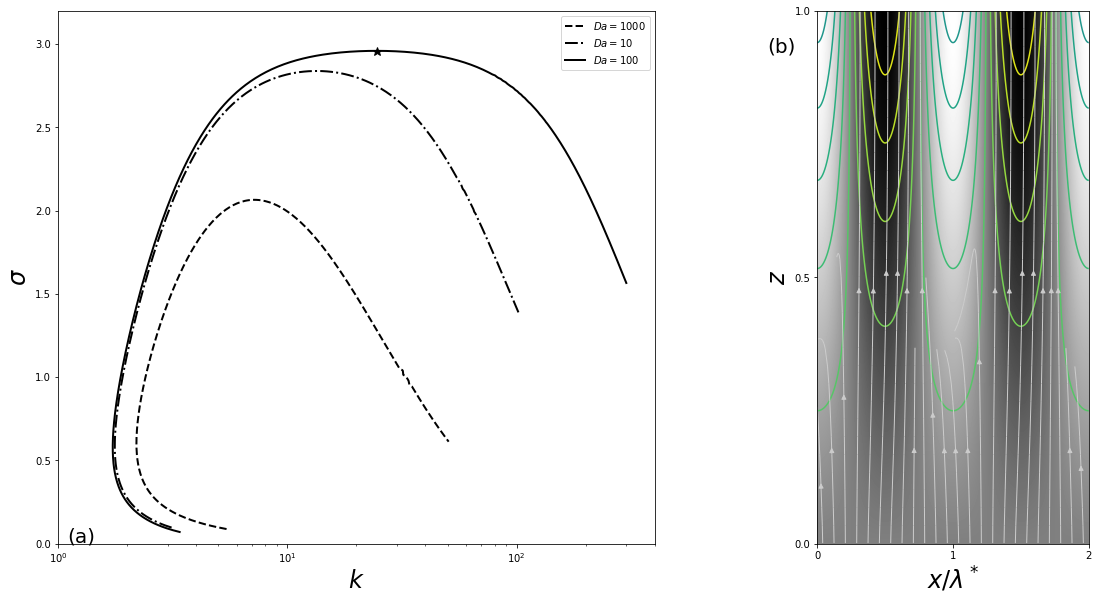

In [15]:
f, ax = plt.subplots()
zoom = 2.0
f.set_size_inches(9.8 * zoom, 4.9 * zoom)
f.set_facecolor('w')

gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 1])

ax0 = plt.subplot(gs[0])
ax0.plot(DC_a.k, DC_a.s, '--k', linewidth=2, label=r'$Da=1000$')
ax0.plot(DC_b.k, DC_b.s, '-.k', linewidth=2, label=r'$Da=10$')
ax0.plot(DC_ref.k, DC_ref.s, '-k', linewidth=2, label=r'$Da=100$')
ax0.plot(DC_ref.k[iref], DC_ref.s[iref], '*k', MarkerSize=9)
ax0.set_xlabel(r'$k$', fontsize=24)
ax0.set_xscale('log')
ax0.set_xlim(1.0, 400.0)
ax0.set_xticks((1e0, 1e1, 1e2))
ax0.set_ylim(0.0, 3.2)
ax0.set_ylabel(r'$\sigma$', fontsize=24)
ax0.text(1.1, 0.1, '(a)', fontsize=20, verticalalignment='top', horizontalalignment='left')
ax0.legend()

ax1 = plt.subplot(gs[1])
ax1.imshow(np.flipud(P), cmap='gray', extent=[0.0, 2.*lambda_, 0.0, 1.0])
ax1.contour(X, Z, phi, levels=np.linspace(-1, 1, 20))
nlines = 24
h = 2.0 * lambda_/(nlines+1.0)
seed = np.zeros((nlines, 2))
seed[:, 0] = np.linspace(0.5*h, 2.0*lambda_-0.5*h, nlines)
seed[:, 1] = np.ones_like(seed[:, 0]) / 1000.0
ax1.streamplot(X, Z, U, W, start_points=seed, integration_direction='forward', color=[0.8, 0.8, 0.8], linewidth=1)
ax1.set_xlabel(r'$x/\lambda^*$', fontsize=24)
ax1.set_xlim(0, 2.*lambda_)
ax1.set_xticks((0, lambda_, 2*lambda_))
ax1.set_xticklabels((0, 1, 2))
ax1.set_ylabel(r'$z$', fontsize=24)
ax1.set_ylim(0, 1)
ax1.set_yticks((0, 0.5, 1))
ax1.text(-0.04, 0.95, '(b)', fontsize=20, verticalalignment='top', horizontalalignment='right')

plt.show()

In [16]:
Lkbounds = np.log10([0.1, 400.0])
sbounds = np.asarray([0.05, 4.0])
init_Lks = np.asarray([np.log10(5.0), 3.0])
DC_cube = {}
DC_quad = {}

for vals in [10., 100., 1000.]:
    par = PAR(Da_=vals, largeDa_=False)
    DC_cube[vals] = reactive_flow_trace_dispersion_curve(par, Lkbounds, sbounds, init_Lks)

    par = PAR(Da_=vals, largeDa_=True)
    DC_quad[vals] = reactive_flow_trace_dispersion_curve(par, Lkbounds, sbounds, init_Lks)

/var/folders/4z/_rhsq3x965gc56klbm0nmv040000gn/T/ipykernel_86415/1995957636.py:6: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  else np.full((1, 3), np.inf + 0.j, dtype=np.complex)


SUCCESS: monotonic eigenfunction for k=5.000000000000001, sigma=1.9700163558867765
Iteration 1: searching for solution at k=4.886186104779054
SUCCESS: monotonic eigenfunction for k=4.886186104779054, sigma=1.9570167816517678
Iteration 2: searching for solution at k=4.818066292998758
SUCCESS: monotonic eigenfunction for k=4.818066292998758, sigma=1.9486469892766827
Iteration 3: searching for solution at k=4.754040003771168
SUCCESS: monotonic eigenfunction for k=4.754040003771168, sigma=1.9403553170435563
Iteration 4: searching for solution at k=4.692426291378214
SUCCESS: monotonic eigenfunction for k=4.692426291378214, sigma=1.9319700450992363
Iteration 5: searching for solution at k=4.633064371552892


SUCCESS: monotonic eigenfunction for k=4.633064371552892, sigma=1.9234983480123409
Iteration 6: searching for solution at k=4.5758148172813105
SUCCESS: monotonic eigenfunction for k=4.5758148172813105, sigma=1.9149475845022907
Iteration 7: searching for solution at k=4.520549371340002
SUCCESS: monotonic eigenfunction for k=4.520549371340002, sigma=1.9063242690522204
Iteration 8: searching for solution at k=4.467150150135163
SUCCESS: monotonic eigenfunction for k=4.467150150135163, sigma=1.8976342104797228
Iteration 9: searching for solution at k=4.415508691909503
SUCCESS: monotonic eigenfunction for k=4.415508691909503, sigma=1.8888826033710042
Iteration 10: searching for solution at k=4.365525084166818
SUCCESS: monotonic eigenfunction for k=4.365525084166818, sigma=1.8800741057396457
Iteration 11: searching for solution at k=4.317107171973182


SUCCESS: monotonic eigenfunction for k=4.317107171973182, sigma=1.871212905602078
Iteration 12: searching for solution at k=4.270169842227954
SUCCESS: monotonic eigenfunction for k=4.270169842227954, sigma=1.8623027781711918
Iteration 13: searching for solution at k=4.224634378169275
SUCCESS: monotonic eigenfunction for k=4.224634378169275, sigma=1.853347135102276
Iteration 14: searching for solution at k=4.180427878099277
SUCCESS: monotonic eigenfunction for k=4.180427878099277, sigma=1.844349066998188
Iteration 15: searching for solution at k=4.137482732372996
SUCCESS: monotonic eigenfunction for k=4.137482732372996, sigma=1.8353113801884309
Iteration 16: searching for solution at k=4.095736152954842
SUCCESS: monotonic eigenfunction for k=4.095736152954842, sigma=1.8262366286347425
Iteration 17: searching for solution at k=4.055129750219698


SUCCESS: monotonic eigenfunction for k=4.055129750219698, sigma=1.8171271416804313
Iteration 18: searching for solution at k=4.015609152100093
SUCCESS: monotonic eigenfunction for k=4.015609152100093, sigma=1.8079850482469608
Iteration 19: searching for solution at k=3.9771236611224396
SUCCESS: monotonic eigenfunction for k=3.9771236611224396, sigma=1.798812297986766
Iteration 20: searching for solution at k=3.939625945307459
SUCCESS: monotonic eigenfunction for k=3.939625945307459, sigma=1.7896106798219193
Iteration 21: searching for solution at k=3.9030717593216315
SUCCESS: monotonic eigenfunction for k=3.9030717593216315, sigma=1.7803818382322183
Iteration 22: searching for solution at k=3.867419692648691
SUCCESS: monotonic eigenfunction for k=3.867419692648691, sigma=1.7711272876009183
Iteration 23: searching for solution at k=3.8326309419001916


SUCCESS: monotonic eigenfunction for k=3.8326309419001916, sigma=1.7618484248799273
Iteration 24: searching for solution at k=3.7986691047016032
SUCCESS: monotonic eigenfunction for k=3.7986691047016032, sigma=1.7525465407975287
Iteration 25: searching for solution at k=3.765499992875149
SUCCESS: monotonic eigenfunction for k=3.765499992875149, sigma=1.7432228297988757
Iteration 26: searching for solution at k=3.7330914628958687
SUCCESS: monotonic eigenfunction for k=3.7330914628958687, sigma=1.7338783988821982
Iteration 27: searching for solution at k=3.7014132618237823
SUCCESS: monotonic eigenfunction for k=3.7014132618237823, sigma=1.7245142754702605
Iteration 28: searching for solution at k=3.6704368871168476
SUCCESS: monotonic eigenfunction for k=3.6704368871168476, sigma=1.7151314144371435
Iteration 29: searching for solution at k=3.6401354589075625


SUCCESS: monotonic eigenfunction for k=3.6401354589075625, sigma=1.7057307043937635
Iteration 30: searching for solution at k=3.610483603483827
SUCCESS: monotonic eigenfunction for k=3.610483603483827, sigma=1.696312973321378
Iteration 31: searching for solution at k=3.581457346854353
SUCCESS: monotonic eigenfunction for k=3.581457346854353, sigma=1.6868789936304072
Iteration 32: searching for solution at k=3.5530340174019215
SUCCESS: monotonic eigenfunction for k=3.5530340174019215, sigma=1.6774294867115926
Iteration 33: searching for solution at k=3.5251921567367317
SUCCESS: monotonic eigenfunction for k=3.5251921567367317, sigma=1.667965127037764
Iteration 34: searching for solution at k=3.497911437958302
SUCCESS: monotonic eigenfunction for k=3.497911437958302, sigma=1.6584865458670102
Iteration 35: searching for solution at k=3.4711725906193354


SUCCESS: monotonic eigenfunction for k=3.4711725906193354, sigma=1.6489943345915885
Iteration 36: searching for solution at k=3.4449573317601287
SUCCESS: monotonic eigenfunction for k=3.4449573317601287, sigma=1.6394890477713298
Iteration 37: searching for solution at k=3.4192483024487927
SUCCESS: monotonic eigenfunction for k=3.4192483024487927, sigma=1.6299712058856088
Iteration 38: searching for solution at k=3.3940290093212235
SUCCESS: monotonic eigenfunction for k=3.3940290093212235, sigma=1.6204412978336613
Iteration 39: searching for solution at k=3.3692837706673684
SUCCESS: monotonic eigenfunction for k=3.3692837706673684, sigma=1.610899783209625
Iteration 40: searching for solution at k=3.3449976666563783
SUCCESS: monotonic eigenfunction for k=3.3449976666563783, sigma=1.6013470943754358
Iteration 41: searching for solution at k=3.3211564933346174


SUCCESS: monotonic eigenfunction for k=3.3211564933346174, sigma=1.5917836383520547
Iteration 42: searching for solution at k=3.2977467200671433
SUCCESS: monotonic eigenfunction for k=3.2977467200671433, sigma=1.5822097985471903
Iteration 43: searching for solution at k=3.274755450125754
SUCCESS: monotonic eigenfunction for k=3.274755450125754, sigma=1.5726259363355501
Iteration 44: searching for solution at k=3.252170384155858
SUCCESS: monotonic eigenfunction for k=3.252170384155858, sigma=1.5630323925058556
Iteration 45: searching for solution at k=3.2299797862805093
SUCCESS: monotonic eigenfunction for k=3.2299797862805093, sigma=1.5534294885874178
Iteration 46: searching for solution at k=3.208172452622734


SUCCESS: monotonic eigenfunction for k=3.208172452622734, sigma=1.5438175280674484
Iteration 47: searching for solution at k=3.1867376820484443
SUCCESS: monotonic eigenfunction for k=3.1867376820484443, sigma=1.5341967975092534
Iteration 48: searching for solution at k=3.1656652489506003
SUCCESS: monotonic eigenfunction for k=3.1656652489506003, sigma=1.524567567580356
Iteration 49: searching for solution at k=3.144945377911809
SUCCESS: monotonic eigenfunction for k=3.144945377911809, sigma=1.5149300939985113
Iteration 50: searching for solution at k=3.1245687200977983


SUCCESS: monotonic eigenfunction for k=3.1245687200977983, sigma=1.5052846184029338
Iteration 51: searching for solution at k=3.1045263312473352
SUCCESS: monotonic eigenfunction for k=3.1045263312473352, sigma=1.4956313691571226
Iteration 52: searching for solution at k=3.084809651136526
SUCCESS: monotonic eigenfunction for k=3.084809651136526, sigma=1.4859705620892223
Iteration 53: searching for solution at k=3.065410484405965
SUCCESS: monotonic eigenfunction for k=3.065410484405965, sigma=1.47630240117497
Iteration 54: searching for solution at k=3.046320982649537
SUCCESS: monotonic eigenfunction for k=3.046320982649537, sigma=1.4666270791681313
Iteration 55: searching for solution at k=3.0275336276720077


SUCCESS: monotonic eigenfunction for k=3.0275336276720077, sigma=1.4569447781825076
Iteration 56: searching for solution at k=3.0090412158309676
SUCCESS: monotonic eigenfunction for k=3.0090412158309676, sigma=1.4472556702294106
Iteration 57: searching for solution at k=2.9908368433857757
SUCCESS: monotonic eigenfunction for k=2.9908368433857757, sigma=1.4375599177140286
Iteration 58: searching for solution at k=2.9729138927827723
SUCCESS: monotonic eigenfunction for k=2.9729138927827723, sigma=1.4278576738937903
Iteration 59: searching for solution at k=2.9552660198120204
SUCCESS: monotonic eigenfunction for k=2.9552660198120204, sigma=1.4181490833015142
Iteration 60: searching for solution at k=2.9378871415763097
SUCCESS: monotonic eigenfunction for k=2.9378871415763097, sigma=1.4084342821359155
Iteration 61: searching for solution at k=2.9207714252179886


SUCCESS: monotonic eigenfunction for k=2.9207714252179886, sigma=1.3987133986216935
Iteration 62: searching for solution at k=2.9039132773538574
SUCCESS: monotonic eigenfunction for k=2.9039132773538574, sigma=1.388986553341307
Iteration 63: searching for solution at k=2.8873073341723305
SUCCESS: monotonic eigenfunction for k=2.8873073341723305, sigma=1.3792538595402484
Iteration 64: searching for solution at k=2.87094845215095
SUCCESS: monotonic eigenfunction for k=2.87094845215095, sigma=1.3695154234075526
Iteration 65: searching for solution at k=2.8548316993555907
SUCCESS: monotonic eigenfunction for k=2.8548316993555907, sigma=1.3597713443328892
Iteration 66: searching for solution at k=2.838952347286206
SUCCESS: monotonic eigenfunction for k=2.838952347286206, sigma=1.3500217151417906
Iteration 67: searching for solution at k=2.823305863236351


SUCCESS: monotonic eigenfunction for k=2.823305863236351, sigma=1.340266622309983
Iteration 68: searching for solution at k=2.8078879031368893
SUCCESS: monotonic eigenfunction for k=2.8078879031368893, sigma=1.3305061461580339
Iteration 69: searching for solution at k=2.792694304856401
SUCCESS: monotonic eigenfunction for k=2.792694304856401, sigma=1.3207403610271853
Iteration 70: searching for solution at k=2.777721081933173
SUCCESS: monotonic eigenfunction for k=2.777721081933173, sigma=1.3109693354371579
Iteration 71: searching for solution at k=2.7629644177158332
SUCCESS: monotonic eigenfunction for k=2.7629644177158332, sigma=1.3011931322266694
Iteration 72: searching for solution at k=2.7484206598915
SUCCESS: monotonic eigenfunction for k=2.7484206598915, sigma=1.2914118086772268
Iteration 73: searching for solution at k=2.734086315382176


SUCCESS: monotonic eigenfunction for k=2.734086315382176, sigma=1.2816254166206644
Iteration 74: searching for solution at k=2.7199580455918255
SUCCESS: monotonic eigenfunction for k=2.7199580455918255, sigma=1.2718340025308148
Iteration 75: searching for solution at k=2.7060326619881088
SUCCESS: monotonic eigenfunction for k=2.7060326619881088, sigma=1.2620376075996158
Iteration 76: searching for solution at k=2.692307122004158
SUCCESS: monotonic eigenfunction for k=2.692307122004158, sigma=1.252236267797728
Iteration 77: searching for solution at k=2.6787785252473655
SUCCESS: monotonic eigenfunction for k=2.6787785252473655, sigma=1.2424300139198778
Iteration 78: searching for solution at k=2.6654441100031585


SUCCESS: monotonic eigenfunction for k=2.6654441100031585, sigma=1.2326188716147497
Iteration 79: searching for solution at k=2.6523012500232412
SUCCESS: monotonic eigenfunction for k=2.6523012500232412, sigma=1.2228028613993565
Iteration 80: searching for solution at k=2.639347451588817
SUCCESS: monotonic eigenfunction for k=2.639347451588817, sigma=1.212981998657598
Iteration 81: searching for solution at k=2.626580350840465
SUCCESS: monotonic eigenfunction for k=2.626580350840465, sigma=1.20315629362262
Iteration 82: searching for solution at k=2.61399771136743
SUCCESS: monotonic eigenfunction for k=2.61399771136743, sigma=1.193325751342457
Iteration 83: searching for solution at k=2.6015974220501143
SUCCESS: monotonic eigenfunction for k=2.6015974220501143, sigma=1.183490371628276
Iteration 84: searching for solution at k=2.5893774951505937


SUCCESS: monotonic eigenfunction for k=2.5893774951505937, sigma=1.1736501489844045
Iteration 85: searching for solution at k=2.5773360646469734
SUCCESS: monotonic eigenfunction for k=2.5773360646469734, sigma=1.1638050725191356
Iteration 86: searching for solution at k=2.565471384808354
SUCCESS: monotonic eigenfunction for k=2.565471384808354, sigma=1.1539551258351144
Iteration 87: searching for solution at k=2.553781829008159
SUCCESS: monotonic eigenfunction for k=2.553781829008159, sigma=1.1441002868978438
Iteration 88: searching for solution at k=2.5422658887745877
SUCCESS: monotonic eigenfunction for k=2.5422658887745877, sigma=1.1342405278807188
Iteration 89: searching for solution at k=2.5309221730777995


SUCCESS: monotonic eigenfunction for k=2.5309221730777995, sigma=1.1243758149844822
Iteration 90: searching for solution at k=2.51974940785463
SUCCESS: monotonic eigenfunction for k=2.51974940785463, sigma=1.1145061082289736
Iteration 91: searching for solution at k=2.5087464357724025
SUCCESS: monotonic eigenfunction for k=2.5087464357724025, sigma=1.104631361214335
Iteration 92: searching for solution at k=2.497912216234658
SUCCESS: monotonic eigenfunction for k=2.497912216234658, sigma=1.0947515208486829
Iteration 93: searching for solution at k=2.487245825632506
SUCCESS: monotonic eigenfunction for k=2.487245825632506, sigma=1.0848665270385103
Iteration 94: searching for solution at k=2.4767464578465623


SUCCESS: monotonic eigenfunction for k=2.4767464578465623, sigma=1.07497631233765
Iteration 95: searching for solution at k=2.4664134250055163
SUCCESS: monotonic eigenfunction for k=2.4664134250055163, sigma=1.065080801549821
Iteration 96: searching for solution at k=2.4562461585086406
SUCCESS: monotonic eigenfunction for k=2.4562461585086406, sigma=1.0551799112789613
Iteration 97: searching for solution at k=2.446244210320908
SUCCESS: monotonic eigenfunction for k=2.446244210320908, sigma=1.0452735494206293
Iteration 98: searching for solution at k=2.4364072545507005


SUCCESS: monotonic eigenfunction for k=2.4364072545507005, sigma=1.0353616145864417
Iteration 99: searching for solution at k=2.4267350893217277
SUCCESS: monotonic eigenfunction for k=2.4267350893217277, sigma=1.0254439954522454
Iteration 100: searching for solution at k=2.417227638952335
SUCCESS: monotonic eigenfunction for k=2.417227638952335, sigma=1.0155205700189511
Iteration 101: searching for solution at k=2.4078849564571914
SUCCESS: monotonic eigenfunction for k=2.4078849564571914, sigma=1.0055912047728603
Iteration 102: searching for solution at k=2.3987072263884013
SUCCESS: monotonic eigenfunction for k=2.3987072263884013, sigma=0.9956557537300296
Iteration 103: searching for solution at k=2.3896947680351004
SUCCESS: monotonic eigenfunction for k=2.3896947680351004, sigma=0.9857140573459586
Iteration 104: searching for solution at k=2.380848039003137


SUCCESS: monotonic eigenfunction for k=2.380848039003137, sigma=0.9757659412683484
Iteration 105: searching for solution at k=2.3721676391990965
SUCCESS: monotonic eigenfunction for k=2.3721676391990965, sigma=0.9658112149061522
Iteration 106: searching for solution at k=2.3636543152458587
SUCCESS: monotonic eigenfunction for k=2.3636543152458587, sigma=0.9558496697823765
Iteration 107: searching for solution at k=2.355308965360398
SUCCESS: monotonic eigenfunction for k=2.355308965360398, sigma=0.9458810776312976
Iteration 108: searching for solution at k=2.347132644728264
SUCCESS: monotonic eigenfunction for k=2.347132644728264, sigma=0.9359051881918191
Iteration 109: searching for solution at k=2.339126571413702


SUCCESS: monotonic eigenfunction for k=2.339126571413702, sigma=0.9259217266378705
Iteration 110: searching for solution at k=2.331292132849325
SUCCESS: monotonic eigenfunction for k=2.331292132849325, sigma=0.9159303905726116
Iteration 111: searching for solution at k=2.3236308929551908
SUCCESS: monotonic eigenfunction for k=2.3236308929551908, sigma=0.9059308464954904
Iteration 112: searching for solution at k=2.316144599943956
SUCCESS: monotonic eigenfunction for k=2.316144599943956, sigma=0.8959227256282085
Iteration 113: searching for solution at k=2.3088351948768016
SUCCESS: monotonic eigenfunction for k=2.3088351948768016, sigma=0.88590561895582
Iteration 114: searching for solution at k=2.3017048210444617
SUCCESS: monotonic eigenfunction for k=2.3017048210444617, sigma=0.8758790713003182
Iteration 115: searching for solution at k=2.294755834259071


SUCCESS: monotonic eigenfunction for k=2.294755834259071, sigma=0.8658425741924616
Iteration 116: searching for solution at k=2.2879908141565086
SUCCESS: monotonic eigenfunction for k=2.2879908141565086, sigma=0.8557955572390212
Iteration 117: searching for solution at k=2.28141257662585
SUCCESS: monotonic eigenfunction for k=2.28141257662585, sigma=0.845737377589805
Iteration 118: searching for solution at k=2.2750241875037345
SUCCESS: monotonic eigenfunction for k=2.2750241875037345, sigma=0.8356673069826155
Iteration 119: searching for solution at k=2.2688289776978223
SUCCESS: monotonic eigenfunction for k=2.2688289776978223, sigma=0.8255845156693287
Iteration 120: searching for solution at k=2.262830559937383


SUCCESS: monotonic eigenfunction for k=2.262830559937383, sigma=0.8154880522816933
Iteration 121: searching for solution at k=2.2570328473925887
SUCCESS: monotonic eigenfunction for k=2.2570328473925887, sigma=0.8053768183471879
Iteration 122: searching for solution at k=2.2514400744614735
SUCCESS: monotonic eigenfunction for k=2.2514400744614735, sigma=0.7952495356617809
Iteration 123: searching for solution at k=2.2460568201002693
SUCCESS: monotonic eigenfunction for k=2.2460568201002693, sigma=0.785104703985472
Iteration 124: searching for solution at k=2.2408880341772797
SUCCESS: monotonic eigenfunction for k=2.2408880341772797, sigma=0.7749405454125572
Iteration 125: searching for solution at k=2.2359390674761093


SUCCESS: monotonic eigenfunction for k=2.2359390674761093, sigma=0.7647549300583495
Iteration 126: searching for solution at k=2.231215706180977
SUCCESS: monotonic eigenfunction for k=2.231215706180977, sigma=0.7545452750089868
Iteration 127: searching for solution at k=2.226724211978989
SUCCESS: monotonic eigenfunction for k=2.226724211978989, sigma=0.7443084041151938
Iteration 128: searching for solution at k=2.2224713693666436
SUCCESS: monotonic eigenfunction for k=2.2224713693666436, sigma=0.7340403489047973
Iteration 129: searching for solution at k=2.218464542447033


SUCCESS: monotonic eigenfunction for k=2.218464542447033, sigma=0.7237360582063108
Iteration 130: searching for solution at k=2.2147117446215323
SUCCESS: monotonic eigenfunction for k=2.2147117446215323, sigma=0.7133889610962878
Iteration 131: searching for solution at k=2.211221726437201
SUCCESS: monotonic eigenfunction for k=2.211221726437201, sigma=0.7029902840006955
Iteration 132: searching for solution at k=2.208004090082957
SUCCESS: monotonic eigenfunction for k=2.208004090082957, sigma=0.6925279342052326
Iteration 133: searching for solution at k=2.205069444962448
SUCCESS: monotonic eigenfunction for k=2.205069444962448, sigma=0.6819845692445466
Iteration 134: searching for solution at k=2.202429630409548


SUCCESS: monotonic eigenfunction for k=2.202429630409548, sigma=0.671334011954568
Iteration 135: searching for solution at k=2.200098056375684
SUCCESS: monotonic eigenfunction for k=2.200098056375684, sigma=0.6605339377413902
Iteration 136: searching for solution at k=2.19809027148376
SUCCESS: monotonic eigenfunction for k=2.19809027148376, sigma=0.6495088790275766
Iteration 137: searching for solution at k=2.196425027762355
SUCCESS: monotonic eigenfunction for k=2.196425027762355, sigma=0.6381021592897314
Iteration 138: searching for solution at k=2.1951266510118272
SUCCESS: monotonic eigenfunction for k=2.1951266510118272, sigma=0.6258843334676333
Iteration 139: searching for solution at k=2.1942321405209118


SUCCESS: monotonic eigenfunction for k=2.1942321405209118, sigma=0.6101305479052936
Iteration 140: searching for solution at k=2.1938411237490865
FAILURE: no solution found for k=2.1938411237490865
Iteration 140: searching for solution at k=2.1938411237490865
FAILURE: no solution found for k=2.1938411237490865
Iteration 140: searching for solution at sigma=0.6001306153838054
SUCCESS: monotonic eigenfunction for k=2.194143805205507, sigma=0.6001306153838054
Iteration 141: searching for solution at k=2.194241574481091


/var/folders/4z/_rhsq3x965gc56klbm0nmv040000gn/T/ipykernel_86415/3419235840.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p = np.asarray([0.0 if par.largeDa else sig / par.Da,  # cubic


SUCCESS: monotonic eigenfunction for k=2.194241574481091, sigma=0.5952559153217529
Iteration 142: searching for solution at k=2.1946364038839157
SUCCESS: monotonic eigenfunction for k=2.1946364038839157, sigma=0.5868173046121936
Iteration 143: searching for solution at k=2.1953051846777414
SUCCESS: monotonic eigenfunction for k=2.1953051846777414, sigma=0.578592899512391
Iteration 144: searching for solution at k=2.1963257157524163
SUCCESS: monotonic eigenfunction for k=2.1963257157524163, sigma=0.5699206675160375
Iteration 145: searching for solution at k=2.197717785834872


SUCCESS: monotonic eigenfunction for k=2.197717785834872, sigma=0.5610508909972197
Iteration 146: searching for solution at k=2.19951092947217
SUCCESS: monotonic eigenfunction for k=2.19951092947217, sigma=0.5520266471862376
Iteration 147: searching for solution at k=2.201730600627028
SUCCESS: monotonic eigenfunction for k=2.201730600627028, sigma=0.5428907489608308
Iteration 148: searching for solution at k=2.204402181762495
SUCCESS: monotonic eigenfunction for k=2.204402181762495, sigma=0.5336707530306223
Iteration 149: searching for solution at k=2.207551293682356
SUCCESS: monotonic eigenfunction for k=2.207551293682356, sigma=0.5243864962677817
Iteration 150: searching for solution at k=2.211204287544978


SUCCESS: monotonic eigenfunction for k=2.211204287544978, sigma=0.5150527523338528
Iteration 151: searching for solution at k=2.2153885572443843
SUCCESS: monotonic eigenfunction for k=2.2153885572443843, sigma=0.5056809753273321
Iteration 152: searching for solution at k=2.2201327789418257
SUCCESS: monotonic eigenfunction for k=2.2201327789418257, sigma=0.496280383317702
Iteration 153: searching for solution at k=2.225467103843091
SUCCESS: monotonic eigenfunction for k=2.225467103843091, sigma=0.48685866668045585
Iteration 154: searching for solution at k=2.231423321112713
SUCCESS: monotonic eigenfunction for k=2.231423321112713, sigma=0.4774224678591187
Iteration 155: searching for solution at k=2.23803499987153


SUCCESS: monotonic eigenfunction for k=2.23803499987153, sigma=0.46797771771333624
Iteration 156: searching for solution at k=2.2453376147818838
SUCCESS: monotonic eigenfunction for k=2.2453376147818838, sigma=0.45852987921482274
Iteration 157: searching for solution at k=2.2533686569024436
SUCCESS: monotonic eigenfunction for k=2.2533686569024436, sigma=0.449084129712734
Iteration 158: searching for solution at k=2.262167729557545
SUCCESS: monotonic eigenfunction for k=2.262167729557545, sigma=0.4396455014652541
Iteration 159: searching for solution at k=2.2717766275177858
SUCCESS: monotonic eigenfunction for k=2.2717766275177858, sigma=0.4302189931065886
Iteration 160: searching for solution at k=2.2822393966247594


SUCCESS: monotonic eigenfunction for k=2.2822393966247594, sigma=0.42080966028744726
Iteration 161: searching for solution at k=2.2936023700121617
SUCCESS: monotonic eigenfunction for k=2.2936023700121617, sigma=0.4114226908359242
Iteration 162: searching for solution at k=2.3059141762419078
SUCCESS: monotonic eigenfunction for k=2.3059141762419078, sigma=0.40206346782858604
Iteration 163: searching for solution at k=2.319225713995116
SUCCESS: monotonic eigenfunction for k=2.319225713995116, sigma=0.39273762258295486
Iteration 164: searching for solution at k=2.3335900874746094
SUCCESS: monotonic eigenfunction for k=2.3335900874746094, sigma=0.38345107857201965
Iteration 165: searching for solution at k=2.34906249645674


SUCCESS: monotonic eigenfunction for k=2.34906249645674, sigma=0.3742100864936733
Iteration 166: searching for solution at k=2.3657000750662878
SUCCESS: monotonic eigenfunction for k=2.3657000750662878, sigma=0.36502125013219255
Iteration 167: searching for solution at k=2.3835616739438468
SUCCESS: monotonic eigenfunction for k=2.3835616739438468, sigma=0.3558915421899032
Iteration 168: searching for solution at k=2.402707581639326
SUCCESS: monotonic eigenfunction for k=2.402707581639326, sigma=0.346828308934239
Iteration 169: searching for solution at k=2.423199182893887
SUCCESS: monotonic eigenfunction for k=2.423199182893887, sigma=0.3378392623055479
Iteration 170: searching for solution at k=2.4450985540279904


SUCCESS: monotonic eigenfunction for k=2.4450985540279904, sigma=0.3289324580825455
Iteration 171: searching for solution at k=2.4684679989367404
SUCCESS: monotonic eigenfunction for k=2.4684679989367404, sigma=0.3201162588294473
Iteration 172: searching for solution at k=2.4933695331191728
SUCCESS: monotonic eigenfunction for k=2.4933695331191728, sigma=0.3113992806744799
Iteration 173: searching for solution at k=2.5198643275372947
SUCCESS: monotonic eigenfunction for k=2.5198643275372947, sigma=0.3027903235074436
Iteration 174: searching for solution at k=2.548012128590511
SUCCESS: monotonic eigenfunction for k=2.548012128590511, sigma=0.2942982849305799
Iteration 175: searching for solution at k=2.57787067466124


SUCCESS: monotonic eigenfunction for k=2.57787067466124, sigma=0.28593205922280407
Iteration 176: searching for solution at k=2.6094951330141503
SUCCESS: monotonic eigenfunction for k=2.6094951330141503, sigma=0.2777004236221228
Iteration 177: searching for solution at k=2.6429375827710544
SUCCESS: monotonic eigenfunction for k=2.6429375827710544, sigma=0.2696119153031543
Iteration 178: searching for solution at k=2.678246569762177
SUCCESS: monotonic eigenfunction for k=2.678246569762177, sigma=0.26167470340916216
Iteration 179: searching for solution at k=2.7154667569675945
SUCCESS: monotonic eigenfunction for k=2.7154667569675945, sigma=0.2538964612624246
Iteration 180: searching for solution at k=2.754638689963233


SUCCESS: monotonic eigenfunction for k=2.754638689963233, sigma=0.24628424430285917
Iteration 181: searching for solution at k=2.795798690536334
SUCCESS: monotonic eigenfunction for k=2.795798690536334, sigma=0.23884437930322364
Iteration 182: searching for solution at k=2.8389788840011714
SUCCESS: monotonic eigenfunction for k=2.8389788840011714, sigma=0.2315823699415709
Iteration 183: searching for solution at k=2.8842073575240548
SUCCESS: monotonic eigenfunction for k=2.8842073575240548, sigma=0.2245028229026245
Iteration 184: searching for solution at k=2.9315084388590464
SUCCESS: monotonic eigenfunction for k=2.9315084388590464, sigma=0.21760939741726623
Iteration 185: searching for solution at k=2.9809030781561288


SUCCESS: monotonic eigenfunction for k=2.9809030781561288, sigma=0.2109047796711516
Iteration 186: searching for solution at k=3.0324093105933265
SUCCESS: monotonic eigenfunction for k=3.0324093105933265, sigma=0.20439068198388255
Iteration 187: searching for solution at k=3.0860427748743473
SUCCESS: monotonic eigenfunction for k=3.0860427748743473, sigma=0.19806786524159856
Iteration 188: searching for solution at k=3.1418172621694334
SUCCESS: monotonic eigenfunction for k=3.1418172621694334, sigma=0.19193618189279485
Iteration 189: searching for solution at k=3.1997452716125


SUCCESS: monotonic eigenfunction for k=3.1997452716125, sigma=0.18599463597795182
Iteration 190: searching for solution at k=3.2598385515451187
SUCCESS: monotonic eigenfunction for k=3.2598385515451187, sigma=0.1802414561932202
Iteration 191: searching for solution at k=3.322108609756573
SUCCESS: monotonic eigenfunction for k=3.322108609756573, sigma=0.17467417787215636
Iteration 192: searching for solution at k=3.386567180446297
SUCCESS: monotonic eigenfunction for k=3.386567180446297, sigma=0.16928972995456837
Iteration 193: searching for solution at k=3.453226640045617
SUCCESS: monotonic eigenfunction for k=3.453226640045617, sigma=0.16408452342242077
Iteration 194: searching for solution at k=3.5221003680184646


SUCCESS: monotonic eigenfunction for k=3.5221003680184646, sigma=0.15905453823685142
Iteration 195: searching for solution at k=3.593203052091719
SUCCESS: monotonic eigenfunction for k=3.593203052091719, sigma=0.15419540643029353
Iteration 196: searching for solution at k=3.6665509399475407
SUCCESS: monotonic eigenfunction for k=3.6665509399475407, sigma=0.149502489629498
Iteration 197: searching for solution at k=3.74216204124484
SUCCESS: monotonic eigenfunction for k=3.74216204124484, sigma=0.14497094986208875
Iteration 198: searching for solution at k=3.8200562849961224


SUCCESS: monotonic eigenfunction for k=3.8200562849961224, sigma=0.14059581300161586
Iteration 199: searching for solution at k=3.9002556379188604
SUCCESS: monotonic eigenfunction for k=3.9002556379188604, sigma=0.13637202461952277
Iteration 200: searching for solution at k=3.9827841895310336
SUCCESS: monotonic eigenfunction for k=3.9827841895310336, sigma=0.13229449833438287
Iteration 201: searching for solution at k=4.067668209588954
SUCCESS: monotonic eigenfunction for k=4.067668209588954, sigma=0.12835815698472508
Iteration 202: searching for solution at k=4.154936183078664
SUCCESS: monotonic eigenfunction for k=4.154936183078664, sigma=0.12455796711217351
Iteration 203: searching for solution at k=4.2446188274578915


SUCCESS: monotonic eigenfunction for k=4.2446188274578915, sigma=0.12088896733912766
Iteration 204: searching for solution at k=4.336749096271504
SUCCESS: monotonic eigenfunction for k=4.336749096271504, sigma=0.11734629127285885
Iteration 205: searching for solution at k=4.431362172679148
FAILURE: no solution found for k=4.431362172679148
Iteration 205: searching for solution at k=4.431362172679148
FAILURE: no solution found for k=4.431362172679148
Iteration 205: searching for solution at sigma=0.11385890372463223
SUCCESS: monotonic eigenfunction for k=4.433253396031679, sigma=0.11385890372463223
Iteration 206: searching for solution at k=4.530432500980117
FAILURE: no solution found for k=4.530432500980117


Iteration 206: searching for solution at k=4.530432500980117
FAILURE: no solution found for k=4.530432500980117
Iteration 206: searching for solution at sigma=0.11049274847129582
SUCCESS: monotonic eigenfunction for k=4.532387505018471, sigma=0.11049274847129582
Iteration 207: searching for solution at k=4.632178682510815
FAILURE: no solution found for k=4.632178682510815
Iteration 207: searching for solution at k=4.632178682510815
FAILURE: no solution found for k=4.632178682510815
Iteration 207: searching for solution at sigma=0.10724420478043752
SUCCESS: monotonic eigenfunction for k=4.6341584150855315, sigma=0.10724420478043752
Iteration 208: searching for solution at k=4.736604438510556
FAILURE: no solution found for k=4.736604438510556


Iteration 208: searching for solution at k=4.736604438510556
FAILURE: no solution found for k=4.736604438510556
Iteration 208: searching for solution at sigma=0.10410855944043974
SUCCESS: monotonic eigenfunction for k=4.738609289546041, sigma=0.10410855944043974
Iteration 209: searching for solution at k=4.843755236802824
FAILURE: no solution found for k=4.843755236802824
Iteration 209: searching for solution at k=4.843755236802824
FAILURE: no solution found for k=4.843755236802824
Iteration 209: searching for solution at sigma=0.10108126738417506
SUCCESS: monotonic eigenfunction for k=4.845785771892302, sigma=0.10108126738417506
Iteration 210: searching for solution at k=4.953678972806628
FAILURE: no solution found for k=4.953678972806628


Iteration 210: searching for solution at k=4.953678972806628
FAILURE: no solution found for k=4.953678972806628
Iteration 210: searching for solution at sigma=0.09815795871874326
SUCCESS: monotonic eigenfunction for k=4.955735796648816, sigma=0.09815795871874326
Iteration 211: searching for solution at k=5.066425806571341
FAILURE: no solution found for k=5.066425806571341
Iteration 211: searching for solution at k=5.066425806571341
FAILURE: no solution found for k=5.066425806571341
Iteration 211: searching for solution at sigma=0.09533443814323811


SUCCESS: monotonic eigenfunction for k=5.068509567270285, sigma=0.09533443814323811
Iteration 212: searching for solution at k=5.182048144719454
FAILURE: no solution found for k=5.182048144719454
Iteration 212: searching for solution at k=5.182048144719454
FAILURE: no solution found for k=5.182048144719454
Iteration 212: searching for solution at sigma=0.09260668304586278
SUCCESS: monotonic eigenfunction for k=5.184159530681834, sigma=0.09260668304586278
Iteration 213: searching for solution at k=5.300600617861071
FAILURE: no solution found for k=5.300600617861071
Iteration 213: searching for solution at k=5.300600617861071
FAILURE: no solution found for k=5.300600617861071


Iteration 213: searching for solution at sigma=0.08997084041119703
SUCCESS: monotonic eigenfunction for k=5.302740354941463, sigma=0.08997084041119703
Iteration 214: searching for solution at k=5.422140061488119
FAILURE: no solution found for k=5.422140061488119
Iteration 214: searching for solution at k=5.422140061488119
FAILURE: no solution found for k=5.422140061488119
Iteration 214: searching for solution at sigma=0.0874232228098606
SUCCESS: monotonic eigenfunction for k=5.424308910524169, sigma=0.0874232228098606
Iteration 215: searching for solution at k=5.546725500733714


FAILURE: no solution found for k=5.546725500733714
Iteration 215: searching for solution at k=5.546725500733714
FAILURE: no solution found for k=5.546725500733714
Iteration 215: searching for solution at sigma=0.08496030370179808
FAILURE: non-monotonic eigenfunction for k=6.462907396995104, sigma=0.08496030370179808
Iteration 215: searching for solution at k=5.071604746902777
SUCCESS: monotonic eigenfunction for k=5.071604746902777, sigma=1.977597708193289
Iteration 216: searching for solution at k=5.146882718933767
SUCCESS: monotonic eigenfunction for k=5.146882718933767, sigma=1.9850979474381596
Iteration 217: searching for solution at k=5.225450712377876
SUCCESS: monotonic eigenfunction for k=5.225450712377876, sigma=1.9924362645650278
Iteration 218: searching for solution at k=5.307540535674139
SUCCESS: monotonic eigenfunction for k=5.307540535674139, sigma=1.9995950848331292
Iteration 219: searching for solution at k=5.393405914221006


SUCCESS: monotonic eigenfunction for k=5.393405914221006, sigma=2.006554947329292
Iteration 220: searching for solution at k=5.48331794312552
SUCCESS: monotonic eigenfunction for k=5.48331794312552, sigma=2.0132937670130375
Iteration 221: searching for solution at k=5.577564058747568
SUCCESS: monotonic eigenfunction for k=5.577564058747568, sigma=2.0197865324564193
Iteration 222: searching for solution at k=5.6764453734025055
SUCCESS: monotonic eigenfunction for k=5.6764453734025055, sigma=2.0260049820274597
Iteration 223: searching for solution at k=5.780272024861768
SUCCESS: monotonic eigenfunction for k=5.780272024861768, sigma=2.0319173097030236
Iteration 224: searching for solution at k=5.88935582680387


SUCCESS: monotonic eigenfunction for k=5.88935582680387, sigma=2.0374879466329086
Iteration 225: searching for solution at k=6.0039994129673415
SUCCESS: monotonic eigenfunction for k=6.0039994129673415, sigma=2.042677487529915
Iteration 226: searching for solution at k=6.1244810819548965
SUCCESS: monotonic eigenfunction for k=6.1244810819548965, sigma=2.047442858085025
Iteration 227: searching for solution at k=6.251034787950012
SUCCESS: monotonic eigenfunction for k=6.251034787950012, sigma=2.0517378465341
Iteration 228: searching for solution at k=6.383825337384058
SUCCESS: monotonic eigenfunction for k=6.383825337384058, sigma=2.0555141390327436
Iteration 229: searching for solution at k=6.522919989640094
SUCCESS: monotonic eigenfunction for k=6.522919989640094, sigma=2.0587229870511066
Iteration 230: searching for solution at k=6.668259353083341


SUCCESS: monotonic eigenfunction for k=6.668259353083341, sigma=2.0613175721952373
Iteration 231: searching for solution at k=6.819632454263939
SUCCESS: monotonic eigenfunction for k=6.819632454263939, sigma=2.063255999591538
Iteration 232: searching for solution at k=6.976662415600719
SUCCESS: monotonic eigenfunction for k=6.976662415600719, sigma=2.064504647700353
Iteration 233: searching for solution at k=7.138809178320045
SUCCESS: monotonic eigenfunction for k=7.138809178320045, sigma=2.065041378541797
Iteration 234: searching for solution at k=7.305393144947522
SUCCESS: monotonic eigenfunction for k=7.305393144947522, sigma=2.0648579680872863
Iteration 235: searching for solution at k=7.475638527976963
SUCCESS: monotonic eigenfunction for k=7.475638527976963, sigma=2.063961165314795
Iteration 236: searching for solution at k=7.648729302481803


SUCCESS: monotonic eigenfunction for k=7.648729302481803, sigma=2.062372074572901
Iteration 237: searching for solution at k=7.823866779536002
SUCCESS: monotonic eigenfunction for k=7.823866779536002, sigma=2.060123989889276
Iteration 238: searching for solution at k=8.000317994673068
SUCCESS: monotonic eigenfunction for k=8.000317994673068, sigma=2.057259198854249
Iteration 239: searching for solution at k=8.177448060826976
SUCCESS: monotonic eigenfunction for k=8.177448060826976, sigma=2.053825447052517
Iteration 240: searching for solution at k=8.354735038242156
SUCCESS: monotonic eigenfunction for k=8.354735038242156, sigma=2.0498726752198495
Iteration 241: searching for solution at k=8.531770171493388
SUCCESS: monotonic eigenfunction for k=8.531770171493388, sigma=2.0454504069206645
Iteration 242: searching for solution at k=8.708248319941054


SUCCESS: monotonic eigenfunction for k=8.708248319941054, sigma=2.0406059111828947
Iteration 243: searching for solution at k=8.883953339213306
SUCCESS: monotonic eigenfunction for k=8.883953339213306, sigma=2.0353830823628627
Iteration 244: searching for solution at k=9.05874201961612
SUCCESS: monotonic eigenfunction for k=9.05874201961612, sigma=2.0298218901103158
Iteration 245: searching for solution at k=9.232528817399373
SUCCESS: monotonic eigenfunction for k=9.232528817399373, sigma=2.0239582340810123
Iteration 246: searching for solution at k=9.405272492029445
SUCCESS: monotonic eigenfunction for k=9.405272492029445, sigma=2.017824058629174
Iteration 247: searching for solution at k=9.576965013350081
SUCCESS: monotonic eigenfunction for k=9.576965013350081, sigma=2.0114476168839146
Iteration 248: searching for solution at k=9.747622677850163


SUCCESS: monotonic eigenfunction for k=9.747622677850163, sigma=2.004853807206915
Iteration 249: searching for solution at k=9.917279173631444
SUCCESS: monotonic eigenfunction for k=9.917279173631444, sigma=1.998064532295171
Iteration 250: searching for solution at k=10.085980268799723
SUCCESS: monotonic eigenfunction for k=10.085980268799723, sigma=1.9910990510961424
Iteration 251: searching for solution at k=10.253779804016425
SUCCESS: monotonic eigenfunction for k=10.253779804016425, sigma=1.983974307231853
Iteration 252: searching for solution at k=10.420736707531228
SUCCESS: monotonic eigenfunction for k=10.420736707531228, sigma=1.9767052263224156
Iteration 253: searching for solution at k=10.586912798385175
SUCCESS: monotonic eigenfunction for k=10.586912798385175, sigma=1.9693049798989202
Iteration 254: searching for solution at k=10.752371189790955


SUCCESS: monotonic eigenfunction for k=10.752371189790955, sigma=1.9617852166349823
Iteration 255: searching for solution at k=10.917175145355332
SUCCESS: monotonic eigenfunction for k=10.917175145355332, sigma=1.9541562632229745
Iteration 256: searching for solution at k=11.081387274481592
SUCCESS: monotonic eigenfunction for k=11.081387274481592, sigma=1.946427297931975
Iteration 257: searching for solution at k=11.245068980215551
SUCCESS: monotonic eigenfunction for k=11.245068980215551, sigma=1.9386065000745534
Iteration 258: searching for solution at k=11.408280093849267
SUCCESS: monotonic eigenfunction for k=11.408280093849267, sigma=1.9307011785103012
Iteration 259: searching for solution at k=11.571078646810905
SUCCESS: monotonic eigenfunction for k=11.571078646810905, sigma=1.922717882068247
Iteration 260: searching for solution at k=11.733520742734694


SUCCESS: monotonic eigenfunction for k=11.733520742734694, sigma=1.9146624944631518
Iteration 261: searching for solution at k=11.895660501971525
SUCCESS: monotonic eigenfunction for k=11.895660501971525, sigma=1.9065403159609513
Iteration 262: searching for solution at k=12.057550057861928
SUCCESS: monotonic eigenfunction for k=12.057550057861928, sigma=1.8983561337429742
Iteration 263: searching for solution at k=12.219239589403955
SUCCESS: monotonic eigenfunction for k=12.219239589403955, sigma=1.8901142826394142
Iteration 264: searching for solution at k=12.380777378928933
SUCCESS: monotonic eigenfunction for k=12.380777378928933, sigma=1.8818186976554057
Iteration 265: searching for solution at k=12.542209886383226
SUCCESS: monotonic eigenfunction for k=12.542209886383226, sigma=1.8734729594978448
Iteration 266: searching for solution at k=12.703581834045327


SUCCESS: monotonic eigenfunction for k=12.703581834045327, sigma=1.8650803341264273
Iteration 267: searching for solution at k=12.86493629717727
SUCCESS: monotonic eigenfunction for k=12.86493629717727, sigma=1.8566438071949543
Iteration 268: searching for solution at k=13.026314797354956
SUCCESS: monotonic eigenfunction for k=13.026314797354956, sigma=1.8481661141157362
Iteration 269: searching for solution at k=13.187757396151891
SUCCESS: monotonic eigenfunction for k=13.187757396151891, sigma=1.8396497663674047
Iteration 270: searching for solution at k=13.349302787542149
SUCCESS: monotonic eigenfunction for k=13.349302787542149, sigma=1.8310970745717727
Iteration 271: searching for solution at k=13.510988387902303
SUCCESS: monotonic eigenfunction for k=13.510988387902303, sigma=1.8225101687856904
Iteration 272: searching for solution at k=13.672850422871816


SUCCESS: monotonic eigenfunction for k=13.672850422871816, sigma=1.813891016386869
Iteration 273: searching for solution at k=13.834924010611173
SUCCESS: monotonic eigenfunction for k=13.834924010611173, sigma=1.8052414378762875
Iteration 274: searching for solution at k=13.99724324120161
SUCCESS: monotonic eigenfunction for k=13.99724324120161, sigma=1.7965631208723598
Iteration 275: searching for solution at k=14.159841252078595
SUCCESS: monotonic eigenfunction for k=14.159841252078595, sigma=1.7878576325320485
Iteration 276: searching for solution at k=14.32275029949728
SUCCESS: monotonic eigenfunction for k=14.32275029949728, sigma=1.7791264306003756
Iteration 277: searching for solution at k=14.48600182610287
SUCCESS: monotonic eigenfunction for k=14.48600182610287, sigma=1.7703708732612318
Iteration 278: searching for solution at k=14.64962652472978


SUCCESS: monotonic eigenfunction for k=14.64962652472978, sigma=1.7615922279382563
Iteration 279: searching for solution at k=14.813654398587774
SUCCESS: monotonic eigenfunction for k=14.813654398587774, sigma=1.7527916791740121
Iteration 280: searching for solution at k=14.978114818013609
SUCCESS: monotonic eigenfunction for k=14.978114818013609, sigma=1.7439703356982856
Iteration 281: searching for solution at k=15.143036573978485
SUCCESS: monotonic eigenfunction for k=15.143036573978485, sigma=1.7351292367814857
Iteration 282: searching for solution at k=15.308447928546636
SUCCESS: monotonic eigenfunction for k=15.308447928546636, sigma=1.7262693579564055
Iteration 283: searching for solution at k=15.474376662479449


SUCCESS: monotonic eigenfunction for k=15.474376662479449, sigma=1.717391616180815
Iteration 284: searching for solution at k=15.640850120176616
SUCCESS: monotonic eigenfunction for k=15.640850120176616, sigma=1.7084968745040077
Iteration 285: searching for solution at k=15.80789525213943
SUCCESS: monotonic eigenfunction for k=15.80789525213943, sigma=1.699585946292457
Iteration 286: searching for solution at k=15.975538655133771
SUCCESS: monotonic eigenfunction for k=15.975538655133771, sigma=1.6906595990628683
Iteration 287: searching for solution at k=16.14380661022243
SUCCESS: monotonic eigenfunction for k=16.14380661022243, sigma=1.681718557964937
Iteration 288: searching for solution at k=16.31272511882655
SUCCESS: monotonic eigenfunction for k=16.31272511882655, sigma=1.672763508951057
Iteration 289: searching for solution at k=16.48231993696801


SUCCESS: monotonic eigenfunction for k=16.48231993696801, sigma=1.6637951016657018
Iteration 290: searching for solution at k=16.65261660783429
SUCCESS: monotonic eigenfunction for k=16.65261660783429, sigma=1.6548139520834169
Iteration 291: searching for solution at k=16.82364049279967
SUCCESS: monotonic eigenfunction for k=16.82364049279967, sigma=1.6458206449209414
Iteration 292: searching for solution at k=16.995416801027133
SUCCESS: monotonic eigenfunction for k=16.995416801027133, sigma=1.6368157358461024
Iteration 293: searching for solution at k=17.16797061776795
SUCCESS: monotonic eigenfunction for k=17.16797061776795, sigma=1.627799753503538
Iteration 294: searching for solution at k=17.341326931467844


SUCCESS: monotonic eigenfunction for k=17.341326931467844, sigma=1.6187732013750733
Iteration 295: searching for solution at k=17.515510659781327
SUCCESS: monotonic eigenfunction for k=17.515510659781327, sigma=1.609736559490655
Iteration 296: searching for solution at k=17.69054667458962
SUCCESS: monotonic eigenfunction for k=17.69054667458962, sigma=1.6006902860039631
Iteration 297: searching for solution at k=17.866459826110617
SUCCESS: monotonic eigenfunction for k=17.866459826110617, sigma=1.591634818645365
Iteration 298: searching for solution at k=18.04327496618392
SUCCESS: monotonic eigenfunction for k=18.04327496618392, sigma=1.582570576063511
Iteration 299: searching for solution at k=18.221016970808343
SUCCESS: monotonic eigenfunction for k=18.221016970808343, sigma=1.5734979590657223
Iteration 300: searching for solution at k=18.399710762004737


SUCCESS: monotonic eigenfunction for k=18.399710762004737, sigma=1.5644173517662396
Iteration 301: searching for solution at k=18.579381329071825
SUCCESS: monotonic eigenfunction for k=18.579381329071825, sigma=1.555329122650527
Iteration 302: searching for solution at k=18.760053749298983
SUCCESS: monotonic eigenfunction for k=18.760053749298983, sigma=1.546233625562976
Iteration 303: searching for solution at k=18.941753208195767
SUCCESS: monotonic eigenfunction for k=18.941753208195767, sigma=1.5371312006246505
Iteration 304: searching for solution at k=19.124505019294723
SUCCESS: monotonic eigenfunction for k=19.124505019294723, sigma=1.5280221750870535
Iteration 305: searching for solution at k=19.308334643580732


SUCCESS: monotonic eigenfunction for k=19.308334643580732, sigma=1.518906864127314
Iteration 306: searching for solution at k=19.493267708596708
SUCCESS: monotonic eigenfunction for k=19.493267708596708, sigma=1.5097855715897297
Iteration 307: searching for solution at k=19.679330027274073
SUCCESS: monotonic eigenfunction for k=19.679330027274073, sigma=1.5006585906780454
Iteration 308: searching for solution at k=19.866547616532074


SUCCESS: monotonic eigenfunction for k=19.866547616532074, sigma=1.491526204602572
Iteration 309: searching for solution at k=20.054946715690225
SUCCESS: monotonic eigenfunction for k=20.054946715690225, sigma=1.482388687185728
Iteration 310: searching for solution at k=20.244553804733687
SUCCESS: monotonic eigenfunction for k=20.244553804733687, sigma=1.4732463034294048
Iteration 311: searching for solution at k=20.435395622471802
SUCCESS: monotonic eigenfunction for k=20.435395622471802, sigma=1.464099310047147
Iteration 312: searching for solution at k=20.62749918462688
SUCCESS: monotonic eigenfunction for k=20.62749918462688, sigma=1.4549479559639416
Iteration 313: searching for solution at k=20.82089180188984


SUCCESS: monotonic eigenfunction for k=20.82089180188984, sigma=1.4457924827861315
Iteration 314: searching for solution at k=21.015601097977516
SUCCESS: monotonic eigenfunction for k=21.015601097977516, sigma=1.4366331252437878
Iteration 315: searching for solution at k=21.211655027725843
SUCCESS: monotonic eigenfunction for k=21.211655027725843, sigma=1.4274701116076325
Iteration 316: searching for solution at k=21.409081895251628
SUCCESS: monotonic eigenfunction for k=21.409081895251628, sigma=1.4183036640824829
Iteration 317: searching for solution at k=21.60791037221529
SUCCESS: monotonic eigenfunction for k=21.60791037221529, sigma=1.4091339991789817
Iteration 318: searching for solution at k=21.80816951621596


SUCCESS: monotonic eigenfunction for k=21.80816951621596, sigma=1.399961328065269
Iteration 319: searching for solution at k=22.009888789350054
SUCCESS: monotonic eigenfunction for k=22.009888789350054, sigma=1.39078585690008
Iteration 320: searching for solution at k=22.213098076963334
SUCCESS: monotonic eigenfunction for k=22.213098076963334, sigma=1.3816077871487014
Iteration 321: searching for solution at k=22.417827706627303
SUCCESS: monotonic eigenfunction for k=22.417827706627303, sigma=1.3724273158830143
Iteration 322: searching for solution at k=22.62410846736895
SUCCESS: monotonic eigenfunction for k=22.62410846736895, sigma=1.363244636066868
Iteration 323: searching for solution at k=22.83197162918438


SUCCESS: monotonic eigenfunction for k=22.83197162918438, sigma=1.3540599368278303
Iteration 324: searching for solution at k=23.04144896286542
SUCCESS: monotonic eigenfunction for k=23.04144896286542, sigma=1.3448734037163648
Iteration 325: searching for solution at k=23.252572760169226
SUCCESS: monotonic eigenfunction for k=23.252572760169226, sigma=1.3356852189533603
Iteration 326: searching for solution at k=23.46537585436064
SUCCESS: monotonic eigenfunction for k=23.46537585436064, sigma=1.32649556166689
Iteration 327: searching for solution at k=23.679891641157194


SUCCESS: monotonic eigenfunction for k=23.679891641157194, sigma=1.3173046081190292
Iteration 328: searching for solution at k=23.8961541001076
SUCCESS: monotonic eigenfunction for k=23.8961541001076, sigma=1.3081125319234586
Iteration 329: searching for solution at k=24.114197816433755
SUCCESS: monotonic eigenfunction for k=24.114197816433755, sigma=1.2989195042546018
Iteration 330: searching for solution at k=24.33405800336815
SUCCESS: monotonic eigenfunction for k=24.33405800336815, sigma=1.2897256940489181
Iteration 331: searching for solution at k=24.55577052501783
SUCCESS: monotonic eigenfunction for k=24.55577052501783, sigma=1.2805312681990066


Iteration 332: searching for solution at k=24.779371919787803
SUCCESS: monotonic eigenfunction for k=24.779371919787803, sigma=1.2713363917410707
Iteration 333: searching for solution at k=25.00489942439648
SUCCESS: monotonic eigenfunction for k=25.00489942439648, sigma=1.2621412280363138
Iteration 334: searching for solution at k=25.23239099851742
SUCCESS: monotonic eigenfunction for k=25.23239099851742, sigma=1.2529459389467634
Iteration 335: searching for solution at k=25.46188535008186
SUCCESS: monotonic eigenfunction for k=25.46188535008186, sigma=1.2437506850060127
Iteration 336: searching for solution at k=25.69342196127764
SUCCESS: monotonic eigenfunction for k=25.69342196127764, sigma=1.234555625585348
Iteration 337: searching for solution at k=25.927041115281583


SUCCESS: monotonic eigenfunction for k=25.927041115281583, sigma=1.2253609190556738
Iteration 338: searching for solution at k=26.16278392376278
SUCCESS: monotonic eigenfunction for k=26.16278392376278, sigma=1.2161667229456719
Iteration 339: searching for solution at k=26.400692355196142
SUCCESS: monotonic eigenfunction for k=26.400692355196142, sigma=1.206973194096563
Iteration 340: searching for solution at k=26.64080926402617
SUCCESS: monotonic eigenfunction for k=26.64080926402617, sigma=1.1977804888138661
Iteration 341: searching for solution at k=26.883178420723123


SUCCESS: monotonic eigenfunction for k=26.883178420723123, sigma=1.188588763016497
Iteration 342: searching for solution at k=27.12784454277445
SUCCESS: monotonic eigenfunction for k=27.12784454277445, sigma=1.179398172383557
Iteration 343: searching for solution at k=27.374853326656417
SUCCESS: monotonic eigenfunction for k=27.374853326656417, sigma=1.1702088724991389
Iteration 344: searching for solution at k=27.62425148083246
SUCCESS: monotonic eigenfunction for k=27.62425148083246, sigma=1.1610210189954662
Iteration 345: searching for solution at k=27.87608675982628


SUCCESS: monotonic eigenfunction for k=27.87608675982628, sigma=1.1518347676946807
Iteration 346: searching for solution at k=28.130407999420168
SUCCESS: monotonic eigenfunction for k=28.130407999420168, sigma=1.142650274749566
Iteration 347: searching for solution at k=28.387265153030455
SUCCESS: monotonic eigenfunction for k=28.387265153030455, sigma=1.1334676967835005
Iteration 348: searching for solution at k=28.646709329314294
SUCCESS: monotonic eigenfunction for k=28.646709329314294, sigma=1.1242871910299395
Iteration 349: searching for solution at k=28.908792831064826
SUCCESS: monotonic eigenfunction for k=28.908792831064826, sigma=1.115108915471668
Iteration 350: searching for solution at k=29.1735691954528


SUCCESS: monotonic eigenfunction for k=29.1735691954528, sigma=1.1059330289801366
Iteration 351: searching for solution at k=29.44109323567669
SUCCESS: monotonic eigenfunction for k=29.44109323567669, sigma=1.0967596914551248
Iteration 352: searching for solution at k=29.711421084085185
SUCCESS: monotonic eigenfunction for k=29.711421084085185, sigma=1.0875890639649968
Iteration 353: searching for solution at k=29.984610236838467
SUCCESS: monotonic eigenfunction for k=29.984610236838467, sigma=1.0784213088878345
Iteration 354: searching for solution at k=30.260719600178618
SUCCESS: monotonic eigenfunction for k=30.260719600178618, sigma=1.069256590053683
Iteration 355: searching for solution at k=30.539809538381515


SUCCESS: monotonic eigenfunction for k=30.539809538381515, sigma=1.0600950728881866
Iteration 356: searching for solution at k=30.82194192346633
SUCCESS: monotonic eigenfunction for k=30.82194192346633, sigma=1.0509369245578797
Iteration 357: searching for solution at k=31.10718018674244
FAILURE: no solution found for k=31.10718018674244
Iteration 357: searching for solution at k=31.10718018674244
FAILURE: no solution found for k=31.10718018674244
Iteration 357: searching for solution at sigma=1.0417720533446646


SUCCESS: monotonic eigenfunction for k=31.726669969614555, sigma=1.0417720533446646
Iteration 358: searching for solution at k=32.44154976761621


FAILURE: no solution found for k=32.44154976761621
Iteration 358: searching for solution at k=32.44154976761621
FAILURE: no solution found for k=32.44154976761621
Iteration 358: searching for solution at sigma=1.0371604359596123
SUCCESS: monotonic eigenfunction for k=31.86726019273529, sigma=1.0371604359596123
Iteration 359: searching for solution at k=31.99834892527439


SUCCESS: monotonic eigenfunction for k=31.99834892527439, sigma=1.0138436139789584
Iteration 360: searching for solution at k=31.97452788509629
FAILURE: no solution found for k=31.97452788509629
Iteration 360: searching for solution at k=31.97452788509629
FAILURE: no solution found for k=31.97452788509629
Iteration 360: searching for solution at sigma=1.0036122481152505
SUCCESS: monotonic eigenfunction for k=32.916719489529655, sigma=1.0036122481152505
Iteration 361: searching for solution at k=33.64029494004599


FAILURE: no solution found for k=33.64029494004599
Iteration 361: searching for solution at k=33.64029494004599
FAILURE: no solution found for k=33.64029494004599
Iteration 361: searching for solution at sigma=0.9981211918258368
SUCCESS: monotonic eigenfunction for k=33.09312462894401, sigma=0.9981211918258368
Iteration 362: searching for solution at k=33.258627153937006
FAILURE: no solution found for k=33.258627153937006
Iteration 362: searching for solution at k=33.258627153937006


FAILURE: no solution found for k=33.258627153937006
Iteration 362: searching for solution at sigma=0.9876291888950754
SUCCESS: monotonic eigenfunction for k=33.433963861796094, sigma=0.9876291888950754
Iteration 363: searching for solution at k=33.736415281900406
FAILURE: no solution found for k=33.736415281900406


Iteration 363: searching for solution at k=33.736415281900406
FAILURE: no solution found for k=33.736415281900406
Iteration 363: searching for solution at sigma=0.9784257276842918


SUCCESS: monotonic eigenfunction for k=33.7371101696585, sigma=0.9784257276842918
Iteration 364: searching for solution at k=34.04340739328752
SUCCESS: monotonic eigenfunction for k=34.04340739328752, sigma=0.9533637553616678
Iteration 365: searching for solution at k=34.11221497169921
FAILURE: no solution found for k=34.11221497169921
Iteration 365: searching for solution at k=34.11221497169921
FAILURE: no solution found for k=34.11221497169921
Iteration 365: searching for solution at sigma=0.9432921301382895


SUCCESS: monotonic eigenfunction for k=34.9318593703307, sigma=0.9432921301382895
Iteration 366: searching for solution at k=35.654139621433444
FAILURE: no solution found for k=35.654139621433444


Iteration 366: searching for solution at k=35.654139621433444
FAILURE: no solution found for k=35.654139621433444
Iteration 366: searching for solution at sigma=0.9373908165626026


SUCCESS: monotonic eigenfunction for k=35.138626206674786, sigma=0.9373908165626026
Iteration 367: searching for solution at k=35.331622150998435
FAILURE: no solution found for k=35.331622150998435
Iteration 367: searching for solution at k=35.331622150998435
FAILURE: no solution found for k=35.331622150998435
Iteration 367: searching for solution at sigma=0.9270635400402013
SUCCESS: monotonic eigenfunction for k=35.504871984594125, sigma=0.9270635400402013
Iteration 368: searching for solution at k=35.83376665109823
FAILURE: no solution found for k=35.83376665109823


Iteration 368: searching for solution at k=35.83376665109823
FAILURE: no solution found for k=35.83376665109823
Iteration 368: searching for solution at sigma=0.9179003482242092


SUCCESS: monotonic eigenfunction for k=35.83463493397665, sigma=0.9179003482242092
Iteration 369: searching for solution at k=36.16795886591327


FAILURE: no solution found for k=36.16795886591327
Iteration 369: searching for solution at k=36.16795886591327
FAILURE: no solution found for k=36.16795886591327


Iteration 369: searching for solution at sigma=0.9087443855368995
SUCCESS: monotonic eigenfunction for k=36.168762439366645, sigma=0.9087443855368995
Iteration 370: searching for solution at k=36.5065355594549


FAILURE: no solution found for k=36.5065355594549
Iteration 370: searching for solution at k=36.5065355594549
FAILURE: no solution found for k=36.5065355594549
Iteration 370: searching for solution at sigma=0.8995954466887126


SUCCESS: monotonic eigenfunction for k=36.50736679182216, sigma=0.8995954466887126
Iteration 371: searching for solution at k=36.84968816790259
FAILURE: no solution found for k=36.84968816790259


Iteration 371: searching for solution at k=36.84968816790259
FAILURE: no solution found for k=36.84968816790259
Iteration 371: searching for solution at sigma=0.890453733021462
SUCCESS: monotonic eigenfunction for k=36.85054885168643, sigma=0.890453733021462
Iteration 372: searching for solution at k=37.197521207422966


FAILURE: no solution found for k=37.197521207422966
Iteration 372: searching for solution at k=37.197521207422966
FAILURE: no solution found for k=37.197521207422966
Iteration 372: searching for solution at sigma=0.8813194555832876


SUCCESS: monotonic eigenfunction for k=37.198412338626106, sigma=0.8813194555832876
Iteration 373: searching for solution at k=37.55014147435615
FAILURE: no solution found for k=37.55014147435615
Iteration 373: searching for solution at k=37.55014147435615


FAILURE: no solution found for k=37.55014147435615
Iteration 373: searching for solution at sigma=0.8721928312731445
SUCCESS: monotonic eigenfunction for k=37.55106409072905, sigma=0.8721928312731445
Iteration 374: searching for solution at k=37.90765899676377
FAILURE: no solution found for k=37.90765899676377


Iteration 374: searching for solution at k=37.90765899676377
FAILURE: no solution found for k=37.90765899676377
Iteration 374: searching for solution at sigma=0.8630740830740523
SUCCESS: monotonic eigenfunction for k=37.90861418052889, sigma=0.8630740830740523
Iteration 375: searching for solution at k=38.27018715584238


FAILURE: no solution found for k=38.27018715584238
Iteration 375: searching for solution at k=38.27018715584238
FAILURE: no solution found for k=38.27018715584238
Iteration 375: searching for solution at sigma=0.8539634402992342


SUCCESS: monotonic eigenfunction for k=38.27117603588084, sigma=0.8539634402992342
Iteration 376: searching for solution at k=38.637842811872005
FAILURE: no solution found for k=38.637842811872005
Iteration 376: searching for solution at k=38.637842811872005


FAILURE: no solution found for k=38.637842811872005
Iteration 376: searching for solution at sigma=0.8448611388486115
SUCCESS: monotonic eigenfunction for k=38.638866566030195, sigma=0.8448611388486115
Iteration 377: searching for solution at k=39.01074643559109
FAILURE: no solution found for k=39.01074643559109


Iteration 377: searching for solution at k=39.01074643559109
FAILURE: no solution found for k=39.01074643559109
Iteration 377: searching for solution at sigma=0.8357674214761333


SUCCESS: monotonic eigenfunction for k=39.0118062931241, sigma=0.8357674214761333
Iteration 378: searching for solution at k=39.389022245271285
FAILURE: no solution found for k=39.389022245271285
Iteration 378: searching for solution at k=39.389022245271285


FAILURE: no solution found for k=39.389022245271285
Iteration 378: searching for solution at sigma=0.8266825380684987
SUCCESS: monotonic eigenfunction for k=39.390119489409535, sigma=0.8266825380684987
Iteration 379: searching for solution at k=39.77279834972099
FAILURE: no solution found for k=39.77279834972099


Iteration 379: searching for solution at k=39.77279834972099
FAILURE: no solution found for k=39.77279834972099
Iteration 379: searching for solution at sigma=0.8176067459357248
SUCCESS: monotonic eigenfunction for k=39.7739343203999, sigma=0.8176067459357248
Iteration 380: searching for solution at k=40.162206897548025
FAILURE: no solution found for k=40.162206897548025


Iteration 380: searching for solution at k=40.162206897548025
FAILURE: no solution found for k=40.162206897548025
Iteration 380: searching for solution at sigma=0.8085403101142192
SUCCESS: monotonic eigenfunction for k=40.16338299427792, sigma=0.8085403101142192
Iteration 381: searching for solution at k=40.55738423292671
FAILURE: no solution found for k=40.55738423292671
Iteration 381: searching for solution at k=40.55738423292671


FAILURE: no solution found for k=40.55738423292671
Iteration 381: searching for solution at sigma=0.7994835036828599
SUCCESS: monotonic eigenfunction for k=40.5586019178276, sigma=0.7994835036828599
Iteration 382: searching for solution at k=40.958471058189424
FAILURE: no solution found for k=40.958471058189424


Iteration 382: searching for solution at k=40.958471058189424
FAILURE: no solution found for k=40.958471058189424
Iteration 382: searching for solution at sigma=0.7904366080926886
SUCCESS: monotonic eigenfunction for k=40.959731859215964, sigma=0.7904366080926886
Iteration 383: searching for solution at k=41.36561260359658
FAILURE: no solution found for k=41.36561260359658


Iteration 383: searching for solution at k=41.36561260359658
FAILURE: no solution found for k=41.36561260359658
Iteration 383: searching for solution at sigma=0.7813999135109416


SUCCESS: monotonic eigenfunction for k=41.36691811792117, sigma=0.7813999135109416
Iteration 384: searching for solution at k=41.77895880454644


FAILURE: no solution found for k=41.77895880454644
Iteration 384: searching for solution at k=41.77895880454644
FAILURE: no solution found for k=41.77895880454644
Iteration 384: searching for solution at sigma=0.7723737191799279


SUCCESS: monotonic eigenfunction for k=41.78031070216377, sigma=0.7723737191799279
Iteration 385: searching for solution at k=42.19866448665221
FAILURE: no solution found for k=42.19866448665221


Iteration 385: searching for solution at k=42.19866448665221
FAILURE: no solution found for k=42.19866448665221
Iteration 385: searching for solution at sigma=0.7633583337915671
SUCCESS: monotonic eigenfunction for k=42.20006451417944, sigma=0.7633583337915671
Iteration 386: searching for solution at k=42.62488955900015
FAILURE: no solution found for k=42.62488955900015


Iteration 386: searching for solution at k=42.62488955900015
FAILURE: no solution found for k=42.62488955900015
Iteration 386: searching for solution at sigma=0.7543540758782351
SUCCESS: monotonic eigenfunction for k=42.626339543691756, sigma=0.7543540758782351
Iteration 387: searching for solution at k=43.057799215965055


FAILURE: no solution found for k=43.057799215965055
Iteration 387: searching for solution at k=43.057799215965055
FAILURE: no solution found for k=43.057799215965055
Iteration 387: searching for solution at sigma=0.7453612742206017


SUCCESS: monotonic eigenfunction for k=43.059301069989615, sigma=0.7453612742206017
Iteration 388: searching for solution at k=43.49756414804363


FAILURE: no solution found for k=43.49756414804363
Iteration 388: searching for solution at k=43.49756414804363


FAILURE: no solution found for k=43.49756414804363
Iteration 388: searching for solution at sigma=0.7363802682733738
SUCCESS: monotonic eigenfunction for k=43.499119872972834, sigma=0.7363802682733738
Iteration 389: searching for solution at k=43.94436076201189
FAILURE: no solution found for k=43.94436076201189


Iteration 389: searching for solution at k=43.94436076201189
FAILURE: no solution found for k=43.94436076201189
Iteration 389: searching for solution at sigma=0.7274114086095214
SUCCESS: monotonic eigenfunction for k=43.94597245360688, sigma=0.7274114086095214
Iteration 390: searching for solution at k=44.398371410939184
FAILURE: no solution found for k=44.398371410939184
Iteration 390: searching for solution at k=44.398371410939184


FAILURE: no solution found for k=44.398371410939184
Iteration 390: searching for solution at sigma=0.7184550573839616
SUCCESS: monotonic eigenfunction for k=44.40004126420832, sigma=0.7184550573839616
Iteration 391: searching for solution at k=44.85978463445292


FAILURE: no solution found for k=44.85978463445292
Iteration 391: searching for solution at k=44.85978463445292
FAILURE: no solution found for k=44.85978463445292
Iteration 391: searching for solution at sigma=0.7095115888174883
SUCCESS: monotonic eigenfunction for k=44.86151494899237, sigma=0.7095115888174883
Iteration 392: searching for solution at k=45.32879540969027
FAILURE: no solution found for k=45.32879540969027


Iteration 392: searching for solution at k=45.32879540969027
FAILURE: no solution found for k=45.32879540969027
Iteration 392: searching for solution at sigma=0.7005813897017005
SUCCESS: monotonic eigenfunction for k=45.33058859537991, sigma=0.7005813897017005
Iteration 393: searching for solution at k=45.805605413512325
FAILURE: no solution found for k=45.805605413512325


Iteration 393: searching for solution at k=45.805605413512325
FAILURE: no solution found for k=45.805605413512325
Iteration 393: searching for solution at sigma=0.691664859926009
SUCCESS: monotonic eigenfunction for k=45.807463996506954, sigma=0.691664859926009
Iteration 394: searching for solution at k=46.290423296352195


FAILURE: no solution found for k=46.290423296352195
Iteration 394: searching for solution at k=46.290423296352195
FAILURE: no solution found for k=46.290423296352195
Iteration 394: searching for solution at sigma=0.6827624130273926
SUCCESS: monotonic eigenfunction for k=46.29234992546921, sigma=0.6827624130273926
Iteration 395: searching for solution at k=46.78346496832992
FAILURE: no solution found for k=46.78346496832992
Iteration 395: searching for solution at k=46.78346496832992


FAILURE: no solution found for k=46.78346496832992
Iteration 395: searching for solution at sigma=0.6738744767640027
SUCCESS: monotonic eigenfunction for k=46.78546242179079, sigma=0.6738744767640027
Iteration 396: searching for solution at k=47.28495389807136
FAILURE: no solution found for k=47.28495389807136
Iteration 396: searching for solution at k=47.28495389807136


FAILURE: no solution found for k=47.28495389807136
Iteration 396: searching for solution at sigma=0.6650014937134047
SUCCESS: monotonic eigenfunction for k=47.287025090667264, sigma=0.6650014937134047
Iteration 397: searching for solution at k=47.79512142484391


FAILURE: no solution found for k=47.79512142484391
Iteration 397: searching for solution at k=47.79512142484391
FAILURE: no solution found for k=47.79512142484391
Iteration 397: searching for solution at sigma=0.6561439218964814


SUCCESS: monotonic eigenfunction for k=47.797269415517746, sigma=0.6561439218964814
Iteration 398: searching for solution at k=48.31420708452297


FAILURE: no solution found for k=48.31420708452297
Iteration 398: searching for solution at k=48.31420708452297


FAILURE: no solution found for k=48.31420708452297
Iteration 398: searching for solution at sigma=0.647302235427869


SUCCESS: monotonic eigenfunction for k=48.3164350844228, sigma=0.647302235427869
Iteration 399: searching for solution at k=48.84245895000964


FAILURE: no solution found for k=48.84245895000964
Iteration 399: searching for solution at k=48.84245895000964


FAILURE: no solution found for k=48.84245895000964
Iteration 399: searching for solution at sigma=0.6384769251939354
SUCCESS: monotonic eigenfunction for k=48.84477033100655, sigma=0.6384769251939354
Iteration 400: searching for solution at k=49.38013398663095
FAILURE: no solution found for k=49.38013398663095
Iteration 400: searching for solution at k=49.38013398663095


FAILURE: no solution found for k=49.38013398663095
Iteration 400: searching for solution at sigma=0.6296684995591252
SUCCESS: monotonic eigenfunction for k=49.3825322903755, sigma=0.6296684995591252
Iteration 401: searching for solution at k=49.92749842319298


FAILURE: no solution found for k=49.92749842319298
Iteration 401: searching for solution at k=49.92749842319298


FAILURE: no solution found for k=49.92749842319298
Iteration 401: searching for solution at sigma=0.6208774851017045


SUCCESS: monotonic eigenfunction for k=49.92998737069629, sigma=0.6208774851017045
Iteration 402: searching for solution at k=50.48482813922902


FAILURE: no solution found for k=50.48482813922902
Iteration 402: searching for solution at k=50.48482813922902


FAILURE: no solution found for k=50.48482813922902
Iteration 402: searching for solution at sigma=0.6121044273796913


SUCCESS: monotonic eigenfunction for k=50.487411641033866, sigma=0.6121044273796913
Iteration 403: searching for solution at k=51.05240906910239
FAILURE: no solution found for k=51.05240906910239
Iteration 403: searching for solution at k=51.05240906910239


FAILURE: no solution found for k=51.05240906910239
Iteration 403: searching for solution at sigma=0.6033498917278735


FAILURE: non-monotonic eigenfunction for k=51.05509123606468, sigma=0.6033498917278735
SUCCESS: monotonic eigenfunction for k=5.000000000000001, sigma=2.15586679391244
Iteration 1: searching for solution at k=4.886186104779054
SUCCESS: monotonic eigenfunction for k=4.886186104779054, sigma=2.149436586403214
Iteration 2: searching for solution at k=4.792463849631385
SUCCESS: monotonic eigenfunction for k=4.792463849631385, sigma=2.143345192304019
Iteration 3: searching for solution at k=4.70543465719434
SUCCESS: monotonic eigenfunction for k=4.70543465719434, sigma=2.1370023432714764
Iteration 4: searching for solution at k=4.622904706032392


/var/folders/4z/_rhsq3x965gc56klbm0nmv040000gn/T/ipykernel_86415/1995957636.py:5: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = m = np.full((1, 2), np.inf + 0.j, dtype=np.complex) if par.largeDa \


SUCCESS: monotonic eigenfunction for k=4.622904706032392, sigma=2.1303401125565893
Iteration 5: searching for solution at k=4.544530715877323
SUCCESS: monotonic eigenfunction for k=4.544530715877323, sigma=2.123396524391437
Iteration 6: searching for solution at k=4.470009640323458
SUCCESS: monotonic eigenfunction for k=4.470009640323458, sigma=2.1162060260427737
Iteration 7: searching for solution at k=4.39905510468191
SUCCESS: monotonic eigenfunction for k=4.39905510468191, sigma=2.1087981482589098
Iteration 8: searching for solution at k=4.331400451587163


SUCCESS: monotonic eigenfunction for k=4.331400451587163, sigma=2.1011981941332074
Iteration 9: searching for solution at k=4.266799793374023
SUCCESS: monotonic eigenfunction for k=4.266799793374023, sigma=2.0934278677096687
Iteration 10: searching for solution at k=4.20502781660887
SUCCESS: monotonic eigenfunction for k=4.20502781660887, sigma=2.0855058250562233
Iteration 11: searching for solution at k=4.145878866438276


SUCCESS: monotonic eigenfunction for k=4.145878866438276, sigma=2.077448147346976
Iteration 12: searching for solution at k=4.089165649822821
SUCCESS: monotonic eigenfunction for k=4.089165649822821, sigma=2.0692687415323996
Iteration 13: searching for solution at k=4.03471777266682
SUCCESS: monotonic eigenfunction for k=4.03471777266682, sigma=2.0609796769492172
Iteration 14: searching for solution at k=3.9823802428507764
SUCCESS: monotonic eigenfunction for k=3.9823802428507764, sigma=2.0525914668576313
Iteration 15: searching for solution at k=3.9320120167626595


SUCCESS: monotonic eigenfunction for k=3.9320120167626595, sigma=2.0441133034546355
Iteration 16: searching for solution at k=3.883484631939136
SUCCESS: monotonic eigenfunction for k=3.883484631939136, sigma=2.035553254004813
Iteration 17: searching for solution at k=3.8366809463819425
SUCCESS: monotonic eigenfunction for k=3.8366809463819425, sigma=2.02691842468059
Iteration 18: searching for solution at k=3.791493991559284
SUCCESS: monotonic eigenfunction for k=3.791493991559284, sigma=2.0182150976773396
Iteration 19: searching for solution at k=3.7478259380461707
SUCCESS: monotonic eigenfunction for k=3.7478259380461707, sigma=2.009448846239557
Iteration 20: searching for solution at k=3.705587168218052
SUCCESS: monotonic eigenfunction for k=3.705587168218052, sigma=2.0006246314287344
Iteration 21: searching for solution at k=3.66469544808718


SUCCESS: monotonic eigenfunction for k=3.66469544808718, sigma=1.9917468837828691
Iteration 22: searching for solution at k=3.625075189413685
SUCCESS: monotonic eigenfunction for k=3.625075189413685, sigma=1.9828195724514117
Iteration 23: searching for solution at k=3.5866567930876534
SUCCESS: monotonic eigenfunction for k=3.5866567930876534, sigma=1.973846263923486
Iteration 24: searching for solution at k=3.549376065114736
SUCCESS: monotonic eigenfunction for k=3.549376065114736, sigma=1.964830172085856
Iteration 25: searching for solution at k=3.5131736971262284
SUCCESS: monotonic eigenfunction for k=3.5131736971262284, sigma=1.955774201036198
Iteration 26: searching for solution at k=3.477994804037891


SUCCESS: monotonic eigenfunction for k=3.477994804037891, sigma=1.9466809818241329
Iteration 27: searching for solution at k=3.4437885122170324
SUCCESS: monotonic eigenfunction for k=3.4437885122170324, sigma=1.9375529040864667
Iteration 28: searching for solution at k=3.410507592236223
SUCCESS: monotonic eigenfunction for k=3.410507592236223, sigma=1.9283921433753701
Iteration 29: searching for solution at k=3.3781081309674574
SUCCESS: monotonic eigenfunction for k=3.3781081309674574, sigma=1.9192006848414007
Iteration 30: searching for solution at k=3.3465492383899353
SUCCESS: monotonic eigenfunction for k=3.3465492383899353, sigma=1.9099803438215688
Iteration 31: searching for solution at k=3.3157927850429023
SUCCESS: monotonic eigenfunction for k=3.3157927850429023, sigma=1.9007327837911234
Iteration 32: searching for solution at k=3.285803166552678


SUCCESS: monotonic eigenfunction for k=3.285803166552678, sigma=1.891459532062629
Iteration 33: searching for solution at k=3.256547092103185
SUCCESS: monotonic eigenfunction for k=3.256547092103185, sigma=1.8821619935541305
Iteration 34: searching for solution at k=3.227993394106238
SUCCESS: monotonic eigenfunction for k=3.227993394106238, sigma=1.8728414628971317
Iteration 35: searching for solution at k=3.2001128566670842
SUCCESS: monotonic eigenfunction for k=3.2001128566670842, sigma=1.8634991351129477
Iteration 36: searching for solution at k=3.172878060736905


SUCCESS: monotonic eigenfunction for k=3.172878060736905, sigma=1.8541361150508904
Iteration 37: searching for solution at k=3.146263244102575
SUCCESS: monotonic eigenfunction for k=3.146263244102575, sigma=1.8447534257525846
Iteration 38: searching for solution at k=3.1202441745892946
SUCCESS: monotonic eigenfunction for k=3.1202441745892946, sigma=1.83535201588233
Iteration 39: searching for solution at k=3.094798035048071
SUCCESS: monotonic eigenfunction for k=3.094798035048071, sigma=1.825932766343003
Iteration 40: searching for solution at k=3.0699033188711224
SUCCESS: monotonic eigenfunction for k=3.0699033188711224, sigma=1.8164964961798553
Iteration 41: searching for solution at k=3.0455397349274254
SUCCESS: monotonic eigenfunction for k=3.0455397349274254, sigma=1.807043967860102
Iteration 42: searching for solution at k=3.021688120940767


SUCCESS: monotonic eigenfunction for k=3.021688120940767, sigma=1.7975758920040044
Iteration 43: searching for solution at k=2.9983303644462187
SUCCESS: monotonic eigenfunction for k=2.9983303644462187, sigma=1.7880929316327876
Iteration 44: searching for solution at k=2.9754493305602674
SUCCESS: monotonic eigenfunction for k=2.9754493305602674, sigma=1.7785957059899669
Iteration 45: searching for solution at k=2.953028795886697
SUCCESS: monotonic eigenfunction for k=2.953028795886697, sigma=1.769084793985162
Iteration 46: searching for solution at k=2.9310533879564065
SUCCESS: monotonic eigenfunction for k=2.9310533879564065, sigma=1.7595607373030901
Iteration 47: searching for solution at k=2.909508529666101
SUCCESS: monotonic eigenfunction for k=2.909508529666101, sigma=1.7500240432149434
Iteration 48: searching for solution at k=2.888380388239474


SUCCESS: monotonic eigenfunction for k=2.888380388239474, sigma=1.740475187124672
Iteration 49: searching for solution at k=2.8676558282860434
SUCCESS: monotonic eigenfunction for k=2.8676558282860434, sigma=1.730914614878643
Iteration 50: searching for solution at k=2.84732236857825
SUCCESS: monotonic eigenfunction for k=2.84732236857825, sigma=1.7213427448636494
Iteration 51: searching for solution at k=2.8273681422075367
SUCCESS: monotonic eigenfunction for k=2.8273681422075367, sigma=1.711759969915227
Iteration 52: searching for solution at k=2.807781859815564
SUCCESS: monotonic eigenfunction for k=2.807781859815564, sigma=1.7021666590556337
Iteration 53: searching for solution at k=2.7885527756280166
SUCCESS: monotonic eigenfunction for k=2.7885527756280166, sigma=1.6925631590785628
Iteration 54: searching for solution at k=2.76967065604626
SUCCESS: monotonic eigenfunction for k=2.76967065604626, sigma=1.6829497959956634
Iteration 55: searching for solution at k=2.7511257505767954

SUCCESS: monotonic eigenfunction for k=2.7511257505767954, sigma=1.6733268763582625
Iteration 56: searching for solution at k=2.732908764900306
SUCCESS: monotonic eigenfunction for k=2.732908764900306, sigma=1.6636946884661177
Iteration 57: searching for solution at k=2.715010835901654


SUCCESS: monotonic eigenfunction for k=2.715010835901654, sigma=1.6540535034737422
Iteration 58: searching for solution at k=2.6974235084995555
SUCCESS: monotonic eigenfunction for k=2.6974235084995555, sigma=1.6444035764036462
Iteration 59: searching for solution at k=2.6801387141302264
SUCCESS: monotonic eigenfunction for k=2.6801387141302264, sigma=1.6347451470748793
Iteration 60: searching for solution at k=2.6631487507530776
SUCCESS: monotonic eigenfunction for k=2.6631487507530776, sigma=1.625078440954232
Iteration 61: searching for solution at k=2.646446264259156


SUCCESS: monotonic eigenfunction for k=2.646446264259156, sigma=1.6154036699368068
Iteration 62: searching for solution at k=2.6300242311739845
SUCCESS: monotonic eigenfunction for k=2.6300242311739845, sigma=1.6057210330618201
Iteration 63: searching for solution at k=2.6138759425566325
SUCCESS: monotonic eigenfunction for k=2.6138759425566325, sigma=1.5960307171689627
Iteration 64: searching for solution at k=2.5979949890057554
SUCCESS: monotonic eigenfunction for k=2.5979949890057554, sigma=1.5863328975000088
Iteration 65: searching for solution at k=2.582375246691565


SUCCESS: monotonic eigenfunction for k=2.582375246691565, sigma=1.5766277382499407
Iteration 66: searching for solution at k=2.5670108643399066
SUCCESS: monotonic eigenfunction for k=2.5670108643399066, sigma=1.5669153930712978
Iteration 67: searching for solution at k=2.551896251101379
SUCCESS: monotonic eigenfunction for k=2.551896251101379, sigma=1.5571960055351655
Iteration 68: searching for solution at k=2.5370260652443166
SUCCESS: monotonic eigenfunction for k=2.5370260652443166, sigma=1.547469709551755
Iteration 69: searching for solution at k=2.522395203615987


SUCCESS: monotonic eigenfunction for k=2.522395203615987, sigma=1.537736629753262
Iteration 70: searching for solution at k=2.507998791821218
SUCCESS: monotonic eigenfunction for k=2.507998791821218, sigma=1.5279968818413123
Iteration 71: searching for solution at k=2.4938321750722734
SUCCESS: monotonic eigenfunction for k=2.4938321750722734, sigma=1.518250572901103
Iteration 72: searching for solution at k=2.479890909667809


SUCCESS: monotonic eigenfunction for k=2.479890909667809, sigma=1.5084978016840254
Iteration 73: searching for solution at k=2.46617075506254
SUCCESS: monotonic eigenfunction for k=2.46617075506254, sigma=1.4987386588603286
Iteration 74: searching for solution at k=2.452667666492699


SUCCESS: monotonic eigenfunction for k=2.452667666492699, sigma=1.4889732272431655
Iteration 75: searching for solution at k=2.439377788125506
SUCCESS: monotonic eigenfunction for k=2.439377788125506, sigma=1.4792015819851527
Iteration 76: searching for solution at k=2.4262974467037526


SUCCESS: monotonic eigenfunction for k=2.4262974467037526, sigma=1.4694237907483034
Iteration 77: searching for solution at k=2.4134231456593795
SUCCESS: monotonic eigenfunction for k=2.4134231456593795, sigma=1.4596399138481084
Iteration 78: searching for solution at k=2.4007515596722855
SUCCESS: monotonic eigenfunction for k=2.4007515596722855, sigma=1.4498500043721905
Iteration 79: searching for solution at k=2.3882795296530452


SUCCESS: monotonic eigenfunction for k=2.3882795296530452, sigma=1.4400541082738934
Iteration 80: searching for solution at k=2.376004058130281
SUCCESS: monotonic eigenfunction for k=2.376004058130281, sigma=1.430252264440877
Iteration 81: searching for solution at k=2.363922305025478
SUCCESS: monotonic eigenfunction for k=2.363922305025478, sigma=1.4204445047385768
Iteration 82: searching for solution at k=2.352031583799997


SUCCESS: monotonic eigenfunction for k=2.352031583799997, sigma=1.4106308540282655
Iteration 83: searching for solution at k=2.3403293579607025
SUCCESS: monotonic eigenfunction for k=2.3403293579607025, sigma=1.4008113301590461
Iteration 84: searching for solution at k=2.3288132379125037
SUCCESS: monotonic eigenfunction for k=2.3288132379125037, sigma=1.390985943933053
Iteration 85: searching for solution at k=2.3174809781475822


SUCCESS: monotonic eigenfunction for k=2.3174809781475822, sigma=1.3811546990426844
Iteration 86: searching for solution at k=2.3063304747627726
SUCCESS: monotonic eigenfunction for k=2.3063304747627726, sigma=1.3713175919784983
Iteration 87: searching for solution at k=2.295359763298042
SUCCESS: monotonic eigenfunction for k=2.295359763298042, sigma=1.3614746119060401
Iteration 88: searching for solution at k=2.284567016890482
SUCCESS: monotonic eigenfunction for k=2.284567016890482, sigma=1.351625740509437
Iteration 89: searching for solution at k=2.273950544739756


SUCCESS: monotonic eigenfunction for k=2.273950544739756, sigma=1.3417709517992282
Iteration 90: searching for solution at k=2.263508790882354
SUCCESS: monotonic eigenfunction for k=2.263508790882354, sigma=1.3319102118813677
Iteration 91: searching for solution at k=2.2532403332734643
SUCCESS: monotonic eigenfunction for k=2.2532403332734643, sigma=1.3220434786837365
Iteration 92: searching for solution at k=2.2431438831767854


SUCCESS: monotonic eigenfunction for k=2.2431438831767854, sigma=1.312170701635889
Iteration 93: searching for solution at k=2.2332182848640403
SUCCESS: monotonic eigenfunction for k=2.2332182848640403, sigma=1.302291821296907
Iteration 94: searching for solution at k=2.2234625156275487
SUCCESS: monotonic eigenfunction for k=2.2234625156275487, sigma=1.292406768925367
Iteration 95: searching for solution at k=2.213875686110768


SUCCESS: monotonic eigenfunction for k=2.213875686110768, sigma=1.2825154659842963
Iteration 96: searching for solution at k=2.2044570409634057
SUCCESS: monotonic eigenfunction for k=2.2044570409634057, sigma=1.2726178235727093
Iteration 97: searching for solution at k=2.195205959829452


SUCCESS: monotonic eigenfunction for k=2.195205959829452, sigma=1.2627137417737577
Iteration 98: searching for solution at k=2.1861219586783713
SUCCESS: monotonic eigenfunction for k=2.1861219586783713, sigma=1.2528031089076734
Iteration 99: searching for solution at k=2.177204691491668
SUCCESS: monotonic eigenfunction for k=2.177204691491668, sigma=1.2428858006754
Iteration 100: searching for solution at k=2.1684539523192434
SUCCESS: monotonic eigenfunction for k=2.1684539523192434, sigma=1.232961679176101
Iteration 101: searching for solution at k=2.159869677722311


SUCCESS: monotonic eigenfunction for k=2.159869677722311, sigma=1.223030591778404
Iteration 102: searching for solution at k=2.151451949622214
SUCCESS: monotonic eigenfunction for k=2.151451949622214, sigma=1.2130923698210856
Iteration 103: searching for solution at k=2.143200998577401
SUCCESS: monotonic eigenfunction for k=2.143200998577401, sigma=1.2031468271139618
Iteration 104: searching for solution at k=2.135117207513966
SUCCESS: monotonic eigenfunction for k=2.135117207513966, sigma=1.1931937582033754
Iteration 105: searching for solution at k=2.1272011159387842


SUCCESS: monotonic eigenfunction for k=2.1272011159387842, sigma=1.1832329363589682
Iteration 106: searching for solution at k=2.119453424668303
SUCCESS: monotonic eigenfunction for k=2.119453424668303, sigma=1.1732641112285473
Iteration 107: searching for solution at k=2.111875001110699
SUCCESS: monotonic eigenfunction for k=2.111875001110699, sigma=1.163287006095527
Iteration 108: searching for solution at k=2.1044668851444
SUCCESS: monotonic eigenfunction for k=2.1044668851444, sigma=1.1533013146576347
Iteration 109: searching for solution at k=2.09723029564214


SUCCESS: monotonic eigenfunction for k=2.09723029564214, sigma=1.1433066972254018
Iteration 110: searching for solution at k=2.0901666376968673
SUCCESS: monotonic eigenfunction for k=2.0901666376968673, sigma=1.1333027762127978
Iteration 111: searching for solution at k=2.083277510614335
SUCCESS: monotonic eigenfunction for k=2.083277510614335, sigma=1.1232891307584385
Iteration 112: searching for solution at k=2.076564716747221


SUCCESS: monotonic eigenfunction for k=2.076564716747221, sigma=1.1132652902709808
Iteration 113: searching for solution at k=2.07003027125777
SUCCESS: monotonic eigenfunction for k=2.07003027125777, sigma=1.1032307266329981
Iteration 114: searching for solution at k=2.063676412910666
SUCCESS: monotonic eigenfunction for k=2.063676412910666, sigma=1.0931848447179802
Iteration 115: searching for solution at k=2.0575056160159146
SUCCESS: monotonic eigenfunction for k=2.0575056160159146, sigma=1.0831269707670026
Iteration 116: searching for solution at k=2.051520603664087


SUCCESS: monotonic eigenfunction for k=2.051520603664087, sigma=1.0730563380232565
Iteration 117: searching for solution at k=2.045724362424771
SUCCESS: monotonic eigenfunction for k=2.045724362424771, sigma=1.0629720688162418
Iteration 118: searching for solution at k=2.0401201587154865
SUCCESS: monotonic eigenfunction for k=2.0401201587154865, sigma=1.0528731519958794
Iteration 119: searching for solution at k=2.034711557095918
SUCCESS: monotonic eigenfunction for k=2.034711557095918, sigma=1.0427584141991695
Iteration 120: searching for solution at k=2.029502440805101


SUCCESS: monotonic eigenfunction for k=2.029502440805101, sigma=1.0326264828222704
Iteration 121: searching for solution at k=2.0244970349440874
SUCCESS: monotonic eigenfunction for k=2.0244970349440874, sigma=1.0224757376646334
Iteration 122: searching for solution at k=2.0196999328232303
SUCCESS: monotonic eigenfunction for k=2.0196999328232303, sigma=1.0123042468351515
Iteration 123: searching for solution at k=2.0151161261571984
SUCCESS: monotonic eigenfunction for k=2.0151161261571984, sigma=1.002109680369483
Iteration 124: searching for solution at k=2.0107510400268134


SUCCESS: monotonic eigenfunction for k=2.0107510400268134, sigma=0.9918891915888759
Iteration 125: searching for solution at k=2.006610573875251
SUCCESS: monotonic eigenfunction for k=2.006610573875251, sigma=0.9816392506041882
Iteration 126: searching for solution at k=2.002701150335738
SUCCESS: monotonic eigenfunction for k=2.002701150335738, sigma=0.9713554047847258
Iteration 127: searching for solution at k=1.9990297745192622
SUCCESS: monotonic eigenfunction for k=1.9990297745192622, sigma=0.9610319240270987
Iteration 128: searching for solution at k=1.9956041077444056


SUCCESS: monotonic eigenfunction for k=1.9956041077444056, sigma=0.9506612571335138
Iteration 129: searching for solution at k=1.992432561990735
SUCCESS: monotonic eigenfunction for k=1.992432561990735, sigma=0.9402331637962569
Iteration 130: searching for solution at k=1.9895244254614142
SUCCESS: monotonic eigenfunction for k=1.9895244254614142, sigma=0.9297332572126352
Iteration 131: searching for solution at k=1.9868900374151148


SUCCESS: monotonic eigenfunction for k=1.9868900374151148, sigma=0.9191403981657206
Iteration 132: searching for solution at k=1.984541046268977
SUCCESS: monotonic eigenfunction for k=1.984541046268977, sigma=0.908421640251946
Iteration 133: searching for solution at k=1.9824908203828895
SUCCESS: monotonic eigenfunction for k=1.9824908203828895, sigma=0.8975212861277055
Iteration 134: searching for solution at k=1.9807551703822865


SUCCESS: monotonic eigenfunction for k=1.9807551703822865, sigma=0.8863331370501305
Iteration 135: searching for solution at k=1.979353810334731
SUCCESS: monotonic eigenfunction for k=1.979353810334731, sigma=0.8746098851263295
Iteration 136: searching for solution at k=1.9783140402283954
SUCCESS: monotonic eigenfunction for k=1.9783140402283954, sigma=0.8614696413132867
Iteration 137: searching for solution at k=1.9776852052653502


FAILURE: no solution found for k=1.9776852052653502
Iteration 137: searching for solution at k=1.9776852052653502
FAILURE: no solution found for k=1.9776852052653502
Iteration 137: searching for solution at sigma=0.8514703738066293
SUCCESS: monotonic eigenfunction for k=1.9779162469089697, sigma=0.8514703738066293
Iteration 138: searching for solution at k=1.9776883291714438
FAILURE: no solution found for k=1.9776883291714438
Iteration 138: searching for solution at k=1.9776883291714438


FAILURE: no solution found for k=1.9776883291714438
Iteration 138: searching for solution at sigma=0.8414702685619716
SUCCESS: monotonic eigenfunction for k=1.9778740064271298, sigma=0.8414702685619716
Iteration 139: searching for solution at k=1.9780095332620293
SUCCESS: monotonic eigenfunction for k=1.9780095332620293, sigma=0.8359206747081815
Iteration 140: searching for solution at k=1.978438014616223


SUCCESS: monotonic eigenfunction for k=1.978438014616223, sigma=0.8275210064496972
Iteration 141: searching for solution at k=1.9791388701147874
SUCCESS: monotonic eigenfunction for k=1.9791388701147874, sigma=0.8191765968438848
Iteration 142: searching for solution at k=1.9801758780495506
SUCCESS: monotonic eigenfunction for k=1.9801758780495506, sigma=0.8104558495738434
Iteration 143: searching for solution at k=1.9815696717775102
SUCCESS: monotonic eigenfunction for k=1.9815696717775102, sigma=0.8015476636321752
Iteration 144: searching for solution at k=1.983346988317297


SUCCESS: monotonic eigenfunction for k=1.983346988317297, sigma=0.7924966020809151
Iteration 145: searching for solution at k=1.9855318366155597
SUCCESS: monotonic eigenfunction for k=1.9855318366155597, sigma=0.7833412616460429
Iteration 146: searching for solution at k=1.9881482479710182
SUCCESS: monotonic eigenfunction for k=1.9881482479710182, sigma=0.7741073008412298
Iteration 147: searching for solution at k=1.9912206463764766
SUCCESS: monotonic eigenfunction for k=1.9912206463764766, sigma=0.7648133558239031
Iteration 148: searching for solution at k=1.9947742690121422


SUCCESS: monotonic eigenfunction for k=1.9947742690121422, sigma=0.75547347695336
Iteration 149: searching for solution at k=1.9988354503607246
SUCCESS: monotonic eigenfunction for k=1.9988354503607246, sigma=0.746098693226321
Iteration 150: searching for solution at k=2.0034318446076798
SUCCESS: monotonic eigenfunction for k=2.0034318446076798, sigma=0.7366979980655319
Iteration 151: searching for solution at k=2.008592609095843
SUCCESS: monotonic eigenfunction for k=2.008592609095843, sigma=0.7272789998491549
Iteration 152: searching for solution at k=2.01434856268273
SUCCESS: monotonic eigenfunction for k=2.01434856268273, sigma=0.7178483670240565
Iteration 153: searching for solution at k=2.0207323262900174
SUCCESS: monotonic eigenfunction for k=2.0207323262900174, sigma=0.7084121435836154


Iteration 154: searching for solution at k=2.0277784491138284
SUCCESS: monotonic eigenfunction for k=2.0277784491138284, sigma=0.6989759804224044
Iteration 155: searching for solution at k=2.0355235214663745
SUCCESS: monotonic eigenfunction for k=2.0355235214663745, sigma=0.6895453107282234
Iteration 156: searching for solution at k=2.0440062734346793
SUCCESS: monotonic eigenfunction for k=2.0440062734346793, sigma=0.6801254872549689
Iteration 157: searching for solution at k=2.053267657145219
SUCCESS: monotonic eigenfunction for k=2.053267657145219, sigma=0.6707218929723985
Iteration 158: searching for solution at k=2.063350909245516
SUCCESS: monotonic eigenfunction for k=2.063350909245516, sigma=0.6613400325454587
Iteration 159: searching for solution at k=2.0743015891767076


SUCCESS: monotonic eigenfunction for k=2.0743015891767076, sigma=0.6519856094213169
Iteration 160: searching for solution at k=2.086167587893341
SUCCESS: monotonic eigenfunction for k=2.086167587893341, sigma=0.6426645914586435
Iteration 161: searching for solution at k=2.0989991009097038
SUCCESS: monotonic eigenfunction for k=2.0989991009097038, sigma=0.633383266703449
Iteration 162: searching for solution at k=2.1128485589723405
SUCCESS: monotonic eigenfunction for k=2.1128485589723405, sigma=0.6241482899108445
Iteration 163: searching for solution at k=2.127770509363603


SUCCESS: monotonic eigenfunction for k=2.127770509363603, sigma=0.6149667196226644
Iteration 164: searching for solution at k=2.143821440945461
SUCCESS: monotonic eigenfunction for k=2.143821440945461, sigma=0.6058460449779254
Iteration 165: searching for solution at k=2.1610595466898768
SUCCESS: monotonic eigenfunction for k=2.1610595466898768, sigma=0.59679420093229
Iteration 166: searching for solution at k=2.1795444187517017
SUCCESS: monotonic eigenfunction for k=2.1795444187517017, sigma=0.5878195701956754
Iteration 167: searching for solution at k=2.199336673249242


SUCCESS: monotonic eigenfunction for k=2.199336673249242, sigma=0.5789309699841195
Iteration 168: searching for solution at k=2.220497504911904
SUCCESS: monotonic eigenfunction for k=2.220497504911904, sigma=0.5701376216565004
Iteration 169: searching for solution at k=2.243088175644024
SUCCESS: monotonic eigenfunction for k=2.243088175644024, sigma=0.5614491015079932
Iteration 170: searching for solution at k=2.267169445736406
SUCCESS: monotonic eigenfunction for k=2.267169445736406, sigma=0.5528752714564559
Iteration 171: searching for solution at k=2.2928009616839247
SUCCESS: monotonic eigenfunction for k=2.2928009616839247, sigma=0.544426189107154
Iteration 172: searching for solution at k=2.3200406199268007


SUCCESS: monotonic eigenfunction for k=2.3200406199268007, sigma=0.5361119977107212
Iteration 173: searching for solution at k=2.3489439307590843
SUCCESS: monotonic eigenfunction for k=2.3489439307590843, sigma=0.5279427977959553
Iteration 174: searching for solution at k=2.379563410467828
SUCCESS: monotonic eigenfunction for k=2.379563410467828, sigma=0.519928503674455
Iteration 175: searching for solution at k=2.411948031790654
SUCCESS: monotonic eigenfunction for k=2.411948031790654, sigma=0.5120786894437217
Iteration 176: searching for solution at k=2.4461427624234107
SUCCESS: monotonic eigenfunction for k=2.4461427624234107, sigma=0.5044024303899282
Iteration 177: searching for solution at k=2.482188218230571


SUCCESS: monotonic eigenfunction for k=2.482188218230571, sigma=0.496908146628787
Iteration 178: searching for solution at k=2.52012045202254
SUCCESS: monotonic eigenfunction for k=2.52012045202254, sigma=0.48960345625882484
Iteration 179: searching for solution at k=2.5599708906937058
SUCCESS: monotonic eigenfunction for k=2.5599708906937058, sigma=0.48249504512418134
Iteration 180: searching for solution at k=2.6017664239769425
SUCCESS: monotonic eigenfunction for k=2.6017664239769425, sigma=0.47558855946274997
Iteration 181: searching for solution at k=2.645529638146459
SUCCESS: monotonic eigenfunction for k=2.645529638146459, sigma=0.46888852631355293
Iteration 182: searching for solution at k=2.6912791788532155


SUCCESS: monotonic eigenfunction for k=2.6912791788532155, sigma=0.4623983047269432
Iteration 183: searching for solution at k=2.7390302199365792
SUCCESS: monotonic eigenfunction for k=2.7390302199365792, sigma=0.45612006877759687
Iteration 184: searching for solution at k=2.7887950102409267
SUCCESS: monotonic eigenfunction for k=2.7887950102409267, sigma=0.4500548213620058
Iteration 185: searching for solution at k=2.8405834684792515
SUCCESS: monotonic eigenfunction for k=2.8405834684792515, sigma=0.4442024359884886
Iteration 186: searching for solution at k=2.8944037969049927
SUCCESS: monotonic eigenfunction for k=2.8944037969049927, sigma=0.43856172240304603
Iteration 187: searching for solution at k=2.9502630875104043


SUCCESS: monotonic eigenfunction for k=2.9502630875104043, sigma=0.43313051102774397
Iteration 188: searching for solution at k=3.0081678989847775
SUCCESS: monotonic eigenfunction for k=3.0081678989847775, sigma=0.42790575083091237
Iteration 189: searching for solution at k=3.0681247879953752
SUCCESS: monotonic eigenfunction for k=3.0681247879953752, sigma=0.42288361534604724
Iteration 190: searching for solution at k=3.130140783817331
SUCCESS: monotonic eigenfunction for k=3.130140783817331, sigma=0.4180596120111127
Iteration 191: searching for solution at k=3.194223800402426
SUCCESS: monotonic eigenfunction for k=3.194223800402426, sigma=0.4134286906947697
Iteration 192: searching for solution at k=3.260382984288885


SUCCESS: monotonic eigenfunction for k=3.260382984288885, sigma=0.40898534809560466
Iteration 193: searching for solution at k=3.3286290001413477
SUCCESS: monotonic eigenfunction for k=3.3286290001413477, sigma=0.4047237255459828
Iteration 194: searching for solution at k=3.3989742581442357
SUCCESS: monotonic eigenfunction for k=3.3989742581442357, sigma=0.400637698549449
Iteration 195: searching for solution at k=3.471433089028543
SUCCESS: monotonic eigenfunction for k=3.471433089028543, sigma=0.3967209570814003
Iteration 196: searching for solution at k=3.5460218733277467
SUCCESS: monotonic eigenfunction for k=3.5460218733277467, sigma=0.3929670762622292
Iteration 197: searching for solution at k=3.6227591316934635
SUCCESS: monotonic eigenfunction for k=3.6227591316934635, sigma=0.3893695774639776
Iteration 198: searching for solution at k=3.701665582914607
SUCCESS: monotonic eigenfunction for k=3.701665582914607, sigma=0.3859219802423529
Iteration 199: searching for solution at k=3.

SUCCESS: monotonic eigenfunction for k=3.782764175816605, sigma=0.3826178457101758
Iteration 200: searching for solution at k=3.86608010058592
SUCCESS: monotonic eigenfunction for k=3.86608010058592, sigma=0.3794508121040105
Iteration 201: searching for solution at k=3.9516407843588475
SUCCESS: monotonic eigenfunction for k=3.9516407843588475, sigma=0.37641462336164344
Iteration 202: searching for solution at k=4.039475875196475
SUCCESS: monotonic eigenfunction for k=4.039475875196475, sigma=0.37350315154170904
Iteration 203: searching for solution at k=4.129617217882479
SUCCESS: monotonic eigenfunction for k=4.129617217882479, sigma=0.37071041389334536
Iteration 204: searching for solution at k=4.222098824352827
SUCCESS: monotonic eigenfunction for k=4.222098824352827, sigma=0.3680305853358258
Iteration 205: searching for solution at k=4.3169568410096835
SUCCESS: monotonic eigenfunction for k=4.3169568410096835, sigma=0.3654580070455055
Iteration 206: searching for solution at k=4.414


Iteration 206: searching for solution at sigma=0.36293588267813404
SUCCESS: monotonic eigenfunction for k=4.416317729150877, sigma=0.36293588267813404
Iteration 207: searching for solution at k=4.5160952391686235
SUCCESS: monotonic eigenfunction for k=4.5160952391686235, sigma=0.3605635658432542
Iteration 208: searching for solution at k=4.6183736245962725
SUCCESS: monotonic eigenfunction for k=4.6183736245962725, sigma=0.35828238901963017
Iteration 209: searching for solution at k=4.7231945543781695
SUCCESS: monotonic eigenfunction for k=4.7231945543781695, sigma=0.35608745699725924
Iteration 210: searching for solution at k=4.830604474406305
SUCCESS: monotonic eigenfunction for k=4.830604474406305, sigma=0.35397397644267015
Iteration 211: searching for solution at k=4.940651694868074
SUCCESS: monotonic eigenfunction for k=4.940651694868074, sigma=0.35193732212034046
Iteration 212: searching for solution at k=5.053386449332187
SUCCESS: monotonic eigenfunction for k=5.053386449332187,

SUCCESS: monotonic eigenfunction for k=5.168860874100673, sigma=0.3480767921570292
Iteration 214: searching for solution at k=5.287128990650809
FAILURE: no solution found for k=5.287128990650809
Iteration 214: searching for solution at k=5.287128990650809
FAILURE: no solution found for k=5.287128990650809
Iteration 214: searching for solution at sigma=0.3462135259973457
SUCCESS: monotonic eigenfunction for k=5.2891841529326395, sigma=0.3462135259973457
Iteration 215: searching for solution at k=5.410350116416638
FAILURE: no solution found for k=5.410350116416638
Iteration 215: searching for solution at k=5.410350116416638
FAILURE: no solution found for k=5.410350116416638
Iteration 215: searching for solution at sigma=0.34441272357138125
SUCCESS: monotonic eigenfunction for k=5.412415917582895, sigma=0.34441272357138125
Iteration 216: searching for solution at k=5.536539838102269
SUCCESS: monotonic eigenfunction for k=5.536539838102269, sigma=0.3426981144713648
Iteration 217: searching

SUCCESS: monotonic eigenfunction for k=5.7937581690310616, sigma=0.33942162966398487
Iteration 219: searching for solution at k=5.926976400847028
FAILURE: no solution found for k=5.926976400847028
Iteration 219: searching for solution at k=5.926976400847028
FAILURE: no solution found for k=5.926976400847028
Iteration 219: searching for solution at sigma=0.3378313575215183
SUCCESS: monotonic eigenfunction for k=5.928830716250754, sigma=0.3378313575215183
Iteration 220: searching for solution at k=6.065251254954415
SUCCESS: monotonic eigenfunction for k=6.065251254954415, sigma=0.3363045300780005
Iteration 221: searching for solution at k=6.204899370286087
FAILURE: no solution found for k=6.204899370286087
Iteration 221: searching for solution at k=6.204899370286087
FAILURE: no solution found for k=6.204899370286087
Iteration 221: searching for solution at sigma=0.3347980752909574


SUCCESS: monotonic eigenfunction for k=6.206618445463449, sigma=0.3347980752909574
Iteration 222: searching for solution at k=6.349602422352983
FAILURE: no solution found for k=6.349602422352983
Iteration 222: searching for solution at k=6.349602422352983
FAILURE: no solution found for k=6.349602422352983
Iteration 222: searching for solution at sigma=0.33332849993941494
SUCCESS: monotonic eigenfunction for k=6.351263417154224, sigma=0.33332849993941494
Iteration 223: searching for solution at k=6.497653926882911
FAILURE: no solution found for k=6.497653926882911
Iteration 223: searching for solution at k=6.497653926882911
FAILURE: no solution found for k=6.497653926882911
Iteration 223: searching for solution at sigma=0.33189281011164595
SUCCESS: monotonic eigenfunction for k=6.499222026862533, sigma=0.33189281011164595
Iteration 224: searching for solution at k=6.649090195408043
FAILURE: no solution found for k=6.649090195408043
Iteration 224: searching for solution at k=6.6490901954

SUCCESS: monotonic eigenfunction for k=6.650556485898097, sigma=0.3304878387942544
Iteration 225: searching for solution at k=6.803975069010846
FAILURE: no solution found for k=6.803975069010846
Iteration 225: searching for solution at k=6.803975069010846
FAILURE: no solution found for k=6.803975069010846
Iteration 225: searching for solution at sigma=0.3291105143188673
SUCCESS: monotonic eigenfunction for k=6.805330162593472, sigma=0.3291105143188673
Iteration 226: searching for solution at k=6.962373519080556
FAILURE: no solution found for k=6.962373519080556
Iteration 226: searching for solution at k=6.962373519080556
FAILURE: no solution found for k=6.962373519080556
Iteration 226: searching for solution at sigma=0.3277578503984499
SUCCESS: monotonic eigenfunction for k=6.963608014354619, sigma=0.3277578503984499
Iteration 227: searching for solution at k=7.12435210153714
FAILURE: no solution found for k=7.12435210153714
Iteration 227: searching for solution at k=7.12435210153714
F


Iteration 228: searching for solution at k=7.2899790556638004
FAILURE: no solution found for k=7.2899790556638004
Iteration 228: searching for solution at sigma=0.325114949714565
SUCCESS: monotonic eigenfunction for k=7.290944586092614, sigma=0.325114949714565
Iteration 229: searching for solution at k=7.459324392435958
FAILURE: no solution found for k=7.459324392435958
Iteration 229: searching for solution at k=7.459324392435958
FAILURE: no solution found for k=7.459324392435958
Iteration 229: searching for solution at sigma=0.3238191141220598
SUCCESS: monotonic eigenfunction for k=7.460141996557683, sigma=0.3238191141220598
Iteration 230: searching for solution at k=7.632459984933756
FAILURE: no solution found for k=7.632459984933756
Iteration 230: searching for solution at k=7.632459984933756
FAILURE: no solution found for k=7.632459984933756
Iteration 230: searching for solution at sigma=0.32253673075288086
SUCCESS: monotonic eigenfunction for k=7.6331211409941515, sigma=0.3225367


Iteration 231: searching for solution at k=7.809459658424747
FAILURE: no solution found for k=7.809459658424747
Iteration 231: searching for solution at sigma=0.32126515504315517
SUCCESS: monotonic eigenfunction for k=7.809956281459078, sigma=0.32126515504315517
Iteration 232: searching for solution at k=7.990399277607448
FAILURE: no solution found for k=7.990399277607448
Iteration 232: searching for solution at k=7.990399277607448
FAILURE: no solution found for k=7.990399277607448
Iteration 232: searching for solution at sigma=0.3200017956454429
SUCCESS: monotonic eigenfunction for k=7.990723797971238, sigma=0.3200017956454429
Iteration 233: searching for solution at k=8.175356828546635
FAILURE: no solution found for k=8.175356828546635
Iteration 233: searching for solution at k=8.175356828546635
FAILURE: no solution found for k=8.175356828546635
Iteration 233: searching for solution at sigma=0.31874410997550695
SUCCESS: monotonic eigenfunction for k=8.175502262900995, sigma=0.318744


Iteration 234: searching for solution at k=8.36441249296964
FAILURE: no solution found for k=8.36441249296964
Iteration 234: searching for solution at sigma=0.3174896000148565
FAILURE: no solution found for k=[8.18862697 8.21184988 8.23513865 8.25849346 8.28191451 8.30540198
 8.32895606 8.35257694 8.37626481 8.40001986 8.42384228 8.44773225
 8.47168998 8.49571566 8.51980947 8.54397161]
Iteration 234: searching for solution at k=5.099425269147539
SUCCESS: monotonic eigenfunction for k=5.099425269147539, sigma=2.1606709254178904
Iteration 235: searching for solution at k=5.204525568657401
SUCCESS: monotonic eigenfunction for k=5.204525568657401, sigma=2.164977739536996
Iteration 236: searching for solution at k=5.3151427411236885
SUCCESS: monotonic eigenfunction for k=5.3151427411236885, sigma=2.1687074463563234
Iteration 237: searching for solution at k=5.431337831049093
SUCCESS: monotonic eigenfunction for k=5.431337831049093, sigma=2.171795047190751
Iteration 238: searching for solut

SUCCESS: monotonic eigenfunction for k=5.679902136014598, sigma=2.1757948515202674
Iteration 240: searching for solution at k=5.8114964408607905
SUCCESS: monotonic eigenfunction for k=5.8114964408607905, sigma=2.1766040134866467
Iteration 241: searching for solution at k=5.947102466215265
SUCCESS: monotonic eigenfunction for k=5.947102466215265, sigma=2.1765767961676517
Iteration 242: searching for solution at k=6.085858204268639
SUCCESS: monotonic eigenfunction for k=6.085858204268639, sigma=2.1757081346797187
Iteration 243: searching for solution at k=6.226812992312336
SUCCESS: monotonic eigenfunction for k=6.226812992312336, sigma=2.1740166166288115
Iteration 244: searching for solution at k=6.369017860199212
SUCCESS: monotonic eigenfunction for k=6.369017860199212, sigma=2.1715422193656244
Iteration 245: searching for solution at k=6.511608000017692


SUCCESS: monotonic eigenfunction for k=6.511608000017692, sigma=2.168341129155413
Iteration 246: searching for solution at k=6.653858622863814
SUCCESS: monotonic eigenfunction for k=6.653858622863814, sigma=2.164479208238686
Iteration 247: searching for solution at k=6.79520793988987
SUCCESS: monotonic eigenfunction for k=6.79520793988987, sigma=2.1600257708629087
Iteration 248: searching for solution at k=6.935252709879812
SUCCESS: monotonic eigenfunction for k=6.935252709879812, sigma=2.155048746194321
Iteration 249: searching for solution at k=7.073727204593501
SUCCESS: monotonic eigenfunction for k=7.073727204593501, sigma=2.1496115519228427
Iteration 250: searching for solution at k=7.210475812868525
SUCCESS: monotonic eigenfunction for k=7.210475812868525, sigma=2.1437714736853013
Iteration 251: searching for solution at k=7.345426077305055


SUCCESS: monotonic eigenfunction for k=7.345426077305055, sigma=2.1375791337587424
Iteration 252: searching for solution at k=7.478565498648512
SUCCESS: monotonic eigenfunction for k=7.478565498648512, sigma=2.1310786381056253
Iteration 253: searching for solution at k=7.609923089407874
SUCCESS: monotonic eigenfunction for k=7.609923089407874, sigma=2.124308086787646
Iteration 254: searching for solution at k=7.739555423280302
SUCCESS: monotonic eigenfunction for k=7.739555423280302, sigma=2.117300239069014
Iteration 255: searching for solution at k=7.8675364424251555
SUCCESS: monotonic eigenfunction for k=7.8675364424251555, sigma=2.110083209162201
Iteration 256: searching for solution at k=7.993950199924883
SUCCESS: monotonic eigenfunction for k=7.993950199924883, sigma=2.1026811263394123
Iteration 257: searching for solution at k=8.118885802929316


SUCCESS: monotonic eigenfunction for k=8.118885802929316, sigma=2.095114728968237
Iteration 258: searching for solution at k=8.2424339627004
SUCCESS: monotonic eigenfunction for k=8.2424339627004, sigma=2.087401882648383
Iteration 259: searching for solution at k=8.364684696758486
SUCCESS: monotonic eigenfunction for k=8.364684696758486, sigma=2.0795580236010656
Iteration 260: searching for solution at k=8.485725845823678
SUCCESS: monotonic eigenfunction for k=8.485725845823678, sigma=2.071596533693571
Iteration 261: searching for solution at k=8.605642160419862


SUCCESS: monotonic eigenfunction for k=8.605642160419862, sigma=2.063529055470287
Iteration 262: searching for solution at k=8.724514781373182
SUCCESS: monotonic eigenfunction for k=8.724514781373182, sigma=2.0553657558256857
Iteration 263: searching for solution at k=8.84242098934485
SUCCESS: monotonic eigenfunction for k=8.84242098934485, sigma=2.047115546377471
Iteration 264: searching for solution at k=8.95943413532303
SUCCESS: monotonic eigenfunction for k=8.95943413532303, sigma=2.038786267672393
Iteration 265: searching for solution at k=9.075623690312758
SUCCESS: monotonic eigenfunction for k=9.075623690312758, sigma=2.0303848433459493
Iteration 266: searching for solution at k=9.191055371164856
SUCCESS: monotonic eigenfunction for k=9.191055371164856, sigma=2.021917409390651
Iteration 267: searching for solution at k=9.305791312717115


SUCCESS: monotonic eigenfunction for k=9.305791312717115, sigma=2.0133894228228932
Iteration 268: searching for solution at k=9.419890265754837
SUCCESS: monotonic eigenfunction for k=9.419890265754837, sigma=2.004805753293176
Iteration 269: searching for solution at k=9.533407806862193
SUCCESS: monotonic eigenfunction for k=9.533407806862193, sigma=1.9961707605567318
Iteration 270: searching for solution at k=9.64639655084245


SUCCESS: monotonic eigenfunction for k=9.64639655084245, sigma=1.9874883602001672
Iteration 271: searching for solution at k=9.758906359605273
SUCCESS: monotonic eigenfunction for k=9.758906359605273, sigma=1.9787620795906298
Iteration 272: searching for solution at k=9.870984543662692
SUCCESS: monotonic eigenfunction for k=9.870984543662692, sigma=1.969995105662662
Iteration 273: searching for solution at k=9.982676053928259
SUCCESS: monotonic eigenfunction for k=9.982676053928259, sigma=1.9611903258711163
Iteration 274: searching for solution at k=10.094023662580263
SUCCESS: monotonic eigenfunction for k=10.094023662580263, sigma=1.952350363404763
Iteration 275: searching for solution at k=10.205068132473908


SUCCESS: monotonic eigenfunction for k=10.205068132473908, sigma=1.9434776075646472
Iteration 276: searching for solution at k=10.31584837507024
SUCCESS: monotonic eigenfunction for k=10.31584837507024, sigma=1.9345742400558452
Iteration 277: searching for solution at k=10.426401597164135
SUCCESS: monotonic eigenfunction for k=10.426401597164135, sigma=1.9256422578142496
Iteration 278: searching for solution at k=10.536763436889897
SUCCESS: monotonic eigenfunction for k=10.536763436889897, sigma=1.9166834928861085
Iteration 279: searching for solution at k=10.646968089598047
SUCCESS: monotonic eigenfunction for k=10.646968089598047, sigma=1.9076996297927784
Iteration 280: searching for solution at k=10.75704842425581
SUCCESS: monotonic eigenfunction for k=10.75704842425581, sigma=1.8986922207430073
Iteration 281: searching for solution at k=10.867036091044298
SUCCESS: monotonic eigenfunction for k=10.867036091044298, sigma=1.8896626989972853
Iteration 282: searching for solution at k=1

SUCCESS: monotonic eigenfunction for k=10.97696162082131, sigma=1.880612390640958
Iteration 283: searching for solution at k=11.086854517097704
SUCCESS: monotonic eigenfunction for k=11.086854517097704, sigma=1.8715425249831648
Iteration 284: searching for solution at k=11.196743341144611
SUCCESS: monotonic eigenfunction for k=11.196743341144611, sigma=1.8624542437657012
Iteration 285: searching for solution at k=11.306655790812526
SUCCESS: monotonic eigenfunction for k=11.306655790812526, sigma=1.8533486093383686
Iteration 286: searching for solution at k=11.41661877360395
SUCCESS: monotonic eigenfunction for k=11.41661877360395, sigma=1.8442266119344068
Iteration 287: searching for solution at k=11.52665847450175
SUCCESS: monotonic eigenfunction for k=11.52665847450175, sigma=1.8350891761602697
Iteration 288: searching for solution at k=11.636800419016199


SUCCESS: monotonic eigenfunction for k=11.636800419016199, sigma=1.8259371667977764
Iteration 289: searching for solution at k=11.747069531876138
SUCCESS: monotonic eigenfunction for k=11.747069531876138, sigma=1.8167713940029657
Iteration 290: searching for solution at k=11.857490191754252
SUCCESS: monotonic eigenfunction for k=11.857490191754252, sigma=1.8075926179743702
Iteration 291: searching for solution at k=11.968086282383034
SUCCESS: monotonic eigenfunction for k=11.968086282383034, sigma=1.7984015531536135
Iteration 292: searching for solution at k=12.078881240387505


SUCCESS: monotonic eigenfunction for k=12.078881240387505, sigma=1.7891988720128325
Iteration 293: searching for solution at k=12.189898100132199
SUCCESS: monotonic eigenfunction for k=12.189898100132199, sigma=1.779985208476303
Iteration 294: searching for solution at k=12.301159535853968
SUCCESS: monotonic eigenfunction for k=12.301159535853968, sigma=1.7707611610175458
Iteration 295: searching for solution at k=12.412687901328567
SUCCESS: monotonic eigenfunction for k=12.412687901328567, sigma=1.76152729546793
Iteration 296: searching for solution at k=12.524505267297258
SUCCESS: monotonic eigenfunction for k=12.524505267297258, sigma=1.7522841475683193
Iteration 297: searching for solution at k=12.63663345686012


SUCCESS: monotonic eigenfunction for k=12.63663345686012, sigma=1.7430322252914074
Iteration 298: searching for solution at k=12.749094079025088
SUCCESS: monotonic eigenfunction for k=12.749094079025088, sigma=1.7337720109590502
Iteration 299: searching for solution at k=12.861908560585432
SUCCESS: monotonic eigenfunction for k=12.861908560585432, sigma=1.724503963176012
Iteration 300: searching for solution at k=12.975098176484222
SUCCESS: monotonic eigenfunction for k=12.975098176484222, sigma=1.7152285185990002
Iteration 301: searching for solution at k=13.088684078810687
SUCCESS: monotonic eigenfunction for k=13.088684078810687, sigma=1.7059460935577264
Iteration 302: searching for solution at k=13.202687324562103


SUCCESS: monotonic eigenfunction for k=13.202687324562103, sigma=1.6966570855427752
Iteration 303: searching for solution at k=13.317128902293682
SUCCESS: monotonic eigenfunction for k=13.317128902293682, sigma=1.6873618745734351
Iteration 304: searching for solution at k=13.432029757769563
SUCCESS: monotonic eigenfunction for k=13.432029757769563, sigma=1.6780608244571804
Iteration 305: searching for solution at k=13.547410818719149
SUCCESS: monotonic eigenfunction for k=13.547410818719149, sigma=1.6687542839512188
Iteration 306: searching for solution at k=13.663293018795319
SUCCESS: monotonic eigenfunction for k=13.663293018795319, sigma=1.6594425878354107
Iteration 307: searching for solution at k=13.779697320824054


SUCCESS: monotonic eigenfunction for k=13.779697320824054, sigma=1.6501260579048451
Iteration 308: searching for solution at k=13.896644739428256
SUCCESS: monotonic eigenfunction for k=13.896644739428256, sigma=1.6408050038895647
Iteration 309: searching for solution at k=14.014156363103513
SUCCESS: monotonic eigenfunction for k=14.014156363103513, sigma=1.63147972430807
Iteration 310: searching for solution at k=14.132253375817694
SUCCESS: monotonic eigenfunction for k=14.132253375817694, sigma=1.6221505072606455
Iteration 311: searching for solution at k=14.25095707820219


SUCCESS: monotonic eigenfunction for k=14.25095707820219, sigma=1.612817631167881
Iteration 312: searching for solution at k=14.370288908398102
SUCCESS: monotonic eigenfunction for k=14.370288908398102, sigma=1.6034813654592863
Iteration 313: searching for solution at k=14.490270462617229
SUCCESS: monotonic eigenfunction for k=14.490270462617229, sigma=1.5941419712163725
Iteration 314: searching for solution at k=14.610923515474127


SUCCESS: monotonic eigenfunction for k=14.610923515474127, sigma=1.584799701774195
Iteration 315: searching for solution at k=14.732270040142707
SUCCESS: monotonic eigenfunction for k=14.732270040142707, sigma=1.5754548032849565
Iteration 316: searching for solution at k=14.85433222838814
SUCCESS: monotonic eigenfunction for k=14.85433222838814, sigma=1.5661075152469235
Iteration 317: searching for solution at k=14.977132510522257
SUCCESS: monotonic eigenfunction for k=14.977132510522257, sigma=1.5567580710016562
Iteration 318: searching for solution at k=15.100693575328966
SUCCESS: monotonic eigenfunction for k=15.100693575328966, sigma=1.547406698202215
Iteration 319: searching for solution at k=15.22503839000378


SUCCESS: monotonic eigenfunction for k=15.22503839000378, sigma=1.5380536192548342
Iteration 320: searching for solution at k=15.350190220150395
SUCCESS: monotonic eigenfunction for k=15.350190220150395, sigma=1.5286990517362917
Iteration 321: searching for solution at k=15.476172649875522
SUCCESS: monotonic eigenfunction for k=15.476172649875522, sigma=1.5193432087890257
Iteration 322: searching for solution at k=15.603009602021828
SUCCESS: monotonic eigenfunction for k=15.603009602021828, sigma=1.5099862994958952
Iteration 323: searching for solution at k=15.730725358578185


SUCCESS: monotonic eigenfunction for k=15.730725358578185, sigma=1.5006285292362727
Iteration 324: searching for solution at k=15.859344581304873
SUCCESS: monotonic eigenfunction for k=15.859344581304873, sigma=1.4912701000250799
Iteration 325: searching for solution at k=15.988892332611076
SUCCESS: monotonic eigenfunction for k=15.988892332611076, sigma=1.4819112108361938
Iteration 326: searching for solution at k=16.11939409672098
SUCCESS: monotonic eigenfunction for k=16.11939409672098, sigma=1.472552057911574
Iteration 327: searching for solution at k=16.250875801164455
SUCCESS: monotonic eigenfunction for k=16.250875801164455, sigma=1.4631928350573287
Iteration 328: searching for solution at k=16.383363838627556
SUCCESS: monotonic eigenfunction for k=16.383363838627556, sigma=1.453833733927872


Iteration 329: searching for solution at k=16.516885089198087
SUCCESS: monotonic eigenfunction for k=16.516885089198087, sigma=1.4444749442992018
Iteration 330: searching for solution at k=16.65146694304079
SUCCESS: monotonic eigenfunction for k=16.65146694304079, sigma=1.435116654332282
Iteration 331: searching for solution at k=16.787137323536623
SUCCESS: monotonic eigenfunction for k=16.787137323536623, sigma=1.4257590508274327
Iteration 332: searching for solution at k=16.923924710920698
SUCCESS: monotonic eigenfunction for k=16.923924710920698, sigma=1.416402319470546
Iteration 333: searching for solution at k=17.061858166452943
SUCCESS: monotonic eigenfunction for k=17.061858166452943, sigma=1.4070466450719155
Iteration 334: searching for solution at k=17.20096735715576


SUCCESS: monotonic eigenfunction for k=17.20096735715576, sigma=1.397692211798397
Iteration 335: searching for solution at k=17.34128258115286
SUCCESS: monotonic eigenfunction for k=17.34128258115286, sigma=1.3883392033995694
Iteration 336: searching for solution at k=17.482834793643597
SUCCESS: monotonic eigenfunction for k=17.482834793643597, sigma=1.3789878034285115
Iteration 337: searching for solution at k=17.625655633546906
SUCCESS: monotonic eigenfunction for k=17.625655633546906, sigma=1.3696381954577908
Iteration 338: searching for solution at k=17.76977745084929
SUCCESS: monotonic eigenfunction for k=17.76977745084929, sigma=1.3602905632911915
Iteration 339: searching for solution at k=17.915233334691255
SUCCESS: monotonic eigenfunction for k=17.915233334691255, sigma=1.3509450911716876
Iteration 340: searching for solution at k=18.06205714222641


SUCCESS: monotonic eigenfunction for k=18.06205714222641, sigma=1.341601963986144
Iteration 341: searching for solution at k=18.210283528288087
SUCCESS: monotonic eigenfunction for k=18.210283528288087, sigma=1.3322613674671573
Iteration 342: searching for solution at k=18.359947975897555
SUCCESS: monotonic eigenfunction for k=18.359947975897555, sigma=1.3229234883924654
Iteration 343: searching for solution at k=18.511086827648505
SUCCESS: monotonic eigenfunction for k=18.511086827648505, sigma=1.3135885147822906
Iteration 344: searching for solution at k=18.66373731800212
SUCCESS: monotonic eigenfunction for k=18.66373731800212, sigma=1.3042566360949595
Iteration 345: searching for solution at k=18.817937606526776


SUCCESS: monotonic eigenfunction for k=18.817937606526776, sigma=1.2949280434211383
Iteration 346: searching for solution at k=18.973726812116563
SUCCESS: monotonic eigenfunction for k=18.973726812116563, sigma=1.285602929676948
Iteration 347: searching for solution at k=19.131145048221843
SUCCESS: monotonic eigenfunction for k=19.131145048221843, sigma=1.2762814897962633
Iteration 348: searching for solution at k=19.29023345912542
SUCCESS: monotonic eigenfunction for k=19.29023345912542, sigma=1.266963920922395
Iteration 349: searching for solution at k=19.451034257296406
SUCCESS: monotonic eigenfunction for k=19.451034257296406, sigma=1.2576504225994096
Iteration 350: searching for solution at k=19.613590761853956
SUCCESS: monotonic eigenfunction for k=19.613590761853956, sigma=1.2483411969632343
Iteration 351: searching for solution at k=19.77794743817124


SUCCESS: monotonic eigenfunction for k=19.77794743817124, sigma=1.2390364489327497
Iteration 352: searching for solution at k=19.944149938649822
SUCCESS: monotonic eigenfunction for k=19.944149938649822, sigma=1.2297363864009576
Iteration 353: searching for solution at k=20.11224514469229
SUCCESS: monotonic eigenfunction for k=20.11224514469229, sigma=1.2204412204263642
Iteration 354: searching for solution at k=20.28228120990016
SUCCESS: monotonic eigenfunction for k=20.28228120990016, sigma=1.2111511654246179
Iteration 355: searching for solution at k=20.454307604521446
SUCCESS: monotonic eigenfunction for k=20.454307604521446, sigma=1.2018664393604694
Iteration 356: searching for solution at k=20.6283751611708
SUCCESS: monotonic eigenfunction for k=20.6283751611708, sigma=1.19258726394003
Iteration 357: searching for solution at k=20.804536121841622
SUCCESS: monotonic eigenfunction for k=20.804536121841622, sigma=1.1833138648033208
Iteration 358: searching for solution at k=20.98284

SUCCESS: monotonic eigenfunction for k=20.982844186227464, sigma=1.174046471717023
Iteration 359: searching for solution at k=21.163354561365974
SUCCESS: monotonic eigenfunction for k=21.163354561365974, sigma=1.1647853187673218
Iteration 360: searching for solution at k=21.346124012614965
SUCCESS: monotonic eigenfunction for k=21.346124012614965, sigma=1.1555306445526932
Iteration 361: searching for solution at k=21.53121091596592
SUCCESS: monotonic eigenfunction for k=21.53121091596592, sigma=1.1462826923764091
Iteration 362: searching for solution at k=21.71867531169497
SUCCESS: monotonic eigenfunction for k=21.71867531169497, sigma=1.1370417104385226
Iteration 363: searching for solution at k=21.908578959346105
SUCCESS: monotonic eigenfunction for k=21.908578959346105, sigma=1.1278079520270037
Iteration 364: searching for solution at k=22.100985394035078
SUCCESS: monotonic eigenfunction for k=22.100985394035078, sigma=1.118581675707659
Iteration 365: searching for solution at k=22.

SUCCESS: monotonic eigenfunction for k=22.29595998405548, sigma=1.10936314551239
Iteration 366: searching for solution at k=22.493569989760847
SUCCESS: monotonic eigenfunction for k=22.493569989760847, sigma=1.1001526311252894
Iteration 367: searching for solution at k=22.693884623688373
SUCCESS: monotonic eigenfunction for k=22.693884623688373, sigma=1.0909504080659833
Iteration 368: searching for solution at k=22.89697511188029
SUCCESS: monotonic eigenfunction for k=22.89697511188029, sigma=1.0817567578695622
Iteration 369: searching for solution at k=23.102914756348973
SUCCESS: monotonic eigenfunction for k=23.102914756348973, sigma=1.0725719682623547
Iteration 370: searching for solution at k=23.311778998620877
SUCCESS: monotonic eigenfunction for k=23.311778998620877, sigma=1.0633963333326926
Iteration 371: searching for solution at k=23.523645484282017
SUCCESS: monotonic eigenfunction for k=23.523645484282017, sigma=1.0542301536957503
Iteration 372: searching for solution at k=23

SUCCESS: monotonic eigenfunction for k=23.956707181965214, sigma=1.0359273963339874
Iteration 374: searching for solution at k=24.17806929849202
SUCCESS: monotonic eigenfunction for k=24.17806929849202, sigma=1.0267914538526393
Iteration 375: searching for solution at k=24.402767601878686
SUCCESS: monotonic eigenfunction for k=24.402767601878686, sigma=1.017666237420943
Iteration 376: searching for solution at k=24.630891754140745
SUCCESS: monotonic eigenfunction for k=24.630891754140745, sigma=1.0085520824742815
Iteration 377: searching for solution at k=24.86253402358806
SUCCESS: monotonic eigenfunction for k=24.86253402358806, sigma=0.9994493317733281
Iteration 378: searching for solution at k=25.097789353010633
SUCCESS: monotonic eigenfunction for k=25.097789353010633, sigma=0.9903583354919061
Iteration 379: searching for solution at k=25.336755427700634
SUCCESS: monotonic eigenfunction for k=25.336755427700634, sigma=0.981279451287328
Iteration 380: searching for solution at k=25.

SUCCESS: monotonic eigenfunction for k=25.826224671704267, sigma=0.9631594874385445
Iteration 382: searching for solution at k=26.07693752931652
SUCCESS: monotonic eigenfunction for k=26.07693752931652, sigma=0.9541191608729459
Iteration 383: searching for solution at k=26.331780639756307
SUCCESS: monotonic eigenfunction for k=26.331780639756307, sigma=0.9450924525253571
Iteration 384: searching for solution at k=26.590866398318425
SUCCESS: monotonic eigenfunction for k=26.590866398318425, sigma=0.9360797577640133
Iteration 385: searching for solution at k=26.854310333287994
SUCCESS: monotonic eigenfunction for k=26.854310333287994, sigma=0.9270814793728658
Iteration 386: searching for solution at k=27.12223116528401
SUCCESS: monotonic eigenfunction for k=27.12223116528401, sigma=0.9180980274358251
Iteration 387: searching for solution at k=27.394750864047893
SUCCESS: monotonic eigenfunction for k=27.394750864047893, sigma=0.9091298191840393
Iteration 388: searching for solution at k=2

SUCCESS: monotonic eigenfunction for k=27.954091306239345, sigma=0.8912408371994907
Iteration 390: searching for solution at k=28.241172702377696
SUCCESS: monotonic eigenfunction for k=28.241172702377696, sigma=0.8823209317170144
Iteration 391: searching for solution at k=28.53337436014383
SUCCESS: monotonic eigenfunction for k=28.53337436014383, sigma=0.8734180058112291
Iteration 392: searching for solution at k=28.830835230007217
SUCCESS: monotonic eigenfunction for k=28.830835230007217, sigma=0.8645325086684793
Iteration 393: searching for solution at k=29.133697776625702
SUCCESS: monotonic eigenfunction for k=29.133697776625702, sigma=0.8556648947735157
Iteration 394: searching for solution at k=29.442108006659623
SUCCESS: monotonic eigenfunction for k=29.442108006659623, sigma=0.8468156234212965
Iteration 395: searching for solution at k=29.756215490879473
SUCCESS: monotonic eigenfunction for k=29.756215490879473, sigma=0.837985158171316
Iteration 396: searching for solution at k=

SUCCESS: monotonic eigenfunction for k=30.402138415532615, sigma=0.8203825178501258
Iteration 398: searching for solution at k=30.734270930626515
SUCCESS: monotonic eigenfunction for k=30.734270930626515, sigma=0.8116112854763008
Iteration 399: searching for solution at k=31.0727348486699
SUCCESS: monotonic eigenfunction for k=31.0727348486699, sigma=0.8028607430871032
Iteration 400: searching for solution at k=31.41769767157009
SUCCESS: monotonic eigenfunction for k=31.41769767157009, sigma=0.7941313652840022
Iteration 401: searching for solution at k=31.769330462456445
SUCCESS: monotonic eigenfunction for k=31.769330462456445, sigma=0.7854236263989633
Iteration 402: searching for solution at k=32.12780782127862
SUCCESS: monotonic eigenfunction for k=32.12780782127862, sigma=0.7767379995330711
Iteration 403: searching for solution at k=32.493307853704856
SUCCESS: monotonic eigenfunction for k=32.493307853704856, sigma=0.768074955542478
Iteration 404: searching for solution at k=32.866

SUCCESS: monotonic eigenfunction for k=33.24610565967361, sigma=0.7508184819718048
Iteration 406: searching for solution at k=33.633776806437545
SUCCESS: monotonic eigenfunction for k=33.633776806437545, sigma=0.7422259731149073
Iteration 407: searching for solution at k=34.02921727097307
SUCCESS: monotonic eigenfunction for k=34.02921727097307, sigma=0.7336578862724649
Iteration 408: searching for solution at k=34.43262201567823
SUCCESS: monotonic eigenfunction for k=34.43262201567823, sigma=0.7251146644076883
Iteration 409: searching for solution at k=34.844189208542694
SUCCESS: monotonic eigenfunction for k=34.844189208542694, sigma=0.7165967413885098
Iteration 410: searching for solution at k=35.264120162079315
SUCCESS: monotonic eigenfunction for k=35.264120162079315, sigma=0.708104540801457
Iteration 411: searching for solution at k=35.69261927239635
SUCCESS: monotonic eigenfunction for k=35.69261927239635, sigma=0.6996384747844313
Iteration 412: searching for solution at k=36.12


Iteration 413: searching for solution at sigma=0.6827385315439145
SUCCESS: monotonic eigenfunction for k=36.57872046221186, sigma=0.6827385315439145
Iteration 414: searching for solution at k=37.03422285967173
SUCCESS: monotonic eigenfunction for k=37.03422285967173, sigma=0.6743535582891388
Iteration 415: searching for solution at k=37.499152270517556
SUCCESS: monotonic eigenfunction for k=37.499152270517556, sigma=0.6659960415999451
Iteration 416: searching for solution at k=37.97371739228771
SUCCESS: monotonic eigenfunction for k=37.97371739228771, sigma=0.6576665132339
Iteration 417: searching for solution at k=38.45814012435055
SUCCESS: monotonic eigenfunction for k=38.45814012435055, sigma=0.649365294517112
Iteration 418: searching for solution at k=38.952645156848774
SUCCESS: monotonic eigenfunction for k=38.952645156848774, sigma=0.6410926895461719
Iteration 419: searching for solution at k=39.457460012327644
SUCCESS: monotonic eigenfunction for k=39.457460012327644, sigma=0.6

SUCCESS: monotonic eigenfunction for k=39.97281507816367, sigma=0.6246344460481935
Iteration 421: searching for solution at k=40.49894366157036
SUCCESS: monotonic eigenfunction for k=40.49894366157036, sigma=0.6164493239519994
Iteration 422: searching for solution at k=41.03608206959675
SUCCESS: monotonic eigenfunction for k=41.03608206959675, sigma=0.6082938485187689
Iteration 423: searching for solution at k=41.58446971652483
SUCCESS: monotonic eigenfunction for k=41.58446971652483, sigma=0.6001682322759107
Iteration 424: searching for solution at k=42.144349260947436
SUCCESS: monotonic eigenfunction for k=42.144349260947436, sigma=0.5920726702614759
Iteration 425: searching for solution at k=42.71596677464987
SUCCESS: monotonic eigenfunction for k=42.71596677464987, sigma=0.584007340809385
Iteration 426: searching for solution at k=43.29957194522493
SUCCESS: monotonic eigenfunction for k=43.29957194522493, sigma=0.5759724065665025
Iteration 427: searching for solution at k=43.895418

SUCCESS: monotonic eigenfunction for k=44.503763551636936, sigma=0.55999430359557
Iteration 429: searching for solution at k=45.12486976989016
SUCCESS: monotonic eigenfunction for k=45.12486976989016, sigma=0.5520513941359662
Iteration 430: searching for solution at k=45.75900387493564
SUCCESS: monotonic eigenfunction for k=45.75900387493564, sigma=0.5441394020623829
Iteration 431: searching for solution at k=46.40643795837613
SUCCESS: monotonic eigenfunction for k=46.40643795837613, sigma=0.5362584348981163
Iteration 432: searching for solution at k=47.06744972894266
SUCCESS: monotonic eigenfunction for k=47.06744972894266, sigma=0.5284085953272577
Iteration 433: searching for solution at k=47.74232298401241
SUCCESS: monotonic eigenfunction for k=47.74232298401241, sigma=0.5205899837105737
Iteration 434: searching for solution at k=48.43134812080943
SUCCESS: monotonic eigenfunction for k=48.43134812080943, sigma=0.5128027007635974
Iteration 435: searching for solution at k=49.13482268

SUCCESS: monotonic eigenfunction for k=50.58634961633805, sigma=0.4896298964649379
Iteration 438: searching for solution at k=51.335038309672505
FAILURE: no solution found for k=51.335038309672505
Iteration 438: searching for solution at k=51.335038309672505
FAILURE: no solution found for k=51.335038309672505
Iteration 438: searching for solution at sigma=0.48192986287862055
FAILURE: no solution found for k=[49.35256754 49.61240764 49.87361579 50.13619919 50.40016508 50.66552076
 50.93227352 51.20043073 51.46999978 51.7409881  52.01340318 52.28725251
 52.56254365 52.83928419 53.11748177 53.39714405]
SUCCESS: monotonic eigenfunction for k=5.000000000000001, sigma=2.54899422712635
Iteration 1: searching for solution at k=4.886186104779054
SUCCESS: monotonic eigenfunction for k=4.886186104779054, sigma=2.532067268115867
Iteration 2: searching for solution at k=4.8292932292272575
SUCCESS: monotonic eigenfunction for k=4.8292932292272575, sigma=2.523193789408351
Iteration 3: searching for s

SUCCESS: monotonic eigenfunction for k=4.774725608843882, sigma=2.514411044740745
Iteration 4: searching for solution at k=4.721568534869417
SUCCESS: monotonic eigenfunction for k=4.721568534869417, sigma=2.5055891872465743
Iteration 5: searching for solution at k=4.669765580286389
SUCCESS: monotonic eigenfunction for k=4.669765580286389, sigma=2.496729594105623
Iteration 6: searching for solution at k=4.619265469799113
SUCCESS: monotonic eigenfunction for k=4.619265469799113, sigma=2.4878339778490455
Iteration 7: searching for solution at k=4.570019218340134
SUCCESS: monotonic eigenfunction for k=4.570019218340134, sigma=2.4789039547738376
Iteration 8: searching for solution at k=4.521980059751317
SUCCESS: monotonic eigenfunction for k=4.521980059751317, sigma=2.469941055849282
Iteration 9: searching for solution at k=4.475103343065708


SUCCESS: monotonic eigenfunction for k=4.475103343065708, sigma=2.4609467315055076
Iteration 10: searching for solution at k=4.42934643217941
SUCCESS: monotonic eigenfunction for k=4.42934643217941, sigma=2.451922356117799
Iteration 11: searching for solution at k=4.3846686094336444
SUCCESS: monotonic eigenfunction for k=4.3846686094336444, sigma=2.442869232264257
Iteration 12: searching for solution at k=4.341030983140733
SUCCESS: monotonic eigenfunction for k=4.341030983140733, sigma=2.433788594761939
Iteration 13: searching for solution at k=4.298396399048338
SUCCESS: monotonic eigenfunction for k=4.298396399048338, sigma=2.4246816144877057
Iteration 14: searching for solution at k=4.25672935570465
SUCCESS: monotonic eigenfunction for k=4.25672935570465, sigma=2.4155494019909085
Iteration 15: searching for solution at k=4.2159959236617714


SUCCESS: monotonic eigenfunction for k=4.2159959236617714, sigma=2.406393010905719
Iteration 16: searching for solution at k=4.176163668434223
SUCCESS: monotonic eigenfunction for k=4.176163668434223, sigma=2.397213441171331
Iteration 17: searching for solution at k=4.137201577113738
SUCCESS: monotonic eigenfunction for k=4.137201577113738, sigma=2.3880116420685473
Iteration 18: searching for solution at k=4.09907998852946
SUCCESS: monotonic eigenfunction for k=4.09907998852946, sigma=2.378788515081363
Iteration 19: searching for solution at k=4.06177052683394
SUCCESS: monotonic eigenfunction for k=4.06177052683394, sigma=2.369544916592172
Iteration 20: searching for solution at k=4.025246038389211
SUCCESS: monotonic eigenfunction for k=4.025246038389211, sigma=2.3602816604191332
Iteration 21: searching for solution at k=3.989480531823379


SUCCESS: monotonic eigenfunction for k=3.989480531823379, sigma=2.35099952020404
Iteration 22: searching for solution at k=3.9544491211263844
SUCCESS: monotonic eigenfunction for k=3.9544491211263844, sigma=2.3416992316588896
Iteration 23: searching for solution at k=3.9201279716528803
SUCCESS: monotonic eigenfunction for k=3.9201279716528803, sigma=2.3323814946789887
Iteration 24: searching for solution at k=3.8864942489013123
SUCCESS: monotonic eigenfunction for k=3.8864942489013123, sigma=2.3230469753302216
Iteration 25: searching for solution at k=3.8535260699399645
SUCCESS: monotonic eigenfunction for k=3.8535260699399645, sigma=2.3136963077177906
Iteration 26: searching for solution at k=3.821202457353249


SUCCESS: monotonic eigenfunction for k=3.821202457353249, sigma=2.304330095743331
Iteration 27: searching for solution at k=3.789503295585066
SUCCESS: monotonic eigenfunction for k=3.789503295585066, sigma=2.2949489147570956
Iteration 28: searching for solution at k=3.7584092895594616
SUCCESS: monotonic eigenfunction for k=3.7584092895594616, sigma=2.2855533131114893
Iteration 29: searching for solution at k=3.7279019254629886
SUCCESS: monotonic eigenfunction for k=3.7279019254629886, sigma=2.276143813621912
Iteration 30: searching for solution at k=3.697963433577498
SUCCESS: monotonic eigenfunction for k=3.697963433577498, sigma=2.266720914940597
Iteration 31: searching for solution at k=3.6685767530563984
SUCCESS: monotonic eigenfunction for k=3.6685767530563984, sigma=2.25728509284874
Iteration 32: searching for solution at k=3.6397254985421132


SUCCESS: monotonic eigenfunction for k=3.6397254985421132, sigma=2.247836801471999
Iteration 33: searching for solution at k=3.611393928526781
SUCCESS: monotonic eigenfunction for k=3.611393928526781, sigma=2.238376474424053
Iteration 34: searching for solution at k=3.5835669153630034
SUCCESS: monotonic eigenfunction for k=3.5835669153630034, sigma=2.22890452588272
Iteration 35: searching for solution at k=3.556229916835702
SUCCESS: monotonic eigenfunction for k=3.556229916835702, sigma=2.2194213516027976
Iteration 36: searching for solution at k=3.529368949210618
SUCCESS: monotonic eigenfunction for k=3.529368949210618, sigma=2.2099273298695525
Iteration 37: searching for solution at k=3.5029705616792706
SUCCESS: monotonic eigenfunction for k=3.5029705616792706, sigma=2.200422822396595
Iteration 38: searching for solution at k=3.477021812124138


SUCCESS: monotonic eigenfunction for k=3.477021812124138, sigma=2.1909081751715225
Iteration 39: searching for solution at k=3.451510244132068
SUCCESS: monotonic eigenfunction for k=3.451510244132068, sigma=2.181383719252638
Iteration 40: searching for solution at k=3.4264238651875623
SUCCESS: monotonic eigenfunction for k=3.4264238651875623, sigma=2.171849771519755
Iteration 41: searching for solution at k=3.4017511259812956
SUCCESS: monotonic eigenfunction for k=3.4017511259812956, sigma=2.162306635381923
Iteration 42: searching for solution at k=3.377480900772818
SUCCESS: monotonic eigenfunction for k=3.377480900772818, sigma=2.152754601444753
Iteration 43: searching for solution at k=3.3536024687496675


SUCCESS: monotonic eigenfunction for k=3.3536024687496675, sigma=2.143193948139825
Iteration 44: searching for solution at k=3.3301054963283554
SUCCESS: monotonic eigenfunction for k=3.3301054963283554, sigma=2.133624942318503
Iteration 45: searching for solution at k=3.3069800203457373
SUCCESS: monotonic eigenfunction for k=3.3069800203457373, sigma=2.1240478398123455
Iteration 46: searching for solution at k=3.284216432092171
SUCCESS: monotonic eigenfunction for k=3.284216432092171, sigma=2.11446288596216
Iteration 47: searching for solution at k=3.261805462140537
SUCCESS: monotonic eigenfunction for k=3.261805462140537, sigma=2.1048703161175832
Iteration 48: searching for solution at k=3.239738165927911
SUCCESS: monotonic eigenfunction for k=3.239738165927911, sigma=2.0952703561089883
Iteration 49: searching for solution at k=3.2180059100490706


SUCCESS: monotonic eigenfunction for k=3.2180059100490706, sigma=2.085663222693404
Iteration 50: searching for solution at k=3.1966003592232886
SUCCESS: monotonic eigenfunction for k=3.1966003592232886, sigma=2.0760491239759715
Iteration 51: searching for solution at k=3.175513463898173
SUCCESS: monotonic eigenfunction for k=3.175513463898173, sigma=2.066428259808437
Iteration 52: searching for solution at k=3.154737448456283
SUCCESS: monotonic eigenfunction for k=3.154737448456283, sigma=2.056800822166005
Iteration 53: searching for solution at k=3.134264799992318
SUCCESS: monotonic eigenfunction for k=3.134264799992318, sigma=2.0471669955038925
Iteration 54: searching for solution at k=3.114088257630346


SUCCESS: monotonic eigenfunction for k=3.114088257630346, sigma=2.0375269570947103
Iteration 55: searching for solution at k=3.0942008023524843
SUCCESS: monotonic eigenfunction for k=3.0942008023524843, sigma=2.027880877347846
Iteration 56: searching for solution at k=3.07459564731193
SUCCESS: monotonic eigenfunction for k=3.07459564731193, sigma=2.018228920111877
Iteration 57: searching for solution at k=3.0552662286048244
SUCCESS: monotonic eigenfunction for k=3.0552662286048244, sigma=2.0085712429609908
Iteration 58: searching for solution at k=3.036206196476924
SUCCESS: monotonic eigenfunction for k=3.036206196476924, sigma=1.998907997466341
Iteration 59: searching for solution at k=3.0174094069423774
SUCCESS: monotonic eigenfunction for k=3.0174094069423774, sigma=1.9892393294532051
Iteration 60: searching for solution at k=2.998869913793195


SUCCESS: monotonic eigenfunction for k=2.998869913793195, sigma=1.9795653792447307
Iteration 61: searching for solution at k=2.9805819609792525
SUCCESS: monotonic eigenfunction for k=2.9805819609792525, sigma=1.9698862818930531
Iteration 62: searching for solution at k=2.9625399753397597
SUCCESS: monotonic eigenfunction for k=2.9625399753397597, sigma=1.9602021673984704
Iteration 63: searching for solution at k=2.9447385596682336


SUCCESS: monotonic eigenfunction for k=2.9447385596682336, sigma=1.9505131609173603
Iteration 64: searching for solution at k=2.927172486094001
SUCCESS: monotonic eigenfunction for k=2.927172486094001, sigma=1.9408193829594305
Iteration 65: searching for solution at k=2.909836689764269
SUCCESS: monotonic eigenfunction for k=2.909836689764269, sigma=1.9311209495749375
Iteration 66: searching for solution at k=2.892726262811575
SUCCESS: monotonic eigenfunction for k=2.892726262811575, sigma=1.9214179725323643
Iteration 67: searching for solution at k=2.8758364485924126
SUCCESS: monotonic eigenfunction for k=2.8758364485924126, sigma=1.911710559487104
Iteration 68: searching for solution at k=2.859162636183551
SUCCESS: monotonic eigenfunction for k=2.859162636183551, sigma=1.9019988141416473
Iteration 69: searching for solution at k=2.8427003551232595


SUCCESS: monotonic eigenfunction for k=2.8427003551232595, sigma=1.8922828363976643
Iteration 70: searching for solution at k=2.8264452703855163
SUCCESS: monotonic eigenfunction for k=2.8264452703855163, sigma=1.882562722500488
Iteration 71: searching for solution at k=2.8103931775757363
SUCCESS: monotonic eigenfunction for k=2.8103931775757363, sigma=1.8728385651763244
Iteration 72: searching for solution at k=2.794539998337359
SUCCESS: monotonic eigenfunction for k=2.794539998337359, sigma=1.863110453762606
Iteration 73: searching for solution at k=2.778881775959122
SUCCESS: monotonic eigenfunction for k=2.778881775959122, sigma=1.8533784743318413
Iteration 74: searching for solution at k=2.7634146711734
SUCCESS: monotonic eigenfunction for k=2.7634146711734, sigma=1.8436427098092494
Iteration 75: searching for solution at k=2.7481349581366006


SUCCESS: monotonic eigenfunction for k=2.7481349581366006, sigma=1.833903240084551
Iteration 76: searching for solution at k=2.733039020582971
SUCCESS: monotonic eigenfunction for k=2.733039020582971, sigma=1.8241601421181473
Iteration 77: searching for solution at k=2.7181233481437594
SUCCESS: monotonic eigenfunction for k=2.7181233481437594, sigma=1.8144134900420028
Iteration 78: searching for solution at k=2.7033845328240202
SUCCESS: monotonic eigenfunction for k=2.7033845328240202, sigma=1.8046633552554707
Iteration 79: searching for solution at k=2.688819265629808
SUCCESS: monotonic eigenfunction for k=2.688819265629808, sigma=1.7949098065162905
Iteration 80: searching for solution at k=2.6744243333389193
SUCCESS: monotonic eigenfunction for k=2.6744243333389193, sigma=1.7851529100270278
Iteration 81: searching for solution at k=2.660196615408611


SUCCESS: monotonic eigenfunction for k=2.660196615408611, sigma=1.7753927295170886
Iteration 82: searching for solution at k=2.646133081014251
SUCCESS: monotonic eigenfunction for k=2.646133081014251, sigma=1.7656293263206282
Iteration 83: searching for solution at k=2.6322307862129226
SUCCESS: monotonic eigenfunction for k=2.6322307862129226, sigma=1.7558627594503837
Iteration 84: searching for solution at k=2.618486871226649
SUCCESS: monotonic eigenfunction for k=2.618486871226649, sigma=1.746093085667782
Iteration 85: searching for solution at k=2.604898557839837
SUCCESS: monotonic eigenfunction for k=2.604898557839837, sigma=1.7363203595493206
Iteration 86: searching for solution at k=2.591463146906145


SUCCESS: monotonic eigenfunction for k=2.591463146906145, sigma=1.7265446335495005
Iteration 87: searching for solution at k=2.5781780159600043
SUCCESS: monotonic eigenfunction for k=2.5781780159600043, sigma=1.7167659580603998
Iteration 88: searching for solution at k=2.5650406169283757
SUCCESS: monotonic eigenfunction for k=2.5650406169283757, sigma=1.7069843814679928
Iteration 89: searching for solution at k=2.552048473938618
SUCCESS: monotonic eigenfunction for k=2.552048473938618, sigma=1.6971999502054438
Iteration 90: searching for solution at k=2.53919918121837
SUCCESS: monotonic eigenfunction for k=2.53919918121837, sigma=1.6874127088033564
Iteration 91: searching for solution at k=2.5264904010838167
SUCCESS: monotonic eigenfunction for k=2.5264904010838167, sigma=1.6776226999372001
Iteration 92: searching for solution at k=2.5139198620126995


SUCCESS: monotonic eigenfunction for k=2.5139198620126995, sigma=1.6678299644719607
Iteration 93: searching for solution at k=2.5014853567987356
SUCCESS: monotonic eigenfunction for k=2.5014853567987356, sigma=1.658034541504128
Iteration 94: searching for solution at k=2.4891847407842334
SUCCESS: monotonic eigenfunction for k=2.4891847407842334, sigma=1.6482364684010595
Iteration 95: searching for solution at k=2.4770159301679744
SUCCESS: monotonic eigenfunction for k=2.4770159301679744, sigma=1.638435780837909
Iteration 96: searching for solution at k=2.464976900385391
SUCCESS: monotonic eigenfunction for k=2.464976900385391, sigma=1.628632512832067
Iteration 97: searching for solution at k=2.453065684558449


SUCCESS: monotonic eigenfunction for k=2.453065684558449, sigma=1.618826696775254
Iteration 98: searching for solution at k=2.4412803720126615
SUCCESS: monotonic eigenfunction for k=2.4412803720126615, sigma=1.6090183634633255
Iteration 99: searching for solution at k=2.429619106858824
SUCCESS: monotonic eigenfunction for k=2.429619106858824, sigma=1.599207542123811
Iteration 100: searching for solution at k=2.418080086637226
SUCCESS: monotonic eigenfunction for k=2.418080086637226, sigma=1.5893942604412574
Iteration 101: searching for solution at k=2.4066615610222093
SUCCESS: monotonic eigenfunction for k=2.4066615610222093, sigma=1.5795785445804236
Iteration 102: searching for solution at k=2.395361830585052


SUCCESS: monotonic eigenfunction for k=2.395361830585052, sigma=1.5697604192073427
Iteration 103: searching for solution at k=2.384179245613317
SUCCESS: monotonic eigenfunction for k=2.384179245613317, sigma=1.5599399075083182
Iteration 104: searching for solution at k=2.3731122049848556
SUCCESS: monotonic eigenfunction for k=2.3731122049848556, sigma=1.5501170312068282
Iteration 105: searching for solution at k=2.362159155094859
SUCCESS: monotonic eigenfunction for k=2.362159155094859, sigma=1.540291810578415
Iteration 106: searching for solution at k=2.3513185888343586
SUCCESS: monotonic eigenfunction for k=2.3513185888343586, sigma=1.5304642644635287
Iteration 107: searching for solution at k=2.340589044618763
SUCCESS: monotonic eigenfunction for k=2.340589044618763, sigma=1.5206344102783758
Iteration 108: searching for solution at k=2.329969105465036


SUCCESS: monotonic eigenfunction for k=2.329969105465036, sigma=1.510802264023731
Iteration 109: searching for solution at k=2.3194573981163065
SUCCESS: monotonic eigenfunction for k=2.3194573981163065, sigma=1.5009678402917173
Iteration 110: searching for solution at k=2.3090525922127676
SUCCESS: monotonic eigenfunction for k=2.3090525922127676, sigma=1.4911311522706345
Iteration 111: searching for solution at k=2.2987533995076865
SUCCESS: monotonic eigenfunction for k=2.2987533995076865, sigma=1.4812922117476233
Iteration 112: searching for solution at k=2.28855857312773
SUCCESS: monotonic eigenfunction for k=2.28855857312773, sigma=1.471451029109383
Iteration 113: searching for solution at k=2.278466906876539
SUCCESS: monotonic eigenfunction for k=2.278466906876539, sigma=1.461607613340725
Iteration 114: searching for solution at k=2.26847723458086


SUCCESS: monotonic eigenfunction for k=2.26847723458086, sigma=1.4517619720210346
Iteration 115: searching for solution at k=2.2585884294784475
SUCCESS: monotonic eigenfunction for k=2.2585884294784475, sigma=1.4419141113184792
Iteration 116: searching for solution at k=2.2487994036472334
SUCCESS: monotonic eigenfunction for k=2.2487994036472334, sigma=1.4320640359821901
Iteration 117: searching for solution at k=2.2391091074749245
SUCCESS: monotonic eigenfunction for k=2.2391091074749245, sigma=1.4222117493318485
Iteration 118: searching for solution at k=2.229516529168984


SUCCESS: monotonic eigenfunction for k=2.229516529168984, sigma=1.4123572532452509
Iteration 119: searching for solution at k=2.220020694306175
SUCCESS: monotonic eigenfunction for k=2.220020694306175, sigma=1.4025005481431894
Iteration 120: searching for solution at k=2.2106206654216787
SUCCESS: monotonic eigenfunction for k=2.2106206654216787, sigma=1.3926416329719544
Iteration 121: searching for solution at k=2.2013155416373875


SUCCESS: monotonic eigenfunction for k=2.2013155416373875, sigma=1.3827805051831243
Iteration 122: searching for solution at k=2.192104458329351
SUCCESS: monotonic eigenfunction for k=2.192104458329351, sigma=1.3729171607107056
Iteration 123: searching for solution at k=2.182986586834206
SUCCESS: monotonic eigenfunction for k=2.182986586834206, sigma=1.3630515939453394
Iteration 124: searching for solution at k=2.1739611341947156


SUCCESS: monotonic eigenfunction for k=2.1739611341947156, sigma=1.3531837977055288
Iteration 125: searching for solution at k=2.165027342944505
SUCCESS: monotonic eigenfunction for k=2.165027342944505, sigma=1.3433137632057215
Iteration 126: searching for solution at k=2.1561844909321883
SUCCESS: monotonic eigenfunction for k=2.1561844909321883, sigma=1.3334414800210321
Iteration 127: searching for solution at k=2.147431891185212
SUCCESS: monotonic eigenfunction for k=2.147431891185212, sigma=1.3235669360484679
Iteration 128: searching for solution at k=2.1387688918137733


SUCCESS: monotonic eigenfunction for k=2.1387688918137733, sigma=1.3136901174643654
Iteration 129: searching for solution at k=2.1301948759553633
SUCCESS: monotonic eigenfunction for k=2.1301948759553633, sigma=1.3038110086778922
Iteration 130: searching for solution at k=2.121709261760473
SUCCESS: monotonic eigenfunction for k=2.121709261760473, sigma=1.2939295922802785
Iteration 131: searching for solution at k=2.1133115024201867


SUCCESS: monotonic eigenfunction for k=2.1133115024201867, sigma=1.2840458489895143
Iteration 132: searching for solution at k=2.1050010862364688
SUCCESS: monotonic eigenfunction for k=2.1050010862364688, sigma=1.2741597575901669
Iteration 133: searching for solution at k=2.0967775367360817
SUCCESS: monotonic eigenfunction for k=2.0967775367360817, sigma=1.264271294868021
Iteration 134: searching for solution at k=2.088640412829128


SUCCESS: monotonic eigenfunction for k=2.088640412829128, sigma=1.2543804355390022
Iteration 135: searching for solution at k=2.080589309013483
SUCCESS: monotonic eigenfunction for k=2.080589309013483, sigma=1.2444871521721483
Iteration 136: searching for solution at k=2.072623855626287
SUCCESS: monotonic eigenfunction for k=2.072623855626287, sigma=1.234591415105869
Iteration 137: searching for solution at k=2.0647437191440945
SUCCESS: monotonic eigenfunction for k=2.0647437191440945, sigma=1.2246931923571824
Iteration 138: searching for solution at k=2.0569486025331725


SUCCESS: monotonic eigenfunction for k=2.0569486025331725, sigma=1.2147924495231681
Iteration 139: searching for solution at k=2.0492382456517295
SUCCESS: monotonic eigenfunction for k=2.0492382456517295, sigma=1.2048891496739778
Iteration 140: searching for solution at k=2.0416124257060133
SUCCESS: monotonic eigenfunction for k=2.0416124257060133, sigma=1.1949832532366111
Iteration 141: searching for solution at k=2.034070957762407
SUCCESS: monotonic eigenfunction for k=2.034070957762407, sigma=1.1850747178686631
Iteration 142: searching for solution at k=2.0266136953177627


SUCCESS: monotonic eigenfunction for k=2.0266136953177627, sigma=1.1751634983209491
Iteration 143: searching for solution at k=2.0192405309305532
SUCCESS: monotonic eigenfunction for k=2.0192405309305532, sigma=1.1652495462880141
Iteration 144: searching for solution at k=2.011951396915527
SUCCESS: monotonic eigenfunction for k=2.011951396915527, sigma=1.155332810245213
Iteration 145: searching for solution at k=2.0047462661048754
SUCCESS: monotonic eigenfunction for k=2.0047462661048754, sigma=1.145413235271021
Iteration 146: searching for solution at k=1.9976251526791204
SUCCESS: monotonic eigenfunction for k=1.9976251526791204, sigma=1.1354907628529323
Iteration 147: searching for solution at k=1.9905881130712657


SUCCESS: monotonic eigenfunction for k=1.9905881130712657, sigma=1.1255653306752231
Iteration 148: searching for solution at k=1.983635246947993
SUCCESS: monotonic eigenfunction for k=1.983635246947993, sigma=1.115636872386431
Iteration 149: searching for solution at k=1.9767666982721095
SUCCESS: monotonic eigenfunction for k=1.9767666982721095, sigma=1.105705317344363
Iteration 150: searching for solution at k=1.9699826564506784
SUCCESS: monotonic eigenfunction for k=1.9699826564506784, sigma=1.0957705903358144
Iteration 151: searching for solution at k=1.9632833575738036


SUCCESS: monotonic eigenfunction for k=1.9632833575738036, sigma=1.0858326112681085
Iteration 152: searching for solution at k=1.9566690857493185
SUCCESS: monotonic eigenfunction for k=1.9566690857493185, sigma=1.075891294828822
Iteration 153: searching for solution at k=1.9501401745392162
SUCCESS: monotonic eigenfunction for k=1.9501401745392162, sigma=1.065946550109773
Iteration 154: searching for solution at k=1.9436970085040717
SUCCESS: monotonic eigenfunction for k=1.9436970085040717, sigma=1.055998280190546
Iteration 155: searching for solution at k=1.937340024862335


SUCCESS: monotonic eigenfunction for k=1.937340024862335, sigma=1.0460463816762402
Iteration 156: searching for solution at k=1.9310697152719132
SUCCESS: monotonic eigenfunction for k=1.9310697152719132, sigma=1.0360907441830876
Iteration 157: searching for solution at k=1.924886627742224
SUCCESS: monotonic eigenfunction for k=1.924886627742224, sigma=1.0261312497647606
Iteration 158: searching for solution at k=1.9187913686855458
SUCCESS: monotonic eigenfunction for k=1.9187913686855458, sigma=1.0161677722707265
Iteration 159: searching for solution at k=1.9127846051174169
SUCCESS: monotonic eigenfunction for k=1.9127846051174169, sigma=1.0062001766267432
Iteration 160: searching for solution at k=1.9068670670166588
SUCCESS: monotonic eigenfunction for k=1.9068670670166588, sigma=0.9962283180256187
Iteration 161: searching for solution at k=1.9010395498566972


SUCCESS: monotonic eigenfunction for k=1.9010395498566972, sigma=0.9862520410143382
Iteration 162: searching for solution at k=1.8953029173209601
SUCCESS: monotonic eigenfunction for k=1.8953029173209601, sigma=0.9762711784610705
Iteration 163: searching for solution at k=1.8896581042163585
SUCCESS: monotonic eigenfunction for k=1.8896581042163585, sigma=0.966285550382119
Iteration 164: searching for solution at k=1.8841061196004725
SUCCESS: monotonic eigenfunction for k=1.8841061196004725, sigma=0.95629496260553
Iteration 165: searching for solution at k=1.8786480501394238


SUCCESS: monotonic eigenfunction for k=1.8786480501394238, sigma=0.9462992052425874
Iteration 166: searching for solution at k=1.8732850637155467
SUCCESS: monotonic eigenfunction for k=1.8732850637155467, sigma=0.9362980509331611
Iteration 167: searching for solution at k=1.8680184133058308


SUCCESS: monotonic eigenfunction for k=1.8680184133058308, sigma=0.9262912528229218
Iteration 168: searching for solution at k=1.8628494411547283
SUCCESS: monotonic eigenfunction for k=1.8628494411547283, sigma=0.9162785422216279
Iteration 169: searching for solution at k=1.857779583267551
SUCCESS: monotonic eigenfunction for k=1.857779583267551, sigma=0.9062596258797252
Iteration 170: searching for solution at k=1.8528103742539963


SUCCESS: monotonic eigenfunction for k=1.8528103742539963, sigma=0.8962341828058202
Iteration 171: searching for solution at k=1.847943452555097
SUCCESS: monotonic eigenfunction for k=1.847943452555097, sigma=0.8862018605286857
Iteration 172: searching for solution at k=1.8431805660912957
SUCCESS: monotonic eigenfunction for k=1.8431805660912957, sigma=0.8761622706828849
Iteration 173: searching for solution at k=1.8385235783746805


SUCCESS: monotonic eigenfunction for k=1.8385235783746805, sigma=0.8661149837657158
Iteration 174: searching for solution at k=1.8339744751345972
SUCCESS: monotonic eigenfunction for k=1.8339744751345972, sigma=0.856059522871181
Iteration 175: searching for solution at k=1.829535371513598
SUCCESS: monotonic eigenfunction for k=1.829535371513598, sigma=0.8459953561522067
Iteration 176: searching for solution at k=1.825208519899809


SUCCESS: monotonic eigenfunction for k=1.825208519899809, sigma=0.8359218876883765
Iteration 177: searching for solution at k=1.8209963184733269
SUCCESS: monotonic eigenfunction for k=1.8209963184733269, sigma=0.8258384463373414
Iteration 178: searching for solution at k=1.816901320558495


SUCCESS: monotonic eigenfunction for k=1.816901320558495, sigma=0.8157442720121114
Iteration 179: searching for solution at k=1.812926244891896
SUCCESS: monotonic eigenfunction for k=1.812926244891896, sigma=0.8056384986379524
Iteration 180: searching for solution at k=1.8090739869390957


SUCCESS: monotonic eigenfunction for k=1.8090739869390957, sigma=0.7955201327781608
Iteration 181: searching for solution at k=1.8053476314231671
SUCCESS: monotonic eigenfunction for k=1.8053476314231671, sigma=0.7853880265400512
Iteration 182: searching for solution at k=1.8017504662678927
SUCCESS: monotonic eigenfunction for k=1.8017504662678927, sigma=0.7752408428246811
Iteration 183: searching for solution at k=1.7982859982119757


SUCCESS: monotonic eigenfunction for k=1.7982859982119757, sigma=0.7650770101729556
Iteration 184: searching for solution at k=1.794957970424165
SUCCESS: monotonic eigenfunction for k=1.794957970424165, sigma=0.7548946632381415
Iteration 185: searching for solution at k=1.7917703825519051
SUCCESS: monotonic eigenfunction for k=1.7917703825519051, sigma=0.7446915630254882
Iteration 186: searching for solution at k=1.7887275137834835


SUCCESS: monotonic eigenfunction for k=1.7887275137834835, sigma=0.7344649880471036
Iteration 187: searching for solution at k=1.78583394971975
SUCCESS: monotonic eigenfunction for k=1.78583394971975, sigma=0.7242115826573581
Iteration 188: searching for solution at k=1.7830946141779496
SUCCESS: monotonic eigenfunction for k=1.7830946141779496, sigma=0.7139271406028476
Iteration 189: searching for solution at k=1.780514807557831
SUCCESS: monotonic eigenfunction for k=1.780514807557831, sigma=0.7036062874006453
Iteration 190: searching for solution at k=1.7781002542190962


SUCCESS: monotonic eigenfunction for k=1.7781002542190962, sigma=0.6932419987596226
Iteration 191: searching for solution at k=1.7758571626932975
SUCCESS: monotonic eigenfunction for k=1.7758571626932975, sigma=0.6828248413344631
Iteration 192: searching for solution at k=1.773792304971039
SUCCESS: monotonic eigenfunction for k=1.773792304971039, sigma=0.6723417175221782
Iteration 193: searching for solution at k=1.7719131256057665
SUCCESS: monotonic eigenfunction for k=1.7719131256057665, sigma=0.6617736641499403
Iteration 194: searching for solution at k=1.7702279003470296


SUCCESS: monotonic eigenfunction for k=1.7702279003470296, sigma=0.651091688886211
Iteration 195: searching for solution at k=1.7687459835121162
SUCCESS: monotonic eigenfunction for k=1.7687459835121162, sigma=0.6402480616744263
Iteration 196: searching for solution at k=1.7674782307191812
SUCCESS: monotonic eigenfunction for k=1.7674782307191812, sigma=0.6291553267639091
Iteration 197: searching for solution at k=1.7664378183008078
SUCCESS: monotonic eigenfunction for k=1.7664378183008078, sigma=0.6176233673970021
Iteration 198: searching for solution at k=1.7656421644881182


SUCCESS: monotonic eigenfunction for k=1.7656421644881182, sigma=0.6050769410800082
Iteration 199: searching for solution at k=1.7651193105750522
FAILURE: no solution found for k=1.7651193105750522
Iteration 199: searching for solution at k=1.7651193105750522
FAILURE: no solution found for k=1.7651193105750522
Iteration 199: searching for solution at sigma=0.5950776412124293


SUCCESS: monotonic eigenfunction for k=1.76527060049848, sigma=0.5950776412124293
Iteration 200: searching for solution at k=1.765015405546866
FAILURE: no solution found for k=1.765015405546866
Iteration 200: searching for solution at k=1.765015405546866
FAILURE: no solution found for k=1.765015405546866
Iteration 200: searching for solution at sigma=0.5850777050304234


SUCCESS: monotonic eigenfunction for k=1.765142494199272, sigma=0.5850777050304234
Iteration 201: searching for solution at k=1.7651360974773096
FAILURE: no solution found for k=1.7651360974773096
Iteration 201: searching for solution at k=1.7651360974773096
FAILURE: no solution found for k=1.7651360974773096
Iteration 201: searching for solution at sigma=0.5750775706527872
SUCCESS: monotonic eigenfunction for k=1.7652683242419032, sigma=0.5750775706527872
Iteration 202: searching for solution at k=1.7655211451094568


SUCCESS: monotonic eigenfunction for k=1.7655211451094568, sigma=0.5679053564647218
Iteration 203: searching for solution at k=1.7660057141151593
SUCCESS: monotonic eigenfunction for k=1.7660057141151593, sigma=0.5593707219445556
Iteration 204: searching for solution at k=1.766710633697393
SUCCESS: monotonic eigenfunction for k=1.766710633697393, sigma=0.5506938094268817
Iteration 205: searching for solution at k=1.7676652714851473
SUCCESS: monotonic eigenfunction for k=1.7676652714851473, sigma=0.5417919834397531
Iteration 206: searching for solution at k=1.7688855843381146
SUCCESS: monotonic eigenfunction for k=1.7688855843381146, sigma=0.5327464654959326
Iteration 207: searching for solution at k=1.7703885980934486


SUCCESS: monotonic eigenfunction for k=1.7703885980934486, sigma=0.5235927917298769
Iteration 208: searching for solution at k=1.7721908627738334
SUCCESS: monotonic eigenfunction for k=1.7721908627738334, sigma=0.5143571094288751
Iteration 209: searching for solution at k=1.7743091736885093
SUCCESS: monotonic eigenfunction for k=1.7743091736885093, sigma=0.5050579405143714
Iteration 210: searching for solution at k=1.7767608225018616
SUCCESS: monotonic eigenfunction for k=1.7767608225018616, sigma=0.4957090613175254
Iteration 211: searching for solution at k=1.779563803424933


SUCCESS: monotonic eigenfunction for k=1.779563803424933, sigma=0.48632108341940966
Iteration 212: searching for solution at k=1.782736972358983
SUCCESS: monotonic eigenfunction for k=1.782736972358983, sigma=0.47690246235268285
Iteration 213: searching for solution at k=1.7863001807279346
SUCCESS: monotonic eigenfunction for k=1.7863001807279346, sigma=0.4674601577279293
Iteration 214: searching for solution at k=1.7902743942900552
SUCCESS: monotonic eigenfunction for k=1.7902743942900552, sigma=0.45800008121933344
Iteration 215: searching for solution at k=1.7946818029903582


SUCCESS: monotonic eigenfunction for k=1.7946818029903582, sigma=0.4485274107715014
Iteration 216: searching for solution at k=1.7995459253017358
SUCCESS: monotonic eigenfunction for k=1.7995459253017358, sigma=0.4390468181272888
Iteration 217: searching for solution at k=1.804891708882168
SUCCESS: monotonic eigenfunction for k=1.804891708882168, sigma=0.42956263886461854
Iteration 218: searching for solution at k=1.8107456282756327
SUCCESS: monotonic eigenfunction for k=1.8107456282756327, sigma=0.42007900354197647
Iteration 219: searching for solution at k=1.8171357795622312


SUCCESS: monotonic eigenfunction for k=1.8171357795622312, sigma=0.41059994209275624
Iteration 220: searching for solution at k=1.824091971181933
SUCCESS: monotonic eigenfunction for k=1.824091971181933, sigma=0.40112946954894513
Iteration 221: searching for solution at k=1.831645809538268
SUCCESS: monotonic eigenfunction for k=1.831645809538268, sigma=0.39167165854525576
Iteration 222: searching for solution at k=1.8398307773881555
SUCCESS: monotonic eigenfunction for k=1.8398307773881555, sigma=0.3822307022970918
Iteration 223: searching for solution at k=1.848682302418577


SUCCESS: monotonic eigenfunction for k=1.848682302418577, sigma=0.37281097052691525
Iteration 224: searching for solution at k=1.8582378127919366
SUCCESS: monotonic eigenfunction for k=1.8582378127919366, sigma=0.36341705993163415
Iteration 225: searching for solution at k=1.8685367758158247
SUCCESS: monotonic eigenfunction for k=1.8685367758158247, sigma=0.35405384011210045
Iteration 226: searching for solution at k=1.879620715279136
SUCCESS: monotonic eigenfunction for k=1.879620715279136, sigma=0.34472649534543776
Iteration 227: searching for solution at k=1.8915332024303484


SUCCESS: monotonic eigenfunction for k=1.8915332024303484, sigma=0.33544056212122114
Iteration 228: searching for solution at k=1.9043198151067435
SUCCESS: monotonic eigenfunction for k=1.9043198151067435, sigma=0.32620196195379314
Iteration 229: searching for solution at k=1.9180280592251828
SUCCESS: monotonic eigenfunction for k=1.9180280592251828, sigma=0.31701702860997755
Iteration 230: searching for solution at k=1.9327072468030653
SUCCESS: monotonic eigenfunction for k=1.9327072468030653, sigma=0.3078925285511753
Iteration 231: searching for solution at k=1.9484083249945212


SUCCESS: monotonic eigenfunction for k=1.9484083249945212, sigma=0.2988356730892373
Iteration 232: searching for solution at k=1.9651836514121956
SUCCESS: monotonic eigenfunction for k=1.9651836514121956, sigma=0.2898541205148497
Iteration 233: searching for solution at k=1.9830867123667266
SUCCESS: monotonic eigenfunction for k=1.9830867123667266, sigma=0.28095596630256353
Iteration 234: searching for solution at k=2.0021717826804615
SUCCESS: monotonic eigenfunction for k=2.0021717826804615, sigma=0.27214971946313776
Iteration 235: searching for solution at k=2.022493528462039
SUCCESS: monotonic eigenfunction for k=2.022493528462039, sigma=0.26344426324026476
Iteration 236: searching for solution at k=2.0441065576354913


SUCCESS: monotonic eigenfunction for k=2.0441065576354913, sigma=0.2548487986730637
Iteration 237: searching for solution at k=2.0670649269753394
SUCCESS: monotonic eigenfunction for k=2.0670649269753394, sigma=0.2463727700969805
Iteration 238: searching for solution at k=2.0914216186627606
SUCCESS: monotonic eigenfunction for k=2.0914216186627606, sigma=0.23802577244553563
Iteration 239: searching for solution at k=2.117228003579135
SUCCESS: monotonic eigenfunction for k=2.117228003579135, sigma=0.22981744122748154
Iteration 240: searching for solution at k=2.1445333122178294
SUCCESS: monotonic eigenfunction for k=2.1445333122178294, sigma=0.22175732723713631
Iteration 241: searching for solution at k=2.173384136691783


SUCCESS: monotonic eigenfunction for k=2.173384136691783, sigma=0.2138547593192596
Iteration 242: searching for solution at k=2.203823988331056
SUCCESS: monotonic eigenfunction for k=2.203823988331056, sigma=0.2061186997279917
Iteration 243: searching for solution at k=2.2358929344056895
SUCCESS: monotonic eigenfunction for k=2.2358929344056895, sigma=0.19855759764326522
Iteration 244: searching for solution at k=2.2696273343949445
SUCCESS: monotonic eigenfunction for k=2.2696273343949445, sigma=0.19117924708716338
Iteration 245: searching for solution at k=2.3050596910623082
SUCCESS: monotonic eigenfunction for k=2.3050596910623082, sigma=0.18399065569189796
Iteration 246: searching for solution at k=2.3422186248079817
SUCCESS: monotonic eigenfunction for k=2.3422186248079817, sigma=0.17699793043728973
Iteration 247: searching for solution at k=2.381128972049128


SUCCESS: monotonic eigenfunction for k=2.381128972049128, sigma=0.17020618559793535
Iteration 248: searching for solution at k=2.421812000582036
SUCCESS: monotonic eigenfunction for k=2.421812000582036, sigma=0.1636194767960338
Iteration 249: searching for solution at k=2.4642857278877304
SUCCESS: monotonic eigenfunction for k=2.4642857278877304, sigma=0.1572407633912133
Iteration 250: searching for solution at k=2.5085653228971196
SUCCESS: monotonic eigenfunction for k=2.5085653228971196, sigma=0.15107189964345905
Iteration 251: searching for solution at k=2.554663568319601


SUCCESS: monotonic eigenfunction for k=2.554663568319601, sigma=0.14511365335954018
Iteration 252: searching for solution at k=2.602591359427536
SUCCESS: monotonic eigenfunction for k=2.602591359427536, sigma=0.13936574925323936
Iteration 253: searching for solution at k=2.6523582160334196
SUCCESS: monotonic eigenfunction for k=2.6523582160334196, sigma=0.133826933141076
Iteration 254: searching for solution at k=2.7039727869086816
SUCCESS: monotonic eigenfunction for k=2.7039727869086816, sigma=0.12849505241992684
Iteration 255: searching for solution at k=2.7574433295423395


SUCCESS: monotonic eigenfunction for k=2.7574433295423395, sigma=0.12336714802965192
Iteration 256: searching for solution at k=2.8127781523603526
SUCCESS: monotonic eigenfunction for k=2.8127781523603526, sigma=0.11843955323962362
Iteration 257: searching for solution at k=2.8699860108140296
SUCCESS: monotonic eigenfunction for k=2.8699860108140296, sigma=0.1137079950271341
Iteration 258: searching for solution at k=2.929076452703511
SUCCESS: monotonic eigenfunction for k=2.929076452703511, sigma=0.10916769443868467
Iteration 259: searching for solution at k=2.9900601114718337
FAILURE: no solution found for k=2.9900601114718337
Iteration 259: searching for solution at k=2.9900601114718337
FAILURE: no solution found for k=2.9900601114718337


Iteration 259: searching for solution at sigma=0.1047013518613611
SUCCESS: monotonic eigenfunction for k=2.9916904597566614, sigma=0.1047013518613611
Iteration 260: searching for solution at k=3.054621698847048
FAILURE: no solution found for k=3.054621698847048
Iteration 260: searching for solution at k=3.054621698847048
FAILURE: no solution found for k=3.054621698847048
Iteration 260: searching for solution at sigma=0.10042368947553852
SUCCESS: monotonic eigenfunction for k=3.0563327882354674, sigma=0.10042368947553852
Iteration 261: searching for solution at k=3.1212350287100166
FAILURE: no solution found for k=3.1212350287100166
Iteration 261: searching for solution at k=3.1212350287100166
FAILURE: no solution found for k=3.1212350287100166


Iteration 261: searching for solution at sigma=0.09633092641167457
SUCCESS: monotonic eigenfunction for k=3.1229818338022053, sigma=0.09633092641167457
Iteration 262: searching for solution at k=3.1898705959607465
FAILURE: no solution found for k=3.1898705959607465
Iteration 262: searching for solution at k=3.1898705959607465
FAILURE: no solution found for k=3.1898705959607465
Iteration 262: searching for solution at sigma=0.09241653622067236
FAILURE: non-monotonic eigenfunction for k=3.350850740721182, sigma=0.09241653622067236
Iteration 262: searching for solution at k=5.059345713327133
SUCCESS: monotonic eigenfunction for k=5.059345713327133, sigma=2.557406890534115
Iteration 263: searching for solution at k=5.120775090133145


SUCCESS: monotonic eigenfunction for k=5.120775090133145, sigma=2.565831967972152
Iteration 264: searching for solution at k=5.183923859448604
SUCCESS: monotonic eigenfunction for k=5.183923859448604, sigma=2.5742050011766273
Iteration 265: searching for solution at k=5.248861408923925
SUCCESS: monotonic eigenfunction for k=5.248861408923925, sigma=2.582523467906271
Iteration 266: searching for solution at k=5.315660987733552
SUCCESS: monotonic eigenfunction for k=5.315660987733552, sigma=2.590784810073916
Iteration 267: searching for solution at k=5.38439913363786
SUCCESS: monotonic eigenfunction for k=5.38439913363786, sigma=2.59898633255328
Iteration 268: searching for solution at k=5.455155824746044


SUCCESS: monotonic eigenfunction for k=5.455155824746044, sigma=2.6071252024841516
Iteration 269: searching for solution at k=5.5280145910106535
SUCCESS: monotonic eigenfunction for k=5.5280145910106535, sigma=2.615198443821011
Iteration 270: searching for solution at k=5.6030626201162805
SUCCESS: monotonic eigenfunction for k=5.6030626201162805, sigma=2.623202932095262
Iteration 271: searching for solution at k=5.680390855618926
SUCCESS: monotonic eigenfunction for k=5.680390855618926, sigma=2.631135389448545
Iteration 272: searching for solution at k=5.760094085194347
SUCCESS: monotonic eigenfunction for k=5.760094085194347, sigma=2.6389923800386033
Iteration 273: searching for solution at k=5.842271016618472


SUCCESS: monotonic eigenfunction for k=5.842271016618472, sigma=2.6467703059332526
Iteration 274: searching for solution at k=5.927024338871662
SUCCESS: monotonic eigenfunction for k=5.927024338871662, sigma=2.6544654036224404
Iteration 275: searching for solution at k=6.0144607655406155
SUCCESS: monotonic eigenfunction for k=6.0144607655406155, sigma=2.6620737412928492
Iteration 276: searching for solution at k=6.104691057497591
SUCCESS: monotonic eigenfunction for k=6.104691057497591, sigma=2.6695912170233997
Iteration 277: searching for solution at k=6.197830021680197
SUCCESS: monotonic eigenfunction for k=6.197830021680197, sigma=2.6770135580728245
Iteration 278: searching for solution at k=6.293996482690329
SUCCESS: monotonic eigenfunction for k=6.293996482690329, sigma=2.6843363214412386
Iteration 279: searching for solution at k=6.393313223895574


SUCCESS: monotonic eigenfunction for k=6.393313223895574, sigma=2.6915548958954996
Iteration 280: searching for solution at k=6.495906894767926
SUCCESS: monotonic eigenfunction for k=6.495906894767926, sigma=2.698664505651873
Iteration 281: searching for solution at k=6.601907881352531
SUCCESS: monotonic eigenfunction for k=6.601907881352531, sigma=2.7056602159080136
Iteration 282: searching for solution at k=6.711450137040172
SUCCESS: monotonic eigenfunction for k=6.711450137040172, sigma=2.712536940408047
Iteration 283: searching for solution at k=6.8246709712386275
SUCCESS: monotonic eigenfunction for k=6.8246709712386275, sigma=2.719289451208433
Iteration 284: searching for solution at k=6.941710794110687


SUCCESS: monotonic eigenfunction for k=6.941710794110687, sigma=2.725912390786907
Iteration 285: searching for solution at k=7.062712816277292
SUCCESS: monotonic eigenfunction for k=7.062712816277292, sigma=2.732400286601157
Iteration 286: searching for solution at k=7.187822703270551
SUCCESS: monotonic eigenfunction for k=7.187822703270551, sigma=2.7387475681572626
Iteration 287: searching for solution at k=7.317188185550247
SUCCESS: monotonic eigenfunction for k=7.317188185550247, sigma=2.7449485865900374
Iteration 288: searching for solution at k=7.450958626043891
SUCCESS: monotonic eigenfunction for k=7.450958626043891, sigma=2.750997636688746
Iteration 289: searching for solution at k=7.589284548395372
SUCCESS: monotonic eigenfunction for k=7.589284548395372, sigma=2.756888981223416
Iteration 290: searching for solution at k=7.732317130357439


SUCCESS: monotonic eigenfunction for k=7.732317130357439, sigma=2.7626168773413333
Iteration 291: searching for solution at k=7.880207667972319
SUCCESS: monotonic eigenfunction for k=7.880207667972319, sigma=2.768175604713457
Iteration 292: searching for solution at k=8.033107017275677
SUCCESS: monotonic eigenfunction for k=8.033107017275677, sigma=2.7735594950204483
Iteration 293: searching for solution at k=8.191165021149784
SUCCESS: monotonic eigenfunction for k=8.191165021149784, sigma=2.7787629622829635
Iteration 294: searching for solution at k=8.354529929557193
SUCCESS: monotonic eigenfunction for k=8.354529929557193, sigma=2.783780533466081
Iteration 295: searching for solution at k=8.523347821633331


SUCCESS: monotonic eigenfunction for k=8.523347821633331, sigma=2.788606878729273
Iteration 296: searching for solution at k=8.697762037942992
SUCCESS: monotonic eigenfunction for k=8.697762037942992, sigma=2.793236840656593
Iteration 297: searching for solution at k=8.87791263057647
SUCCESS: monotonic eigenfunction for k=8.87791263057647, sigma=2.7976654617915497
Iteration 298: searching for solution at k=9.063935837669812
SUCCESS: monotonic eigenfunction for k=9.063935837669812, sigma=2.801888009821057
Iteration 299: searching for solution at k=9.25596358740813
SUCCESS: monotonic eigenfunction for k=9.25596358740813, sigma=2.805899999804493
Iteration 300: searching for solution at k=9.45412303467715
SUCCESS: monotonic eigenfunction for k=9.45412303467715, sigma=2.80969721292702
Iteration 301: searching for solution at k=9.658536131363187


SUCCESS: monotonic eigenfunction for k=9.658536131363187, sigma=2.8132757113681626
Iteration 302: searching for solution at k=9.869319228992392
SUCCESS: monotonic eigenfunction for k=9.869319228992392, sigma=2.816631849012395
Iteration 303: searching for solution at k=10.086582710091177
SUCCESS: monotonic eigenfunction for k=10.086582710091177, sigma=2.819762277881454
Iteration 304: searching for solution at k=10.310430642490983
SUCCESS: monotonic eigenfunction for k=10.310430642490983, sigma=2.822663950329996
Iteration 305: searching for solution at k=10.540960448941307
SUCCESS: monotonic eigenfunction for k=10.540960448941307, sigma=2.8253341172084077
Iteration 306: searching for solution at k=10.77826258296226


SUCCESS: monotonic eigenfunction for k=10.77826258296226, sigma=2.827770322349969
Iteration 307: searching for solution at k=11.022420200969751
SUCCESS: monotonic eigenfunction for k=11.022420200969751, sigma=2.8299703938762675
Iteration 308: searching for solution at k=11.273508820412632
SUCCESS: monotonic eigenfunction for k=11.273508820412632, sigma=2.8319324329277515
Iteration 309: searching for solution at k=11.531595954013298
SUCCESS: monotonic eigenfunction for k=11.531595954013298, sigma=2.833654800510657
Iteration 310: searching for solution at k=11.796740711203418
SUCCESS: monotonic eigenfunction for k=11.796740711203418, sigma=2.835136103204037
Iteration 311: searching for solution at k=12.068993359470165


SUCCESS: monotonic eigenfunction for k=12.068993359470165, sigma=2.8363751784901923
Iteration 312: searching for solution at k=12.348394840521848
SUCCESS: monotonic eigenfunction for k=12.348394840521848, sigma=2.8373710804589996
Iteration 313: searching for solution at k=12.63497623887279
SUCCESS: monotonic eigenfunction for k=12.63497623887279, sigma=2.838123066593658
Iteration 314: searching for solution at k=12.928758203545629
SUCCESS: monotonic eigenfunction for k=12.928758203545629, sigma=2.8386305862754226
Iteration 315: searching for solution at k=13.229750326992974


SUCCESS: monotonic eigenfunction for k=13.229750326992974, sigma=2.838893271551917
Iteration 316: searching for solution at k=13.53795048893754
SUCCESS: monotonic eigenfunction for k=13.53795048893754, sigma=2.8389109306019584
Iteration 317: searching for solution at k=13.853344176496924
SUCCESS: monotonic eigenfunction for k=13.853344176496924, sigma=2.8386835442039953
Iteration 318: searching for solution at k=14.17590379556414
SUCCESS: monotonic eigenfunction for k=14.17590379556414, sigma=2.8382112653795812
Iteration 319: searching for solution at k=14.505587991812165
SUCCESS: monotonic eigenfunction for k=14.505587991812165, sigma=2.8374944222422163
Iteration 320: searching for solution at k=14.842341002724753


SUCCESS: monotonic eigenfunction for k=14.842341002724753, sigma=2.836533523939592
Iteration 321: searching for solution at k=15.186092064560007
SUCCESS: monotonic eigenfunction for k=15.186092064560007, sigma=2.8353292694379393
Iteration 322: searching for solution at k=15.53675489995577
SUCCESS: monotonic eigenfunction for k=15.53675489995577, sigma=2.83388255876523
Iteration 323: searching for solution at k=15.89422731281685
SUCCESS: monotonic eigenfunction for k=15.89422731281685, sigma=2.832194506209656
Iteration 324: searching for solution at k=16.25839091702534
SUCCESS: monotonic eigenfunction for k=16.25839091702534, sigma=2.830266454865779
Iteration 325: searching for solution at k=16.629111024257174


SUCCESS: monotonic eigenfunction for k=16.629111024257174, sigma=2.828099991837418
Iteration 326: searching for solution at k=17.006236713683098
SUCCESS: monotonic eigenfunction for k=17.006236713683098, sigma=2.825696963348065
Iteration 327: searching for solution at k=17.389601102554145
SUCCESS: monotonic eigenfunction for k=17.389601102554145, sigma=2.8230594889803515
Iteration 328: searching for solution at k=17.779021831670136
SUCCESS: monotonic eigenfunction for k=17.779021831670136, sigma=2.8201899742685903
Iteration 329: searching for solution at k=18.17430177363859
SUCCESS: monotonic eigenfunction for k=18.17430177363859, sigma=2.8170911209046685
Iteration 330: searching for solution at k=18.575229964878613


SUCCESS: monotonic eigenfunction for k=18.575229964878613, sigma=2.813765933887421
Iteration 331: searching for solution at k=18.98158275481746
SUCCESS: monotonic eigenfunction for k=18.98158275481746, sigma=2.8102177250472926
Iteration 332: searching for solution at k=19.393125158047063
SUCCESS: monotonic eigenfunction for k=19.393125158047063, sigma=2.806450112507695
Iteration 333: searching for solution at k=19.809612387778607
SUCCESS: monotonic eigenfunction for k=19.809612387778607, sigma=2.802467015795862
Iteration 334: searching for solution at k=20.23079154218683


SUCCESS: monotonic eigenfunction for k=20.23079154218683, sigma=2.798272646481701
Iteration 335: searching for solution at k=20.65640340958341
SUCCESS: monotonic eigenfunction for k=20.65640340958341, sigma=2.7938714943940464
Iteration 336: searching for solution at k=21.08618435414257
SUCCESS: monotonic eigenfunction for k=21.08618435414257, sigma=2.7892683096305113
Iteration 337: searching for solution at k=21.519868241371196
SUCCESS: monotonic eigenfunction for k=21.519868241371196, sigma=2.7844680807305338
Iteration 338: searching for solution at k=21.95718836179837


SUCCESS: monotonic eigenfunction for k=21.95718836179837, sigma=2.779476009513052
Iteration 339: searching for solution at k=22.39787931245349
SUCCESS: monotonic eigenfunction for k=22.39787931245349, sigma=2.774297483184007
Iteration 340: searching for solution at k=22.84167879848014
SUCCESS: monotonic eigenfunction for k=22.84167879848014, sigma=2.7689380443902656
Iteration 341: searching for solution at k=23.288329321454658


SUCCESS: monotonic eigenfunction for k=23.288329321454658, sigma=2.7634033599337484
Iteration 342: searching for solution at k=23.73757972632302
SUCCESS: monotonic eigenfunction for k=23.73757972632302, sigma=2.7576991888630493
Iteration 343: searching for solution at k=24.189186584961035
SUCCESS: monotonic eigenfunction for k=24.189186584961035, sigma=2.7518313506325303
Iteration 344: searching for solution at k=24.64291540081613
SUCCESS: monotonic eigenfunction for k=24.64291540081613, sigma=2.7458056939652056
Iteration 345: searching for solution at k=25.098541625531613


SUCCESS: monotonic eigenfunction for k=25.098541625531613, sigma=2.7396280669815214
Iteration 346: searching for solution at k=25.55585148456446
SUCCESS: monotonic eigenfunction for k=25.55585148456446, sigma=2.7333042890675396
Iteration 347: searching for solution at k=26.014642614319065
SUCCESS: monotonic eigenfunction for k=26.014642614319065, sigma=2.726840124859639
Iteration 348: searching for solution at k=26.474724518054625
SUCCESS: monotonic eigenfunction for k=26.474724518054625, sigma=2.720241260624206
Iteration 349: searching for solution at k=26.93591885166297


SUCCESS: monotonic eigenfunction for k=26.93591885166297, sigma=2.7135132832152458
Iteration 350: searching for solution at k=27.39805955332484
SUCCESS: monotonic eigenfunction for k=27.39805955332484, sigma=2.706661661704187
Iteration 351: searching for solution at k=27.860992833052
SUCCESS: monotonic eigenfunction for k=27.860992833052, sigma=2.699691731697418
Iteration 352: searching for solution at k=28.32457703927976


SUCCESS: monotonic eigenfunction for k=28.32457703927976, sigma=2.692608682289976
Iteration 353: searching for solution at k=28.788682420089277
SUCCESS: monotonic eigenfunction for k=28.788682420089277, sigma=2.6854175455491855
Iteration 354: searching for solution at k=29.25319079643179
SUCCESS: monotonic eigenfunction for k=29.25319079643179, sigma=2.678123188379804
Iteration 355: searching for solution at k=29.717995164022458


SUCCESS: monotonic eigenfunction for k=29.717995164022458, sigma=2.6707303065918384
Iteration 356: searching for solution at k=30.182999239497583
SUCCESS: monotonic eigenfunction for k=30.182999239497583, sigma=2.6632434209723925
Iteration 357: searching for solution at k=30.64811696509711
SUCCESS: monotonic eigenfunction for k=30.64811696509711, sigma=2.655666875152452
Iteration 358: searching for solution at k=31.113271984649803


SUCCESS: monotonic eigenfunction for k=31.113271984649803, sigma=2.648004835056789
Iteration 359: searching for solution at k=31.578397102084164
SUCCESS: monotonic eigenfunction for k=31.578397102084164, sigma=2.6402612897286906
Iteration 360: searching for solution at k=32.0434337321328
SUCCESS: monotonic eigenfunction for k=32.0434337321328, sigma=2.6324400533295975
Iteration 361: searching for solution at k=32.50833135139736


SUCCESS: monotonic eigenfunction for k=32.50833135139736, sigma=2.6245447681255274
Iteration 362: searching for solution at k=32.97304695652772
SUCCESS: monotonic eigenfunction for k=32.97304695652772, sigma=2.6165789082863853
Iteration 363: searching for solution at k=33.43754453497307
SUCCESS: monotonic eigenfunction for k=33.43754453497307, sigma=2.6085457843398108
Iteration 364: searching for solution at k=33.90179455259517


SUCCESS: monotonic eigenfunction for k=33.90179455259517, sigma=2.6004485481374133
Iteration 365: searching for solution at k=34.36577346140287
SUCCESS: monotonic eigenfunction for k=34.36577346140287, sigma=2.5922901982073983
Iteration 366: searching for solution at k=34.829463229770546
SUCCESS: monotonic eigenfunction for k=34.829463229770546, sigma=2.584073585383281
Iteration 367: searching for solution at k=35.292850896736006


SUCCESS: monotonic eigenfunction for k=35.292850896736006, sigma=2.5758014186133233
Iteration 368: searching for solution at k=35.75592815133096
SUCCESS: monotonic eigenfunction for k=35.75592815133096, sigma=2.5674762708691072
Iteration 369: searching for solution at k=36.21869093736039


SUCCESS: monotonic eigenfunction for k=36.21869093736039, sigma=2.5591005850844746
Iteration 370: searching for solution at k=36.681139083616536
SUCCESS: monotonic eigenfunction for k=36.681139083616536, sigma=2.5506766800674328
Iteration 371: searching for solution at k=37.14327595916397
SUCCESS: monotonic eigenfunction for k=37.14327595916397, sigma=2.542206756338013
Iteration 372: searching for solution at k=37.60510815306662


SUCCESS: monotonic eigenfunction for k=37.60510815306662, sigma=2.533692901853987
Iteration 373: searching for solution at k=38.06664517771929
SUCCESS: monotonic eigenfunction for k=38.06664517771929, sigma=2.525137097594407
Iteration 374: searching for solution at k=38.52789919480171


SUCCESS: monotonic eigenfunction for k=38.52789919480171, sigma=2.516541222977684
Iteration 375: searching for solution at k=38.98888476276779
SUCCESS: monotonic eigenfunction for k=38.98888476276779, sigma=2.507907061096877
Iteration 376: searching for solution at k=39.449618604720584
SUCCESS: monotonic eigenfunction for k=39.449618604720584, sigma=2.499236303759834
Iteration 377: searching for solution at k=39.910119395488984


SUCCESS: monotonic eigenfunction for k=39.910119395488984, sigma=2.490530556326049
Iteration 378: searching for solution at k=40.37040756671438
SUCCESS: monotonic eigenfunction for k=40.37040756671438, sigma=2.481791342335621
Iteration 379: searching for solution at k=40.83050512876608


SUCCESS: monotonic eigenfunction for k=40.83050512876608, sigma=2.4730201079285914
Iteration 380: searching for solution at k=41.29043550833035
SUCCESS: monotonic eigenfunction for k=41.29043550833035, sigma=2.4642182260553116
Iteration 381: searching for solution at k=41.75022340055534


SUCCESS: monotonic eigenfunction for k=41.75022340055534, sigma=2.4553870004803846
Iteration 382: searching for solution at k=42.20989463467861
SUCCESS: monotonic eigenfunction for k=42.20989463467861, sigma=2.446527669584268
Iteration 383: searching for solution at k=42.669476052116636


SUCCESS: monotonic eigenfunction for k=42.669476052116636, sigma=2.437641409967728
Iteration 384: searching for solution at k=43.12899539604707
SUCCESS: monotonic eigenfunction for k=43.12899539604707, sigma=2.4287293398653214
Iteration 385: searching for solution at k=43.58848121157462


SUCCESS: monotonic eigenfunction for k=43.58848121157462, sigma=2.4197925223746175
Iteration 386: searching for solution at k=44.047962755624056
SUCCESS: monotonic eigenfunction for k=44.047962755624056, sigma=2.410831968508429
Iteration 387: searching for solution at k=44.50746991576415


SUCCESS: monotonic eigenfunction for k=44.50746991576415, sigma=2.4018486400775085
Iteration 388: searching for solution at k=44.96703313721823
SUCCESS: monotonic eigenfunction for k=44.96703313721823, sigma=2.3928434524113986
Iteration 389: searching for solution at k=45.4266833573731


SUCCESS: monotonic eigenfunction for k=45.4266833573731, sigma=2.3838172769250914
Iteration 390: searching for solution at k=45.88645194714694
SUCCESS: monotonic eigenfunction for k=45.88645194714694, sigma=2.3747709435391657
Iteration 391: searching for solution at k=46.3463706586275


SUCCESS: monotonic eigenfunction for k=46.3463706586275, sigma=2.3657052429609142
Iteration 392: searching for solution at k=46.80647157843703
SUCCESS: monotonic eigenfunction for k=46.80647157843703, sigma=2.356620928833808
Iteration 393: searching for solution at k=47.266787086323724
SUCCESS: monotonic eigenfunction for k=47.266787086323724, sigma=2.3475187197624523
Iteration 394: searching for solution at k=47.72734981852093


SUCCESS: monotonic eigenfunction for k=47.72734981852093, sigma=2.338399301219917
Iteration 395: searching for solution at k=48.188192635452474
SUCCESS: monotonic eigenfunction for k=48.188192635452474, sigma=2.3292633273440857
Iteration 396: searching for solution at k=48.649348593398635


SUCCESS: monotonic eigenfunction for k=48.649348593398635, sigma=2.3201114226293726
Iteration 397: searching for solution at k=49.11085091976933
SUCCESS: monotonic eigenfunction for k=49.11085091976933, sigma=2.3109441835198745
Iteration 398: searching for solution at k=49.572732991661745


SUCCESS: monotonic eigenfunction for k=49.572732991661745, sigma=2.3017621799097534
Iteration 399: searching for solution at k=50.035028317408646
SUCCESS: monotonic eigenfunction for k=50.035028317408646, sigma=2.2925659565563032
Iteration 400: searching for solution at k=50.49777052084663


SUCCESS: monotonic eigenfunction for k=50.49777052084663, sigma=2.2833560344109602
Iteration 401: searching for solution at k=50.9609933280614
SUCCESS: monotonic eigenfunction for k=50.9609933280614, sigma=2.274132911873126
Iteration 402: searching for solution at k=51.42473055638525
SUCCESS: monotonic eigenfunction for k=51.42473055638525, sigma=2.2648970659714958
Iteration 403: searching for solution at k=51.889016105444135


SUCCESS: monotonic eigenfunction for k=51.889016105444135, sigma=2.2556489534772646
Iteration 404: searching for solution at k=52.353883950069545
SUCCESS: monotonic eigenfunction for k=52.353883950069545, sigma=2.246389011953355
Iteration 405: searching for solution at k=52.819368134907116


SUCCESS: monotonic eigenfunction for k=52.819368134907116, sigma=2.237117660743554
Iteration 406: searching for solution at k=53.28550277056924
SUCCESS: monotonic eigenfunction for k=53.28550277056924, sigma=2.2278353019052353
Iteration 407: searching for solution at k=53.75232203119338


SUCCESS: monotonic eigenfunction for k=53.75232203119338, sigma=2.218542321089096
Iteration 408: searching for solution at k=54.21986015328056
SUCCESS: monotonic eigenfunction for k=54.21986015328056, sigma=2.2092390883691446
Iteration 409: searching for solution at k=54.68815143569933
SUCCESS: monotonic eigenfunction for k=54.68815143569933, sigma=2.1999259590259945
Iteration 410: searching for solution at k=55.15723024075353


FAILURE: no solution found for k=55.15723024075353
Iteration 410: searching for solution at k=55.15723024075353
FAILURE: no solution found for k=55.15723024075353
Iteration 410: searching for solution at sigma=2.190639281663743
SUCCESS: monotonic eigenfunction for k=55.51557801145612, sigma=2.190639281663743


Iteration 411: searching for solution at k=56.3778958705724


SUCCESS: monotonic eigenfunction for k=56.3778958705724, sigma=2.1663788196158955
Iteration 412: searching for solution at k=56.613920851273164


FAILURE: non-monotonic eigenfunction for k=56.613920851273164, sigma=2.141096415730413
Iteration 412: searching for solution at k=56.613920851273164
FAILURE: non-monotonic eigenfunction for k=56.613920851273164, sigma=2.141096415730413
Iteration 412: searching for solution at sigma=2.1563402618852585


SUCCESS: monotonic eigenfunction for k=57.22307972930343, sigma=2.1563402618852585
Iteration 413: searching for solution at k=58.03982509243926


SUCCESS: monotonic eigenfunction for k=58.03982509243926, sigma=2.133503957459131
Iteration 414: searching for solution at k=58.2825758937672
SUCCESS: monotonic eigenfunction for k=58.2825758937672, sigma=2.1287144056090765
Iteration 415: searching for solution at k=58.803617707792874


FAILURE: non-monotonic eigenfunction for k=58.803617707792874, sigma=2.099506504199964
Iteration 415: searching for solution at k=58.803617707792874
FAILURE: non-monotonic eigenfunction for k=58.803617707792874, sigma=2.099506504199964
Iteration 415: searching for solution at sigma=2.1194670415237575


SUCCESS: monotonic eigenfunction for k=59.06897254606106, sigma=2.1194670415237575
Iteration 416: searching for solution at k=59.951523276673946


FAILURE: no solution found for k=59.951523276673946
Iteration 416: searching for solution at k=59.951523276673946


FAILURE: no solution found for k=59.951523276673946
Iteration 416: searching for solution at sigma=2.1115583223700276


SUCCESS: monotonic eigenfunction for k=59.466506946963904, sigma=2.1115583223700276
Iteration 417: searching for solution at k=59.808401828765064
FAILURE: no solution found for k=59.808401828765064
Iteration 417: searching for solution at k=59.808401828765064


FAILURE: no solution found for k=59.808401828765064
Iteration 417: searching for solution at sigma=2.1016989353916826


SUCCESS: monotonic eigenfunction for k=59.96297334435847, sigma=2.1016989353916826
Iteration 418: searching for solution at k=60.438381490573306
FAILURE: non-monotonic eigenfunction for k=60.438381490573306, sigma=2.068542260025335
Iteration 418: searching for solution at k=60.438381490573306


FAILURE: non-monotonic eigenfunction for k=60.438381490573306, sigma=2.068542260025335
Iteration 418: searching for solution at sigma=2.092305444542355


SUCCESS: monotonic eigenfunction for k=60.4369297782672, sigma=2.092305444542355
Iteration 419: searching for solution at k=60.913542687044064


FAILURE: no solution found for k=60.913542687044064
Iteration 419: searching for solution at k=60.913542687044064


FAILURE: no solution found for k=60.913542687044064
Iteration 419: searching for solution at sigma=2.0829053281388448


SUCCESS: monotonic eigenfunction for k=60.91219017651378, sigma=2.0829053281388448
Iteration 420: searching for solution at k=61.390106802314925


FAILURE: no solution found for k=61.390106802314925
Iteration 420: searching for solution at k=61.390106802314925
FAILURE: no solution found for k=61.390106802314925
Iteration 420: searching for solution at sigma=2.0734989554815155


SUCCESS: monotonic eigenfunction for k=61.38877865982986, sigma=2.0734989554815155
Iteration 421: searching for solution at k=61.86803186818622


FAILURE: no solution found for k=61.86803186818622
Iteration 421: searching for solution at k=61.86803186818622


FAILURE: no solution found for k=61.86803186818622
Iteration 421: searching for solution at sigma=2.064086514681437


SUCCESS: monotonic eigenfunction for k=61.8667284102018, sigma=2.064086514681437
Iteration 422: searching for solution at k=62.347351854430464
FAILURE: no solution found for k=62.347351854430464
Iteration 422: searching for solution at k=62.347351854430464


FAILURE: no solution found for k=62.347351854430464
Iteration 422: searching for solution at sigma=2.054668189674131


SUCCESS: monotonic eigenfunction for k=62.34607276719941, sigma=2.054668189674131
Iteration 423: searching for solution at k=62.82810033716283
FAILURE: no solution found for k=62.82810033716283
Iteration 423: searching for solution at k=62.82810033716283


FAILURE: no solution found for k=62.82810033716283
Iteration 423: searching for solution at sigma=2.045244158767068
SUCCESS: monotonic eigenfunction for k=62.82684532086985, sigma=2.045244158767068
Iteration 424: searching for solution at k=63.31031115106414
FAILURE: no solution found for k=63.31031115106414
Iteration 424: searching for solution at k=63.31031115106414


FAILURE: no solution found for k=63.31031115106414
Iteration 424: searching for solution at sigma=2.0358145948782758
SUCCESS: monotonic eigenfunction for k=63.309079919034374, sigma=2.0358145948782758
Iteration 425: searching for solution at k=63.794018396613716
FAILURE: no solution found for k=63.794018396613716


Iteration 425: searching for solution at k=63.794018396613716
FAILURE: no solution found for k=63.794018396613716
Iteration 425: searching for solution at sigma=2.026379665763015
SUCCESS: monotonic eigenfunction for k=63.79281067502016, sigma=2.026379665763015
Iteration 426: searching for solution at k=64.27925644817367
FAILURE: no solution found for k=64.27925644817367
Iteration 426: searching for solution at k=64.27925644817367


FAILURE: no solution found for k=64.27925644817367
Iteration 426: searching for solution at sigma=2.016939534230267
SUCCESS: monotonic eigenfunction for k=64.27807197576506, sigma=2.016939534230267
Iteration 427: searching for solution at k=64.76605996244501
FAILURE: non-monotonic eigenfunction for k=64.76605996244501, sigma=1.9872379964080045
Iteration 427: searching for solution at k=64.76605996244501


FAILURE: non-monotonic eigenfunction for k=64.76605996244501, sigma=1.9872379964080045
Iteration 427: searching for solution at sigma=2.0074943583495797
SUCCESS: monotonic eigenfunction for k=64.76489849026514, sigma=2.0074943583495797
Iteration 428: searching for solution at k=65.25446388723005


SUCCESS: monotonic eigenfunction for k=65.25446388723005, sigma=1.9930503683142973
Iteration 429: searching for solution at k=65.52206336688049
FAILURE: no solution found for k=65.52206336688049
Iteration 429: searching for solution at k=65.52206336688049
FAILURE: no solution found for k=65.52206336688049
Iteration 429: searching for solution at sigma=1.983174105043481


SUCCESS: monotonic eigenfunction for k=66.02471969093658, sigma=1.983174105043481
Iteration 430: searching for solution at k=66.86660370683


FAILURE: no solution found for k=66.86660370683
Iteration 430: searching for solution at k=66.86660370683
FAILURE: no solution found for k=66.86660370683
Iteration 430: searching for solution at sigma=1.9746217553498444
SUCCESS: monotonic eigenfunction for k=66.46999510760034, sigma=1.9746217553498444
Iteration 431: searching for solution at k=66.86259097341457
FAILURE: no solution found for k=66.86259097341457
Iteration 431: searching for solution at k=66.86259097341457


FAILURE: no solution found for k=66.86259097341457
Iteration 431: searching for solution at sigma=1.9648713389604793
SUCCESS: monotonic eigenfunction for k=66.9791389054377, sigma=1.9648713389604793
Iteration 432: searching for solution at k=67.4762872212389
FAILURE: no solution found for k=67.4762872212389
Iteration 432: searching for solution at k=67.4762872212389


FAILURE: no solution found for k=67.4762872212389
Iteration 432: searching for solution at sigma=1.9554010887307527
SUCCESS: monotonic eigenfunction for k=67.47521539294189, sigma=1.9554010887307527
Iteration 433: searching for solution at k=67.97411040648639


FAILURE: no solution found for k=67.97411040648639
Iteration 433: searching for solution at k=67.97411040648639
FAILURE: no solution found for k=67.97411040648639
Iteration 433: searching for solution at sigma=1.9459266542366014


SUCCESS: monotonic eigenfunction for k=67.97309362395059, sigma=1.9459266542366014
Iteration 434: searching for solution at k=68.47380281404465
FAILURE: no solution found for k=68.47380281404465
Iteration 434: searching for solution at k=68.47380281404465


FAILURE: no solution found for k=68.47380281404465
Iteration 434: searching for solution at sigma=1.936448229924333
SUCCESS: monotonic eigenfunction for k=68.47280722544645, sigma=1.936448229924333
Iteration 435: searching for solution at k=68.97536793021246
FAILURE: no solution found for k=68.97536793021246
Iteration 435: searching for solution at k=68.97536793021246


FAILURE: no solution found for k=68.97536793021246
Iteration 435: searching for solution at sigma=1.9269659400706007
SUCCESS: monotonic eigenfunction for k=68.97439368905195, sigma=1.9269659400706007
Iteration 436: searching for solution at k=69.47884388741404
FAILURE: no solution found for k=69.47884388741404
Iteration 436: searching for solution at k=69.47884388741404


FAILURE: no solution found for k=69.47884388741404
Iteration 436: searching for solution at sigma=1.9174799064396566
SUCCESS: monotonic eigenfunction for k=69.47789085062419, sigma=1.9174799064396566
Iteration 437: searching for solution at k=69.98426890174167
FAILURE: no solution found for k=69.98426890174167
Iteration 437: searching for solution at k=69.98426890174167
FAILURE: no solution found for k=69.98426890174167


Iteration 437: searching for solution at sigma=1.9079902477555701
SUCCESS: monotonic eigenfunction for k=69.98333693664281, sigma=1.9079902477555701
Iteration 438: searching for solution at k=70.49168159231861
FAILURE: no solution found for k=70.49168159231861
Iteration 438: searching for solution at k=70.49168159231861
FAILURE: no solution found for k=70.49168159231861


Iteration 438: searching for solution at sigma=1.8984970798280336
SUCCESS: monotonic eigenfunction for k=70.49077057633589, sigma=1.8984970798280336
Iteration 439: searching for solution at k=71.00112099359238
FAILURE: no solution found for k=71.00112099359238


Iteration 439: searching for solution at k=71.00112099359238
FAILURE: no solution found for k=71.00112099359238
Iteration 439: searching for solution at sigma=1.8890005156728273
SUCCESS: monotonic eigenfunction for k=71.00023081414811, sigma=1.8890005156728273
Iteration 440: searching for solution at k=71.51262656812911
FAILURE: no solution found for k=71.51262656812911
Iteration 440: searching for solution at k=71.51262656812911


FAILURE: no solution found for k=71.51262656812911
Iteration 440: searching for solution at sigma=1.8795006656275406
SUCCESS: monotonic eigenfunction for k=71.51175712252595, sigma=1.8795006656275406
Iteration 441: searching for solution at k=72.02623821970715
FAILURE: no solution found for k=72.02623821970715
Iteration 441: searching for solution at k=72.02623821970715
FAILURE: no solution found for k=72.02623821970715


Iteration 441: searching for solution at sigma=1.869997637462747
SUCCESS: monotonic eigenfunction for k=72.02538941503704, sigma=1.869997637462747
Iteration 442: searching for solution at k=72.54199630676911
FAILURE: no solution found for k=72.54199630676911
Iteration 442: searching for solution at k=72.54199630676911


FAILURE: no solution found for k=72.54199630676911
Iteration 442: searching for solution at sigma=1.8604915364888979
SUCCESS: monotonic eigenfunction for k=72.54116805980577, sigma=1.8604915364888979
Iteration 443: searching for solution at k=73.05994165616211
FAILURE: no solution found for k=73.05994165616211
Iteration 443: searching for solution at k=73.05994165616211


FAILURE: no solution found for k=73.05994165616211
Iteration 443: searching for solution at sigma=1.8509824656590854
SUCCESS: monotonic eigenfunction for k=73.05913389330449, sigma=1.8509824656590854
Iteration 444: searching for solution at k=73.58011557729147


FAILURE: no solution found for k=73.58011557729147
Iteration 444: searching for solution at k=73.58011557729147
FAILURE: no solution found for k=73.58011557729147
Iteration 444: searching for solution at sigma=1.841470525667981


SUCCESS: monotonic eigenfunction for k=73.57932823447386, sigma=1.841470525667981
Iteration 445: searching for solution at k=74.10255987655916
FAILURE: no solution found for k=74.10255987655916
Iteration 445: searching for solution at k=74.10255987655916


FAILURE: no solution found for k=74.10255987655916
Iteration 445: searching for solution at sigma=1.831955815047047
SUCCESS: monotonic eigenfunction for k=74.10179289920374, sigma=1.831955815047047
Iteration 446: searching for solution at k=74.62731687220918
FAILURE: no solution found for k=74.62731687220918
Iteration 446: searching for solution at k=74.62731687220918
FAILURE: no solution found for k=74.62731687220918


Iteration 446: searching for solution at sigma=1.8224384302562784
SUCCESS: monotonic eigenfunction for k=74.62657021516691, sigma=1.8224384302562784
Iteration 447: searching for solution at k=75.15442940950933
FAILURE: no solution found for k=75.15442940950933
Iteration 447: searching for solution at k=75.15442940950933


FAILURE: no solution found for k=75.15442940950933
Iteration 447: searching for solution at sigma=1.8129184657726078
SUCCESS: monotonic eigenfunction for k=75.15370303702585, sigma=1.8129184657726078
Iteration 448: searching for solution at k=75.68394087633432
FAILURE: no solution found for k=75.68394087633432
Iteration 448: searching for solution at k=75.68394087633432
FAILURE: no solution found for k=75.68394087633432


Iteration 448: searching for solution at sigma=1.8033960141751781
SUCCESS: monotonic eigenfunction for k=75.68323476201248, sigma=1.8033960141751781
Iteration 449: searching for solution at k=76.21589521911645
FAILURE: no solution found for k=76.21589521911645
Iteration 449: searching for solution at k=76.21589521911645


FAILURE: no solution found for k=76.21589521911645
Iteration 449: searching for solution at sigma=1.7938711662276097
SUCCESS: monotonic eigenfunction for k=76.21520934589071, sigma=1.7938711662276097
Iteration 450: searching for solution at k=76.75033695919055


FAILURE: no solution found for k=76.75033695919055
Iteration 450: searching for solution at k=76.75033695919055
FAILURE: no solution found for k=76.75033695919055
Iteration 450: searching for solution at sigma=1.7843440109574253


SUCCESS: monotonic eigenfunction for k=76.74967131933167, sigma=1.7843440109574253
Iteration 451: searching for solution at k=77.28731120959205
FAILURE: no solution found for k=77.28731120959205
Iteration 451: searching for solution at k=77.28731120959205
FAILURE: no solution found for k=77.28731120959205
Iteration 451: searching for solution at sigma=1.7748146357328265


SUCCESS: monotonic eigenfunction for k=77.28666580467488, sigma=1.7748146357328265
Iteration 452: searching for solution at k=77.82686369219385
FAILURE: no solution found for k=77.82686369219385
Iteration 452: searching for solution at k=77.82686369219385


FAILURE: no solution found for k=77.82686369219385
Iteration 452: searching for solution at sigma=1.765283126336854
SUCCESS: monotonic eigenfunction for k=77.82623853313093, sigma=1.765283126336854
Iteration 453: searching for solution at k=78.36904075536569
FAILURE: no solution found for k=78.36904075536569
Iteration 453: searching for solution at k=78.36904075536569


FAILURE: no solution found for k=78.36904075536569
Iteration 453: searching for solution at sigma=1.7557495670391912
SUCCESS: monotonic eigenfunction for k=78.36843586240371, sigma=1.7557495670391912
Iteration 454: searching for solution at k=78.91388939201272
FAILURE: no solution found for k=78.91388939201272
Iteration 454: searching for solution at k=78.91388939201272


FAILURE: no solution found for k=78.91388939201272
Iteration 454: searching for solution at sigma=1.7462140406656381
SUCCESS: monotonic eigenfunction for k=78.91330479476225, sigma=1.7462140406656381
Iteration 455: searching for solution at k=79.46145725810241
FAILURE: no solution found for k=79.46145725810241
Iteration 455: searching for solution at k=79.46145725810241


FAILURE: no solution found for k=79.46145725810241
Iteration 455: searching for solution at sigma=1.7366766286654254
SUCCESS: monotonic eigenfunction for k=79.46089299557376, sigma=1.7366766286654254
Iteration 456: searching for solution at k=80.01179269166663
FAILURE: no solution found for k=80.01179269166663
Iteration 456: searching for solution at k=80.01179269166663


FAILURE: no solution found for k=80.01179269166663
Iteration 456: searching for solution at sigma=1.7271374111764797
SUCCESS: monotonic eigenfunction for k=80.01124881231289, sigma=1.7271374111764797
Iteration 457: searching for solution at k=80.5649447322914
FAILURE: no solution found for k=80.5649447322914


Iteration 457: searching for solution at k=80.5649447322914
FAILURE: no solution found for k=80.5649447322914
Iteration 457: searching for solution at sigma=1.7175964670887465
SUCCESS: monotonic eigenfunction for k=80.56442129405741, sigma=1.7175964670887465
Iteration 458: searching for solution at k=81.12096314110435
FAILURE: no solution found for k=81.12096314110435
Iteration 458: searching for solution at k=81.12096314110435


FAILURE: no solution found for k=81.12096314110435
Iteration 458: searching for solution at sigma=1.7080538741056677
SUCCESS: monotonic eigenfunction for k=81.12046021149044, sigma=1.7080538741056677
Iteration 459: searching for solution at k=81.67989842129147
FAILURE: no solution found for k=81.67989842129147
Iteration 459: searching for solution at k=81.67989842129147
FAILURE: no solution found for k=81.67989842129147
Iteration 459: searching for solution at sigma=1.6985097088039276


SUCCESS: monotonic eigenfunction for k=81.67941607743053, sigma=1.6985097088039276
Iteration 460: searching for solution at k=82.24180183916447
FAILURE: no solution found for k=82.24180183916447
Iteration 460: searching for solution at k=82.24180183916447


FAILURE: no solution found for k=82.24180183916447
Iteration 460: searching for solution at sigma=1.6889640466915732
SUCCESS: monotonic eigenfunction for k=82.24134016789402, sigma=1.6889640466915732
Iteration 461: searching for solution at k=82.80672544575982
FAILURE: no solution found for k=82.80672544575982
Iteration 461: searching for solution at k=82.80672544575982
FAILURE: no solution found for k=82.80672544575982


Iteration 461: searching for solution at sigma=1.6794169622645703
SUCCESS: monotonic eigenfunction for k=82.80628454372493, sigma=1.6794169622645703
Iteration 462: searching for solution at k=83.37472209904993
FAILURE: no solution found for k=83.37472209904993
Iteration 462: searching for solution at k=83.37472209904993


FAILURE: no solution found for k=83.37472209904993
Iteration 462: searching for solution at sigma=1.669868529061929
SUCCESS: monotonic eigenfunction for k=83.37430207279554, sigma=1.669868529061929
Iteration 463: searching for solution at k=83.9458454867202
FAILURE: no solution found for k=83.9458454867202
Iteration 463: searching for solution at k=83.9458454867202


FAILURE: no solution found for k=83.9458454867202
Iteration 463: searching for solution at sigma=1.6603188197194458
SUCCESS: monotonic eigenfunction for k=83.9454464528129, sigma=1.6603188197194458
Iteration 464: searching for solution at k=84.52015014959558
FAILURE: no solution found for k=84.52015014959558
Iteration 464: searching for solution at k=84.52015014959558


FAILURE: no solution found for k=84.52015014959558
Iteration 464: searching for solution at sigma=1.6507679060221803
SUCCESS: monotonic eigenfunction for k=84.51977223473659, sigma=1.6507679060221803
Iteration 465: searching for solution at k=85.09769150567634
FAILURE: no solution found for k=85.09769150567634
Iteration 465: searching for solution at k=85.09769150567634


FAILURE: no solution found for k=85.09769150567634
Iteration 465: searching for solution at sigma=1.6412158589557126
SUCCESS: monotonic eigenfunction for k=85.09733484684381, sigma=1.6412158589557126
Iteration 466: searching for solution at k=85.67852587486676
FAILURE: no solution found for k=85.67852587486676
Iteration 466: searching for solution at k=85.67852587486676


FAILURE: no solution found for k=85.67852587486676
Iteration 466: searching for solution at sigma=1.631662748756295
SUCCESS: monotonic eigenfunction for k=85.67819061945245, sigma=1.631662748756295
Iteration 467: searching for solution at k=86.26271050436453
FAILURE: no solution found for k=86.26271050436453
Iteration 467: searching for solution at k=86.26271050436453


FAILURE: no solution found for k=86.26271050436453
Iteration 467: searching for solution at sigma=1.622108644959938
SUCCESS: monotonic eigenfunction for k=86.26239681033871, sigma=1.622108644959938
Iteration 468: searching for solution at k=86.85030359479087
FAILURE: no solution found for k=86.85030359479087
Iteration 468: searching for solution at k=86.85030359479087
FAILURE: no solution found for k=86.85030359479087


Iteration 468: searching for solution at sigma=1.6125536164505418
SUCCESS: monotonic eigenfunction for k=86.85001163085808, sigma=1.6125536164505418
Iteration 469: searching for solution at k=87.44136432702382


FAILURE: no solution found for k=87.44136432702382
Iteration 469: searching for solution at k=87.44136432702382
FAILURE: no solution found for k=87.44136432702382
Iteration 469: searching for solution at sigma=1.6029977315071013


SUCCESS: monotonic eigenfunction for k=87.44109427281748, sigma=1.6029977315071013
Iteration 470: searching for solution at k=88.03595288984278
FAILURE: no solution found for k=88.03595288984278
Iteration 470: searching for solution at k=88.03595288984278


FAILURE: no solution found for k=88.03595288984278
Iteration 470: searching for solution at sigma=1.5934410578501073
SUCCESS: monotonic eigenfunction for k=88.03570493609155, sigma=1.5934410578501073
Iteration 471: searching for solution at k=88.63413050829446


FAILURE: no solution found for k=88.63413050829446
Iteration 471: searching for solution at k=88.63413050829446
FAILURE: no solution found for k=88.63413050829446
Iteration 471: searching for solution at sigma=1.5838836626871298
SUCCESS: monotonic eigenfunction for k=88.6339048570544, sigma=1.5838836626871298
Iteration 472: searching for solution at k=89.23595947296924
FAILURE: no solution found for k=89.23595947296924
Iteration 472: searching for solution at k=89.23595947296924


FAILURE: no solution found for k=89.23595947296924
Iteration 472: searching for solution at sigma=1.5743256127577554


SUCCESS: monotonic eigenfunction for k=89.23575633781628, sigma=1.5743256127577554
Iteration 473: searching for solution at k=89.84150317004939
FAILURE: no solution found for k=89.84150317004939
Iteration 473: searching for solution at k=89.84150317004939
FAILURE: no solution found for k=89.84150317004939
Iteration 473: searching for solution at sigma=1.5647669743778405


SUCCESS: monotonic eigenfunction for k=89.84132277632347, sigma=1.5647669743778405
Iteration 474: searching for solution at k=90.4508261122974
FAILURE: no solution found for k=90.4508261122974
Iteration 474: searching for solution at k=90.4508261122974


FAILURE: no solution found for k=90.4508261122974
Iteration 474: searching for solution at sigma=1.5552078134832152
SUCCESS: monotonic eigenfunction for k=90.45066869733338, sigma=1.5552078134832152
Iteration 475: searching for solution at k=91.06399397091998
FAILURE: no solution found for k=91.06399397091998
Iteration 475: searching for solution at k=91.06399397091998


FAILURE: no solution found for k=91.06399397091998
Iteration 475: searching for solution at sigma=1.54564819567285
SUCCESS: monotonic eigenfunction for k=91.06385978431278, sigma=1.54564819567285
Iteration 476: searching for solution at k=91.68107360841375


FAILURE: no solution found for k=91.68107360841375
Iteration 476: searching for solution at k=91.68107360841375
FAILURE: no solution found for k=91.68107360841375
Iteration 476: searching for solution at sigma=1.5360881862515803
SUCCESS: monotonic eigenfunction for k=91.68096291228409, sigma=1.5360881862515803
Iteration 477: searching for solution at k=92.30213311237792
FAILURE: no solution found for k=92.30213311237792
Iteration 477: searching for solution at k=92.30213311237792


FAILURE: no solution found for k=92.30213311237792
Iteration 477: searching for solution at sigma=1.5265278502724249
SUCCESS: monotonic eigenfunction for k=92.30204618166039, sigma=1.5265278502724249
Iteration 478: searching for solution at k=92.92724183036175
FAILURE: no solution found for k=92.92724183036175
Iteration 478: searching for solution at k=92.92724183036175


FAILURE: no solution found for k=92.92724183036175
Iteration 478: searching for solution at sigma=1.5169672525785691
SUCCESS: monotonic eigenfunction for k=92.9271789531048, sigma=1.5169672525785691
Iteration 479: searching for solution at k=93.55647040576991
FAILURE: no solution found for k=93.55647040576991
Iteration 479: searching for solution at k=93.55647040576991


FAILURE: no solution found for k=93.55647040576991
Iteration 479: searching for solution at sigma=1.5074064578450634
SUCCESS: monotonic eigenfunction for k=93.55643188345098, sigma=1.5074064578450634
Iteration 480: searching for solution at k=94.18989081486882


FAILURE: no solution found for k=94.18989081486882
Iteration 480: searching for solution at k=94.18989081486882
FAILURE: no solution found for k=94.18989081486882
Iteration 480: searching for solution at sigma=1.497845530620291
SUCCESS: monotonic eigenfunction for k=94.18987696272347, sigma=1.497845530620291
Iteration 481: searching for solution at k=94.82757640492945
FAILURE: no solution found for k=94.82757640492945
Iteration 481: searching for solution at k=94.82757640492945


FAILURE: no solution found for k=94.82757640492945
Iteration 481: searching for solution at sigma=1.4882845353672574
SUCCESS: monotonic eigenfunction for k=94.82758755232398, sigma=1.4882845353672574
Iteration 482: searching for solution at k=95.46960193361609
FAILURE: no solution found for k=95.46960193361609
Iteration 482: searching for solution at k=95.46960193361609
FAILURE: no solution found for k=95.46960193361609


Iteration 482: searching for solution at sigma=1.4787235365048068
SUCCESS: monotonic eigenfunction for k=95.4696384243747, sigma=1.4787235365048068
Iteration 483: searching for solution at k=96.11604360949573
FAILURE: no solution found for k=96.11604360949573
Iteration 483: searching for solution at k=96.11604360949573


FAILURE: no solution found for k=96.11604360949573
Iteration 483: searching for solution at sigma=1.469162598448705
SUCCESS: monotonic eigenfunction for k=96.11610580233116, sigma=1.469162598448705
Iteration 484: searching for solution at k=96.76697913397022


FAILURE: no solution found for k=96.76697913397022
Iteration 484: searching for solution at k=96.76697913397022
FAILURE: no solution found for k=96.76697913397022
Iteration 484: searching for solution at sigma=1.4596017856527936
SUCCESS: monotonic eigenfunction for k=96.76706740285628, sigma=1.4596017856527936
Iteration 485: searching for solution at k=97.42248774442545
FAILURE: no solution found for k=97.42248774442545
Iteration 485: searching for solution at k=97.42248774442545


FAILURE: no solution found for k=97.42248774442545
Iteration 485: searching for solution at sigma=1.4500411626501422
SUCCESS: monotonic eigenfunction for k=97.42260247903862, sigma=1.4500411626501422
Iteration 486: searching for solution at k=98.0826502588338


FAILURE: no solution found for k=98.0826502588338
Iteration 486: searching for solution at k=98.0826502588338
FAILURE: no solution found for k=98.0826502588338
Iteration 486: searching for solution at sigma=1.4404807940943287


SUCCESS: monotonic eigenfunction for k=98.08279186500016, sigma=1.4404807940943287
Iteration 487: searching for solution at k=98.74754912178433
FAILURE: no solution found for k=98.74754912178433
Iteration 487: searching for solution at k=98.74754912178433
FAILURE: no solution found for k=98.74754912178433
Iteration 487: searching for solution at sigma=1.4309207448008872


SUCCESS: monotonic eigenfunction for k=98.74771802192944, sigma=1.4309207448008872
Iteration 488: searching for solution at k=99.41726845196764
FAILURE: no solution found for k=99.41726845196764
Iteration 488: searching for solution at k=99.41726845196764


FAILURE: no solution found for k=99.41726845196764
Iteration 488: searching for solution at sigma=1.4213610797889404


SUCCESS: monotonic eigenfunction for k=99.41746508563529, sigma=1.4213610797889404
Iteration 489: searching for solution at k=100.09189409129961
FAILURE: no solution found for k=100.09189409129961
Iteration 489: searching for solution at k=100.09189409129961
FAILURE: no solution found for k=100.09189409129961
Iteration 489: searching for solution at sigma=1.4118018643231545
SUCCESS: monotonic eigenfunction for k=100.09211891563753, sigma=1.4118018643231545
Iteration 490: searching for solution at k=100.77151365557371
FAILURE: no solution found for k=100.77151365557371
Iteration 490: searching for solution at k=100.77151365557371
FAILURE: no solution found for k=100.77151365557371


Iteration 490: searching for solution at sigma=1.4022431639559796
SUCCESS: monotonic eigenfunction for k=100.77176714588889, sigma=1.4022431639559796
Iteration 491: searching for solution at k=101.45621658686237
FAILURE: no solution found for k=101.45621658686237
Iteration 491: searching for solution at k=101.45621658686237


FAILURE: no solution found for k=101.45621658686237
Iteration 491: searching for solution at sigma=1.3926850445703045
SUCCESS: monotonic eigenfunction for k=101.45649923718213, sigma=1.3926850445703045
Iteration 492: searching for solution at k=102.14609420764717
FAILURE: no solution found for k=102.14609420764717
Iteration 492: searching for solution at k=102.14609420764717
FAILURE: no solution found for k=102.14609420764717


Iteration 492: searching for solution at sigma=1.383127572422559
SUCCESS: monotonic eigenfunction for k=102.14640653129422, sigma=1.383127572422559
Iteration 493: searching for solution at k=102.84123977673866
FAILURE: no solution found for k=102.84123977673866
Iteration 493: searching for solution at k=102.84123977673866


FAILURE: no solution found for k=102.84123977673866
Iteration 493: searching for solution at sigma=1.3735708141862932
SUCCESS: monotonic eigenfunction for k=102.84158230697763, sigma=1.3735708141862932
Iteration 494: searching for solution at k=103.54174854717154


FAILURE: no solution found for k=103.54174854717154
Iteration 494: searching for solution at k=103.54174854717154
FAILURE: no solution found for k=103.54174854717154
Iteration 494: searching for solution at sigma=1.3640148369963743
FAILURE: non-monotonic eigenfunction for k=103.54212183782042, sigma=1.3640148369963743
SUCCESS: monotonic eigenfunction for k=5.000000000000001, sigma=2.563716119445309
Iteration 1: searching for solution at k=4.886186104779054
SUCCESS: monotonic eigenfunction for k=4.886186104779054, sigma=2.54730754999635
Iteration 2: searching for solution at k=4.827985004202135
SUCCESS: monotonic eigenfunction for k=4.827985004202135, sigma=2.5385029250084656
Iteration 3: searching for solution at k=4.772181680842957
SUCCESS: monotonic eigenfunction for k=4.772181680842957, sigma=2.5297837596991264
Iteration 4: searching for solution at k=4.717847157167252


SUCCESS: monotonic eigenfunction for k=4.717847157167252, sigma=2.521022676859822
Iteration 5: searching for solution at k=4.664922052376145
SUCCESS: monotonic eigenfunction for k=4.664922052376145, sigma=2.5122211730788955
Iteration 6: searching for solution at k=4.613352496488759
SUCCESS: monotonic eigenfunction for k=4.613352496488759, sigma=2.5033810981765585
Iteration 7: searching for solution at k=4.563087021603626
SUCCESS: monotonic eigenfunction for k=4.563087021603626, sigma=2.49450419899272
Iteration 8: searching for solution at k=4.514076487719394
SUCCESS: monotonic eigenfunction for k=4.514076487719394, sigma=2.4855921302407418
Iteration 9: searching for solution at k=4.466273976590771
SUCCESS: monotonic eigenfunction for k=4.466273976590771, sigma=2.4766464595705235
Iteration 10: searching for solution at k=4.419634688578612
SUCCESS: monotonic eigenfunction for k=4.419634688578612, sigma=2.4676686723329784
Iteration 11: searching for solution at k=4.374115843119636


SUCCESS: monotonic eigenfunction for k=4.374115843119636, sigma=2.4586601761200217
Iteration 12: searching for solution at k=4.329676582926624
SUCCESS: monotonic eigenfunction for k=4.329676582926624, sigma=2.4496223050820634
Iteration 13: searching for solution at k=4.286277881978717
SUCCESS: monotonic eigenfunction for k=4.286277881978717, sigma=2.4405563240266757
Iteration 14: searching for solution at k=4.243882457319624
SUCCESS: monotonic eigenfunction for k=4.243882457319624, sigma=2.4314634323035547
Iteration 15: searching for solution at k=4.202454684647084
SUCCESS: monotonic eigenfunction for k=4.202454684647084, sigma=2.422344767482031
Iteration 16: searching for solution at k=4.161960517648678
SUCCESS: monotonic eigenfunction for k=4.161960517648678, sigma=2.413201408828184
Iteration 17: searching for solution at k=4.1223674110165005
SUCCESS: monotonic eigenfunction for k=4.1223674110165005, sigma=2.4040343805892097
Iteration 18: searching for solution at k=4.083644247055274

SUCCESS: monotonic eigenfunction for k=4.0836442470552745, sigma=2.394844655093086
Iteration 19: searching for solution at k=4.045761265784564
SUCCESS: monotonic eigenfunction for k=4.045761265784564, sigma=2.3856331556717536
Iteration 20: searching for solution at k=4.008689998425504
SUCCESS: monotonic eigenfunction for k=4.008689998425504, sigma=2.376400759416208
Iteration 21: searching for solution at k=3.972403204154675
SUCCESS: monotonic eigenfunction for k=3.972403204154675, sigma=2.3671482997717774
Iteration 22: searching for solution at k=3.9368748100028803
SUCCESS: monotonic eigenfunction for k=3.9368748100028803, sigma=2.3578765689818204
Iteration 23: searching for solution at k=3.902079853773538
SUCCESS: monotonic eigenfunction for k=3.902079853773538, sigma=2.348586320387919
Iteration 24: searching for solution at k=3.867994429853827


SUCCESS: monotonic eigenfunction for k=3.867994429853827, sigma=2.339278270594354
Iteration 25: searching for solution at k=3.8345956377920007
SUCCESS: monotonic eigenfunction for k=3.8345956377920007, sigma=2.329953101504481
Iteration 26: searching for solution at k=3.8018615335151593
SUCCESS: monotonic eigenfunction for k=3.8018615335151593, sigma=2.3206114622362652
Iteration 27: searching for solution at k=3.769771083063956
SUCCESS: monotonic eigenfunction for k=3.769771083063956, sigma=2.3112539709239845
Iteration 28: searching for solution at k=3.7383041187232977
SUCCESS: monotonic eigenfunction for k=3.7383041187232977, sigma=2.3018812164127564
Iteration 29: searching for solution at k=3.707441297431457
SUCCESS: monotonic eigenfunction for k=3.707441297431457, sigma=2.2924937598522748
Iteration 30: searching for solution at k=3.6771640613535497
SUCCESS: monotonic eigenfunction for k=3.6771640613535497, sigma=2.2830921361957612
Iteration 31: searching for solution at k=3.647454600

SUCCESS: monotonic eigenfunction for k=3.6474546005094237, sigma=2.273676855609885
Iteration 32: searching for solution at k=3.6182958173500364
SUCCESS: monotonic eigenfunction for k=3.6182958173500364, sigma=2.264248404801033
Iteration 33: searching for solution at k=3.5896712931808152
SUCCESS: monotonic eigenfunction for k=3.5896712931808152, sigma=2.254807248263086
Iteration 34: searching for solution at k=3.561565256334638
SUCCESS: monotonic eigenfunction for k=3.561565256334638, sigma=2.245353829451464
Iteration 35: searching for solution at k=3.5339625520016846
SUCCESS: monotonic eigenfunction for k=3.5339625520016846, sigma=2.2358885718880384
Iteration 36: searching for solution at k=3.5068486136274637
SUCCESS: monotonic eigenfunction for k=3.5068486136274637, sigma=2.2264118802011303
Iteration 37: searching for solution at k=3.480209435794781
SUCCESS: monotonic eigenfunction for k=3.480209435794781, sigma=2.2169241411046507
Iteration 38: searching for solution at k=3.4540315485

SUCCESS: monotonic eigenfunction for k=3.4540315485094233, sigma=2.207425724320108
Iteration 39: searching for solution at k=3.4283019928135157
SUCCESS: monotonic eigenfunction for k=3.4283019928135157, sigma=2.1979169834450647
Iteration 40: searching for solution at k=3.4030082976542766
SUCCESS: monotonic eigenfunction for k=3.4030082976542766, sigma=2.188398256771316
Iteration 41: searching for solution at k=3.378138457939833
SUCCESS: monotonic eigenfunction for k=3.378138457939833, sigma=2.178869868055925
Iteration 42: searching for solution at k=3.353680913717292
SUCCESS: monotonic eigenfunction for k=3.353680913717292, sigma=2.16933212724802
Iteration 43: searching for solution at k=3.3296245304117797
SUCCESS: monotonic eigenfunction for k=3.3296245304117797, sigma=2.1597853311740773
Iteration 44: searching for solution at k=3.3059585800685034
SUCCESS: monotonic eigenfunction for k=3.3059585800685034, sigma=2.150229764184244
Iteration 45: searching for solution at k=3.282672723543

SUCCESS: monotonic eigenfunction for k=3.2826727235430826, sigma=2.1406656987620907
Iteration 46: searching for solution at k=3.259756993588403
SUCCESS: monotonic eigenfunction for k=3.259756993588403, sigma=2.131093396100046
Iteration 47: searching for solution at k=3.2372017787891125
SUCCESS: monotonic eigenfunction for k=3.2372017787891125, sigma=2.1215131066425674
Iteration 48: searching for solution at k=3.2149978082977086
SUCCESS: monotonic eigenfunction for k=3.2149978082977086, sigma=2.1119250705990593
Iteration 49: searching for solution at k=3.193136137328628
SUCCESS: monotonic eigenfunction for k=3.193136137328628, sigma=2.10232951842833
Iteration 50: searching for solution at k=3.1716081333693054
SUCCESS: monotonic eigenfunction for k=3.1716081333693054, sigma=2.0927266712963153
Iteration 51: searching for solution at k=3.1504054630694887
SUCCESS: monotonic eigenfunction for k=3.1504054630694887, sigma=2.0831167415086935
Iteration 52: searching for solution at k=3.129520079

SUCCESS: monotonic eigenfunction for k=3.1295200797721985, sigma=2.07349993291985
Iteration 53: searching for solution at k=3.1089442116519628
SUCCESS: monotonic eigenfunction for k=3.1089442116519628, sigma=2.06387644131964
Iteration 54: searching for solution at k=3.08867035042777
SUCCESS: monotonic eigenfunction for k=3.08867035042777, sigma=2.054246454799245
Iteration 55: searching for solution at k=3.068691240620096
SUCCESS: monotonic eigenfunction for k=3.068691240620096, sigma=2.044610154097344
Iteration 56: searching for solution at k=3.0489998693231395
SUCCESS: monotonic eigenfunction for k=3.0489998693231395, sigma=2.034967712927776
Iteration 57: searching for solution at k=3.0295894564649677
SUCCESS: monotonic eigenfunction for k=3.0295894564649677, sigma=2.025319298289749
Iteration 58: searching for solution at k=3.010453445529907


SUCCESS: monotonic eigenfunction for k=3.010453445529907, sigma=2.0156650707616266
Iteration 59: searching for solution at k=2.991585494718898
SUCCESS: monotonic eigenfunction for k=2.991585494718898, sigma=2.0060051847792137
Iteration 60: searching for solution at k=2.97297946852499
SUCCESS: monotonic eigenfunction for k=2.97297946852499, sigma=1.9963397888994487
Iteration 61: searching for solution at k=2.9546294297023894
SUCCESS: monotonic eigenfunction for k=2.9546294297023894, sigma=1.9866690260503337
Iteration 62: searching for solution at k=2.9365296316086837
SUCCESS: monotonic eigenfunction for k=2.9365296316086837, sigma=1.9769930337678463
Iteration 63: searching for solution at k=2.9186745109011154
SUCCESS: monotonic eigenfunction for k=2.9186745109011154, sigma=1.9673119444206146
Iteration 64: searching for solution at k=2.901058680568716
SUCCESS: monotonic eigenfunction for k=2.901058680568716, sigma=1.957625885422995
Iteration 65: searching for solution at k=2.883676923283

SUCCESS: monotonic eigenfunction for k=2.883676923283245, sigma=1.947934979437207
Iteration 66: searching for solution at k=2.8665241850528025
SUCCESS: monotonic eigenfunction for k=2.8665241850528025, sigma=1.9382393445651422
Iteration 67: searching for solution at k=2.849595569162848
SUCCESS: monotonic eigenfunction for k=2.849595569162848, sigma=1.928539094530387
Iteration 68: searching for solution at k=2.832886330390266
SUCCESS: monotonic eigenfunction for k=2.832886330390266, sigma=1.9188343388509914
Iteration 69: searching for solution at k=2.81639186947691
SUCCESS: monotonic eigenfunction for k=2.81639186947691, sigma=1.9091251830035076
Iteration 70: searching for solution at k=2.80010772784974
SUCCESS: monotonic eigenfunction for k=2.80010772784974, sigma=1.8994117285787109
Iteration 71: searching for solution at k=2.784029582575516
SUCCESS: monotonic eigenfunction for k=2.784029582575516, sigma=1.889694073429501
Iteration 72: searching for solution at k=2.768153241538515


SUCCESS: monotonic eigenfunction for k=2.768153241538515, sigma=1.8799723118113427
Iteration 73: searching for solution at k=2.7524746388305066
SUCCESS: monotonic eigenfunction for k=2.7524746388305066, sigma=1.870246534515654
Iteration 74: searching for solution at k=2.736989830342756
SUCCESS: monotonic eigenfunction for k=2.736989830342756, sigma=1.8605168289965153
Iteration 75: searching for solution at k=2.721694989550339
SUCCESS: monotonic eigenfunction for k=2.721694989550339, sigma=1.8507832794909977
Iteration 76: searching for solution at k=2.706586403479704
SUCCESS: monotonic eigenfunction for k=2.706586403479704, sigma=1.841045967133479
Iteration 77: searching for solution at k=2.6916604688507726
SUCCESS: monotonic eigenfunction for k=2.6916604688507726, sigma=1.831304970064206
Iteration 78: searching for solution at k=2.6769136883854445


SUCCESS: monotonic eigenfunction for k=2.6769136883854445, sigma=1.8215603635324105
Iteration 79: searching for solution at k=2.6623426672747508
SUCCESS: monotonic eigenfunction for k=2.6623426672747508, sigma=1.8118122199942175
Iteration 80: searching for solution at k=2.6479441097973746
SUCCESS: monotonic eigenfunction for k=2.6479441097973746, sigma=1.8020606092056313
Iteration 81: searching for solution at k=2.6337148160825676
SUCCESS: monotonic eigenfunction for k=2.6337148160825676, sigma=1.7923055983107796
Iteration 82: searching for solution at k=2.619651679010969
SUCCESS: monotonic eigenfunction for k=2.619651679010969, sigma=1.7825472519256844
Iteration 83: searching for solution at k=2.605751681247089
SUCCESS: monotonic eigenfunction for k=2.605751681247089, sigma=1.7727856322177267
Iteration 84: searching for solution at k=2.592011892397618
SUCCESS: monotonic eigenfunction for k=2.592011892397618, sigma=1.7630207989810218
Iteration 85: searching for solution at k=2.57842946

SUCCESS: monotonic eigenfunction for k=2.57842946628999, sigma=1.753252809707869
Iteration 86: searching for solution at k=2.56500163836596
SUCCESS: monotonic eigenfunction for k=2.56500163836596, sigma=1.7434817196564456
Iteration 87: searching for solution at k=2.551725723185223
SUCCESS: monotonic eigenfunction for k=2.551725723185223, sigma=1.7337075819149197
Iteration 88: searching for solution at k=2.538599112034343
SUCCESS: monotonic eigenfunction for k=2.538599112034343, sigma=1.7239304474620962
Iteration 89: searching for solution at k=2.525619270636577
SUCCESS: monotonic eigenfunction for k=2.525619270636577, sigma=1.7141503652247785
Iteration 90: searching for solution at k=2.512783736958324
SUCCESS: monotonic eigenfunction for k=2.512783736958324, sigma=1.7043673821319183
Iteration 91: searching for solution at k=2.500090119108261
SUCCESS: monotonic eigenfunction for k=2.500090119108261, sigma=1.6945815431657358
Iteration 92: searching for solution at k=2.487536093325342


SUCCESS: monotonic eigenfunction for k=2.487536093325342, sigma=1.6847928914098633
Iteration 93: searching for solution at k=2.475119402052116
SUCCESS: monotonic eigenfunction for k=2.475119402052116, sigma=1.6750014680946617
Iteration 94: searching for solution at k=2.4628378520899603
SUCCESS: monotonic eigenfunction for k=2.4628378520899603, sigma=1.665207312639763
Iteration 95: searching for solution at k=2.4506893128330693
SUCCESS: monotonic eigenfunction for k=2.4506893128330693, sigma=1.6554104626939814
Iteration 96: searching for solution at k=2.4386717145781143
SUCCESS: monotonic eigenfunction for k=2.4386717145781143, sigma=1.645610954172607
Iteration 97: searching for solution at k=2.4267830469067837
SUCCESS: monotonic eigenfunction for k=2.4267830469067837, sigma=1.635808821292214
Iteration 98: searching for solution at k=2.415021357138468
SUCCESS: monotonic eigenfunction for k=2.415021357138468, sigma=1.6260040966030247
Iteration 99: searching for solution at k=2.4033847488

SUCCESS: monotonic eigenfunction for k=2.4033847488505473, sigma=1.6161968110188922
Iteration 100: searching for solution at k=2.3918713804638836
SUCCESS: monotonic eigenfunction for k=2.3918713804638836, sigma=1.6063869938449455
Iteration 101: searching for solution at k=2.380479463891274
SUCCESS: monotonic eigenfunction for k=2.380479463891274, sigma=1.5965746728029917
Iteration 102: searching for solution at k=2.369207263246682
FAILURE: no solution found for k=2.369207263246682
Iteration 102: searching for solution at k=2.369207263246682
FAILURE: no solution found for k=2.369207263246682
Iteration 102: searching for solution at sigma=1.5867894385189933
SUCCESS: monotonic eigenfunction for k=2.3692410354578746, sigma=1.5867894385189933
Iteration 103: searching for solution at k=2.3580866098195283
SUCCESS: monotonic eigenfunction for k=2.3580866098195283, sigma=1.5769722798779855


Iteration 104: searching for solution at k=2.3470484869407717
SUCCESS: monotonic eigenfunction for k=2.3470484869407717, sigma=1.5671526054045617
Iteration 105: searching for solution at k=2.336125178182914
FAILURE: no solution found for k=2.336125178182914
Iteration 105: searching for solution at k=2.336125178182914
FAILURE: no solution found for k=2.336125178182914
Iteration 105: searching for solution at sigma=1.557359974053878
SUCCESS: monotonic eigenfunction for k=2.336157757786526, sigma=1.557359974053878
Iteration 106: searching for solution at k=2.325347480147857
SUCCESS: monotonic eigenfunction for k=2.325347480147857, sigma=1.5475355951440561
Iteration 107: searching for solution at k=2.3146488955086637


SUCCESS: monotonic eigenfunction for k=2.3146488955086637, sigma=1.5377087613203864
Iteration 108: searching for solution at k=2.3040606511210098
SUCCESS: monotonic eigenfunction for k=2.3040606511210098, sigma=1.5278795748563714
Iteration 109: searching for solution at k=2.2935813448857605
SUCCESS: monotonic eigenfunction for k=2.2935813448857605, sigma=1.5180480515315011
Iteration 110: searching for solution at k=2.283209618486987
SUCCESS: monotonic eigenfunction for k=2.283209618486987, sigma=1.5082142056088792
Iteration 111: searching for solution at k=2.2729441566421573
SUCCESS: monotonic eigenfunction for k=2.2729441566421573, sigma=1.498378049903574
Iteration 112: searching for solution at k=2.2627836863273045
SUCCESS: monotonic eigenfunction for k=2.2627836863273045, sigma=1.4885395957841383
Iteration 113: searching for solution at k=2.2527269760473234
SUCCESS: monotonic eigenfunction for k=2.2527269760473234, sigma=1.4786988531722678
Iteration 114: searching for solution at k=

SUCCESS: monotonic eigenfunction for k=2.2427728351502054, sigma=1.4688558305402726
Iteration 115: searching for solution at k=2.232920113184398
SUCCESS: monotonic eigenfunction for k=2.232920113184398, sigma=1.4590105349062776
Iteration 116: searching for solution at k=2.2231676992986347
SUCCESS: monotonic eigenfunction for k=2.2231676992986347, sigma=1.449162971827151
Iteration 117: searching for solution at k=2.2135145216835985
SUCCESS: monotonic eigenfunction for k=2.2135145216835985, sigma=1.4393131453890673
Iteration 118: searching for solution at k=2.203959547054905
SUCCESS: monotonic eigenfunction for k=2.203959547054905, sigma=1.4294610581956442
Iteration 119: searching for solution at k=2.194501780176978
FAILURE: no solution found for k=2.194501780176978
Iteration 119: searching for solution at k=2.194501780176978
FAILURE: no solution found for k=2.194501780176978


Iteration 119: searching for solution at sigma=1.4196370131437226
SUCCESS: monotonic eigenfunction for k=2.194530711180827, sigma=1.4196370131437226
Iteration 120: searching for solution at k=2.1851689854692595
SUCCESS: monotonic eigenfunction for k=2.1851689854692595, sigma=1.4097805037310955
Iteration 121: searching for solution at k=2.1759025060747788
SUCCESS: monotonic eigenfunction for k=2.1759025060747788, sigma=1.3999216420649427
Iteration 122: searching for solution at k=2.1667304752970784
SUCCESS: monotonic eigenfunction for k=2.1667304752970784, sigma=1.390060514671693
Iteration 123: searching for solution at k=2.157652046262369
SUCCESS: monotonic eigenfunction for k=2.157652046262369, sigma=1.3801971167248765
Iteration 124: searching for solution at k=2.1486664081374713


SUCCESS: monotonic eigenfunction for k=2.1486664081374713, sigma=1.3703314415425412
Iteration 125: searching for solution at k=2.139772786126105
SUCCESS: monotonic eigenfunction for k=2.139772786126105, sigma=1.3604634808006797
Iteration 126: searching for solution at k=2.130970441274484
SUCCESS: monotonic eigenfunction for k=2.130970441274484, sigma=1.350593224498887
Iteration 127: searching for solution at k=2.1222586703167416
SUCCESS: monotonic eigenfunction for k=2.1222586703167416, sigma=1.3407206609216826
Iteration 128: searching for solution at k=2.1136368055612396
FAILURE: no solution found for k=2.1136368055612396
Iteration 128: searching for solution at k=2.1136368055612396


FAILURE: no solution found for k=2.1136368055612396
Iteration 128: searching for solution at sigma=1.3308781797508669
SUCCESS: monotonic eigenfunction for k=2.1136649474584495, sigma=1.3308781797508669
Iteration 129: searching for solution at k=2.1051321539514287
SUCCESS: monotonic eigenfunction for k=2.1051321539514287, sigma=1.3210010708360769
Iteration 130: searching for solution at k=2.0966879499520554
SUCCESS: monotonic eigenfunction for k=2.0966879499520554, sigma=1.3111215055608778
Iteration 131: searching for solution at k=2.088331863409181
SUCCESS: monotonic eigenfunction for k=2.088331863409181, sigma=1.3012395676951205
Iteration 132: searching for solution at k=2.0800633689003827
SUCCESS: monotonic eigenfunction for k=2.0800633689003827, sigma=1.2913552366861132
Iteration 133: searching for solution at k=2.071881976252994
SUCCESS: monotonic eigenfunction for k=2.071881976252994, sigma=1.2814684894924449
Iteration 134: searching for solution at k=2.0637872310760996


SUCCESS: monotonic eigenfunction for k=2.0637872310760996, sigma=1.2715793009628646
Iteration 135: searching for solution at k=2.0557787149535334
SUCCESS: monotonic eigenfunction for k=2.0557787149535334, sigma=1.261687643760557
Iteration 136: searching for solution at k=2.047856045682973
SUCCESS: monotonic eigenfunction for k=2.047856045682973, sigma=1.2517934882788044
Iteration 137: searching for solution at k=2.04001887756421
SUCCESS: monotonic eigenfunction for k=2.04001887756421, sigma=1.2418968025494186
Iteration 138: searching for solution at k=2.032266901738156
SUCCESS: monotonic eigenfunction for k=2.032266901738156, sigma=1.2319975521432884
Iteration 139: searching for solution at k=2.0245998465783352
SUCCESS: monotonic eigenfunction for k=2.0245998465783352, sigma=1.2220957000623387
Iteration 140: searching for solution at k=2.0170174781367898
SUCCESS: monotonic eigenfunction for k=2.0170174781367898, sigma=1.212191206622131
Iteration 141: searching for solution at k=2.00951

SUCCESS: monotonic eigenfunction for k=2.009519600646485, sigma=1.2022840293242067
Iteration 142: searching for solution at k=2.002106057082518
SUCCESS: monotonic eigenfunction for k=2.002106057082518, sigma=1.1923741227171938
Iteration 143: searching for solution at k=1.9947767297846206
SUCCESS: monotonic eigenfunction for k=1.9947767297846206, sigma=1.1824614382455259
Iteration 144: searching for solution at k=1.9875315411437071
SUCCESS: monotonic eigenfunction for k=1.9875315411437071, sigma=1.1725459240845646
Iteration 145: searching for solution at k=1.9803704543554184
SUCCESS: monotonic eigenfunction for k=1.9803704543554184, sigma=1.162627524960644
Iteration 146: searching for solution at k=1.973293474243911
SUCCESS: monotonic eigenfunction for k=1.973293474243911, sigma=1.1527061819544653
Iteration 147: searching for solution at k=1.966300648159397
SUCCESS: monotonic eigenfunction for k=1.966300648159397, sigma=1.142781832285978
Iteration 148: searching for solution at k=1.9593

SUCCESS: monotonic eigenfunction for k=1.9593920669532683, sigma=1.1328544090786978
Iteration 149: searching for solution at k=1.9525678660349348
SUCCESS: monotonic eigenfunction for k=1.9525678660349348, sigma=1.1229238411010385
Iteration 150: searching for solution at k=1.945828226514917
SUCCESS: monotonic eigenfunction for k=1.945828226514917, sigma=1.1129900524819802
Iteration 151: searching for solution at k=1.9391733764390828
SUCCESS: monotonic eigenfunction for k=1.9391733764390828, sigma=1.1030529623979646
Iteration 152: searching for solution at k=1.9326035921193432
SUCCESS: monotonic eigenfunction for k=1.9326035921193432, sigma=1.0931124847273894
Iteration 153: searching for solution at k=1.9261191995666338
SUCCESS: monotonic eigenfunction for k=1.9261191995666338, sigma=1.0831685276686447
Iteration 154: searching for solution at k=1.9197205760324736


SUCCESS: monotonic eigenfunction for k=1.9197205760324736, sigma=1.0732209933169135
Iteration 155: searching for solution at k=1.9134081516659498
SUCCESS: monotonic eigenfunction for k=1.9134081516659498, sigma=1.0632697771941733
Iteration 156: searching for solution at k=1.9071824112936562
SUCCESS: monotonic eigenfunction for k=1.9071824112936562, sigma=1.05331476772608
Iteration 157: searching for solution at k=1.9010438963306948
SUCCESS: monotonic eigenfunction for k=1.9010438963306948, sigma=1.0433558456581609
Iteration 158: searching for solution at k=1.8949932068316908
SUCCESS: monotonic eigenfunction for k=1.8949932068316908, sigma=1.0333928834026342
Iteration 159: searching for solution at k=1.8890310036915483


SUCCESS: monotonic eigenfunction for k=1.8890310036915483, sigma=1.0234257443055583
Iteration 160: searching for solution at k=1.8831580110066106
SUCCESS: monotonic eigenfunction for k=1.8831580110066106, sigma=1.0134542818221985
Iteration 161: searching for solution at k=1.8773750186079246
SUCCESS: monotonic eigenfunction for k=1.8773750186079246, sigma=1.0034783385862904
Iteration 162: searching for solution at k=1.871682884779458
SUCCESS: monotonic eigenfunction for k=1.871682884779458, sigma=0.9934977453561965
Iteration 163: searching for solution at k=1.8660825391753928
SUCCESS: monotonic eigenfunction for k=1.8660825391753928, sigma=0.9835123198176178
Iteration 164: searching for solution at k=1.8605749859521026
SUCCESS: monotonic eigenfunction for k=1.8605749859521026, sigma=0.9735218652185789
Iteration 165: searching for solution at k=1.8551613071320308
SUCCESS: monotonic eigenfunction for k=1.8551613071320308, sigma=0.9635261688073649
Iteration 166: searching for solution at k

SUCCESS: monotonic eigenfunction for k=1.8446203120832205, sigma=0.943518108500062
Iteration 168: searching for solution at k=1.8394955831485713
SUCCESS: monotonic eigenfunction for k=1.8394955831485713, sigma=0.9335052215204857
Iteration 169: searching for solution at k=1.834469911893812
SUCCESS: monotonic eigenfunction for k=1.834469911893812, sigma=0.9234860413719316
Iteration 170: searching for solution at k=1.8295448297123431
SUCCESS: monotonic eigenfunction for k=1.8295448297123431, sigma=0.9134602420080946
Iteration 171: searching for solution at k=1.8247219721552101
SUCCESS: monotonic eigenfunction for k=1.8247219721552101, sigma=0.9034274652256378
Iteration 172: searching for solution at k=1.8200030845984347
SUCCESS: monotonic eigenfunction for k=1.8200030845984347, sigma=0.8933873161274513
Iteration 173: searching for solution at k=1.815390028377735
SUCCESS: monotonic eigenfunction for k=1.815390028377735, sigma=0.8833393577287526
Iteration 174: searching for solution at k=1.

SUCCESS: monotonic eigenfunction for k=1.810884787440504, sigma=0.8732831045039819
Iteration 175: searching for solution at k=1.8064894755727183
SUCCESS: monotonic eigenfunction for k=1.8064894755727183, sigma=0.8632180146149188
Iteration 176: searching for solution at k=1.8022063442679153
SUCCESS: monotonic eigenfunction for k=1.8022063442679153, sigma=0.8531434804832797
Iteration 177: searching for solution at k=1.7980377913170822
SUCCESS: monotonic eigenfunction for k=1.7980377913170822, sigma=0.8430588172664553
Iteration 178: searching for solution at k=1.7939863702130003
SUCCESS: monotonic eigenfunction for k=1.7939863702130003, sigma=0.8329632486519568
Iteration 179: searching for solution at k=1.7900548004811316
SUCCESS: monotonic eigenfunction for k=1.7900548004811316, sigma=0.8228558891871066
Iteration 180: searching for solution at k=1.7862459790730278


SUCCESS: monotonic eigenfunction for k=1.7862459790730278, sigma=0.8127357220803405
Iteration 181: searching for solution at k=1.7825629929894151
SUCCESS: monotonic eigenfunction for k=1.7825629929894151, sigma=0.8026015710096035
Iteration 182: searching for solution at k=1.7790091333414102
SUCCESS: monotonic eigenfunction for k=1.7790091333414102, sigma=0.792452063889674
Iteration 183: searching for solution at k=1.775587911114161
SUCCESS: monotonic eigenfunction for k=1.775587911114161, sigma=0.7822855856847591
Iteration 184: searching for solution at k=1.7723030749740065
SUCCESS: monotonic eigenfunction for k=1.7723030749740065, sigma=0.7721002160416
Iteration 185: searching for solution at k=1.7691586315682062
SUCCESS: monotonic eigenfunction for k=1.7691586315682062, sigma=0.7618936454855598
Iteration 186: searching for solution at k=1.7661588689215364
SUCCESS: monotonic eigenfunction for k=1.7661588689215364, sigma=0.7516630606866466
Iteration 187: searching for solution at k=1.7

SUCCESS: monotonic eigenfunction for k=1.7633083837629886, sigma=0.7414049839974697
Iteration 188: searching for solution at k=1.7606121139629973
SUCCESS: monotonic eigenfunction for k=1.7606121139629973, sigma=0.7311150434675905
Iteration 189: searching for solution at k=1.7580753778050906
SUCCESS: monotonic eigenfunction for k=1.7580753778050906, sigma=0.7207876336721191
Iteration 190: searching for solution at k=1.7557039226974132
SUCCESS: monotonic eigenfunction for k=1.7557039226974132, sigma=0.7104153984108833
Iteration 191: searching for solution at k=1.7535039874201157
SUCCESS: monotonic eigenfunction for k=1.7535039874201157, sigma=0.6999884093151284
Iteration 192: searching for solution at k=1.7514823846497627
SUCCESS: monotonic eigenfunction for k=1.7514823846497627, sigma=0.6894927959560521
Iteration 193: searching for solution at k=1.7496466154766301


SUCCESS: monotonic eigenfunction for k=1.7496466154766301, sigma=0.6789083166976817
Iteration 194: searching for solution at k=1.748005037675531
SUCCESS: monotonic eigenfunction for k=1.748005037675531, sigma=0.6682036973944327
Iteration 195: searching for solution at k=1.7465671316781886
SUCCESS: monotonic eigenfunction for k=1.7465671316781886, sigma=0.6573266873537241
Iteration 196: searching for solution at k=1.7453439633491137
SUCCESS: monotonic eigenfunction for k=1.7453439633491137, sigma=0.6461793885918508
Iteration 197: searching for solution at k=1.744349104359411
SUCCESS: monotonic eigenfunction for k=1.744349104359411, sigma=0.6345406313933704
Iteration 198: searching for solution at k=1.7436008820987543
SUCCESS: monotonic eigenfunction for k=1.7436008820987543, sigma=0.621678694170543
Iteration 199: searching for solution at k=1.743130572203998
FAILURE: no solution found for k=1.743130572203998


Iteration 199: searching for solution at k=1.743130572203998
FAILURE: no solution found for k=1.743130572203998
Iteration 199: searching for solution at sigma=0.6116792481766855
SUCCESS: monotonic eigenfunction for k=1.7432858990688969, sigma=0.6116792481766855
Iteration 200: searching for solution at k=1.7430875031866153
FAILURE: no solution found for k=1.7430875031866153
Iteration 200: searching for solution at k=1.7430875031866153
FAILURE: no solution found for k=1.7430875031866153


Iteration 200: searching for solution at sigma=0.6016792317767701
SUCCESS: monotonic eigenfunction for k=1.7432149490820574, sigma=0.6016792317767701
Iteration 201: searching for solution at k=1.743266003418288
SUCCESS: monotonic eigenfunction for k=1.743266003418288, sigma=0.5971447153001953
Iteration 202: searching for solution at k=1.743504891169638
SUCCESS: monotonic eigenfunction for k=1.743504891169638, sigma=0.5886799682507401
Iteration 203: searching for solution at k=1.7439176493872073
SUCCESS: monotonic eigenfunction for k=1.7439176493872073, sigma=0.5805212857373916
Iteration 204: searching for solution at k=1.7445582247301348
SUCCESS: monotonic eigenfunction for k=1.7445582247301348, sigma=0.5718730168690643
Iteration 205: searching for solution at k=1.7454387159080633


SUCCESS: monotonic eigenfunction for k=1.7454387159080633, sigma=0.5630221791340753
Iteration 206: searching for solution at k=1.7465787755875832
SUCCESS: monotonic eigenfunction for k=1.7465787755875832, sigma=0.5540100604734912
Iteration 207: searching for solution at k=1.7479949258022454
SUCCESS: monotonic eigenfunction for k=1.7479949258022454, sigma=0.5448816226314103
Iteration 208: searching for solution at k=1.7497036040992022
SUCCESS: monotonic eigenfunction for k=1.7497036040992022, sigma=0.5356651709560244
Iteration 209: searching for solution at k=1.75172133011378
SUCCESS: monotonic eigenfunction for k=1.75172133011378, sigma=0.5263809027884349
Iteration 210: searching for solution at k=1.754065048859934
SUCCESS: monotonic eigenfunction for k=1.754065048859934, sigma=0.5170436652174636
Iteration 211: searching for solution at k=1.7567523448819493


SUCCESS: monotonic eigenfunction for k=1.7567523448819493, sigma=0.5076647928135113
Iteration 212: searching for solution at k=1.7598016087661863
SUCCESS: monotonic eigenfunction for k=1.7598016087661863, sigma=0.49825323974253916
Iteration 213: searching for solution at k=1.763232174012174
SUCCESS: monotonic eigenfunction for k=1.763232174012174, sigma=0.4888163152412395
Iteration 214: searching for solution at k=1.7670644366324342
SUCCESS: monotonic eigenfunction for k=1.7670644366324342, sigma=0.4793601781231641
Iteration 215: searching for solution at k=1.7713199643958306
SUCCESS: monotonic eigenfunction for k=1.7713199643958306, sigma=0.46989018061494225
Iteration 216: searching for solution at k=1.7760215996914637
SUCCESS: monotonic eigenfunction for k=1.7760215996914637, sigma=0.46041111521434774
Iteration 217: searching for solution at k=1.7811935581823293
SUCCESS: monotonic eigenfunction for k=1.7811935581823293, sigma=0.4509273975826503
Iteration 218: searching for solution a

SUCCESS: monotonic eigenfunction for k=1.793052743158295, sigma=0.43196259344585597
Iteration 220: searching for solution at k=1.7997961098967254
SUCCESS: monotonic eigenfunction for k=1.7997961098967254, sigma=0.42248957374417534
Iteration 221: searching for solution at k=1.8071222525989648
SUCCESS: monotonic eigenfunction for k=1.8071222525989648, sigma=0.4130282003668271
Iteration 222: searching for solution at k=1.8150636096684736
SUCCESS: monotonic eigenfunction for k=1.8150636096684736, sigma=0.403582629424317
Iteration 223: searching for solution at k=1.8236544977127829
SUCCESS: monotonic eigenfunction for k=1.8236544977127829, sigma=0.39415717713033277
Iteration 224: searching for solution at k=1.8329311675307878
SUCCESS: monotonic eigenfunction for k=1.8329311675307878, sigma=0.3847563710258778
Iteration 225: searching for solution at k=1.8429318446007295
SUCCESS: monotonic eigenfunction for k=1.8429318446007295, sigma=0.3753849964049284
Iteration 226: searching for solution a

SUCCESS: monotonic eigenfunction for k=1.8536967499645771, sigma=0.3660481384604111
Iteration 227: searching for solution at k=1.865268096867305
SUCCESS: monotonic eigenfunction for k=1.865268096867305, sigma=0.3567512201986719
Iteration 228: searching for solution at k=1.8776900580579898
SUCCESS: monotonic eigenfunction for k=1.8776900580579898, sigma=0.3475000357593406
Iteration 229: searching for solution at k=1.8910086983550325
SUCCESS: monotonic eigenfunction for k=1.8910086983550325, sigma=0.33830077840684086
Iteration 230: searching for solution at k=1.9052718669973145
SUCCESS: monotonic eigenfunction for k=1.9052718669973145, sigma=0.3291600621238877
Iteration 231: searching for solution at k=1.920529044538187
SUCCESS: monotonic eigenfunction for k=1.920529044538187, sigma=0.320084935440711
Iteration 232: searching for solution at k=1.936831139689652
SUCCESS: monotonic eigenfunction for k=1.936831139689652, sigma=0.3110828858910993
Iteration 233: searching for solution at k=1.9

SUCCESS: monotonic eigenfunction for k=1.9542302326887147, sigma=0.3021618333211721
Iteration 234: searching for solution at k=1.9727792635195291
SUCCESS: monotonic eigenfunction for k=1.9727792635195291, sigma=0.2933301102197715
Iteration 235: searching for solution at k=1.9925316657303787
SUCCESS: monotonic eigenfunction for k=1.9925316657303787, sigma=0.2845964273260299
Iteration 236: searching for solution at k=2.0135409496212513
SUCCESS: monotonic eigenfunction for k=2.0135409496212513, sigma=0.27596982303509265
Iteration 237: searching for solution at k=2.0358602421488126
SUCCESS: monotonic eigenfunction for k=2.0358602421488126, sigma=0.2674595955961951
Iteration 238: searching for solution at k=2.059541794800905
SUCCESS: monotonic eigenfunction for k=2.059541794800905, sigma=0.2590752177923063
Iteration 239: searching for solution at k=2.084636474620378
SUCCESS: monotonic eigenfunction for k=2.084636474620378, sigma=0.25082623469832016
Iteration 240: searching for solution at k

SUCCESS: monotonic eigenfunction for k=2.1111932570966196, sigma=0.2427221461949454
Iteration 241: searching for solution at k=2.1392587423180043
SUCCESS: monotonic eigenfunction for k=2.1392587423180043, sigma=0.23477227709246568
Iteration 242: searching for solution at k=2.1688767171153667
SUCCESS: monotonic eigenfunction for k=2.1688767171153667, sigma=0.22698563888314605
Iteration 243: searching for solution at k=2.2000877855349996
SUCCESS: monotonic eigenfunction for k=2.2000877855349996, sigma=0.21937078815988778
Iteration 244: searching for solution at k=2.232929087641409
SUCCESS: monotonic eigenfunction for k=2.232929087641409, sigma=0.2119356874717247
Iteration 245: searching for solution at k=2.267434122391992
SUCCESS: monotonic eigenfunction for k=2.267434122391992, sigma=0.2046875747107241
Iteration 246: searching for solution at k=2.303632684453939
SUCCESS: monotonic eigenfunction for k=2.303632684453939, sigma=0.1976328469581204
Iteration 247: searching for solution at k=

SUCCESS: monotonic eigenfunction for k=2.3415509179119978, sigma=0.19077696404005465
Iteration 248: searching for solution at k=2.3812114825875694
SUCCESS: monotonic eigenfunction for k=2.3812114825875694, sigma=0.1841243759061849
Iteration 249: searching for solution at k=2.4226338219555763
SUCCESS: monotonic eigenfunction for k=2.4226338219555763, sigma=0.1776784764649512
Iteration 250: searching for solution at k=2.465834516125023
SUCCESS: monotonic eigenfunction for k=2.465834516125023, sigma=0.1714415848522259
Iteration 251: searching for solution at k=2.510827699561587
SUCCESS: monotonic eigenfunction for k=2.510827699561587, sigma=0.16541495345908244
Iteration 252: searching for solution at k=2.557625521421774
SUCCESS: monotonic eigenfunction for k=2.557625521421774, sigma=0.15959880057065656
Iteration 253: searching for solution at k=2.6062386264980626


SUCCESS: monotonic eigenfunction for k=2.6062386264980626, sigma=0.15399236430376068
Iteration 254: searching for solution at k=2.6566766365611056
SUCCESS: monotonic eigenfunction for k=2.6566766365611056, sigma=0.14859397375308503
Iteration 255: searching for solution at k=2.7089486148870185
SUCCESS: monotonic eigenfunction for k=2.7089486148870185, sigma=0.14340113288273681
Iteration 256: searching for solution at k=2.763063500470052
SUCCESS: monotonic eigenfunction for k=2.763063500470052, sigma=0.13841061269861532
Iteration 257: searching for solution at k=2.819030502361629
SUCCESS: monotonic eigenfunction for k=2.819030502361629, sigma=0.13361854753853813
Iteration 258: searching for solution at k=2.8768594483485597
SUCCESS: monotonic eigenfunction for k=2.8768594483485597, sigma=0.1290205318333502
Iteration 259: searching for solution at k=2.9365610855054127


SUCCESS: monotonic eigenfunction for k=2.9365610855054127, sigma=0.12461171433328833
Iteration 260: searching for solution at k=2.998147332868299
SUCCESS: monotonic eigenfunction for k=2.998147332868299, sigma=0.12038688747917307
Iteration 261: searching for solution at k=3.0616314885249456
SUCCESS: monotonic eigenfunction for k=3.0616314885249456, sigma=0.11634057026399225
Iteration 262: searching for solution at k=3.127028394823829
SUCCESS: monotonic eigenfunction for k=3.127028394823829, sigma=0.11246708353293824
Iteration 263: searching for solution at k=3.1943545662497046
SUCCESS: monotonic eigenfunction for k=3.1943545662497046, sigma=0.10876061718323764
Iteration 264: searching for solution at k=3.2636282848968685
SUCCESS: monotonic eigenfunction for k=3.2636282848968685, sigma=0.10521528913878621
Iteration 265: searching for solution at k=3.334869668504021


SUCCESS: monotonic eigenfunction for k=3.334869668504021, sigma=0.10182519628974836
Iteration 266: searching for solution at k=3.4081007157983128
SUCCESS: monotonic eigenfunction for k=3.4081007157983128, sigma=0.0985844578124461
Iteration 267: searching for solution at k=3.483345333519315
SUCCESS: monotonic eigenfunction for k=3.483345333519315, sigma=0.09548725143275452
Iteration 268: searching for solution at k=3.560629349027247
SUCCESS: monotonic eigenfunction for k=3.560629349027247, sigma=0.09252784328108456
Iteration 269: searching for solution at k=3.639980511897519
SUCCESS: monotonic eigenfunction for k=3.639980511897519, sigma=0.08970061202289975
Iteration 270: searching for solution at k=3.7214284874035144
SUCCESS: monotonic eigenfunction for k=3.7214284874035144, sigma=0.0870000679482951
Iteration 271: searching for solution at k=3.8050048443166062
SUCCESS: monotonic eigenfunction for k=3.8050048443166062, sigma=0.08442086767832437
Iteration 272: searching for solution at k

SUCCESS: monotonic eigenfunction for k=3.978678397563856, sigma=0.07960591911650712
Iteration 274: searching for solution at k=4.068848096915883
SUCCESS: monotonic eigenfunction for k=4.068848096915883, sigma=0.07736029864902354
Iteration 275: searching for solution at k=4.161291146467637
SUCCESS: monotonic eigenfunction for k=4.161291146467637, sigma=0.07521628545619237
Iteration 276: searching for solution at k=4.256048370514859
SUCCESS: monotonic eigenfunction for k=4.256048370514859, sigma=0.07316937504778559
Iteration 277: searching for solution at k=4.353162392323892
SUCCESS: monotonic eigenfunction for k=4.353162392323892, sigma=0.07121523610385778
Iteration 278: searching for solution at k=4.45267762019673
SUCCESS: monotonic eigenfunction for k=4.45267762019673, sigma=0.06934970866915162
Iteration 279: searching for solution at k=4.5546402358343
SUCCESS: monotonic eigenfunction for k=4.5546402358343, sigma=0.06756880137597844
Iteration 280: searching for solution at k=4.6590981

SUCCESS: monotonic eigenfunction for k=4.766101171984066, sigma=0.06424570287583915
Iteration 282: searching for solution at k=4.875700653794533
SUCCESS: monotonic eigenfunction for k=4.875700653794533, sigma=0.06269633727330022
Iteration 283: searching for solution at k=4.987949840986579
SUCCESS: monotonic eigenfunction for k=4.987949840986579, sigma=0.06121723360334228
Iteration 284: searching for solution at k=5.102903698220303
SUCCESS: monotonic eigenfunction for k=5.102903698220303, sigma=0.05980518080925066
Iteration 285: searching for solution at k=5.220618948644088
SUCCESS: monotonic eigenfunction for k=5.220618948644088, sigma=0.05845710907368332
Iteration 286: searching for solution at k=5.341154080668696
SUCCESS: monotonic eigenfunction for k=5.341154080668696, sigma=0.057170084559866864
Iteration 287: searching for solution at k=5.464569357262443
FAILURE: no solution found for k=5.464569357262443
Iteration 287: searching for solution at k=5.464569357262443
FAILURE: no solut

SUCCESS: monotonic eigenfunction for k=5.723360595947263, sigma=0.05362223212257083
Iteration 290: searching for solution at k=5.855868656222297
SUCCESS: monotonic eigenfunction for k=5.855868656222297, sigma=0.052553752004089224
Iteration 291: searching for solution at k=5.991517533674739
FAILURE: no solution found for k=5.991517533674739
Iteration 291: searching for solution at k=5.991517533674739
FAILURE: no solution found for k=5.991517533674739
Iteration 291: searching for solution at sigma=0.05151028512727248
SUCCESS: monotonic eigenfunction for k=5.994709573443864, sigma=0.05151028512727248
Iteration 292: searching for solution at k=6.1336434125664
FAILURE: no solution found for k=6.1336434125664
Iteration 292: searching for solution at k=6.1336434125664
FAILURE: no solution found for k=6.1336434125664
Iteration 292: searching for solution at sigma=0.050514401730372256
SUCCESS: monotonic eigenfunction for k=6.136985208698685, sigma=0.050514401730372256
Iteration 293: searching f

SUCCESS: monotonic eigenfunction for k=5.123612385977638, sigma=2.580404117079588
Iteration 295: searching for solution at k=5.188281426674097
SUCCESS: monotonic eigenfunction for k=5.188281426674097, sigma=2.5886958014513586
Iteration 296: searching for solution at k=5.254812866082817
SUCCESS: monotonic eigenfunction for k=5.254812866082817, sigma=2.596929240714434
Iteration 297: searching for solution at k=5.3232832453332675
SUCCESS: monotonic eigenfunction for k=5.3232832453332675, sigma=2.6051016972958
Iteration 298: searching for solution at k=5.393772476354732
SUCCESS: monotonic eigenfunction for k=5.393772476354732, sigma=2.613210290636963
Iteration 299: searching for solution at k=5.4663639820255945
SUCCESS: monotonic eigenfunction for k=5.4663639820255945, sigma=2.621251996588727
Iteration 300: searching for solution at k=5.541144794491063
SUCCESS: monotonic eigenfunction for k=5.541144794491063, sigma=2.629223642457688
Iteration 301: searching for solution at k=5.618205645119

SUCCESS: monotonic eigenfunction for k=5.6182056451199305, sigma=2.637121902413569
Iteration 302: searching for solution at k=5.697641043685448
SUCCESS: monotonic eigenfunction for k=5.697641043685448, sigma=2.6449432933350323
Iteration 303: searching for solution at k=5.7795493443720405
SUCCESS: monotonic eigenfunction for k=5.7795493443720405, sigma=2.6526841712154905
Iteration 304: searching for solution at k=5.864032795997676
SUCCESS: monotonic eigenfunction for k=5.864032795997676, sigma=2.6603407282644014
Iteration 305: searching for solution at k=5.95119757364949
SUCCESS: monotonic eigenfunction for k=5.95119757364949, sigma=2.6679089908533187
Iteration 306: searching for solution at k=6.041153788767998
SUCCESS: monotonic eigenfunction for k=6.041153788767998, sigma=2.6753848184687263
Iteration 307: searching for solution at k=6.134015474597571
SUCCESS: monotonic eigenfunction for k=6.134015474597571, sigma=2.6827639038449305
Iteration 308: searching for solution at k=6.22990054

SUCCESS: monotonic eigenfunction for k=6.229900543862218, sigma=2.690041774458895
Iteration 309: searching for solution at k=6.328930715544006
SUCCESS: monotonic eigenfunction for k=6.328930715544006, sigma=2.6972137955740965
Iteration 310: searching for solution at k=6.43123140775297
SUCCESS: monotonic eigenfunction for k=6.43123140775297, sigma=2.704275175020903
Iteration 311: searching for solution at k=6.5369315939002535
SUCCESS: monotonic eigenfunction for k=6.5369315939002535, sigma=2.7112209698954803
Iteration 312: searching for solution at k=6.646163619736472
SUCCESS: monotonic eigenfunction for k=6.646163619736472, sigma=2.718046095346489
Iteration 313: searching for solution at k=6.759062979307751
SUCCESS: monotonic eigenfunction for k=6.759062979307751, sigma=2.724745335597661
Iteration 314: searching for solution at k=6.87576804852029
SUCCESS: monotonic eigenfunction for k=6.87576804852029, sigma=2.7313133573234456
Iteration 315: searching for solution at k=6.99641977579341

SUCCESS: monotonic eigenfunction for k=6.99641977579341, sigma=2.7377447254537715
Iteration 316: searching for solution at k=7.121161330210129
SUCCESS: monotonic eigenfunction for k=7.121161330210129, sigma=2.744033921431682
Iteration 317: searching for solution at k=7.250137708628694
SUCCESS: monotonic eigenfunction for k=7.250137708628694, sigma=2.750175363884918
Iteration 318: searching for solution at k=7.383495304360765
SUCCESS: monotonic eigenfunction for k=7.383495304360765, sigma=2.7561634315995946
Iteration 319: searching for solution at k=7.521381441213805
SUCCESS: monotonic eigenfunction for k=7.521381441213805, sigma=2.76199248860339
Iteration 320: searching for solution at k=7.663943877872191
SUCCESS: monotonic eigenfunction for k=7.663943877872191, sigma=2.7676569110791474
Iteration 321: searching for solution at k=7.811330288689618
SUCCESS: monotonic eigenfunction for k=7.811330288689618, sigma=2.773151115741586
Iteration 322: searching for solution at k=7.96368772790389

SUCCESS: monotonic eigenfunction for k=7.963687727903893, sigma=2.7784695892240574
Iteration 323: searching for solution at k=8.121162084986603
SUCCESS: monotonic eigenfunction for k=8.121162084986603, sigma=2.7836069179443754
Iteration 324: searching for solution at k=8.28389753922698
SUCCESS: monotonic eigenfunction for k=8.28389753922698, sigma=2.788557817854067
Iteration 325: searching for solution at k=8.452036021657866
SUCCESS: monotonic eigenfunction for k=8.452036021657866, sigma=2.793317163429625
Iteration 326: searching for solution at k=8.625716692014954
SUCCESS: monotonic eigenfunction for k=8.625716692014954, sigma=2.7978800152423515
Iteration 327: searching for solution at k=8.805075437559774
SUCCESS: monotonic eigenfunction for k=8.805075437559774, sigma=2.8022416454493766
Iteration 328: searching for solution at k=8.990244399301497
SUCCESS: monotonic eigenfunction for k=8.990244399301497, sigma=2.806397560584679
Iteration 329: searching for solution at k=9.1813515294696

SUCCESS: monotonic eigenfunction for k=9.181351529469678, sigma=2.8103435210962653
Iteration 330: searching for solution at k=9.378520182095395
SUCCESS: monotonic eigenfunction for k=9.378520182095395, sigma=2.8140755571723517
Iteration 331: searching for solution at k=9.581868736360548
SUCCESS: monotonic eigenfunction for k=9.581868736360548, sigma=2.8175899805218423
Iteration 332: searching for solution at k=9.791510250102727
SUCCESS: monotonic eigenfunction for k=9.791510250102727, sigma=2.8208833919168774
Iteration 333: searching for solution at k=10.00755213865616
SUCCESS: monotonic eigenfunction for k=10.00755213865616, sigma=2.823952684460468
Iteration 334: searching for solution at k=10.230095872210422
SUCCESS: monotonic eigenfunction for k=10.230095872210422, sigma=2.8267950427019866
Iteration 335: searching for solution at k=10.4592366832079
SUCCESS: monotonic eigenfunction for k=10.4592366832079, sigma=2.8294079378789614
Iteration 336: searching for solution at k=10.69506327

SUCCESS: monotonic eigenfunction for k=10.695063274090952, sigma=2.831789119707024
Iteration 337: searching for solution at k=10.93765751503401
SUCCESS: monotonic eigenfunction for k=10.93765751503401, sigma=2.833936605263785
Iteration 338: searching for solution at k=11.187094121209022
SUCCESS: monotonic eigenfunction for k=11.187094121209022, sigma=2.8358486656111728
Iteration 339: searching for solution at k=11.443440299656851
SUCCESS: monotonic eigenfunction for k=11.443440299656851, sigma=2.837523810870502
Iteration 340: searching for solution at k=11.706755356964717
SUCCESS: monotonic eigenfunction for k=11.706755356964717, sigma=2.8389607745031533
Iteration 341: searching for solution at k=11.977090260649703
SUCCESS: monotonic eigenfunction for k=11.977090260649703, sigma=2.8401584975571814
Iteration 342: searching for solution at k=12.254487149366208
SUCCESS: monotonic eigenfunction for k=12.254487149366208, sigma=2.8411161136176357
Iteration 343: searching for solution at k=12

SUCCESS: monotonic eigenfunction for k=12.538978789724812, sigma=2.841832935148492
Iteration 344: searching for solution at k=12.830587980551371
SUCCESS: monotonic eigenfunction for k=12.830587980551371, sigma=2.8423084418402516
Iteration 345: searching for solution at k=13.129326908740266
SUCCESS: monotonic eigenfunction for k=13.129326908740266, sigma=2.842542271483178
Iteration 346: searching for solution at k=13.435196464369412
SUCCESS: monotonic eigenfunction for k=13.435196464369412, sigma=2.8425342137759007
Iteration 347: searching for solution at k=13.748185526341114
SUCCESS: monotonic eigenfunction for k=13.748185526341114, sigma=2.842284207356532
Iteration 348: searching for solution at k=14.068270233376916
SUCCESS: monotonic eigenfunction for k=14.068270233376916, sigma=2.841792340212382
Iteration 349: searching for solution at k=14.395413258597145
SUCCESS: monotonic eigenfunction for k=14.395413258597145, sigma=2.8410588534882963
Iteration 350: searching for solution at k=1

SUCCESS: monotonic eigenfunction for k=14.72956310901313, sigma=2.8400841485762456
Iteration 351: searching for solution at k=15.070653473894824
SUCCESS: monotonic eigenfunction for k=15.070653473894824, sigma=2.8388687972334026
Iteration 352: searching for solution at k=15.418602647978627
SUCCESS: monotonic eigenfunction for k=15.418602647978627, sigma=2.8374135543464925
Iteration 353: searching for solution at k=15.773313056676479
SUCCESS: monotonic eigenfunction for k=15.773313056676479, sigma=2.835719372840374
Iteration 354: searching for solution at k=16.134670910668497
SUCCESS: monotonic eigenfunction for k=16.134670910668497, sigma=2.8337874201230138
Iteration 355: searching for solution at k=16.502546016358806
SUCCESS: monotonic eigenfunction for k=16.502546016358806, sigma=2.8316190953716225
Iteration 356: searching for solution at k=16.876791766535586


SUCCESS: monotonic eigenfunction for k=16.876791766535586, sigma=2.829216046900142
Iteration 357: searching for solution at k=17.257245332143476
SUCCESS: monotonic eigenfunction for k=17.257245332143476, sigma=2.8265801888108255
Iteration 358: searching for solution at k=17.64372807136417
SUCCESS: monotonic eigenfunction for k=17.64372807136417, sigma=2.8237137161258645
Iteration 359: searching for solution at k=18.036046166310655
SUCCESS: monotonic eigenfunction for k=18.036046166310655, sigma=2.8206191176213635
Iteration 360: searching for solution at k=18.433991490764555
SUCCESS: monotonic eigenfunction for k=18.433991490764555, sigma=2.8172991856464944
Iteration 361: searching for solution at k=18.83734270481318
SUCCESS: monotonic eigenfunction for k=18.83734270481318, sigma=2.813757022304412
Iteration 362: searching for solution at k=19.245866564338876
SUCCESS: monotonic eigenfunction for k=19.245866564338876, sigma=2.809996041495472
Iteration 363: searching for solution at k=19.6

SUCCESS: monotonic eigenfunction for k=19.65931942550419, sigma=2.806019966472189
Iteration 364: searching for solution at k=20.07744891711342
SUCCESS: monotonic eigenfunction for k=20.07744891711342, sigma=2.80183282272211
Iteration 365: searching for solution at k=20.499995747455202
SUCCESS: monotonic eigenfunction for k=20.499995747455202, sigma=2.7974389261704675
Iteration 366: searching for solution at k=20.926695607327797
SUCCESS: monotonic eigenfunction for k=20.926695607327797, sigma=2.792842866869659
Iteration 367: searching for solution at k=21.35728112772047
SUCCESS: monotonic eigenfunction for k=21.35728112772047, sigma=2.788049488507372
Iteration 368: searching for solution at k=21.791483849249015
SUCCESS: monotonic eigenfunction for k=21.791483849249015, sigma=2.783063864210636
Iteration 369: searching for solution at k=22.229036160971198
SUCCESS: monotonic eigenfunction for k=22.229036160971198, sigma=2.7778912692416724
Iteration 370: searching for solution at k=22.66967

SUCCESS: monotonic eigenfunction for k=22.669673168548186, sigma=2.7725371512676773
Iteration 371: searching for solution at k=23.113134455656645
SUCCESS: monotonic eigenfunction for k=23.113134455656645, sigma=2.767007098937862
Iteration 372: searching for solution at k=23.55916570778653
SUCCESS: monotonic eigenfunction for k=23.55916570778653, sigma=2.761306809516608
Iteration 373: searching for solution at k=24.007520173695646
SUCCESS: monotonic eigenfunction for k=24.007520173695646, sigma=2.7554420563038686
Iteration 374: searching for solution at k=24.45795994643721
SUCCESS: monotonic eigenfunction for k=24.45795994643721, sigma=2.749418656526849
Iteration 375: searching for solution at k=24.910257052625088


SUCCESS: monotonic eigenfunction for k=24.910257052625088, sigma=2.7432424403163007
Iteration 376: searching for solution at k=25.364194345099214
SUCCESS: monotonic eigenfunction for k=25.364194345099214, sigma=2.7369192212928706
Iteration 377: searching for solution at k=25.819566200102035
SUCCESS: monotonic eigenfunction for k=25.819566200102035, sigma=2.7304547691905205
Iteration 378: searching for solution at k=26.276179025256308
SUCCESS: monotonic eigenfunction for k=26.276179025256308, sigma=2.723854784841482
Iteration 379: searching for solution at k=26.733851588904393
SUCCESS: monotonic eigenfunction for k=26.733851588904393, sigma=2.7171248777461323
Iteration 380: searching for solution at k=27.192415184669184
SUCCESS: monotonic eigenfunction for k=27.192415184669184, sigma=2.7102705463561083
Iteration 381: searching for solution at k=27.651713647427737


SUCCESS: monotonic eigenfunction for k=27.651713647427737, sigma=2.7032971611134293
Iteration 382: searching for solution at k=28.11160323831555
SUCCESS: monotonic eigenfunction for k=28.11160323831555, sigma=2.6962099502144934
Iteration 383: searching for solution at k=28.571952416992925
SUCCESS: monotonic eigenfunction for k=28.571952416992925, sigma=2.689013988006827
Iteration 384: searching for solution at k=29.03264151933473
SUCCESS: monotonic eigenfunction for k=29.03264151933473, sigma=2.6817141858785063
Iteration 385: searching for solution at k=29.493562358077106
SUCCESS: monotonic eigenfunction for k=29.493562358077106, sigma=2.6743152854648398
Iteration 386: searching for solution at k=29.9546177629081
SUCCESS: monotonic eigenfunction for k=29.9546177629081, sigma=2.6668218539730777
Iteration 387: searching for solution at k=30.415721075145033
SUCCESS: monotonic eigenfunction for k=30.415721075145033, sigma=2.6592382814122226
Iteration 388: searching for solution at k=30.876

SUCCESS: monotonic eigenfunction for k=30.876795610611126, sigma=2.6515687795099634
Iteration 389: searching for solution at k=31.337774102704717
SUCCESS: monotonic eigenfunction for k=31.337774102704717, sigma=2.643817382100656
Iteration 390: searching for solution at k=31.7985981360209
SUCCESS: monotonic eigenfunction for k=31.7985981360209, sigma=2.635987946775556
Iteration 391: searching for solution at k=32.259217579293946
SUCCESS: monotonic eigenfunction for k=32.259217579293946, sigma=2.628084157597959
Iteration 392: searching for solution at k=32.719590024932
SUCCESS: monotonic eigenfunction for k=32.719590024932, sigma=2.6201095286999254
Iteration 393: searching for solution at k=33.17968024102987
SUCCESS: monotonic eigenfunction for k=33.17968024102987, sigma=2.6120674085931324
Iteration 394: searching for solution at k=33.63945964049854
SUCCESS: monotonic eigenfunction for k=33.63945964049854, sigma=2.603960985043066
Iteration 395: searching for solution at k=34.098905770845

SUCCESS: monotonic eigenfunction for k=34.55800182717834, sigma=2.5875672070767117
Iteration 397: searching for solution at k=35.01673619017553
SUCCESS: monotonic eigenfunction for k=35.01673619017553, sigma=2.579285473648372
Iteration 398: searching for solution at k=35.47510199008657
SUCCESS: monotonic eigenfunction for k=35.47510199008657, sigma=2.570950690524942
Iteration 399: searching for solution at k=35.933096697234255
SUCCESS: monotonic eigenfunction for k=35.933096697234255, sigma=2.562565326084551
Iteration 400: searching for solution at k=36.39072173903741
SUCCESS: monotonic eigenfunction for k=36.39072173903741, sigma=2.5541317226287354
Iteration 401: searching for solution at k=36.847982143192375
SUCCESS: monotonic eigenfunction for k=36.847982143192375, sigma=2.5456521023012417
Iteration 402: searching for solution at k=37.30488620636456
SUCCESS: monotonic eigenfunction for k=37.30488620636456, sigma=2.5371285729017523
Iteration 403: searching for solution at k=37.761445

SUCCESS: monotonic eigenfunction for k=37.76144518752063, sigma=2.5285631335618337
Iteration 404: searching for solution at k=38.21767302487167
SUCCESS: monotonic eigenfunction for k=38.21767302487167, sigma=2.5199576802577557
Iteration 405: searching for solution at k=38.673586075287915
SUCCESS: monotonic eigenfunction for k=38.673586075287915, sigma=2.5113140111410965
Iteration 406: searching for solution at k=39.12920287497586
SUCCESS: monotonic eigenfunction for k=39.12920287497586, sigma=2.502633831673416
Iteration 407: searching for solution at k=39.584543920173026
SUCCESS: monotonic eigenfunction for k=39.584543920173026, sigma=2.4939187595557923
Iteration 408: searching for solution at k=40.03963146660634
SUCCESS: monotonic eigenfunction for k=40.03963146660634, sigma=2.4851703294477643
Iteration 409: searching for solution at k=40.494489346470075
SUCCESS: monotonic eigenfunction for k=40.494489346470075, sigma=2.4763899974733863
Iteration 410: searching for solution at k=40.94

SUCCESS: monotonic eigenfunction for k=41.40361833243522, sigma=2.458739085294017
Iteration 412: searching for solution at k=41.85794355933475
SUCCESS: monotonic eigenfunction for k=41.85794355933475, sigma=2.4498710622515936
Iteration 413: searching for solution at k=42.31214709901844
SUCCESS: monotonic eigenfunction for k=42.31214709901844, sigma=2.440976259219351
Iteration 414: searching for solution at k=42.766258451273636
SUCCESS: monotonic eigenfunction for k=42.766258451273636, sigma=2.43205579990127
Iteration 415: searching for solution at k=43.220307897277216
SUCCESS: monotonic eigenfunction for k=43.220307897277216, sigma=2.4231107521645825
Iteration 416: searching for solution at k=43.67432640786922
SUCCESS: monotonic eigenfunction for k=43.67432640786922, sigma=2.4141421311499687
Iteration 417: searching for solution at k=44.12834556105166
SUCCESS: monotonic eigenfunction for k=44.12834556105166, sigma=2.4051509022082915
Iteration 418: searching for solution at k=44.5823974

SUCCESS: monotonic eigenfunction for k=45.03651470641703, sigma=2.387104249466652
Iteration 420: searching for solution at k=45.49073026191037
SUCCESS: monotonic eigenfunction for k=45.49073026191037, sigma=2.3780505315776512
Iteration 421: searching for solution at k=45.945077474532134
SUCCESS: monotonic eigenfunction for k=45.945077474532134, sigma=2.3689776223678076
Iteration 422: searching for solution at k=46.39958999216127
SUCCESS: monotonic eigenfunction for k=46.39958999216127, sigma=2.359886276765368
Iteration 423: searching for solution at k=46.8543017288601
SUCCESS: monotonic eigenfunction for k=46.8543017288601, sigma=2.3507772143225725
Iteration 424: searching for solution at k=47.30924682817623
SUCCESS: monotonic eigenfunction for k=47.30924682817623, sigma=2.3416511211542717
Iteration 425: searching for solution at k=47.764459630888894
SUCCESS: monotonic eigenfunction for k=47.764459630888894, sigma=2.3325086517630425
Iteration 426: searching for solution at k=48.2199746


Iteration 428: searching for solution at k=49.132050058666586
SUCCESS: monotonic eigenfunction for k=49.132050058666586, sigma=2.30498909247556
Iteration 429: searching for solution at k=49.58868011494983
SUCCESS: monotonic eigenfunction for k=49.58868011494983, sigma=2.295787089034394
Iteration 430: searching for solution at k=50.04575167154014
SUCCESS: monotonic eigenfunction for k=50.04575167154014, sigma=2.2865715644317577
Iteration 431: searching for solution at k=50.50329977780855
SUCCESS: monotonic eigenfunction for k=50.50329977780855, sigma=2.277343016254059
Iteration 432: searching for solution at k=50.96135954939752
SUCCESS: monotonic eigenfunction for k=50.96135954939752, sigma=2.268101920584759
Iteration 433: searching for solution at k=51.41996615968455
SUCCESS: monotonic eigenfunction for k=51.41996615968455, sigma=2.258848733131881
Iteration 434: searching for solution at k=51.879154833124346
SUCCESS: monotonic eigenfunction for k=51.879154833124346, sigma=2.2495838902

SUCCESS: monotonic eigenfunction for k=52.338960840297005, sigma=2.240307810142795
Iteration 436: searching for solution at k=52.79941949450485
SUCCESS: monotonic eigenfunction for k=52.79941949450485, sigma=2.2310208934036404
Iteration 437: searching for solution at k=53.260566149777304
SUCCESS: monotonic eigenfunction for k=53.260566149777304, sigma=2.2217235243082487
Iteration 438: searching for solution at k=53.722436200153915
SUCCESS: monotonic eigenfunction for k=53.722436200153915, sigma=2.2124160714521848
Iteration 439: searching for solution at k=54.18506508012986
SUCCESS: monotonic eigenfunction for k=54.18506508012986, sigma=2.2030988885826597
Iteration 440: searching for solution at k=54.64848826615847
FAILURE: no solution found for k=54.64848826615847
Iteration 440: searching for solution at k=54.64848826615847
FAILURE: no solution found for k=54.64848826615847
Iteration 440: searching for solution at sigma=2.1938079642256643
SUCCESS: monotonic eigenfunction for k=54.64671

SUCCESS: monotonic eigenfunction for k=55.110960104247944, sigma=2.1844724796693433
Iteration 442: searching for solution at k=55.57607516080302
SUCCESS: monotonic eigenfunction for k=55.57607516080302, sigma=2.1751281240066445
Iteration 443: searching for solution at k=56.042091063979086
FAILURE: no solution found for k=56.042091063979086
Iteration 443: searching for solution at k=56.042091063979086
FAILURE: no solution found for k=56.042091063979086
Iteration 443: searching for solution at sigma=2.1658088275532075
SUCCESS: monotonic eigenfunction for k=56.04042052464342, sigma=2.1658088275532075
Iteration 444: searching for solution at k=56.50736431465037
SUCCESS: monotonic eigenfunction for k=56.50736431465037, sigma=2.156447995813032
Iteration 445: searching for solution at k=56.975285543451676
SUCCESS: monotonic eigenfunction for k=56.975285543451676, sigma=2.147079175992045
Iteration 446: searching for solution at k=57.44421471705768
SUCCESS: monotonic eigenfunction for k=57.4442

SUCCESS: monotonic eigenfunction for k=57.91418774793803, sigma=2.1283189551015202
Iteration 448: searching for solution at k=58.38524060122721
SUCCESS: monotonic eigenfunction for k=58.38524060122721, sigma=2.1189280613997665
Iteration 449: searching for solution at k=58.857409331801335
SUCCESS: monotonic eigenfunction for k=58.857409331801335, sigma=2.10953030222079
Iteration 450: searching for solution at k=59.33073009263027
FAILURE: no solution found for k=59.33073009263027
Iteration 450: searching for solution at k=59.33073009263027
FAILURE: no solution found for k=59.33073009263027
Iteration 450: searching for solution at sigma=2.100154801117684
SUCCESS: monotonic eigenfunction for k=59.32927467233326, sigma=2.100154801117684
Iteration 451: searching for solution at k=59.80377604996627
SUCCESS: monotonic eigenfunction for k=59.80377604996627, sigma=2.0907440959248706
Iteration 452: searching for solution at k=60.27950596310765


SUCCESS: monotonic eigenfunction for k=60.27950596310765, sigma=2.081327116565789
Iteration 453: searching for solution at k=60.756496903836506
SUCCESS: monotonic eigenfunction for k=60.756496903836506, sigma=2.0719041509642664
Iteration 454: searching for solution at k=61.23478553032435
SUCCESS: monotonic eigenfunction for k=61.23478553032435, sigma=2.0624753999385925
Iteration 455: searching for solution at k=61.714408620647646
SUCCESS: monotonic eigenfunction for k=61.714408620647646, sigma=2.053041058041514
Iteration 456: searching for solution at k=62.195403107067946
SUCCESS: monotonic eigenfunction for k=62.195403107067946, sigma=2.0436013133923674
Iteration 457: searching for solution at k=62.67780608663824
SUCCESS: monotonic eigenfunction for k=62.67780608663824, sigma=2.034156347968184
Iteration 458: searching for solution at k=63.161654831913005
SUCCESS: monotonic eigenfunction for k=63.161654831913005, sigma=2.0247063378832455
Iteration 459: searching for solution at k=63.64

SUCCESS: monotonic eigenfunction for k=64.62225125197294, sigma=1.9963277183541064
Iteration 462: searching for solution at k=65.11225968445578
SUCCESS: monotonic eigenfunction for k=65.11225968445578, sigma=1.9868591825436308
Iteration 463: searching for solution at k=65.60390327008697
SUCCESS: monotonic eigenfunction for k=65.60390327008697, sigma=1.9773864035594089
Iteration 464: searching for solution at k=66.09722057300955
SUCCESS: monotonic eigenfunction for k=66.09722057300955, sigma=1.9679095274863143
Iteration 465: searching for solution at k=66.59225041455265
FAILURE: no solution found for k=66.59225041455265
Iteration 465: searching for solution at k=66.59225041455265
FAILURE: no solution found for k=66.59225041455265
Iteration 465: searching for solution at sigma=1.9584491182048243
FAILURE: no solution found for k=[63.85419802 64.21266376 64.57314187 64.93564363 65.3001804  65.66676363
 66.03540478 66.40611541 66.77890715 67.15379167 67.53078072 67.90988613
 68.29111976 68.

SUCCESS: monotonic eigenfunction for k=5.000000000000001, sigma=2.596489830144003
Iteration 1: searching for solution at k=4.886186104779054
SUCCESS: monotonic eigenfunction for k=4.886186104779054, sigma=2.5793461640905706
Iteration 2: searching for solution at k=4.8298258486684915
SUCCESS: monotonic eigenfunction for k=4.8298258486684915, sigma=2.57045525456229
Iteration 3: searching for solution at k=4.77570019745004
SUCCESS: monotonic eigenfunction for k=4.77570019745004, sigma=2.5616530658570715
Iteration 4: searching for solution at k=4.7229374259332095
SUCCESS: monotonic eigenfunction for k=4.7229374259332095, sigma=2.5528139088490143
Iteration 5: searching for solution at k=4.671485390538257


SUCCESS: monotonic eigenfunction for k=4.671485390538257, sigma=2.54393896356508
Iteration 6: searching for solution at k=4.621296646934616
SUCCESS: monotonic eigenfunction for k=4.621296646934616, sigma=2.5350297549011778
Iteration 7: searching for solution at k=4.572325718222083
SUCCESS: monotonic eigenfunction for k=4.572325718222083, sigma=2.526087730583631
Iteration 8: searching for solution at k=4.524529043564481
SUCCESS: monotonic eigenfunction for k=4.524529043564481, sigma=2.5171142691393915
Iteration 9: searching for solution at k=4.477864900007602
SUCCESS: monotonic eigenfunction for k=4.477864900007602, sigma=2.508110683121918
Iteration 10: searching for solution at k=4.432293325757955
SUCCESS: monotonic eigenfunction for k=4.432293325757955, sigma=2.499078222193804
Iteration 11: searching for solution at k=4.387776045475441


SUCCESS: monotonic eigenfunction for k=4.387776045475441, sigma=2.490018076116192
Iteration 12: searching for solution at k=4.34427639773776
SUCCESS: monotonic eigenfunction for k=4.34427639773776, sigma=2.4809313776381936
Iteration 13: searching for solution at k=4.301759264793065
SUCCESS: monotonic eigenfunction for k=4.301759264793065, sigma=2.47181920528151
Iteration 14: searching for solution at k=4.2601910046822
SUCCESS: monotonic eigenfunction for k=4.2601910046822, sigma=2.4626825860171735
Iteration 15: searching for solution at k=4.2195393857819115


SUCCESS: monotonic eigenfunction for k=4.2195393857819115, sigma=2.4535224978328136
Iteration 16: searching for solution at k=4.179773523794831
SUCCESS: monotonic eigenfunction for k=4.179773523794831, sigma=2.444339872190113
Iteration 17: searching for solution at k=4.140863821190263
SUCCESS: monotonic eigenfunction for k=4.140863821190263, sigma=2.4351355963730192
Iteration 18: searching for solution at k=4.102781909082086
SUCCESS: monotonic eigenfunction for k=4.102781909082086, sigma=2.4259105157282477
Iteration 19: searching for solution at k=4.065500591514655
SUCCESS: monotonic eigenfunction for k=4.065500591514655, sigma=2.4166654358000814
Iteration 20: searching for solution at k=4.028993792115858
SUCCESS: monotonic eigenfunction for k=4.028993792115858, sigma=2.407401124362135
Iteration 21: searching for solution at k=3.993236503066313


SUCCESS: monotonic eigenfunction for k=3.993236503066313, sigma=2.398118313349051
Iteration 22: searching for solution at k=3.958204736326081
SUCCESS: monotonic eigenfunction for k=3.958204736326081, sigma=2.3888177006914137
Iteration 23: searching for solution at k=3.923875477054267
SUCCESS: monotonic eigenfunction for k=3.923875477054267, sigma=2.379499952057392
Iteration 24: searching for solution at k=3.8902266391523663
SUCCESS: monotonic eigenfunction for k=3.8902266391523663, sigma=2.3701657025047154
Iteration 25: searching for solution at k=3.8572370228591124
SUCCESS: monotonic eigenfunction for k=3.8572370228591124, sigma=2.3608155580467036
Iteration 26: searching for solution at k=3.8248862743225134
SUCCESS: monotonic eigenfunction for k=3.8248862743225134, sigma=2.35145009713609
Iteration 27: searching for solution at k=3.793154847073556


SUCCESS: monotonic eigenfunction for k=3.793154847073556, sigma=2.342069872070341
Iteration 28: searching for solution at k=3.7620239653258234
SUCCESS: monotonic eigenfunction for k=3.7620239653258234, sigma=2.332675410322159
Iteration 29: searching for solution at k=3.731475589025499
SUCCESS: monotonic eigenfunction for k=3.731475589025499, sigma=2.3232672157988254
Iteration 30: searching for solution at k=3.7014923805768984
SUCCESS: monotonic eigenfunction for k=3.7014923805768984, sigma=2.313845770033832
Iteration 31: searching for solution at k=3.6720576731701895
SUCCESS: monotonic eigenfunction for k=3.6720576731701895, sigma=2.3044115333143
Iteration 32: searching for solution at k=3.643155440639268
SUCCESS: monotonic eigenfunction for k=3.643155440639268, sigma=2.2949649457474752
Iteration 33: searching for solution at k=3.6147702687796746


SUCCESS: monotonic eigenfunction for k=3.6147702687796746, sigma=2.2855064282694544
Iteration 34: searching for solution at k=3.5868873280586535
SUCCESS: monotonic eigenfunction for k=3.5868873280586535, sigma=2.2760363835992945
Iteration 35: searching for solution at k=3.5594923476512665
SUCCESS: monotonic eigenfunction for k=3.5594923476512665, sigma=2.266555197141348
Iteration 36: searching for solution at k=3.5325715907391912
SUCCESS: monotonic eigenfunction for k=3.5325715907391912, sigma=2.2570632378386897
Iteration 37: searching for solution at k=3.5061118310109425
SUCCESS: monotonic eigenfunction for k=3.5061118310109425, sigma=2.2475608589803113
Iteration 38: searching for solution at k=3.480100330304669


SUCCESS: monotonic eigenfunction for k=3.480100330304669, sigma=2.23804839896457
Iteration 39: searching for solution at k=3.4545248173373397
SUCCESS: monotonic eigenfunction for k=3.4545248173373397, sigma=2.2285261820214366
Iteration 40: searching for solution at k=3.4293734674660543
SUCCESS: monotonic eigenfunction for k=3.4293734674660543, sigma=2.218994518895669
Iteration 41: searching for solution at k=3.4046348834302504
SUCCESS: monotonic eigenfunction for k=3.4046348834302504, sigma=2.2094537074932665
Iteration 42: searching for solution at k=3.380298077025264
SUCCESS: monotonic eigenfunction for k=3.380298077025264, sigma=2.199904033493142
Iteration 43: searching for solution at k=3.356352451660432


SUCCESS: monotonic eigenfunction for k=3.356352451660432, sigma=2.1903457709260112
Iteration 44: searching for solution at k=3.332787785756993
SUCCESS: monotonic eigenfunction for k=3.332787785756993, sigma=2.1807791827223566
Iteration 45: searching for solution at k=3.3095942169431503
SUCCESS: monotonic eigenfunction for k=3.3095942169431503, sigma=2.17120452123118
Iteration 46: searching for solution at k=3.2867622270058328
SUCCESS: monotonic eigenfunction for k=3.2867622270058328, sigma=2.1616220287111916
Iteration 47: searching for solution at k=3.264282627560713
SUCCESS: monotonic eigenfunction for k=3.264282627560713, sigma=2.1520319377960133
Iteration 48: searching for solution at k=3.2421465464038626


SUCCESS: monotonic eigenfunction for k=3.2421465464038626, sigma=2.1424344719348483
Iteration 49: searching for solution at k=3.220345414510333
SUCCESS: monotonic eigenfunction for k=3.220345414510333, sigma=2.132829845809937
Iteration 50: searching for solution at k=3.1988709536468964
SUCCESS: monotonic eigenfunction for k=3.1988709536468964, sigma=2.123218265732237
Iteration 51: searching for solution at k=3.177715164567477
SUCCESS: monotonic eigenfunction for k=3.177715164567477, sigma=2.113599930016399
Iteration 52: searching for solution at k=3.156870315761854
SUCCESS: monotonic eigenfunction for k=3.156870315761854, sigma=2.1039750293362696
Iteration 53: searching for solution at k=3.1363289327295534
SUCCESS: monotonic eigenfunction for k=3.1363289327295534, sigma=2.0943437470620374
Iteration 54: searching for solution at k=3.1160837877522236


SUCCESS: monotonic eigenfunction for k=3.1160837877522236, sigma=2.08470625957996
Iteration 55: searching for solution at k=3.0961278901394174
SUCCESS: monotonic eigenfunction for k=3.0961278901394174, sigma=2.075062736595685
Iteration 56: searching for solution at k=3.076454476923909
SUCCESS: monotonic eigenfunction for k=3.076454476923909, sigma=2.0654133414220928
Iteration 57: searching for solution at k=3.0570570039838616
SUCCESS: monotonic eigenfunction for k=3.0570570039838616, sigma=2.0557582312524656
Iteration 58: searching for solution at k=3.0379291375704978
SUCCESS: monotonic eigenfunction for k=3.0379291375704978, sigma=2.046097557419773
Iteration 59: searching for solution at k=3.0190647462210927


SUCCESS: monotonic eigenfunction for k=3.0190647462210927, sigma=2.0364314656429285
Iteration 60: searching for solution at k=3.000457893037922
SUCCESS: monotonic eigenfunction for k=3.000457893037922, sigma=2.0267600962606216
Iteration 61: searching for solution at k=2.9821028283150945
SUCCESS: monotonic eigenfunction for k=2.9821028283150945, sigma=2.0170835844534043
Iteration 62: searching for solution at k=2.9639939824961408
SUCCESS: monotonic eigenfunction for k=2.9639939824961408, sigma=2.0074020604547544
Iteration 63: searching for solution at k=2.946125959445914
SUCCESS: monotonic eigenfunction for k=2.946125959445914, sigma=1.9977156497515944
Iteration 64: searching for solution at k=2.9284935300215
SUCCESS: monotonic eigenfunction for k=2.9284935300215, sigma=1.9880244732748926
Iteration 65: searching for solution at k=2.911091625927486


SUCCESS: monotonic eigenfunction for k=2.911091625927486, sigma=1.9783286475808557
Iteration 66: searching for solution at k=2.893915333841757
SUCCESS: monotonic eigenfunction for k=2.893915333841757, sigma=1.9686282850231809
Iteration 67: searching for solution at k=2.8769598897987825
SUCCESS: monotonic eigenfunction for k=2.8769598897987825, sigma=1.9589234939168905
Iteration 68: searching for solution at k=2.8602206738179046
SUCCESS: monotonic eigenfunction for k=2.8602206738179046, sigma=1.949214378694125
Iteration 69: searching for solution at k=2.8436932047649544
SUCCESS: monotonic eigenfunction for k=2.8436932047649544, sigma=1.9395010400523462
Iteration 70: searching for solution at k=2.8273731354360403


SUCCESS: monotonic eigenfunction for k=2.8273731354360403, sigma=1.9297835750953138
Iteration 71: searching for solution at k=2.811256247853006
SUCCESS: monotonic eigenfunction for k=2.811256247853006, sigma=1.9200620774672472
Iteration 72: searching for solution at k=2.795338448760499
SUCCESS: monotonic eigenfunction for k=2.795338448760499, sigma=1.9103366374804456
Iteration 73: searching for solution at k=2.779615765315279
SUCCESS: monotonic eigenfunction for k=2.779615765315279, sigma=1.9006073422367513
Iteration 74: searching for solution at k=2.7640843409587523
SUCCESS: monotonic eigenfunction for k=2.7640843409587523, sigma=1.8908742757431407
Iteration 75: searching for solution at k=2.7487404314642503


SUCCESS: monotonic eigenfunction for k=2.7487404314642503, sigma=1.8811375190217423
Iteration 76: searching for solution at k=2.7335804011509564
SUCCESS: monotonic eigenfunction for k=2.7335804011509564, sigma=1.871397150214491
Iteration 77: searching for solution at k=2.7186007192569766
SUCCESS: monotonic eigenfunction for k=2.7186007192569766, sigma=1.8616532446827927
Iteration 78: searching for solution at k=2.7037979564641645
SUCCESS: monotonic eigenfunction for k=2.7037979564641645, sigma=1.851905875102342
Iteration 79: searching for solution at k=2.6891687815679095
SUCCESS: monotonic eigenfunction for k=2.6891687815679095, sigma=1.84215511155333
Iteration 80: searching for solution at k=2.6747099582854172


SUCCESS: monotonic eigenfunction for k=2.6747099582854172, sigma=1.832401021606297
Iteration 81: searching for solution at k=2.6604183421962775
SUCCESS: monotonic eigenfunction for k=2.6604183421962775, sigma=1.8226436704038362
Iteration 82: searching for solution at k=2.6462908778094105
SUCCESS: monotonic eigenfunction for k=2.6462908778094105, sigma=1.8128831207382226
Iteration 83: searching for solution at k=2.6323245957510224
SUCCESS: monotonic eigenfunction for k=2.6323245957510224, sigma=1.8031194331253773
Iteration 84: searching for solution at k=2.6185166100680157
SUCCESS: monotonic eigenfunction for k=2.6185166100680157, sigma=1.7933526658750152
Iteration 85: searching for solution at k=2.6048641156422114


SUCCESS: monotonic eigenfunction for k=2.6048641156422114, sigma=1.7835828751574623
Iteration 86: searching for solution at k=2.591364385710351
SUCCESS: monotonic eigenfunction for k=2.591364385710351, sigma=1.7738101150670509
Iteration 87: searching for solution at k=2.5780147694855486
SUCCESS: monotonic eigenfunction for k=2.5780147694855486, sigma=1.764034437682358
Iteration 88: searching for solution at k=2.564812689875849
SUCCESS: monotonic eigenfunction for k=2.564812689875849, sigma=1.7542558931233407
Iteration 89: searching for solution at k=2.551755641295935
SUCCESS: monotonic eigenfunction for k=2.551755641295935, sigma=1.7444745296055817
Iteration 90: searching for solution at k=2.5388411875680323


SUCCESS: monotonic eigenfunction for k=2.5388411875680323, sigma=1.7346903934916498
Iteration 91: searching for solution at k=2.5260669599084884
SUCCESS: monotonic eigenfunction for k=2.5260669599084884, sigma=1.7249035293398054
Iteration 92: searching for solution at k=2.5134306549964487
SUCCESS: monotonic eigenfunction for k=2.5134306549964487, sigma=1.715113979950001
Iteration 93: searching for solution at k=2.5009300331215147
SUCCESS: monotonic eigenfunction for k=2.5009300331215147, sigma=1.7053217864074475
Iteration 94: searching for solution at k=2.488562916407114
SUCCESS: monotonic eigenfunction for k=2.488562916407114, sigma=1.6955269881236872
Iteration 95: searching for solution at k=2.4763271871067363


SUCCESS: monotonic eigenfunction for k=2.4763271871067363, sigma=1.6857296228753331
Iteration 96: searching for solution at k=2.4642207859702046
SUCCESS: monotonic eigenfunction for k=2.4642207859702046, sigma=1.6759297268404787
Iteration 97: searching for solution at k=2.452241710677428
SUCCESS: monotonic eigenfunction for k=2.452241710677428, sigma=1.666127334633034
Iteration 98: searching for solution at k=2.4403880143368903
SUCCESS: monotonic eigenfunction for k=2.4403880143368903, sigma=1.656322479334704
Iteration 99: searching for solution at k=2.428657804046861


SUCCESS: monotonic eigenfunction for k=2.428657804046861, sigma=1.6465151925250854
Iteration 100: searching for solution at k=2.4170492395167464
SUCCESS: monotonic eigenfunction for k=2.4170492395167464, sigma=1.6367055043096124
Iteration 101: searching for solution at k=2.405560531746652
SUCCESS: monotonic eigenfunction for k=2.405560531746652, sigma=1.626893443345564
Iteration 102: searching for solution at k=2.3941899417630665
SUCCESS: monotonic eigenfunction for k=2.3941899417630665, sigma=1.617079036866089
Iteration 103: searching for solution at k=2.382935779408852
SUCCESS: monotonic eigenfunction for k=2.382935779408852, sigma=1.607262310702427
Iteration 104: searching for solution at k=2.3717964021855953
SUCCESS: monotonic eigenfunction for k=2.3717964021855953, sigma=1.5974432893041326
Iteration 105: searching for solution at k=2.3607702141468367


SUCCESS: monotonic eigenfunction for k=2.3607702141468367, sigma=1.5876219957575906
Iteration 106: searching for solution at k=2.349855664840397
SUCCESS: monotonic eigenfunction for k=2.349855664840397, sigma=1.577798451802638
Iteration 107: searching for solution at k=2.3390512482984356
SUCCESS: monotonic eigenfunction for k=2.3390512482984356, sigma=1.5679726778474534
Iteration 108: searching for solution at k=2.32835550207375
SUCCESS: monotonic eigenfunction for k=2.32835550207375, sigma=1.5581446929816043
Iteration 109: searching for solution at k=2.3177670063211164
SUCCESS: monotonic eigenfunction for k=2.3177670063211164, sigma=1.5483145149874742
Iteration 110: searching for solution at k=2.307284382922224


SUCCESS: monotonic eigenfunction for k=2.307284382922224, sigma=1.5384821603497183
Iteration 111: searching for solution at k=2.2969062946533763
SUCCESS: monotonic eigenfunction for k=2.2969062946533763, sigma=1.5286476442632169
Iteration 112: searching for solution at k=2.2866314443945464
SUCCESS: monotonic eigenfunction for k=2.2866314443945464, sigma=1.5188109806390828
Iteration 113: searching for solution at k=2.2764585743790517
SUCCESS: monotonic eigenfunction for k=2.2764585743790517, sigma=1.5089721821089952
Iteration 114: searching for solution at k=2.2663864654828307
SUCCESS: monotonic eigenfunction for k=2.2663864654828307, sigma=1.4991312600277586
Iteration 115: searching for solution at k=2.256413936552473


SUCCESS: monotonic eigenfunction for k=2.256413936552473, sigma=1.489288224474047
Iteration 116: searching for solution at k=2.246539843771272
SUCCESS: monotonic eigenfunction for k=2.246539843771272, sigma=1.4794430842493436
Iteration 117: searching for solution at k=2.2367630800625897
SUCCESS: monotonic eigenfunction for k=2.2367630800625897, sigma=1.469595846875035
Iteration 118: searching for solution at k=2.2270825745299168
SUCCESS: monotonic eigenfunction for k=2.2270825745299168, sigma=1.4597465185876184
Iteration 119: searching for solution at k=2.21749729193307
SUCCESS: monotonic eigenfunction for k=2.21749729193307, sigma=1.449895104331992
Iteration 120: searching for solution at k=2.2080062322000464
SUCCESS: monotonic eigenfunction for k=2.2080062322000464, sigma=1.4400416077527871
Iteration 121: searching for solution at k=2.198608429974093


SUCCESS: monotonic eigenfunction for k=2.198608429974093, sigma=1.4301860311836299
Iteration 122: searching for solution at k=2.189302954195696
SUCCESS: monotonic eigenfunction for k=2.189302954195696, sigma=1.4203283756343439
Iteration 123: searching for solution at k=2.180088907719179
SUCCESS: monotonic eigenfunction for k=2.180088907719179, sigma=1.4104686407760079
Iteration 124: searching for solution at k=2.1709654269636625
SUCCESS: monotonic eigenfunction for k=2.1709654269636625, sigma=1.4006068249236672
Iteration 125: searching for solution at k=2.161931681598373
SUCCESS: monotonic eigenfunction for k=2.161931681598373, sigma=1.3907429250168655
Iteration 126: searching for solution at k=2.1529868742620373


SUCCESS: monotonic eigenfunction for k=2.1529868742620373, sigma=1.3808769365975595
Iteration 127: searching for solution at k=2.1441302403165734
SUCCESS: monotonic eigenfunction for k=2.1441302403165734, sigma=1.3710088537856233
Iteration 128: searching for solution at k=2.1353610476349822
SUCCESS: monotonic eigenfunction for k=2.1353610476349822, sigma=1.3611386692515772
Iteration 129: searching for solution at k=2.1266785964236985
SUCCESS: monotonic eigenfunction for k=2.1266785964236985, sigma=1.351266374186545
Iteration 130: searching for solution at k=2.1180822190795685
SUCCESS: monotonic eigenfunction for k=2.1180822190795685, sigma=1.341391958269215
Iteration 131: searching for solution at k=2.109571280081781


SUCCESS: monotonic eigenfunction for k=2.109571280081781, sigma=1.331515409629655
Iteration 132: searching for solution at k=2.10114517591913
SUCCESS: monotonic eigenfunction for k=2.10114517591913, sigma=1.3216367148098027
Iteration 133: searching for solution at k=2.092803335053066
SUCCESS: monotonic eigenfunction for k=2.092803335053066, sigma=1.3117558587203744
Iteration 134: searching for solution at k=2.0845452179171238


SUCCESS: monotonic eigenfunction for k=2.0845452179171238, sigma=1.3018728245940498
Iteration 135: searching for solution at k=2.076370316953311
SUCCESS: monotonic eigenfunction for k=2.076370316953311, sigma=1.2919875939345693
Iteration 136: searching for solution at k=2.0682781566862527
SUCCESS: monotonic eigenfunction for k=2.0682781566862527, sigma=1.282100146461513
Iteration 137: searching for solution at k=2.0602682938359234
SUCCESS: monotonic eigenfunction for k=2.0602682938359234, sigma=1.2722104600505193
Iteration 138: searching for solution at k=2.0523403174698265
SUCCESS: monotonic eigenfunction for k=2.0523403174698265, sigma=1.2623185106683852
Iteration 139: searching for solution at k=2.0444938491958147
SUCCESS: monotonic eigenfunction for k=2.0444938491958147, sigma=1.252424272302932
Iteration 140: searching for solution at k=2.0367285433965714


SUCCESS: monotonic eigenfunction for k=2.0367285433965714, sigma=1.2425277168869844
Iteration 141: searching for solution at k=2.029044087507124
SUCCESS: monotonic eigenfunction for k=2.029044087507124, sigma=1.2326288142160857
Iteration 142: searching for solution at k=2.0214402023367937
SUCCESS: monotonic eigenfunction for k=2.0214402023367937, sigma=1.2227275318594433
Iteration 143: searching for solution at k=2.013916642437084
SUCCESS: monotonic eigenfunction for k=2.013916642437084, sigma=1.2128238350633942
Iteration 144: searching for solution at k=2.0064731965172893
SUCCESS: monotonic eigenfunction for k=2.0064731965172893, sigma=1.2029176866468954
Iteration 145: searching for solution at k=1.9991096879095789


SUCCESS: monotonic eigenfunction for k=1.9991096879095789, sigma=1.1930090468881174
Iteration 146: searching for solution at k=1.9918259750856675
SUCCESS: monotonic eigenfunction for k=1.9918259750856675, sigma=1.1830978734014745
Iteration 147: searching for solution at k=1.9846219522271955
SUCCESS: monotonic eigenfunction for k=1.9846219522271955, sigma=1.173184121004036
Iteration 148: searching for solution at k=1.9774975498522633
SUCCESS: monotonic eigenfunction for k=1.9774975498522633, sigma=1.1632677415703787
Iteration 149: searching for solution at k=1.970452735500654
SUCCESS: monotonic eigenfunction for k=1.970452735500654, sigma=1.1533486838745708
Iteration 150: searching for solution at k=1.9634875144806418


SUCCESS: monotonic eigenfunction for k=1.9634875144806418, sigma=1.1434268934181357
Iteration 151: searching for solution at k=1.9566019306803437
SUCCESS: monotonic eigenfunction for k=1.9566019306803437, sigma=1.1335023122423173
Iteration 152: searching for solution at k=1.9497960674469963
SUCCESS: monotonic eigenfunction for k=1.9497960674469963, sigma=1.1235748787230648
Iteration 153: searching for solution at k=1.943070048537711
SUCCESS: monotonic eigenfunction for k=1.943070048537711, sigma=1.1136445273467532
Iteration 154: searching for solution at k=1.936424039145607
SUCCESS: monotonic eigenfunction for k=1.936424039145607, sigma=1.1037111884644273
Iteration 155: searching for solution at k=1.9298582470055623
SUCCESS: monotonic eigenfunction for k=1.9298582470055623, sigma=1.0937747880221402
Iteration 156: searching for solution at k=1.9233729235841057


SUCCESS: monotonic eigenfunction for k=1.9233729235841057, sigma=1.083835247264378
Iteration 157: searching for solution at k=1.916968365358483
SUCCESS: monotonic eigenfunction for k=1.916968365358483, sigma=1.0738924824074345
Iteration 158: searching for solution at k=1.9106449151902238
SUCCESS: monotonic eigenfunction for k=1.9106449151902238, sigma=1.063946404278793
Iteration 159: searching for solution at k=1.904402963799128
SUCCESS: monotonic eigenfunction for k=1.904402963799128, sigma=1.0539969179183166
Iteration 160: searching for solution at k=1.8982429513439625
SUCCESS: monotonic eigenfunction for k=1.8982429513439625, sigma=1.0440439221360147
Iteration 161: searching for solution at k=1.8921653691168725


SUCCESS: monotonic eigenfunction for k=1.8921653691168725, sigma=1.0340873090206946
Iteration 162: searching for solution at k=1.8861707613589858
SUCCESS: monotonic eigenfunction for k=1.8861707613589858, sigma=1.0241269633925614
Iteration 163: searching for solution at k=1.8802597272054704
SUCCESS: monotonic eigenfunction for k=1.8802597272054704, sigma=1.014162762191881
Iteration 164: searching for solution at k=1.8744329227689995
SUCCESS: monotonic eigenfunction for k=1.8744329227689995, sigma=1.0041945737943139
Iteration 165: searching for solution at k=1.868691063371459
SUCCESS: monotonic eigenfunction for k=1.868691063371459, sigma=0.9942222572420399
Iteration 166: searching for solution at k=1.863034925934607
SUCCESS: monotonic eigenfunction for k=1.863034925934607, sigma=0.9842456613776414
Iteration 167: searching for solution at k=1.8574653515414896


SUCCESS: monotonic eigenfunction for k=1.8574653515414896, sigma=0.9742646238654475
Iteration 168: searching for solution at k=1.8519832481815612
SUCCESS: monotonic eigenfunction for k=1.8519832481815612, sigma=0.9642789700821592
Iteration 169: searching for solution at k=1.8465895936937105
SUCCESS: monotonic eigenfunction for k=1.8465895936937105, sigma=0.954288511854801
Iteration 170: searching for solution at k=1.8412854389229767
SUCCESS: monotonic eigenfunction for k=1.8412854389229767, sigma=0.9442930460200022
Iteration 171: searching for solution at k=1.8360719111082948
SUCCESS: monotonic eigenfunction for k=1.8360719111082948, sigma=0.93429235277292
Iteration 172: searching for solution at k=1.8309502175205847


SUCCESS: monotonic eigenfunction for k=1.8309502175205847, sigma=0.9242861937676005
Iteration 173: searching for solution at k=1.8259216493726498
SUCCESS: monotonic eigenfunction for k=1.8259216493726498, sigma=0.9142743099221532
Iteration 174: searching for solution at k=1.8209875860248355
SUCCESS: monotonic eigenfunction for k=1.8209875860248355, sigma=0.904256418871573
Iteration 175: searching for solution at k=1.8161494995133163
SUCCESS: monotonic eigenfunction for k=1.8161494995133163, sigma=0.8942322119977799
Iteration 176: searching for solution at k=1.811408959431238
SUCCESS: monotonic eigenfunction for k=1.811408959431238, sigma=0.8842013509494759
Iteration 177: searching for solution at k=1.8067676381968854


SUCCESS: monotonic eigenfunction for k=1.8067676381968854, sigma=0.8741634635426274
Iteration 178: searching for solution at k=1.8022273167477263
SUCCESS: monotonic eigenfunction for k=1.8022273167477263, sigma=0.8641181389042176
Iteration 179: searching for solution at k=1.7977898907047465
SUCCESS: monotonic eigenfunction for k=1.7977898907047465, sigma=0.8540649216851127
Iteration 180: searching for solution at k=1.7934573770581845
SUCCESS: monotonic eigenfunction for k=1.7934573770581845, sigma=0.8440033051194522
Iteration 181: searching for solution at k=1.789231921433876
SUCCESS: monotonic eigenfunction for k=1.789231921433876, sigma=0.8339327226432995
Iteration 182: searching for solution at k=1.7851158060094738
SUCCESS: monotonic eigenfunction for k=1.7851158060094738, sigma=0.8238525376988776
Iteration 183: searching for solution at k=1.7811114581620757


SUCCESS: monotonic eigenfunction for k=1.7811114581620757, sigma=0.8137620312321754
Iteration 184: searching for solution at k=1.7772214599445333
SUCCESS: monotonic eigenfunction for k=1.7772214599445333, sigma=0.8036603862297201
Iteration 185: searching for solution at k=1.773448558507416
SUCCESS: monotonic eigenfunction for k=1.773448558507416, sigma=0.7935466684127592
Iteration 186: searching for solution at k=1.7697956776094101
SUCCESS: monotonic eigenfunction for k=1.7697956776094101, sigma=0.7834198018858128
Iteration 187: searching for solution at k=1.7662659303925903
SUCCESS: monotonic eigenfunction for k=1.7662659303925903, sigma=0.7732785380731849
Iteration 188: searching for solution at k=1.7628626336440492


SUCCESS: monotonic eigenfunction for k=1.7628626336440492, sigma=0.7631214155977833
Iteration 189: searching for solution at k=1.759589323826735
SUCCESS: monotonic eigenfunction for k=1.759589323826735, sigma=0.752946707741758
Iteration 190: searching for solution at k=1.7564497752472656
SUCCESS: monotonic eigenfunction for k=1.7564497752472656, sigma=0.7427523525765867
Iteration 191: searching for solution at k=1.7534480208491914
SUCCESS: monotonic eigenfunction for k=1.7534480208491914, sigma=0.732535858421413
Iteration 192: searching for solution at k=1.7505883762952013
SUCCESS: monotonic eigenfunction for k=1.7505883762952013, sigma=0.7222941733787355
Iteration 193: searching for solution at k=1.7478754682626538


SUCCESS: monotonic eigenfunction for k=1.7478754682626538, sigma=0.7120235012036777
Iteration 194: searching for solution at k=1.7453142682775513
SUCCESS: monotonic eigenfunction for k=1.7453142682775513, sigma=0.7017190345921712
Iteration 195: searching for solution at k=1.7429101340471558
SUCCESS: monotonic eigenfunction for k=1.7429101340471558, sigma=0.6913745569345793
Iteration 196: searching for solution at k=1.740668861298529
SUCCESS: monotonic eigenfunction for k=1.740668861298529, sigma=0.6809818258629972
Iteration 197: searching for solution at k=1.7385967509320541
SUCCESS: monotonic eigenfunction for k=1.7385967509320541, sigma=0.6705295767042422
Iteration 198: searching for solution at k=1.7367006995659962


SUCCESS: monotonic eigenfunction for k=1.7367006995659962, sigma=0.660001823122052
Iteration 199: searching for solution at k=1.7349883278538258
SUCCESS: monotonic eigenfunction for k=1.7349883278538258, sigma=0.6493747572308236
Iteration 200: searching for solution at k=1.7334681741075595
SUCCESS: monotonic eigenfunction for k=1.7334681741075595, sigma=0.6386105745032552
Iteration 201: searching for solution at k=1.7321500110564547
SUCCESS: monotonic eigenfunction for k=1.7321500110564547, sigma=0.6276435962332996
Iteration 202: searching for solution at k=1.7310454233234998
SUCCESS: monotonic eigenfunction for k=1.7310454233234998, sigma=0.6163430246404243
Iteration 203: searching for solution at k=1.7301690376713663


SUCCESS: monotonic eigenfunction for k=1.7301690376713663, sigma=0.6043784586126335
Iteration 204: searching for solution at k=1.7295419100657032
SUCCESS: monotonic eigenfunction for k=1.7295419100657032, sigma=0.5902519276832264
Iteration 205: searching for solution at k=1.729208515754509
FAILURE: no solution found for k=1.729208515754509
Iteration 205: searching for solution at k=1.729208515754509
FAILURE: no solution found for k=1.729208515754509
Iteration 205: searching for solution at sigma=0.5802521394506702


SUCCESS: monotonic eigenfunction for k=1.729378099270974, sigma=0.5802521394506702
Iteration 206: searching for solution at k=1.7293303380734895
FAILURE: no solution found for k=1.7293303380734895
Iteration 206: searching for solution at k=1.7293303380734895
FAILURE: no solution found for k=1.7293303380734895
Iteration 206: searching for solution at sigma=0.5702520017257282
SUCCESS: monotonic eigenfunction for k=1.7294577347519478, sigma=0.5702520017257282
Iteration 207: searching for solution at k=1.7296591067077034
SUCCESS: monotonic eigenfunction for k=1.7296591067077034, sigma=0.5633793065695659
Iteration 208: searching for solution at k=1.7300786238089803


SUCCESS: monotonic eigenfunction for k=1.7300786238089803, sigma=0.5548951854957155
Iteration 209: searching for solution at k=1.7307043797066641
SUCCESS: monotonic eigenfunction for k=1.7307043797066641, sigma=0.5462858026486714
Iteration 210: searching for solution at k=1.7315672403834568
SUCCESS: monotonic eigenfunction for k=1.7315672403834568, sigma=0.5374249797014217
Iteration 211: searching for solution at k=1.7326824329911328
SUCCESS: monotonic eigenfunction for k=1.7326824329911328, sigma=0.5284097780848526
Iteration 212: searching for solution at k=1.7340665590884075


SUCCESS: monotonic eigenfunction for k=1.7340665590884075, sigma=0.5192784991953039
Iteration 213: searching for solution at k=1.735735520783371
SUCCESS: monotonic eigenfunction for k=1.735735520783371, sigma=0.5100597209811844
Iteration 214: searching for solution at k=1.7377053758789809
SUCCESS: monotonic eigenfunction for k=1.7377053758789809, sigma=0.5007734066623855
Iteration 215: searching for solution at k=1.7399925912904912
SUCCESS: monotonic eigenfunction for k=1.7399925912904912, sigma=0.4914342685204226
Iteration 216: searching for solution at k=1.7426142566174332
SUCCESS: monotonic eigenfunction for k=1.7426142566174332, sigma=0.4820535347978636
Iteration 217: searching for solution at k=1.7455882446126976


SUCCESS: monotonic eigenfunction for k=1.7455882446126976, sigma=0.47264007172903705
Iteration 218: searching for solution at k=1.7489333438931371
SUCCESS: monotonic eigenfunction for k=1.7489333438931371, sigma=0.4632011108009457
Iteration 219: searching for solution at k=1.752669375181695
SUCCESS: monotonic eigenfunction for k=1.752669375181695, sigma=0.45374273809779403
Iteration 220: searching for solution at k=1.7568172977932575
SUCCESS: monotonic eigenfunction for k=1.7568172977932575, sigma=0.44427023463690596
Iteration 221: searching for solution at k=1.7613993102252226


SUCCESS: monotonic eigenfunction for k=1.7613993102252226, sigma=0.43478832072818624
Iteration 222: searching for solution at k=1.7664389469880004
SUCCESS: monotonic eigenfunction for k=1.7664389469880004, sigma=0.42530133698631006
Iteration 223: searching for solution at k=1.7719611726714593
SUCCESS: monotonic eigenfunction for k=1.7719611726714593, sigma=0.4158133826594287
Iteration 224: searching for solution at k=1.7779924734194665
SUCCESS: monotonic eigenfunction for k=1.7779924734194665, sigma=0.406328424693666
Iteration 225: searching for solution at k=1.7845609453255313


SUCCESS: monotonic eigenfunction for k=1.7845609453255313, sigma=0.39685038643333737
Iteration 226: searching for solution at k=1.7916963786817581
SUCCESS: monotonic eigenfunction for k=1.7916963786817581, sigma=0.387383221954254
Iteration 227: searching for solution at k=1.7994303364612174
SUCCESS: monotonic eigenfunction for k=1.7994303364612174, sigma=0.3779309801053496
Iteration 228: searching for solution at k=1.8077962248625017
SUCCESS: monotonic eigenfunction for k=1.8077962248625017, sigma=0.3684978610174378
Iteration 229: searching for solution at k=1.8168293531822182


SUCCESS: monotonic eigenfunction for k=1.8168293531822182, sigma=0.3590882669002882
Iteration 230: searching for solution at k=1.8265669797070296
SUCCESS: monotonic eigenfunction for k=1.8265669797070296, sigma=0.34970684824880616
Iteration 231: searching for solution at k=1.8370483397434019
SUCCESS: monotonic eigenfunction for k=1.8370483397434019, sigma=0.34035854602811827
Iteration 232: searching for solution at k=1.8483146513564606
SUCCESS: monotonic eigenfunction for k=1.8483146513564606, sigma=0.33104862994809753
Iteration 233: searching for solution at k=1.860409093908101
SUCCESS: monotonic eigenfunction for k=1.860409093908101, sigma=0.3217827325364915
Iteration 234: searching for solution at k=1.8733767541244355


SUCCESS: monotonic eigenfunction for k=1.8733767541244355, sigma=0.3125668783559171
Iteration 235: searching for solution at k=1.8872645342547272
SUCCESS: monotonic eigenfunction for k=1.8872645342547272, sigma=0.3034075073761858
Iteration 236: searching for solution at k=1.9021210169942402
SUCCESS: monotonic eigenfunction for k=1.9021210169942402, sigma=0.2943114912123439
Iteration 237: searching for solution at k=1.9179962823287162
SUCCESS: monotonic eigenfunction for k=1.9179962823287162, sigma=0.285286140682754
Iteration 238: searching for solution at k=1.9349416724183848


SUCCESS: monotonic eigenfunction for k=1.9349416724183848, sigma=0.2763392029513724
Iteration 239: searching for solution at k=1.9530095021639347
SUCCESS: monotonic eigenfunction for k=1.9530095021639347, sigma=0.2674788464232898
Iteration 240: searching for solution at k=1.9722527152480793
SUCCESS: monotonic eigenfunction for k=1.9722527152480793, sigma=0.25871363159658883
Iteration 241: searching for solution at k=1.992724488235549
SUCCESS: monotonic eigenfunction for k=1.992724488235549, sigma=0.2500524662729042
Iteration 242: searching for solution at k=2.0144777886786995
SUCCESS: monotonic eigenfunction for k=2.0144777886786995, sigma=0.2415045439257143
Iteration 243: searching for solution at k=2.037564896956033


SUCCESS: monotonic eigenfunction for k=2.037564896956033, sigma=0.23307926463978476
Iteration 244: searching for solution at k=2.0620369054978744
SUCCESS: monotonic eigenfunction for k=2.0620369054978744, sigma=0.2247861388676274
Iteration 245: searching for solution at k=2.087943212752694
SUCCESS: monotonic eigenfunction for k=2.087943212752694, sigma=0.21663467527122898
Iteration 246: searching for solution at k=2.115331032266099
SUCCESS: monotonic eigenfunction for k=2.115331032266099, sigma=0.20863425506708508
Iteration 247: searching for solution at k=2.144244939103512
SUCCESS: monotonic eigenfunction for k=2.144244939103512, sigma=0.20079399647255547
Iteration 248: searching for solution at k=2.1747264761199165


SUCCESS: monotonic eigenfunction for k=2.1747264761199165, sigma=0.19312261393586408
Iteration 249: searching for solution at k=2.206813840977636
SUCCESS: monotonic eigenfunction for k=2.206813840977636, sigma=0.1856282776812387
Iteration 250: searching for solution at k=2.2405416712675925
SUCCESS: monotonic eigenfunction for k=2.2405416712675925, sigma=0.17831847958301786
Iteration 251: searching for solution at k=2.275940939802336
SUCCESS: monotonic eigenfunction for k=2.275940939802336, sigma=0.17119991139898388
Iteration 252: searching for solution at k=2.313038965591355


SUCCESS: monotonic eigenfunction for k=2.313038965591355, sigma=0.1642783608998777
Iteration 253: searching for solution at k=2.3518595388647836
SUCCESS: monotonic eigenfunction for k=2.3518595388647836, sigma=0.15755863045380322
Iteration 254: searching for solution at k=2.3924231515679324
SUCCESS: monotonic eigenfunction for k=2.3924231515679324, sigma=0.151044481255616
Iteration 255: searching for solution at k=2.434747318764177
SUCCESS: monotonic eigenfunction for k=2.434747318764177, sigma=0.14473860478220443
Iteration 256: searching for solution at k=2.47884697195565


SUCCESS: monotonic eigenfunction for k=2.47884697195565, sigma=0.1386426213847483
Iteration 257: searching for solution at k=2.5247349028080492
SUCCESS: monotonic eigenfunction for k=2.5247349028080492, sigma=0.13275710437708213
Iteration 258: searching for solution at k=2.5724222352093733
FAILURE: no solution found for k=2.5724222352093733
Iteration 258: searching for solution at k=2.5724222352093733
FAILURE: no solution found for k=2.5724222352093733
Iteration 258: searching for solution at sigma=0.12692467389473966
SUCCESS: monotonic eigenfunction for k=2.573792664075251, sigma=0.12692467389473966
Iteration 259: searching for solution at k=2.623328220961504


FAILURE: no solution found for k=2.623328220961504
Iteration 259: searching for solution at k=2.623328220961504
FAILURE: no solution found for k=2.623328220961504
Iteration 259: searching for solution at sigma=0.12131117161912684
SUCCESS: monotonic eigenfunction for k=2.624778786957986, sigma=0.12131117161912684
Iteration 260: searching for solution at k=2.67618584154036
FAILURE: no solution found for k=2.67618584154036
Iteration 260: searching for solution at k=2.67618584154036
FAILURE: no solution found for k=2.67618584154036
Iteration 260: searching for solution at sigma=0.1159171449026277
SUCCESS: monotonic eigenfunction for k=2.6776764174720555, sigma=0.1159171449026277
Iteration 261: searching for solution at k=2.730963966141699


FAILURE: no solution found for k=2.730963966141699
Iteration 261: searching for solution at k=2.730963966141699
FAILURE: no solution found for k=2.730963966141699
Iteration 261: searching for solution at sigma=0.11073916250094874
SUCCESS: monotonic eigenfunction for k=2.732493702563584, sigma=0.11073916250094874
Iteration 262: searching for solution at k=2.787670892769771


FAILURE: no solution found for k=2.787670892769771
Iteration 262: searching for solution at k=2.787670892769771
FAILURE: no solution found for k=2.787670892769771
Iteration 262: searching for solution at sigma=0.10577300876277945
SUCCESS: monotonic eigenfunction for k=2.789239479769031, sigma=0.10577300876277945
Iteration 263: searching for solution at k=2.8463160305743758


SUCCESS: monotonic eigenfunction for k=2.8463160305743758, sigma=0.10113945331886862
Iteration 264: searching for solution at k=2.9052600164706517
FAILURE: no solution found for k=2.9052600164706517
Iteration 264: searching for solution at k=2.9052600164706517
FAILURE: no solution found for k=2.9052600164706517
Iteration 264: searching for solution at sigma=0.09657926286252581


SUCCESS: monotonic eigenfunction for k=2.9068586303924584, sigma=0.09657926286252581
Iteration 265: searching for solution at k=2.967713864715273
FAILURE: no solution found for k=2.967713864715273
Iteration 265: searching for solution at k=2.967713864715273
FAILURE: no solution found for k=2.967713864715273
Iteration 265: searching for solution at sigma=0.09221234871264573


SUCCESS: monotonic eigenfunction for k=2.9693967897481777, sigma=0.09221234871264573
Iteration 266: searching for solution at k=3.0321868104748417
FAILURE: no solution found for k=3.0321868104748417
Iteration 266: searching for solution at k=3.0321868104748417
FAILURE: no solution found for k=3.0321868104748417
Iteration 266: searching for solution at sigma=0.08803540735253032


SUCCESS: monotonic eigenfunction for k=3.0339088888556045, sigma=0.08803540735253032
Iteration 267: searching for solution at k=3.0986485777531727
FAILURE: no solution found for k=3.0986485777531727
Iteration 267: searching for solution at k=3.0986485777531727
FAILURE: no solution found for k=3.0986485777531727
Iteration 267: searching for solution at sigma=0.08404219986401312
SUCCESS: monotonic eigenfunction for k=3.100409630751658, sigma=0.08404219986401312
Iteration 268: searching for solution at k=3.1671156701314507


FAILURE: no solution found for k=3.1671156701314507
Iteration 268: searching for solution at k=3.1671156701314507
FAILURE: no solution found for k=3.1671156701314507
Iteration 268: searching for solution at sigma=0.0802263138256385
SUCCESS: monotonic eigenfunction for k=3.1689160470997333, sigma=0.0802263138256385
Iteration 269: searching for solution at k=3.237607017421601
FAILURE: no solution found for k=3.237607017421601
Iteration 269: searching for solution at k=3.237607017421601
FAILURE: no solution found for k=3.237607017421601
Iteration 269: searching for solution at sigma=0.07658126376116571


SUCCESS: monotonic eigenfunction for k=3.2394471633702038, sigma=0.07658126376116571
Iteration 270: searching for solution at k=3.310143618198963
FAILURE: no solution found for k=3.310143618198963
Iteration 270: searching for solution at k=3.310143618198963
FAILURE: no solution found for k=3.310143618198963
Iteration 270: searching for solution at sigma=0.07310054998860212


SUCCESS: monotonic eigenfunction for k=3.312024069398587, sigma=0.07310054998860212
Iteration 271: searching for solution at k=3.3847485863580538
FAILURE: no solution found for k=3.3847485863580538
Iteration 271: searching for solution at k=3.3847485863580538
FAILURE: no solution found for k=3.3847485863580538
Iteration 271: searching for solution at sigma=0.0697777081580978


SUCCESS: monotonic eigenfunction for k=3.3866699643226283, sigma=0.0697777081580978
Iteration 272: searching for solution at k=3.4614471748521556
FAILURE: no solution found for k=3.4614471748521556
Iteration 272: searching for solution at k=3.4614471748521556


FAILURE: no solution found for k=3.4614471748521556
Iteration 272: searching for solution at sigma=0.06660635029342152
FAILURE: non-monotonic eigenfunction for k=3.5538366738626475, sigma=0.06660635029342152
Iteration 272: searching for solution at k=5.058765018033284


SUCCESS: monotonic eigenfunction for k=5.058765018033284, sigma=2.604939080674623
Iteration 273: searching for solution at k=5.119531639910905
SUCCESS: monotonic eigenfunction for k=5.119531639910905, sigma=2.613402987083552
Iteration 274: searching for solution at k=5.181944312819961
SUCCESS: monotonic eigenfunction for k=5.181944312819961, sigma=2.621818793611423
Iteration 275: searching for solution at k=5.246065810533805
SUCCESS: monotonic eigenfunction for k=5.246065810533805, sigma=2.630184400696417
Iteration 276: searching for solution at k=5.3119619048393965


SUCCESS: monotonic eigenfunction for k=5.3119619048393965, sigma=2.6384976766493997
Iteration 277: searching for solution at k=5.379701006754897
SUCCESS: monotonic eigenfunction for k=5.379701006754897, sigma=2.6467563953849504
Iteration 278: searching for solution at k=5.449354261570271
SUCCESS: monotonic eigenfunction for k=5.449354261570271, sigma=2.65495823859813
Iteration 279: searching for solution at k=5.520995609491605
SUCCESS: monotonic eigenfunction for k=5.520995609491605, sigma=2.6631007944116067
Iteration 280: searching for solution at k=5.5947018393674295
SUCCESS: monotonic eigenfunction for k=5.5947018393674295, sigma=2.6711815565024173
Iteration 281: searching for solution at k=5.670552633949655


SUCCESS: monotonic eigenfunction for k=5.670552633949655, sigma=2.679197923766565
Iteration 282: searching for solution at k=5.748630605243656
SUCCESS: monotonic eigenfunction for k=5.748630605243656, sigma=2.68714720061172
Iteration 283: searching for solution at k=5.829021318431983
SUCCESS: monotonic eigenfunction for k=5.829021318431983, sigma=2.6950265979747106
Iteration 284: searching for solution at k=5.91181330280921
SUCCESS: monotonic eigenfunction for k=5.91181330280921, sigma=2.702833235166023
Iteration 285: searching for solution at k=5.997098048148433
SUCCESS: monotonic eigenfunction for k=5.997098048148433, sigma=2.7105641426478067
Iteration 286: searching for solution at k=6.084969984939628


SUCCESS: monotonic eigenfunction for k=6.084969984939628, sigma=2.718216265854152
Iteration 287: searching for solution at k=6.175526447006522
SUCCESS: monotonic eigenfunction for k=6.175526447006522, sigma=2.7257864701625345
Iteration 288: searching for solution at k=6.268867615127886
SUCCESS: monotonic eigenfunction for k=6.268867615127886, sigma=2.7332715471222766
Iteration 289: searching for solution at k=6.365096440471346
SUCCESS: monotonic eigenfunction for k=6.365096440471346, sigma=2.740668222039507
Iteration 290: searching for solution at k=6.4643185468976805
SUCCESS: monotonic eigenfunction for k=6.4643185468976805, sigma=2.7479731630073765
Iteration 291: searching for solution at k=6.566642111518473


SUCCESS: monotonic eigenfunction for k=6.566642111518473, sigma=2.755182991454964
Iteration 292: searching for solution at k=6.672177723291793
SUCCESS: monotonic eigenfunction for k=6.672177723291793, sigma=2.76229429426774
Iteration 293: searching for solution at k=6.781038219919337
SUCCESS: monotonic eigenfunction for k=6.781038219919337, sigma=2.769303637506358
Iteration 294: searching for solution at k=6.893338503860021
SUCCESS: monotonic eigenfunction for k=6.893338503860021, sigma=2.776207581718774
Iteration 295: searching for solution at k=7.00919533889029


SUCCESS: monotonic eigenfunction for k=7.00919533889029, sigma=2.783002698803422
Iteration 296: searching for solution at k=7.128727129305472
SUCCESS: monotonic eigenfunction for k=7.128727129305472, sigma=2.7896855903388262
Iteration 297: searching for solution at k=7.252053684549343
SUCCESS: monotonic eigenfunction for k=7.252053684549343, sigma=2.7962529072484448
Iteration 298: searching for solution at k=7.3792959727547895
SUCCESS: monotonic eigenfunction for k=7.3792959727547895, sigma=2.8027013706200616
Iteration 299: searching for solution at k=7.5105758673454375


SUCCESS: monotonic eigenfunction for k=7.5105758673454375, sigma=2.8090277934482057
Iteration 300: searching for solution at k=7.646015891452607
SUCCESS: monotonic eigenfunction for k=7.646015891452607, sigma=2.8152291030180967
Iteration 301: searching for solution at k=7.785738965405976
SUCCESS: monotonic eigenfunction for k=7.785738965405976, sigma=2.8213023636027903
Iteration 302: searching for solution at k=7.929868162924007
SUCCESS: monotonic eigenfunction for k=7.929868162924007, sigma=2.827244799104135
Iteration 303: searching for solution at k=8.078526481828437


SUCCESS: monotonic eigenfunction for k=8.078526481828437, sigma=2.833053815235587
Iteration 304: searching for solution at k=8.231836635107612
SUCCESS: monotonic eigenfunction for k=8.231836635107612, sigma=2.838727020823271
Iteration 305: searching for solution at k=8.389920867939175
SUCCESS: monotonic eigenfunction for k=8.389920867939175, sigma=2.844262247793227
Iteration 306: searching for solution at k=8.552900805845947
SUCCESS: monotonic eigenfunction for k=8.552900805845947, sigma=2.8496575694191066
Iteration 307: searching for solution at k=8.720897338506457
SUCCESS: monotonic eigenfunction for k=8.720897338506457, sigma=2.8549113164266027
Iteration 308: searching for solution at k=8.894030542894372
SUCCESS: monotonic eigenfunction for k=8.894030542894372, sigma=2.860022090588709
Iteration 309: searching for solution at k=9.072419648411156


SUCCESS: monotonic eigenfunction for k=9.072419648411156, sigma=2.8649887754984213
Iteration 310: searching for solution at k=9.256183045551428
SUCCESS: monotonic eigenfunction for k=9.256183045551428, sigma=2.869810544271079
Iteration 311: searching for solution at k=9.44543833845088
SUCCESS: monotonic eigenfunction for k=9.44543833845088, sigma=2.8744868640042163
Iteration 312: searching for solution at k=9.640302440473468
SUCCESS: monotonic eigenfunction for k=9.640302440473468, sigma=2.8790174969053393
Iteration 313: searching for solution at k=9.84089171085402


SUCCESS: monotonic eigenfunction for k=9.84089171085402, sigma=2.8834024980835067
Iteration 314: searching for solution at k=10.047322129379065
SUCCESS: monotonic eigenfunction for k=10.047322129379065, sigma=2.8876422100849837
Iteration 315: searching for solution at k=10.259709505208042
SUCCESS: monotonic eigenfunction for k=10.259709505208042, sigma=2.8917372543326874
Iteration 316: searching for solution at k=10.478169715243633
SUCCESS: monotonic eigenfunction for k=10.478169715243633, sigma=2.895688519700251
Iteration 317: searching for solution at k=10.702818966973396
SUCCESS: monotonic eigenfunction for k=10.702818966973396, sigma=2.8994971485113368
Iteration 318: searching for solution at k=10.933774080434999


SUCCESS: monotonic eigenfunction for k=10.933774080434999, sigma=2.90316452030154
Iteration 319: searching for solution at k=11.171152783894533
SUCCESS: monotonic eigenfunction for k=11.171152783894533, sigma=2.906692233712533
Iteration 320: searching for solution at k=11.415074017957389
SUCCESS: monotonic eigenfunction for k=11.415074017957389, sigma=2.910082086905871
Iteration 321: searching for solution at k=11.665658243125462
SUCCESS: monotonic eigenfunction for k=11.665658243125462, sigma=2.913336056887695
Iteration 322: searching for solution at k=11.923027746241063
SUCCESS: monotonic eigenfunction for k=11.923027746241063, sigma=2.916456278126656
Iteration 323: searching for solution at k=12.187306941781522


SUCCESS: monotonic eigenfunction for k=12.187306941781522, sigma=2.919445020827524
Iteration 324: searching for solution at k=12.458622664553095
SUCCESS: monotonic eigenfunction for k=12.458622664553095, sigma=2.9223046691942915
Iteration 325: searching for solution at k=12.737104450944475
SUCCESS: monotonic eigenfunction for k=12.737104450944475, sigma=2.925037699981352
Iteration 326: searching for solution at k=13.022884806509095
SUCCESS: monotonic eigenfunction for k=13.022884806509095, sigma=2.9276466615917602
Iteration 327: searching for solution at k=13.316099458227818
SUCCESS: monotonic eigenfunction for k=13.316099458227818, sigma=2.930134153939837
Iteration 328: searching for solution at k=13.616887590338042


SUCCESS: monotonic eigenfunction for k=13.616887590338042, sigma=2.9325028092532732
Iteration 329: searching for solution at k=13.925392063090193
SUCCESS: monotonic eigenfunction for k=13.925392063090193, sigma=2.934755273948965
Iteration 330: searching for solution at k=14.241759614198674
SUCCESS: monotonic eigenfunction for k=14.241759614198674, sigma=2.9368941916783893
Iteration 331: searching for solution at k=14.566141043087281
SUCCESS: monotonic eigenfunction for k=14.566141043087281, sigma=2.938922187603193
Iteration 332: searching for solution at k=14.898691378290142
SUCCESS: monotonic eigenfunction for k=14.898691378290142, sigma=2.9408418539304773
Iteration 333: searching for solution at k=15.239570028559925


SUCCESS: monotonic eigenfunction for k=15.239570028559925, sigma=2.9426557367103476
Iteration 334: searching for solution at k=15.588940918361198
SUCCESS: monotonic eigenfunction for k=15.588940918361198, sigma=2.9443663238756232
Iteration 335: searching for solution at k=15.946972608494585
SUCCESS: monotonic eigenfunction for k=15.946972608494585, sigma=2.9459760344852417
Iteration 336: searching for solution at k=16.313838402613452
SUCCESS: monotonic eigenfunction for k=16.313838402613452, sigma=2.947487209118419
Iteration 337: searching for solution at k=16.689716440366553


SUCCESS: monotonic eigenfunction for k=16.689716440366553, sigma=2.948902101355884
Iteration 338: searching for solution at k=17.07478977783421
SUCCESS: monotonic eigenfunction for k=17.07478977783421, sigma=2.950222870276919
Iteration 339: searching for solution at k=17.469246455828802


SUCCESS: monotonic eigenfunction for k=17.469246455828802, sigma=2.951451573896281
Iteration 340: searching for solution at k=17.873279556507292
SUCCESS: monotonic eigenfunction for k=17.873279556507292, sigma=2.9525901634627623
Iteration 341: searching for solution at k=18.287087248600088
SUCCESS: monotonic eigenfunction for k=18.287087248600088, sigma=2.9536404785408608
Iteration 342: searching for solution at k=18.710872821400265


SUCCESS: monotonic eigenfunction for k=18.710872821400265, sigma=2.954604242798429
Iteration 343: searching for solution at k=19.144844707482232
SUCCESS: monotonic eigenfunction for k=19.144844707482232, sigma=2.955483060425749
Iteration 344: searching for solution at k=19.589216493933794
SUCCESS: monotonic eigenfunction for k=19.589216493933794, sigma=2.9562784131151987
Iteration 345: searching for solution at k=20.044206921689103


SUCCESS: monotonic eigenfunction for k=20.044206921689103, sigma=2.956991657535029
Iteration 346: searching for solution at k=20.51003987234608
SUCCESS: monotonic eigenfunction for k=20.51003987234608, sigma=2.9576240232356787
Iteration 347: searching for solution at k=20.986944341638715
SUCCESS: monotonic eigenfunction for k=20.986944341638715, sigma=2.9581766109323833
Iteration 348: searching for solution at k=21.475154398513947


SUCCESS: monotonic eigenfunction for k=21.475154398513947, sigma=2.9586503911132493
Iteration 349: searching for solution at k=21.9749091285339
SUCCESS: monotonic eigenfunction for k=21.9749091285339, sigma=2.9590462029276337
Iteration 350: searching for solution at k=22.486452560086157


SUCCESS: monotonic eigenfunction for k=22.486452560086157, sigma=2.9593647533152443
Iteration 351: searching for solution at k=23.010033571638907
SUCCESS: monotonic eigenfunction for k=23.010033571638907, sigma=2.9596066163419974
Iteration 352: searching for solution at k=23.54590577802132


SUCCESS: monotonic eigenfunction for k=23.54590577802132, sigma=2.959772232714209
Iteration 353: searching for solution at k=24.094327393444292
SUCCESS: monotonic eigenfunction for k=24.094327393444292, sigma=2.9598619094481413
Iteration 354: searching for solution at k=24.655561068701545


SUCCESS: monotonic eigenfunction for k=24.655561068701545, sigma=2.9598758196773103
Iteration 355: searching for solution at k=25.229873699706406
SUCCESS: monotonic eigenfunction for k=25.229873699706406, sigma=2.9598140025852397
Iteration 356: searching for solution at k=25.817536204226545


SUCCESS: monotonic eigenfunction for k=25.817536204226545, sigma=2.959676363456582
Iteration 357: searching for solution at k=26.418823263378346
SUCCESS: monotonic eigenfunction for k=26.418823263378346, sigma=2.9594626738446896
Iteration 358: searching for solution at k=27.03401302413746


SUCCESS: monotonic eigenfunction for k=27.03401302413746, sigma=2.959172571858887
Iteration 359: searching for solution at k=27.663386758813896
SUCCESS: monotonic eigenfunction for k=27.663386758813896, sigma=2.9588055625798
Iteration 360: searching for solution at k=28.30722847713504


SUCCESS: monotonic eigenfunction for k=28.30722847713504, sigma=2.9583610186162907
Iteration 361: searching for solution at k=28.96582448628214


SUCCESS: monotonic eigenfunction for k=28.96582448628214, sigma=2.957838180822699
Iteration 362: searching for solution at k=29.639462893942635


SUCCESS: monotonic eigenfunction for k=29.639462893942635, sigma=2.9572361592003396
Iteration 363: searching for solution at k=30.32843304918172
SUCCESS: monotonic eigenfunction for k=30.32843304918172, sigma=2.956553934012466
Iteration 364: searching for solution at k=31.033024915712144


SUCCESS: monotonic eigenfunction for k=31.033024915712144, sigma=2.955790357147213
Iteration 365: searching for solution at k=31.753528371964528


SUCCESS: monotonic eigenfunction for k=31.753528371964528, sigma=2.95494415376838
Iteration 366: searching for solution at k=32.490232432248824


SUCCESS: monotonic eigenfunction for k=32.490232432248824, sigma=2.954013924299194
Iteration 367: searching for solution at k=33.24342438326732


SUCCESS: monotonic eigenfunction for k=33.24342438326732, sigma=2.9529981467894415
Iteration 368: searching for solution at k=34.01338883031488


SUCCESS: monotonic eigenfunction for k=34.01338883031488, sigma=2.951895179721427
Iteration 369: searching for solution at k=34.800406647706744


SUCCESS: monotonic eigenfunction for k=34.800406647706744, sigma=2.9507032653150116
Iteration 370: searching for solution at k=35.60475382833371


SUCCESS: monotonic eigenfunction for k=35.60475382833371, sigma=2.949420533396424
Iteration 371: searching for solution at k=36.426700227794896


SUCCESS: monotonic eigenfunction for k=36.426700227794896, sigma=2.9480450058993632
Iteration 372: searching for solution at k=37.266508199325344


SUCCESS: monotonic eigenfunction for k=37.266508199325344, sigma=2.94657460206999
Iteration 373: searching for solution at k=38.12443111675958
SUCCESS: monotonic eigenfunction for k=38.12443111675958, sigma=2.9450071444494808
Iteration 374: searching for solution at k=39.00071178408519


SUCCESS: monotonic eigenfunction for k=39.00071178408519, sigma=2.9433403657085746
Iteration 375: searching for solution at k=39.8955807317758


SUCCESS: monotonic eigenfunction for k=39.8955807317758, sigma=2.941571916407713
Iteration 376: searching for solution at k=40.80925440208389


SUCCESS: monotonic eigenfunction for k=40.80925440208389, sigma=2.939699373753584
Iteration 377: searching for solution at k=41.74193322784286


SUCCESS: monotonic eigenfunction for k=41.74193322784286, sigma=2.937720251417778
Iteration 378: searching for solution at k=42.693799612093876


SUCCESS: monotonic eigenfunction for k=42.693799612093876, sigma=2.935632010475406
Iteration 379: searching for solution at k=43.6650158190177


SUCCESS: monotonic eigenfunction for k=43.6650158190177, sigma=2.9334320715106803
Iteration 380: searching for solution at k=44.655721790206634


SUCCESS: monotonic eigenfunction for k=44.655721790206634, sigma=2.9311178279220607
Iteration 381: searching for solution at k=45.66603290421845


SUCCESS: monotonic eigenfunction for k=45.66603290421845, sigma=2.9286866604415294
Iteration 382: searching for solution at k=46.69603770155946


SUCCESS: monotonic eigenfunction for k=46.69603770155946, sigma=2.926135952860536
Iteration 383: searching for solution at k=47.74579560165704


SUCCESS: monotonic eigenfunction for k=47.74579560165704, sigma=2.923463108929129
Iteration 384: searching for solution at k=48.81533464288237


SUCCESS: monotonic eigenfunction for k=48.81533464288237, sigma=2.9206655703648137
Iteration 385: searching for solution at k=49.904649281116974


SUCCESS: monotonic eigenfunction for k=49.904649281116974, sigma=2.917740835874124
Iteration 386: searching for solution at k=51.01369828653325


SUCCESS: monotonic eigenfunction for k=51.01369828653325, sigma=2.9146864810531894
Iteration 387: searching for solution at k=52.142402781952036


SUCCESS: monotonic eigenfunction for k=52.142402781952036, sigma=2.9115001789947015
Iteration 388: searching for solution at k=53.2906444691081


SUCCESS: monotonic eigenfunction for k=53.2906444691081, sigma=2.908179721388645
Iteration 389: searching for solution at k=54.45826409112588


SUCCESS: monotonic eigenfunction for k=54.45826409112588, sigma=2.90472303986449
Iteration 390: searching for solution at k=55.64506018022055


SUCCESS: monotonic eigenfunction for k=55.64506018022055, sigma=2.901128227284932
Iteration 391: searching for solution at k=56.850788138841494
SUCCESS: monotonic eigenfunction for k=56.850788138841494, sigma=2.897393558667636
Iteration 392: searching for solution at k=58.075159699949005


SUCCESS: monotonic eigenfunction for k=58.075159699949005, sigma=2.89351751138396
Iteration 393: searching for solution at k=59.31784280770858


SUCCESS: monotonic eigenfunction for k=59.31784280770858, sigma=2.8894987842643842
Iteration 394: searching for solution at k=60.578461953526975


SUCCESS: monotonic eigenfunction for k=60.578461953526975, sigma=2.885336315231324
Iteration 395: searching for solution at k=61.856598994065386


SUCCESS: monotonic eigenfunction for k=61.856598994065386, sigma=2.8810292970830114
Iteration 396: searching for solution at k=63.15179446780025
SUCCESS: monotonic eigenfunction for k=63.15179446780025, sigma=2.876577191068306
Iteration 397: searching for solution at k=64.46354941512718


SUCCESS: monotonic eigenfunction for k=64.46354941512718, sigma=2.8719797379224477
Iteration 398: searching for solution at k=65.79132769431736
SUCCESS: monotonic eigenfunction for k=65.79132769431736, sigma=2.867236966077751
Iteration 399: searching for solution at k=67.1345587723386


SUCCESS: monotonic eigenfunction for k=67.1345587723386, sigma=2.8623491968201353
Iteration 400: searching for solution at k=68.49264095622937
SUCCESS: monotonic eigenfunction for k=68.49264095622937, sigma=2.857317046230471
Iteration 401: searching for solution at k=69.8649450179933


SUCCESS: monotonic eigenfunction for k=69.8649450179933, sigma=2.852141423826495
Iteration 402: searching for solution at k=71.25081815450882
SUCCESS: monotonic eigenfunction for k=71.25081815450882, sigma=2.8468235279031235
Iteration 403: searching for solution at k=72.6495882142884


SUCCESS: monotonic eigenfunction for k=72.6495882142884, sigma=2.8413648376529697
Iteration 404: searching for solution at k=74.06056811560389


SUCCESS: monotonic eigenfunction for k=74.06056811560389, sigma=2.835767102230559
Iteration 405: searching for solution at k=75.48306037585417


SUCCESS: monotonic eigenfunction for k=75.48306037585417, sigma=2.830032326999605
Iteration 406: searching for solution at k=76.91636167031916
SUCCESS: monotonic eigenfunction for k=76.91636167031916, sigma=2.824162757269101
Iteration 407: searching for solution at k=78.35976733964257


SUCCESS: monotonic eigenfunction for k=78.35976733964257, sigma=2.8181608598781125
Iteration 408: searching for solution at k=79.81257576937122
FAILURE: non-monotonic eigenfunction for k=79.81257576937122, sigma=2.8023862137550797
Iteration 408: searching for solution at k=79.81257576937122


FAILURE: non-monotonic eigenfunction for k=79.81257576937122, sigma=2.8023862137550797
Iteration 408: searching for solution at sigma=2.8121302726235977


SUCCESS: monotonic eigenfunction for k=80.44384668865163, sigma=2.8121302726235977
Iteration 409: searching for solution at k=82.16495119990293
SUCCESS: monotonic eigenfunction for k=82.16495119990293, sigma=2.8019125646267917
Iteration 410: searching for solution at k=83.285262891131


SUCCESS: monotonic eigenfunction for k=83.285262891131, sigma=2.797014191068416
Iteration 411: searching for solution at k=84.86280250753472


FAILURE: non-monotonic eigenfunction for k=84.86280250753472, sigma=2.7814587419723047
Iteration 411: searching for solution at k=84.86280250753472
FAILURE: non-monotonic eigenfunction for k=84.86280250753472, sigma=2.7814587419723047
Iteration 411: searching for solution at sigma=2.7910978612172674


SUCCESS: monotonic eigenfunction for k=85.19391343344364, sigma=2.7910978612172674
Iteration 412: searching for solution at k=86.98451495734385


SUCCESS: monotonic eigenfunction for k=86.98451495734385, sigma=2.780482731064778
Iteration 413: searching for solution at k=88.1253528794547


FAILURE: non-monotonic eigenfunction for k=88.1253528794547, sigma=2.767304072639196
Iteration 413: searching for solution at k=88.1253528794547


FAILURE: non-monotonic eigenfunction for k=88.1253528794547, sigma=2.767304072639196
Iteration 413: searching for solution at sigma=2.771898171825962
SUCCESS: monotonic eigenfunction for k=89.36896642601111, sigma=2.771898171825962
Iteration 414: searching for solution at k=91.1630972853459


SUCCESS: monotonic eigenfunction for k=91.1630972853459, sigma=2.7611748831999394
Iteration 415: searching for solution at k=92.35345138107309
SUCCESS: monotonic eigenfunction for k=92.35345138107309, sigma=2.7555563531711162
Iteration 416: searching for solution at k=93.95218345471883


SUCCESS: monotonic eigenfunction for k=93.95218345471883, sigma=2.747930304883533
Iteration 417: searching for solution at k=95.46580171248634


FAILURE: non-monotonic eigenfunction for k=95.46580171248634, sigma=2.7337940363484936
Iteration 417: searching for solution at k=95.46580171248634


FAILURE: non-monotonic eigenfunction for k=95.46580171248634, sigma=2.7337940363484936
Iteration 417: searching for solution at sigma=2.7407305272872193


SUCCESS: monotonic eigenfunction for k=95.87500726872045, sigma=2.7407305272872193
Iteration 418: searching for solution at k=97.67527967505006


FAILURE: non-monotonic eigenfunction for k=97.67527967505006, sigma=2.723288764970748
Iteration 418: searching for solution at k=97.67527967505006
FAILURE: non-monotonic eigenfunction for k=97.67527967505006, sigma=2.723288764970748
Iteration 418: searching for solution at sigma=2.7347691297240715


SUCCESS: monotonic eigenfunction for k=97.08613874044035, sigma=2.7347691297240715
Iteration 419: searching for solution at k=98.49099594797774
SUCCESS: monotonic eigenfunction for k=98.49099594797774, sigma=2.7257972347128097
Iteration 420: searching for solution at k=99.6687821398475


FAILURE: non-monotonic eigenfunction for k=99.6687821398475, sigma=2.7136548959235465
Iteration 420: searching for solution at k=99.6687821398475
FAILURE: non-monotonic eigenfunction for k=99.6687821398475, sigma=2.7136548959235465
Iteration 420: searching for solution at sigma=2.7171503661989305


SUCCESS: monotonic eigenfunction for k=100.61071727575087, sigma=2.7171503661989305
Iteration 421: searching for solution at k=102.4766183616969
SUCCESS: monotonic eigenfunction for k=102.4766183616969, sigma=2.7058012584707747
Iteration 422: searching for solution at k=103.70313648096845


FAILURE: non-monotonic eigenfunction for k=103.70313648096845, sigma=2.6937281397272814
Iteration 422: searching for solution at k=103.70313648096845
FAILURE: non-monotonic eigenfunction for k=103.70313648096845, sigma=2.6937281397272814
Iteration 422: searching for solution at sigma=2.6971123364865974


SUCCESS: monotonic eigenfunction for k=104.52873070353834, sigma=2.6971123364865974
Iteration 423: searching for solution at k=106.35740879670092
SUCCESS: monotonic eigenfunction for k=106.35740879670092, sigma=2.6858583716805353
Iteration 424: searching for solution at k=107.58623796751674
FAILURE: non-monotonic eigenfunction for k=107.58623796751674, sigma=2.674035446349707
Iteration 424: searching for solution at k=107.58623796751674


FAILURE: non-monotonic eigenfunction for k=107.58623796751674, sigma=2.674035446349707
Iteration 424: searching for solution at sigma=2.6770794052830618
SUCCESS: monotonic eigenfunction for k=108.3606709964764, sigma=2.6770794052830618
Iteration 425: searching for solution at k=110.1878194879858


SUCCESS: monotonic eigenfunction for k=110.1878194879858, sigma=2.6657446311792223
Iteration 426: searching for solution at k=111.42477161340254
SUCCESS: monotonic eigenfunction for k=111.42477161340254, sigma=2.659162580925253
Iteration 427: searching for solution at k=113.0212437933895


SUCCESS: monotonic eigenfunction for k=113.0212437933895, sigma=2.6506072457752374
Iteration 428: searching for solution at k=114.54445649559281
FAILURE: non-monotonic eigenfunction for k=114.54445649559281, sigma=2.6375972328608928
Iteration 428: searching for solution at k=114.54445649559281


FAILURE: non-monotonic eigenfunction for k=114.54445649559281, sigma=2.6375972328608928
Iteration 428: searching for solution at sigma=2.6424706169308965


SUCCESS: monotonic eigenfunction for k=114.80873325435238, sigma=2.6424706169308965
Iteration 429: searching for solution at k=116.59056064581878
FAILURE: non-monotonic eigenfunction for k=116.59056064581878, sigma=2.6266233562252777
Iteration 429: searching for solution at k=116.59056064581878


FAILURE: non-monotonic eigenfunction for k=116.59056064581878, sigma=2.6266233562252777
Iteration 429: searching for solution at sigma=2.6350125559423137
SUCCESS: monotonic eigenfunction for k=116.17308946850954, sigma=2.6350125559423137
Iteration 430: searching for solution at k=117.59536831137218


FAILURE: non-monotonic eigenfunction for k=117.59536831137218, sigma=2.613275627112396
Iteration 430: searching for solution at k=117.59536831137218


FAILURE: non-monotonic eigenfunction for k=117.59536831137218, sigma=2.613275627112396
Iteration 430: searching for solution at sigma=2.626482681289005


SUCCESS: monotonic eigenfunction for k=117.72362273000533, sigma=2.626482681289005
Iteration 431: searching for solution at k=119.23974806993228


FAILURE: non-monotonic eigenfunction for k=119.23974806993228, sigma=2.6122530206838124
Iteration 431: searching for solution at k=119.23974806993228


FAILURE: non-monotonic eigenfunction for k=119.23974806993228, sigma=2.6122530206838124
Iteration 431: searching for solution at sigma=2.6181687759930177


SUCCESS: monotonic eigenfunction for k=119.2252009422834, sigma=2.6181687759930177
Iteration 432: searching for solution at k=120.7401642224173
FAILURE: non-monotonic eigenfunction for k=120.7401642224173, sigma=2.5965474749734887
Iteration 432: searching for solution at k=120.7401642224173


FAILURE: non-monotonic eigenfunction for k=120.7401642224173, sigma=2.5965474749734887
Iteration 432: searching for solution at sigma=2.609806063081833


SUCCESS: monotonic eigenfunction for k=120.72639436518084, sigma=2.609806063081833
Iteration 433: searching for solution at k=122.24047461238023


FAILURE: non-monotonic eigenfunction for k=122.24047461238023, sigma=2.595766333168392
Iteration 433: searching for solution at k=122.24047461238023


FAILURE: non-monotonic eigenfunction for k=122.24047461238023, sigma=2.595766333168392
Iteration 433: searching for solution at sigma=2.601397307908394


SUCCESS: monotonic eigenfunction for k=122.2269857881356, sigma=2.601397307908394
Iteration 434: searching for solution at k=123.74013281233152


FAILURE: non-monotonic eigenfunction for k=123.74013281233152, sigma=2.5874475729479793
Iteration 434: searching for solution at k=123.74013281233152


FAILURE: non-monotonic eigenfunction for k=123.74013281233152, sigma=2.5874475729479793
Iteration 434: searching for solution at sigma=2.5929443498224143


SUCCESS: monotonic eigenfunction for k=123.72692482901813, sigma=2.5929443498224143
Iteration 435: searching for solution at k=125.23910447985277


SUCCESS: monotonic eigenfunction for k=125.23910447985277, sigma=2.5830835077636967
Iteration 436: searching for solution at k=126.52528119049842


SUCCESS: monotonic eigenfunction for k=126.52528119049842, sigma=2.5757844032332393
Iteration 437: searching for solution at k=128.11912584851893


FAILURE: non-monotonic eigenfunction for k=128.11912584851893, sigma=2.562873328809925
Iteration 437: searching for solution at k=128.11912584851893


FAILURE: non-monotonic eigenfunction for k=128.11912584851893, sigma=2.562873328809925
Iteration 437: searching for solution at sigma=2.5673776498143677


SUCCESS: monotonic eigenfunction for k=128.21551196867821, sigma=2.5673776498143677
Iteration 438: searching for solution at k=129.9691544107292


FAILURE: non-monotonic eigenfunction for k=129.9691544107292, sigma=2.5523715466705093
Iteration 438: searching for solution at k=129.9691544107292


FAILURE: non-monotonic eigenfunction for k=129.9691544107292, sigma=2.5523715466705093
Iteration 438: searching for solution at sigma=2.5592882461468047


SUCCESS: monotonic eigenfunction for k=129.62181874783485, sigma=2.5592882461468047
Iteration 439: searching for solution at k=131.04627663271438


FAILURE: non-monotonic eigenfunction for k=131.04627663271438, sigma=2.5462262900697827
Iteration 439: searching for solution at k=131.04627663271438


FAILURE: non-monotonic eigenfunction for k=131.04627663271438, sigma=2.5462262900697827
Iteration 439: searching for solution at sigma=2.55046436149602


SUCCESS: monotonic eigenfunction for k=131.1487898598771, sigma=2.55046436149602
Iteration 440: searching for solution at k=132.65622939106726


FAILURE: non-monotonic eigenfunction for k=132.65622939106726, sigma=2.5370002131469644
Iteration 440: searching for solution at k=132.65622939106726


FAILURE: non-monotonic eigenfunction for k=132.65622939106726, sigma=2.5370002131469644
Iteration 440: searching for solution at sigma=2.541782844876937


SUCCESS: monotonic eigenfunction for k=132.64431594859212, sigma=2.541782844876937
Iteration 441: searching for solution at k=134.15060311326022


SUCCESS: monotonic eigenfunction for k=134.15060311326022, sigma=2.5318705201498166
Iteration 442: searching for solution at k=135.4533049139187


FAILURE: non-monotonic eigenfunction for k=135.4533049139187, sigma=2.5065982879611073
Iteration 442: searching for solution at k=135.4533049139187


FAILURE: non-monotonic eigenfunction for k=135.4533049139187, sigma=2.5065982879611073
Iteration 442: searching for solution at sigma=2.522781543214515


SUCCESS: monotonic eigenfunction for k=135.89561687002742, sigma=2.522781543214515
Iteration 443: searching for solution at k=137.6692205109348


FAILURE: non-monotonic eigenfunction for k=137.6692205109348, sigma=2.5079783341990147
Iteration 443: searching for solution at k=137.6692205109348


FAILURE: non-monotonic eigenfunction for k=137.6692205109348, sigma=2.5079783341990147
Iteration 443: searching for solution at sigma=2.5144822931120996


SUCCESS: monotonic eigenfunction for k=137.3068748875785, sigma=2.5144822931120996
Iteration 444: searching for solution at k=138.73954705054393


FAILURE: no solution found for k=138.73954705054393
Iteration 444: searching for solution at k=138.73954705054393


FAILURE: no solution found for k=138.73954705054393
Iteration 444: searching for solution at sigma=2.5055422240266236


SUCCESS: monotonic eigenfunction for k=138.82151756061455, sigma=2.5055422240266236
Iteration 445: searching for solution at k=140.3243569293641


FAILURE: no solution found for k=140.3243569293641
Iteration 445: searching for solution at k=140.3243569293641


FAILURE: no solution found for k=140.3243569293641
Iteration 445: searching for solution at sigma=2.496702810810375


SUCCESS: monotonic eigenfunction for k=140.31370228542468, sigma=2.496702810810375
Iteration 446: searching for solution at k=141.81567179313137


FAILURE: no solution found for k=141.81567179313137
Iteration 446: searching for solution at k=141.81567179313137


FAILURE: no solution found for k=141.81567179313137
Iteration 446: searching for solution at sigma=2.4878360211282993


SUCCESS: monotonic eigenfunction for k=141.80539383411372, sigma=2.4878360211282993
Iteration 447: searching for solution at k=143.3066827374274


FAILURE: non-monotonic eigenfunction for k=143.3066827374274, sigma=2.4622685948654177
Iteration 447: searching for solution at k=143.3066827374274


FAILURE: non-monotonic eigenfunction for k=143.3066827374274, sigma=2.4622685948654177
Iteration 447: searching for solution at sigma=2.4789431120750924


SUCCESS: monotonic eigenfunction for k=143.2966090998316, sigma=2.4789431120750924
Iteration 448: searching for solution at k=144.79727898331902


FAILURE: no solution found for k=144.79727898331902
Iteration 448: searching for solution at k=144.79727898331902


FAILURE: no solution found for k=144.79727898331902
Iteration 448: searching for solution at sigma=2.470025075484551


SUCCESS: monotonic eigenfunction for k=144.78740644013217, sigma=2.470025075484551
Iteration 449: searching for solution at k=146.28752402992941


FAILURE: non-monotonic eigenfunction for k=146.28752402992941, sigma=2.445144072144583
Iteration 449: searching for solution at k=146.28752402992941


FAILURE: non-monotonic eigenfunction for k=146.28752402992941, sigma=2.445144072144583
Iteration 449: searching for solution at sigma=2.461082862448662


SUCCESS: monotonic eigenfunction for k=146.27784770465396, sigma=2.461082862448662
Iteration 450: searching for solution at k=147.77748323071222


FAILURE: non-monotonic eigenfunction for k=147.77748323071222, sigma=2.436530184032015
Iteration 450: searching for solution at k=147.77748323071222


FAILURE: non-monotonic eigenfunction for k=147.77748323071222, sigma=2.436530184032015
Iteration 450: searching for solution at sigma=2.4521173824742863


SUCCESS: monotonic eigenfunction for k=147.76799837903738, sigma=2.4521173824742863
Iteration 451: searching for solution at k=149.2672252707073
FAILURE: no solution found for k=149.2672252707073


Iteration 451: searching for solution at k=149.2672252707073
FAILURE: no solution found for k=149.2672252707073
Iteration 451: searching for solution at sigma=2.4431295054144258


SUCCESS: monotonic eigenfunction for k=149.25792727496625, sigma=2.4431295054144258
Iteration 452: searching for solution at k=150.75682187720972


FAILURE: no solution found for k=150.75682187720972
Iteration 452: searching for solution at k=150.75682187720972
FAILURE: no solution found for k=150.75682187720972
Iteration 452: searching for solution at sigma=2.4341200633159765


SUCCESS: monotonic eigenfunction for k=150.74770624621206, sigma=2.4341200633159765
Iteration 453: searching for solution at k=152.24634755933158
FAILURE: no solution found for k=152.24634755933158
Iteration 453: searching for solution at k=152.24634755933158


FAILURE: no solution found for k=152.24634755933158
Iteration 453: searching for solution at sigma=2.425089852192396


SUCCESS: monotonic eigenfunction for k=152.2374099277395, sigma=2.425089852192396
Iteration 454: searching for solution at k=153.73587936906


FAILURE: no solution found for k=153.73587936906
Iteration 454: searching for solution at k=153.73587936906
FAILURE: no solution found for k=153.73587936906
Iteration 454: searching for solution at sigma=2.4160396337219456


SUCCESS: monotonic eigenfunction for k=153.72711549632012, sigma=2.4160396337219456
Iteration 455: searching for solution at k=155.22549668225372
FAILURE: no solution found for k=155.22549668225372
Iteration 455: searching for solution at k=155.22549668225372


FAILURE: no solution found for k=155.22549668225372
Iteration 455: searching for solution at sigma=2.4069701368725274
SUCCESS: monotonic eigenfunction for k=155.21690245128983, sigma=2.4069701368725274
Iteration 456: searching for solution at k=156.71528099845682
FAILURE: no solution found for k=156.71528099845682
Iteration 456: searching for solution at k=156.71528099845682


FAILURE: no solution found for k=156.71528099845682
Iteration 456: searching for solution at sigma=2.397882059454715


SUCCESS: monotonic eigenfunction for k=156.70685241397953, sigma=2.397882059454715
Iteration 457: searching for solution at k=158.2053157579233
FAILURE: no solution found for k=158.2053157579233
Iteration 457: searching for solution at k=158.2053157579233


FAILURE: no solution found for k=158.2053157579233
Iteration 457: searching for solution at sigma=2.3887760696045715
SUCCESS: monotonic eigenfunction for k=158.1970489446214, sigma=2.3887760696045715
Iteration 458: searching for solution at k=159.6956861749674


FAILURE: no solution found for k=159.6956861749674
Iteration 458: searching for solution at k=159.6956861749674
FAILURE: no solution found for k=159.6956861749674
Iteration 458: searching for solution at sigma=2.3796528071983785


SUCCESS: monotonic eigenfunction for k=159.6875773754091, sigma=2.3796528071983785
Iteration 459: searching for solution at k=161.18647908617092
FAILURE: no solution found for k=161.18647908617092
Iteration 459: searching for solution at k=161.18647908617092
FAILURE: no solution found for k=161.18647908617092


Iteration 459: searching for solution at sigma=2.370512885201272
SUCCESS: monotonic eigenfunction for k=161.17852465864732, sigma=2.370512885201272
Iteration 460: searching for solution at k=162.6777828126671
FAILURE: no solution found for k=162.6777828126671
Iteration 460: searching for solution at k=162.6777828126671
FAILURE: no solution found for k=162.6777828126671


Iteration 460: searching for solution at sigma=2.3613568909521643
SUCCESS: monotonic eigenfunction for k=162.66997922881225, sigma=2.3613568909521643
Iteration 461: searching for solution at k=164.16968703517924
FAILURE: no solution found for k=164.16968703517924
Iteration 461: searching for solution at k=164.16968703517924
FAILURE: no solution found for k=164.16968703517924


Iteration 461: searching for solution at sigma=2.352185387387139
SUCCESS: monotonic eigenfunction for k=164.16203087759428, sigma=2.352185387387139
Iteration 462: searching for solution at k=165.66228268117484
FAILURE: non-monotonic eigenfunction for k=165.66228268117484, sigma=2.3309336523617077
Iteration 462: searching for solution at k=165.66228268117484


FAILURE: non-monotonic eigenfunction for k=165.66228268117484, sigma=2.3309336523617077
Iteration 462: searching for solution at sigma=2.342998914203831


SUCCESS: monotonic eigenfunction for k=165.65477064091345, sigma=2.342998914203831
Iteration 463: searching for solution at k=167.15566182301285


FAILURE: no solution found for k=167.15566182301285
Iteration 463: searching for solution at k=167.15566182301285
FAILURE: no solution found for k=167.15566182301285
Iteration 463: searching for solution at sigma=2.3337979889690894


SUCCESS: monotonic eigenfunction for k=167.14829069703188, sigma=2.3337979889690894
Iteration 464: searching for solution at k=168.6499175863548


FAILURE: no solution found for k=168.6499175863548
Iteration 464: searching for solution at k=168.6499175863548
FAILURE: no solution found for k=168.6499175863548
Iteration 464: searching for solution at sigma=2.3245831081723294


SUCCESS: monotonic eigenfunction for k=168.64268427497313, sigma=2.3245831081723294
Iteration 465: searching for solution at k=170.1451440681455
FAILURE: no solution found for k=170.1451440681455
Iteration 465: searching for solution at k=170.1451440681455


FAILURE: no solution found for k=170.1451440681455
Iteration 465: searching for solution at sigma=2.315354748226993


SUCCESS: monotonic eigenfunction for k=170.13804557242162, sigma=2.315354748226993
Iteration 466: searching for solution at k=171.64143626326944


FAILURE: no solution found for k=171.64143626326944
Iteration 466: searching for solution at k=171.64143626326944
FAILURE: no solution found for k=171.64143626326944
Iteration 466: searching for solution at sigma=2.3061133664223608


SUCCESS: monotonic eigenfunction for k=171.63446968242843, sigma=2.3061133664223608
Iteration 467: searching for solution at k=173.13888999939525
FAILURE: no solution found for k=173.13888999939525
Iteration 467: searching for solution at k=173.13888999939525


FAILURE: no solution found for k=173.13888999939525
Iteration 467: searching for solution at sigma=2.2968594018280606


SUCCESS: monotonic eigenfunction for k=173.13205252827038, sigma=2.2968594018280606
Iteration 468: searching for solution at k=174.6376018793587
FAILURE: no solution found for k=174.6376018793587
Iteration 468: searching for solution at k=174.6376018793587


FAILURE: no solution found for k=174.6376018793587
Iteration 468: searching for solution at sigma=2.2875932761535


SUCCESS: monotonic eigenfunction for k=174.6308908057883, sigma=2.2875932761535
Iteration 469: searching for solution at k=176.13766923036704


FAILURE: no solution found for k=176.13766923036704
Iteration 469: searching for solution at k=176.13766923036704


FAILURE: no solution found for k=176.13766923036704
Iteration 469: searching for solution at sigma=2.2783153945642978


SUCCESS: monotonic eigenfunction for k=176.13108193271495, sigma=2.2783153945642978
Iteration 470: searching for solution at k=177.63919005977095
FAILURE: no solution found for k=177.63919005977095
Iteration 470: searching for solution at k=177.63919005977095


FAILURE: no solution found for k=177.63919005977095
Iteration 470: searching for solution at sigma=2.269026146457919


SUCCESS: monotonic eigenfunction for k=177.63272400440943, sigma=2.269026146457919
Iteration 471: searching for solution at k=179.14226301666838


FAILURE: no solution found for k=179.14226301666838
Iteration 471: searching for solution at k=179.14226301666838
FAILURE: no solution found for k=179.14226301666838
Iteration 471: searching for solution at sigma=2.2597259062004373


SUCCESS: monotonic eigenfunction for k=179.13591575553485, sigma=2.2597259062004373
Iteration 472: searching for solution at k=180.6469873590286


FAILURE: no solution found for k=180.6469873590286
Iteration 472: searching for solution at k=180.6469873590286
FAILURE: no solution found for k=180.6469873590286
Iteration 472: searching for solution at sigma=2.2504150338263993


SUCCESS: monotonic eigenfunction for k=180.64075652723272, sigma=2.2504150338263993
Iteration 473: searching for solution at k=182.15346292590314
FAILURE: no solution found for k=182.15346292590314
Iteration 473: searching for solution at k=182.15346292590314


FAILURE: no solution found for k=182.15346292590314
Iteration 473: searching for solution at sigma=2.24109387570365
SUCCESS: monotonic eigenfunction for k=182.14734623937193, sigma=2.24109387570365
Iteration 474: searching for solution at k=183.66179011430825
FAILURE: no solution found for k=183.66179011430825


Iteration 474: searching for solution at k=183.66179011430825
FAILURE: no solution found for k=183.66179011430825
Iteration 474: searching for solution at sigma=2.2317627651648904


SUCCESS: monotonic eigenfunction for k=183.65578536748995, sigma=2.2317627651648904
Iteration 475: searching for solution at k=185.17206986044945


FAILURE: no solution found for k=185.17206986044945
Iteration 475: searching for solution at k=185.17206986044945
FAILURE: no solution found for k=185.17206986044945
Iteration 475: searching for solution at sigma=2.222422023107674


SUCCESS: monotonic eigenfunction for k=185.16617492409674, sigma=2.222422023107674
Iteration 476: searching for solution at k=186.6844036250119


FAILURE: no solution found for k=186.6844036250119
Iteration 476: searching for solution at k=186.6844036250119


FAILURE: no solution found for k=186.6844036250119
Iteration 476: searching for solution at sigma=2.213071958564489


SUCCESS: monotonic eigenfunction for k=186.6786164439904, sigma=2.213071958564489
Iteration 477: searching for solution at k=188.1988933821225
FAILURE: no solution found for k=188.1988933821225
Iteration 477: searching for solution at k=188.1988933821225


FAILURE: no solution found for k=188.1988933821225
Iteration 477: searching for solution at sigma=2.203712869244447


SUCCESS: monotonic eigenfunction for k=188.19321197330126, sigma=2.203712869244447
Iteration 478: searching for solution at k=189.71564161178813


FAILURE: no solution found for k=189.71564161178813
Iteration 478: searching for solution at k=189.71564161178813
FAILURE: no solution found for k=189.71564161178813
Iteration 478: searching for solution at sigma=2.1943450420480755


SUCCESS: monotonic eigenfunction for k=189.71006406199578, sigma=2.1943450420480755
Iteration 479: searching for solution at k=191.23475129555047
FAILURE: no solution found for k=191.23475129555047
Iteration 479: searching for solution at k=191.23475129555047


FAILURE: no solution found for k=191.23475129555047
Iteration 479: searching for solution at sigma=2.184968753556623


SUCCESS: monotonic eigenfunction for k=191.229275759578, sigma=2.184968753556623
Iteration 480: searching for solution at k=192.75632591508463
FAILURE: no solution found for k=192.75632591508463
Iteration 480: searching for solution at k=192.75632591508463


FAILURE: no solution found for k=192.75632591508463
Iteration 480: searching for solution at sigma=2.1755842704971977


SUCCESS: monotonic eigenfunction for k=192.75095061378386, sigma=2.1755842704971977
Iteration 481: searching for solution at k=194.2804694536265
FAILURE: no solution found for k=194.2804694536265
Iteration 481: searching for solution at k=194.2804694536265
FAILURE: no solution found for k=194.2804694536265
Iteration 481: searching for solution at sigma=2.16619185018505


SUCCESS: monotonic eigenfunction for k=194.27519267200995, sigma=2.16619185018505
Iteration 482: searching for solution at k=195.80728639985867


FAILURE: no solution found for k=195.80728639985867
Iteration 482: searching for solution at k=195.80728639985867


FAILURE: no solution found for k=195.80728639985867
Iteration 482: searching for solution at sigma=2.156791740944127
SUCCESS: monotonic eigenfunction for k=195.80210648534924, sigma=2.156791740944127
Iteration 483: searching for solution at k=197.33688175433778


FAILURE: no solution found for k=197.33688175433778
Iteration 483: searching for solution at k=197.33688175433778
FAILURE: no solution found for k=197.33688175433778


Iteration 483: searching for solution at sigma=2.147384182507147
SUCCESS: monotonic eigenfunction for k=197.33179711500333, sigma=2.147384182507147
Iteration 484: searching for solution at k=198.86936103804484


FAILURE: no solution found for k=198.86936103804484
Iteration 484: searching for solution at k=198.86936103804484


FAILURE: no solution found for k=198.86936103804484
Iteration 484: searching for solution at sigma=2.1379694063961865
SUCCESS: monotonic eigenfunction for k=198.8643701409278, sigma=2.1379694063961865
Iteration 485: searching for solution at k=200.4048303030582


FAILURE: no solution found for k=200.4048303030582
Iteration 485: searching for solution at k=200.4048303030582
FAILURE: no solution found for k=200.4048303030582


Iteration 485: searching for solution at sigma=2.1285476362848526
SUCCESS: monotonic eigenfunction for k=200.39993167259016, sigma=2.1285476362848526
Iteration 486: searching for solution at k=201.94339614523943
FAILURE: no solution found for k=201.94339614523943
Iteration 486: searching for solution at k=201.94339614523943


FAILURE: no solution found for k=201.94339614523943
Iteration 486: searching for solution at sigma=2.119119088343024
SUCCESS: monotonic eigenfunction for k=201.93858836165904, sigma=2.119119088343024
Iteration 487: searching for solution at k=203.48516571866165
FAILURE: no solution found for k=203.48516571866165
Iteration 487: searching for solution at k=203.48516571866165


FAILURE: no solution found for k=203.48516571866165
Iteration 487: searching for solution at sigma=2.1096839715650426
SUCCESS: monotonic eigenfunction for k=203.48044741653968, sigma=2.1096839715650426
Iteration 488: searching for solution at k=205.0302467518256
FAILURE: no solution found for k=205.0302467518256
Iteration 488: searching for solution at k=205.0302467518256


FAILURE: no solution found for k=205.0302467518256
Iteration 488: searching for solution at sigma=2.10024248808226
SUCCESS: monotonic eigenfunction for k=205.02561661864343, sigma=2.10024248808226
Iteration 489: searching for solution at k=206.57874756551445
FAILURE: no solution found for k=206.57874756551445
Iteration 489: searching for solution at k=206.57874756551445


FAILURE: no solution found for k=206.57874756551445
Iteration 489: searching for solution at sigma=2.0907948334607704


SUCCESS: monotonic eigenfunction for k=206.5742043402678, sigma=2.0907948334607704
Iteration 490: searching for solution at k=208.1307770921261
FAILURE: no solution found for k=208.1307770921261
Iteration 490: searching for solution at k=208.1307770921261


FAILURE: no solution found for k=208.1307770921261
Iteration 490: searching for solution at sigma=2.0813411969850746


SUCCESS: monotonic eigenfunction for k=208.12631956401412, sigma=2.0813411969850746
Iteration 491: searching for solution at k=209.6864448964979
FAILURE: no solution found for k=209.6864448964979
Iteration 491: searching for solution at k=209.6864448964979


FAILURE: no solution found for k=209.6864448964979
Iteration 491: searching for solution at sigma=2.071881761928446
SUCCESS: monotonic eigenfunction for k=209.6820719036786, sigma=2.071881761928446
Iteration 492: searching for solution at k=211.24586119815146
FAILURE: no solution found for k=211.24586119815146


Iteration 492: searching for solution at k=211.24586119815146
FAILURE: no solution found for k=211.24586119815146
Iteration 492: searching for solution at sigma=2.0624167058107084


SUCCESS: monotonic eigenfunction for k=211.24157162648834, sigma=2.0624167058107084
Iteration 493: searching for solution at k=212.80913689473732
FAILURE: no solution found for k=212.80913689473732
Iteration 493: searching for solution at k=212.80913689473732


FAILURE: no solution found for k=212.80913689473732
Iteration 493: searching for solution at sigma=2.0529462006440293


SUCCESS: monotonic eigenfunction for k=212.8049296766982, sigma=2.0529462006440293
Iteration 494: searching for solution at k=214.37638358690654


FAILURE: no solution found for k=214.37638358690654
Iteration 494: searching for solution at k=214.37638358690654
FAILURE: no solution found for k=214.37638358690654
Iteration 494: searching for solution at sigma=2.0434704131674417


SUCCESS: monotonic eigenfunction for k=214.37225770040592, sigma=2.0434704131674417
Iteration 495: searching for solution at k=215.9477136042225


FAILURE: no solution found for k=215.9477136042225
Iteration 495: searching for solution at k=215.9477136042225
FAILURE: no solution found for k=215.9477136042225
Iteration 495: searching for solution at sigma=2.033989505070598


SUCCESS: monotonic eigenfunction for k=215.94366807160102, sigma=2.033989505070598
Iteration 496: searching for solution at k=217.5232400323632
FAILURE: no solution found for k=217.5232400323632
Iteration 496: searching for solution at k=217.5232400323632
FAILURE: no solution found for k=217.5232400323632


Iteration 496: searching for solution at sigma=2.0245036332073836
SUCCESS: monotonic eigenfunction for k=217.51927391936013, sigma=2.0245036332073836
Iteration 497: searching for solution at k=219.10307674136538


FAILURE: no solution found for k=219.10307674136538
Iteration 497: searching for solution at k=219.10307674136538
FAILURE: no solution found for k=219.10307674136538
Iteration 497: searching for solution at sigma=2.015012949799879


SUCCESS: monotonic eigenfunction for k=219.09918915617138, sigma=2.015012949799879
Iteration 498: searching for solution at k=220.68733841500583
FAILURE: no solution found for k=220.68733841500583
Iteration 498: searching for solution at k=220.68733841500583
FAILURE: no solution found for k=220.68733841500583


Iteration 498: searching for solution at sigma=2.005517602633194
SUCCESS: monotonic eigenfunction for k=220.68352850734234, sigma=2.005517602633194
Iteration 499: searching for solution at k=222.27614058121216
FAILURE: no solution found for k=222.27614058121216
Iteration 499: searching for solution at k=222.27614058121216


FAILURE: no solution found for k=222.27614058121216
Iteration 499: searching for solution at sigma=1.9960177352416326
SUCCESS: monotonic eigenfunction for k=222.27240754147542, sigma=1.9960177352416326
Iteration 500: searching for solution at k=223.86959964354207
FAILURE: no solution found for k=223.86959964354207


Iteration 500: searching for solution at k=223.86959964354207
FAILURE: no solution found for k=223.86959964354207
Iteration 500: searching for solution at sigma=1.9865134870866583


SUCCESS: monotonic eigenfunction for k=223.86594270195428, sigma=1.9865134870866583
Iteration 501: searching for solution at k=225.467832913606
FAILURE: no solution found for k=225.467832913606
Iteration 501: searching for solution at k=225.467832913606
FAILURE: no solution found for k=225.467832913606


Iteration 501: searching for solution at sigma=1.9770049937270415
SUCCESS: monotonic eigenfunction for k=225.46425133947736, sigma=1.9770049937270415
Iteration 502: searching for solution at k=227.0709586446084
FAILURE: no solution found for k=227.0709586446084
Iteration 502: searching for solution at k=227.0709586446084


FAILURE: no solution found for k=227.0709586446084
Iteration 502: searching for solution at sigma=1.9674923869816587
SUCCESS: monotonic eigenfunction for k=227.0674517455619, sigma=1.9674923869816587
Iteration 503: searching for solution at k=228.67909606574983


FAILURE: no solution found for k=228.67909606574983
Iteration 503: searching for solution at k=228.67909606574983
FAILURE: no solution found for k=228.67909606574983
Iteration 503: searching for solution at sigma=1.9579757950852523


SUCCESS: monotonic eigenfunction for k=228.67566318704098, sigma=1.9579757950852523
Iteration 504: searching for solution at k=230.29236541767864


FAILURE: no solution found for k=230.29236541767864
Iteration 504: searching for solution at k=230.29236541767864
FAILURE: no solution found for k=230.29236541767864
Iteration 504: searching for solution at sigma=1.9484553428375535


SUCCESS: monotonic eigenfunction for k=230.28900594154607, sigma=1.9484553428375535
Iteration 505: searching for solution at k=231.91088798891104
FAILURE: no solution found for k=231.91088798891104
Iteration 505: searching for solution at k=231.91088798891104


FAILURE: no solution found for k=231.91088798891104
Iteration 505: searching for solution at sigma=1.9389311517461056
SUCCESS: monotonic eigenfunction for k=231.90760133394608, sigma=1.9389311517461056
Iteration 506: searching for solution at k=233.53478615318647


FAILURE: no solution found for k=233.53478615318647
Iteration 506: searching for solution at k=233.53478615318647
FAILURE: no solution found for k=233.53478615318647
Iteration 506: searching for solution at sigma=1.9294033401630903


SUCCESS: monotonic eigenfunction for k=233.53157177376778, sigma=1.9294033401630903
Iteration 507: searching for solution at k=235.16418340783295
FAILURE: no solution found for k=235.16418340783295


Iteration 507: searching for solution at k=235.16418340783295
FAILURE: no solution found for k=235.16418340783295
Iteration 507: searching for solution at sigma=1.9198720234164852
SUCCESS: monotonic eigenfunction for k=235.16104079357962, sigma=1.9198720234164852
Iteration 508: searching for solution at k=236.79920441307914
FAILURE: no solution found for k=236.79920441307914
Iteration 508: searching for solution at k=236.79920441307914


FAILURE: no solution found for k=236.79920441307914
Iteration 508: searching for solution at sigma=1.9103373139358273
SUCCESS: monotonic eigenfunction for k=236.79613308837114, sigma=1.9103373139358273
Iteration 509: searching for solution at k=238.43997503241084


FAILURE: no solution found for k=238.43997503241084
Iteration 509: searching for solution at k=238.43997503241084
FAILURE: no solution found for k=238.43997503241084
Iteration 509: searching for solution at sigma=1.90079932137288


SUCCESS: monotonic eigenfunction for k=238.43697455586153, sigma=1.90079932137288
Iteration 510: searching for solution at k=240.08662237375376


FAILURE: no solution found for k=240.08662237375376
Iteration 510: searching for solution at k=240.08662237375376
FAILURE: no solution found for k=240.08662237375376
Iteration 510: searching for solution at sigma=1.8912581527174002


SUCCESS: monotonic eigenfunction for k=240.08369233787352, sigma=1.8912581527174002
Iteration 511: searching for solution at k=241.7392748319337
FAILURE: no solution found for k=241.7392748319337
Iteration 511: searching for solution at k=241.7392748319337


FAILURE: no solution found for k=241.7392748319337
Iteration 511: searching for solution at sigma=1.8817139124083668


SUCCESS: monotonic eigenfunction for k=241.73641486264978, sigma=1.8817139124083668
Iteration 512: searching for solution at k=243.39806213187447


FAILURE: no solution found for k=243.39806213187447
Iteration 512: searching for solution at k=243.39806213187447


FAILURE: no solution found for k=243.39806213187447
Iteration 512: searching for solution at sigma=1.8721667024407778


SUCCESS: monotonic eigenfunction for k=243.3952718882201, sigma=1.8721667024407778
Iteration 513: searching for solution at k=245.06311537302147
FAILURE: no solution found for k=245.06311537302147
Iteration 513: searching for solution at k=245.06311537302147


FAILURE: no solution found for k=245.06311537302147
Iteration 513: searching for solution at sigma=1.8626166224683303
SUCCESS: monotonic eigenfunction for k=245.06039454679484, sigma=1.8626166224683303
Iteration 514: searching for solution at k=246.73456707474227


FAILURE: no solution found for k=246.73456707474227
Iteration 514: searching for solution at k=246.73456707474227


FAILURE: no solution found for k=246.73456707474227
Iteration 514: searching for solution at sigma=1.8530637699021522


SUCCESS: monotonic eigenfunction for k=246.73191539020567, sigma=1.8530637699021522
Iteration 515: searching for solution at k=248.41255122280003
FAILURE: no solution found for k=248.41255122280003
Iteration 515: searching for solution at k=248.41255122280003
FAILURE: no solution found for k=248.41255122280003
Iteration 515: searching for solution at sigma=1.8435082400057907


SUCCESS: monotonic eigenfunction for k=248.40996843644723, sigma=1.8435082400057907
Iteration 516: searching for solution at k=250.09720331699543
FAILURE: no solution found for k=250.09720331699543
Iteration 516: searching for solution at k=250.09720331699543


FAILURE: no solution found for k=250.09720331699543
Iteration 516: searching for solution at sigma=1.833950125986671
SUCCESS: monotonic eigenfunction for k=250.0946892172906, sigma=1.833950125986671
Iteration 517: searching for solution at k=251.78866041983363
FAILURE: no solution found for k=251.78866041983363
Iteration 517: searching for solution at k=251.78866041983363


FAILURE: no solution found for k=251.78866041983363
Iteration 517: searching for solution at sigma=1.8243895190841657
SUCCESS: monotonic eigenfunction for k=251.7862148270454, sigma=1.8243895190841657
Iteration 518: searching for solution at k=253.48706120644135
FAILURE: no solution found for k=253.48706120644135
Iteration 518: searching for solution at k=253.48706120644135


FAILURE: no solution found for k=253.48706120644135
Iteration 518: searching for solution at sigma=1.8148265086544877
SUCCESS: monotonic eigenfunction for k=253.48468397246754, sigma=1.8148265086544877
Iteration 519: searching for solution at k=255.19254601561678
FAILURE: no solution found for k=255.19254601561678
Iteration 519: searching for solution at k=255.19254601561678


FAILURE: no solution found for k=255.19254601561678
Iteration 519: searching for solution at sigma=1.805261182252546
SUCCESS: monotonic eigenfunction for k=255.19023702385735, sigma=1.805261182252546
Iteration 520: searching for solution at k=256.90525690211433


FAILURE: no solution found for k=256.90525690211433
Iteration 520: searching for solution at k=256.90525690211433
FAILURE: no solution found for k=256.90525690211433
Iteration 520: searching for solution at sigma=1.7956936257109277


SUCCESS: monotonic eigenfunction for k=256.90301606737614, sigma=1.7956936257109277
Iteration 521: searching for solution at k=258.6253376901901
FAILURE: no solution found for k=258.6253376901901
Iteration 521: searching for solution at k=258.6253376901901


FAILURE: no solution found for k=258.6253376901901
Iteration 521: searching for solution at sigma=1.7861239232161579
SUCCESS: monotonic eigenfunction for k=258.62316495862103, sigma=1.7861239232161579
Iteration 522: searching for solution at k=260.3529340284359
FAILURE: no solution found for k=260.3529340284359
Iteration 522: searching for solution at k=260.3529340284359
FAILURE: no solution found for k=260.3529340284359


Iteration 522: searching for solution at sigma=1.7765521573823753
SUCCESS: monotonic eigenfunction for k=260.3508293774718, sigma=1.7765521573823753
Iteration 523: searching for solution at k=262.088193445901
FAILURE: no solution found for k=262.088193445901
Iteration 523: searching for solution at k=262.088193445901


FAILURE: no solution found for k=262.088193445901
Iteration 523: searching for solution at sigma=1.7669784093225471
SUCCESS: monotonic eigenfunction for k=262.0861568843037, sigma=1.7669784093225471
Iteration 524: searching for solution at k=263.8312654096992
FAILURE: no solution found for k=263.8312654096992


Iteration 524: searching for solution at k=263.8312654096992
FAILURE: no solution found for k=263.8312654096992
Iteration 524: searching for solution at sigma=1.7574027587173926


SUCCESS: monotonic eigenfunction for k=263.82929697755134, sigma=1.7574027587173926
Iteration 525: searching for solution at k=265.5823013839159
FAILURE: no solution found for k=265.5823013839159
Iteration 525: searching for solution at k=265.5823013839159


FAILURE: no solution found for k=265.5823013839159
Iteration 525: searching for solution at sigma=1.747825283882088
SUCCESS: monotonic eigenfunction for k=265.58040115266675, sigma=1.747825283882088
Iteration 526: searching for solution at k=267.341454889975
FAILURE: no solution found for k=267.341454889975


Iteration 526: searching for solution at k=267.341454889975
FAILURE: no solution found for k=267.341454889975
Iteration 526: searching for solution at sigma=1.7382460618308837
SUCCESS: monotonic eigenfunction for k=267.33962296259205, sigma=1.7382460618308837
Iteration 527: searching for solution at k=269.1088815686662
FAILURE: no solution found for k=269.1088815686662
Iteration 527: searching for solution at k=269.1088815686662


FAILURE: no solution found for k=269.1088815686662
Iteration 527: searching for solution at sigma=1.7286651683397922
SUCCESS: monotonic eigenfunction for k=269.10711807969403, sigma=1.7286651683397922
Iteration 528: searching for solution at k=270.88473924353025


FAILURE: no solution found for k=270.88473924353025
Iteration 528: searching for solution at k=270.88473924353025
FAILURE: no solution found for k=270.88473924353025


Iteration 528: searching for solution at sigma=1.7190826780073798


SUCCESS: monotonic eigenfunction for k=270.8830443592903, sigma=1.7190826780073798
Iteration 529: searching for solution at k=272.6691879860177
FAILURE: no solution found for k=272.6691879860177


Iteration 529: searching for solution at k=272.6691879860177
FAILURE: no solution found for k=272.6691879860177
Iteration 529: searching for solution at sigma=1.7094986643138277


SUCCESS: monotonic eigenfunction for k=272.66756190476053, sigma=1.7094986643138277
Iteration 530: searching for solution at k=274.4623901821937


FAILURE: no solution found for k=274.4623901821937
Iteration 530: searching for solution at k=274.4623901821937
FAILURE: no solution found for k=274.4623901821937
Iteration 530: searching for solution at sigma=1.6999131996783168


SUCCESS: monotonic eigenfunction for k=274.46083313437254, sigma=1.6999131996783168
Iteration 531: searching for solution at k=276.26451060132473
FAILURE: no solution found for k=276.26451060132473
Iteration 531: searching for solution at k=276.26451060132473


FAILURE: no solution found for k=276.26451060132473
Iteration 531: searching for solution at sigma=1.6903263555148815
SUCCESS: monotonic eigenfunction for k=276.2630228497681, sigma=1.6903263555148815
Iteration 532: searching for solution at k=278.0757164660169
FAILURE: no solution found for k=278.0757164660169


Iteration 532: searching for solution at k=278.0757164660169
FAILURE: no solution found for k=278.0757164660169
Iteration 532: searching for solution at sigma=1.6807382022867463
SUCCESS: monotonic eigenfunction for k=278.07429830631503, sigma=1.6807382022867463
Iteration 533: searching for solution at k=279.8961775245065
FAILURE: no solution found for k=279.8961775245065


Iteration 533: searching for solution at k=279.8961775245065
FAILURE: no solution found for k=279.8961775245065
Iteration 533: searching for solution at sigma=1.6711488095593372
SUCCESS: monotonic eigenfunction for k=279.8948292852403, sigma=1.6711488095593372
Iteration 534: searching for solution at k=281.7260661245663
FAILURE: no solution found for k=281.7260661245663


Iteration 534: searching for solution at k=281.7260661245663
FAILURE: no solution found for k=281.7260661245663
Iteration 534: searching for solution at sigma=1.6615582460519427
SUCCESS: monotonic eigenfunction for k=281.7247881677192, sigma=1.6615582460519427
Iteration 535: searching for solution at k=283.56555728960876


FAILURE: no solution found for k=283.56555728960876
Iteration 535: searching for solution at k=283.56555728960876
FAILURE: no solution found for k=283.56555728960876
Iteration 535: searching for solution at sigma=1.6519665796881875


SUCCESS: monotonic eigenfunction for k=283.56435001094894, sigma=1.6519665796881875
Iteration 536: searching for solution at k=285.41482879677443
FAILURE: no solution found for k=285.41482879677443
Iteration 536: searching for solution at k=285.41482879677443


FAILURE: no solution found for k=285.41482879677443
Iteration 536: searching for solution at sigma=1.642373877645368
SUCCESS: monotonic eigenfunction for k=285.4136926262574, sigma=1.642373877645368
Iteration 537: searching for solution at k=287.2740612571062
FAILURE: no solution found for k=287.2740612571062
Iteration 537: searching for solution at k=287.2740612571062


FAILURE: no solution found for k=287.2740612571062
Iteration 537: searching for solution at sigma=1.6327802064027062
SUCCESS: monotonic eigenfunction for k=287.27299665937466, sigma=1.6327802064027062
Iteration 538: searching for solution at k=289.14343819803884


FAILURE: no solution found for k=289.14343819803884
Iteration 538: searching for solution at k=289.14343819803884
FAILURE: no solution found for k=289.14343819803884
Iteration 538: searching for solution at sigma=1.6231856317886395
SUCCESS: monotonic eigenfunction for k=289.14244567287375, sigma=1.6231856317886395
Iteration 539: searching for solution at k=291.02314614803197
FAILURE: no solution found for k=291.02314614803197


Iteration 539: searching for solution at k=291.02314614803197
FAILURE: no solution found for k=291.02314614803197
Iteration 539: searching for solution at sigma=1.6135902190271625
SUCCESS: monotonic eigenfunction for k=291.0222262309512, sigma=1.6135902190271625
Iteration 540: searching for solution at k=292.91337472376205


FAILURE: no solution found for k=292.91337472376205
Iteration 540: searching for solution at k=292.91337472376205
FAILURE: no solution found for k=292.91337472376205
Iteration 540: searching for solution at sigma=1.6039940327833537


SUCCESS: monotonic eigenfunction for k=292.9125279865538, sigma=1.6039940327833537
Iteration 541: searching for solution at k=294.8143167196219


FAILURE: no solution found for k=294.8143167196219
Iteration 541: searching for solution at k=294.8143167196219


FAILURE: no solution found for k=294.8143167196219
Iteration 541: searching for solution at sigma=1.5943971372080983


SUCCESS: monotonic eigenfunction for k=294.8135437709438, sigma=1.5943971372080983
Iteration 542: searching for solution at k=296.7261681997701


FAILURE: no solution found for k=296.7261681997701
Iteration 542: searching for solution at k=296.7261681997701


FAILURE: no solution found for k=296.7261681997701
Iteration 542: searching for solution at sigma=1.5847995959820793


SUCCESS: monotonic eigenfunction for k=296.72546968590353, sigma=1.5847995959820793
Iteration 543: searching for solution at k=298.64912859307236


FAILURE: no solution found for k=298.64912859307236
Iteration 543: searching for solution at k=298.64912859307236


FAILURE: no solution found for k=298.64912859307236
Iteration 543: searching for solution at sigma=1.5752014723591712


SUCCESS: monotonic eigenfunction for k=298.6485051984965, sigma=1.5752014723591712
Iteration 544: searching for solution at k=300.58340079041204


FAILURE: no solution found for k=300.58340079041204
Iteration 544: searching for solution at k=300.58340079041204
FAILURE: no solution found for k=300.58340079041204
Iteration 544: searching for solution at sigma=1.5656028292091748


SUCCESS: monotonic eigenfunction for k=300.5828532386407, sigma=1.5656028292091748
Iteration 545: searching for solution at k=302.5291912451823
FAILURE: no solution found for k=302.5291912451823
Iteration 545: searching for solution at k=302.5291912451823


FAILURE: no solution found for k=302.5291912451823
Iteration 545: searching for solution at sigma=1.556003729060068
FAILURE: non-monotonic eigenfunction for k=302.52872029951374, sigma=1.556003729060068
SUCCESS: monotonic eigenfunction for k=5.000000000000001, sigma=2.5978333775722002
Iteration 1: searching for solution at k=4.886186104779054


SUCCESS: monotonic eigenfunction for k=4.886186104779054, sigma=2.580742379573425
Iteration 2: searching for solution at k=4.829697162723834
SUCCESS: monotonic eigenfunction for k=4.829697162723834, sigma=2.5718580861154847
Iteration 3: searching for solution at k=4.775449654959047
SUCCESS: monotonic eigenfunction for k=4.775449654959047, sigma=2.5630620183389157
Iteration 4: searching for solution at k=4.722570553275811
SUCCESS: monotonic eigenfunction for k=4.722570553275811, sigma=2.554228726984348
Iteration 5: searching for solution at k=4.671007449856577
SUCCESS: monotonic eigenfunction for k=4.671007449856577, sigma=2.545359401788115
Iteration 6: searching for solution at k=4.6207126675125
SUCCESS: monotonic eigenfunction for k=4.6207126675125, sigma=2.5364555791812395
Iteration 7: searching for solution at k=4.571640505490554
SUCCESS: monotonic eigenfunction for k=4.571640505490554, sigma=2.5275187179512284
Iteration 8: searching for solution at k=4.523747187948328


SUCCESS: monotonic eigenfunction for k=4.523747187948328, sigma=2.5185502071910864
Iteration 9: searching for solution at k=4.476990785664903
SUCCESS: monotonic eigenfunction for k=4.476990785664903, sigma=2.509551369536495
Iteration 10: searching for solution at k=4.431331139170893
SUCCESS: monotonic eigenfunction for k=4.431331139170893, sigma=2.5005234642615166
Iteration 11: searching for solution at k=4.386729783859368
SUCCESS: monotonic eigenfunction for k=4.386729783859368, sigma=2.491467690282453
Iteration 12: searching for solution at k=4.343149877242037
SUCCESS: monotonic eigenfunction for k=4.343149877242037, sigma=2.482385189062694
Iteration 13: searching for solution at k=4.300556128473052
SUCCESS: monotonic eigenfunction for k=4.300556128473052, sigma=2.4732770474134655
Iteration 14: searching for solution at k=4.258914730226763


SUCCESS: monotonic eigenfunction for k=4.258914730226763, sigma=2.4641443001871113
Iteration 15: searching for solution at k=4.218193292985233
SUCCESS: monotonic eigenfunction for k=4.218193292985233, sigma=2.4549879328611244
Iteration 16: searching for solution at k=4.178360781764924
SUCCESS: monotonic eigenfunction for k=4.178360781764924, sigma=2.445808884012368
Iteration 17: searching for solution at k=4.139387455289957
SUCCESS: monotonic eigenfunction for k=4.139387455289957, sigma=2.4366080476819865
Iteration 18: searching for solution at k=4.1012448076006
SUCCESS: monotonic eigenfunction for k=4.1012448076006, sigma=2.427386275632296
Iteration 19: searching for solution at k=4.063905512070532


SUCCESS: monotonic eigenfunction for k=4.063905512070532, sigma=2.418144379497709
Iteration 20: searching for solution at k=4.0273433677935255
SUCCESS: monotonic eigenfunction for k=4.0273433677935255, sigma=2.408883132832175
Iteration 21: searching for solution at k=3.991533248290248
SUCCESS: monotonic eigenfunction for k=3.991533248290248, sigma=2.399603273056092
Iteration 22: searching for solution at k=3.9564510524777754
SUCCESS: monotonic eigenfunction for k=3.9564510524777754, sigma=2.390305503305951
Iteration 23: searching for solution at k=3.9220736578380713
SUCCESS: monotonic eigenfunction for k=3.9220736578380713, sigma=2.3809904941901405
Iteration 24: searching for solution at k=3.888378875717187
SUCCESS: monotonic eigenfunction for k=3.888378875717187, sigma=2.371658885454564
Iteration 25: searching for solution at k=3.8553454086833767
SUCCESS: monotonic eigenfunction for k=3.8553454086833767, sigma=2.362311287561721
Iteration 26: searching for solution at k=3.8229528098703

SUCCESS: monotonic eigenfunction for k=3.8229528098703067, sigma=2.3529482831870094
Iteration 27: searching for solution at k=3.7911814442301717
SUCCESS: monotonic eigenfunction for k=3.7911814442301717, sigma=2.3435704286359798
Iteration 28: searching for solution at k=3.7600124516209923
SUCCESS: monotonic eigenfunction for k=3.7600124516209923, sigma=2.334178255186206
Iteration 29: searching for solution at k=3.729427711652709
SUCCESS: monotonic eigenfunction for k=3.729427711652709, sigma=2.324772270357413
Iteration 30: searching for solution at k=3.6994098102173254
SUCCESS: monotonic eigenfunction for k=3.6994098102173254, sigma=2.3153529591134157
Iteration 31: searching for solution at k=3.6699420076294684
SUCCESS: monotonic eigenfunction for k=3.6699420076294684, sigma=2.3059207849992793
Iteration 32: searching for solution at k=3.6410082083053834


SUCCESS: monotonic eigenfunction for k=3.6410082083053834, sigma=2.29647619121706
Iteration 33: searching for solution at k=3.6125929319100845
SUCCESS: monotonic eigenfunction for k=3.6125929319100845, sigma=2.287019601643327
Iteration 34: searching for solution at k=3.5846812859043906
SUCCESS: monotonic eigenfunction for k=3.5846812859043906, sigma=2.2775514217915442
Iteration 35: searching for solution at k=3.557258939425809
SUCCESS: monotonic eigenfunction for k=3.557258939425809, sigma=2.268072039722286
Iteration 36: searching for solution at k=3.53031209843942
SUCCESS: monotonic eigenfunction for k=3.53031209843942, sigma=2.2585818269040905
Iteration 37: searching for solution at k=3.5038274820973667
SUCCESS: monotonic eigenfunction for k=3.5038274820973667, sigma=2.2490811390276697
Iteration 38: searching for solution at k=3.477792300247864


SUCCESS: monotonic eigenfunction for k=3.477792300247864, sigma=2.239570316776032
Iteration 39: searching for solution at k=3.4521942320370833
SUCCESS: monotonic eigenfunction for k=3.4521942320370833, sigma=2.230049686552949
Iteration 40: searching for solution at k=3.4270214055497363
SUCCESS: monotonic eigenfunction for k=3.4270214055497363, sigma=2.2205195611721122
Iteration 41: searching for solution at k=3.402262378436413
SUCCESS: monotonic eigenfunction for k=3.402262378436413, sigma=2.210980240509141
Iteration 42: searching for solution at k=3.3779061194782414
SUCCESS: monotonic eigenfunction for k=3.3779061194782414, sigma=2.2014320121185427
Iteration 43: searching for solution at k=3.353941991041621
SUCCESS: monotonic eigenfunction for k=3.353941991041621, sigma=2.191875151817609
Iteration 44: searching for solution at k=3.3303597323779686
SUCCESS: monotonic eigenfunction for k=3.3303597323779686, sigma=2.1823099242390502
Iteration 45: searching for solution at k=3.30714944372

SUCCESS: monotonic eigenfunction for k=3.3071494437257907, sigma=2.1727365833542116
Iteration 46: searching for solution at k=3.2843015711741796
SUCCESS: monotonic eigenfunction for k=3.2843015711741796, sigma=2.163155372968448
Iteration 47: searching for solution at k=3.2618068922491394
SUCCESS: monotonic eigenfunction for k=3.2618068922491394, sigma=2.153566527190281
Iteration 48: searching for solution at k=3.239656502185894
SUCCESS: monotonic eigenfunction for k=3.239656502185894, sigma=2.1439702708757795
Iteration 49: searching for solution at k=3.217841800852299
SUCCESS: monotonic eigenfunction for k=3.217841800852299, sigma=2.1343668200495878
Iteration 50: searching for solution at k=3.196354480290182
SUCCESS: monotonic eigenfunction for k=3.196354480290182, sigma=2.1247563823038735
Iteration 51: searching for solution at k=3.175186512843231
SUCCESS: monotonic eigenfunction for k=3.175186512843231, sigma=2.115139157176468
Iteration 52: searching for solution at k=3.1543301398416

SUCCESS: monotonic eigenfunction for k=3.154330139841604, sigma=2.1055153365093475
Iteration 53: searching for solution at k=3.1337778608150098
SUCCESS: monotonic eigenfunction for k=3.1337778608150098, sigma=2.095885104788538
Iteration 54: searching for solution at k=3.113522423207534
SUCCESS: monotonic eigenfunction for k=3.113522423207534, sigma=2.0862486394665094
Iteration 55: searching for solution at k=3.0935568125687882
SUCCESS: monotonic eigenfunction for k=3.0935568125687882, sigma=2.0766061112679957
Iteration 56: searching for solution at k=3.073874243197413
SUCCESS: monotonic eigenfunction for k=3.073874243197413, sigma=2.066957684480169
Iteration 57: searching for solution at k=3.0544681492141748
SUCCESS: monotonic eigenfunction for k=3.0544681492141748, sigma=2.0573035172280454
Iteration 58: searching for solution at k=3.035332176043078
SUCCESS: monotonic eigenfunction for k=3.035332176043078, sigma=2.0476437617358942
Iteration 59: searching for solution at k=3.01646017228

SUCCESS: monotonic eigenfunction for k=3.0164601722801403, sigma=2.037978564575454
Iteration 60: searching for solution at k=2.997846181930472
SUCCESS: monotonic eigenfunction for k=2.997846181930472, sigma=2.0283080669016447
Iteration 61: searching for solution at k=2.979484436995383
SUCCESS: monotonic eigenfunction for k=2.979484436995383, sigma=2.0186324046764557
Iteration 62: searching for solution at k=2.961369350392223
SUCCESS: monotonic eigenfunction for k=2.961369350392223, sigma=2.0089517088816655
Iteration 63: searching for solution at k=2.943495509190513
SUCCESS: monotonic eigenfunction for k=2.943495509190513, sigma=1.999266105720958
Iteration 64: searching for solution at k=2.925857668148882
SUCCESS: monotonic eigenfunction for k=2.925857668148882, sigma=1.9895757168120278
Iteration 65: searching for solution at k=2.9084507435380944


SUCCESS: monotonic eigenfunction for k=2.9084507435380944, sigma=1.9798806593691878
Iteration 66: searching for solution at k=2.8912698072362457
SUCCESS: monotonic eigenfunction for k=2.8912698072362457, sigma=1.970181046376985
Iteration 67: searching for solution at k=2.8743100810829527
SUCCESS: monotonic eigenfunction for k=2.8743100810829527, sigma=1.9604769867552885
Iteration 68: searching for solution at k=2.857566931480059
SUCCESS: monotonic eigenfunction for k=2.857566931480059, sigma=1.9507685855163033
Iteration 69: searching for solution at k=2.841035864227013
SUCCESS: monotonic eigenfunction for k=2.841035864227013, sigma=1.9410559439139108
Iteration 70: searching for solution at k=2.8247125195797445
SUCCESS: monotonic eigenfunction for k=2.8247125195797445, sigma=1.9313391595857363
Iteration 71: searching for solution at k=2.8085926675224298
SUCCESS: monotonic eigenfunction for k=2.8085926675224298, sigma=1.9216183266883249
Iteration 72: searching for solution at k=2.7926722

SUCCESS: monotonic eigenfunction for k=2.7769471427963865, sigma=1.9021648751719586
Iteration 74: searching for solution at k=2.7614136189660288
SUCCESS: monotonic eigenfunction for k=2.7614136189660288, sigma=1.8924324285873189
Iteration 75: searching for solution at k=2.7460678772824756
SUCCESS: monotonic eigenfunction for k=2.7460678772824756, sigma=1.8826962777293668
Iteration 76: searching for solution at k=2.7309062722236006
SUCCESS: monotonic eigenfunction for k=2.7309062722236006, sigma=1.8729565011583271
Iteration 77: searching for solution at k=2.715925263569179
SUCCESS: monotonic eigenfunction for k=2.715925263569179, sigma=1.863213174637478
Iteration 78: searching for solution at k=2.701121412909077
SUCCESS: monotonic eigenfunction for k=2.701121412909077, sigma=1.85346637122869
Iteration 79: searching for solution at k=2.686491380297181


SUCCESS: monotonic eigenfunction for k=2.686491380297181, sigma=1.8437161613833126
Iteration 80: searching for solution at k=2.6720319210445664
SUCCESS: monotonic eigenfunction for k=2.6720319210445664, sigma=1.8339626130286635
Iteration 81: searching for solution at k=2.657739882645677
SUCCESS: monotonic eigenfunction for k=2.657739882645677, sigma=1.8242057916503176
Iteration 82: searching for solution at k=2.6436122018316066
SUCCESS: monotonic eigenfunction for k=2.6436122018316066, sigma=1.8144457603703568
Iteration 83: searching for solution at k=2.629645901744952
SUCCESS: monotonic eigenfunction for k=2.629645901744952, sigma=1.8046825800218114
Iteration 84: searching for solution at k=2.615838089230871
SUCCESS: monotonic eigenfunction for k=2.615838089230871, sigma=1.794916309219402
Iteration 85: searching for solution at k=2.6021859522393886


SUCCESS: monotonic eigenfunction for k=2.6021859522393886, sigma=1.7851470044267999
Iteration 86: searching for solution at k=2.588686757334137
SUCCESS: monotonic eigenfunction for k=2.588686757334137, sigma=1.7753747200205094
Iteration 87: searching for solution at k=2.575337847303027
SUCCESS: monotonic eigenfunction for k=2.575337847303027, sigma=1.765599508350536
Iteration 88: searching for solution at k=2.5621366388665723
SUCCESS: monotonic eigenfunction for k=2.5621366388665723, sigma=1.755821419797979
Iteration 89: searching for solution at k=2.5490806204797556
SUCCESS: monotonic eigenfunction for k=2.5490806204797556, sigma=1.746040502829634
Iteration 90: searching for solution at k=2.5361673502236353
SUCCESS: monotonic eigenfunction for k=2.5361673502236353, sigma=1.7362568040497766
Iteration 91: searching for solution at k=2.523394453782979
SUCCESS: monotonic eigenfunction for k=2.523394453782979, sigma=1.7264703682491898
Iteration 92: searching for solution at k=2.51075962250

SUCCESS: monotonic eigenfunction for k=2.5107596225064763, sigma=1.7166812384515604
Iteration 93: searching for solution at k=2.4982606115462267
SUCCESS: monotonic eigenfunction for k=2.4982606115462267, sigma=1.7068894559573293
Iteration 94: searching for solution at k=2.485895238073387
SUCCESS: monotonic eigenfunction for k=2.485895238073387, sigma=1.6970950603850936
Iteration 95: searching for solution at k=2.4736613795670053
SUCCESS: monotonic eigenfunction for k=2.4736613795670053, sigma=1.6872980897106367
Iteration 96: searching for solution at k=2.461556972173234
SUCCESS: monotonic eigenfunction for k=2.461556972173234, sigma=1.6774985803036515
Iteration 97: searching for solution at k=2.4495800091322826
SUCCESS: monotonic eigenfunction for k=2.4495800091322826, sigma=1.6676965669622663
Iteration 98: searching for solution at k=2.437728539270542


SUCCESS: monotonic eigenfunction for k=2.437728539270542, sigma=1.6578920829453798
Iteration 99: searching for solution at k=2.4260006655555473
SUCCESS: monotonic eigenfunction for k=2.4260006655555473, sigma=1.6480851600029192
Iteration 100: searching for solution at k=2.414394543711485
SUCCESS: monotonic eigenfunction for k=2.414394543711485, sigma=1.638275828404048
Iteration 101: searching for solution at k=2.4029083808931153


SUCCESS: monotonic eigenfunction for k=2.4029083808931153, sigma=1.628464116963377
Iteration 102: searching for solution at k=2.391540434416091
SUCCESS: monotonic eigenfunction for k=2.391540434416091, sigma=1.6186500530652317
Iteration 103: searching for solution at k=2.3802890105417593
SUCCESS: monotonic eigenfunction for k=2.3802890105417593, sigma=1.608833662685998
Iteration 104: searching for solution at k=2.3691524633146592
SUCCESS: monotonic eigenfunction for k=2.3691524633146592, sigma=1.5990149704146157
Iteration 105: searching for solution at k=2.358129193450984


SUCCESS: monotonic eigenfunction for k=2.358129193450984, sigma=1.589193999471197
Iteration 106: searching for solution at k=2.347217647276454
SUCCESS: monotonic eigenfunction for k=2.347217647276454, sigma=1.5793707717238636
Iteration 107: searching for solution at k=2.3364163157120426
SUCCESS: monotonic eigenfunction for k=2.3364163157120426, sigma=1.5695453077037527
Iteration 108: searching for solution at k=2.3257237333061953
SUCCESS: monotonic eigenfunction for k=2.3257237333061953, sigma=1.5597176266182704
Iteration 109: searching for solution at k=2.3151384773121713


SUCCESS: monotonic eigenfunction for k=2.3151384773121713, sigma=1.5498877463625556
Iteration 110: searching for solution at k=2.3046591668093077
SUCCESS: monotonic eigenfunction for k=2.3046591668093077, sigma=1.5400556835292079
Iteration 111: searching for solution at k=2.2942844618670097
SUCCESS: monotonic eigenfunction for k=2.2942844618670097, sigma=1.5302214534162257
Iteration 112: searching for solution at k=2.284013062750441
SUCCESS: monotonic eigenfunction for k=2.284013062750441, sigma=1.5203850700332147
Iteration 113: searching for solution at k=2.2738437091668717
SUCCESS: monotonic eigenfunction for k=2.2738437091668717, sigma=1.5105465461058107
Iteration 114: searching for solution at k=2.2637751795517866
SUCCESS: monotonic eigenfunction for k=2.2637751795517866, sigma=1.5007058930783193
Iteration 115: searching for solution at k=2.253806290393918


FAILURE: no solution found for k=2.253806290393918
Iteration 115: searching for solution at k=2.253806290393918
FAILURE: no solution found for k=2.253806290393918
Iteration 115: searching for solution at sigma=1.4908912957318754
SUCCESS: monotonic eigenfunction for k=2.253834681876205, sigma=1.4908912957318754
Iteration 116: searching for solution at k=2.243964084757183
SUCCESS: monotonic eigenfunction for k=2.243964084757183, sigma=1.4810464979165927
Iteration 117: searching for solution at k=2.2341907972098376
SUCCESS: monotonic eigenfunction for k=2.2341907972098376, sigma=1.471199519585333
Iteration 118: searching for solution at k=2.2245138246347747
SUCCESS: monotonic eigenfunction for k=2.2245138246347747, sigma=1.4613504449736971
Iteration 119: searching for solution at k=2.2149321297519307


SUCCESS: monotonic eigenfunction for k=2.2149321297519307, sigma=1.4514992792162242
Iteration 120: searching for solution at k=2.2054447104031487
SUCCESS: monotonic eigenfunction for k=2.2054447104031487, sigma=1.4416460260259418
Iteration 121: searching for solution at k=2.19605059921377
SUCCESS: monotonic eigenfunction for k=2.19605059921377, sigma=1.4317906878008986
Iteration 122: searching for solution at k=2.186748863172394
SUCCESS: monotonic eigenfunction for k=2.186748863172394, sigma=1.4219332656115027
Iteration 123: searching for solution at k=2.177538603245256


SUCCESS: monotonic eigenfunction for k=2.177538603245256, sigma=1.4120737591855816
Iteration 124: searching for solution at k=2.168418954025124
SUCCESS: monotonic eigenfunction for k=2.168418954025124, sigma=1.4022121668912157
Iteration 125: searching for solution at k=2.159389083414531
SUCCESS: monotonic eigenfunction for k=2.159389083414531, sigma=1.3923484857171973
Iteration 126: searching for solution at k=2.1504481923433096
SUCCESS: monotonic eigenfunction for k=2.1504481923433096, sigma=1.3824827112510676
Iteration 127: searching for solution at k=2.1415955145204


SUCCESS: monotonic eigenfunction for k=2.1415955145204, sigma=1.372614837654575
Iteration 128: searching for solution at k=2.132830316220011
SUCCESS: monotonic eigenfunction for k=2.132830316220011, sigma=1.362744857636451
Iteration 129: searching for solution at k=2.1241518961022865
SUCCESS: monotonic eigenfunction for k=2.1241518961022865, sigma=1.3528727624223624
Iteration 130: searching for solution at k=2.115559585068688
SUCCESS: monotonic eigenfunction for k=2.115559585068688, sigma=1.3429985417218648
Iteration 131: searching for solution at k=2.1070527461524104
SUCCESS: monotonic eigenfunction for k=2.1070527461524104, sigma=1.3331221836922247
Iteration 132: searching for solution at k=2.0986307744441905
SUCCESS: monotonic eigenfunction for k=2.0986307744441905, sigma=1.3232436748988738
Iteration 133: searching for solution at k=2.0902930970539906


FAILURE: no solution found for k=2.0902930970539906
Iteration 133: searching for solution at k=2.0902930970539906
FAILURE: no solution found for k=2.0902930970539906
Iteration 133: searching for solution at sigma=1.313394250545098


SUCCESS: monotonic eigenfunction for k=2.090319332001086, sigma=1.313394250545098
Iteration 134: searching for solution at k=2.0820652242322955
SUCCESS: monotonic eigenfunction for k=2.0820652242322955, sigma=1.3035114968123382
Iteration 135: searching for solution at k=2.07389428197504
SUCCESS: monotonic eigenfunction for k=2.07389428197504, sigma=1.2936264459831335
Iteration 136: searching for solution at k=2.0658061087478683


SUCCESS: monotonic eigenfunction for k=2.0658061087478683, sigma=1.2837391734454504
Iteration 137: searching for solution at k=2.0578002603507026
SUCCESS: monotonic eigenfunction for k=2.0578002603507026, sigma=1.2738496575186515
Iteration 138: searching for solution at k=2.0498763246126117
SUCCESS: monotonic eigenfunction for k=2.0498763246126117, sigma=1.2639578741780708
Iteration 139: searching for solution at k=2.0420339219405412
SUCCESS: monotonic eigenfunction for k=2.0420339219405412, sigma=1.254063797414401
Iteration 140: searching for solution at k=2.0342727055542467


SUCCESS: monotonic eigenfunction for k=2.0342727055542467, sigma=1.244167399159418
Iteration 141: searching for solution at k=2.026592361762829
SUCCESS: monotonic eigenfunction for k=2.026592361762829, sigma=1.2342686492036505
Iteration 142: searching for solution at k=2.018992610285715


SUCCESS: monotonic eigenfunction for k=2.018992610285715, sigma=1.2243675151071682
Iteration 143: searching for solution at k=2.011473204619697
SUCCESS: monotonic eigenfunction for k=2.011473204619697, sigma=1.2144639621030024
Iteration 144: searching for solution at k=2.004033932453668
SUCCESS: monotonic eigenfunction for k=2.004033932453668, sigma=1.2045579529924386
Iteration 145: searching for solution at k=1.9966746161329627


SUCCESS: monotonic eigenfunction for k=1.9966746161329627, sigma=1.1946494480315217
Iteration 146: searching for solution at k=1.989395113175277
SUCCESS: monotonic eigenfunction for k=1.989395113175277, sigma=1.1847384048078833
Iteration 147: searching for solution at k=1.9821953168403899


SUCCESS: monotonic eigenfunction for k=1.9821953168403899, sigma=1.1748247781069951
Iteration 148: searching for solution at k=1.9750751567560665
SUCCESS: monotonic eigenfunction for k=1.9750751567560665, sigma=1.164908519766783
Iteration 149: searching for solution at k=1.9680345996027375
SUCCESS: monotonic eigenfunction for k=1.9680345996027375, sigma=1.1549895785194326
Iteration 150: searching for solution at k=1.9610736498597616


SUCCESS: monotonic eigenfunction for k=1.9610736498597616, sigma=1.1450678998190396
Iteration 151: searching for solution at k=1.9541923506163392
SUCCESS: monotonic eigenfunction for k=1.9541923506163392, sigma=1.135143425653618
Iteration 152: searching for solution at k=1.9473907844503762
SUCCESS: monotonic eigenfunction for k=1.9473907844503762, sigma=1.1252160943397496
Iteration 153: searching for solution at k=1.9406690743788888


SUCCESS: monotonic eigenfunction for k=1.9406690743788888, sigma=1.115285840297934
Iteration 154: searching for solution at k=1.9340273848838494
SUCCESS: monotonic eigenfunction for k=1.9340273848838494, sigma=1.1053525938064506
Iteration 155: searching for solution at k=1.927465923017683


SUCCESS: monotonic eigenfunction for k=1.927465923017683, sigma=1.0954162807311947
Iteration 156: searching for solution at k=1.9209849395929983
SUCCESS: monotonic eigenfunction for k=1.9209849395929983, sigma=1.0854768222286229
Iteration 157: searching for solution at k=1.9145847304615233
SUCCESS: monotonic eigenfunction for k=1.9145847304615233, sigma=1.0755341344185099
Iteration 158: searching for solution at k=1.9082656378876306


SUCCESS: monotonic eigenfunction for k=1.9082656378876306, sigma=1.065588128022707
Iteration 159: searching for solution at k=1.9020280520223123
SUCCESS: monotonic eigenfunction for k=1.9020280520223123, sigma=1.055638707965533
Iteration 160: searching for solution at k=1.8958724124839803
SUCCESS: monotonic eigenfunction for k=1.8958724124839803, sigma=1.0456857729307387
Iteration 161: searching for solution at k=1.8897992100530037


SUCCESS: monotonic eigenfunction for k=1.8897992100530037, sigma=1.0357292148691482
Iteration 162: searching for solution at k=1.8838089884875509
SUCCESS: monotonic eigenfunction for k=1.8838089884875509, sigma=1.025768918450175
Iteration 163: searching for solution at k=1.8779023464689437


SUCCESS: monotonic eigenfunction for k=1.8779023464689437, sigma=1.015804760449197
Iteration 164: searching for solution at k=1.8720799396855128
SUCCESS: monotonic eigenfunction for k=1.8720799396855128, sigma=1.0058366090614528
Iteration 165: searching for solution at k=1.8663424830647704
SUCCESS: monotonic eigenfunction for k=1.8663424830647704, sigma=0.9958643231314483
Iteration 166: searching for solution at k=1.8606907531646555


SUCCESS: monotonic eigenfunction for k=1.8606907531646555, sigma=0.9858877512849206
Iteration 167: searching for solution at k=1.855125590735618
SUCCESS: monotonic eigenfunction for k=1.855125590735618, sigma=0.9759067309479206
Iteration 168: searching for solution at k=1.8496479034665154
SUCCESS: monotonic eigenfunction for k=1.8496479034665154, sigma=0.9659210872347667
Iteration 169: searching for solution at k=1.8442586689285638


SUCCESS: monotonic eigenfunction for k=1.8442586689285638, sigma=0.9559306316829564
Iteration 170: searching for solution at k=1.8389589377330762
SUCCESS: monotonic eigenfunction for k=1.8389589377330762, sigma=0.9459351608087784
Iteration 171: searching for solution at k=1.8337498369204046
SUCCESS: monotonic eigenfunction for k=1.8337498369204046, sigma=0.9359344544519794
Iteration 172: searching for solution at k=1.8286325735993727


SUCCESS: monotonic eigenfunction for k=1.8286325735993727, sigma=0.9259282738710332
Iteration 173: searching for solution at k=1.8236084388587
SUCCESS: monotonic eigenfunction for k=1.8236084388587, sigma=0.9159163595422583
Iteration 174: searching for solution at k=1.8186788119743955
SUCCESS: monotonic eigenfunction for k=1.8186788119743955, sigma=0.9058984286053928
Iteration 175: searching for solution at k=1.8138451649400043


SUCCESS: monotonic eigenfunction for k=1.8138451649400043, sigma=0.8958741718848912
Iteration 176: searching for solution at k=1.809109067349971
SUCCESS: monotonic eigenfunction for k=1.809109067349971, sigma=0.8858432503991884
Iteration 177: searching for solution at k=1.8044721916703381
SUCCESS: monotonic eigenfunction for k=1.8044721916703381, sigma=0.8758052912482758
Iteration 178: searching for solution at k=1.7999363189356685


SUCCESS: monotonic eigenfunction for k=1.7999363189356685, sigma=0.8657598827416098
Iteration 179: searching for solution at k=1.7955033449166773
SUCCESS: monotonic eigenfunction for k=1.7955033449166773, sigma=0.8557065685914058
Iteration 180: searching for solution at k=1.7911752868097497
SUCCESS: monotonic eigenfunction for k=1.7911752868097497, sigma=0.8456448409476267
Iteration 181: searching for solution at k=1.7869542905076763


SUCCESS: monotonic eigenfunction for k=1.7869542905076763, sigma=0.8355741319860718
Iteration 182: searching for solution at k=1.7828426385209617
SUCCESS: monotonic eigenfunction for k=1.7828426385209617, sigma=0.8254938036737991
Iteration 183: searching for solution at k=1.7788427586314643
SUCCESS: monotonic eigenfunction for k=1.7788427586314643, sigma=0.8154031352172747
Iteration 184: searching for solution at k=1.7749572333757853
SUCCESS: monotonic eigenfunction for k=1.7749572333757853, sigma=0.8053013075351015
Iteration 185: searching for solution at k=1.771188810475753


SUCCESS: monotonic eigenfunction for k=1.771188810475753, sigma=0.7951873838687201
Iteration 186: searching for solution at k=1.7675404143591151
SUCCESS: monotonic eigenfunction for k=1.7675404143591151, sigma=0.7850602853204888
Iteration 187: searching for solution at k=1.7640151589474578
SUCCESS: monotonic eigenfunction for k=1.7640151589474578, sigma=0.7749187596421816
Iteration 188: searching for solution at k=1.7606163619335908
SUCCESS: monotonic eigenfunction for k=1.7606163619335908, sigma=0.7647613409125469
Iteration 189: searching for solution at k=1.7573475608322933


SUCCESS: monotonic eigenfunction for k=1.7573475608322933, sigma=0.7545862967194953
Iteration 190: searching for solution at k=1.7542125311737724
SUCCESS: monotonic eigenfunction for k=1.7542125311737724, sigma=0.7443915578979533
Iteration 191: searching for solution at k=1.7512153073305443


SUCCESS: monotonic eigenfunction for k=1.7512153073305443, sigma=0.7341746234238722
Iteration 192: searching for solution at k=1.748360206644628
SUCCESS: monotonic eigenfunction for k=1.748360206644628, sigma=0.7239324291181666
Iteration 193: searching for solution at k=1.7456518577847646
SUCCESS: monotonic eigenfunction for k=1.7456518577847646, sigma=0.7136611622569111
Iteration 194: searching for solution at k=1.743095234666974


SUCCESS: monotonic eigenfunction for k=1.743095234666974, sigma=0.7033559928912535
Iteration 195: searching for solution at k=1.7406956979124513
SUCCESS: monotonic eigenfunction for k=1.7406956979124513, sigma=0.6930106724094149
Iteration 196: searching for solution at k=1.738459046873236
SUCCESS: monotonic eigenfunction for k=1.738459046873236, sigma=0.6826169116753953
Iteration 197: searching for solution at k=1.7363915870762157
SUCCESS: monotonic eigenfunction for k=1.7363915870762157, sigma=0.6721633748173296
Iteration 198: searching for solution at k=1.7345002212396627


SUCCESS: monotonic eigenfunction for k=1.7345002212396627, sigma=0.6616339614331581
Iteration 199: searching for solution at k=1.7327925784012368
SUCCESS: monotonic eigenfunction for k=1.7327925784012368, sigma=0.6510046684949493
Iteration 200: searching for solution at k=1.7312772090354447
SUCCESS: monotonic eigenfunction for k=1.7312772090354447, sigma=0.6402373269664473
Iteration 201: searching for solution at k=1.7299639048335353


SUCCESS: monotonic eigenfunction for k=1.7299639048335353, sigma=0.6292654871765823
Iteration 202: searching for solution at k=1.728864283129413
SUCCESS: monotonic eigenfunction for k=1.728864283129413, sigma=0.6179563769866826
Iteration 203: searching for solution at k=1.7279930365762985
SUCCESS: monotonic eigenfunction for k=1.7279930365762985, sigma=0.6059724711977602
Iteration 204: searching for solution at k=1.727371396862404


SUCCESS: monotonic eigenfunction for k=1.727371396862404, sigma=0.5917500651593928
Iteration 205: searching for solution at k=1.727044893343068
FAILURE: no solution found for k=1.727044893343068
Iteration 205: searching for solution at k=1.727044893343068
FAILURE: no solution found for k=1.727044893343068
Iteration 205: searching for solution at sigma=0.5817502625291201
SUCCESS: monotonic eigenfunction for k=1.7272157009497924, sigma=0.5817502625291201
Iteration 206: searching for solution at k=1.727176118434208


FAILURE: no solution found for k=1.727176118434208
Iteration 206: searching for solution at k=1.727176118434208
FAILURE: no solution found for k=1.727176118434208
Iteration 206: searching for solution at sigma=0.5717501216310651
SUCCESS: monotonic eigenfunction for k=1.7273036181513066, sigma=0.5717501216310651
Iteration 207: searching for solution at k=1.727513356940925


SUCCESS: monotonic eigenfunction for k=1.727513356940925, sigma=0.5648116872369195
Iteration 208: searching for solution at k=1.727942258758453
SUCCESS: monotonic eigenfunction for k=1.727942258758453, sigma=0.5563175083587315
Iteration 209: searching for solution at k=1.7285785992234641
SUCCESS: monotonic eigenfunction for k=1.7285785992234641, sigma=0.5476935647726702
Iteration 210: searching for solution at k=1.7294526502965053


SUCCESS: monotonic eigenfunction for k=1.7294526502965053, sigma=0.5388240062301608
Iteration 211: searching for solution at k=1.7305796560641888
SUCCESS: monotonic eigenfunction for k=1.7305796560641888, sigma=0.5298022869236048
Iteration 212: searching for solution at k=1.7319761479321159
SUCCESS: monotonic eigenfunction for k=1.7319761479321159, sigma=0.5206661429166641
Iteration 213: searching for solution at k=1.7336580085973745
SUCCESS: monotonic eigenfunction for k=1.7336580085973745, sigma=0.5114436270837235
Iteration 214: searching for solution at k=1.7356412896295956


SUCCESS: monotonic eigenfunction for k=1.7356412896295956, sigma=0.5021543925299705
Iteration 215: searching for solution at k=1.7379424623174462
SUCCESS: monotonic eigenfunction for k=1.7379424623174462, sigma=0.49281294824866617
Iteration 216: searching for solution at k=1.7405786275366606
SUCCESS: monotonic eigenfunction for k=1.7405786275366606, sigma=0.4834303863014187
Iteration 217: searching for solution at k=1.7435676742138446
SUCCESS: monotonic eigenfunction for k=1.7435676742138446, sigma=0.4740154794764405
Iteration 218: searching for solution at k=1.746928410728427
SUCCESS: monotonic eigenfunction for k=1.746928410728427, sigma=0.46457539411941584
Iteration 219: searching for solution at k=1.750680680251116
SUCCESS: monotonic eigenfunction for k=1.750680680251116, sigma=0.45511617055214704
Iteration 220: searching for solution at k=1.754845466547506


SUCCESS: monotonic eigenfunction for k=1.754845466547506, sigma=0.4456430577174067
Iteration 221: searching for solution at k=1.7594449939998629
SUCCESS: monotonic eigenfunction for k=1.7594449939998629, sigma=0.43616075380862873
Iteration 222: searching for solution at k=1.7645028239134906
SUCCESS: monotonic eigenfunction for k=1.7645028239134906, sigma=0.42667358477702116
Iteration 223: searching for solution at k=1.7700439480564802
SUCCESS: monotonic eigenfunction for k=1.7700439480564802, sigma=0.4171856409394335
Iteration 224: searching for solution at k=1.7760948795699516
SUCCESS: monotonic eigenfunction for k=1.7760948795699516, sigma=0.4077008848344904
Iteration 225: searching for solution at k=1.782683740733746


SUCCESS: monotonic eigenfunction for k=1.782683740733746, sigma=0.39822323905426493
Iteration 226: searching for solution at k=1.7898403464960715
SUCCESS: monotonic eigenfunction for k=1.7898403464960715, sigma=0.38875665993564484
Iteration 227: searching for solution at k=1.7975962821264926
SUCCESS: monotonic eigenfunction for k=1.7975962821264926, sigma=0.3793052011099915
Iteration 228: searching for solution at k=1.8059849728029853


SUCCESS: monotonic eigenfunction for k=1.8059849728029853, sigma=0.3698730696162054
Iteration 229: searching for solution at k=1.8150417423839516
SUCCESS: monotonic eigenfunction for k=1.8150417423839516, sigma=0.3604646763590551
Iteration 230: searching for solution at k=1.8248038580460493
SUCCESS: monotonic eigenfunction for k=1.8248038580460493, sigma=0.3510846820037844
Iteration 231: searching for solution at k=1.835310556901249
SUCCESS: monotonic eigenfunction for k=1.835310556901249, sigma=0.3417380388529852


Iteration 232: searching for solution at k=1.8466030501677655
SUCCESS: monotonic eigenfunction for k=1.8466030501677655, sigma=0.332430028796983
Iteration 233: searching for solution at k=1.8587244999992723
SUCCESS: monotonic eigenfunction for k=1.8587244999992723, sigma=0.3231662970308169
Iteration 234: searching for solution at k=1.871719963730802
SUCCESS: monotonic eigenfunction for k=1.871719963730802, sigma=0.3139528808700586
Iteration 235: searching for solution at k=1.8856363001492342
SUCCESS: monotonic eigenfunction for k=1.8856363001492342, sigma=0.30479623266717937
Iteration 236: searching for solution at k=1.9005220325271
SUCCESS: monotonic eigenfunction for k=1.9005220325271, sigma=0.29570323553306505
Iteration 237: searching for solution at k=1.9164271636667682


SUCCESS: monotonic eigenfunction for k=1.9164271636667682, sigma=0.2866812103170777
Iteration 238: searching for solution at k=1.9334029391859673
SUCCESS: monotonic eigenfunction for k=1.9334029391859673, sigma=0.2777379121152371
Iteration 239: searching for solution at k=1.9515015568225786
SUCCESS: monotonic eigenfunction for k=1.9515015568225786, sigma=0.2688815144884141
Iteration 240: searching for solution at k=1.9707758217052287
SUCCESS: monotonic eigenfunction for k=1.9707758217052287, sigma=0.2601205796151361
Iteration 241: searching for solution at k=1.9912787503339533
SUCCESS: monotonic eigenfunction for k=1.9912787503339533, sigma=0.25146401281216124
Iteration 242: searching for solution at k=2.013063129374493
SUCCESS: monotonic eigenfunction for k=2.013063129374493, sigma=0.2429210002616397
Iteration 243: searching for solution at k=2.0361810391269843


SUCCESS: monotonic eigenfunction for k=2.0361810391269843, sigma=0.23450092940555284
Iteration 244: searching for solution at k=2.0606833554128743
SUCCESS: monotonic eigenfunction for k=2.0606833554128743, sigma=0.2262132923051358
Iteration 245: searching for solution at k=2.0866192472579583
SUCCESS: monotonic eigenfunction for k=2.0866192472579583, sigma=0.21806757328524912
Iteration 246: searching for solution at k=2.1140356906839752
SUCCESS: monotonic eigenfunction for k=2.1140356906839752, sigma=0.21007312332755776
Iteration 247: searching for solution at k=2.1429770206849867
SUCCESS: monotonic eigenfunction for k=2.1429770206849867, sigma=0.20223902484373257
Iteration 248: searching for solution at k=2.173484543641393
SUCCESS: monotonic eigenfunction for k=2.173484543641393, sigma=0.19457395152529228
Iteration 249: searching for solution at k=2.205596230739786
SUCCESS: monotonic eigenfunction for k=2.205596230739786, sigma=0.18708602879204658
Iteration 250: searching for solution 

SUCCESS: monotonic eigenfunction for k=2.23934650936661, sigma=0.1797827008173699
Iteration 251: searching for solution at k=2.27476616414058
SUCCESS: monotonic eigenfunction for k=2.27476616414058, sigma=0.17267061010023516
Iteration 252: searching for solution at k=2.3118823527201737
SUCCESS: monotonic eigenfunction for k=2.3118823527201737, sigma=0.16575549504084472
Iteration 253: searching for solution at k=2.3507187344501634
SUCCESS: monotonic eigenfunction for k=2.3507187344501634, sigma=0.1590421099869698
Iteration 254: searching for solution at k=2.391295703073616
SUCCESS: monotonic eigenfunction for k=2.391295703073616, sigma=0.15253417084807253
Iteration 255: searching for solution at k=2.433630708875466


SUCCESS: monotonic eigenfunction for k=2.433630708875466, sigma=0.14623432777405518
Iteration 256: searching for solution at k=2.4777386513211197
SUCCESS: monotonic eigenfunction for k=2.4777386513211197, sigma=0.14014416474329638
Iteration 257: searching for solution at k=2.5236323208394875
SUCCESS: monotonic eigenfunction for k=2.5236323208394875, sigma=0.13426422437615002
Iteration 258: searching for solution at k=2.5713228679238136
SUCCESS: monotonic eigenfunction for k=2.5713228679238136, sigma=0.12859405503009705
Iteration 259: searching for solution at k=2.620820278980197
SUCCESS: monotonic eigenfunction for k=2.620820278980197, sigma=0.12313227633565992
Iteration 260: searching for solution at k=2.6721338409527493


SUCCESS: monotonic eigenfunction for k=2.6721338409527493, sigma=0.11787665883445775
Iteration 261: searching for solution at k=2.725272580213282
SUCCESS: monotonic eigenfunction for k=2.725272580213282, sigma=0.11282421326510357
Iteration 262: searching for solution at k=2.780245665036186
SUCCESS: monotonic eigenfunction for k=2.780245665036186, sigma=0.10797128525077372
Iteration 263: searching for solution at k=2.83706276476549
SUCCESS: monotonic eigenfunction for k=2.83706276476549, sigma=0.10331365159196226
Iteration 264: searching for solution at k=2.895734362206959
SUCCESS: monotonic eigenfunction for k=2.895734362206959, sigma=0.09884661496961711
Iteration 265: searching for solution at k=2.9562720186483085


SUCCESS: monotonic eigenfunction for k=2.9562720186483085, sigma=0.09456509453410697
Iteration 266: searching for solution at k=3.0186885931392005
SUCCESS: monotonic eigenfunction for k=3.0186885931392005, sigma=0.09046371052564434
Iteration 267: searching for solution at k=3.0829984192505475
SUCCESS: monotonic eigenfunction for k=3.0829984192505475, sigma=0.08653686169192636
Iteration 268: searching for solution at k=3.149217443540105
SUCCESS: monotonic eigenfunction for k=3.149217443540105, sigma=0.08277879480762887
Iteration 269: searching for solution at k=3.2173633304722213


SUCCESS: monotonic eigenfunction for k=3.2173633304722213, sigma=0.07918366604305482
Iteration 270: searching for solution at k=3.2874555386800934
SUCCESS: monotonic eigenfunction for k=3.2874555386800934, sigma=0.0757455942733509
Iteration 271: searching for solution at k=3.359515373322288


SUCCESS: monotonic eigenfunction for k=3.359515373322288, sigma=0.07245870667155807
Iteration 272: searching for solution at k=3.433566018963319
SUCCESS: monotonic eigenfunction for k=3.433566018963319, sigma=0.06931717709978276
Iteration 273: searching for solution at k=3.5096325569759603
SUCCESS: monotonic eigenfunction for k=3.5096325569759603, sigma=0.06631525791670019
Iteration 274: searching for solution at k=3.587741970978989
SUCCESS: monotonic eigenfunction for k=3.587741970978989, sigma=0.0634473058704724
Iteration 275: searching for solution at k=3.667923143330481
SUCCESS: monotonic eigenfunction for k=3.667923143330481, sigma=0.06070780275704098
Iteration 276: searching for solution at k=3.7502068452222415


SUCCESS: monotonic eigenfunction for k=3.7502068452222415, sigma=0.05809137150600021
Iteration 277: searching for solution at k=3.8346257224832367
SUCCESS: monotonic eigenfunction for k=3.8346257224832367, sigma=0.05559278831929157
Iteration 278: searching for solution at k=3.9212142788085407
SUCCESS: monotonic eigenfunction for k=3.9212142788085407, sigma=0.05320699143922729
Iteration 279: searching for solution at k=4.0100088577888595
SUCCESS: monotonic eigenfunction for k=4.0100088577888595, sigma=0.05092908706752885
Iteration 280: searching for solution at k=5.058901327363296
SUCCESS: monotonic eigenfunction for k=5.058901327363296, sigma=2.6062757681127353
Iteration 281: searching for solution at k=5.119810152878521
SUCCESS: monotonic eigenfunction for k=5.119810152878521, sigma=2.6147322658207175
Iteration 282: searching for solution at k=5.18237162648058


SUCCESS: monotonic eigenfunction for k=5.18237162648058, sigma=2.62314035216567
Iteration 283: searching for solution at k=5.246648809386606
SUCCESS: monotonic eigenfunction for k=5.246648809386606, sigma=2.6314979155750136
Iteration 284: searching for solution at k=5.312707758642359
SUCCESS: monotonic eigenfunction for k=5.312707758642359, sigma=2.6398028106590385
Iteration 285: searching for solution at k=5.380617176142488
SUCCESS: monotonic eigenfunction for k=5.380617176142488, sigma=2.6480527973911334
Iteration 286: searching for solution at k=5.450448502613495
SUCCESS: monotonic eigenfunction for k=5.450448502613495, sigma=2.6562455433144407
Iteration 287: searching for solution at k=5.522275977117262
SUCCESS: monotonic eigenfunction for k=5.522275977117262, sigma=2.664378622255813
Iteration 288: searching for solution at k=5.596176689445989
SUCCESS: monotonic eigenfunction for k=5.596176689445989, sigma=2.6724495135317494
Iteration 289: searching for solution at k=5.672230623849

SUCCESS: monotonic eigenfunction for k=5.7505206926422305, sigma=2.688394176988301
Iteration 291: searching for solution at k=5.831132758162504
SUCCESS: monotonic eigenfunction for k=5.831132758162504, sigma=2.6962624363771512
Iteration 292: searching for solution at k=5.91415564153064
SUCCESS: monotonic eigenfunction for k=5.91415564153064, sigma=2.704057485640791
Iteration 293: searching for solution at k=5.999681116619372
SUCCESS: monotonic eigenfunction for k=5.999681116619372, sigma=2.7117763422520924
Iteration 294: searching for solution at k=6.087803887693903
SUCCESS: monotonic eigenfunction for k=6.087803887693903, sigma=2.7194159393810566
Iteration 295: searching for solution at k=6.178621549243831
SUCCESS: monotonic eigenfunction for k=6.178621549243831, sigma=2.726973131055227
Iteration 296: searching for solution at k=6.2722345266602595
SUCCESS: monotonic eigenfunction for k=6.2722345266602595, sigma=2.7344446985928705
Iteration 297: searching for solution at k=6.3687459966

SUCCESS: monotonic eigenfunction for k=6.36874599660288, sigma=2.741827358406984
Iteration 298: searching for solution at k=6.468261786162351
SUCCESS: monotonic eigenfunction for k=6.468261786162351, sigma=2.7491177712667763
Iteration 299: searching for solution at k=6.570890250259739
SUCCESS: monotonic eigenfunction for k=6.570890250259739, sigma=2.7563125530872092
Iteration 300: searching for solution at k=6.6767421271372545
SUCCESS: monotonic eigenfunction for k=6.6767421271372545, sigma=2.7634082872957424
Iteration 301: searching for solution at k=6.7859303722841995
SUCCESS: monotonic eigenfunction for k=6.7859303722841995, sigma=2.77040153879845
Iteration 302: searching for solution at k=6.898569971703237
SUCCESS: monotonic eigenfunction for k=6.898569971703237, sigma=2.7772888695350946
Iteration 303: searching for solution at k=7.014777736044259
SUCCESS: monotonic eigenfunction for k=7.014777736044259, sigma=2.784066855574605
Iteration 304: searching for solution at k=7.134672077

SUCCESS: monotonic eigenfunction for k=7.134672077801988, sigma=2.790732105659363
Iteration 305: searching for solution at k=7.258372774467117
SUCCESS: monotonic eigenfunction for k=7.258372774467117, sigma=2.7972812810596075
Iteration 306: searching for solution at k=7.3860007212124605
SUCCESS: monotonic eigenfunction for k=7.3860007212124605, sigma=2.8037111165494517
Iteration 307: searching for solution at k=7.5176776773540865
SUCCESS: monotonic eigenfunction for k=7.5176776773540865, sigma=2.8100184422651835
Iteration 308: searching for solution at k=7.653526011417218
SUCCESS: monotonic eigenfunction for k=7.653526011417218, sigma=2.8162002061568976
Iteration 309: searching for solution at k=7.793668450120938
SUCCESS: monotonic eigenfunction for k=7.793668450120938, sigma=2.8222534966983863
Iteration 310: searching for solution at k=7.938227836938658
SUCCESS: monotonic eigenfunction for k=7.938227836938658, sigma=2.8281755654803655
Iteration 311: searching for solution at k=8.08732

SUCCESS: monotonic eigenfunction for k=8.24108807754554, sigma=2.839615991188295
Iteration 313: searching for solution at k=8.399633279227713
SUCCESS: monotonic eigenfunction for k=8.399633279227713, sigma=2.845129860341646
Iteration 314: searching for solution at k=8.563083800420824
SUCCESS: monotonic eigenfunction for k=8.563083800420824, sigma=2.8505035698705625
Iteration 315: searching for solution at k=8.731560181846232
SUCCESS: monotonic eigenfunction for k=8.731560181846232, sigma=2.8557354926305836
Iteration 316: searching for solution at k=8.905182145284934
SUCCESS: monotonic eigenfunction for k=8.905182145284934, sigma=2.860824274378529
Iteration 317: searching for solution at k=9.084068565451718
SUCCESS: monotonic eigenfunction for k=9.084068565451718, sigma=2.865768844082945
Iteration 318: searching for solution at k=9.26833748544562


SUCCESS: monotonic eigenfunction for k=9.26833748544562, sigma=2.8705684211331732
Iteration 319: searching for solution at k=9.458106175940804
SUCCESS: monotonic eigenfunction for k=9.458106175940804, sigma=2.8752225192873984
Iteration 320: searching for solution at k=9.653491237095679
SUCCESS: monotonic eigenfunction for k=9.653491237095679, sigma=2.8797309472832815
Iteration 321: searching for solution at k=9.854608741032905
SUCCESS: monotonic eigenfunction for k=9.854608741032905, sigma=2.8840938061202595
Iteration 322: searching for solution at k=10.061574411733371
SUCCESS: monotonic eigenfunction for k=10.061574411733371, sigma=2.8883114831064987
Iteration 323: searching for solution at k=10.274503838334763
SUCCESS: monotonic eigenfunction for k=10.274503838334763, sigma=2.892384642841797
Iteration 324: searching for solution at k=10.493512717164686
SUCCESS: monotonic eigenfunction for k=10.493512717164686, sigma=2.8963142153772146
Iteration 325: searching for solution at k=10.718

SUCCESS: monotonic eigenfunction for k=10.718717117386499, sigma=2.9001013818501398
Iteration 326: searching for solution at k=10.950233764898385
SUCCESS: monotonic eigenfunction for k=10.950233764898385, sigma=2.9037475579379577
Iteration 327: searching for solution at k=11.188180339095684
SUCCESS: monotonic eigenfunction for k=11.188180339095684, sigma=2.9072543755035487
Iteration 328: searching for solution at k=11.43267577726305
SUCCESS: monotonic eigenfunction for k=11.43267577726305, sigma=2.9106236628214397
Iteration 329: searching for solution at k=11.683840581678925
SUCCESS: monotonic eigenfunction for k=11.683840581678925, sigma=2.9138574237750996
Iteration 330: searching for solution at k=11.941797124958898
SUCCESS: monotonic eigenfunction for k=11.941797124958898, sigma=2.9169578164052257
Iteration 331: searching for solution at k=12.206669949697606
SUCCESS: monotonic eigenfunction for k=12.206669949697606, sigma=2.9199271311674697
Iteration 332: searching for solution at k

SUCCESS: monotonic eigenfunction for k=12.478586059059209, sigma=2.922767769228247
Iteration 333: searching for solution at k=12.757675195578289
SUCCESS: monotonic eigenfunction for k=12.757675195578289, sigma=2.925482221091253
Iteration 334: searching for solution at k=13.044070106037932
SUCCESS: monotonic eigenfunction for k=13.044070106037932, sigma=2.928073045807273
Iteration 335: searching for solution at k=13.337906790866787
SUCCESS: monotonic eigenfunction for k=13.337906790866787, sigma=2.9305428509779845
Iteration 336: searching for solution at k=13.639324737021926
SUCCESS: monotonic eigenfunction for k=13.639324737021926, sigma=2.9328942737224226
Iteration 337: searching for solution at k=13.948467133788313
SUCCESS: monotonic eigenfunction for k=13.948467133788313, sigma=2.935129962734197
Iteration 338: searching for solution at k=14.265481071320007
SUCCESS: monotonic eigenfunction for k=14.265481071320007, sigma=2.9372525615196103
Iteration 339: searching for solution at k=1

SUCCESS: monotonic eigenfunction for k=14.59051772206908, sigma=2.9392646928722286
Iteration 340: searching for solution at k=14.923732505498666
SUCCESS: monotonic eigenfunction for k=14.923732505498666, sigma=2.941168944608987
Iteration 341: searching for solution at k=15.265285236655915
SUCCESS: monotonic eigenfunction for k=15.265285236655915, sigma=2.942967856566588
Iteration 342: searching for solution at k=15.61534025929802
SUCCESS: monotonic eigenfunction for k=15.61534025929802, sigma=2.9446639088350195
Iteration 343: searching for solution at k=15.974066564323566
SUCCESS: monotonic eigenfunction for k=15.974066564323566, sigma=2.9462595111872285
Iteration 344: searching for solution at k=16.341637894270743
SUCCESS: monotonic eigenfunction for k=16.341637894270743, sigma=2.9477569936501573
Iteration 345: searching for solution at k=16.718232834609754


SUCCESS: monotonic eigenfunction for k=16.718232834609754, sigma=2.9491585981520694
Iteration 346: searching for solution at k=17.1040348924864
SUCCESS: monotonic eigenfunction for k=17.1040348924864, sigma=2.9504664711740447
Iteration 347: searching for solution at k=17.49923256347295
SUCCESS: monotonic eigenfunction for k=17.49923256347295, sigma=2.9516826573291874
Iteration 348: searching for solution at k=17.90401938675699
SUCCESS: monotonic eigenfunction for k=17.90401938675699, sigma=2.9528090937911537
Iteration 349: searching for solution at k=18.318593989053323
SUCCESS: monotonic eigenfunction for k=18.318593989053323, sigma=2.9538476054935887
Iteration 350: searching for solution at k=18.743160117361917


SUCCESS: monotonic eigenfunction for k=18.743160117361917, sigma=2.9547999010236285
Iteration 351: searching for solution at k=19.177926660519613
SUCCESS: monotonic eigenfunction for k=19.177926660519613, sigma=2.9556675691354397
Iteration 352: searching for solution at k=19.623107659306786
SUCCESS: monotonic eigenfunction for k=19.623107659306786, sigma=2.956452075813541
Iteration 353: searching for solution at k=20.078922304674077
SUCCESS: monotonic eigenfunction for k=20.078922304674077, sigma=2.957154761820136
Iteration 354: searching for solution at k=20.545594923449492
SUCCESS: monotonic eigenfunction for k=20.545594923449492, sigma=2.9577768406656446
Iteration 355: searching for solution at k=21.023354950673365
SUCCESS: monotonic eigenfunction for k=21.023354950673365, sigma=2.9583193969469446
Iteration 356: searching for solution at k=21.512436887487684


SUCCESS: monotonic eigenfunction for k=21.512436887487684, sigma=2.9587833850033327
Iteration 357: searching for solution at k=22.01308024327724
SUCCESS: monotonic eigenfunction for k=22.01308024327724, sigma=2.9591696278457933
Iteration 358: searching for solution at k=22.52552946052213
SUCCESS: monotonic eigenfunction for k=22.52552946052213, sigma=2.959478816320816
Iteration 359: searching for solution at k=23.050033820574626
SUCCESS: monotonic eigenfunction for k=23.050033820574626, sigma=2.959711508475528
Iteration 360: searching for solution at k=23.58684732831732
SUCCESS: monotonic eigenfunction for k=23.58684732831732, sigma=2.9598681290964666
Iteration 361: searching for solution at k=24.13622857339351
SUCCESS: monotonic eigenfunction for k=24.13622857339351, sigma=2.959948969399719
Iteration 362: searching for solution at k=24.698440565425578
SUCCESS: monotonic eigenfunction for k=24.698440565425578, sigma=2.959954186855511
Iteration 363: searching for solution at k=25.273750

SUCCESS: monotonic eigenfunction for k=25.273750540352076, sigma=2.9598838051355827
Iteration 364: searching for solution at k=25.862429734720916
SUCCESS: monotonic eigenfunction for k=25.862429734720916, sigma=2.9597377141768955
Iteration 365: searching for solution at k=26.464753124475383
SUCCESS: monotonic eigenfunction for k=26.464753124475383, sigma=2.959515670360352
Iteration 366: searching for solution at k=27.0809991244642
SUCCESS: monotonic eigenfunction for k=27.0809991244642, sigma=2.9592172968083457
Iteration 367: searching for solution at k=27.711449244599343
SUCCESS: monotonic eigenfunction for k=27.711449244599343, sigma=2.958842083810081
Iteration 368: searching for solution at k=28.356387698280585
SUCCESS: monotonic eigenfunction for k=28.356387698280585, sigma=2.958389389388724
Iteration 369: searching for solution at k=29.016100958408714
SUCCESS: monotonic eigenfunction for k=29.016100958408714, sigma=2.9578584400296353
Iteration 370: searching for solution at k=29.6

SUCCESS: monotonic eigenfunction for k=31.08677722694649, sigma=2.9557863748434507
Iteration 373: searching for solution at k=31.80848073182017
SUCCESS: monotonic eigenfunction for k=31.80848073182017, sigma=2.9549320765836566
Iteration 374: searching for solution at k=32.546405446777044
SUCCESS: monotonic eigenfunction for k=32.546405446777044, sigma=2.9539937230342934
Iteration 375: searching for solution at k=33.30083848921785
SUCCESS: monotonic eigenfunction for k=33.30083848921785, sigma=2.9529697795140555
Iteration 376: searching for solution at k=34.0720642173803
SUCCESS: monotonic eigenfunction for k=34.0720642173803, sigma=2.9518585921313854
Iteration 377: searching for solution at k=34.86036317336182
FAILURE: no solution found for k=34.86036317336182
Iteration 377: searching for solution at k=34.86036317336182
FAILURE: no solution found for k=34.86036317336182
Iteration 377: searching for solution at sigma=2.9507044268394282
SUCCESS: monotonic eigenfunction for k=34.830875345

SUCCESS: monotonic eigenfunction for k=35.635858558291865, sigma=2.9494167586263424
Iteration 379: searching for solution at k=36.458466713599066
SUCCESS: monotonic eigenfunction for k=36.458466713599066, sigma=2.948036255533124
Iteration 380: searching for solution at k=37.29894561733415
SUCCESS: monotonic eigenfunction for k=37.29894561733415, sigma=2.946560855132549
Iteration 381: searching for solution at k=38.15754780803888
SUCCESS: monotonic eigenfunction for k=38.15754780803888, sigma=2.9449883741768876
Iteration 382: searching for solution at k=39.034515634764
SUCCESS: monotonic eigenfunction for k=39.034515634764, sigma=2.9433165391909113
Iteration 383: searching for solution at k=39.93007910378094
SUCCESS: monotonic eigenfunction for k=39.93007910378094, sigma=2.9415429949931156
Iteration 384: searching for solution at k=40.84445405898573
SUCCESS: monotonic eigenfunction for k=40.84445405898573, sigma=2.939665313487696
Iteration 385: searching for solution at k=41.77784025656

SUCCESS: monotonic eigenfunction for k=42.73041934077934, sigma=2.9355875218562906
Iteration 387: searching for solution at k=43.702352731536095
SUCCESS: monotonic eigenfunction for k=43.702352731536095, sigma=2.9333822853274336
Iteration 388: searching for solution at k=44.693779437810136
SUCCESS: monotonic eigenfunction for k=44.693779437810136, sigma=2.9310626841801777
Iteration 389: searching for solution at k=45.70481381513121
SUCCESS: monotonic eigenfunction for k=45.70481381513121, sigma=2.928626096638283
Iteration 390: searching for solution at k=46.735543289381596
SUCCESS: monotonic eigenfunction for k=46.735543289381596, sigma=2.926069904672138
Iteration 391: searching for solution at k=47.78602607366372
SUCCESS: monotonic eigenfunction for k=47.78602607366372, sigma=2.9233915109400592
Iteration 392: searching for solution at k=48.856288909474074
SUCCESS: monotonic eigenfunction for k=48.856288909474074, sigma=2.920588356836971
Iteration 393: searching for solution at k=49.94


Iteration 395: searching for solution at k=52.185507633214925
SUCCESS: monotonic eigenfunction for k=52.185507633214925, sigma=2.9114057334559806
Iteration 396: searching for solution at k=53.334454101593614
SUCCESS: monotonic eigenfunction for k=53.334454101593614, sigma=2.908079410664831
Iteration 397: searching for solution at k=54.50276972149964
SUCCESS: monotonic eigenfunction for k=54.50276972149964, sigma=2.9046168091983993
Iteration 398: searching for solution at k=55.690251299224094
SUCCESS: monotonic eigenfunction for k=55.690251299224094, sigma=2.9010160267405793
Iteration 399: searching for solution at k=56.89665247597255
SUCCESS: monotonic eigenfunction for k=56.89665247597255, sigma=2.897275343993222
Iteration 400: searching for solution at k=58.1216832034402
FAILURE: no solution found for k=58.1216832034402
Iteration 400: searching for solution at k=58.1216832034402
FAILURE: no solution found for k=58.1216832034402
Iteration 400: searching for solution at sigma=2.893477

SUCCESS: monotonic eigenfunction for k=58.095509823833105, sigma=2.893477059140404
Iteration 401: searching for solution at k=59.3383634342459
FAILURE: no solution found for k=59.3383634342459
Iteration 401: searching for solution at k=59.3383634342459
FAILURE: no solution found for k=59.3383634342459
Iteration 401: searching for solution at sigma=2.88953931204349
SUCCESS: monotonic eigenfunction for k=59.31274828285739, sigma=2.88953931204349
Iteration 402: searching for solution at k=60.57316024045974
SUCCESS: monotonic eigenfunction for k=60.57316024045974, sigma=2.8853770677018202
Iteration 403: searching for solution at k=61.8511793374473
SUCCESS: monotonic eigenfunction for k=61.8511793374473, sigma=2.8810699940825484
Iteration 404: searching for solution at k=63.14625746276649
SUCCESS: monotonic eigenfunction for k=63.14625746276649, sigma=2.876617839664058
Iteration 405: searching for solution at k=64.45789413785805
SUCCESS: monotonic eigenfunction for k=64.45789413785805, sigm

SUCCESS: monotonic eigenfunction for k=65.78555319597545, sigma=2.867277545751581
Iteration 407: searching for solution at k=67.12866407511657
SUCCESS: monotonic eigenfunction for k=67.12866407511657, sigma=2.8623897519673456
Iteration 408: searching for solution at k=68.4866250392848
FAILURE: no solution found for k=68.4866250392848
Iteration 408: searching for solution at k=68.4866250392848
FAILURE: no solution found for k=68.4866250392848
Iteration 408: searching for solution at sigma=2.857453269513896
SUCCESS: monotonic eigenfunction for k=68.46102716599817, sigma=2.857453269513896
Iteration 409: searching for solution at k=69.83282124691948
SUCCESS: monotonic eigenfunction for k=69.83282124691948, sigma=2.8522807921770044
Iteration 410: searching for solution at k=71.21831977388483
SUCCESS: monotonic eigenfunction for k=71.21831977388483, sigma=2.8469655535748886
Iteration 411: searching for solution at k=72.61672842834145
SUCCESS: monotonic eigenfunction for k=72.61672842834145, 

SUCCESS: monotonic eigenfunction for k=74.02735867234769, sigma=2.8359143306625563
Iteration 413: searching for solution at k=75.44951305987871
SUCCESS: monotonic eigenfunction for k=75.44951305987871, sigma=2.830182094875765
Iteration 414: searching for solution at k=76.88248822170488
SUCCESS: monotonic eigenfunction for k=76.88248822170488, sigma=2.824315016000819
Iteration 415: searching for solution at k=78.32557936372949
FAILURE: no solution found for k=78.32557936372949
Iteration 415: searching for solution at k=78.32557936372949
FAILURE: no solution found for k=78.32557936372949
Iteration 415: searching for solution at sigma=2.818416288319645
SUCCESS: monotonic eigenfunction for k=78.3015274036618, sigma=2.818416288319645
Iteration 416: searching for solution at k=79.75373350550659
FAILURE: no solution found for k=79.75373350550659
Iteration 416: searching for solution at k=79.75373350550659
FAILURE: no solution found for k=79.75373350550659


Iteration 416: searching for solution at sigma=2.8123891504673377
SUCCESS: monotonic eigenfunction for k=79.73036956748973, sigma=2.8123891504673377
Iteration 417: searching for solution at k=81.1911708308861
SUCCESS: monotonic eigenfunction for k=81.1911708308861, sigma=2.806137850401342
Iteration 418: searching for solution at k=82.66017692244534
FAILURE: no solution found for k=82.66017692244534
Iteration 418: searching for solution at k=82.66017692244534
FAILURE: no solution found for k=82.66017692244534
Iteration 418: searching for solution at sigma=2.799863049184122
SUCCESS: monotonic eigenfunction for k=82.63704328073439, sigma=2.799863049184122
Iteration 419: searching for solution at k=84.11317637384909
SUCCESS: monotonic eigenfunction for k=84.11317637384909, sigma=2.7933688573062683
Iteration 420: searching for solution at k=85.59620674969942
SUCCESS: monotonic eigenfunction for k=85.59620674969942, sigma=2.7867563662696555
Iteration 421: searching for solution at k=87.0853

SUCCESS: monotonic eigenfunction for k=87.08535419946466, sigma=2.7800295626819382
Iteration 422: searching for solution at k=88.58000972601494
FAILURE: no solution found for k=88.58000972601494
Iteration 422: searching for solution at k=88.58000972601494
FAILURE: no solution found for k=88.58000972601494
Iteration 422: searching for solution at sigma=2.773291913513672
SUCCESS: monotonic eigenfunction for k=88.55827128308536, sigma=2.773291913513672
Iteration 423: searching for solution at k=90.0576338799509
SUCCESS: monotonic eigenfunction for k=90.0576338799509, sigma=2.766348992915507
Iteration 424: searching for solution at k=91.56152395294572
FAILURE: no solution found for k=91.56152395294572
Iteration 424: searching for solution at k=91.56152395294572
FAILURE: no solution found for k=91.56152395294572
Iteration 424: searching for solution at sigma=2.759400328249649
SUCCESS: monotonic eigenfunction for k=91.54052678839665, sigma=2.759400328249649
Iteration 425: searching for solut


Iteration 425: searching for solution at k=93.04806915826511
FAILURE: no solution found for k=93.04806915826511
Iteration 425: searching for solution at sigma=2.75235115117271
SUCCESS: monotonic eigenfunction for k=93.02773961950835, sigma=2.75235115117271
Iteration 426: searching for solution at k=94.53860127170292
FAILURE: no solution found for k=94.53860127170292
Iteration 426: searching for solution at k=94.53860127170292
FAILURE: no solution found for k=94.53860127170292
Iteration 426: searching for solution at sigma=2.745205479236497
SUCCESS: monotonic eigenfunction for k=94.51863419991518, sigma=2.745205479236497
Iteration 427: searching for solution at k=96.03235786599362
SUCCESS: monotonic eigenfunction for k=96.03235786599362, sigma=2.737871108297376
Iteration 428: searching for solution at k=97.54868614489955
SUCCESS: monotonic eigenfunction for k=97.54868614489955, sigma=2.73044573517884
Iteration 429: searching for solution at k=99.06706740755149
SUCCESS: monotonic eigenf


Iteration 430: searching for solution at k=100.58712153951342
FAILURE: no solution found for k=100.58712153951342
Iteration 430: searching for solution at sigma=2.7154314480148147
SUCCESS: monotonic eigenfunction for k=100.5684055771688, sigma=2.7154314480148147
Iteration 431: searching for solution at k=102.08963322099162
SUCCESS: monotonic eigenfunction for k=102.08963322099162, sigma=2.707756767991385
Iteration 432: searching for solution at k=103.61200014317345
FAILURE: no solution found for k=103.61200014317345
Iteration 432: searching for solution at k=103.61200014317345
FAILURE: no solution found for k=103.61200014317345
Iteration 432: searching for solution at sigma=2.700096050164809
SUCCESS: monotonic eigenfunction for k=103.59403630787456, sigma=2.700096050164809
Iteration 433: searching for solution at k=105.11697841145285
FAILURE: no solution found for k=105.11697841145285
Iteration 433: searching for solution at k=105.11697841145285
FAILURE: no solution found for k=105.11


Iteration 434: searching for solution at k=106.62298609599443
FAILURE: no solution found for k=106.62298609599443
Iteration 434: searching for solution at sigma=2.684553436181544
FAILURE: no solution found for k=[101.75888341 102.39438313 103.03385165 103.67731375 104.32479436
 104.97631859 105.63191169 106.29159907 106.95540629 107.6233591
 108.29548337 108.97180515 109.65235067 110.33714631 111.02621859
 111.71959423]


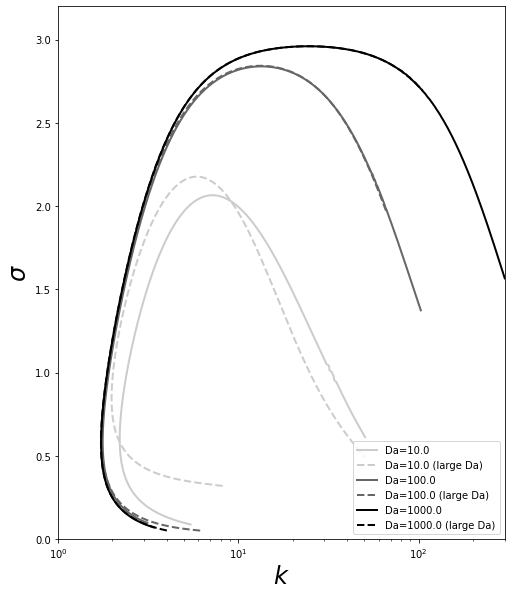

In [17]:
f, ax = plt.subplots()
zoom = 2.0
f.set_size_inches(4.0 * zoom, 4.9 * zoom)
f.set_facecolor('w')

for vals, gray in zip([10., 100., 1000.], [0.8, 0.4, 0.0]):
    plt.plot(DC_cube[vals].k, DC_cube[vals].s, '-', linewidth=2, 
             color=[gray, gray, gray], label=r'Da='+str(vals))
    plt.plot(DC_quad[vals].k, DC_quad[vals].s, '--', linewidth=2, 
             color=[gray, gray, gray], label=r'Da=' + str(vals) + ' (large Da)')

plt.xscale('log')
plt.xlim(1, 300)
plt.xlabel(r'$k$', fontsize=24)
plt.ylim(0, 3.2)
plt.ylabel(r'$\sigma$', fontsize=24)
plt.legend()
plt.show()

In [18]:
class PAR:
    def __init__(self):
        self.s = None
        self.k = None
        self.smax = None
        self.kmax = None
        self.X = None
        self.Y = None
        self.P = None
        self.phi = None
        self.U = None
        self.W = None

        
def ReactiveFlowAnalyticalSolution(k, n, Da, Pe, S):
    K = (1 + k**2 / Da / Pe).astype(np.clongdouble)
    b = np.pi
    # growth rate - upper branch
    full = np.zeros((k.shape[0], 2), dtype=np.clongdouble)
    b2 = b ** 2
    Da2 = Da ** 2
    Da3 = Da ** 3
    Da4 = Da ** 4
    K2 = K ** 2
    K4 = K ** 4
    k2 = k ** 2
    k4 = k ** 4
    k6 = k ** 6
    S2 = S ** 2
    full[:, 0] = (2.0 * n * np.sqrt(-Da4 * K4 * b2 - Da4 * K4 * k2 + Da4 * K2 * S2 * k4
                                    - 3.0 * Da3 * K2 * S * k4 - 2 * Da2 * K2 * b2 * k2 - Da * S * k6 - b2 * k4)
                  + 4 * Da * K * b2 * n + Da * K * k2 * n + 2 * Da2 * K * S * k2 * n) / (
            4 * S * Da2 * K2 * b2 + 4 * S * Da2 * K2 * k2 + S * k4)
    # lower branch
    full[:, 1] = -(2.0 * n * np.sqrt(- Da4 * K4 * b2 - Da4 * K4 * k2 + Da4 * K2 * S2 * k4
                                     - 3 * Da3 * K2 * S * k4 - 2 * Da2 * K2 * b2 * k2 - Da * S * k6 - b2 * k4)
                   - K * (4 * Da * n * b2 + n * (2 * S * Da2 + Da) * k2)) / (
            S * (4 * Da2 * K2 * b2 + 4 * Da2 * K2 * k2 + k4))

    real1 = np.nonzero(np.imag(full[:, 0]).astype(np.float32) == 0.0)
    real2 = np.nonzero(np.imag(full[:, 1]).astype(np.float32) == 0.0)
    s = PAR()
    s.s = np.real(np.concatenate((np.flipud(full[real1, 0].flatten()), full[real2, 1].flatten())))
    s.k = np.real(np.concatenate((np.flipud(k[real1].flatten()), k[real2].flatten())))
    I = np.argmax(s.s)
    s.smax = s.s[I]
    s.kmax = s.k[I]

    # eigenfunctions
    K = 1 + s.kmax ** 2 / Da / Pe
    a = 0.5 * (n * K / S + s.smax * s.kmax ** 2 / Da) / (s.smax * K - n / Da / S)
    m = a + 1j * np.pi
    lambda_ = 2 * np.pi / s.kmax
    x = np.linspace(0, 2 * lambda_, 1000)
    hx = x[2]-x[1]
    y = np.linspace(0, 1, 1000)
    hy = y[2]-y[1]
    s.X, s.Y = np.meshgrid(x, y)
    s.P = np.exp(a * s.Y) * np.sin(np.pi * s.Y) * np.sin(s.kmax * s.X)
    tmp = np.exp(a * s.Y) * np.cos(np.pi * s.Y) * np.sin(s.kmax * s.X)
    dphi_dy = S * ((a ** 2 - np.pi ** 2 - s.kmax ** 2) * s.P + 2 * a * np.pi * tmp) / n
    s.phi = np.cumsum(dphi_dy, axis=0) * hy

    Px, Py = np.gradient(s.P, hx, hy)
    s.U = -S * Px
    s.W = (n - 1) * s.phi - S * Py

    s.P = (s.P - np.amin(s.P)) / (np.amax(s.P) - np.amin(s.P))
    s.phi = (s.phi - np.amin(s.phi)) / (np.amax(s.phi) - np.amin(s.phi))
    
    return s

In [19]:
n = 3.
Da = 1000.
Pe = 100.
S = np.asarray([0.01, 0.1, 1, 10]).astype(np.clongdouble)
k = np.logspace(-1.0, 4.0, 10000).astype(np.clongdouble)
s = []

for s_ in S:
    s.append(ReactiveFlowAnalyticalSolution(k, n, Da, Pe, s_))

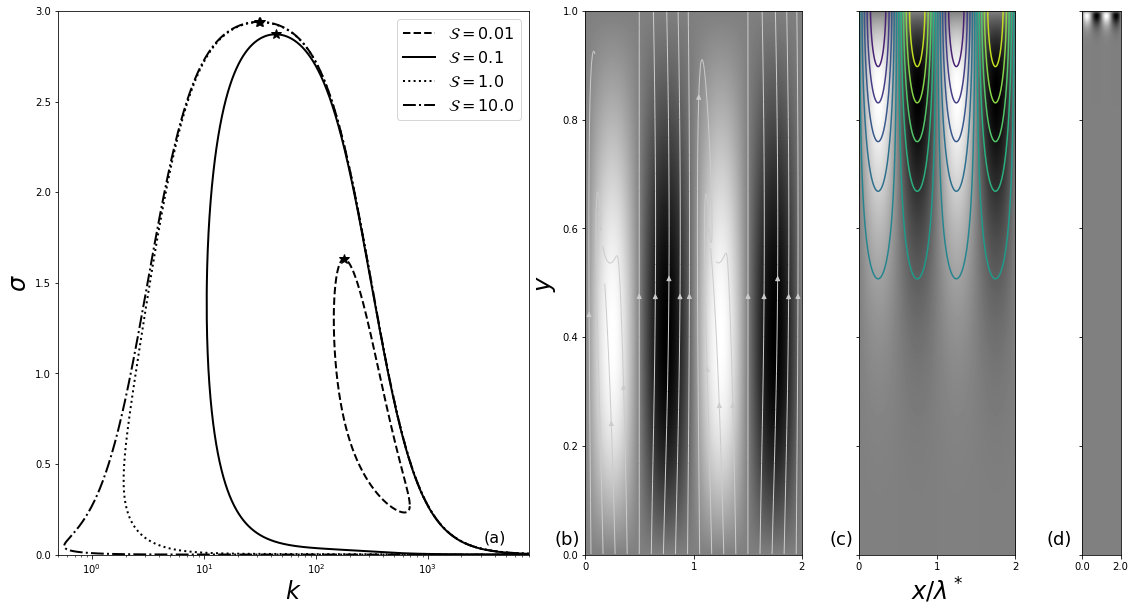

In [20]:
zoom = 2.0
fig = plt.figure(figsize=(zoom*9.7, zoom*5.0))
gs = gridspec.GridSpec(1, 4, width_ratios=[6, 3, 2, 1])

ax0 = plt.subplot(gs[0])
for s_, lstyi, S_ in zip(s, {'--k', '-k', '-.k', ':k'}, S):
    ax0.semilogx(s_.k, s_.s, lstyi, linewidth=2, 
                 label=r'$\mathcal{S}=' + str(np.real(S_).astype(np.float32)) + '$')
    ax0.plot(s_.kmax, s_.smax, '*k', linewidth=1, markersize=10)
ax0.set_xlabel(r'$k$', fontsize=24)
ax0.set_xlim(0.5, 8000)
ax0.set_xticks(ticks=(1.e0, 1.e1, 1.e2, 1.e3))
ax0.set_ylabel(r'$\sigma$', fontsize=24)
ax0.set_ylim(0.0, 3.0)
ax0.legend(fontsize=16)
ax0.text(0.5e4, 0.05, '(a)', fontsize=16, verticalalignment='bottom', horizontalalignment='right')

AR = 2 * np.pi / np.asarray([s[2].kmax, s[1].kmax, s[0].kmax])

ax1 = plt.subplot(gs[1])
lambda_ = np.float32(AR[0])
ax1 = plt.subplot(gs[1])
ax1.imshow(np.real(s[2].P).astype(np.float32), cmap='gray', extent=[0.0, 2.*lambda_, 0.0, 1.0])
ax1.set_ylabel(r'$y$', fontsize=24)
nlines = 18
h = 2 * lambda_ / (nlines + 1)
seed = np.zeros((nlines, 2))
seed[:, 0] = np.linspace(0.5 * h, 2.0 * lambda_ - 0.5 * h, nlines)
seed[:, 1] = np.ones_like(seed[:, 0]) / 1000.0
epsilon = 3e-3
U = epsilon * np.real(s[2].U).astype(np.float64)
W = 1.0 + epsilon * np.real(s[2].W).astype(np.float64)
x = np.linspace(0, 2 * lambda_, 1000)
y = np.linspace(0, 1, 1000)
X, Y = np.meshgrid(x, y)
ax1.streamplot(X, Y, U, W, start_points=seed,
               integration_direction='forward', color=[0.8, 0.8, 0.8], linewidth=1)
ax1.set_xticks((0, AR[0], 2*AR[0]))
ax1.set_xticklabels((0, 1, 2))
ax1.text(-0.01, 0.01, '(b)', fontsize=18, verticalalignment='bottom', horizontalalignment='right')

ax2 = plt.subplot(gs[2])
lambda_ = np.float32(AR[1])
ax2 = plt.subplot(gs[2])
ax2.imshow(np.flipud(np.real(s[1].P)).astype(np.float32), cmap='gray', extent=[0.0, 2.*lambda_, 0.0, 1.0])
x = np.linspace(0, 2 * lambda_, 1000)
y = np.linspace(0, 1, 1000)
X, Y = np.meshgrid(x, y)
ax2.contour(X, Y, np.real(s[1].phi).astype(np.float32), levels=np.linspace(0, 1, 12))
ax2.set_xticks((0, lambda_, 2*lambda_))
ax2.set_xticklabels((0, 1, 2))
ax2.set_yticklabels(())
ax2.set_xlabel(r'$x/\lambda^*$', fontsize=24)
ax2.text(-0.01, 0.01, r'(c)', fontsize=18, verticalalignment='bottom', horizontalalignment='right')

ax3 = plt.subplot(gs[3])
lambda_ = np.float32(AR[2])
ax3.imshow(np.flipud(np.real(s[0].P)).astype(np.float32), cmap='gray', extent=[0.0, 2.*lambda_, 0.0, 1.0])
ax3.set_xticks((0, 2*lambda_))
ax3.set_xticklabels((0., 2.))
ax3.set_yticklabels(())
plt.text(-0.02, 0.01, r'(d)', fontsize=18, verticalalignment='bottom', horizontalalignment='right')

plt.show()

In [21]:
class SA_Growth():
    def __init__(self):
        self.k = None
        self.a = None
        self.e = None
        self.s = None


def asym_maxgrowth(k, n, Da, Pe, S, l):
    b = l * np.pi
    B = b**2 + 1.0/4.0/S**2
    s_ = SA_Growth()
    k = np.power(4.0*Da*Pe*(b**2 + 1.0/4.0/S**2)/(4.0 + Pe/Da), 0.25)
    a = 1.0/2.0/S + k**2.0/2.0/Da
    e = (a**2 + b**2)/k**2 + k**2/Da/Pe
    s = n*(1.0 - 1.0/Da/2.0/S - 2.0*np.sqrt(B*(1.0/Da/Pe + 1.0/4.0/Da**2)))
    s_.k = np.real(k).astype(np.float32)
    s_.a = np.real(a).astype(np.float32)
    s_.e = np.real(e).astype(np.float32)
    s_.s = np.real(s).astype(np.float32)
    return s_

In [22]:
class SA_Dispersion():
    def __init__(self):
        self.s = None
        self.k = None


def asym_dispersion(k, n, Da, Pe, S, l):
    a = 1/2/S + k**2/2/Da
    b = l * np.pi
    epsilon = (a**2 + b**2)/k**2 + k**2/Da/Pe
    s = n*(1-epsilon)
    s[np.imag(s) != 0.0] = np.nan
    return np.real(s).astype(np.float32)


def full_dispersion(k, n, Da, Pe, S, l):
    b = np.clongdouble(l * np.pi)
    b2 = b ** 2
    k2 = k**2
    k4 = k2 * k2
    k6 = k2 * k4
    Da = np.clongdouble(Da)
    Da2 = Da ** 2
    Da3 = Da * Da2
    Da4 = Da2 * Da2
    K = 1.0 + k2 / Da / np.clongdouble(Pe)
    K2 = K ** 2
    K4 = K2 * K2
    S2 = np.clongdouble(S ** 2)

    # upper branch
    su = (2.0 * n * np.sqrt(-Da4 * K4 * b2 - Da4 * K4 * k2 + Da4 * K2 * S2 * k4 - 3.0 * Da3 * K2 * S * k4
                            - 2.0 * Da2 * K2 * b2 * k2 - Da * S * k6 - b2 * k4) + 4.0 * Da * K * b2 * n
          + Da * K * k2 * n + 2.0 * Da2 * K * S * k2 * n) / (4.0 * S * Da2 * K2 * b2 + 4.0 * S * Da2 * K2 * k2 + S * k4)
    iu = np.imag(su) == 0.0
    # lower branch
    sl = -(2.0 * n * np.sqrt(-Da4 * K4 * b2 - Da4 * K4 * k2 + Da4 * K2 * S2 * k4 - 3.0 * Da3 * K2 * S * k4
                             - 2.0 * Da2 * K2 * b2 * k2 - Da*S*k6 - b2 * k4)
           - K*(4 * Da * n * b2 + n * (2.0 * S * Da2 + Da) * k2)) / (S*(4 * Da2 * K2 * b2 + 4.0 * Da2 * K2 * k2 + k4))
    il = np.imag(sl) == 0
    s = SA_Dispersion()
    s.s = np.hstack([np.flip(np.real(su[iu]).astype(np.float32)), np.real(sl[il]).astype(np.float32)])
    s.k = np.hstack([np.flip(np.real(k[iu]).astype(np.float32)), np.real(k[il]).astype(np.float32)])
    return s

/var/folders/4z/_rhsq3x965gc56klbm0nmv040000gn/T/ipykernel_86415/1132045969.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  ax0.loglog(sfull.k, sfull.s, '-k', linewidth=2, color=[0.5, 0.5, 0.5],
/var/folders/4z/_rhsq3x965gc56klbm0nmv040000gn/T/ipykernel_86415/1132045969.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax0.loglog(k, sasym, '--k', linewidth=0.5, color=[0.5, 0.5, 0.5])
/Users/fredericoteixeira/Projects/partially-molten-rock-PUP/rock-env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/4z/_rhsq3x965gc56klbm0nmv040000gn/T/ipykernel_86415/1132045969.py:20: UserWarning: color is redundantly defined by the 'color' k

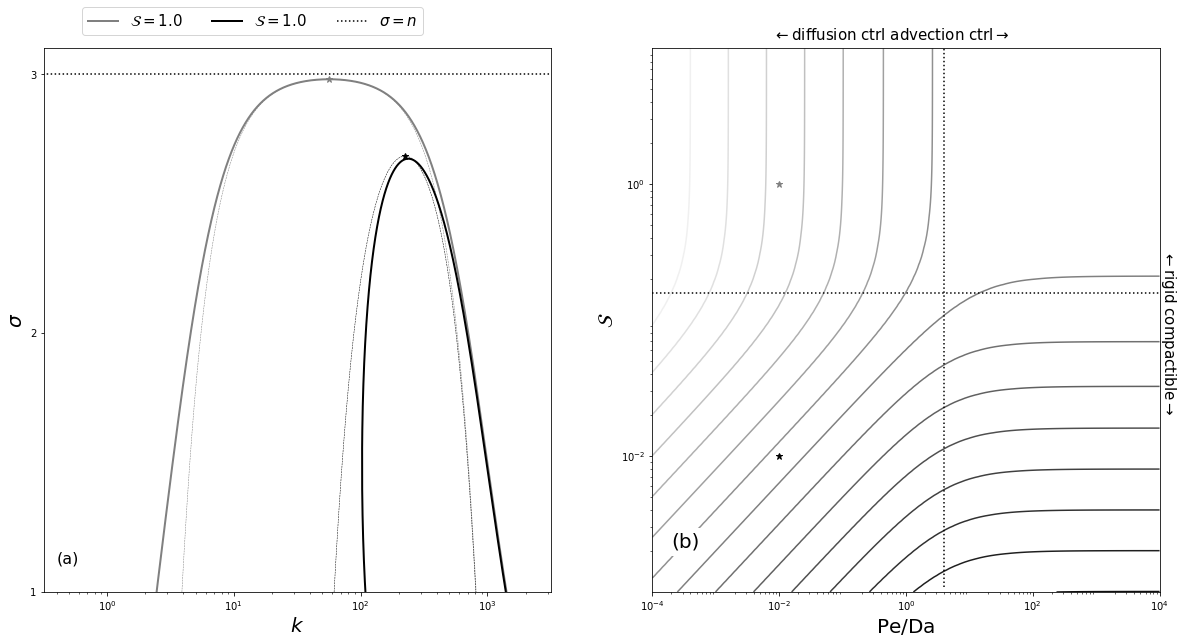

In [23]:
zoom = 2.0
fig = plt.figure(figsize=(10*zoom, 5*zoom))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

ax0 = plt.subplot(gs[0])

Da = 1e4
k = np.logspace(-1, 4, 10000).astype(np.clongdouble)
n = 3
Pe = Da / 100
S = np.asarray([1.0, 0.01]).astype(np.clongdouble)
l = 1.0

sfull = full_dispersion(k, n, Da, Pe, S[0], l)
sasym = asym_dispersion(k, n, Da, Pe, S[0], l)
smax = asym_maxgrowth(k, n, Da, Pe, S[0], l)
ax0.loglog(sfull.k, sfull.s, '-k', linewidth=2, color=[0.5, 0.5, 0.5],
           label=r'$\mathcal{S}='+str(np.real(S[0]))+'$')
ax0.loglog(k, sasym, '--k', linewidth=0.5, color=[0.5, 0.5, 0.5])
ax0.plot(smax.k, smax.s, '*k', markersize=7, color=[0.5, 0.5, 0.5])

sfull = full_dispersion(k, n, Da, Pe, S[1], l)
sasym = asym_dispersion(k, n, Da, Pe, S[1], l)
smax = asym_maxgrowth(k, n, Da, Pe, S[1], l)
ax0.loglog(sfull.k, sfull.s, '-k', linewidth=2, label=r'$\mathcal{S}='+str(np.real(S[0]))+'$')
ax0.loglog(k, sasym, '--k', linewidth=0.5)
ax0.plot(smax.k, smax.s, '*k', markersize=7)

ax0.plot([k[0], k[-1]], [n, n], ':k', label=r'$\sigma=n$')

ax0.set_xlim(np.sqrt(0.1), np.power(10, 3.5))
ax0.set_xticks([1.e0, 1.e1, 1.e2, 1.e3])
ax0.set_xlabel(r'$k$', fontsize=20)

ax0.set_ylabel(r'$\sigma$', fontsize=20)
ax0.set_ylim(1.0, 3.1)
ax0.set_yscale('linear')
ax0.set_yticks([1, 2, 3])

ax0.text(0.4, 1.1, r'(a)', fontsize=16, verticalalignment='bottom', horizontalalignment='left')

ax0.legend(fontsize=15, loc='upper left', bbox_to_anchor=(0.06, 1.09), ncol=3)

ax1 = plt.subplot(gs[1])

Spts = S
Pe_Da = Pe / Da

Pe = np.logspace(np.log10(Da) - 4.0, np.log10(Da) + 4, 100)
S = np.logspace(-3.0, 1.0, 100)
X, Y = np.meshgrid(Pe, S)
B = np.pi ** 2 + 1. / (2 * Y) ** 2
Ks = np.power(4 * Da * X * B / (4 + X / Da), 0.25)
lambda_ = 2 * np.pi / Ks

ax1.contour(Pe / Da, S, np.log10(lambda_), 16, cmap='gray')
ax1.plot([Pe[0]/Da, Pe[-1]/Da], [1/2/np.pi, 1/2/np.pi], ':k')
ax1.plot([4, 4], [S[1], S[-1]], ':k')
ax1.plot(Pe_Da, Spts[0], '*k', markersize=7, color=[0.5, 0.5, 0.5])
ax1.plot(Pe_Da, Spts[1], '*k', markersize=7)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xticks((1.e-4, 1.e-2, 1.e0, 1.e2, 1.e4))
ax1.set_yticks((1.e-2, 1.e0))
ax1.set_ylabel(r'$\mathcal{S}$', fontsize=20)
ax1.set_xlabel(r'Pe$/$Da', fontsize=20)
ax1.text(0.0002, 0.002, r'(b)', fontsize=20, verticalalignment='bottom',
         horizontalalignment='left', backgroundcolor='w')
ax1.text(1.4e4, 0.02, r'$\leftarrow$rigid compactible$\rightarrow$', rotation=-90, horizontalalignment='center',
         verticalalignment='bottom', fontsize=15)
ax1.text(0.58, 11, r'$\leftarrow$diffusion ctrl advection ctrl$\rightarrow$', horizontalalignment='center',
         verticalalignment='bottom', fontsize=15)

plt.show()

In [24]:
class PAR:
    def __init__(self):
        self.n = 3  # permeability exponent
        self.S = 3e-5  # rigidity parameter
        self.Da = 7e7  # Damkohler number
        self.Pe = 7e9  # Peclet number
        self.H = 8e4  # column height, metres
        self.tscale = 1 * 0.01 / 3e-11 / 2e-6 / (np.pi * 1e7)  # years


def Dispersion(k, n, Da, Pe, S):
    k = k.astype(np.clongdouble)
    k2 = k * k
    k4 = k2 * k2
    k6 = k4 * k2
    n, Da, Pe, S = np.clongdouble([n, Da, Pe, S])
    K = 1 + k ** 2 / Da / Pe
    K2 = K * K
    K4 = K2 * K2
    Da2 = Da * Da
    Da3 = Da2 * Da
    Da4 = Da2 * Da2
    b = np.clongdouble(np.pi)
    b2 = b * b
    S2 = S * S
    # upper branch
    s = (2.0 * n * np.sqrt(-Da4 * K4 * b2 - Da4 * K4 * k2 + Da4 * K2 * S2 * k4 - 3.0 * Da3 * K2 * S * k4
                           - 2 * Da2 * K2 * b2 * k2 - Da * S * k6 - b2 * k4) + 4.0 * Da * K * b2 * n + Da * K * k2 * n
         + 2 * Da2 * K * S * k2 * n) / (4 * S * Da2 * K2 * b2 + 4.0 * S * Da2 * K2 * k2 + S * k4)
    s[np.imag(s) != 0.0] = np.nan
    return np.real(s).astype(np.float32)

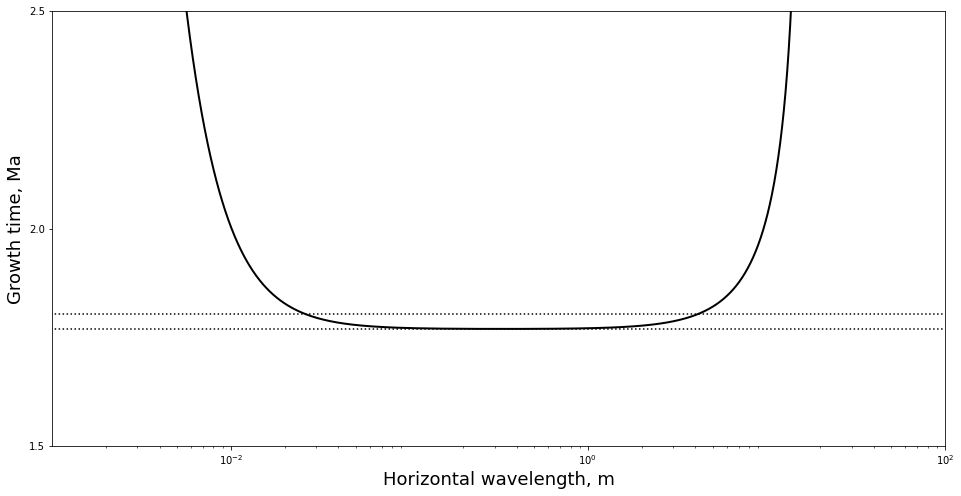

In [25]:
zoom = 2.0
fig = plt.figure(figsize=(8*zoom, 4*zoom))

par = PAR()
k = np.logspace(4, 8, 10000)
s = Dispersion(k, par.n, par.Da, par.Pe, par.S)

lambda_ = (2 * np.pi / k) * par.H  # metres
tau = (1. / s) * par.tscale / 1e6  # million years
tau_ref = (1. / par.n) * par.tscale / 1e6  # million years
tau_ref90 = (1.02 / par.n) * par.tscale / 1e6  # million years

plt.semilogx(lambda_, tau, '-k', linewidth=2)
plt.plot([1e-5, 1e5], [tau_ref, tau_ref], ':k')
plt.plot([1e-5, 1e5], [tau_ref90, tau_ref90], ':k')
plt.xlim(1e-3, 1e2)
plt.ylim(1.5, 2.5)
plt.xticks((1e-2, 1e0, 1e2))
plt.yticks((1.5, 2.0, 2.5))
plt.xlabel('Horizontal wavelength, m', fontsize=18)
plt.ylabel('Growth time, Ma', fontsize=18)

plt.show()